In [1]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

In [2]:
%load_ext autoreload
%autoreload 2
from dataset import *
from MapMatching import MapMatching
import copy
from tracker import StaticTracker
from dynamic_tracker import ClassicDBSCAN, DynamicTracker
from simulation import NuscenesSimulation

In [3]:
class RadarLocalizer():
    def __init__(self, **kwargs):
        self.static_tracker = StaticTracker()
        self.cluster_model = ClassicDBSCAN()
        self.dynamic_tracker = DynamicTracker()
        self.map_matching = MapMatching(N=200)
        self.mm = kwargs.pop('mm', False)
        self.estimated_relative_pos = np.array([0,0])
        
    def runDynamicTracker(self, dw, video_data, first_world_ref, imu_relative_ref):
        heading = np.deg2rad(video_data["heading_imu"]-90)
        Z, X = self.cluster_model.run(pc=dw, ego=video_data["pos_imu"], heading=heading) # Z in radar coordinates
        self.dynamic_tracker.run(Z, video_data["timestamp"], {"heading": heading, "T": video_data["pos_imu"]}, video_data["veh_speed"])
    
        return self.dynamic_tracker.getTracks(), {"Z": Z, "X": X}
    
    def runStaticTracker(self, zw, covw, prior, video_data, first_world_ref, imu_relative_ref):
        #translate measurements and priors relative to the first position [floating point precision reasons]
        zw = self.translateMeasurements(zw, first_world_ref)
        prior_list = self.getPriorList(prior, first_world_ref[0:2] - imu_relative_ref + self.estimated_relative_pos)
        #run static tracker
        points, polynoms = self.static_tracker.run(zw,covw,prior_list)
        #print("video_data[pos]", video_data["pos"])
        points, polynoms = self.translateOutput(points, polynoms, -1*video_data["pos"][0:2] + imu_relative_ref) #output from ego(GT) prespective
        
        return points, polynoms, self.static_tracker.getDebugInfo()
        
    def runMapMatching(self, video_data, first_world_ref, imu_relative_ref, prior, nusc_map):
        if self.mm:
            extended_tracks = self.static_tracker.getExtendedTracks()
            dynamic_tracks = self.dynamic_tracker.getTracks()
            lanes = self.getLanes(prior, first_world_ref[0:2])
            imu_relative_ref_3d = np.array([imu_relative_ref[0], imu_relative_ref[1], np.deg2rad(video_data["heading_imu"]-90)])
            self.map_matching.run(extended_tracks, nusc_map, dynamic_tracks, lanes, first_world_ref, imu_relative_ref_3d)
            gt_relative_pos = np.array([video_data["pos"][0] - first_world_ref[0], video_data["pos"][1] - first_world_ref[1], video_data["pos"][2]]) 
            mm_results = self.map_matching.getResults(extended_tracks, dynamic_tracks, first_world_ref[0:2], gt_relative_pos, imu_relative_ref_3d, lanes)
            mm_results["pf_best_pos"] += first_world_ref[0:2]
            mm_results["pf_mean_pos"] += first_world_ref[0:2]
            
            return mm_results
        
    def translatePolynom(self, c, xstart, xend, pos):
        x = np.array([xstart, 0.5*(xstart+xend), xend])
        x_trns = x - pos[0]
        y = np.array([c[0]*x[0]**2+c[1]*x[0]+c[2], c[0]*x[1]**2+c[1]*x[1]+c[2], c[0]*x[2]**2+c[1]*x[2]+c[2]])
        y_trns = y - pos[1]
        A = [[x_trns[0]**2, x_trns[0], 1],[x_trns[1]**2, x_trns[1], 1],[x_trns[2]**2, x_trns[2], 1]]
        c = np.linalg.inv(A).dot(y_trns)
        
        return c
    
    def getLanes(self, prior, translate):
        prior_elements = []
        #lane_width = 5.
        #w = lane_width / 2.
        for pr in prior:
            prior_len = pr["x"].shape[0]
            elem = np.zeros([prior_len, 4])
            elem[:-1,2] = pr["dx"]
            elem[-1,2] = elem[-2,2]
            elem[:-1,3] = pr["dy"]
            elem[-1,3] = elem[-2,3]
            #grad = np.abs(elem[:,3] / (elem[:,2] + 1e-6))
            sx = 0#-1#-1*np.sign(elem[:, 3]) * w * 1/np.sqrt(1+grad**2)
            sy = 0#-1#np.sign(elem[:, 2]) * w * grad * 1/np.sqrt(1+grad**2)
            
            elem[:, 0] = pr["x"] - translate[0] + sx
            elem[:, 1] = pr["y"] - translate[1] + sy
            
            #debug_min_x = min(pr["x"])
            #debug_max_x = max(pr["x"])
            #debug_min_y = min(pr["y"])
            #debug_max_y = max(pr["y"])
            #if debug_min_x < 1130 and debug_max_y < 1590:
                #print(f"debug_min_x = {debug_min_x} debug_max_x = {debug_max_x} debug_min_y = {debug_min_y} debug_max_y = {debug_max_y}")
                #print(f"sx = {sx[0]} sy = {sy[0]}")
            prior_elements.append(elem)
            
        return prior_elements
    
    def getPriorList(self, prior, translation):            
        lanes = copy.deepcopy(prior)
        lanes = self.translatePrior(translation, lanes)

        prior_list = []
        for lane in lanes:
            (a0,a1,a2) = lane["poly"].c[2], lane["poly"].c[1], lane["poly"].c[0]
            xmin = np.min(lane["x"]) if lane["fx"] else np.min(lane["y"])
            xmax = np.max(lane["x"]) if lane["fx"] else np.max(lane["y"])
            prior_list.append({"c": (a0,a1,a2), "xmin": xmin, "xmax": xmax, "fx": lane["fx"]})
            
        return prior_list
        
    def translatePrior(self, pos, prior):
        for pr in prior:
            min_x = np.min(pr["x"])
            max_x = np.max(pr["x"])
            c = self.translatePolynom(pr["poly"].c, min_x, max_x, pos)
            pr["poly"] = np.poly1d(c)
            pr["x"] -= pos[0]
        
        return prior
    
    def translateMeasurements(self, zw, pos):
        return zw - pos
        
    def translateOutput(self, points, polynoms, pos):
        points = points - pos
        for polynom in polynoms:
            c = self.translatePolynom(polynom["f"].c, polynom["x_start"], polynom["x_end"], pos)
            polynom["f"] = np.poly1d(c)
            polynom["x_start"] -= pos[0]
            polynom["x_end"] -= pos[0]
        
        return points, polynoms
    
    def run(self, static_data, dynamic_data, video_data, prior, first_world_ref, nusc_map):
        #run static tracker
        imu_relative_ref = video_data["pos_imu"][0:2]-first_world_ref
        points, polynoms, debug_info = self.runStaticTracker(static_data["zw"], static_data["covw"], prior, video_data, first_world_ref, imu_relative_ref)
        #run dynamic tracker
        dynamic_tracks, dynamic_clusters = self.runDynamicTracker(dynamic_data["dw"], video_data, first_world_ref, imu_relative_ref)
        #Run map-matching
        mm_results = self.runMapMatching(video_data, first_world_ref, imu_relative_ref, prior, nusc_map)
        self.estimated_relative_pos = mm_results["pf_mean_pos"] - first_world_ref
        return points, polynoms, dynamic_tracks, dynamic_clusters, debug_info, mm_results

scene_id=814 scene_name=scene-1074 map_name=singapore-hollandvillage


/home/kfir/workspace/RadarLocalization/dataset.py:376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


odom_speed [[1.54280031e+15 4.60000000e+01]
 [1.54280031e+15 4.60000000e+01]
 [1.54280031e+15 4.60000000e+01]
 ...
 [1.54280057e+15 2.90000000e+01]
 [1.54280057e+15 2.90000000e+01]
 [1.54280057e+15 2.90000000e+01]]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


self.dir_name images/814/database
frame 0


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 0
Number of extended tracks before run() 0
frame_idx = 1
Number of new plots 1
Number of dynamic tracks before run() 0
frame 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 38
Number of extended tracks before run() 0
frame_idx = 2
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 2


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 59
Number of extended tracks before run() 0
frame_idx = 3
Number of new plots 1
Number of dynamic tracks before run() 1
frame 3


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is

Number of point tracks before run() 85
Number of extended tracks before run() 0
frame_idx = 4
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 4


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 104
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.05335164e+01  1.57282716e+00  9.91565369e-03 -7.67596946e+00
  1.30838701e+00]
created an extended object! [-2.16886184e+01  1.16614589e+00 -3.26819898e-03 -2.52263607e+01
 -1.54659490e+01]
frame_idx = 5
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 5


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 91
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.7853565397185673  not similar! (-0.0032681989805270944, 1.166145889317224, -21.688618351614675) (-0.039393127554854655, 0.27039673938860725, -32.175858416580674) -20.439219812727742 -15.514751048749556
created an extended object! [-32.17585842   0.27039674  -0.03939313 -20.43921981 -13.22463608]
frame_idx = 6
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 6


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 102
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.78853043e+01  1.81555291e+00  6.67557118e-03 -3.25885780e+01
 -2.30135945e+01]
Tracks are similar! do not open a new trk (-0.0032681989805270944, 1.166145889317224, -21.688618351614675) (0.012100979931612469, 2.0044476782001293, -11.266964056595894)
frame_idx = 7
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 7


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 111
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0032681989805270944, 1.166145889317224, -21.688618351614675) (0.010159401808859703, 1.9226742626362359, -12.023937369087651)
dist is 2.2610593728494544  not similar! (-0.0032681989805270944, 1.166145889317224, -21.688618351614675) (-0.05864767204628285, -1.6008480031592172, -47.85619489930711) -25.081413709268684 -15.610895984330755
dist is 3.9921919420878926  not similar! (-0.039393127554854655, 0.27039673938860725, -32.175858416580674) (-0.05864767204628285, -1.6008480031592172, -47.85619489930711) -20.36743470462415 -13.296421191827047
dist is 10.446843039258926  not similar! (0.006675571181781424, 1.8155529132710557, 27.88530429287558) (-0.05864767204628285, -1.6008480031592172, -47.85619489930711) -32.31681680203076 -23.061469425059926
created an extended object! [-47.8561949   -1.600848    -0.05864767 -32.3168168   -6.61553914]
frame_idx = 8
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 8


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 111
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0032681989805270944, 1.166145889317224, -21.688618351614675) (0.005785848557338376, 1.7116408093890694, -14.426930433105237)
frame_idx = 9
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 9


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0032681989805270944, 1.166145889317224, -21.688618351614675) (0.0020870362500217715, 1.5260871499633122, -16.464396585408846)
dist is 2.3714241578762  not similar! (-0.0032681989805270944, 1.166145889317224, -21.688618351614675) (-0.056252994939803715, -1.3978176766106847, -44.419272283824384) -24.987182057905553 -15.705127635693888
dist is 4.270855684867257  not similar! (-0.039393127554854655, 0.27039673938860725, -32.175858416580674) (-0.056252994939803715, -1.3978176766106847, -44.419272283824384) -20.29707812017182 -13.366777776279378
dist is 10.817460929187629  not similar! (0.006675571181781424, 1.8155529132710557, 27.88530429287558) (-0.056252994939803715, -1.3978176766106847, -44.419272283824384) -31.89169470367301 -23.155787799997388
Tracks are similar! do not open a new trk (-0.052347190145849425, -1.7933903045407678, -46.69933242584247) (-0.056252994939803715, -1.3978176766106847, -44.419272283824384)
frame_idx = 10
Number of ne

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 10


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0032681989805270944, 1.166145889317224, -21.688618351614675) (0.000840205923749713, 1.4658649842976974, -17.236790720683654)
dist is 2.308795898537982  not similar! (-0.0032681989805270944, 1.166145889317224, -21.688618351614675) (-0.05516314179758018, -1.3517607034544954, -44.1733857822887) -24.940771785794496 -15.751537907804947
dist is 4.211077784888284  not similar! (-0.039393127554854655, 0.27039673938860725, -32.175858416580674) (-0.05516314179758018, -1.3517607034544954, -44.1733857822887) -20.262426618452356 -13.40142927799884
dist is 10.908564895427954  not similar! (0.006675571181781424, 1.8155529132710557, 27.88530429287558) (-0.05516314179758018, -1.3517607034544954, -44.1733857822887) -31.89169470367301 -23.202240784558295
Tracks are similar! do not open a new trk (-0.052347190145849425, -1.7933903045407678, -46.69933242584247) (-0.05516314179758018, -1.3517607034544954, -44.1733857822887)
frame_idx = 11
Number of new plots 1
N

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 11


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0032681989805270944, 1.166145889317224, -21.688618351614675) (-0.005470500239996888, 1.1706482990639728, -20.546445028399603)
dist is 2.381317785218947  not similar! (-0.0032681989805270944, 1.166145889317224, -21.688618351614675) (-0.05621261960814644, -1.3901577547242732, -44.329637238216726) -24.89482561640455 -15.797484077194895
dist is 4.298895033970008  not similar! (-0.039393127554854655, 0.27039673938860725, -32.175858416580674) (-0.05621261960814644, -1.3901577547242732, -44.329637238216726) -20.22812163175009 -13.435734264701107
dist is 10.902733254572727  not similar! (0.006675571181781424, 1.8155529132710557, 27.88530429287558) (-0.05621261960814644, -1.3901577547242732, -44.329637238216726) -31.89169470367301 -23.24822923927359
Tracks are similar! do not open a new trk (-0.052347190145849425, -1.7933903045407678, -46.69933242584247) (-0.05621261960814644, -1.3901577547242732, -44.329637238216726)
dist is 9.578219215827621  not 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 12


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0032681989805270944, 1.166145889317224, -21.688618351614675) (-0.005407764792778055, 1.1707535449818312, -20.61222867412707)
dist is 2.4332763748385324  not similar! (-0.0032681989805270944, 1.166145889317224, -21.688618351614675) (-0.0599053979825551, -1.5683841362889757, -46.30517445484482) -24.8493389087085 -15.842970784890943
dist is 4.3164414429692455  not similar! (-0.039393127554854655, 0.27039673938860725, -32.175858416580674) (-0.0599053979825551, -1.5683841362889757, -46.30517445484482) -20.194159694914845 -13.469696201536353
dist is 10.893445458067271  not similar! (0.006675571181781424, 1.8155529132710557, 27.88530429287558) (-0.0599053979825551, -1.5683841362889757, -46.30517445484482) -31.89169470367301 -23.293757809441736
Tracks are similar! do not open a new trk (-0.052692403097577514, -1.783869214317742, -46.74141292680606) (-0.0599053979825551, -1.5683841362889757, -46.30517445484482)
frame_idx = 13
Number of new plots 1
N

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 13


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 6
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0032681989805270944, 1.166145889317224, -21.688618351614675) (-0.007418847028381824, 1.0794407808351192, -21.453243619546214)
dist is 2.329877934176183  not similar! (-0.0032681989805270944, 1.166145889317224, -21.688618351614675) (-0.0578506390090833, -1.4785972125161955, -45.69304831450581) -24.80430706808941 -15.88800262551003
dist is 4.218311205399847  not similar! (-0.039393127554854655, 0.27039673938860725, -32.175858416580674) (-0.0578506390090833, -1.4785972125161955, -45.69304831450581) -20.16053737744795 -13.503318519003246
dist is 11.04898603133834  not similar! (0.006675571181781424, 1.8155529132710557, 27.88530429287558) (-0.0578506390090833, -1.4785972125161955, -45.69304831450581) -31.89169470367301 -23.338831093908198
Tracks are similar! do not open a new trk (-0.05292770180949788, -1.777569464675041, -46.766169480508005) (-0.0578506390090833, -1.4785972125161955, -45.69304831450581)
frame_idx = 14
Number of new plots 1
Numb

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 14


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 6
Updating extended object track =  0
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0032681989805270944, 1.166145889317224, -21.688618351614675) (-0.009555570401770882, 0.9694635939847489, -22.939991057337394)
dist is 2.4525068173279974  not similar! (-0.0032681989805270944, 1.166145889317224, -21.688618351614675) (-0.058334073737328206, -1.4728003944699797, -45.03260584299798) -24.759725545876513 -15.932584147722928
dist is 4.393287553396282  not similar! (-0.039393127554854655, 0.27039673938860725, -32.175858416580674) (-0.058334073737328206, -1.4728003944699797, -45.03260584299798) -20.12725128315573 -13.53660461329547
dist is 11.03204447591551  not similar! (0.006675571181781424, 1.8155529132710557, 27.88530429287558) (-0.058334073737328206, -1.4728003944699797, -45.03260584299798) -31.89169470367301 -23.383453645529997
Tracks are similar! do not open a new trk (-0.053079558436163576, -1.7759098746870758, -46.732179920627495) (-0.058334073737328206, -1.4728003944699797, -45.03260584299798)
frame_idx = 15
Number of new 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 15


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0032681989805270944, 1.166145889317224, -21.688618351614675) (-0.00905810093575233, 1.0050926921478416, -22.25464744535055)
dist is 2.532448441030877  not similar! (-0.0032681989805270944, 1.166145889317224, -21.688618351614675) (-0.05949387254016966, -1.518950651593874, -45.28566782560764) -24.715589838885744 -15.976719854713696
dist is 4.491353187397907  not similar! (-0.039393127554854655, 0.27039673938860725, -32.175858416580674) (-0.05949387254016966, -1.518950651593874, -45.28566782560764) -20.09429804980643 -13.569557846644772
dist is 11.014188313811289  not similar! (0.006675571181781424, 1.8155529132710557, 27.88530429287558) (-0.05949387254016966, -1.518950651593874, -45.28566782560764) -31.89169470367301 -23.42762997163558
Tracks are similar! do not open a new trk (-0.05323285358040897, -1.7741178002753468, -46.700263654577846) (-0.05949387254016966, -1.518950651593874, -45.28566782560764)
frame_idx = 16
Number of new plots 1
Num

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 16


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.99408663525416  not similar! (-0.039393127554854655, 0.27039673938860725, -32.175858416580674) (-0.0097564668127556, 0.9724053743173373, -22.62783687583068) -20.06167434879062 -15.341225535316312
dist is 15.666081006184818  not similar! (0.006675571181781424, 1.8155529132710557, 27.88530429287558) (-0.0097564668127556, 0.9724053743173373, -22.62783687583068) -29.944205560547744 -23.471364534480102
dist is 4.041839693129604  not similar! (-0.05323285358040897, -1.7741178002753468, -46.700263654577846) (-0.0097564668127556, 0.9724053743173373, -22.62783687583068) -29.944205560547744 -15.341225535316312
created an extended object! [-2.26278369e+01  9.72405374e-01 -9.75646681e-03 -2.99442056e+01
 -1.53412255e+01]
dist is 4.4679603692748575  not similar! (-0.039393127554854655, 0.27039673938860725, -32.175858416580674) (-0.058049254998743055, -1.4697950161752273, -44.9946737177886) -20.06167434879062 -13.60218154766058
dist is 11.023434964264316  not similar! (0.006675571181781424

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 17


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 12.89832473113859  not similar! (0.006675571181781424, 1.8155529132710557, 27.88530429287558) (-0.06146626062118988, -1.5563613116488264, -45.6139359104117) -29.793942952451516 -23.51466175169618
Tracks are similar! do not open a new trk (-0.05323285358040897, -1.7741178002753468, -46.700263654577846) (-0.06146626062118988, -1.5563613116488264, -45.6139359104117)
frame_idx = 18
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 18


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.05323285358040897, -1.7741178002753468, -46.700263654577846) (-0.05883259723597911, -1.5248200396306701, -45.887753837716325)
dist is 4.347189483935179  not similar! (-0.05323285358040897, -1.7741178002753468, -46.700263654577846) (-0.0041883776167890565, 1.2728803358691259, -25.064599969224968) -24.88370764106446 -10.019258625956127
dist is 2.0220083389992065  not similar! (-0.0097564668127556, 0.9724053743173373, -22.62783687583068) (-0.0041883776167890565, 1.2728803358691259, -25.064599969224968) -24.88370764106446 -15.486525186567365
created an extended object! [-2.50646000e+01  1.27288034e+00 -4.18837762e-03 -2.48837076e+01
 -1.00192586e+01]
frame_idx = 19
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 19


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.05323285358040897, -1.7741178002753468, -46.700263654577846) (-0.05816601747270997, -1.474833589271468, -45.057159145097046)
dist is 4.333062790514404  not similar! (-0.05323285358040897, -1.7741178002753468, -46.700263654577846) (-0.008121020182118757, 1.0783142676222068, -20.98599929598281) -29.82960580582153 -16.521591761899458
Tracks are similar! do not open a new trk (-0.0097564668127556, 0.9724053743173373, -22.62783687583068) (-0.008121020182118757, 1.0783142676222068, -20.98599929598281)
created an extended object! [-7.46903197e+00  1.55173315e+00  4.98623589e-04 -5.04174150e+01
 -3.88331283e+01]
frame_idx = 20
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 20


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 3.04141706e+01  1.93069552e+00  7.03762453e-03 -4.13391413e+01
 -2.60935733e+01]
dist is 4.351623116759646  not similar! (-0.05323285358040897, -1.7741178002753468, -46.700263654577846) (-0.0037653990261025346, 1.2625304325180535, -19.2000965596229) -29.82960580582153 -16.521591761899458
Tracks are similar! do not open a new trk (-0.0097564668127556, 0.9724053743173373, -22.62783687583068) (-0.0037653990261025346, 1.2625304325180535, -19.2000965596229)
Tracks are similar! do not open a new trk (-0.05323285358040897, -1.7741178002753468, -46.700263654577846) (-0.058861591132850055, -1.5336670938078587, -45.852827230668964)
dist is 2.092892162683349  not similar! (0.007037624533009985, 1.9306955181880305, 30.41417057934098) (0.0019352655021552694, 1.600507483477349, 17.81121889372757) -38.369548847510714 -26.0935733207142
created an extended object! [ 1.78112189e+01  1.60050748e+00  1.93526550e-03 -3.83695488e+01
 -2.26555370e+01]
frame_idx = 21
Number of ne

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 21


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.359190726045164  not similar! (-0.05323285358040897, -1.7741178002753468, -46.700263654577846) (-0.0023381257536911424, 1.331039513369173, -18.425725162670133) -29.82960580582153 -16.521591761899458
Tracks are similar! do not open a new trk (-0.0097564668127556, 0.9724053743173373, -22.62783687583068) (-0.0023381257536911424, 1.331039513369173, -18.425725162670133)
Tracks are similar! do not open a new trk (-0.05323285358040897, -1.7741178002753468, -46.700263654577846) (-0.057671965934729064, -1.503184132622965, -45.958145861673025)
frame_idx = 22
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 22


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.362305181049436  not similar! (-0.05323285358040897, -1.7741178002753468, -46.700263654577846) (-0.0019200783356021123, 1.3476330184307246, -18.28519400606606) -29.82960580582153 -16.521591761899458
Tracks are similar! do not open a new trk (-0.0097564668127556, 0.9724053743173373, -22.62783687583068) (-0.0019200783356021123, 1.3476330184307246, -18.28519400606606)
Tracks are similar! do not open a new trk (-0.05323285358040897, -1.7741178002753468, -46.700263654577846) (-0.05872107494386946, -1.5096501267815414, -45.318616669222074)
frame_idx = 23
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 23


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.370495596088128  not similar! (-0.05323285358040897, -1.7741178002753468, -46.700263654577846) (-0.0010405346478940863, 1.385879707832617, -17.915909922995287) -29.82960580582153 -16.521591761899458
Tracks are similar! do not open a new trk (-0.0097564668127556, 0.9724053743173373, -22.62783687583068) (-0.0010405346478940863, 1.385879707832617, -17.915909922995287)
dist is 2.337235402451694  not similar! (-0.05323285358040897, -1.7741178002753468, -46.700263654577846) (-0.06290281262427398, -2.154661661166723, -60.0279711914369) -30.100076385547833 -12.237941943763644
Tracks are similar! do not open a new trk (-0.0097564668127556, 0.9724053743173373, -22.62783687583068) (-0.06290281262427398, -2.154661661166723, -60.0279711914369)
Tracks are similar! do not open a new trk (0.0004986235894211017, 1.551733147034078, -7.469031974639829) (-0.001857272351572762, 1.371693320925203, -11.564107013794581)
frame_idx = 24
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 24


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.370839631649699  not similar! (-0.05323285358040897, -1.7741178002753468, -46.700263654577846) (-0.0011758956080094726, 1.3774640981148372, -18.039097943217364) -29.82960580582153 -16.521591761899458
Tracks are similar! do not open a new trk (-0.0097564668127556, 0.9724053743173373, -22.62783687583068) (-0.0011758956080094726, 1.3774640981148372, -18.039097943217364)
Tracks are similar! do not open a new trk (-0.05323285358040897, -1.7741178002753468, -46.700263654577846) (-0.06493614075797002, -1.8435125825950278, -47.28843260149739)
dist is 2.699553318692494  not similar! (-0.05323285358040897, -1.7741178002753468, -46.700263654577846) (-0.008356598864664394, 0.9576684437765155, -16.442772750504737) -29.97861421220825 -18.261397527825693
dist is 2.2074585901118153  not similar! (-0.0097564668127556, 0.9724053743173373, -22.62783687583068) (-0.008356598864664394, 0.9576684437765155, -16.442772750504737) -29.38012671849162 -18.261397527825693
dist is 8.188583255580243  not si

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 25


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 9


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.05323285358040897, -1.7741178002753468, -46.700263654577846) (-0.06550876927622651, -1.8681476138409323, -47.51271680779987)
dist is 4.361552501391346  not similar! (-0.05323285358040897, -1.7741178002753468, -46.700263654577846) (-0.0022232142607121097, 1.33241186067579, -18.468849628505776) -29.82960580582153 -16.521591761899458
Tracks are similar! do not open a new trk (-0.0097564668127556, 0.9724053743173373, -22.62783687583068) (-0.0022232142607121097, 1.33241186067579, -18.468849628505776)
Tracks are similar! do not open a new trk (0.0004986235894211017, 1.551733147034078, -7.469031974639829) (-0.0052265264286048925, 1.0443646944196117, -19.35304932470246)
frame_idx = 26
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 26


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.36231710496545  not similar! (-0.05323285358040897, -1.7741178002753468, -46.700263654577846) (-0.0017462435388509894, 1.3483647637021752, -18.33984294697245) -29.739321584511938 -16.521591761899458
Tracks are similar! do not open a new trk (-0.0097564668127556, 0.9724053743173373, -22.62783687583068) (-0.0017462435388509894, 1.3483647637021752, -18.33984294697245)
Tracks are similar! do not open a new trk (-0.05323285358040897, -1.7741178002753468, -46.700263654577846) (-0.06548538703146017, -1.857717747011899, -47.35224289739222)
Tracks are similar! do not open a new trk (0.0004986235894211017, 1.551733147034078, -7.469031974639829) (-0.007064277938425195, 0.8598883403489552, -23.86929170228603)
frame_idx = 27
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 27


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0097564668127556, 0.9724053743173373, -22.62783687583068) (0.0007415212639498308, 1.455766169515976, -17.249885736380055)
dist is 2.787402381477738  not similar! (-0.0097564668127556, 0.9724053743173373, -22.62783687583068) (-0.06545037569193693, -1.8556421747525025, -47.338291566758436) -29.180018869314825 -16.10541222654922
dist is 3.6232155193549644  not similar! (-0.0041883776167890565, 1.2728803358691259, -25.064599969224968) (-0.06545037569193693, -1.8556421747525025, -47.338291566758436) -24.240948408331636 -10.662017858688953
dist is 7.803175144416643  not similar! (0.0019352655021552694, 1.600507483477349, 17.81121889372757) (-0.06545037569193693, -1.8556421747525025, -47.338291566758436) -30.65276944567745 -23.189299982621858
Tracks are similar! do not open a new trk (-0.008356598864664394, 0.9576684437765155, -16.442772750504737) (-0.06545037569193693, -1.8556421747525025, -47.338291566758436)
Tracks are similar! do not open a ne

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 28


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.256732243770888  not similar! (-0.0041883776167890565, 1.2728803358691259, -25.064599969224968) (0.00021011036155535695, 1.4402081638193505, -17.280081164558712) -24.17305375558342 -16.521591761899458
dist is 11.41698547619634  not similar! (0.0019352655021552694, 1.600507483477349, 17.81121889372757) (0.00021011036155535695, 1.4402081638193505, -17.280081164558712) -31.14428909716605 -23.262532412129975
dist is 2.0941761735153546  not similar! (-0.008356598864664394, 0.9576684437765155, -16.442772750504737) (0.00021011036155535695, 1.4402081638193505, -17.280081164558712) -31.14428909716605 -18.52994157463275
created an extended object! [-1.72800812e+01  1.44020816e+00  2.10110362e-04 -3.11442891e+01
 -1.65215918e+01]
Tracks are similar! do not open a new trk (0.0004986235894211017, 1.551733147034078, -7.469031974639829) (-0.00567123434540736, 0.9540039268843103, -22.264350930889073)
frame_idx = 29
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 29


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004986235894211017, 1.551733147034078, -7.469031974639829) (-0.003635150797198388, 1.147885422956593, -17.74862112415183)
created an extended object! [ 6.80615183e+01  2.92460464e+00  9.59840886e-03 -7.45703127e+01
 -6.63866475e+01]
frame_idx = 30
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 30


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.673048300454507  not similar! (-0.008356598864664394, 0.9576684437765155, -16.442772750504737) (-0.0034082257799173906, 1.3336053183876002, -17.618399370257034) -25.654398305739164 -18.66021900500097
Tracks are similar! do not open a new trk (0.00021011036155535695, 1.4402081638193505, -17.280081164558712) (-0.0034082257799173906, 1.3336053183876002, -17.618399370257034)
frame_idx = 31
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 31


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 11.594693790368853  not similar! (0.0019352655021552694, 1.600507483477349, 17.81121889372757) (0.007776109205122035, 1.8015463088611832, -12.762824484147758) -30.962947486239386 -23.477864974623213
dist is 2.0392507304124767  not similar! (-0.008356598864664394, 0.9576684437765155, -16.442772750504737) (0.007776109205122035, 1.8015463088611832, -12.762824484147758) -30.962947486239386 -18.724382276108457
Tracks are similar! do not open a new trk (0.00021011036155535695, 1.4402081638193505, -17.280081164558712) (0.007776109205122035, 1.8015463088611832, -12.762824484147758)
created an extended object! [-1.60952022e+01  1.21715986e+00 -2.92023296e-03 -5.56865772e+01
 -4.11982158e+01]
frame_idx = 32
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 32


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.0295081107867117  not similar! (-0.008356598864664394, 0.9576684437765155, -16.442772750504737) (0.006477388436259271, 1.7315292379222678, -13.631835178371238) -30.97264951472266 -18.787903914504867
Tracks are similar! do not open a new trk (0.00021011036155535695, 1.4402081638193505, -17.280081164558712) (0.006477388436259271, 1.7315292379222678, -13.631835178371238)
frame_idx = 33
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 33


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.035471185048194  not similar! (-0.008356598864664394, 0.9576684437765155, -16.442772750504737) (0.006143325088237118, 1.7191555905690314, -13.724805441874743) -30.97264951472266 -18.85079033651731
Tracks are similar! do not open a new trk (0.00021011036155535695, 1.4402081638193505, -17.280081164558712) (0.006143325088237118, 1.7191555905690314, -13.724805441874743)
frame_idx = 34
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 34


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.0261331216131993  not similar! (-0.008356598864664394, 0.9576684437765155, -16.442772750504737) (0.004653356019011872, 1.644353712975971, -14.589246968623906) -30.97264951472266 -18.91304789430963
Tracks are similar! do not open a new trk (0.00021011036155535695, 1.4402081638193505, -17.280081164558712) (0.004653356019011872, 1.644353712975971, -14.589246968623906)
Tracks are similar! do not open a new trk (-0.0029202329564990193, 1.2171598587434802, -16.095202162327713) (-0.01783470570406633, -0.3020209452940322, -53.04517727464528)
frame_idx = 35
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 35


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.0221124885977346  not similar! (-0.008356598864664394, 0.9576684437765155, -16.442772750504737) (0.0046319177475096125, 1.640735500882956, -14.641113245403297) -30.97264951472266 -18.974682876524028
Tracks are similar! do not open a new trk (0.00021011036155535695, 1.4402081638193505, -17.280081164558712) (0.0046319177475096125, 1.640735500882956, -14.641113245403297)
frame_idx = 36
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 36


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00021011036155535695, 1.4402081638193505, -17.280081164558712) (0.004942025792213151, 1.6562342899966853, -14.494662096840333)
dist is 2.072876914265226  not similar! (0.00021011036155535695, 1.4402081638193505, -17.280081164558712) (-0.010265776995729012, 0.910224255926697, -16.457502260691484) -30.579448621704017 -17.900264813102012
created an extended object! [-1.64575023e+01  9.10224256e-01 -1.02657770e-02 -3.60351089e+01
 -1.79002648e+01]
Tracks are similar! do not open a new trk (-0.0029202329564990193, 1.2171598587434802, -16.095202162327713) (-0.008333394705064816, 0.6191187718540778, -30.8004444882724)
frame_idx = 37
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 37


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00021011036155535695, 1.4402081638193505, -17.280081164558712) (0.004789331619251314, 1.6471187994609098, -14.598767446585363)
frame_idx = 38
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 38


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00021011036155535695, 1.4402081638193505, -17.280081164558712) (0.004567833024505203, 1.6359597656903548, -14.733182283932743)
Tracks are similar! do not open a new trk (-0.0029202329564990193, 1.2171598587434802, -16.095202162327713) (-0.010890120631272178, 0.3603681728528907, -37.35150149338625)
frame_idx = 39
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 39


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00021011036155535695, 1.4402081638193505, -17.280081164558712) (0.004123826767822424, 1.6197886652353737, -14.886035152260668)
Tracks are similar! do not open a new trk (-0.0029202329564990193, 1.2171598587434802, -16.095202162327713) (0.006548124510006466, 1.9885469010324088, 0.694745197557375)
frame_idx = 40
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 40


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.010265776995729012, 0.910224255926697, -16.457502260691484) (0.004140317481998033, 1.6195670461840626, -14.917680722353522)
Tracks are similar! do not open a new trk (-0.0029202329564990193, 1.2171598587434802, -16.095202162327713) (0.007085515087813565, 2.036640284106594, 1.6856209847486114)
frame_idx = 41
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 41


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.010265776995729012, 0.910224255926697, -16.457502260691484) (0.0019405001949432236, 1.5103245063176918, -16.274850991435045)
Tracks are similar! do not open a new trk (-0.0029202329564990193, 1.2171598587434802, -16.095202162327713) (-0.0030959436646827284, 1.1582310815393506, -17.220439366776425)
frame_idx = 42
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 42


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.3252037508001844  not similar! (-0.010265776995729012, 0.910224255926697, -16.457502260691484) (-0.0025583920238989384, 1.3347514088976433, -17.884687086346283) -30.97264951472266 -21.354606792323466
created an extended object! [-1.78846871e+01  1.33475141e+00 -2.55839202e-03 -3.09726495e+01
 -2.13546068e+01]
Tracks are similar! do not open a new trk (-0.0029202329564990193, 1.2171598587434802, -16.095202162327713) (-0.0014460648993870296, 1.2970467243244863, -14.290422453490812)
frame_idx = 43
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 43


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 117
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.46302732e+01  1.28280159e+00 -1.56627409e-03 -5.04373240e+01
 -3.49538278e+01]
frame_idx = 44
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 44


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 103
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 45
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 45


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 106
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.02351629e+01  2.39857634e+00  7.58960894e-03 -6.24469179e+01
 -5.05386819e+01]
frame_idx = 46
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 46


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 103
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.0999587296334115  not similar! (0.007589608944166237, 2.3985763395386903, 20.23516287816931) (-0.02441633507745761, -1.085016195448436, -83.93284227974532) -60.34098161880013 -50.598223069803346
created an extended object! [-8.39328423e+01 -1.08501620e+00 -2.44163351e-02 -6.03409816e+01
 -4.59303970e+01]
frame_idx = 47
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 47


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 97
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00156627409040764, 1.2828015921605063, -14.630273211574304) (-0.0003308512241572799, 1.4194389765179747, -11.08365018361886)
frame_idx = 48
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 48


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 107
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00156627409040764, 1.2828015921605063, -14.630273211574304) (-0.0003078999255576564, 1.420605382754579, -11.0735333328165)
Tracks are similar! do not open a new trk (0.007589608944166237, 2.3985763395386903, 20.23516287816931) (-0.01829121260727311, -0.6398200747883384, -72.11056961895626)
frame_idx = 49
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 49


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00156627409040764, 1.2828015921605063, -14.630273211574304) (-0.0005111929586982032, 1.4043662474087777, -11.3992105205791)
Tracks are similar! do not open a new trk (0.007589608944166237, 2.3985763395386903, 20.23516287816931) (-0.026674373651967197, -1.6110623284184538, -100.2248487885536)
frame_idx = 50
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 50


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00156627409040764, 1.2828015921605063, -14.630273211574304) (0.0042395551271316514, 1.7915679897924046, -3.5570361725832678)
frame_idx = 51
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 51


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 52
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 52


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00156627409040764, 1.2828015921605063, -14.630273211574304) (0.008216580589925936, 2.11364408549889, 2.9517970981307933)
Tracks are similar! do not open a new trk (0.007589608944166237, 2.3985763395386903, 20.23516287816931) (-0.0049107376052718215, 0.8876194071557933, -28.414319665600324)
frame_idx = 53
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 53


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00156627409040764, 1.2828015921605063, -14.630273211574304) (0.006453488416754159, 1.9685738844287164, -0.06301366121324281)
Tracks are similar! do not open a new trk (0.007589608944166237, 2.3985763395386903, 20.23516287816931) (-0.009526822228245559, 0.32962774718789223, -45.33796378181795)
frame_idx = 54
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 54


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.007589608944166237, 2.3985763395386903, 20.23516287816931) (-0.007045112563071552, 0.7687528765126037, -27.367630261635252)
frame_idx = 55
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 55


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.007589608944166237, 2.3985763395386903, 20.23516287816931) (-0.013907071557666104, 0.004209362832451561, -48.12326924888403)
frame_idx = 56
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 56


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.007589608944166237, 2.3985763395386903, 20.23516287816931) (-0.0017694349243033642, 1.260015148237186, -15.732929557567354)
frame_idx = 57
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 57


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.1891088626461737  not similar! (-0.02441633507745761, -1.085016195448436, -83.93284227974532) (-0.0003864493882563301, 1.4110395161462235, -11.771600588337428) -59.58686314647065 -47.1547712177038
created an extended object! [-1.17716006e+01  1.41103952e+00 -3.86449388e-04 -6.80601634e+01
 -4.71547712e+01]
created an extended object! [ 7.63746264e+01  3.00269869e+00  9.29740381e-03 -7.98035279e+01
 -6.88617485e+01]
frame_idx = 58
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 58


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 93
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.2271224288129132  not similar! (-0.0003864493882563301, 1.4110395161462235, -11.771600588337428) (0.005027972906283151, 2.0432077806236855, -1.3241177758303944) -59.57658504564836 -47.259298178482595
created an extended object! [-1.32411778e+00  2.04320778e+00  5.02797291e-03 -5.95765850e+01
 -4.65251761e+01]
frame_idx = 59
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 59


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 90
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 60
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 60


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 99
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 61
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 61


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0003864493882563301, 1.4110395161462235, -11.771600588337428) (-0.019555581486016216, -0.5795999922048889, -63.647142098332715)
dist is 10.256266848732782  not similar! (-0.0003864493882563301, 1.4110395161462235, -11.771600588337428) (0.014227053323593131, 3.44282278338151, 83.21280651017047) -67.64828544173714 -61.814575329726495
created an extended object! [ 8.32128065e+01  3.44282278e+00  1.42270533e-02 -7.19574459e+01
 -6.18145753e+01]
frame_idx = 62
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 62


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 113
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.5948218124651894  not similar! (-0.0003864493882563301, 1.4110395161462235, -11.771600588337428) (-0.016847135296438803, -0.2956709831648112, -62.76195152239633) -54.6271886520359 -47.66705733089115
Tracks are similar! do not open a new trk (0.005027972906283151, 2.0432077806236855, -1.3241177758303944) (-0.016847135296438803, -0.2956709831648112, -62.76195152239633)
Tracks are similar! do not open a new trk (-0.0003864493882563301, 1.4110395161462235, -11.771600588337428) (-0.02240685258703465, -0.890446935051511, -72.1014091456191)
frame_idx = 63
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 63


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0003864493882563301, 1.4110395161462235, -11.771600588337428) (-0.011723446821167507, 0.24309027408026151, -42.31290669546338)
dist is 8.153242767296993  not similar! (0.009297403812159133, 3.0026986907165796, 76.37462643669512) (0.02986937226614451, 5.884491539018103, 151.9977909613326) -78.50345126691707 -69.18190416398731
created an extended object! [ 1.51997791e+02  5.88449154e+00  2.98693723e-02 -7.85034513e+01
 -6.69936333e+01]
frame_idx = 64
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 64


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0003864493882563301, 1.4110395161462235, -11.771600588337428) (0.007323627429509618, 2.1958385837095284, 7.432656634602163)
frame_idx = 65
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 65


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0003864493882563301, 1.4110395161462235, -11.771600588337428) (-0.006855350283531775, 0.76998403090238, -28.32635845383737)
Tracks are similar! do not open a new trk (0.005027972906283151, 2.0432077806236855, -1.3241177758303944) (0.01672701842819183, 3.1367738548715334, 24.795716215860217)
frame_idx = 66
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 66


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0003864493882563301, 1.4110395161462235, -11.771600588337428) (-0.0050346116998995, 0.9444353730929845, -24.128081136331534)
frame_idx = 67
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 67


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.089389305085451  not similar! (-0.0003864493882563301, 1.4110395161462235, -11.771600588337428) (-0.009697505595828727, 0.47209487195414496, -42.3096605476653) -59.71208456393663 -48.15423632723426
Tracks are similar! do not open a new trk (0.005027972906283151, 2.0432077806236855, -1.3241177758303944) (-0.009697505595828727, 0.47209487195414496, -42.3096605476653)
Tracks are similar! do not open a new trk (-0.0003864493882563301, 1.4110395161462235, -11.771600588337428) (0.00047686501229877906, 1.5207877900620026, -9.153511212599284)
frame_idx = 68
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 68


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.0142940868725554  not similar! (-0.0003864493882563301, 1.4110395161462235, -11.771600588337428) (-0.014938746862813065, -0.08874918497558115, -57.30706941171076) -61.27512331847163 -48.24876863691775
Tracks are similar! do not open a new trk (0.005027972906283151, 2.0432077806236855, -1.3241177758303944) (-0.014938746862813065, -0.08874918497558115, -57.30706941171076)
Tracks are similar! do not open a new trk (-0.0003864493882563301, 1.4110395161462235, -11.771600588337428) (0.001773605548326065, 1.6745472248633775, -4.460815426326328)
created an extended object! [ 6.27549169e+01  2.65139354e+00  7.06525212e-03 -8.40818498e+01
 -7.49679737e+01]
frame_idx = 69
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 69


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.861464682615838  not similar! (0.005027972906283151, 2.0432077806236855, -1.3241177758303944) (-0.004489014849804824, 0.9019943148898583, -28.084793875876905) -58.89359342304647 -52.43917272148417
dist is 8.261859076601942  not similar! (0.014227053323593131, 3.44282278338151, 83.21280651017047) (-0.004489014849804824, 0.9019943148898583, -28.084793875876905) -71.56565058400629 -62.20637061102871
Tracks are similar! do not open a new trk (0.02986937226614451, 5.884491539018103, 151.9977909613326) (-0.004489014849804824, 0.9019943148898583, -28.084793875876905)
Tracks are similar! do not open a new trk (0.005027972906283151, 2.0432077806236855, -1.3241177758303944) (-0.010454752067836217, 0.3594010068134391, -46.13958984368686)
dist is 3.017117880968731  not similar! (0.005027972906283151, 2.0432077806236855, -1.3241177758303944) (-0.0043051382065610955, 1.0283306505710073, -18.484631610037805) -58.89359342304647 -47.208167717167164
dist is 9.861913818349237  not similar! (0.0

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 70


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.247947147234232  not similar! (0.014227053323593131, 3.44282278338151, 83.21280651017047) (-0.003180779567276326, 1.0745347993147043, -22.248866036873867) -71.5188541841414 -62.2531670108936
Tracks are similar! do not open a new trk (0.02986937226614451, 5.884491539018103, 151.9977909613326) (-0.003180779567276326, 1.0745347993147043, -22.248866036873867)
dist is 2.702754215048324  not similar! (-0.0043051382065610955, 1.0283306505710073, -18.484631610037805) (-0.011920783615616992, 0.20186710901881488, -50.36526385843865) -59.71208456393663 -47.17667625329814
created an extended object! [-5.03652639e+01  2.01867109e-01 -1.19207836e-02 -5.97120846e+01
 -4.54674820e+01]
frame_idx = 71
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 71


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.683332664029479  not similar! (0.014227053323593131, 3.44282278338151, 83.21280651017047) (-4.4337308646789576e-05, 1.4664158729590895, -10.24432809082996) -67.95591506577512 -62.299495446759835
Tracks are similar! do not open a new trk (-0.0043051382065610955, 1.0283306505710073, -18.484631610037805) (-4.4337308646789576e-05, 1.4664158729590895, -10.24432809082996)
frame_idx = 72
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 72


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.365832180403402  not similar! (0.014227053323593131, 3.44282278338151, 83.21280651017047) (-0.0030330496817739775, 1.0761280257979935, -22.93458084665466) -71.42666059676759 -62.34536059826741
Tracks are similar! do not open a new trk (0.02986937226614451, 5.884491539018103, 151.9977909613326) (-0.0030330496817739775, 1.0761280257979935, -22.93458084665466)
frame_idx = 73
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 73


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.02986937226614451, 5.884491539018103, 151.9977909613326) (-0.0025218268654357877, 1.1496205309537813, -20.185738469490826)
dist is 9.957355977278294  not similar! (0.02986937226614451, 5.884491539018103, 151.9977909613326) (0.04836137595044467, 8.69490777664534, 284.9195457737005) -77.95317880936139 -70.97620313680704
created an extended object! [ 2.84919546e+02  8.69490778e+00  4.83613760e-02 -7.91924241e+01
 -7.09762031e+01]
frame_idx = 74
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 74


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.02986937226614451, 5.884491539018103, 151.9977909613326) (-0.002236429580706595, 1.187241952117848, -18.893659844087058)
frame_idx = 75
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 75


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.046563524890315  not similar! (0.007065252119280057, 2.6513935394532764, 62.7549169219389) (-9.143187418859373e-05, 1.4507975143081853, -10.864781611991404) -83.77227580674099 -75.27754772401346
Tracks are similar! do not open a new trk (-0.0043051382065610955, 1.0283306505710073, -18.484631610037805) (-9.143187418859373e-05, 1.4507975143081853, -10.864781611991404)
frame_idx = 76
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 76


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.112726956506238  not similar! (0.007065252119280057, 2.6513935394532764, 62.7549169219389) (-0.0001862190725134173, 1.4377624797014046, -11.326350306946953) -83.72980216632736 -75.32002136442709
Tracks are similar! do not open a new trk (-0.0043051382065610955, 1.0283306505710073, -18.484631610037805) (-0.0001862190725134173, 1.4377624797014046, -11.326350306946953)
frame_idx = 77
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 77


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.456815341018821  not similar! (0.007065252119280057, 2.6513935394532764, 62.7549169219389) (-0.0015607544367041031, 1.2476822571163984, -18.63849514451525) -83.68775326231786 -75.3620702684366
Tracks are similar! do not open a new trk (-0.0043051382065610955, 1.0283306505710073, -18.484631610037805) (-0.0015607544367041031, 1.2476822571163984, -18.63849514451525)
frame_idx = 78
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 78


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.325598390952749  not similar! (0.007065252119280057, 2.6513935394532764, 62.7549169219389) (-0.002391432131396866, 1.144467053126428, -21.81321563672835) -82.3521757850043 -75.403698683406
Tracks are similar! do not open a new trk (-0.0043051382065610955, 1.0283306505710073, -18.484631610037805) (-0.002391432131396866, 1.144467053126428, -21.81321563672835)
Tracks are similar! do not open a new trk (0.007065252119280057, 2.6513935394532764, 62.7549169219389) (-0.007226616767596512, 0.3951245660976471, -24.905490070442088)
created an extended object! [-4.92437432e+01  2.19847667e-01 -6.22974566e-03 -1.05104846e+02
 -9.52176968e+01]
frame_idx = 79
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 79


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.35213534270375  not similar! (0.007065252119280057, 2.6513935394532764, 62.7549169219389) (-0.0013910475653566468, 1.2740620501898825, -17.74347846768375) -82.3521757850043 -75.44491081422572
Tracks are similar! do not open a new trk (-0.0043051382065610955, 1.0283306505710073, -18.484631610037805) (-0.0013910475653566468, 1.2740620501898825, -17.74347846768375)
Tracks are similar! do not open a new trk (0.007065252119280057, 2.6513935394532764, 62.7549169219389) (-0.008591632563692867, 0.19875236743604224, -31.676694499238533)
frame_idx = 80
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 80


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0043051382065610955, 1.0283306505710073, -18.484631610037805) (-0.000702898277520631, 1.3695697560075497, -14.642323056977881)
Tracks are similar! do not open a new trk (0.04836137595044467, 8.69490777664534, 284.9195457737005) (-0.010749174685394583, -0.1658327948280017, -47.4251375702252)
Tracks are similar! do not open a new trk (-0.0043051382065610955, 1.0283306505710073, -18.484631610037805) (0.005409487957591907, 2.1145986683678917, 10.530138819734074)
frame_idx = 81
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 81


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.168631028564145  not similar! (-0.011920783615616992, 0.20186710901881488, -50.36526385843865) (-0.00043934854296286406, 1.4049041649037182, -13.490372096797248) -58.96665207675131 -52.43917272148417
dist is 9.600809249694414  not similar! (0.04836137595044467, 8.69490777664534, 284.9195457737005) (-0.00043934854296286406, 1.4049041649037182, -13.490372096797248) -78.87505079173124 -71.29357646828308
created an extended object! [-1.34903721e+01  1.40490416e+00 -4.39348543e-04 -8.23521758e+01
 -5.24391727e+01]
Tracks are similar! do not open a new trk (0.04836137595044467, 8.69490777664534, 284.9195457737005) (-0.009028636048048412, 0.1288888326116012, -34.59546942605681)
frame_idx = 82
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 82


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 15.167788376116416  not similar! (0.04836137595044467, 8.69490777664534, 284.9195457737005) (0.003735702708041366, 1.9069288168458813, -3.9325759511623537) -75.55753499348282 -71.33148383990032
Tracks are similar! do not open a new trk (-0.00043934854296286406, 1.4049041649037182, -13.490372096797248) (0.003735702708041366, 1.9069288168458813, -3.9325759511623537)
dist is 13.98029400461109  not similar! (0.04836137595044467, 8.69490777664534, 284.9195457737005) (-0.0005961949522625287, 1.4100726417169296, -21.88962618486268) -77.9718629773281 -71.33148383990032
Tracks are similar! do not open a new trk (-0.00043934854296286406, 1.4049041649037182, -13.490372096797248) (-0.0005961949522625287, 1.4100726417169296, -21.88962618486268)
Tracks are similar! do not open a new trk (0.04836137595044467, 8.69490777664534, 284.9195457737005) (-0.008981587558300579, 0.13623378842327952, -34.30549271309022)
frame_idx = 83
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 83


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 15.21784056276754  not similar! (0.04836137595044467, 8.69490777664534, 284.9195457737005) (0.00420799049708532, 1.9658712276067074, -2.1685920706942143) -75.55753499348282 -71.36901213780138
Tracks are similar! do not open a new trk (-0.00043934854296286406, 1.4049041649037182, -13.490372096797248) (0.00420799049708532, 1.9658712276067074, -2.1685920706942143)
dist is 14.05253308795567  not similar! (0.04836137595044467, 8.69490777664534, 284.9195457737005) (-0.0024578771833113446, 1.1300287045628645, -32.39512876694831) -77.9718629773281 -71.36901213780138
Tracks are similar! do not open a new trk (-0.00043934854296286406, 1.4049041649037182, -13.490372096797248) (-0.0024578771833113446, 1.1300287045628645, -32.39512876694831)
Tracks are similar! do not open a new trk (0.04836137595044467, 8.69490777664534, 284.9195457737005) (-0.012819988176203098, -0.4785077433451975, -59.170944430122965)
frame_idx = 84
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 84


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 15.343765255608588  not similar! (0.04836137595044467, 8.69490777664534, 284.9195457737005) (0.004226753539612599, 1.967906194968077, -2.0995897848349014) -75.55753499348282 -71.40616515272343
Tracks are similar! do not open a new trk (-0.00043934854296286406, 1.4049041649037182, -13.490372096797248) (0.004226753539612599, 1.967906194968077, -2.0995897848349014)
Tracks are similar! do not open a new trk (0.04836137595044467, 8.69490777664534, 284.9195457737005) (-0.0028537081655421654, 0.976187298995037, -8.017405270303351)
dist is 16.41951724606049  not similar! (0.04836137595044467, 8.69490777664534, 284.9195457737005) (-0.0014400471819189062, 1.2557954187794358, -28.600422673812158) -76.18951542038019 -71.40616515272343
dist is 2.011440911081064  not similar! (-0.00043934854296286406, 1.4049041649037182, -13.490372096797248) (-0.0014400471819189062, 1.2557954187794358, -28.600422673812158) -76.18951542038019 -52.88339577347897
created an extended object! [-2.86004227e+01  1.

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 85


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.2707694106243337  not similar! (-0.00043934854296286406, 1.4049041649037182, -13.490372096797248) (0.00609267569196669, 2.1992137793043356, 4.9604014281867395) -60.48157543415823 -54.36302126888518
Tracks are similar! do not open a new trk (-0.0014400471819189062, 1.2557954187794358, -28.600422673812158) (0.00609267569196669, 2.1992137793043356, 4.9604014281867395)
dist is 9.398619657760774  not similar! (-0.00043934854296286406, 1.4049041649037182, -13.490372096797248) (-0.015480512763550055, -1.042464051011722, -88.50263683467868) -81.76282994821183 -75.00638198782121
created an extended object! [-8.85026368e+01 -1.04246405e+00 -1.54805128e-02 -8.50205702e+01
 -7.50063820e+01]
Tracks are similar! do not open a new trk (-0.006229745663760939, 0.21984766696660776, -49.243743151901214) (-0.0216479939469742, -2.5473725167871755, -172.1036642520023)
frame_idx = 86
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 86


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00043934854296286406, 1.4049041649037182, -13.490372096797248) (0.00250147634080162, 1.753586481355859, -8.645516114830578)
Tracks are similar! do not open a new trk (-0.006229745663760939, 0.21984766696660776, -49.243743151901214) (-0.008091094882575997, -0.03283100689944487, -55.53648673001899)
frame_idx = 87
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 87


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00043934854296286406, 1.4049041649037182, -13.490372096797248) (0.003049227845394876, 1.8272543231082203, -6.189875275010083)
frame_idx = 88
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 88


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00043934854296286406, 1.4049041649037182, -13.490372096797248) (0.0028389871181700383, 1.7927102112093032, -7.625971813788589)
frame_idx = 89
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 89


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00043934854296286406, 1.4049041649037182, -13.490372096797248) (0.0015148893831705003, 1.6212030393185877, -13.073105084163835)
frame_idx = 90
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 90


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00043934854296286406, 1.4049041649037182, -13.490372096797248) (0.0019386168405688532, 1.67386273403829, -11.511581686367562)
frame_idx = 91
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 91


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.1742080993111634  not similar! (-0.00043934854296286406, 1.4049041649037182, -13.490372096797248) (-0.006163865329998736, 0.5157662946866868, -57.350847973919805) -80.92206614340974 -60.45975069295969
Tracks are similar! do not open a new trk (-0.0014400471819189062, 1.2557954187794358, -28.600422673812158) (-0.006163865329998736, 0.5157662946866868, -57.350847973919805)
Tracks are similar! do not open a new trk (-0.00043934854296286406, 1.4049041649037182, -13.490372096797248) (-0.0009338040872986441, 1.330917518880461, -16.16441864627127)
frame_idx = 92
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 92


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.2064402680035022  not similar! (-0.00043934854296286406, 1.4049041649037182, -13.490372096797248) (-0.005732234494446603, 0.5818008228100784, -54.9709802526738) -80.78680222450808 -60.45975069295969
Tracks are similar! do not open a new trk (-0.0014400471819189062, 1.2557954187794358, -28.600422673812158) (-0.005732234494446603, 0.5818008228100784, -54.9709802526738)
Tracks are similar! do not open a new trk (-0.00043934854296286406, 1.4049041649037182, -13.490372096797248) (-0.0002816093103592835, 1.4380314450112477, -12.146212406033568)
frame_idx = 93
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 93


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0014400471819189062, 1.2557954187794358, -28.600422673812158) (-0.005714111480613483, 0.5860764852833402, -54.79587848239729)
Tracks are similar! do not open a new trk (-0.0014400471819189062, 1.2557954187794358, -28.600422673812158) (-0.0013840340394830378, 1.2546317374043223, -24.037557328700604)
frame_idx = 94
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 94


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0014400471819189062, 1.2557954187794358, -28.600422673812158) (-0.005247511768196565, 0.6552417738248126, -52.308923090281574)
Tracks are similar! do not open a new trk (-0.0014400471819189062, 1.2557954187794358, -28.600422673812158) (-0.0016528227643289816, 1.2131107382183115, -25.597604241374395)
dist is 8.152497318645453  not similar! (-0.015480512763550055, -1.042464051011722, -88.50263683467868) (-0.002722880944829255, 1.0175963514847877, -30.09022303321106) -84.58754289956434 -75.4394092673189
created an extended object! [-3.00902230e+01  1.01759635e+00 -2.72288094e-03 -9.88214180e+01
 -6.70564135e+01]
frame_idx = 95
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 95


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0014400471819189062, 1.2557954187794358, -28.600422673812158) (-0.00526775936109355, 0.6513485718493679, -52.458144634667214)
dist is 6.799957332198492  not similar! (-0.002722880944829255, 1.0175963514847877, -30.09022303321106) (0.0016017782766591972, 1.7442698665649967, 25.784041583995364) -96.85898673955614 -82.69125360136854
created an extended object! [ 2.57840416e+01  1.74426987e+00  1.60177828e-03 -9.68589867e+01
 -8.26912536e+01]
frame_idx = 96
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 96


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 11.367772174237041  not similar! (-0.015480512763550055, -1.042464051011722, -88.50263683467868) (-0.005513449948406712, 0.6159083752083401, -53.66231201387589) -84.4965189699235 -75.53043319695973
Tracks are similar! do not open a new trk (-0.002722880944829255, 1.0175963514847877, -30.09022303321106) (-0.005513449948406712, 0.6159083752083401, -53.66231201387589)
dist is 9.655791062457137  not similar! (-0.015480512763550055, -1.042464051011722, -88.50263683467868) (-0.0008936794105108511, 1.3132940768530408, -22.353744255414416) -84.4965189699235 -75.53043319695973
Tracks are similar! do not open a new trk (-0.002722880944829255, 1.0175963514847877, -30.09022303321106) (-0.0008936794105108511, 1.3132940768530408, -22.353744255414416)
frame_idx = 97
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 97


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002722880944829255, 1.0175963514847877, -30.09022303321106) (-0.0058249696406819694, 0.5689486830499432, -55.37396939259577)
frame_idx = 98
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 98


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002722880944829255, 1.0175963514847877, -30.09022303321106) (-0.005686815828835734, 0.5890152566032084, -54.67839591704325)
Tracks are similar! do not open a new trk (-0.002722880944829255, 1.0175963514847877, -30.09022303321106) (-0.0007340199853822045, 1.3452998973034636, -20.83537617803596)
frame_idx = 99
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 99


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002722880944829255, 1.0175963514847877, -30.09022303321106) (-0.005640651060786626, 0.5961424127524907, -54.42381057693)
Tracks are similar! do not open a new trk (-0.002722880944829255, 1.0175963514847877, -30.09022303321106) (0.00013752275354083425, 1.485207772958363, -15.11453548391014)
frame_idx = 100
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 100


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002722880944829255, 1.0175963514847877, -30.09022303321106) (-0.005437771108179248, 0.6252848010043347, -53.40572435174975)
Tracks are similar! do not open a new trk (-0.002722880944829255, 1.0175963514847877, -30.09022303321106) (-0.00026092120487932125, 1.4177269514937483, -17.597681286385463)
frame_idx = 101
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 101


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002722880944829255, 1.0175963514847877, -30.09022303321106) (-0.006475209860334072, 0.47232452822987514, -58.8334536966313)
Tracks are similar! do not open a new trk (-0.002722880944829255, 1.0175963514847877, -30.09022303321106) (-0.0003788808156606864, 1.4047962187479026, -18.076003559475357)
frame_idx = 102
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 102


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002722880944829255, 1.0175963514847877, -30.09022303321106) (-0.0008231876598321505, 1.3416421313947835, -25.429158896909883)
Tracks are similar! do not open a new trk (-0.002722880944829255, 1.0175963514847877, -30.09022303321106) (-0.0002309952654171081, 1.43312074375635, -16.902551105833794)
frame_idx = 103
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 103


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002722880944829255, 1.0175963514847877, -30.09022303321106) (-0.00012298144371507364, 1.4542770025064602, -20.91207053325031)
Tracks are similar! do not open a new trk (-0.002722880944829255, 1.0175963514847877, -30.09022303321106) (-0.0005256000531981101, 1.3864506160211532, -18.61798321841049)
frame_idx = 104
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 104


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002722880944829255, 1.0175963514847877, -30.09022303321106) (-0.00044347828671542584, 1.4071052470019543, -22.6569434612499)
Tracks are similar! do not open a new trk (-0.002722880944829255, 1.0175963514847877, -30.09022303321106) (-0.00047106865404903796, 1.394709935923727, -18.346518781280235)
frame_idx = 105
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 105


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002722880944829255, 1.0175963514847877, -30.09022303321106) (-0.0005612831710266736, 1.3930697891636867, -23.032827080038423)
Tracks are similar! do not open a new trk (-0.002722880944829255, 1.0175963514847877, -30.09022303321106) (-0.0005936783908042118, 1.3801155466757091, -18.759193269067527)
frame_idx = 106
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 106


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 180
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.800284826478608  not similar! (0.0016017782766591972, 1.7442698665649967, 25.784041583995364) (-0.0008549047920022693, 1.3504885044559043, -24.617466287630794) -96.11757689783649 -83.43266344308822
created an extended object! [-2.46174663e+01  1.35048850e+00 -8.54904792e-04 -9.98203927e+01
 -6.52715968e+01]
dist is 8.184015004702855  not similar! (0.0016017782766591972, 1.7442698665649967, 25.784041583995364) (-0.0007253059016054855, 1.344941825623792, -20.409460859721356) -96.11757689783649 -83.43266344308822
Tracks are similar! do not open a new trk (-0.0008549047920022693, 1.3504885044559043, -24.617466287630794) (-0.0007253059016054855, 1.344941825623792, -20.409460859721356)
frame_idx = 107
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 107


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008549047920022693, 1.3504885044559043, -24.617466287630794) (-0.0005445358812572853, 1.3642376512922119, -19.955007342255122)
frame_idx = 108
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 108


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008549047920022693, 1.3504885044559043, -24.617466287630794) (-0.00019696279643735713, 1.4380290703393346, -16.60665906622344)
frame_idx = 109
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 109


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008549047920022693, 1.3504885044559043, -24.617466287630794) (0.0005251989321935007, 1.567584666406992, -10.958339603939732)
frame_idx = 110
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 110


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008549047920022693, 1.3504885044559043, -24.617466287630794) (0.0004830742079117304, 1.5671858216702963, -10.713168225096199)
frame_idx = 111
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 111


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008549047920022693, 1.3504885044559043, -24.617466287630794) (0.0008457202213374451, 1.6287440746884432, -8.174458245096153)
Tracks are similar! do not open a new trk (-0.0008549047920022693, 1.3504885044559043, -24.617466287630794) (0.0038155779672320394, 2.193477492894669, 22.426845083469896)
frame_idx = 112
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 112


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008549047920022693, 1.3504885044559043, -24.617466287630794) (0.0010462934474484763, 1.669317621787547, -6.326293511926289)
Tracks are similar! do not open a new trk (-0.0008549047920022693, 1.3504885044559043, -24.617466287630794) (0.004441155605155067, 2.3178535722515354, 28.440210381631477)
frame_idx = 113
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 113


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008549047920022693, 1.3504885044559043, -24.617466287630794) (0.0017757477692055415, 1.782886630507856, -1.89468740540963)
Tracks are similar! do not open a new trk (-0.0008549047920022693, 1.3504885044559043, -24.617466287630794) (0.004274791753928849, 2.2859471941961016, 26.898388749052014)
created an extended object! [-2.34622481e+03 -3.61935353e+01 -1.50267066e-01 -1.25708717e+02
 -1.21529191e+02]
frame_idx = 114
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 114


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008549047920022693, 1.3504885044559043, -24.617466287630794) (0.00024983684119018193, 1.545480363728976, -15.907485934449204)
Tracks are similar! do not open a new trk (-0.0008549047920022693, 1.3504885044559043, -24.617466287630794) (0.0016377208209275012, 1.757430967632823, -2.9722645885861856)
Tracks are similar! do not open a new trk (-0.0008549047920022693, 1.3504885044559043, -24.617466287630794) (0.004599653292600264, 2.3441259016532863, 29.438649013110744)
frame_idx = 115
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 115


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008549047920022693, 1.3504885044559043, -24.617466287630794) (0.00025127269580716636, 1.545367336832058, -15.984830908642529)
Tracks are similar! do not open a new trk (-0.0008549047920022693, 1.3504885044559043, -24.617466287630794) (0.0023448464905267146, 1.8885805967286378, 3.0067277131601577)
Tracks are similar! do not open a new trk (-0.0008549047920022693, 1.3504885044559043, -24.617466287630794) (0.004686486294519853, 2.353454715744898, 29.50556527814456)
frame_idx = 116
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 116


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008549047920022693, 1.3504885044559043, -24.617466287630794) (0.0005177442596024148, 1.5922481452599162, -13.916896199012152)
Tracks are similar! do not open a new trk (-0.0008549047920022693, 1.3504885044559043, -24.617466287630794) (0.0025168584088834786, 1.9160112529038527, 4.072360354142814)
dist is 2.0107373182033044  not similar! (-0.0008549047920022693, 1.3504885044559043, -24.617466287630794) (0.005749734518132247, 2.5563090531182335, 39.02953360647601) -98.16865057839811 -78.61439758563722
created an extended object! [ 3.90295336e+01  2.55630905e+00  5.74973452e-03 -1.08323845e+02
 -7.86143976e+01]
frame_idx = 117
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 117


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008549047920022693, 1.3504885044559043, -24.617466287630794) (0.00015957327009734592, 1.5274159587322358, -16.866901520143475)
Tracks are similar! do not open a new trk (-0.0008549047920022693, 1.3504885044559043, -24.617466287630794) (0.0022860181546212645, 1.873351429815084, 2.1124406016297663)
frame_idx = 118
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 118


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005749734518132247, 2.5563090531182335, 39.02953360647601) (0.00029476040578029687, 1.5551875542297904, -15.45718610279771)
Tracks are similar! do not open a new trk (0.005749734518132247, 2.5563090531182335, 39.02953360647601) (0.0020732590492924647, 1.834415393565664, 0.2290197258401219)
frame_idx = 119
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 119


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005749734518132247, 2.5563090531182335, 39.02953360647601) (-1.2992905643826907e-05, 1.496800065344633, -18.175744214649182)
Tracks are similar! do not open a new trk (0.005749734518132247, 2.5563090531182335, 39.02953360647601) (0.0020646095107158553, 1.8322224969356071, 0.13371677318905897)
frame_idx = 120
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 120


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005749734518132247, 2.5563090531182335, 39.02953360647601) (-0.0002296561260922831, 1.459109960051898, -19.755251169630483)
Tracks are similar! do not open a new trk (0.005749734518132247, 2.5563090531182335, 39.02953360647601) (0.001322442227446751, 1.6927359281003507, -6.069600062435323)
frame_idx = 121
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 121


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005749734518132247, 2.5563090531182335, 39.02953360647601) (-0.0005062057708410704, 1.4092747986049408, -21.95198870057225)
Tracks are similar! do not open a new trk (0.005749734518132247, 2.5563090531182335, 39.02953360647601) (0.0009031383600110898, 1.6107142788763775, -10.097817672222376)
Tracks are similar! do not open a new trk (0.005749734518132247, 2.5563090531182335, 39.02953360647601) (0.0022194761285495926, 1.911126268410525, 10.171930254097555)
Tracks are similar! do not open a new trk (-0.1502670655050652, -36.19353533121327, -2346.2248123731565) (-0.023701663148489056, -4.723470573894619, -388.9353167262437)
frame_idx = 122
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 122


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005749734518132247, 2.5563090531182335, 39.02953360647601) (-6.646610465706947e-05, 1.4880446008543646, -18.43491409071756)
Tracks are similar! do not open a new trk (0.005749734518132247, 2.5563090531182335, 39.02953360647601) (0.00034102213063592473, 1.5545720588331293, -7.1889454776251185)
Tracks are similar! do not open a new trk (0.005749734518132247, 2.5563090531182335, 39.02953360647601) (0.004455655947141422, 2.3195770775384097, 24.30420386325464)
Tracks are similar! do not open a new trk (-0.1502670655050652, -36.19353533121327, -2346.2248123731565) (-0.01629625514481092, -2.8348687055362456, -268.6236014381636)
frame_idx = 123
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 123


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005749734518132247, 2.5563090531182335, 39.02953360647601) (-9.707935007543352e-05, 1.4808987929865407, -18.76545508129248)
Tracks are similar! do not open a new trk (0.005749734518132247, 2.5563090531182335, 39.02953360647601) (0.0007644627848660044, 1.6404375645751765, -2.93070329846071)
Tracks are similar! do not open a new trk (0.005749734518132247, 2.5563090531182335, 39.02953360647601) (0.0037667468923472574, 2.200070308523305, 19.430232814139977)
Tracks are similar! do not open a new trk (-0.1502670655050652, -36.19353533121327, -2346.2248123731565) (-0.06158242460913792, -14.244649856523747, -987.577997068558)
frame_idx = 124
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 124


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005749734518132247, 2.5563090531182335, 39.02953360647601) (0.00024967096281423704, 1.5389390048873948, -16.34576254704439)
Tracks are similar! do not open a new trk (0.005749734518132247, 2.5563090531182335, 39.02953360647601) (-0.0020657239990457097, 1.0455078850907604, -35.269537576927235)
Tracks are similar! do not open a new trk (-0.1502670655050652, -36.19353533121327, -2346.2248123731565) (-0.046048209730378147, -10.26247615987957, -732.7498369637492)
frame_idx = 125
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 125


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005749734518132247, 2.5563090531182335, 39.02953360647601) (0.000283800970195046, 1.5453932524345488, -16.051830705689312)
Tracks are similar! do not open a new trk (0.005749734518132247, 2.5563090531182335, 39.02953360647601) (0.0003118973273143163, 1.545905676795892, -7.730027868529144)
frame_idx = 126
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 126


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005749734518132247, 2.5563090531182335, 39.02953360647601) (0.0001053441823108087, 1.4910520002659533, -10.916707806949297)
frame_idx = 127
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 127


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005749734518132247, 2.5563090531182335, 39.02953360647601) (-0.0016268744728062745, 1.1391215575185167, -30.45541485023186)
frame_idx = 128
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 128


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-3.44201240e+01  1.06176475e+00 -2.00332326e-03 -1.18339442e+02
 -8.63393034e+01]
frame_idx = 129
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 129


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0020033232645325994, 1.0617647473314302, -34.420124026119176) (0.0009359494336807968, 1.6608741076176579, -10.918779019460594)
created an extended object! [ 3.15365946e+02  6.16048074e+00  1.82426119e-02 -1.33981103e+02
 -1.23233679e+02]
frame_idx = 130
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 130


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 113
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0020033232645325994, 1.0617647473314302, -34.420124026119176) (-0.0004236817824779185, 1.4047062246218964, -22.907986686952217)
Tracks are similar! do not open a new trk (-0.0020033232645325994, 1.0617647473314302, -34.420124026119176) (-0.0068211483542859625, 0.1748948537484193, -76.74439577931051)
frame_idx = 131
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 131


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0020033232645325994, 1.0617647473314302, -34.420124026119176) (0.00013205384029252494, 1.5258280349371092, -10.622202394855135)
Tracks are similar! do not open a new trk (-0.0020033232645325994, 1.0617647473314302, -34.420124026119176) (-0.051269155121477276, -10.222438636654253, -680.1480752614225)
frame_idx = 132
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 132


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0020033232645325994, 1.0617647473314302, -34.420124026119176) (0.00026876780141784663, 1.5084288077222592, -13.55736985969055)
frame_idx = 133
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 133


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0020033232645325994, 1.0617647473314302, -34.420124026119176) (0.0004000336794804034, 1.536341096448867, -12.104404753776796)
Tracks are similar! do not open a new trk (0.018242611931197094, 6.160480737645835, 315.3659458213909) (-0.008107107243584953, -0.6937928306133669, -125.74238304520773)
frame_idx = 134
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 134


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0020033232645325994, 1.0617647473314302, -34.420124026119176) (0.00042367222997603316, 1.5414981340394436, -11.833172923785328)
Tracks are similar! do not open a new trk (-0.0020033232645325994, 1.0617647473314302, -34.420124026119176) (0.002245648033859646, 1.8852752125079513, 7.4170176165827035)
Tracks are similar! do not open a new trk (0.018242611931197094, 6.160480737645835, 315.3659458213909) (0.015921855434846074, 5.526254145315208, 272.17456666221466)
frame_idx = 135
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 135


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0020033232645325994, 1.0617647473314302, -34.420124026119176) (0.000284167882846222, 1.5010035225966893, -14.33184035536575)
Tracks are similar! do not open a new trk (-0.0020033232645325994, 1.0617647473314302, -34.420124026119176) (0.002285595834735495, 1.8937666413616232, 7.855971632503789)
Tracks are similar! do not open a new trk (0.018242611931197094, 6.160480737645835, 315.3659458213909) (0.021396714339117207, 6.974954140444865, 367.8797288240532)
frame_idx = 136
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 136


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 137
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 137


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0020033232645325994, 1.0617647473314302, -34.420124026119176) (-0.00036130476176939177, 1.3712833489276044, -20.808331400999837)
Tracks are similar! do not open a new trk (0.018242611931197094, 6.160480737645835, 315.3659458213909) (0.009643727299399003, 3.9825873498421758, 177.55125981545203)
frame_idx = 138
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 138


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0020033232645325994, 1.0617647473314302, -34.420124026119176) (0.00026663691420828394, 1.511178435767717, -13.281842717885773)
Tracks are similar! do not open a new trk (0.018242611931197094, 6.160480737645835, 315.3659458213909) (-0.003126675733727338, 0.6935989851985143, -33.95012934077409)
frame_idx = 139
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 139


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0020033232645325994, 1.0617647473314302, -34.420124026119176) (0.0005249819024581797, 1.566408416371681, -10.378037494972169)
Tracks are similar! do not open a new trk (0.018242611931197094, 6.160480737645835, 315.3659458213909) (0.0031725460227980825, 2.317678612916433, 70.57618162567483)
frame_idx = 140
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 140


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.06952624e+01  1.35470048e+00 -5.64675159e-04 -1.20196316e+02
 -9.33706432e+01]
Tracks are similar! do not open a new trk (0.018242611931197094, 6.160480737645835, 315.3659458213909) (0.003736772180529113, 2.4633451025269966, 79.96329530602031)
dist is 11.106684886063418  not similar! (0.018242611931197094, 6.160480737645835, 315.3659458213909) (0.005729683610900917, 2.8507707975872987, 69.98241909842507) -129.71295816579232 -123.7961008066326
Tracks are similar! do not open a new trk (-0.0005646751591661001, 1.3547004781290701, -20.695262409961437) (0.005729683610900917, 2.8507707975872987, 69.98241909842507)
frame_idx = 141
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 141


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005646751591661001, 1.3547004781290701, -20.695262409961437) (0.005030847678364578, 2.4772134436770403, 29.551063496637582)
created an extended object! [-9.16007082e+01 -2.00578995e-01 -6.58822670e-03 -1.33792901e+02
 -1.24011789e+02]
frame_idx = 142
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 142


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005646751591661001, 1.3547004781290701, -20.695262409961437) (0.004194768919381732, 2.3187145339209074, 22.07973111791766)
Tracks are similar! do not open a new trk (-0.0005646751591661001, 1.3547004781290701, -20.695262409961437) (-0.0007075138641440009, 1.376028054141074, -16.63181651147966)
frame_idx = 143
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 143


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005646751591661001, 1.3547004781290701, -20.695262409961437) (0.004065525649376205, 2.2962150954706164, 21.115397037280612)
Tracks are similar! do not open a new trk (-0.0005646751591661001, 1.3547004781290701, -20.695262409961437) (0.004188983709869713, 2.369000727977428, 33.716555562495465)
frame_idx = 144
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 144


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005646751591661001, 1.3547004781290701, -20.695262409961437) (0.003725878646037273, 2.27721419898773, 29.1320212572132)
frame_idx = 145
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 145


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005646751591661001, 1.3547004781290701, -20.695262409961437) (0.004364735471670033, 2.4107378500675427, 36.12180262247727)
frame_idx = 146
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 146


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005646751591661001, 1.3547004781290701, -20.695262409961437) (0.005405283813136764, 2.630060815855132, 47.64405311120021)
frame_idx = 147
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 147


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005646751591661001, 1.3547004781290701, -20.695262409961437) (0.004011608871316421, 2.340523400801109, 32.606019748867396)
frame_idx = 148
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 148


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005646751591661001, 1.3547004781290701, -20.695262409961437) (0.005364045671437958, 2.597781227504165, 44.858205304182036)
dist is 10.097963692842699  not similar! (-0.006588226703517151, -0.20057899494818135, -91.60070821369231) (0.0015211362548713692, 1.8221941881322867, 8.498301084604789) -130.9433940735952 -124.34402685012071
created an extended object! [ 8.49830108e+00  1.82219419e+00  1.52113625e-03 -1.30943394e+02
 -1.12184724e+02]
frame_idx = 149
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 149


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005646751591661001, 1.3547004781290701, -20.695262409961437) (0.004928764236455158, 2.5101356006482356, 40.43647572393204)
frame_idx = 150
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 150


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005646751591661001, 1.3547004781290701, -20.695262409961437) (0.0025416954494800617, 2.016345144336015, 14.91703135170092)
frame_idx = 151
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 151


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005646751591661001, 1.3547004781290701, -20.695262409961437) (0.002329299309022736, 1.981311100342705, 13.527381713633426)
frame_idx = 152
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 152


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-6.28014419e+01  5.76070283e-01 -4.15828078e-03 -1.20847235e+02
 -1.01772541e+02]
frame_idx = 153
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 153


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 154
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 154


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0015211362548713692, 1.8221941881322867, 8.498301084604789) (-0.0017207694186859768, 1.0464429425721018, -40.43608711248392)
Tracks are similar! do not open a new trk (0.0015211362548713692, 1.8221941881322867, 8.498301084604789) (0.0026294733935272206, 2.0090310000457148, 15.122999720141754)
created an extended object! [-1.54813210e+02 -6.95780429e-01 -6.98848585e-03 -1.57396510e+02
 -1.44799408e+02]
frame_idx = 155
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 155


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0015211362548713692, 1.8221941881322867, 8.498301084604789) (-0.0018558363665821718, 1.0304039333939103, -40.69811970324601)
Tracks are similar! do not open a new trk (0.0015211362548713692, 1.8221941881322867, 8.498301084604789) (0.0024444048483754045, 1.977729041349939, 13.914483909043243)
frame_idx = 156
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 156


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0015211362548713692, 1.8221941881322867, 8.498301084604789) (-0.0007037141668995969, 1.290281993135762, -25.97676546650605)
frame_idx = 157
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 157


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0015211362548713692, 1.8221941881322867, 8.498301084604789) (-0.0014906025288424546, 1.110990362213302, -36.19236053557559)
Tracks are similar! do not open a new trk (0.0015211362548713692, 1.8221941881322867, 8.498301084604789) (0.0016299333465278952, 1.7803742475004087, 2.0811377615322555)
frame_idx = 158
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 158


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0015211362548713692, 1.8221941881322867, 8.498301084604789) (-0.0009506150301361672, 1.2337404033561634, -29.219765194258244)
frame_idx = 159
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 159


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0015211362548713692, 1.8221941881322867, 8.498301084604789) (-0.0003075133547835544, 1.3811440743190775, -20.964507322330945)
Tracks are similar! do not open a new trk (0.0015211362548713692, 1.8221941881322867, 8.498301084604789) (0.00555420820140457, 2.7568691145300317, 62.43868175778779)
Tracks are similar! do not open a new trk (-0.006988485852027052, -0.6957804293533233, -154.81321045260495) (0.07569182069112795, 23.613351988654625, 1631.6047002600365)
frame_idx = 160
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 160


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00415828078080223, 0.5760702831602789, -62.8014419159692) (-0.00017764080376523974, 1.4110340338804208, -19.26023640322249)
created an extended object! [ 5.11424293e+01  2.56346499e+00  4.72652641e-03 -1.30973528e+02
 -1.12179598e+02]
created an extended object! [-1.74819010e+03 -2.52929827e+01 -1.01519691e-01 -1.33679145e+02
 -1.28710401e+02]
frame_idx = 161
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 161


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00415828078080223, 0.5760702831602789, -62.8014419159692) (-0.00027187107771906786, 1.3887606002839439, -20.581570105508945)
Tracks are similar! do not open a new trk (-0.10151969097156885, -25.292982736026854, -1748.1901046370563) (0.05890940065434318, 16.829932902884405, 1015.7538951675766)
frame_idx = 162
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 162


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00415828078080223, 0.5760702831602789, -62.8014419159692) (-0.000449251430458842, 1.346105916829537, -22.977252897947935)
Tracks are similar! do not open a new trk (-0.10151969097156885, -25.292982736026854, -1748.1901046370563) (0.03439430235090832, 10.387398468471531, 592.6388260904939)
frame_idx = 163
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 163


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00415828078080223, 0.5760702831602789, -62.8014419159692) (-0.0007716354250683182, 1.270620521516125, -27.552813056506622)
Tracks are similar! do not open a new trk (-0.006988485852027052, -0.6957804293533233, -154.81321045260495) (0.06421174751811652, 20.130196738200684, 1367.9410310289163)
frame_idx = 164
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 164


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00472652640764583, 2.563464986463689, 51.142429331769904) (-0.001564254392446951, 1.0731341467223947, -39.85164808413569)
Tracks are similar! do not open a new trk (-0.10151969097156885, -25.292982736026854, -1748.1901046370563) (0.053677955539260434, 15.534422941253105, 935.7030128192827)
frame_idx = 165
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 165


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00472652640764583, 2.563464986463689, 51.142429331769904) (0.00655856634334588, 3.0446757595706817, 79.50693460913584)
Tracks are similar! do not open a new trk (0.00472652640764583, 2.563464986463689, 51.142429331769904) (0.0017259907949237722, 1.9131106918365182, 15.828161612384593)
Tracks are similar! do not open a new trk (-0.10151969097156885, -25.292982736026854, -1748.1901046370563) (0.023191605342712272, 7.527208099383653, 410.12429294004056)
frame_idx = 166
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 166


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00472652640764583, 2.563464986463689, 51.142429331769904) (0.004391158597208201, 2.539815506187035, 50.24821771225732)
Tracks are similar! do not open a new trk (0.00472652640764583, 2.563464986463689, 51.142429331769904) (0.00201501775988475, 1.9877953033481637, 20.61018435446537)
Tracks are similar! do not open a new trk (-0.10151969097156885, -25.292982736026854, -1748.1901046370563) (0.027737639408648776, 8.71731919472218, 488.00147656190734)
frame_idx = 167
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 167


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00472652640764583, 2.563464986463689, 51.142429331769904) (8.523237319079957e-05, 1.4501990527964144, -18.8466452888198)
Tracks are similar! do not open a new trk (0.00472652640764583, 2.563464986463689, 51.142429331769904) (0.00210834082762772, 2.009589714097465, 21.877891747397435)
Tracks are similar! do not open a new trk (-0.10151969097156885, -25.292982736026854, -1748.1901046370563) (0.05392401044036475, 15.59952111810389, 940.0128387982488)
created an extended object! [-3.09553830e+02 -2.75892136e+00 -1.38544329e-02 -1.57374356e+02
 -1.44709412e+02]
frame_idx = 168
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 168


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00472652640764583, 2.563464986463689, 51.142429331769904) (0.0021203534032717664, 2.0141560360273627, 22.24862452202492)
Tracks are similar! do not open a new trk (0.00472652640764583, 2.563464986463689, 51.142429331769904) (0.01121013332247365, 4.155266438481022, 145.6080337545861)
frame_idx = 169
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 169


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00472652640764583, 2.563464986463689, 51.142429331769904) (0.0032615759611215518, 2.299905216095845, 37.449799913714266)
Tracks are similar! do not open a new trk (0.00472652640764583, 2.563464986463689, 51.142429331769904) (0.0029516266884968556, 2.2126990414675833, 34.09754217500354)
frame_idx = 170
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 170


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.345280248641321  not similar! (0.00472652640764583, 2.563464986463689, 51.142429331769904) (-0.0019435342919336387, 1.0365110134626856, -44.40065616252313) -126.00277665415308 -113.07811662287746
created an extended object! [-4.44006562e+01  1.03651101e+00 -1.94353429e-03 -1.26002777e+02
 -1.12034982e+02]
Tracks are similar! do not open a new trk (0.00472652640764583, 2.563464986463689, 51.142429331769904) (-0.004840543180850367, 0.2535395751575695, -91.51928173338483)
Tracks are similar! do not open a new trk (0.00472652640764583, 2.563464986463689, 51.142429331769904) (0.002372299114489691, 2.0582267693478906, 23.90886288345321)
frame_idx = 171
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 171


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00472652640764583, 2.563464986463689, 51.142429331769904) (-0.010146810402758616, -1.1036872086420497, -178.18143032029107)
Tracks are similar! do not open a new trk (0.00472652640764583, 2.563464986463689, 51.142429331769904) (-0.0007644607242777066, 1.2528387309546052, -27.603236123296615)
created an extended object! [-3.54533010e+03 -4.24027811e+01 -1.34620561e-01 -1.63044238e+02
 -1.58786271e+02]
dist is 12.29432849593167  not similar! (-0.013854432943797262, -2.7589213556767813, -309.5538297884239) (0.03657462858002397, 12.25272752868107, 779.1635295737935) -150.672324356314 -145.37397962251737
created an extended object! [ 7.79163530e+02  1.22527275e+01  3.65746286e-02 -1.50672324e+02
 -1.45373980e+02]
frame_idx = 172
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 172


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.77882195e+02 -1.09445468e+00 -1.00968497e-02 -1.35626664e+02
 -1.19207720e+02]
Tracks are similar! do not open a new trk (-0.013854432943797262, -2.7589213556767813, -309.5538297884239) (-0.010776786694347864, -1.8597086981765458, -243.74668650344455)
frame_idx = 173
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 173


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0019435342919336387, 1.0365110134626856, -44.40065616252313) (-0.0016828135618884989, 1.0589283206457756, -49.438175579711825)
Tracks are similar! do not open a new trk (-0.013854432943797262, -2.7589213556767813, -309.5538297884239) (-0.014201555162472039, -2.8998732792007007, -322.5453774540218)
Tracks are similar! do not open a new trk (-0.010096849687932563, -1.0944546766576406, -177.88219464049178) (-0.017163279909962914, -3.0507359487232653, -309.4607940797823)
Tracks are similar! do not open a new trk (-0.0019435342919336387, 1.0365110134626856, -44.40065616252313) (0.0018112208348914814, 1.9988135745389748, 17.3919266107108)
frame_idx = 174
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 174


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0019435342919336387, 1.0365110134626856, -44.40065616252313) (0.002339860375599701, 2.05686940696638, 12.686563748245959)
Tracks are similar! do not open a new trk (-0.013854432943797262, -2.7589213556767813, -309.5538297884239) (-0.014525146908567666, -2.995508496724472, -329.5819252106687)
Tracks are similar! do not open a new trk (-0.010096849687932563, -1.0944546766576406, -177.88219464049178) (-0.01565442181960854, -2.648166760676766, -282.59426284041456)
Tracks are similar! do not open a new trk (-0.0019435342919336387, 1.0365110134626856, -44.40065616252313) (0.00015805631086948988, 1.5799778939748856, -9.12445057766653)
frame_idx = 175
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 175


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0019435342919336387, 1.0365110134626856, -44.40065616252313) (0.0004961128461611568, 1.5887352234270244, -16.93117184899396)
Tracks are similar! do not open a new trk (-0.013854432943797262, -2.7589213556767813, -309.5538297884239) (-0.01368624168277667, -2.7433141033861177, -310.6826365105721)
Tracks are similar! do not open a new trk (-0.0019435342919336387, 1.0365110134626856, -44.40065616252313) (0.00024104506207033282, 1.5984440867690641, -8.11897990632895)
frame_idx = 176
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 176


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0019435342919336387, 1.0365110134626856, -44.40065616252313) (-6.508588524118083e-05, 1.4493907755858961, -25.59377713123762)
Tracks are similar! do not open a new trk (-0.010096849687932563, -1.0944546766576406, -177.88219464049178) (-0.008751525396282643, -0.8233984714414219, -165.1379863431923)
Tracks are similar! do not open a new trk (-0.013854432943797262, -2.7589213556767813, -309.5538297884239) (-0.004580317274687857, 0.019695169133897357, -101.21897724996218)
Tracks are similar! do not open a new trk (-0.0019435342919336387, 1.0365110134626856, -44.40065616252313) (-0.0005021112149003656, 1.4130698733043978, -19.663323284766914)
frame_idx = 177
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 177


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0019435342919336387, 1.0365110134626856, -44.40065616252313) (0.0005636840725314113, 1.6103145365335751, -15.322476918679712)
Tracks are similar! do not open a new trk (-0.010096849687932563, -1.0944546766576406, -177.88219464049178) (0.004851988213838326, 2.7349025518619006, 61.873932944351)
Tracks are similar! do not open a new trk (-0.013854432943797262, -2.7589213556767813, -309.5538297884239) (-0.003663748090385853, 0.3041552446418401, -79.2611514016556)
dist is 8.408211182493202  not similar! (-0.013854432943797262, -2.7589213556767813, -309.5538297884239) (-0.06692733725441866, -18.649812157726224, -1526.69746621243) -156.68669399605028 -145.3149093392198
Tracks are similar! do not open a new trk (0.03657462858002397, 12.25272752868107, 779.1635295737935) (-0.06692733725441866, -18.649812157726224, -1526.69746621243)
frame_idx = 178
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 178


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0019435342919336387, 1.0365110134626856, -44.40065616252313) (0.0015219815655158385, 1.8532657561013222, 0.08283419011377771)
frame_idx = 179
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 179


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 180
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 180


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 7.592273702766256  not similar! (-0.13462056120879262, -42.40278110415369, -3545.330095478423) (-0.0015623943799973256, 0.9603858953664021, -28.004888885387434) -162.8601174929088 -158.97039101466774
dist is 13.045022732327014  not similar! (0.03657462858002397, 12.25272752868107, 779.1635295737935) (-0.0015623943799973256, 0.9603858953664021, -28.004888885387434) -150.4432166381344 -145.60308734069702
created an extended object! [-2.80048889e+01  9.60385895e-01 -1.56239438e-03 -1.63318844e+02
 -1.44764403e+02]
frame_idx = 181
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 181


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 182
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 182


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 183
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 183


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 184
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 184


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.227627006230767  not similar! (-0.0015623943799973256, 0.9603858953664021, -28.004888885387434) (-0.003141933220864128, 0.5507279654375864, -82.72804674773002) -157.53415964261296 -145.129962434508
created an extended object! [-8.27280467e+01  5.50727965e-01 -3.14193322e-03 -1.57534160e+02
 -1.43215778e+02]
dist is 9.766889901799617  not similar! (-0.0015623943799973256, 0.9603858953664021, -28.004888885387434) (-0.07587610788075463, -21.664385564246185, -1781.3810992889116) -156.10051041351687 -145.129962434508
Tracks are similar! do not open a new trk (-0.003141933220864128, 0.5507279654375864, -82.72804674773002) (-0.07587610788075463, -21.664385564246185, -1781.3810992889116)
frame_idx = 185
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 185


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 103
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.236532479144847  not similar! (-0.0015623943799973256, 0.9603858953664021, -28.004888885387434) (-0.08894570072732348, -25.726846999356656, -2094.218910276709) -153.85588055206847 -145.21907904357906
Tracks are similar! do not open a new trk (-0.003141933220864128, 0.5507279654375864, -82.72804674773002) (-0.08894570072732348, -25.726846999356656, -2094.218910276709)
frame_idx = 186
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 186


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.837845471634006  not similar! (-0.0015623943799973256, 0.9603858953664021, -28.004888885387434) (-0.01073806994741042, -1.6802473175818036, -246.0604406124748) -153.85588055206847 -145.45490655591414
Tracks are similar! do not open a new trk (-0.003141933220864128, 0.5507279654375864, -82.72804674773002) (-0.01073806994741042, -1.6802473175818036, -246.0604406124748)
frame_idx = 187
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 187


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 108
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.7779607902988  not similar! (-0.0015623943799973256, 0.9603858953664021, -28.004888885387434) (-0.01817586308865263, -3.9355787732978853, -416.90340786529833) -153.85588055206847 -145.39464767510992
Tracks are similar! do not open a new trk (-0.003141933220864128, 0.5507279654375864, -82.72804674773002) (-0.01817586308865263, -3.9355787732978853, -416.90340786529833)
Tracks are similar! do not open a new trk (-0.0015623943799973256, 0.9603858953664021, -28.004888885387434) (-0.02083337640634117, -5.145651737398571, -511.1237280457354)
frame_idx = 188
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 188


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 7.602537542154835  not similar! (-0.0015623943799973256, 0.9603858953664021, -28.004888885387434) (-0.010776348603912437, -1.7442166924864504, -254.71429040112307) -159.78974169753144 -145.48111743177495
Tracks are similar! do not open a new trk (-0.003141933220864128, 0.5507279654375864, -82.72804674773002) (-0.010776348603912437, -1.7442166924864504, -254.71429040112307)
Tracks are similar! do not open a new trk (-0.0015623943799973256, 0.9603858953664021, -28.004888885387434) (-0.007143393321137371, -0.8004187199813717, -166.63910095969112)
frame_idx = 189
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 189


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 7.616436487190753  not similar! (-0.0015623943799973256, 0.9603858953664021, -28.004888885387434) (-0.009785712475436205, -1.452599930494693, -233.27805185709664) -159.78974169753144 -145.56672249087333
Tracks are similar! do not open a new trk (-0.003141933220864128, 0.5507279654375864, -82.72804674773002) (-0.009785712475436205, -1.452599930494693, -233.27805185709664)
Tracks are similar! do not open a new trk (-0.0015623943799973256, 0.9603858953664021, -28.004888885387434) (-0.005636249222233711, -0.3236137792560213, -129.02111525598076)
frame_idx = 190
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 190


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 7.6294264006387795  not similar! (-0.0015623943799973256, 0.9603858953664021, -28.004888885387434) (-0.010928308546622934, -1.8071733571324535, -260.7360215954618) -159.78974169753144 -145.65147149938073
Tracks are similar! do not open a new trk (-0.003141933220864128, 0.5507279654375864, -82.72804674773002) (-0.010928308546622934, -1.8071733571324535, -260.7360215954618)
Tracks are similar! do not open a new trk (-0.0015623943799973256, 0.9603858953664021, -28.004888885387434) (-0.00550170554096598, -0.27274356075926137, -124.28371960090958)
created an extended object! [ 1.90017992e+02  3.50832687e+00  6.09465188e-03 -1.76363907e+02
 -1.58615811e+02]
frame_idx = 191
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 191


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 7.315089150842431  not similar! (-0.0015623943799973256, 0.9603858953664021, -28.004888885387434) (-0.007612184059305498, -0.8220594373974216, -187.6036673197899) -161.10871747530985 -145.73537301780306
Tracks are similar! do not open a new trk (-0.003141933220864128, 0.5507279654375864, -82.72804674773002) (-0.007612184059305498, -0.8220594373974216, -187.6036673197899)
Tracks are similar! do not open a new trk (-0.0015623943799973256, 0.9603858953664021, -28.004888885387434) (-0.003392055056773756, 0.4016483102752517, -70.47722835868493)
created an extended object! [ 3.02991137e+02  7.90318055e+00  2.93629224e-02 -1.42285863e+02
 -1.30011117e+02]
frame_idx = 192
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 192


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (-0.003141933220864128, 0.5507279654375864, -82.72804674773002) (-0.0069265851453262205, -0.6148569150079817, -171.95965742997723)
Tracks are similar! do not open a new trk (0.006094651882142823, 3.5083268678015065, 190.0179924257046) (-0.0017390782787611134, 0.9289609883189106, -28.508770373336656)
frame_idx = 193
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 193


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003141933220864128, 0.5507279654375864, -82.72804674773002) (-0.006662612700743698, -0.5368396319807913, -166.25848568274932)
dist is 2.0361045577495136  not similar! (0.006094651882142823, 3.5083268678015065, 190.0179924257046) (-0.003436556366398183, 0.36984705748798546, -74.4871536948381) -168.224575793638 -158.87937909292097
created an extended object! [-7.44871537e+01  3.69847057e-01 -3.43655637e-03 -1.68224576e+02
 -1.53897835e+02]
frame_idx = 194
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 194


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003141933220864128, 0.5507279654375864, -82.72804674773002) (-0.004897880293708541, 0.002055951115802047, -125.11165049211975)
Tracks are similar! do not open a new trk (0.006094651882142823, 3.5083268678015065, 190.0179924257046) (0.009769591699716078, 4.6414968731657575, 271.2962856097092)
Tracks are similar! do not open a new trk (0.006094651882142823, 3.5083268678015065, 190.0179924257046) (0.003246868322731039, 2.6009629210467455, 118.71391929632651)
Tracks are similar! do not open a new trk (-0.003141933220864128, 0.5507279654375864, -82.72804674773002) (-0.08656152644230858, -24.68990081548686, -1987.5230392553576)
frame_idx = 195
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 195


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003141933220864128, 0.5507279654375864, -82.72804674773002) (-0.0030056246722601075, 0.5801225636529631, -80.95808913493656)
Tracks are similar! do not open a new trk (0.006094651882142823, 3.5083268678015065, 190.0179924257046) (0.0051233945034065125, 3.1638443188118903, 155.01947009534229)
Tracks are similar! do not open a new trk (-0.003141933220864128, 0.5507279654375864, -82.72804674773002) (-0.0775989393710149, -22.10650143841201, -1801.366306738406)
frame_idx = 196
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 196


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.639487409995564  not similar! (-0.003436556366398183, 0.36984705748798546, -74.4871536948381) (-0.0032761892188805097, 0.49631062614347765, -87.44276372439633) -163.15558974913188 -154.1105946123853
created an extended object! [-8.74427637e+01  4.96310626e-01 -3.27618922e-03 -1.63155590e+02
 -1.42069383e+02]
Tracks are similar! do not open a new trk (0.006094651882142823, 3.5083268678015065, 190.0179924257046) (0.0034387378046840814, 2.607721242238162, 109.3113086222425)
frame_idx = 197
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 197


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.006094651882142823, 3.5083268678015065, 190.0179924257046) (0.0022058137303112035, 2.1965255017686682, 75.06805179806192)
Tracks are similar! do not open a new trk (-0.0032761892188805097, 0.49631062614347765, -87.44276372439633) (-0.09089186730738012, -25.938008469857035, -2077.4357153052256)
dist is 2.6612144524840526  not similar! (0.006094651882142823, 3.5083268678015065, 190.0179924257046) (0.02090290223795251, 8.14920961986676, 544.4608366533719) -168.92194605382463 -159.21866635399005
Tracks are similar! do not open a new trk (-0.003436556366398183, 0.36984705748798546, -74.4871536948381) (0.02090290223795251, 8.14920961986676, 544.4608366533719)
dist is 10.09567294976278  not similar! (-0.003436556366398183, 0.36984705748798546, -74.4871536948381) (-0.005812679933533171, -0.2705152415813205, -145.28924548623485) -162.45400138298623 -154.18010072199704
Tracks are similar! do not open a new trk (-0.0032761892188805097, 0.49631062614347

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 198


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.287524495344247  not similar! (-0.003436556366398183, 0.36984705748798546, -74.4871536948381) (-0.005190576563545766, -0.08015695692855972, -130.61385182797633) -163.9817270917722 -154.24891177051265
Tracks are similar! do not open a new trk (-0.0032761892188805097, 0.49631062614347765, -87.44276372439633) (-0.005190576563545766, -0.08015695692855972, -130.61385182797633)
Tracks are similar! do not open a new trk (0.006094651882142823, 3.5083268678015065, 190.0179924257046) (0.005352539443847924, 3.240938625044899, 161.4851381642265)
Tracks are similar! do not open a new trk (-0.0032761892188805097, 0.49631062614347765, -87.44276372439633) (-0.08255437806958803, -23.63029555182085, -1917.8864867095447)
frame_idx = 199
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 199


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.142568289990953  not similar! (-0.003436556366398183, 0.36984705748798546, -74.4871536948381) (-0.004879230366097385, 0.019622490961824356, -122.66462757328867) -162.45400138298623 -154.3170347085431
Tracks are similar! do not open a new trk (-0.0032761892188805097, 0.49631062614347765, -87.44276372439633) (-0.004879230366097385, 0.019622490961824356, -122.66462757328867)
Tracks are similar! do not open a new trk (0.006094651882142823, 3.5083268678015065, 190.0179924257046) (0.003435579694487301, 2.5439930770532437, 97.87707528140466)
dist is 3.773725469224201  not similar! (0.006094651882142823, 3.5083268678015065, 190.0179924257046) (0.0022722439627914743, 2.168190625254099, 64.95964967467937) -164.25088159727522 -159.38326308608782
Tracks are similar! do not open a new trk (-0.003436556366398183, 0.36984705748798546, -74.4871536948381) (0.0022722439627914743, 2.168190625254099, 64.95964967467937)
frame_idx = 200
Number of new plots 1
Number of dynamic tracks before run() 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 200


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.196342160475613  not similar! (-0.003436556366398183, 0.36984705748798546, -74.4871536948381) (-0.004749624752132116, 0.05961987093198509, -119.5803299412043) -162.45400138298623 -154.38447641719327
Tracks are similar! do not open a new trk (-0.0032761892188805097, 0.49631062614347765, -87.44276372439633) (-0.004749624752132116, 0.05961987093198509, -119.5803299412043)
Tracks are similar! do not open a new trk (0.006094651882142823, 3.5083268678015065, 190.0179924257046) (0.0032579452030606334, 2.4823797976885227, 92.58293012212154)
Tracks are similar! do not open a new trk (0.006094651882142823, 3.5083268678015065, 190.0179924257046) (0.03240807758267681, 11.57626918396195, 798.8891611210504)
frame_idx = 201
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 201


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 180
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.25137630478717  not similar! (-0.003436556366398183, 0.36984705748798546, -74.4871536948381) (-0.004762984372412454, 0.05542194268259268, -119.91238960382027) -162.45400138298623 -154.45124370875692
Tracks are similar! do not open a new trk (-0.0032761892188805097, 0.49631062614347765, -87.44276372439633) (-0.004762984372412454, 0.05542194268259268, -119.91238960382027)
Tracks are similar! do not open a new trk (0.006094651882142823, 3.5083268678015065, 190.0179924257046) (0.00253088569775663, 2.253357479041916, 74.54051947538238)
dist is 3.6557368748998553  not similar! (0.006094651882142823, 3.5083268678015065, 190.0179924257046) (0.0036297606241434293, 2.4882846851053286, 81.49913363893609) -164.32802204140444 -159.54458434321683
Tracks are similar! do not open a new trk (-0.003436556366398183, 0.36984705748798546, -74.4871536948381) (0.0036297606241434293, 2.4882846851053286, 81.49913363893609)
Tracks are similar! do not open a new trk (0.006094651882142823, 3.5083268678

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 202


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 179
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.269063777233571  not similar! (-0.003436556366398183, 0.36984705748798546, -74.4871536948381) (-0.004824182960333342, 0.03505382887530549, -121.58864011504122) -162.45400138298623 -154.51734332740494
Tracks are similar! do not open a new trk (-0.0032761892188805097, 0.49631062614347765, -87.44276372439633) (-0.004824182960333342, 0.03505382887530549, -121.58864011504122)
Tracks are similar! do not open a new trk (-0.003436556366398183, 0.36984705748798546, -74.4871536948381) (0.0023383439213361863, 2.188833133643598, 69.15897944667888)
Tracks are similar! do not open a new trk (-0.003436556366398183, 0.36984705748798546, -74.4871536948381) (-0.01421160398144096, -3.3004808753320294, -388.00428164602823)
frame_idx = 203
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 203


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.317454658220555  not similar! (-0.003436556366398183, 0.36984705748798546, -74.4871536948381) (-0.004844355453915913, 0.027760239067708324, -122.22306969383999) -162.45400138298623 -154.58278194986647
Tracks are similar! do not open a new trk (-0.0032761892188805097, 0.49631062614347765, -87.44276372439633) (-0.004844355453915913, 0.027760239067708324, -122.22306969383999)
Tracks are similar! do not open a new trk (-0.003436556366398183, 0.36984705748798546, -74.4871536948381) (0.0024673943705565094, 2.2396167007368666, 73.94312974600058)
Tracks are similar! do not open a new trk (-0.003436556366398183, 0.36984705748798546, -74.4871536948381) (-0.015320671032677688, -3.6535496001982355, -416.12190967673627)
frame_idx = 204
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 204


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 177
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.487957763206513  not similar! (-0.003436556366398183, 0.36984705748798546, -74.4871536948381) (-0.0051018031270367555, -0.05244319331240936, -128.4457380378097) -163.9817270917722 -154.6475661861034
Tracks are similar! do not open a new trk (-0.0032761892188805097, 0.49631062614347765, -87.44276372439633) (-0.0051018031270367555, -0.05244319331240936, -128.4457380378097)
Tracks are similar! do not open a new trk (-0.003436556366398183, 0.36984705748798546, -74.4871536948381) (0.0893518196964539, 31.06207369292584, 2462.30725358684)
frame_idx = 205
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 205


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 189
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0032761892188805097, 0.49631062614347765, -87.44276372439633) (-0.005170343482495793, -0.07266839346699171, -129.93672810296982)
created an extended object! [ 8.00173402e+02  1.14673136e+01  3.17784352e-02 -1.80081572e+02
 -1.57313635e+02]
dist is 9.476335957628804  not similar! (0.03177843519267801, 11.46731356790601, 800.173401600211) (0.03418942625774527, 12.55239229576966, 879.3870498760523) -170.104287234695 -157.36621137358907
created an extended object! [ 8.79387050e+02  1.25523923e+01  3.41894263e-02 -1.70104287e+02
 -1.57366211e+02]
Tracks are similar! do not open a new trk (0.03177843519267801, 11.46731356790601, 800.173401600211) (0.07296425214669904, 25.598493372629754, 2006.9369109818103)
frame_idx = 206
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 206


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0032761892188805097, 0.49631062614347765, -87.44276372439633) (-0.005256006719719895, -0.10145682748682294, -132.32090048779162)
frame_idx = 207
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 207


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0032761892188805097, 0.49631062614347765, -87.44276372439633) (-0.0041459507020264776, 0.23946459583667742, -106.15773676100441)
dist is 9.341748863986345  not similar! (0.03177843519267801, 11.46731356790601, 800.173401600211) (0.01585954375643794, 6.209322424534658, 335.2739290332962) -168.5297859272198 -157.54017595479488
Tracks are similar! do not open a new trk (0.03418942625774527, 12.55239229576966, 879.3870498760523) (0.01585954375643794, 6.209322424534658, 335.2739290332962)
frame_idx = 208
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 208


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 175
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.08033265e+02  2.15573861e-01 -4.22185172e-03 -1.62147457e+02
 -1.45560682e+02]
dist is 9.39115254646338  not similar! (0.03177843519267801, 11.46731356790601, 800.173401600211) (0.016101267907050233, 6.248745680603316, 335.277090025628) -168.5297859272198 -157.65175022788685
Tracks are similar! do not open a new trk (0.03418942625774527, 12.55239229576966, 879.3870498760523) (0.016101267907050233, 6.248745680603316, 335.277090025628)
frame_idx = 209
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 209


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.682990588060738  not similar! (0.03177843519267801, 11.46731356790601, 800.173401600211) (-0.0011543565853780286, 1.150599711322513, -36.69043832706425) -165.63581323976246 -157.76220875824788
Tracks are similar! do not open a new trk (0.03418942625774527, 12.55239229576966, 879.3870498760523) (-0.0011543565853780286, 1.150599711322513, -36.69043832706425)
Tracks are similar! do not open a new trk (0.03177843519267801, 11.46731356790601, 800.173401600211) (0.032938598387263825, 11.89397353255097, 835.4748029368866)
frame_idx = 210
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 210


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.727852448314021  not similar! (0.03177843519267801, 11.46731356790601, 800.173401600211) (0.00018061821107498742, 1.5718280782325353, -3.480706734202284) -167.6539269816103 -157.8715627033053
Tracks are similar! do not open a new trk (0.03418942625774527, 12.55239229576966, 879.3870498760523) (0.00018061821107498742, 1.5718280782325353, -3.480706734202284)
frame_idx = 211
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 211


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 212
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 212


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 213
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 213


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 214
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 214


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 215
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 215


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.062437603676385  not similar! (0.03177843519267801, 11.46731356790601, 800.173401600211) (0.0024999436896996894, 2.315040702328607, 55.967291091359016) -167.6539269816103 -158.4021464109651
Tracks are similar! do not open a new trk (0.03418942625774527, 12.55239229576966, 879.3870498760523) (0.0024999436896996894, 2.315040702328607, 55.967291091359016)
frame_idx = 216
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 216


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.568134568253468  not similar! (0.03177843519267801, 11.46731356790601, 800.173401600211) (0.002223919432751029, 2.2261135227121907, 48.822070092319485) -166.76972846483113 -158.50510097949535
Tracks are similar! do not open a new trk (0.03418942625774527, 12.55239229576966, 879.3870498760523) (0.002223919432751029, 2.2261135227121907, 48.822070092319485)
created an extended object! [-1.81171067e+03 -1.75847072e+01 -5.04163607e-02 -1.86368915e+02
 -1.72408380e+02]
frame_idx = 217
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 217


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004221851723879933, 0.21557386076922494, -108.03326517469254) (0.002048091760721183, 2.1706815972763938, 44.45440545767705)
frame_idx = 218
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 218


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004221851723879933, 0.21557386076922494, -108.03326517469254) (0.0020963910402078258, 2.1856198016830564, 45.6040406354202)
frame_idx = 219
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 219


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 175
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004221851723879933, 0.21557386076922494, -108.03326517469254) (0.0028801385098594376, 2.436668717525959, 65.69553630400797)
frame_idx = 220
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 220


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 7.54242549e+01  2.56434240e+00  3.29758355e-03 -1.70231128e+02
 -1.54770325e+02]
frame_idx = 221
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 221


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.05041636072164077, -17.58470716012773, -1811.7106694603808) (-0.06117132597388796, -21.103051925498605, -2101.5427872481246)
frame_idx = 222
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 222


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.05041636072164077, -17.58470716012773, -1811.7106694603808) (0.12580413087136108, 45.4977584165801, 3824.7900453002194)
frame_idx = 223
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 223


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.05041636072164077, -17.58470716012773, -1811.7106694603808) (-0.041164715339088595, -14.289157039526096, -1518.4730500103194)
Tracks are similar! do not open a new trk (-0.05041636072164077, -17.58470716012773, -1811.7106694603808) (-0.0642923271661403, -22.21327691364273, -2200.1651845976844)
frame_idx = 224
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 224


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0032975835534888452, 2.5643423959773983, 75.42425488378456) (-0.003244138456974635, 0.3803550111234603, -106.82490191097322)
Tracks are similar! do not open a new trk (-0.05041636072164077, -17.58470716012773, -1811.7106694603808) (-0.038565505292973035, -13.461053445395878, -1452.853691405311)
Tracks are similar! do not open a new trk (-0.05041636072164077, -17.58470716012773, -1811.7106694603808) (-0.056310596026117536, -19.38414930667631, -1949.6319748024173)
frame_idx = 225
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 225


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.79340455e+02 -1.68427560e+00 -9.42093091e-03 -1.72737763e+02
 -1.67078457e+02]
Tracks are similar! do not open a new trk (-0.05041636072164077, -17.58470716012773, -1811.7106694603808) (-0.058708937107080174, -20.570277575163203, -2079.8049503732336)
frame_idx = 226
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 226


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.05041636072164077, -17.58470716012773, -1811.7106694603808) (-0.03675318086211608, -12.727699884064931, -1380.4802206304869)
created an extended object! [ 1.99108813e+02  3.46870704e+00  5.40100373e-03 -1.99682415e+02
 -1.89260857e+02]
frame_idx = 227
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 227


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.05041636072164077, -17.58470716012773, -1811.7106694603808) (-0.040130686942482056, -13.91425801922034, -1484.6806224414506)
frame_idx = 228
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 228


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.45183065e+03 -1.35440387e+01 -3.90908454e-02 -1.93693437e+02
 -1.71043792e+02]
frame_idx = 229
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 229


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.175851269874211  not similar! (-0.009420930909496349, -1.6842755961200306, -279.34045484871103) (0.15668764790580167, 52.11158475077836, 4062.887616294078) -171.97840966168496 -167.30355239304538
created an extended object! [ 4.06288762e+03  5.21115848e+01  1.56687648e-01 -1.71978410e+02
 -1.67303552e+02]
dist is 2.2624724298215426  not similar! (-0.03909084537710694, -13.544038697645338, -1451.8306525580429) (-0.0012054669055397177, 1.017008950389783, -67.3804363052828) -191.31436615583414 -171.15704043761943
created an extended object! [-6.73804363e+01  1.01700895e+00 -1.20546691e-03 -1.91314366e+02
 -1.70912344e+02]
Tracks are similar! do not open a new trk (-0.03909084537710694, -13.544038697645338, -1451.8306525580429) (0.1281207059583786, 46.33687575604933, 3906.552901209492)
Tracks are similar! do not open a new trk (-0.03909084537710694, -13.544038697645338, -1451.8306525580429) (-0.05841356186071119, -20.20004783885745, -2027.8809299401628)
frame_idx = 230
Number of 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 230


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.860159657230394  not similar! (-0.009420930909496349, -1.6842755961200306, -279.34045484871103) (-0.06653711498442752, -22.983166230775165, -2263.9317765457563) -172.59908206214106 -168.69541396950706
Tracks are similar! do not open a new trk (-0.03909084537710694, -13.544038697645338, -1451.8306525580429) (-0.06653711498442752, -22.983166230775165, -2263.9317765457563)
frame_idx = 231
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 231


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03909084537710694, -13.544038697645338, -1451.8306525580429) (-0.02167867096730757, -6.427828102544454, -737.2685100226739)
frame_idx = 232
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 232


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03909084537710694, -13.544038697645338, -1451.8306525580429) (-0.020885725322459952, -6.140441960864892, -711.2320390643187)
created an extended object! [ 1.17156785e+02  2.52007791e+00  2.73484122e-03 -2.19240538e+02
 -2.04901798e+02]
frame_idx = 233
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 233


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03909084537710694, -13.544038697645338, -1451.8306525580429) (-0.021617275692967224, -6.404127209401375, -735.0009742446397)
frame_idx = 234
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 234


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03909084537710694, -13.544038697645338, -1451.8306525580429) (-0.02429985220732899, -7.395709363261643, -826.4949530181838)
frame_idx = 235
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 235


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03909084537710694, -13.544038697645338, -1451.8306525580429) (-0.02228274626376561, -6.656180896405736, -758.7719822522674)
Tracks are similar! do not open a new trk (0.0027348412169704963, 2.5200779076853763, 117.15678501429625) (-0.014166905609800145, -4.555897121617018, -621.6904139109089)
frame_idx = 236
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 236


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03909084537710694, -13.544038697645338, -1451.8306525580429) (-0.005482756085579355, -0.5514803503228614, -204.29324762568908)
Tracks are similar! do not open a new trk (0.0027348412169704963, 2.5200779076853763, 117.15678501429625) (-0.008888726689531262, -2.299492599179491, -381.02654490293435)
frame_idx = 237
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 237


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03909084537710694, -13.544038697645338, -1451.8306525580429) (-0.005794736109127068, -0.6712924190029003, -215.75327929306545)
frame_idx = 238
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 238


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03909084537710694, -13.544038697645338, -1451.8306525580429) (-0.0432343471010867, -15.081580950478589, -1593.316710473436)
Tracks are similar! do not open a new trk (-0.03909084537710694, -13.544038697645338, -1451.8306525580429) (-0.006301965418765695, -0.8554084062533563, -232.4694261696381)
Tracks are similar! do not open a new trk (0.0027348412169704963, 2.5200779076853763, 117.15678501429625) (-0.006792158913178309, -1.4167469362226435, -288.12529526353364)
frame_idx = 239
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 239


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03909084537710694, -13.544038697645338, -1451.8306525580429) (-0.04527671223634649, -15.845731326383373, -1664.7591263203178)
Tracks are similar! do not open a new trk (-0.03909084537710694, -13.544038697645338, -1451.8306525580429) (0.00048464345847164703, 1.6799289263868589, 4.214082859279682)
Tracks are similar! do not open a new trk (0.0027348412169704963, 2.5200779076853763, 117.15678501429625) (-0.011364575140994097, -3.3516914524385566, -492.6394720722166)
frame_idx = 240
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 240


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.1672481962551107  not similar! (-0.0012054669055397177, 1.017008950389783, -67.3804363052828) (-0.06664888698918897, -23.4456907660946, -2340.181419346379) -185.63832299263584 -175.17952704833374
created an extended object! [-2.34018142e+03 -2.34456908e+01 -6.66488870e-02 -1.85638323e+02
 -1.75179527e+02]
Tracks are similar! do not open a new trk (0.0027348412169704963, 2.5200779076853763, 117.15678501429625) (-0.011587109657257202, -3.4444395042747797, -502.27868198383374)
dist is 2.258124377365062  not similar! (-0.0012054669055397177, 1.017008950389783, -67.3804363052828) (-0.02964322561574254, -9.331153740729242, -1001.7496922311642) -187.0743691271474 -177.91678063296786
Tracks are similar! do not open a new trk (-0.06664888698918897, -23.4456907660946, -2340.181419346379) (-0.02964322561574254, -9.331153740729242, -1001.7496922311642)
created an extended object! [ 1.16827935e+04  1.18161781e+02  2.91821330e-01 -2.00053252e+02
 -1.97265868e+02]
frame_idx = 241
Number of 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 241


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0027348412169704963, 2.5200779076853763, 117.15678501429625) (-0.003004565105202854, 0.1640030954282279, -123.12416274367025)
frame_idx = 242
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 242


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0027348412169704963, 2.5200779076853763, 117.15678501429625) (-0.002671839477055332, 0.30822400740043326, -108.07949018753871)
created an extended object! [ 2.58562740e+02  4.40227726e+00  7.76380166e-03 -1.91999165e+02
 -1.81462356e+02]
frame_idx = 243
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 243


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0027348412169704963, 2.5200779076853763, 117.15678501429625) (-0.0023409566133787466, 0.45869058138712615, -91.22509859956237)
frame_idx = 244
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 244


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-9.44376627e+01  4.26206202e-01 -2.42167575e-03 -2.36616763e+02
 -2.05562906e+02]
frame_idx = 245
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 245


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0077638016617958844, 4.4022772578518365, 258.56273971804706) (0.024744413352370497, 10.84425251587754, 869.405070836605)
dist is 7.1662459467574635  not similar! (-0.002421675751728722, 0.4262062023675456, -94.43766272388015) (0.0017598793459606596, 2.2359185865990368, 70.71055053364402) -224.1933509909577 -205.99189347882464
created an extended object! [ 7.07105505e+01  2.23591859e+00  1.75987935e-03 -2.24193351e+02
 -2.05991893e+02]
dist is 15.08846170492476  not similar! (-0.002421675751728722, 0.4262062023675456, -94.43766272388015) (-0.027043292409579346, -10.142884492128143, -1263.0759852798249) -211.246552895322 -205.71817501897777
dist is 2.1900986404371756  not similar! (0.0017598793459606596, 2.2359185865990368, 70.71055053364402) (-0.027043292409579346, -10.142884492128143, -1263.0759852798249) -211.246552895322 -205.99189347882464
created an extended object! [-1.26307599e+03 -1.01428845e+01 -2.70432924e-02 -2.11246553e+02
 -2.036

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 246


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 111
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0077638016617958844, 4.4022772578518365, 258.56273971804706) (-0.0007556787759093745, 1.149415805944688, -51.893480364573286)
Tracks are similar! do not open a new trk (-0.002421675751728722, 0.4262062023675456, -94.43766272388015) (0.008508954562249788, 4.987660605855452, 381.40745965544727)
frame_idx = 247
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 247


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0077638016617958844, 4.4022772578518365, 258.56273971804706) (-0.0011237177186529201, 1.0079992621586316, -65.47812219845609)
Tracks are similar! do not open a new trk (-0.002421675751728722, 0.4262062023675456, -94.43766272388015) (-0.011897721608656986, -3.56272418155446, -513.9271665635492)
frame_idx = 248
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 248


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0077638016617958844, 4.4022772578518365, 258.56273971804706) (0.004692610413428297, 3.245523534607363, 149.63481692725543)
Tracks are similar! do not open a new trk (-0.002421675751728722, 0.4262062023675456, -94.43766272388015) (-0.006204520684849043, -1.1684475104696292, -262.41785728136716)
Tracks are similar! do not open a new trk (-0.002421675751728722, 0.4262062023675456, -94.43766272388015) (0.019976451499662255, 10.565139125429235, 1052.1737641657262)
frame_idx = 249
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 249


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (0.0077638016617958844, 4.4022772578518365, 258.56273971804706) (0.00475670229805099, 3.2726575441497836, 152.44576190160697)
Tracks are similar! do not open a new trk (-0.002421675751728722, 0.4262062023675456, -94.43766272388015) (-0.006517615109898168, -1.3125347009835169, -278.8077661723671)
Tracks are similar! do not open a new trk (-0.002421675751728722, 0.4262062023675456, -94.43766272388015) (0.0228553860404917, 11.858480184439115, 1197.3898833140088)
frame_idx = 250
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 250


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0077638016617958844, 4.4022772578518365, 258.56273971804706) (0.0025866349552785962, 2.4394149423170557, 72.47536278108727)
Tracks are similar! do not open a new trk (-0.002421675751728722, 0.4262062023675456, -94.43766272388015) (-0.00759249366900087, -1.7594125371879006, -325.2553543347173)
Tracks are similar! do not open a new trk (-0.002421675751728722, 0.4262062023675456, -94.43766272388015) (0.012542931076339598, 7.217137180260464, 675.2948188622437)
frame_idx = 251
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 251


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 22.676108078594453  not similar! (0.2918213302854939, 118.1617813515992, 11682.793459837367) (0.005903364374632962, 3.708174012887282, 193.76341107525286) -199.90738577385093 -197.41173462754963
Tracks are similar! do not open a new trk (0.0077638016617958844, 4.4022772578518365, 258.56273971804706) (0.005903364374632962, 3.708174012887282, 193.76341107525286)
Tracks are similar! do not open a new trk (-0.002421675751728722, 0.4262062023675456, -94.43766272388015) (-0.0068040154116500795, -1.4197152571576548, -288.7612052806105)
Tracks are similar! do not open a new trk (-0.002421675751728722, 0.4262062023675456, -94.43766272388015) (0.001894395416258384, 2.356292036004523, 120.59714102858938)
frame_idx = 252
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 252


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0077638016617958844, 4.4022772578518365, 258.56273971804706) (0.0059205993182416495, 3.7189071997167025, 195.26257614116153)
Tracks are similar! do not open a new trk (-0.002421675751728722, 0.4262062023675456, -94.43766272388015) (-0.006336768092984279, -1.2217531029472748, -267.8176791611212)
Tracks are similar! do not open a new trk (-0.002421675751728722, 0.4262062023675456, -94.43766272388015) (0.012985757569531001, 7.32312661510471, 676.4615014712061)
frame_idx = 253
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 253


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002421675751728722, 0.4262062023675456, -94.43766272388015) (-0.001199600020633978, 0.9584309790323959, -36.684799914114045)
created an extended object! [-3.13400433e+03 -3.06798517e+01 -8.29100914e-02 -1.96922944e+02
 -1.91305019e+02]
frame_idx = 254
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 254


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002421675751728722, 0.4262062023675456, -94.43766272388015) (-0.0012140313507225382, 0.9525394506416881, -37.27801824222541)
frame_idx = 255
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 255


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002421675751728722, 0.4262062023675456, -94.43766272388015) (-0.0011297792149815634, 0.9941550795373316, -32.240533193425485)
frame_idx = 256
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 256


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 7.540762994181031  not similar! (0.0017598793459606596, 2.2359185865990368, 70.71055053364402) (-0.0011532938098733566, 0.9806764475135749, -34.00298858424051) -223.24085283182995 -206.94439163795244
dist is 15.403677939185355  not similar! (-0.027043292409579346, -10.142884492128143, -1263.0759852798249) (-0.0011532938098733566, 0.9806764475135749, -34.00298858424051) -210.84917647929691 -205.52247969581788
created an extended object! [-3.40029886e+01  9.80676448e-01 -1.15329381e-03 -2.43341101e+02
 -2.05522480e+02]
frame_idx = 257
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 257


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.296712428425835  not similar! (-0.0011532938098733566, 0.9806764475135749, -34.00298858424051) (0.0013212603674403445, 2.0707312505706224, 56.00241354164804) -218.6809256401841 -205.71157280391762
created an extended object! [ 5.60024135e+01  2.07073125e+00  1.32126037e-03 -2.18680926e+02
 -2.03699148e+02]
frame_idx = 258
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 258


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 105
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 259
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 259


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0011532938098733566, 0.9806764475135749, -34.00298858424051) (0.0005307746780122514, 1.6855590787636554, 39.89732768849453)
frame_idx = 260
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 260


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0011532938098733566, 0.9806764475135749, -34.00298858424051) (0.00040269507480899565, 1.620732292680291, 31.883210227784172)
frame_idx = 261
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 261


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0011532938098733566, 0.9806764475135749, -34.00298858424051) (0.00118207453332749, 1.9847637762093768, 74.1605147913855)
frame_idx = 262
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 262


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0011532938098733566, 0.9806764475135749, -34.00298858424051) (0.0011364574383232666, 1.954475058860425, 69.75660489928184)
frame_idx = 263
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 263


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0011532938098733566, 0.9806764475135749, -34.00298858424051) (0.001153431601890226, 1.961692434257085, 70.52907546252227)
frame_idx = 264
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 264


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0011532938098733566, 0.9806764475135749, -34.00298858424051) (0.0011874945416815224, 1.9807926283455501, 73.06165435118396)
frame_idx = 265
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 265


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0011532938098733566, 0.9806764475135749, -34.00298858424051) (0.0013707361172445578, 2.065492999461312, 82.81212980196733)
frame_idx = 266
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 266


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0011532938098733566, 0.9806764475135749, -34.00298858424051) (0.0013767384554158404, 2.067519328675026, 82.96783677425016)
frame_idx = 267
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 267


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0011532938098733566, 0.9806764475135749, -34.00298858424051) (0.0017192715636985862, 2.221641659648053, 100.27638888976378)
frame_idx = 268
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 268


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.92057771e+02  3.88173920e+00  5.30050010e-03 -2.43509029e+02
 -2.17223797e+02]
frame_idx = 269
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 269


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-3.20453292e+01  1.40211089e+00  7.45816847e-05 -2.23778981e+02
 -2.07399575e+02]
frame_idx = 270
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 270


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (7.458168467149434e-05, 1.402110889211106, -32.04532918602989) (0.004625712612845569, 3.4555176760459747, 199.45435065797696)
frame_idx = 271
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 271


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (7.458168467149434e-05, 1.402110889211106, -32.04532918602989) (0.003965996998705548, 3.182287760218822, 171.1629219861141)
frame_idx = 272
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 272


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (7.458168467149434e-05, 1.402110889211106, -32.04532918602989) (0.003811994327666611, 3.1182130869377973, 164.49773367767958)
frame_idx = 273
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 273


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (7.458168467149434e-05, 1.402110889211106, -32.04532918602989) (0.00778664493926559, 4.775007921433658, 337.1399725441767)
Tracks are similar! do not open a new trk (7.458168467149434e-05, 1.402110889211106, -32.04532918602989) (-0.005528816448188569, -0.8825677544360115, -260.5907136753752)
frame_idx = 274
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 274


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (7.458168467149434e-05, 1.402110889211106, -32.04532918602989) (0.007246085818891912, 4.541358899303151, 311.9233970573953)
frame_idx = 275
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 275


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (7.458168467149434e-05, 1.402110889211106, -32.04532918602989) (0.007615066545723446, 4.695567436704071, 328.03337481974415)
frame_idx = 276
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 276


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (7.458168467149434e-05, 1.402110889211106, -32.04532918602989) (0.003249112139993688, 2.8160710535026103, 125.92746997860377)
frame_idx = 277
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 277


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (7.458168467149434e-05, 1.402110889211106, -32.04532918602989) (0.0009826448692121204, 1.843387817254166, 21.641762128624606)
Tracks are similar! do not open a new trk (7.458168467149434e-05, 1.402110889211106, -32.04532918602989) (0.020014592302011074, 9.871929830908575, 866.9335329017116)
frame_idx = 278
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 278


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (7.458168467149434e-05, 1.402110889211106, -32.04532918602989) (0.0017162653422275564, 2.1599737076137107, 55.76147461208094)
Tracks are similar! do not open a new trk (7.458168467149434e-05, 1.402110889211106, -32.04532918602989) (0.015816605449131934, 8.10899759660145, 681.9261206074247)
frame_idx = 279
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 279


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (7.458168467149434e-05, 1.402110889211106, -32.04532918602989) (0.0011229415873610532, 1.9040446629820094, 28.19049593817966)
Tracks are similar! do not open a new trk (7.458168467149434e-05, 1.402110889211106, -32.04532918602989) (0.01447090743023098, 7.535552244393607, 620.81915629551)
frame_idx = 280
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 280


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (7.458168467149434e-05, 1.402110889211106, -32.04532918602989) (0.002411435730859682, 2.454895360636906, 87.02725681611702)
frame_idx = 281
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 281


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 4.09707226e+01  2.02730304e+00  1.42000422e-03 -2.21992359e+02
 -2.08236395e+02]
created an extended object! [ 2.83383843e+02  3.69947748e+00  4.66832927e-03 -2.61575514e+02
 -2.26842745e+02]
Tracks are similar! do not open a new trk (0.0014200042166199896, 2.0273030438410107, 40.97072264581271) (0.01271277203908155, 6.801631855472107, 544.2702602143127)
frame_idx = 282
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 282


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 283
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 283


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.649438702153218  not similar! (0.004668329267475432, 3.6994774847765486, 283.38384277756) (0.01089263944379752, 6.571157083328115, 606.3027086649416) -237.84185690575327 -228.17653090111628
created an extended object! [ 6.06302709e+02  6.57115708e+00  1.08926394e-02 -2.37841857e+02
 -2.28176531e+02]
dist is 2.378097551241954  not similar! (0.004668329267475432, 3.6994774847765486, 283.38384277756) (0.016125112123047198, 9.454769912693658, 996.504553522914) -258.81153003607994 -243.0673157793491
created an extended object! [ 9.96504554e+02  9.45476991e+00  1.61251121e-02 -2.58811530e+02
 -2.43067316e+02]
frame_idx = 284
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 284


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 106
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 285
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 285


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 286
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 286


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004668329267475432, 3.6994774847765486, 283.38384277756) (0.0010619649425409959, 1.9573434122173634, 64.58090652248562)
frame_idx = 287
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 287


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004668329267475432, 3.6994774847765486, 283.38384277756) (0.0011292888812989127, 1.9885674489507676, 68.18961632726516)
frame_idx = 288
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 288


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004668329267475432, 3.6994774847765486, 283.38384277756) (0.0013440380908116367, 2.086763727267922, 79.35106971223769)
frame_idx = 289
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 289


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004668329267475432, 3.6994774847765486, 283.38384277756) (0.001452155041537225, 2.1403545961951065, 85.9448650176536)
frame_idx = 290
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 290


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004668329267475432, 3.6994774847765486, 283.38384277756) (0.0010880621478936313, 1.9631971116118339, 64.38115288040318)
frame_idx = 291
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 291


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004668329267475432, 3.6994774847765486, 283.38384277756) (0.0012045437255886063, 2.019572307794915, 71.2188159471035)
frame_idx = 292
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 292


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004668329267475432, 3.6994774847765486, 283.38384277756) (0.001484618407509123, 2.15820487175923, 88.27794538105806)
frame_idx = 293
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 293


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01089263944379752, 6.571157083328115, 606.3027086649416) (0.02942445653839018, 15.15343346495771, 1599.042010608014)
Tracks are similar! do not open a new trk (0.016125112123047198, 9.454769912693658, 996.504553522914) (0.001271447789863553, 2.037771755143206, 71.248285210905)
created an extended object! [-1.74908814e+03 -1.05791015e+01 -2.05866751e-02 -2.76849450e+02
 -2.71140812e+02]
frame_idx = 294
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 294


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016125112123047198, 9.454769912693658, 996.504553522914) (0.0014947146260973496, 2.150278634140574, 85.39861193745796)
frame_idx = 295
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 295


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 9.69608990e+01  2.24739142e+00  1.69867719e-03 -2.58674535e+02
 -2.43040159e+02]
Extended track is too short curve_length=3.9981128922009574
frame_idx = 296
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 296


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.08577107e+03  9.83323734e+00  1.62117211e-02 -2.70064750e+02
 -2.67546965e+02]
frame_idx = 297
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 297


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 298
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 298


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0016986771865777448, 2.247391424788158, 96.96089902666058) (0.0010770461104444, 1.9807937132655489, 69.78784807009579)
frame_idx = 299
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 299


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0016986771865777448, 2.247391424788158, 96.96089902666058) (-0.0005285465345044318, 1.1727139912535578, -31.78078157830942)
Tracks are similar! do not open a new trk (0.016211721109134016, 9.833237341248429, 1085.771072272491) (-0.102584815332981, -53.066337433497125, -7238.183269558482)
frame_idx = 300
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 300


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016211721109134016, 9.833237341248429, 1085.771072272491) (-0.10121348857036354, -52.33992700127097, -7142.001764266758)
frame_idx = 301
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 301


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02058667507194501, -10.579101492115353, -1749.0881364245506) (-0.012896280120207458, -5.423464161593259, -912.5604486979045)
frame_idx = 302
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 302


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02058667507194501, -10.579101492115353, -1749.0881364245506) (-0.010948709021470566, -4.387472528477796, -774.7140382300156)
frame_idx = 303
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 303


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02058667507194501, -10.579101492115353, -1749.0881364245506) (-0.01087692091170472, -4.3486114322371225, -769.4233058117801)
frame_idx = 304
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 304


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02058667507194501, -10.579101492115353, -1749.0881364245506) (-0.0064432280955992426, -1.9403771185299812, -442.49203668885264)
frame_idx = 305
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 305


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016211721109134016, 9.833237341248429, 1085.771072272491) (-0.006182128625493365, -1.7996600421428934, -423.56550197409945)
Tracks are similar! do not open a new trk (0.0016986771865777448, 2.247391424788158, 96.96089902666058) (-0.11427576531573505, -56.83909529467504, -7426.851062603007)
frame_idx = 306
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 306


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016211721109134016, 9.833237341248429, 1085.771072272491) (0.005449119160172751, 4.314545455427572, 380.62802502300144)
frame_idx = 307
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 307


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016211721109134016, 9.833237341248429, 1085.771072272491) (0.004961996670843355, 4.05997328570545, 347.3486074038107)
frame_idx = 308
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 308


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 309
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 309


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 310
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 310


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.03937922e+02  2.99359802e+00  3.00295814e-03 -2.78170799e+02
 -2.51719571e+02]
frame_idx = 311
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 311


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 312
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 312


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.17202844653949  not similar! (0.003002958141088793, 2.9935980249736494, 203.93792215354463) (-0.00305026292673673, -0.11766384162883856, -220.4162981495886) -268.07775638499663 -251.9827612010361
created an extended object! [-2.20416298e+02 -1.17663842e-01 -3.05026293e-03 -2.68077756e+02
 -2.50894023e+02]
frame_idx = 313
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 313


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003002958141088793, 2.9935980249736494, 203.93792215354463) (-0.014473297158241175, -6.214576058320277, -1004.3734905738384)
frame_idx = 314
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 314


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003002958141088793, 2.9935980249736494, 203.93792215354463) (-0.010728408956859883, -4.258753313244938, -749.033187553426)
Tracks are similar! do not open a new trk (0.003002958141088793, 2.9935980249736494, 203.93792215354463) (-0.010366027775952913, -4.006247476199929, -710.7780085612127)
created an extended object! [ 7.62957665e+03  5.52508594e+01  9.49347097e-02 -2.99004340e+02
 -2.82595872e+02]
frame_idx = 315
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 315


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 316
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 316


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003002958141088793, 2.9935980249736494, 203.93792215354463) (-0.005289029961826828, -1.3938964422090319, -371.9141521579545)
frame_idx = 317
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 317


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003002958141088793, 2.9935980249736494, 203.93792215354463) (-0.004940192103219687, -1.2056908088676002, -346.656119412015)
frame_idx = 318
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 318


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003002958141088793, 2.9935980249736494, 203.93792215354463) (-0.005052599377253106, -1.268468677410659, -355.3854979477962)
frame_idx = 319
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 319


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003002958141088793, 2.9935980249736494, 203.93792215354463) (-0.0025990414945749295, 0.03635800971905532, -182.05523911913266)
frame_idx = 320
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 320


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003002958141088793, 2.9935980249736494, 203.93792215354463) (-0.0017311518792943333, 0.5029224699116946, -119.47718033588991)
frame_idx = 321
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 321


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 181
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003002958141088793, 2.9935980249736494, 203.93792215354463) (-0.00223811968266556, 0.22862736551041196, -156.49604202215124)
frame_idx = 322
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 322


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 186
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.812518297631952  not similar! (-0.00305026292673673, -0.11766384162883856, -220.4162981495886) (-0.002280033780210762, 0.20434787899125065, -159.96091745242583) -267.2562199073718 -256.4569850404557
created an extended object! [-1.59960917e+02  2.04347879e-01 -2.28003378e-03 -2.88049938e+02
 -2.56456985e+02]
dist is 7.996035668402163  not similar! (-0.00305026292673673, -0.11766384162883856, -220.4162981495886) (-0.0025984457443869366, 0.11479387146198253, -163.86294930127636) -267.2562199073718 -256.11984487735197
Tracks are similar! do not open a new trk (-0.002280033780210762, 0.20434787899125065, -159.96091745242583) (-0.0025984457443869366, 0.11479387146198253, -163.86294930127636)
frame_idx = 323
Number of new plots 1
Number of dynamic tracks before run() 1
uncertainty_flag is True! cond1=True cond2=False cond3=False cond4=False large_angle_turn_flag=False ang_diff = 8.820586086910609e-05


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 323


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00305026292673673, -0.11766384162883856, -220.4162981495886) (-0.004718406415521404, -0.939045104533465, -319.8844413006665)
dist is 12.633884442012587  not similar! (-0.002280033780210762, 0.20434787899125065, -159.96091745242583) (-0.12394421252908734, -67.34051708791812, -9563.933335361646) -279.4167241471307 -273.8986026480434
created an extended object! [-9.56393334e+03 -6.73405171e+01 -1.23944213e-01 -2.79416724e+02
 -2.73898603e+02]
frame_idx = 324
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 324


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.0869166430896593  not similar! (-0.002280033780210762, 0.20434787899125065, -159.96091745242583) (0.030955571727856422, 17.89176637891807, 2187.387453914615) -269.5491428960481 -262.0075206543071
created an extended object! [ 2.18738745e+03  1.78917664e+01  3.09555717e-02 -2.69549143e+02
 -2.62007521e+02]
dist is 2.2659705230906266  not similar! (-0.002280033780210762, 0.20434787899125065, -159.96091745242583) (0.008697994436834075, 6.338226675143151, 688.2498195329689) -287.73558821287236 -273.9303814477677
dist is 9.063661147557774  not similar! (-0.12394421252908734, -67.34051708791812, -9563.933335361646) (0.008697994436834075, 6.338226675143151, 688.2498195329689) -279.3891335396353 -273.9303814477677
created an extended object! [ 6.88249820e+02  6.33822668e+00  8.69799444e-03 -2.90354265e+02
 -2.73930381e+02]
Tracks are similar! do not open a new trk (0.09493470973963607, 55.25085940850626, 7629.57665300378) (-0.003658866712751116, -0.6608834813271144, -294.901345890024

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 325


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.394913212544196  not similar! (-0.002280033780210762, 0.20434787899125065, -159.96091745242583) (-0.001971130472213532, 0.35703034884035506, -169.67077628611895) -268.48806543312674 -256.9261561898037
dist is 8.95759034049609  not similar! (0.030955571727856422, 17.89176637891807, 2187.387453914615) (-0.001971130472213532, 0.35703034884035506, -169.67077628611895) -268.48806543312674 -262.0452287655158
created an extended object! [-1.69670776e+02  3.57030349e-01 -1.97113047e-03 -2.68488065e+02
 -2.50965169e+02]
frame_idx = 326
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 326


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002280033780210762, 0.20434787899125065, -159.96091745242583) (0.005614720861843453, 4.620003293106243, 457.26928382472653)
Tracks are similar! do not open a new trk (-0.001971130472213532, 0.35703034884035506, -169.67077628611895) (-0.00916547980641407, -3.1526527176867822, -602.7925948631857)
frame_idx = 327
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 327


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002280033780210762, 0.20434787899125065, -159.96091745242583) (0.004700661232773986, 4.11299179716621, 387.07584268798405)
Tracks are similar! do not open a new trk (-0.001971130472213532, 0.35703034884035506, -169.67077628611895) (-0.0035535677486995907, -0.34055767132657516, -251.0548891095946)
created an extended object! [ 9.53990393e+03  6.66170455e+01  1.11404079e-01 -2.95085704e+02
 -2.85310381e+02]
frame_idx = 328
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 328


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001971130472213532, 0.35703034884035506, -169.67077628611895) (-0.004335043207489301, -0.7404639964771668, -301.93498178346965)
dist is 8.165919751992673  not similar! (-0.002280033780210762, 0.20434787899125065, -159.96091745242583) (0.0012314656200059818, 2.073528111464088, 60.94502800176053) -268.96228580179957 -257.3813924868449
dist is 8.488472804423216  not similar! (0.030955571727856422, 17.89176637891807, 2187.387453914615) (0.0012314656200059818, 2.073528111464088, 60.94502800176053) -268.96228580179957 -262.15610565800574
Tracks are similar! do not open a new trk (-0.001971130472213532, 0.35703034884035506, -169.67077628611895) (0.0012314656200059818, 2.073528111464088, 60.94502800176053)
dist is 13.616860686167819  not similar! (-0.002280033780210762, 0.20434787899125065, -159.96091745242583) (0.0936133095163537, 53.094438813381444, 7102.751677009697) -279.18986054421293 -274.3289058360117
Tracks are similar! do not open a new tr

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 329


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001971130472213532, 0.35703034884035506, -169.67077628611895) (-0.004211265050061753, -0.6781107495369619, -294.15376303162526)
dist is 8.225491692167672  not similar! (-0.002280033780210762, 0.20434787899125065, -159.96091745242583) (0.001554433128217797, 2.2400015166540315, 82.36262502948644) -268.96228580179957 -257.5301131776576
dist is 8.506887877049794  not similar! (0.030955571727856422, 17.89176637891807, 2187.387453914615) (0.001554433128217797, 2.2400015166540315, 82.36262502948644) -268.96228580179957 -262.19232791917744
Tracks are similar! do not open a new trk (-0.001971130472213532, 0.35703034884035506, -169.67077628611895) (0.001554433128217797, 2.2400015166540315, 82.36262502948644)
frame_idx = 330
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 330


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 179
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002280033780210762, 0.20434787899125065, -159.96091745242583) (0.0047394730860771585, 4.095547618924426, 379.6781862914898)
Tracks are similar! do not open a new trk (-0.001971130472213532, 0.35703034884035506, -169.67077628611895) (-0.0038320674812408057, -0.4871112321843994, -270.1378721241677)
dist is 2.0137937797095873  not similar! (0.008697994436834075, 6.338226675143151, 688.2498195329689) (0.054729019450296096, 32.78399548977416, 4491.248452903618) -289.873703545271 -284.36416351806247
Tracks are similar! do not open a new trk (0.11140407905388157, 66.61704548991956, 9539.903930578166) (0.054729019450296096, 32.78399548977416, 4491.248452903618)
frame_idx = 331
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 331


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 187
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.018288319520932  not similar! (0.008697994436834075, 6.338226675143151, 688.2498195329689) (0.06521012913109943, 38.815080042838154, 5358.885079616248) -289.7963897428356 -284.13852237049286
Tracks are similar! do not open a new trk (0.11140407905388157, 66.61704548991956, 9539.903930578166) (0.06521012913109943, 38.815080042838154, 5358.885079616248)
dist is 13.025783103285095  not similar! (-0.002280033780210762, 0.20434787899125065, -159.96091745242583) (0.022546298308532775, 13.712221007815973, 1646.8736224134047) -279.18986054421293 -273.86318079089324
Tracks are similar! do not open a new trk (-0.12394421252908734, -67.34051708791812, -9563.933335361646) (0.022546298308532775, 13.712221007815973, 1646.8736224134047)
dist is 8.676914967266697  not similar! (0.008697994436834075, 6.338226675143151, 688.2498195329689) (0.0378373693776936, 22.898930830123774, 3021.9811820879736) -289.7963897428356 -285.0548874615632
dist is 12.413716467849607  not similar! (0.11140407905388

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 332


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 185
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002280033780210762, 0.20434787899125065, -159.96091745242583) (0.0023539427402080137, 2.8013710460443146, 204.17260839364693)
dist is 2.044210896155008  not similar! (0.008697994436834075, 6.338226675143151, 688.2498195329689) (0.06202929459775813, 36.98142429171143, 5094.679812200075) -289.71984907842455 -284.13852237049286
Tracks are similar! do not open a new trk (0.11140407905388157, 66.61704548991956, 9539.903930578166) (0.06202929459775813, 36.98142429171143, 5094.679812200075)
frame_idx = 333
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 333


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 187
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002280033780210762, 0.20434787899125065, -159.96091745242583) (0.002296727026068848, 2.7682047805370047, 199.38744247410565)
dist is 2.088328285518567  not similar! (0.008697994436834075, 6.338226675143151, 688.2498195329689) (0.06250647655987936, 37.23592250033374, 5128.476384909337) -289.6440738206576 -284.13852237049286
Tracks are similar! do not open a new trk (0.11140407905388157, 66.61704548991956, 9539.903930578166) (0.06250647655987936, 37.23592250033374, 5128.476384909337)
frame_idx = 334
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 334


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 191
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 13.460302655103405  not similar! (-0.12394421252908734, -67.34051708791812, -9563.933335361646) (0.0017040724504713701, 2.4433716885010472, 154.89797188708266) -279.12795603247724 -274.18737076269684
dist is 3.5306542574324413  not similar! (0.030955571727856422, 17.89176637891807, 2187.387453914615) (0.0017040724504713701, 2.4433716885010472, 154.89797188708266) -269.18858576113684 -265.41589435868775
created an extended object! [ 1.54897972e+02  2.44337169e+00  1.70407245e-03 -2.80811270e+02
 -2.65415894e+02]
dist is 2.1902430480302524  not similar! (0.008697994436834075, 6.338226675143151, 688.2498195329689) (0.04863289772802189, 29.214267159373982, 3969.275793718129) -289.5690563154683 -284.13852237049286
Tracks are similar! do not open a new trk (0.11140407905388157, 66.61704548991956, 9539.903930578166) (0.04863289772802189, 29.214267159373982, 3969.275793718129)
frame_idx = 335
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 335


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.628332974346172  not similar! (0.030955571727856422, 17.89176637891807, 2187.387453914615) (0.0018261047195862255, 2.375937339508609, 99.34372299187635) -268.96228580179957 -262.40218032907796
Tracks are similar! do not open a new trk (-0.001971130472213532, 0.35703034884035506, -169.67077628611895) (0.0018261047195862255, 2.375937339508609, 99.34372299187635)
dist is 2.4383649282180575  not similar! (0.008697994436834075, 6.338226675143151, 688.2498195329689) (0.01665684772941122, 10.748051668057633, 1303.9308723440593) -289.49478898533096 -284.13852237049286
Tracks are similar! do not open a new trk (0.11140407905388157, 66.61704548991956, 9539.903930578166) (0.01665684772941122, 10.748051668057633, 1303.9308723440593)
dist is 10.263140523152385  not similar! (0.008697994436834075, 6.338226675143151, 688.2498195329689) (0.017227502799179388, 10.769974799233422, 1239.9687541518597) -279.18986054421293 -274.7898576181293
dist is 13.195884773462474  not similar! (0.00170407245

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 336


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.11140407905388157, 66.61704548991956, 9539.903930578166) (0.02696011429828924, 16.71434218467426, 2167.3735652054816)
frame_idx = 337
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 337


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.18024248e+02  3.30773320e+00  3.54219716e-03 -2.65649290e+02
 -2.48624142e+02]
Tracks are similar! do not open a new trk (0.11140407905388157, 66.61704548991956, 9539.903930578166) (0.01702101851547768, 10.992498191316434, 1344.2668235838137)
frame_idx = 338
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 338


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 15.90293947649702  not similar! (0.0017040724504713701, 2.4433716885010472, 154.89797188708266) (0.013141821702062649, 8.399500170820922, 901.1241493052897) -268.96228580179957 -265.71921396457685
created an extended object! [ 9.01124149e+02  8.39950017e+00  1.31418217e-02 -2.68962286e+02
 -2.62628792e+02]
Tracks are similar! do not open a new trk (0.11140407905388157, 66.61704548991956, 9539.903930578166) (0.0285732459976414, 17.649726770555954, 2303.0642513968914)
created an extended object! [ 5.70651387e+02  5.08794829e+00  5.88195492e-03 -3.18833056e+02
 -3.01986147e+02]
frame_idx = 339
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 339


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0017040724504713701, 2.4433716885010472, 154.89797188708266) (0.03358914857464971, 20.12293680386294, 2605.6064624118844)
dist is 11.12429335570255  not similar! (0.0378373693776936, 22.898930830123774, 3021.9811820879736) (-0.016882891408342267, -8.44800836838061, -1441.176802101305) -290.7444673324226 -285.2834930755971
created an extended object! [-1.44117680e+03 -8.44800837e+00 -1.68828914e-02 -2.94056131e+02
 -2.84138522e+02]
frame_idx = 340
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 340


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.687875625041235  not similar! (0.0017040724504713701, 2.4433716885010472, 154.89797188708266) (0.5211235007929224, 281.6676108770174, 37674.24267375444) -269.80540390574663 -268.04787041798556
created an extended object! [ 3.76742427e+04  2.81667611e+02  5.21123501e-01 -2.69805404e+02
 -2.68047870e+02]
dist is 5.641379682714253  not similar! (0.0017040724504713701, 2.4433716885010472, 154.89797188708266) (-0.006156830879782476, -1.9551107998142299, -468.0312561973968) -276.35063810284134 -274.39453190024506
dist is 16.553338571924535  not similar! (0.017227502799179388, 10.769974799233422, 1239.9687541518597) (-0.006156830879782476, -1.9551107998142299, -468.0312561973968) -276.35063810284134 -274.39453190024506
created an extended object! [-4.68031256e+02 -1.95511080e+00 -6.15683088e-03 -2.76350638e+02
 -2.74394532e+02]
dist is 17.8469280625978  not similar! (0.0378373693776936, 22.898930830123774, 3021.9811820879736) (0.10379509131484607, 61.99357441997384, 8847.81183034238

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 341


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 10


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (0.003542197162111711, 3.307733199720291, 218.02424847253388) (-0.014001274160583626, -5.848307610300233, -976.4197637919997)
dist is 13.506999124324723  not similar! (0.0378373693776936, 22.898930830123774, 3021.9811820879736) (-0.1640925669741534, -92.03895252388567, -13300.65678820605) -290.6901306385672 -285.76203920933176
Tracks are similar! do not open a new trk (-0.016882891408342267, -8.44800836838061, -1441.176802101305) (-0.1640925669741534, -92.03895252388567, -13300.65678820605)
dist is 13.697170644258987  not similar! (0.0017040724504713701, 2.4433716885010472, 154.89797188708266) (0.12320877013299408, 69.62465829934482, 9410.822660428234) -279.7676864087365 -274.9101233856495
Tracks are similar! do not open a new trk (0.017227502799179388, 10.769974799233422, 1239.9687541518597) (0.12320877013299408, 69.62465829934482, 9410.822660428234)
frame_idx = 342
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 342


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 10


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003542197162111711, 3.307733199720291, 218.02424847253388) (-0.01499823323226859, -6.367499083440439, -1044.0111190457349)
dist is 11.789626649889787  not similar! (0.0378373693776936, 22.898930830123774, 3021.9811820879736) (0.11138240026351573, 66.00727540333945, 9363.513276594826) -290.6633691342217 -285.5529427958479
Tracks are similar! do not open a new trk (-0.016882891408342267, -8.44800836838061, -1441.176802101305) (0.11138240026351573, 66.00727540333945, 9363.513276594826)
dist is 13.76340712460393  not similar! (0.0017040724504713701, 2.4433716885010472, 154.89797188708266) (0.1424845180561017, 80.33952025483644, 10899.656699012172) -279.7676864087365 -274.9101233856495
Tracks are similar! do not open a new trk (0.017227502799179388, 10.769974799233422, 1239.9687541518597) (0.1424845180561017, 80.33952025483644, 10899.656699012172)
Tracks are similar! do not open a new trk (0.005881954917900626, 5.087948293442986, 570.651387417303

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 343


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 9


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003542197162111711, 3.307733199720291, 218.02424847253388) (-0.015221012261254658, -6.481367231123467, -1058.5530643855516)
dist is 16.698695749291208  not similar! (0.0017040724504713701, 2.4433716885010472, 154.89797188708266) (0.09836035558025724, 53.87781765390959, 6968.42187535616) -269.0619236422417 -266.08161157182957
Tracks are similar! do not open a new trk (0.013141821702062649, 8.399500170820922, 901.1241493052897) (0.09836035558025724, 53.87781765390959, 6968.42187535616)
Tracks are similar! do not open a new trk (0.005881954917900626, 5.087948293442986, 570.6513874173035) (0.002557929788210725, 3.0949874789926217, 272.1075854768654)
Tracks are similar! do not open a new trk (-0.016882891408342267, -8.44800836838061, -1441.176802101305) (0.11240505843595465, 66.60230133410688, 9450.076178793819)
dist is 12.952614196528277  not similar! (0.0017040724504713701, 2.4433716885010472, 154.89797188708266) (0.11691090322630786, 66.169208

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 344


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 182
Number of extended tracks before run() 9


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003542197162111711, 3.307733199720291, 218.02424847253388) (-0.015026272339560522, -6.380179818032, -1045.4057557539847)
dist is 16.7683427491624  not similar! (0.0017040724504713701, 2.4433716885010472, 154.89797188708266) (0.03968886667173458, 22.571503542248134, 2792.664662006868) -269.0619236422417 -266.1519312758696
Tracks are similar! do not open a new trk (0.013141821702062649, 8.399500170820922, 901.1241493052897) (0.03968886667173458, 22.571503542248134, 2792.664662006868)
Tracks are similar! do not open a new trk (0.005881954917900626, 5.087948293442986, 570.6513874173035) (-0.0006578986424285432, 1.0848165199503141, -41.913938801879944)
Tracks are similar! do not open a new trk (-0.016882891408342267, -8.44800836838061, -1441.176802101305) (0.03741754331714509, 23.68917069153829, 3310.659651827634)
dist is 12.976236913287611  not similar! (0.0017040724504713701, 2.4433716885010472, 154.89797188708266) (0.11909283580777398, 67.3822

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 345


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 187
Number of extended tracks before run() 9


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003542197162111711, 3.307733199720291, 218.02424847253388) (-0.015208708007458514, -6.475463982617959, -1057.8506668132652)
dist is 16.842348454718618  not similar! (0.0017040724504713701, 2.4433716885010472, 154.89797188708266) (0.01686787251839089, 10.412068701680736, 1173.0889142439376) -269.0619236422417 -266.2215477828692
Tracks are similar! do not open a new trk (0.013141821702062649, 8.399500170820922, 901.1241493052897) (0.01686787251839089, 10.412068701680736, 1173.0889142439376)
Tracks are similar! do not open a new trk (0.005881954917900626, 5.087948293442986, 570.6513874173035) (0.003490887844291935, 3.6495885349942703, 354.48009225304446)
Tracks are similar! do not open a new trk (-0.016882891408342267, -8.44800836838061, -1441.176802101305) (-0.010071597363020091, -4.28492723825362, -808.8836061623679)
dist is 12.989692072477506  not similar! (0.0017040724504713701, 2.4433716885010472, 154.89797188708266) (0.1114829096311557, 6

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 346


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 192
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003542197162111711, 3.307733199720291, 218.02424847253388) (-0.014782606181525663, -6.25367993025249, -1028.988186671157)
Tracks are similar! do not open a new trk (0.013141821702062649, 8.399500170820922, 901.1241493052897) (0.03983228134483854, 22.648322814488903, 2802.950405167831)
Tracks are similar! do not open a new trk (0.005881954917900626, 5.087948293442986, 570.6513874173035) (-0.0017683953117695913, 0.36809520281036945, -157.54207420510244)
Tracks are similar! do not open a new trk (-0.016882891408342267, -8.44800836838061, -1441.176802101305) (-0.01174778478111812, -5.253657189495843, -948.8160397763232)
Tracks are similar! do not open a new trk (0.017227502799179388, 10.769974799233422, 1239.9687541518597) (0.1090440441675446, 61.82399695299475, 8336.733195420398)
frame_idx = 347
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 347


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 196
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003542197162111711, 3.307733199720291, 218.02424847253388) (-0.014845617390208902, -6.287134955497895, -1033.42884697496)
Tracks are similar! do not open a new trk (0.013141821702062649, 8.399500170820922, 901.1241493052897) (0.08770798635593474, 48.161588846853114, 6201.731966987304)
Tracks are similar! do not open a new trk (-0.016882891408342267, -8.44800836838061, -1441.176802101305) (-0.005171097931757082, -1.460099939281783, -401.8517421473713)
Tracks are similar! do not open a new trk (0.005881954917900626, 5.087948293442986, 570.6513874173035) (-0.005747768259938773, -2.098812395838051, -539.8469957424584)
dist is 16.872653104224188  not similar! (-0.006156830879782476, -1.9551107998142299, -468.0312561973968) (0.17429158923262356, 97.93576666391655, 13333.102317434492) -276.2841944056764 -274.46097559741025
created an extended object! [ 1.33331023e+04  9.79357667e+01  1.74291589e-01 -2.79767686e+02
 -2.74303931e+02]
frame_idx = 348


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 348


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 192
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003542197162111711, 3.307733199720291, 218.02424847253388) (-0.013920190470937876, -5.801688258137189, -969.7718793696004)
Tracks are similar! do not open a new trk (0.013141821702062649, 8.399500170820922, 901.1241493052897) (0.02859251879238754, 16.658008467963416, 2004.8629730142472)
Tracks are similar! do not open a new trk (-0.016882891408342267, -8.44800836838061, -1441.176802101305) (-0.014793764684293071, -7.000626237984314, -1199.189538939826)
Tracks are similar! do not open a new trk (0.005881954917900626, 5.087948293442986, 570.6513874173035) (-0.0024745629817722664, -0.05942386447424886, -222.20160714959022)
frame_idx = 349
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 349


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 194
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-9.73019246e+02 -5.82647262e+00 -1.39675287e-02 -2.65747097e+02
 -2.57279499e+02]
Tracks are similar! do not open a new trk (0.013141821702062649, 8.399500170820922, 901.1241493052897) (0.03747398662590051, 21.39215836156963, 2635.6856914873842)
Tracks are similar! do not open a new trk (0.005881954917900626, 5.087948293442986, 570.6513874173035) (-0.004036326102559184, -1.0343072767631514, -374.42139534372694)
Tracks are similar! do not open a new trk (-0.016882891408342267, -8.44800836838061, -1441.176802101305) (-0.017882955009707095, -8.782473795089068, -1456.0758853847271)
Tracks are similar! do not open a new trk (-0.016882891408342267, -8.44800836838061, -1441.176802101305) (0.07885871301477992, 47.81643374842687, 6825.433593926959)
frame_idx = 350
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 350


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 180
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 23.018015041303386  not similar! (0.5211235007929224, 281.6676108770174, 37674.24267375444) (0.04356780364620415, 24.639435653643794, 3068.2560254181) -269.0619236422417 -268.1318962705867
created an extended object! [ 3.06825603e+03  2.46394357e+01  4.35678036e-02 -2.69061924e+02
 -2.64074187e+02]
Tracks are similar! do not open a new trk (-0.016882891408342267, -8.44800836838061, -1441.176802101305) (-0.02079976842744491, -10.461770423382143, -1697.7372778233787)
created an extended object! [-2.64851962e+02 -3.40598122e-01 -2.93668334e-03 -3.24888470e+02
 -3.01307068e+02]
frame_idx = 351
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 351


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.977992362926326  not similar! (0.10379509131484607, 61.99357441997384, 8847.811830342385) (-0.02122404043322987, -10.707344644003681, -1733.2620453593906) -292.9904588805623 -286.846703383982
created an extended object! [-1.73326205e+03 -1.07073446e+01 -2.12240404e-02 -2.92990459e+02
 -2.84299006e+02]
dist is 3.9762767715619765  not similar! (-0.0029366833422046924, -0.34059812170255693, -264.85196210057023) (0.05607580569784684, 36.550931280094204, 5510.981382563745) -314.1908984493509 -306.932067993544
created an extended object! [ 5.51098138e+03  3.65509313e+01  5.60758057e-02 -3.14190898e+02
 -3.06932068e+02]
frame_idx = 352
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 352


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.17429158923262356, 97.93576666391655, 13333.102317434492) (-0.01428526497775949, -6.588603939075692, -1149.5963511300208)
dist is 2.823557706495076  not similar! (0.17429158923262356, 97.93576666391655, 13333.102317434492) (0.007265482197362048, 5.61605642507344, 570.310971312193) -279.6337972128586 -274.4766691033494
created an extended object! [ 5.70310971e+02  5.61605643e+00  7.26548220e-03 -2.83438071e+02
 -2.74476669e+02]
Tracks are similar! do not open a new trk (-0.0029366833422046924, -0.34059812170255693, -264.85196210057023) (-0.040422310958999494, -23.970891963306414, -3988.5874995206104)
frame_idx = 353
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 353


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02122404043322987, -10.707344644003681, -1733.2620453593906) (0.017084767136361624, 11.371881082848066, 1450.7408912088806)
Tracks are similar! do not open a new trk (-0.0029366833422046924, -0.34059812170255693, -264.85196210057023) (-0.002616848395811479, -0.12510195703484933, -228.6511076269167)
frame_idx = 354
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 354


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02122404043322987, -10.707344644003681, -1733.2620453593906) (0.007531351662730991, 5.874747933886554, 657.3131837419786)
Tracks are similar! do not open a new trk (-0.02122404043322987, -10.707344644003681, -1733.2620453593906) (0.009606977270591302, 7.036771666617892, 822.4847501322848)
Tracks are similar! do not open a new trk (-0.0029366833422046924, -0.34059812170255693, -264.85196210057023) (-0.004072803024983153, -1.029447374432246, -368.90640780811333)
frame_idx = 355
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 355


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02122404043322987, -10.707344644003681, -1733.2620453593906) (0.006874704272717293, 5.495846521959376, 602.6624190533742)
Tracks are similar! do not open a new trk (-0.02122404043322987, -10.707344644003681, -1733.2620453593906) (0.010069506482074036, 7.307332207484699, 862.0538823005531)
Tracks are similar! do not open a new trk (-0.0029366833422046924, -0.34059812170255693, -264.85196210057023) (-0.004850167904557406, -1.5033510493761344, -441.15691534458864)
frame_idx = 356
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 356


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02122404043322987, -10.707344644003681, -1733.2620453593906) (0.008673012935167071, 6.490863802849627, 742.7655062640555)
Tracks are similar! do not open a new trk (-0.0029366833422046924, -0.34059812170255693, -264.85196210057023) (-0.004266677922681147, -1.146178958848381, -386.4713472283246)
Tracks are similar! do not open a new trk (0.17429158923262356, 97.93576666391655, 13333.102317434492) (-0.06604637129190077, -35.137864649706636, -5086.428975608099)
dist is 9.122075272659675  not similar! (-0.02122404043322987, -10.707344644003681, -1733.2620453593906) (0.06816824352127251, 39.78176881403616, 5367.678762858073) -292.1969076500859 -284.976390704658
created an extended object! [ 5.36767876e+03  3.97817688e+01  6.81682435e-02 -2.92196908e+02
 -2.84976391e+02]
frame_idx = 357
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 357


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0029366833422046924, -0.34059812170255693, -264.85196210057023) (-0.004238329345551449, -1.1345655147623168, -385.5304505649115)
Tracks are similar! do not open a new trk (-0.02122404043322987, -10.707344644003681, -1733.2620453593906) (0.006549971644149671, 5.254281428974828, 562.724000097109)
Tracks are similar! do not open a new trk (0.17429158923262356, 97.93576666391655, 13333.102317434492) (-0.033234607609816565, -16.95757050370898, -2568.219181922973)
frame_idx = 358
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 358


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0029366833422046924, -0.34059812170255693, -264.85196210057023) (-0.006051943174310127, -2.250847382525313, -557.3424495432101)
Tracks are similar! do not open a new trk (0.17429158923262356, 97.93576666391655, 13333.102317434492) (-0.1469863439788628, -79.99856673417949, -11302.064421488862)
frame_idx = 359
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 359


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02122404043322987, -10.707344644003681, -1733.2620453593906) (-0.0022786865824871378, 0.1923068404132098, -165.37844287431278)
Tracks are similar! do not open a new trk (-0.0029366833422046924, -0.34059812170255693, -264.85196210057023) (-0.003061704610370416, -0.4065961715379162, -272.96250997576215)
Tracks are similar! do not open a new trk (-0.02122404043322987, -10.707344644003681, -1733.2620453593906) (0.005467192664999892, 4.618575635409868, 469.46374925839075)
dist is 3.546949831505103  not similar! (0.007265482197362048, 5.61605642507344, 570.310971312193) (-0.14361677531334088, -78.13345256889221, -11043.952534704165) -279.0087127646143 -274.9770780227491
created an extended object! [-1.10439525e+04 -7.81334526e+01 -1.43616775e-01 -2.79008713e+02
 -2.74977078e+02]
frame_idx = 360
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 360


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02122404043322987, -10.707344644003681, -1733.2620453593906) (-0.0034465943316681997, -0.4789817636861491, -261.833478382212)
Tracks are similar! do not open a new trk (-0.0029366833422046924, -0.34059812170255693, -264.85196210057023) (-0.003384837468316705, -0.6045295413613905, -303.27973177851186)
Tracks are similar! do not open a new trk (-0.02122404043322987, -10.707344644003681, -1733.2620453593906) (0.005079501353960766, 4.421140390640336, 444.8166749514728)
frame_idx = 361
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 361


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02122404043322987, -10.707344644003681, -1733.2620453593906) (0.002066111755089899, 2.678946114176267, 192.98079564773295)
Tracks are similar! do not open a new trk (-0.02122404043322987, -10.707344644003681, -1733.2620453593906) (-0.012742918269691268, -5.846173187345188, -1036.4013489907074)
Tracks are similar! do not open a new trk (-0.0029366833422046924, -0.34059812170255693, -264.85196210057023) (-6.950923542591628e-05, 1.4471336589383543, 14.123582224751857)
frame_idx = 362
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 362


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02122404043322987, -10.707344644003681, -1733.2620453593906) (0.0856048482699596, 50.99558503794454, 7175.525954793143)
dist is 4.01696809601974  not similar! (0.05607580569784684, 36.550931280094204, 5510.981382563745) (-0.0008290058456778017, 0.976644885830542, -58.67650762340884) -313.8110375155785 -307.31192892731644
created an extended object! [-5.86765076e+01  9.76644886e-01 -8.29005846e-04 -3.25316377e+02
 -3.02106468e+02]
Tracks are similar! do not open a new trk (-0.02122404043322987, -10.707344644003681, -1733.2620453593906) (0.0032648821092590365, 3.3727709382971507, 293.40881083699037)
frame_idx = 363
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 363


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 9.45088404e+03  6.63770749e+01  1.11598620e-01 -2.98949329e+02
 -2.91973883e+02]
frame_idx = 364
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 364


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008290058456778017, 0.976644885830542, -58.67650762340884) (-0.003477768505243987, -0.6732410394282137, -315.49249648428565)
created an extended object! [ 2.55642137e+03  1.97820608e+01  3.25217084e-02 -2.86523400e+02
 -2.80579446e+02]
dist is 4.680830332558863  not similar! (-0.0008290058456778017, 0.976644885830542, -58.67650762340884) (0.008116117592442799, 4.317947251921799, 135.12884888228672) -310.64764329490004 -303.6987930993271
created an extended object! [ 1.35128849e+02  4.31794725e+00  8.11611759e-03 -3.10647643e+02
 -3.03698793e+02]
frame_idx = 365
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 365


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (0.11159862038385883, 66.37707490292006, 9450.884038959359) (0.12706286705273667, 75.50214689111155, 10796.843376834358)
Tracks are similar! do not open a new trk (-0.0008290058456778017, 0.976644885830542, -58.67650762340884) (0.001287695788512915, 2.299939711680908, 148.2839053733242)
frame_idx = 366
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 366


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008290058456778017, 0.976644885830542, -58.67650762340884) (-6.626851749037978e-05, 1.467892358489434, 20.598571125362856)
dist is 3.825236608253594  not similar! (-0.14361677531334088, -78.13345256889221, -11043.952534704165) (0.0155749490756127, 10.178959825209512, 1196.4013029640464) -278.87176891283684 -275.11402187452643
Tracks are similar! do not open a new trk (0.03252170838181013, 19.782060846972684, 2556.421369247345) (0.0155749490756127, 10.178959825209512, 1196.4013029640464)
Tracks are similar! do not open a new trk (0.11159862038385883, 66.37707490292006, 9450.884038959359) (0.1385137957683632, 82.2545617698015, 11792.263332205152)
Tracks are similar! do not open a new trk (-0.14361677531334088, -78.13345256889221, -11043.952534704165) (0.026736393634594534, 16.47326705344775, 2090.3384965807154)
frame_idx = 367
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 367


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.813903638783833  not similar! (-0.14361677531334088, -78.13345256889221, -11043.952534704165) (0.015239429335926286, 10.027572973636373, 1180.265086412451) -278.8529801776453 -275.132810609718
Tracks are similar! do not open a new trk (0.03252170838181013, 19.782060846972684, 2556.421369247345) (0.015239429335926286, 10.027572973636373, 1180.265086412451)
Tracks are similar! do not open a new trk (0.11159862038385883, 66.37707490292006, 9450.884038959359) (0.12963118468120677, 77.02651136009902, 11023.031558115)
Tracks are similar! do not open a new trk (-0.0008290058456778017, 0.976644885830542, -58.67650762340884) (-4.334024176316035e-05, 1.483963175513348, 23.369871432133518)
Tracks are similar! do not open a new trk (-0.14361677531334088, -78.13345256889221, -11043.952534704165) (-0.002204924339627571, 0.19170906435992166, -199.60304233216755)
frame_idx = 368
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 368


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.907661666686768  not similar! (-0.14361677531334088, -78.13345256889221, -11043.952534704165) (0.015964008299370225, 10.418655413374859, 1232.8481062992407) -278.83437932980564 -275.15141145755763
Tracks are similar! do not open a new trk (0.03252170838181013, 19.782060846972684, 2556.421369247345) (0.015964008299370225, 10.418655413374859, 1232.8481062992407)
Tracks are similar! do not open a new trk (-0.0008290058456778017, 0.976644885830542, -58.67650762340884) (-0.000530927872131519, 1.1810218360573852, -23.73550075736934)
Tracks are similar! do not open a new trk (0.11159862038385883, 66.37707490292006, 9450.884038959359) (0.12343006883270566, 73.35324777524221, 10479.091151167391)
Tracks are similar! do not open a new trk (-0.14361677531334088, -78.13345256889221, -11043.952534704165) (0.019239479615177763, 12.273601817224835, 1502.3348198472188)
frame_idx = 369
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 369


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03252170838181013, 19.782060846972684, 2556.421369247345) (0.0030389752569098547, 3.0876383555175715, 193.28360266232306)
Tracks are similar! do not open a new trk (-0.0008290058456778017, 0.976644885830542, -58.67650762340884) (-0.00105588277152817, 0.8493028200628292, -76.14013129278683)
Tracks are similar! do not open a new trk (0.11159862038385883, 66.37707490292006, 9450.884038959359) (0.12348304813928496, 73.38427593206873, 10483.632000469806)
dist is 5.197379909716858  not similar! (-0.0008290058456778017, 0.976644885830542, -58.67650762340884) (-0.0021252505414225023, -2.032797036057102, -849.4892887133649) -312.8126097598024 -304.16374698107256
Tracks are similar! do not open a new trk (0.008116117592442799, 4.317947251921799, 135.12884888228672) (-0.0021252505414225023, -2.032797036057102, -849.4892887133649)
frame_idx = 370
Number of new plots 1
Number of dynamic tracks before run() 1
uncertainty_flag is True! cond1=False cond2=Fa

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 370


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 183
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03252170838181013, 19.782060846972684, 2556.421369247345) (-0.01097112511791762, -4.809872664053612, -919.5690185380494)
Tracks are similar! do not open a new trk (-0.0008290058456778017, 0.976644885830542, -58.67650762340884) (-0.0003904198327047358, 1.2709121072899654, -9.336343493363279)
dist is 5.204651309955824  not similar! (-0.0008290058456778017, 0.976644885830542, -58.67650762340884) (-1.6646203266042723e-05, -0.7262002981929508, -647.069629964575) -312.8126097598024 -304.16374698107256
Tracks are similar! do not open a new trk (0.008116117592442799, 4.317947251921799, 135.12884888228672) (-1.6646203266042723e-05, -0.7262002981929508, -647.069629964575)
created an extended object! [-1.64903808e+03 -9.82755663e+00 -1.95069939e-02 -2.92079145e+02
 -2.84901343e+02]
frame_idx = 371
Number of new plots 1
Number of dynamic tracks before run() 1
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 371


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 179
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03252170838181013, 19.782060846972684, 2556.421369247345) (-0.013583559036394586, -6.302725657130342, -1132.8339782764995)
Tracks are similar! do not open a new trk (-0.0008290058456778017, 0.976644885830542, -58.67650762340884) (-0.0003742962216996742, 1.276721243408558, -9.086534051601841)
Tracks are similar! do not open a new trk (0.11159862038385883, 66.37707490292006, 9450.884038959359) (0.1283869604419312, 76.28997743353335, 10914.034831230445)
dist is 4.654476809116636  not similar! (-0.0008290058456778017, 0.976644885830542, -58.67650762340884) (-0.002486174735829054, -2.2515800224193834, -882.6082382186245) -312.8126097598024 -303.1100964706142
Tracks are similar! do not open a new trk (0.008116117592442799, 4.317947251921799, 135.12884888228672) (-0.002486174735829054, -2.2515800224193834, -882.6082382186245)
frame_idx = 372
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 372


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 183
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03252170838181013, 19.782060846972684, 2556.421369247345) (-0.004247230678569921, -0.987450074454926, -376.3172486807061)
Tracks are similar! do not open a new trk (-0.0008290058456778017, 0.976644885830542, -58.67650762340884) (-4.9706276396203954e-05, 1.4819096829928389, 23.42030634949976)
Tracks are similar! do not open a new trk (0.11159862038385883, 66.37707490292006, 9450.884038959359) (0.12648031901032378, 75.18899335356325, 10755.277878652943)
dist is 4.6989857252332445  not similar! (-0.0008290058456778017, 0.976644885830542, -58.67650762340884) (-0.0019122833827406632, -1.9012665626306173, -829.1820817026562) -312.8126097598024 -303.21610972956785
Tracks are similar! do not open a new trk (0.008116117592442799, 4.317947251921799, 135.12884888228672) (-0.0019122833827406632, -1.9012665626306173, -829.1820817026562)
frame_idx = 373
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 373


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 190
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03252170838181013, 19.782060846972684, 2556.421369247345) (-0.0030310972203840586, -0.29825430189325614, -278.61187109087444)
Tracks are similar! do not open a new trk (-0.0008290058456778017, 0.976644885830542, -58.67650762340884) (0.000282259817911722, 1.684848416372595, 54.36056956645992)
Tracks are similar! do not open a new trk (0.11159862038385883, 66.37707490292006, 9450.884038959359) (0.1266388837764971, 75.25232091421287, 10760.051539774659)
dist is 4.754855655026151  not similar! (-0.0008290058456778017, 0.976644885830542, -58.67650762340884) (-0.0023761255980767324, -2.1843865456597804, -872.3579563457956) -312.8126097598024 -303.3210628559319
Tracks are similar! do not open a new trk (0.008116117592442799, 4.317947251921799, 135.12884888228672) (-0.0023761255980767324, -2.1843865456597804, -872.3579563457956)
frame_idx = 374
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 374


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 189
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03252170838181013, 19.782060846972684, 2556.421369247345) (-0.00021014491121556768, 1.3070997349188378, -50.211081218119126)
dist is 4.719255557542517  not similar! (0.008116117592442799, 4.317947251921799, 135.12884888228672) (-0.00032756075260852955, 1.310524526581066, -3.0297160197093636) -310.3154259765124 -304.03101041771475
created an extended object! [-3.02971602e+00  1.31052453e+00 -3.27560753e-04 -3.33834841e+02
 -3.02071468e+02]
Tracks are similar! do not open a new trk (0.008116117592442799, 4.317947251921799, 135.12884888228672) (-0.0019557481157370365, -1.9277765716631854, -833.2213773017055)
frame_idx = 375
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 375


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03252170838181013, 19.782060846972684, 2556.421369247345) (0.002000435781881049, 2.5633471014373463, 128.2647169030119)
Tracks are similar! do not open a new trk (0.008116117592442799, 4.317947251921799, 135.12884888228672) (0.0010355211946003779, -0.09659637820632974, -553.1516095359893)
dist is 2.8749352200201224  not similar! (-0.00032756075260852955, 1.310524526581066, -3.0297160197093636) (-0.00450600168598333, -1.4376164290893862, -462.3038185561643) -328.4191255364443 -321.5985344293374
created an extended object! [-4.62303819e+02 -1.43761643e+00 -4.50600169e-03 -3.28419126e+02
 -3.21598534e+02]
frame_idx = 376
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 376


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.067091460062266  not similar! (-0.01950699390412378, -9.827556628035468, -1649.0380802498835) (-0.002187214517155654, 0.18847776584821874, -208.45463277761021) -290.983802861351 -285.11136471609717
created an extended object! [-2.08454633e+02  1.88477766e-01 -2.18721452e-03 -2.90983803e+02
 -2.78221717e+02]
Tracks are similar! do not open a new trk (-0.00032756075260852955, 1.310524526581066, -3.0297160197093636) (-0.0038468978261306072, -0.9001565904947507, -349.73262488447625)
dist is 4.23792947298039  not similar! (-0.00032756075260852955, 1.310524526581066, -3.0297160197093636) (-0.0028135278698979823, -2.4526469122799064, -913.4796886695135) -312.8126097598024 -302.3875137900708
created an extended object! [-9.13479689e+02 -2.45264691e+00 -2.81352787e-03 -3.12812610e+02
 -2.99017582e+02]
frame_idx = 377
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 377


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00032756075260852955, 1.310524526581066, -3.0297160197093636) (-0.0024730267415577177, -0.05139631927818384, -218.61266181248507)
frame_idx = 378
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 378


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00032756075260852955, 1.310524526581066, -3.0297160197093636) (-0.0024249270653118305, -0.023911981520826672, -214.685028734159)
frame_idx = 379
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 379


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00032756075260852955, 1.310524526581066, -3.0297160197093636) (-0.0026362332514728187, -0.1540974442351249, -234.75145957673277)
frame_idx = 380
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 380


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00032756075260852955, 1.310524526581066, -3.0297160197093636) (-0.0013771519820989966, 0.6256721627606914, -114.03788350856962)
frame_idx = 381
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 381


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00032756075260852955, 1.310524526581066, -3.0297160197093636) (-0.0018371951534989172, 0.34236331213187177, -157.6865427762755)
Tracks are similar! do not open a new trk (-0.01950699390412378, -9.827556628035468, -1649.0380802498835) (-0.012869128407084134, -6.068030363661399, -1116.2512706458494)
frame_idx = 382
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 382


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00032756075260852955, 1.310524526581066, -3.0297160197093636) (-0.0016300829327216633, 0.47274566100522014, -137.19139578496387)
created an extended object! [-6.77869966e+02 -3.00589347e+00 -7.62971929e-03 -3.00129771e+02
 -2.89603180e+02]
dist is 2.7848263206650916  not similar! (-0.007629719287278821, -3.005893468123867, -677.8699657205874) (-0.010943998249779685, -4.908284448489777, -941.60195219144) -300.1297714233119 -289.60318014898485
created an extended object! [-9.41601952e+02 -4.90828445e+00 -1.09439982e-02 -3.03428461e+02
 -2.86314245e+02]
frame_idx = 383
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 383


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00032756075260852955, 1.310524526581066, -3.0297160197093636) (-0.001780389597163818, 0.3817480934948982, -150.90736574619046)
frame_idx = 384
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 384


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00032756075260852955, 1.310524526581066, -3.0297160197093636) (-0.0014509646217106943, 0.5824700461806822, -120.32729585862772)
frame_idx = 385
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 385


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00032756075260852955, 1.310524526581066, -3.0297160197093636) (-0.0019655286001290543, 0.2543083022037001, -172.65533258703536)
Tracks are similar! do not open a new trk (-0.007629719287278821, -3.005893468123867, -677.8699657205874) (0.024050322373229835, 15.532676966157958, 2034.3131257732841)
frame_idx = 386
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 386


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.2500842502227396  not similar! (-0.00450600168598333, -1.4376164290893862, -462.3038185561643) (-0.0015479816144590964, 0.5245423561062464, -129.04898807057847) -328.0621980503157 -321.95546191546606
dist is 5.1290395090565095  not similar! (-0.0028135278698979823, -2.4526469122799064, -913.4796886695135) (-0.0015479816144590964, 0.5245423561062464, -129.04898807057847) -312.15308381624124 -304.5398599036622
created an extended object! [-1.29048988e+02  5.24542356e-01 -1.54798161e-03 -3.28498869e+02
 -3.04539860e+02]
Tracks are similar! do not open a new trk (-0.007629719287278821, -3.005893468123867, -677.8699657205874) (0.01303096101967588, 9.097404106758773, 1094.8078143425873)
frame_idx = 387
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 387


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.007629719287278821, -3.005893468123867, -677.8699657205874) (0.012657355126983207, 8.87917711437244, 1062.9406400443997)
dist is 2.867434498683021  not similar! (-0.0015479816144590964, 0.5245423561062464, -129.04898807057847) (-0.16205220102475362, -103.5698440786945, -17013.050036941822) -327.6371173659635 -321.5805228392412
created an extended object! [-1.70130500e+04 -1.03569844e+02 -1.62052201e-01 -3.27637117e+02
 -3.21580523e+02]
frame_idx = 388
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 388


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.007629719287278821, -3.005893468123867, -677.8699657205874) (-0.004582122979807552, -1.248401105590044, -424.42835151613014)
frame_idx = 389
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 389


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.007629719287278821, -3.005893468123867, -677.8699657205874) (-0.0037938191118358357, -0.7742143360703122, -353.1491526785171)
Tracks are similar! do not open a new trk (-0.0015479816144590964, 0.5245423561062464, -129.04898807057847) (0.0011549395676942631, 2.2446932361195646, 144.75123433655455)
frame_idx = 390
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 390


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0015479816144590964, 0.5245423561062464, -129.04898807057847) (-0.00022397389015392519, 1.3604980339947803, 3.0847881460385462)
Tracks are similar! do not open a new trk (-0.007629719287278821, -3.005893468123867, -677.8699657205874) (0.005351464597900026, 4.5741638193015355, 428.8695073304474)
frame_idx = 391
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 391


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0015479816144590964, 0.5245423561062464, -129.04898807057847) (0.0005879462515668833, 1.8812811888931744, 86.53365907450005)
Tracks are similar! do not open a new trk (-0.007629719287278821, -3.005893468123867, -677.8699657205874) (0.0058122511240255225, 4.850200909226709, 470.1858387208229)
created an extended object! [-1.96607722e+03 -1.01414874e+01 -1.70197152e-02 -3.50503410e+02
 -3.32848766e+02]
frame_idx = 392
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 392


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0015479816144590964, 0.5245423561062464, -129.04898807057847) (-0.0008333893699303231, 0.9817196502210433, -55.83158973407522)
Tracks are similar! do not open a new trk (-0.007629719287278821, -3.005893468123867, -677.8699657205874) (0.003911666446513162, 3.7369654547612723, 307.16548317463906)
Tracks are similar! do not open a new trk (-0.0015479816144590964, 0.5245423561062464, -129.04898807057847) (0.001322999724654652, 2.3518230862959446, 159.09368302798194)
frame_idx = 393
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 393


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0015479816144590964, 0.5245423561062464, -129.04898807057847) (-0.0007658004404361172, 1.024782121865934, -48.99441390795197)
frame_idx = 394
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 394


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 175
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0015479816144590964, 0.5245423561062464, -129.04898807057847) (-0.000733940146805985, 1.0448810108747826, -45.80423300875621)
frame_idx = 395
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 395


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 177
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0015479816144590964, 0.5245423561062464, -129.04898807057847) (-0.0003092565460248053, 1.3056048094819246, -5.820688330004542)
frame_idx = 396
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 396


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 186
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0015479816144590964, 0.5245423561062464, -129.04898807057847) (0.0008710847645416793, 2.0506737340527024, 111.75218352836528)
frame_idx = 397
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 397


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 184
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0015479816144590964, 0.5245423561062464, -129.04898807057847) (-0.0005102957203944809, 1.1539720115093002, -33.73438281759576)
frame_idx = 398
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 398


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 187
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.112208652865996  not similar! (-0.16205220102475362, -103.5698440786945, -17013.050036941822) (-0.0008821447730334689, 0.9177421573594838, -71.2737355153789) -327.3201704877566 -321.8974697174481
created an extended object! [-7.12737355e+01  9.17742157e-01 -8.82144773e-04 -3.38353606e+02
 -3.14619262e+02]
frame_idx = 399
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 399


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.944087524341054  not similar! (-0.0008821447730334689, 0.9177421573594838, -71.2737355153789) (-0.08279031660109015, -52.2978901249549, -8721.61128823142) -328.00044957110833 -322.2374299828608
created an extended object! [-8.72161129e+03 -5.22978901e+01 -8.27903166e-02 -3.28000450e+02
 -3.22237430e+02]
frame_idx = 400
Number of new plots 3
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 400


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.98728899e+01  1.71444213e+00  3.55651064e-04 -3.14288235e+02
 -2.96208533e+02]
frame_idx = 401
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 401


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008821447730334689, 0.9177421573594838, -71.2737355153789) (-0.006960313089514828, -2.993572021097754, -700.2827121848611)
frame_idx = 402
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 402


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.3721240796703076  not similar! (-0.0008821447730334689, 0.9177421573594838, -71.2737355153789) (0.013780968690473572, 10.618547251340168, 1523.8027684416174) -337.88599191644516 -323.09582039930297
Tracks are similar! do not open a new trk (-0.08279031660109015, -52.2978901249549, -8721.61128823142) (0.013780968690473572, 10.618547251340168, 1523.8027684416174)
created an extended object! [ 2.28474941e+04  1.30820501e+02  1.83112966e-01 -3.57077400e+02
 -3.52398309e+02]
frame_idx = 403
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 403


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008821447730334689, 0.9177421573594838, -71.2737355153789) (0.002473974618393161, 3.1645101999439547, 304.492764121599)
frame_idx = 404
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 404


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008821447730334689, 0.9177421573594838, -71.2737355153789) (0.003720719877317288, 3.985055265288153, 439.45320365161956)
frame_idx = 405
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 405


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008821447730334689, 0.9177421573594838, -71.2737355153789) (0.003574031431489785, 3.8869360493076472, 422.99641041320024)
created an extended object! [-3.51991170e+03 -1.88866567e+01 -2.93141378e-02 -3.51918385e+02
 -3.44489631e+02]
frame_idx = 406
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 406


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008821447730334689, 0.9177421573594838, -71.2737355153789) (0.0037126050661140915, 3.9760396101337525, 437.2898655529084)
frame_idx = 407
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 407


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008821447730334689, 0.9177421573594838, -71.2737355153789) (0.0021907392441858522, 2.96707912927759, 270.23332044598817)
frame_idx = 408
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 408


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008821447730334689, 0.9177421573594838, -71.2737355153789) (0.0021853613271276095, 2.9635906608237335, 269.6629406826003)
frame_idx = 409
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 409


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008821447730334689, 0.9177421573594838, -71.2737355153789) (0.0024676069619058126, 3.1492623580488086, 300.08763523540784)
frame_idx = 410
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 410


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.0449125498870804  not similar! (-0.08279031660109015, -52.2978901249549, -8721.61128823142) (0.0018471151073957447, 2.7317945565863178, 229.87103593901597) -327.6988657256847 -322.59193110451815
created an extended object! [ 2.29871036e+02  2.73179456e+00  1.84711511e-03 -3.38631922e+02
 -3.22591931e+02]
frame_idx = 411
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 411


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 13.217172862964643  not similar! (0.0018471151073957447, 2.7317945565863178, 229.87103593901597) (-0.031219364041858162, -18.90393230175523, -3338.2555371295493) -327.5641549990514 -322.6721310606348
created an extended object! [-3.33825554e+03 -1.89039323e+01 -3.12193640e-02 -3.27564155e+02
 -3.20664853e+02]
frame_idx = 412
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 412


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 413
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 413


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.48114361e+04  8.19012175e+01  1.09289291e-01 -3.73504887e+02
 -3.66778655e+02]
frame_idx = 414
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 414


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 415
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 415


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 416
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 416


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.03452325e+03 -4.75611679e+00 -9.23341328e-03 -3.45836733e+02
 -3.34096251e+02]
frame_idx = 417
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 417


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.75839458e+03  1.26964482e+01  1.76974868e-02 -3.20674901e+02
 -3.12480912e+02]
frame_idx = 418
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 418


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 419
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 419


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 420
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 420


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 421
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 421


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 422
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 422


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 423
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 423


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 424
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 424


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 425
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 425


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 426
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 426


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.2715292386806  not similar! (-0.009233413280134497, -4.756116792591398, -1034.5232520279421) (-0.0013149118325430666, 0.5669259504263157, -170.30593573786854) -345.27543296554126 -334.6575510484136
created an extended object! [-1.70305936e+02  5.66925950e-01 -1.31491183e-03 -3.50211442e+02
 -3.31243244e+02]
frame_idx = 427
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 427


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.009233413280134497, -4.756116792591398, -1034.5232520279421) (0.003052414403026782, 3.616841777648021, 391.6578661258068)
frame_idx = 428
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 428


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.236417545115684  not similar! (-0.0013149118325430666, 0.5669259504263157, -170.30593573786854) (0.0037930715447648928, 4.125052867872772, 478.8119739417467) -350.0227087736267 -337.03269868924724
created an extended object! [ 4.78811974e+02  4.12505287e+00  3.79307154e-03 -3.51851969e+02
 -3.37032699e+02]
dist is 4.6955929616433805  not similar! (-0.0013149118325430666, 0.5669259504263157, -170.30593573786854) (0.0018368554591706244, 2.6210428451448053, 152.31674160961234) -337.7950643434649 -331.43197711416207
created an extended object! [ 1.52316742e+02  2.62104285e+00  1.83685546e-03 -3.37795064e+02
 -3.26582652e+02]
frame_idx = 429
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 429


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 6.54932951e+03  3.71138375e+01  4.85263879e-02 -3.71220899e+02
 -3.62334119e+02]
frame_idx = 430
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 430


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.963288030092206  not similar! (0.04852638789873845, 37.11383750248015, 6549.329511266051) (-0.005807705911632474, -2.7713229334290435, -761.1098417052272) -371.1764651732172 -366.0479083580584
created an extended object! [-7.61109842e+02 -2.77132293e+00 -5.80770591e-03 -3.76626836e+02
 -3.66047908e+02]
frame_idx = 431
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 431


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.191019624511908  not similar! (0.04852638789873845, 37.11383750248015, 6549.329511266051) (0.06495036933916466, 49.69587971969294, 8976.34934643665) -371.13247561406786 -367.0255919532931
dist is 4.860428426553954  not similar! (-0.005807705911632474, -2.7713229334290435, -761.1098417052272) (0.06495036933916466, 49.69587971969294, 8976.34934643665) -372.7146589485759 -367.0255919532931
created an extended object! [ 8.97634935e+03  4.96958797e+01  6.49503693e-02 -3.72714659e+02
 -3.67025592e+02]
frame_idx = 432
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 432


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0013149118325430666, 0.5669259504263157, -170.30593573786854) (-0.05046584822365074, -32.260995607190814, -5650.777980627084)
frame_idx = 433
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 433


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0013149118325430666, 0.5669259504263157, -170.30593573786854) (-0.06770637013335791, -43.831433000134794, -7591.830981830832)
frame_idx = 434
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 434


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0013149118325430666, 0.5669259504263157, -170.30593573786854) (-0.0744436122355303, -48.17235041380436, -8289.562008085759)
frame_idx = 435
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 435


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0013149118325430666, 0.5669259504263157, -170.30593573786854) (-0.039491532757688165, -24.864129926608012, -4403.871717404111)
Tracks are similar! do not open a new trk (0.04852638789873845, 37.11383750248015, 6549.329511266051) (-0.0014837308875670007, 0.21645574512843013, -254.67680339498986)
frame_idx = 436
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 436


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0013149118325430666, 0.5669259504263157, -170.30593573786854) (-0.031757940214340974, -19.699230688080632, -3541.5655785450695)
Tracks are similar! do not open a new trk (0.04852638789873845, 37.11383750248015, 6549.329511266051) (-0.000152156290405465, 1.1859170764238, -78.23098727201244)
frame_idx = 437
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 437


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0013149118325430666, 0.5669259504263157, -170.30593573786854) (0.006820876275841023, 6.13596975861437, 782.7637599313833)
Tracks are similar! do not open a new trk (-0.0013149118325430666, 0.5669259504263157, -170.30593573786854) (0.00476451229632967, 4.726026182677519, 539.1298526454243)
frame_idx = 438
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 438


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 175
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.614226117776607  not similar! (0.0037930715447648928, 4.125052867872772, 478.8119739417467) (0.0003398486994441025, 1.6734957416776315, 13.148227713887835) -348.2168046214705 -337.74119263994936
created an extended object! [ 1.31482277e+01  1.67349574e+00  3.39848699e-04 -3.48216805e+02
 -3.32403224e+02]
frame_idx = 439
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 439


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04852638789873845, 37.11383750248015, 6549.329511266051) (-0.0034994805050471193, -1.2132292654741015, -507.88174323158165)
dist is 4.06671358386241  not similar! (0.04852638789873845, 37.11383750248015, 6549.329511266051) (-0.01520203610249427, -9.689315902887282, -2034.5485445541394) -370.7960313574958 -365.71090544747005
Tracks are similar! do not open a new trk (-0.005807705911632474, -2.7713229334290435, -761.1098417052272) (-0.01520203610249427, -9.689315902887282, -2034.5485445541394)
frame_idx = 440
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 440


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003398486994441025, 1.6734957416776315, 13.148227713887835) (0.010646407450352172, 8.734769958221902, 1223.6892723512367)
Tracks are similar! do not open a new trk (0.04852638789873845, 37.11383750248015, 6549.329511266051) (-0.0011599716040505113, 0.4908464433414459, -197.53976010723028)
created an extended object! [ 1.64049702e+04  8.51206877e+01  1.06654960e-01 -3.99084203e+02
 -3.88667446e+02]
frame_idx = 441
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 441


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003398486994441025, 1.6734957416776315, 13.148227713887835) (-0.003309069345573136, -0.7482469738687367, -394.4762672807182)
Tracks are similar! do not open a new trk (-0.005807705911632474, -2.7713229334290435, -761.1098417052272) (-0.016553163664072203, -10.703622414791937, -2224.8739524778434)
dist is 3.2741792702213415  not similar! (-0.005807705911632474, -2.7713229334290435, -761.1098417052272) (-0.0012397320040831515, 0.4687463426188347, -195.0779118378103) -371.9208754668091 -366.6015128910568
dist is 8.88033323916075  not similar! (0.06495036933916466, 49.69587971969294, 8976.34934643665) (-0.0012397320040831515, 0.4687463426188347, -195.0779118378103) -371.9208754668091 -367.29758034390545
created an extended object! [-1.95077912e+02  4.68746343e-01 -1.23973200e-03 -3.71920875e+02
 -3.61530267e+02]
Tracks are similar! do not open a new trk (0.10665496029357116, 85.12068769106124, 16404.970239969025) (0.06388688308080988, 51.776116

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 442


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003398486994441025, 1.6734957416776315, 13.148227713887835) (-0.004054119232573938, -1.2600021557435843, -482.3452369828407)
dist is 5.075331689335443  not similar! (0.06495036933916466, 49.69587971969294, 8976.34934643665) (-0.0068966467164881294, -3.5558470347554167, -902.2129399431742) -372.4169451068931 -367.32330579497574
dist is 2.482705291419586  not similar! (-0.0012397320040831515, 0.4687463426188347, -195.0779118378103) (-0.0068966467164881294, -3.5558470347554167, -902.2129399431742) -371.86892242639453 -361.5822204243135
created an extended object! [-9.02212940e+02 -3.55584703e+00 -6.89664672e-03 -3.74502657e+02
 -3.59851171e+02]
Tracks are similar! do not open a new trk (0.10665496029357116, 85.12068769106124, 16404.970239969025) (-0.010147359342585973, -6.823333378911372, -1684.5024430809385)
frame_idx = 443
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 443


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003398486994441025, 1.6734957416776315, 13.148227713887835) (-0.004622060299564828, -1.651351178823481, -549.7248735364818)
dist is 9.550135798900108  not similar! (-0.0012397320040831515, 0.4687463426188347, -195.0779118378103) (0.10229343189089725, 77.27745327457806, 14069.826730935432) -371.81748891638415 -367.56053159280657
dist is 5.026121153473241  not similar! (-0.0068966467164881294, -3.5558470347554167, -902.2129399431742) (0.10229343189089725, 77.27745327457806, 14069.826730935432) -373.4713510643684 -367.56053159280657
created an extended object! [ 1.40698267e+04  7.72774533e+01  1.02293432e-01 -3.73471351e+02
 -3.67560532e+02]
Tracks are similar! do not open a new trk (0.10665496029357116, 85.12068769106124, 16404.970239969025) (-0.009132811235844205, -6.043819960289438, -1534.922839250024)
created an extended object! [ 4.11396757e+03  2.35864680e+01  2.95995554e-02 -3.81875819e+02
 -3.73578903e+02]
frame_idx = 444
Number of new

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 444


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003398486994441025, 1.6734957416776315, 13.148227713887835) (-0.014558905499927199, -8.438988806240536, -1708.5725093122467)
dist is 2.5874831872196453  not similar! (-0.0012397320040831515, 0.4687463426188347, -195.0779118378103) (0.00016645670791093679, 1.6011657285776923, 39.287090678820746) -371.76656974147386 -361.6845731092342
Tracks are similar! do not open a new trk (-0.0068966467164881294, -3.5558470347554167, -902.2129399431742) (0.00016645670791093679, 1.6011657285776923, 39.287090678820746)
Tracks are similar! do not open a new trk (0.10665496029357116, 85.12068769106124, 16404.970239969025) (0.031948999837549445, 26.22994645715505, 4801.330359425344)
frame_idx = 445
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 445


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.1280445067104585  not similar! (0.0003398486994441025, 1.6734957416776315, 13.148227713887835) (-0.018300839934981293, -10.976491010962262, -2138.6889098330626) -344.92106272183105 -337.31661444376675
created an extended object! [-2.13868891e+03 -1.09764910e+01 -1.83008399e-02 -3.44921063e+02
 -3.37316614e+02]
dist is 2.615931121837046  not similar! (-0.0012397320040831515, 0.4687463426188347, -195.0779118378103) (-0.0016644577679015122, 0.27005726531462, -202.56631054065784) -371.71615975831264 -361.7349830923954
Tracks are similar! do not open a new trk (-0.0068966467164881294, -3.5558470347554167, -902.2129399431742) (-0.0016644577679015122, 0.27005726531462, -202.56631054065784)
frame_idx = 446
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 446


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.626049886521806  not similar! (-0.0012397320040831515, 0.4687463426188347, -195.0779118378103) (-0.00029502588905888324, 1.2677291951494267, -20.88627573896632) -371.66625387498306 -361.784888975725
Tracks are similar! do not open a new trk (-0.0068966467164881294, -3.5558470347554167, -902.2129399431742) (-0.00029502588905888324, 1.2677291951494267, -20.88627573896632)
Tracks are similar! do not open a new trk (0.10665496029357116, 85.12068769106124, 16404.970239969025) (0.03792530860246783, 31.013066714021083, 5757.488597460859)
frame_idx = 447
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 447


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.640245138984932  not similar! (-0.0012397320040831515, 0.4687463426188347, -195.0779118378103) (-0.0011260904702436233, 0.6611381892141145, -131.56062891453928) -371.6168470504868 -361.8342958002213
Tracks are similar! do not open a new trk (-0.0068966467164881294, -3.5558470347554167, -902.2129399431742) (-0.0011260904702436233, 0.6611381892141145, -131.56062891453928)
Tracks are similar! do not open a new trk (0.10665496029357116, 85.12068769106124, 16404.970239969025) (0.03401371680404579, 27.925564279852082, 5148.450160739669)
frame_idx = 448
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 448


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.660974466166748  not similar! (-0.0012397320040831515, 0.4687463426188347, -195.0779118378103) (0.002300713447215155, 3.1565862184430804, 322.71990224467083) -371.5679342942355 -361.88320855647265
Tracks are similar! do not open a new trk (-0.0068966467164881294, -3.5558470347554167, -902.2129399431742) (0.002300713447215155, 3.1565862184430804, 322.71990224467083)
Tracks are similar! do not open a new trk (0.10665496029357116, 85.12068769106124, 16404.970239969025) (0.015400700291730808, 13.474608229459788, 2346.2306900064523)
frame_idx = 449
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 449


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.6685056962150338  not similar! (-0.0012397320040831515, 0.4687463426188347, -195.0779118378103) (0.002029920883156889, 2.9596938159070025, 286.9185500924823) -371.51951066554665 -361.93163218516145
Tracks are similar! do not open a new trk (-0.0068966467164881294, -3.5558470347554167, -902.2129399431742) (0.002029920883156889, 2.9596938159070025, 286.9185500924823)
Tracks are similar! do not open a new trk (0.10665496029357116, 85.12068769106124, 16404.970239969025) (0.0032991133223089744, 3.9771203739224505, 480.2035528815376)
dist is 3.0173852507385694  not similar! (0.10665496029357116, 85.12068769106124, 16404.970239969025) (0.06041490557040611, 49.775730685541056, 9666.197823415396) -398.63376764003027 -389.1178807483938
created an extended object! [ 9.66619782e+03  4.97757307e+01  6.04149056e-02 -4.06113621e+02
 -3.88250166e+02]
frame_idx = 450
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 450


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.6787727044136633  not similar! (-0.0012397320040831515, 0.4687463426188347, -195.0779118378103) (0.002068351260158324, 2.9881150527686344, 292.165377913148) -371.4715712731448 -361.9795715775634
Tracks are similar! do not open a new trk (-0.0068966467164881294, -3.5558470347554167, -902.2129399431742) (0.002068351260158324, 2.9881150527686344, 292.165377913148)
Tracks are similar! do not open a new trk (0.10665496029357116, 85.12068769106124, 16404.970239969025) (0.011555064561941891, 10.38531886086057, 1723.5036299778058)
frame_idx = 451
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 451


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.6874643066534074  not similar! (-0.0012397320040831515, 0.4687463426188347, -195.0779118378103) (0.00183921753674869, 2.8214466263882465, 261.8493724554716) -371.4241112746668 -362.0270315760413
Tracks are similar! do not open a new trk (-0.0068966467164881294, -3.5558470347554167, -902.2129399431742) (0.00183921753674869, 2.8214466263882465, 261.8493724554716)
Tracks are similar! do not open a new trk (0.10665496029357116, 85.12068769106124, 16404.970239969025) (0.00810100520294051, 7.688678489138083, 1197.3028615063477)
frame_idx = 452
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 452


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.706133264063681  not similar! (-0.0012397320040831515, 0.4687463426188347, -195.0779118378103) (0.002381630174955771, 3.221491408174227, 335.5984802429724) -371.3771258761737 -362.0740169745344
Tracks are similar! do not open a new trk (-0.0068966467164881294, -3.5558470347554167, -902.2129399431742) (0.002381630174955771, 3.221491408174227, 335.5984802429724)
dist is 2.4997087451531605  not similar! (0.06041490557040611, 49.775730685541056, 9666.197823415396) (0.008281453909489422, 7.8325049312975, 1226.1186007302513) -399.7301303904387 -388.51544701188436
created an extended object! [ 1.22611860e+03  7.83250493e+00  8.28145391e-03 -3.99730130e+02
 -3.82795862e+02]
frame_idx = 453
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 453


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0068966467164881294, -3.5558470347554167, -902.2129399431742) (-0.0009097548256982552, 0.8208670957154208, -102.08973545946574)
frame_idx = 454
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 454


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.100456113284444  not similar! (0.10229343189089725, 77.27745327457806, 14069.826730935432) (-0.0010852397313370257, 0.6897472348206207, -126.58231793778431) -373.1620327220407 -367.86984993513414
dist is 13.835944362430173  not similar! (0.029599555377706584, 23.58646799426841, 4113.967569024467) (-0.0010852397313370257, 0.6897472348206207, -126.58231793778431) -378.8731500796771 -374.01308830891156
created an extended object! [-1.26582318e+02  6.89747235e-01 -1.08523973e-03 -3.78873150e+02
 -3.61119623e+02]
dist is 12.478189451785152  not similar! (-0.0010852397313370257, 0.6897472348206207, -126.58231793778431) (-0.061805898577315915, -44.6094998102612, -8606.567986202028) -369.2144582884216 -361.11962335608075
created an extended object! [-8.60656799e+03 -4.46094998e+01 -6.18058986e-02 -3.69214458e+02
 -3.59004008e+02]
Tracks are similar! do not open a new trk (0.06041490557040611, 49.775730685541056, 9666.197823415396) (0.038103377442743426, 32.37814814244126, 6272.355527

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 455


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.56363250e+03  1.61644101e+01  2.08676373e-02 -3.55520980e+02
 -3.48817911e+02]
dist is 2.892071770301762  not similar! (-0.0010852397313370257, 0.6897472348206207, -126.58231793778431) (-0.01570796978645611, -10.034661778705862, -2101.6789508493594) -371.0196223196418 -361.5652531755569
dist is 9.58316087200012  not similar! (-0.061805898577315915, -44.6094998102612, -8606.567986202028) (-0.01570796978645611, -10.034661778705862, -2101.6789508493594) -369.1634060360364 -361.5652531755569
created an extended object! [-2.10167895e+03 -1.00346618e+01 -1.57079698e-02 -3.71019622e+02
 -3.61565253e+02]
Tracks are similar! do not open a new trk (0.06041490557040611, 49.775730685541056, 9666.197823415396) (0.012969604577725499, 12.535566781188455, 2354.917337399795)
frame_idx = 456
Number of new plots 0
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 456


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


dist is 2.4779349232212877  not similar! (0.06041490557040611, 49.775730685541056, 9666.197823415396) (0.003377224789324661, 4.036582356517801, 492.38329994000503) -398.8821069215919 -388.85693957455425
Tracks are similar! do not open a new trk (0.008281453909489422, 7.8325049312975, 1226.1186007302513) (0.003377224789324661, 4.036582356517801, 492.38329994000503)
dist is 16.421949783134266  not similar! (-0.0010852397313370257, 0.6897472348206207, -126.58231793778431) (0.05662930391157519, 42.902216470744285, 7556.720423281529) -368.87998329075117 -364.29473832135204
Tracks are similar! do not open a new trk (-0.061805898577315915, -44.6094998102612, -8606.567986202028) (0.05662930391157519, 42.902216470744285, 7556.720423281529)
dist is 15.688263203851717  not similar! (-0.0010852397313370257, 0.6897472348206207, -126.58231793778431) (0.04670379149429297, 36.45292109932138, 6525.893847606238) -378.179439338252 -372.2367779688268
created an extended object! [ 6.52589385e+03  3.6452921

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 457


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


dist is 2.0104914070743867  not similar! (-0.0010852397313370257, 0.6897472348206207, -126.58231793778431) (-0.005952665002613436, -2.907440589631229, -799.2128698370743) -378.6095013310684 -362.2246881682846
dist is 10.269615308867152  not similar! (-0.061805898577315915, -44.6094998102612, -8606.567986202028) (-0.005952665002613436, -2.907440589631229, -799.2128698370743) -369.06282799361225 -362.2246881682846
Tracks are similar! do not open a new trk (-0.01570796978645611, -10.034661778705862, -2101.6789508493594) (-0.005952665002613436, -2.907440589631229, -799.2128698370743)
dist is 2.4092731172899766  not similar! (0.06041490557040611, 49.775730685541056, 9666.197823415396) (0.006365789683158431, 6.359187144706456, 943.754901794002) -398.8821069215919 -388.9401891117573
Tracks are similar! do not open a new trk (0.008281453909489422, 7.8325049312975, 1226.1186007302513) (0.006365789683158431, 6.359187144706456, 943.754901794002)
dist is 16.41882251578234  not similar! (-0.0010852

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 458


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0010852397313370257, 0.6897472348206207, -126.58231793778431) (-0.009507860380093639, -5.535464026220868, -1284.702701194368)
dist is 16.379726974636064  not similar! (-0.0010852397313370257, 0.6897472348206207, -126.58231793778431) (0.02977195436372148, 23.203903905869637, 3944.965108412432) -368.87998329075117 -364.29473832135204
Tracks are similar! do not open a new trk (-0.061805898577315915, -44.6094998102612, -8606.567986202028) (0.02977195436372148, 23.203903905869637, 3944.965108412432)
dist is 2.4001929860516404  not similar! (0.06041490557040611, 49.775730685541056, 9666.197823415396) (0.01853310081803865, 15.88341449767043, 2807.501123019783) -398.8821069215919 -389.02260615358836
Tracks are similar! do not open a new trk (0.008281453909489422, 7.8325049312975, 1226.1186007302513) (0.01853310081803865, 15.88341449767043, 2807.501123019783)
frame_idx = 459
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 459


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0010852397313370257, 0.6897472348206207, -126.58231793778431) (-0.013935582879507242, -8.842879730483846, -1901.662885457344)
dist is 9.420798960386657  not similar! (-0.0010852397313370257, 0.6897472348206207, -126.58231793778431) (-0.003459363098782453, -1.1423732278637715, -514.196584546183) -377.88002588287986 -364.29473832135204
dist is 10.227851386241129  not similar! (-0.01570796978645611, -10.034661778705862, -2101.6789508493594) (-0.003459363098782453, -1.1423732278637715, -514.196584546183) -370.83335238603684 -364.29473832135204
Tracks are similar! do not open a new trk (0.04670379149429297, 36.45292109932138, 6525.893847606238) (-0.003459363098782453, -1.1423732278637715, -514.196584546183)
Tracks are similar! do not open a new trk (-0.0010852397313370257, 0.6897472348206207, -126.58231793778431) (-0.07702275786395646, -56.60612990190881, -10934.013355729936)
dist is 2.432246497712587  not similar! (0.06041490557040611, 49.77573

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 460


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (-0.0010852397313370257, 0.6897472348206207, -126.58231793778431) (-0.008936732952515784, -5.137631049700063, -1215.4995831167225)
dist is 9.419936931471485  not similar! (-0.0010852397313370257, 0.6897472348206207, -126.58231793778431) (-0.004135294234407547, -1.656605375224684, -611.9281700236393) -377.88002588287986 -364.29473832135204
dist is 10.277462191216346  not similar! (-0.01570796978645611, -10.034661778705862, -2101.6789508493594) (-0.004135294234407547, -1.656605375224684, -611.9281700236393) -370.78794323965246 -364.29473832135204
Tracks are similar! do not open a new trk (0.04670379149429297, 36.45292109932138, 6525.893847606238) (-0.004135294234407547, -1.656605375224684, -611.9281700236393)
Tracks are similar! do not open a new trk (-0.0010852397313370257, 0.6897472348206207, -126.58231793778431) (-0.0743528415583963, -54.62110156786983, -10565.119288749396)
dist is 2.357524516642805  not similar! (0.06041490557040611, 49.77573

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 461


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.02086763732420123, 16.16441006845547, 2563.632497234066) (0.03595821410989219, 26.85903549510237, 4458.684823753628)
Tracks are similar! do not open a new trk (-0.0010852397313370257, 0.6897472348206207, -126.58231793778431) (-0.005553617131438379, -2.632466304753933, -751.9860934667348)
dist is 16.213027182223822  not similar! (-0.0010852397313370257, 0.6897472348206207, -126.58231793778431) (0.03347684174909475, 25.904100914821033, 4436.831289918133) -369.0138197134785 -364.29473832135204
Tracks are similar! do not open a new trk (-0.061805898577315915, -44.6094998102612, -8606.567986202028) (0.03347684174909475, 25.904100914821033, 4436.831289918133)
Tracks are similar! do not open a new trk (-0.0010852397313370257, 0.6897472348206207, -126.58231793778431) (-0.07517068099592501, -55.22097700913774, -10675.016548713449)
Tracks are similar! do not open a new trk (0.008281453909489422, 7.8325049312975, 1226.1186007302513) (0.0262140600408432

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 462


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.02086763732420123, 16.16441006845547, 2563.632497234066) (0.034834360218372606, 26.072045187122058, 4320.913894600148)
Tracks are similar! do not open a new trk (-0.0010852397313370257, 0.6897472348206207, -126.58231793778431) (-0.07770890896436593, -57.12635312260082, -11032.54052653214)
dist is 9.427635015119007  not similar! (-0.0010852397313370257, 0.6897472348206207, -126.58231793778431) (-0.0008492712332183669, 0.8327917000527836, -141.13389487852584) -378.18737301367037 -364.29473832135204
dist is 10.483079880339714  not similar! (-0.01570796978645611, -10.034661778705862, -2101.6789508493594) (-0.0008492712332183669, 0.8327917000527836, -141.13389487852584) -370.6984826803606 -364.29473832135204
Tracks are similar! do not open a new trk (0.04670379149429297, 36.45292109932138, 6525.893847606238) (-0.0008492712332183669, 0.8327917000527836, -141.13389487852584)
created an extended object! [-5.08448617e+03 -2.53516915e+01 -3.53378707e-

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 463


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.02086763732420123, 16.16441006845547, 2563.632497234066) (0.03572392888171536, 26.69626863844523, 4430.41989215814)
dist is 16.247260146806628  not similar! (0.04670379149429297, 36.45292109932138, 6525.893847606238) (2.8591008029715324e-06, 1.4800388024097255, 16.715365311224858) -377.9775830219327 -372.43863428514607
dist is 3.007730469932041  not similar! (-0.035337870688075396, -25.35169150767525, -5084.486171380721) (2.8591008029715324e-06, 1.4800388024097255, 16.715365311224858) -383.36412617879944 -375.2851503459193
created an extended object! [ 1.67153653e+01  1.48003880e+00  2.85910080e-06 -3.90603575e+02
 -3.71487655e+02]
dist is 9.543417210061316  not similar! (-0.0010852397313370257, 0.6897472348206207, -126.58231793778431) (-0.011440081055408153, -6.978957155358595, -1581.4156443373756) -377.88002588287986 -364.29473832135204
dist is 10.45816267337885  not similar! (-0.01570796978645611, -10.034661778705862, -2101.6789508493594)

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 464


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.02086763732420123, 16.16441006845547, 2563.632497234066) (0.036986495800852726, 27.5815458958615, 4585.599589885651)
dist is 9.33669115107223  not similar! (-0.0010852397313370257, 0.6897472348206207, -126.58231793778431) (-0.011069259678003006, -6.712130269041762, -1533.4079891454387) -377.88002588287986 -363.7109007323868
Tracks are similar! do not open a new trk (-0.061805898577315915, -44.6094998102612, -8606.567986202028) (-0.011069259678003006, -6.712130269041762, -1533.4079891454387)
Tracks are similar! do not open a new trk (0.012392540928681917, 11.278080391676186, 1951.0387687922967) (0.029389448044360666, 24.436086052107058, 4491.882950176221)
frame_idx = 465
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 465


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.02086763732420123, 16.16441006845547, 2563.632497234066) (0.03494952396396582, 26.15056724264644, 4334.2850818946135)
dist is 8.469522868928326  not similar! (-0.0010852397313370257, 0.6897472348206207, -126.58231793778431) (-0.06636747286835304, -47.919119941867415, -9206.981298099301) -377.88002588287986 -362.04868090605873
Tracks are similar! do not open a new trk (-0.061805898577315915, -44.6094998102612, -8606.567986202028) (-0.06636747286835304, -47.919119941867415, -9206.981298099301)
Tracks are similar! do not open a new trk (0.012392540928681917, 11.278080391676186, 1951.0387687922967) (0.02277485761397573, 19.18364463789583, 3449.6953979296018)
frame_idx = 466
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 466


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.02086763732420123, 16.16441006845547, 2563.632497234066) (0.03482548793091396, 26.065857218056827, 4319.834943779097)
dist is 10.05825028679909  not similar! (-0.01570796978645611, -10.034661778705862, -2101.6789508493594) (-0.006353172995301785, -3.199092437568756, -879.2401806250316) -370.5248669298905 -363.7109007323868
Tracks are similar! do not open a new trk (0.04670379149429297, 36.45292109932138, 6525.893847606238) (-0.006353172995301785, -3.199092437568756, -879.2401806250316)
frame_idx = 467
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 467


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04670379149429297, 36.45292109932138, 6525.893847606238) (-0.013575662179189244, -8.479725636114994, -1844.3609534194206)
dist is 4.106549303888355  not similar! (0.04670379149429297, 36.45292109932138, 6525.893847606238) (-0.06632137743172051, -48.11522193971069, -9284.19556755862) -376.9932028094868 -372.5477626254635
created an extended object! [-9.28419557e+03 -4.81152219e+01 -6.63213774e-02 -3.76993203e+02
 -3.60452528e+02]
frame_idx = 468
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 468


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06632137743172051, -48.11522193971069, -9284.19556755862) (-0.004241014694762784, -1.6186266447973128, -583.6925683972075)
frame_idx = 469
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 469


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06632137743172051, -48.11522193971069, -9284.19556755862) (-0.012394656752071893, -7.612930620311815, -1685.3208275021695)
frame_idx = 470
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 470


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06632137743172051, -48.11522193971069, -9284.19556755862) (-0.0018510509865649664, 0.13805516155462186, -263.1902567691186)
Tracks are similar! do not open a new trk (-0.06632137743172051, -48.11522193971069, -9284.19556755862) (-0.06882372857988293, -49.86011020352515, -9587.251136078019)
Tracks are similar! do not open a new trk (0.012392540928681917, 11.278080391676186, 1951.0387687922967) (-0.015585703176754801, -11.032384193341242, -2497.7644262873164)
frame_idx = 471
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 471


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06632137743172051, -48.11522193971069, -9284.19556755862) (-0.009058383164139655, -5.183804174875337, -1245.5574662626761)
Tracks are similar! do not open a new trk (-0.06632137743172051, -48.11522193971069, -9284.19556755862) (-0.06991604211704396, -50.64235205972347, -9727.081836184643)
Tracks are similar! do not open a new trk (0.012392540928681917, 11.278080391676186, 1951.0387687922967) (-0.006558994861881204, -3.869131134792639, -1076.6294049860358)
created an extended object! [-6.21181528e+03 -3.03924042e+01 -4.08255076e-02 -3.97556246e+02
 -3.88639385e+02]
frame_idx = 472
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 472


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06632137743172051, -48.11522193971069, -9284.19556755862) (-0.004952656737964473, -2.1498762338170816, -685.1093732169778)
Tracks are similar! do not open a new trk (-0.06632137743172051, -48.11522193971069, -9284.19556755862) (-0.06908047565799828, -50.0335056329972, -9616.370371238945)
Tracks are similar! do not open a new trk (0.012392540928681917, 11.278080391676186, 1951.0387687922967) (0.026120974153710633, 22.096197847758237, 4080.83613318377)
frame_idx = 473
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 473


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06632137743172051, -48.11522193971069, -9284.19556755862) (-0.01332518871194468, -8.279094966733492, -1806.742167397707)
Tracks are similar! do not open a new trk (0.012392540928681917, 11.278080391676186, 1951.0387687922967) (0.002440368893584118, 3.2498014747095483, 331.203606821236)
dist is 8.925367268476947  not similar! (-0.035337870688075396, -25.35169150767525, -5084.486171380721) (0.0015481817793940628, 2.590687373077288, 185.29108813998215) -381.737810795757 -375.67139779851635
dist is 9.985308350727786  not similar! (2.8591008029715324e-06, 1.4800388024097255, 16.715365311224858) (0.0015481817793940628, 2.590687373077288, 185.29108813998215) -381.737810795757 -372.40156704218236
Tracks are similar! do not open a new trk (-0.06632137743172051, -48.11522193971069, -9284.19556755862) (0.0015481817793940628, 2.590687373077288, 185.29108813998215)
frame_idx = 474
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 474


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06632137743172051, -48.11522193971069, -9284.19556755862) (-0.013954685489818621, -8.748581893792808, -1894.329167449444)
Tracks are similar! do not open a new trk (-0.06632137743172051, -48.11522193971069, -9284.19556755862) (-0.0689766669700799, -49.953330281649315, -9600.893732149254)
Tracks are similar! do not open a new trk (0.012392540928681917, 11.278080391676186, 1951.0387687922967) (0.032164735281891524, 26.94014605400072, 5051.292194882182)
frame_idx = 475
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 475


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06632137743172051, -48.11522193971069, -9284.19556755862) (-0.013126034332514473, -8.128469715044439, -1778.354430049725)
Tracks are similar! do not open a new trk (-0.06632137743172051, -48.11522193971069, -9284.19556755862) (-0.07332966460307933, -53.1456152723167, -10185.826477285194)
dist is 2.482100962066553  not similar! (-0.040825507617331336, -30.392404223043464, -6211.81527998999) (0.0768640049636391, 62.68174191187096, 12195.320271964094) -397.38056607009435 -392.12040153096655
created an extended object! [ 1.21953203e+04  6.26817419e+01  7.68640050e-02 -4.00185254e+02
 -3.92120402e+02]
Tracks are similar! do not open a new trk (-0.06632137743172051, -48.11522193971069, -9284.19556755862) (-0.0036456384235326114, -1.6222557850974102, -665.8524554499246)
frame_idx = 476
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 476


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06632137743172051, -48.11522193971069, -9284.19556755862) (-0.013537288931029845, -8.428870765741852, -1833.1695398707323)
Tracks are similar! do not open a new trk (-0.06632137743172051, -48.11522193971069, -9284.19556755862) (-0.07076030874486805, -51.29064584775986, -9851.326883780712)
frame_idx = 477
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 477


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06632137743172051, -48.11522193971069, -9284.19556755862) (-0.004282628622612763, -1.6462945980489687, -590.6200231509351)
Tracks are similar! do not open a new trk (-0.06632137743172051, -48.11522193971069, -9284.19556755862) (-0.07213509398582767, -52.35083127502401, -10054.561899239341)
Tracks are similar! do not open a new trk (-0.040825507617331336, -30.392404223043464, -6211.81527998999) (0.008233397210936876, 7.778263323763182, 1212.7764640443677)
frame_idx = 478
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 478


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06632137743172051, -48.11522193971069, -9284.19556755862) (-0.003844574371341422, -1.3208597616881195, -530.1822427471001)
Tracks are similar! do not open a new trk (-0.06632137743172051, -48.11522193971069, -9284.19556755862) (-0.0725345238007701, -52.66625634287216, -10116.485792783576)
Tracks are similar! do not open a new trk (-0.040825507617331336, -30.392404223043464, -6211.81527998999) (0.014957084681523425, 13.03017959965906, 2238.313561842584)
frame_idx = 479
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 479


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 182
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.77256205e+02  2.53855582e+00  1.41925607e-03 -3.77200983e+02
 -3.61334828e+02]
Tracks are similar! do not open a new trk (0.0014192560657292708, 2.538555818383396, 177.2562054778984) (-0.07356911088045372, -53.346976782197146, -10227.205706355388)
Tracks are similar! do not open a new trk (-0.040825507617331336, -30.392404223043464, -6211.81527998999) (-0.016094212690494537, -11.290357407446985, -2523.6407304291743)
frame_idx = 480
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 480


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0014192560657292708, 2.538555818383396, 177.2562054778984) (-0.07314720857201697, -53.12569947495346, -10202.511585056125)
Tracks are similar! do not open a new trk (-0.040825507617331336, -30.392404223043464, -6211.81527998999) (-0.022176380795381267, -15.942964263491419, -3412.786368310866)
dist is 3.045102181748551  not similar! (-0.040825507617331336, -30.392404223043464, -6211.81527998999) (0.16674921269862655, 134.20602257063894, 26423.689387920975) -397.17066867287963 -392.78632490805387
Tracks are similar! do not open a new trk (0.0768640049636391, 62.68174191187096, 12195.320271964094) (0.16674921269862655, 134.20602257063894, 26423.689387920975)
frame_idx = 481
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 481


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0014192560657292708, 2.538555818383396, 177.2562054778984) (-0.08056663668817159, -57.58479141584575, -10842.498906999635)
frame_idx = 482
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 482


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0014192560657292708, 2.538555818383396, 177.2562054778984) (-0.0740157408941071, -52.77103744676893, -9958.190311888242)
created an extended object! [-1.76837778e+03 -7.90093756e+00 -1.23803255e-02 -3.84337485e+02
 -3.75640248e+02]
dist is 8.385785025958999  not similar! (-0.012380325525649246, -7.900937557834253, -1768.37778025468) (-0.0484321946516773, -35.091673655323646, -6915.766533538402) -381.737810795757 -375.6402484497893
created an extended object! [-6.91576653e+03 -3.50916737e+01 -4.84321947e-02 -3.81737811e+02
 -3.73851137e+02]
Tracks are similar! do not open a new trk (-0.040825507617331336, -30.392404223043464, -6211.81527998999) (0.010922501576755268, 9.902190601471132, 1632.1193734979245)
frame_idx = 483
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 483


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0014192560657292708, 2.538555818383396, 177.2562054778984) (-0.07899478938853423, -56.42841210858314, -10629.817420052475)
Tracks are similar! do not open a new trk (0.0768640049636391, 62.68174191187096, 12195.320271964094) (0.01534920350023913, 13.3729156717894, 2312.463242864779)
frame_idx = 484
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 484


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0014192560657292708, 2.538555818383396, 177.2562054778984) (-0.08214651375577364, -58.741136155814964, -11054.080955741554)
Tracks are similar! do not open a new trk (0.0768640049636391, 62.68174191187096, 12195.320271964094) (0.024951267218459944, 20.88877677167987, 3783.397713842524)
created an extended object! [-2.71859496e+04 -1.27590786e+02 -1.53092198e-01 -4.25563267e+02
 -4.17403673e+02]
frame_idx = 485
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 485


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0014192560657292708, 2.538555818383396, 177.2562054778984) (-0.0804383004945744, -57.4864099699535, -10823.676152004295)
Tracks are similar! do not open a new trk (0.0768640049636391, 62.68174191187096, 12195.320271964094) (0.02461766624487117, 20.636552286180873, 3735.825967165043)
Tracks are similar! do not open a new trk (0.0768640049636391, 62.68174191187096, 12195.320271964094) (-0.010914690771578958, -7.175035422555546, -1702.4935593446337)
frame_idx = 486
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 486


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0014192560657292708, 2.538555818383396, 177.2562054778984) (-0.048994492498427356, -34.49731283861318, -6621.854704361982)
Tracks are similar! do not open a new trk (0.0768640049636391, 62.68174191187096, 12195.320271964094) (0.0552479525693246, 45.52469411413413, 8789.07623946057)
created an extended object! [ 2.80092559e+03  1.57941418e+01  1.83488371e-02 -3.92145154e+02
 -3.83977315e+02]
frame_idx = 487
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 487


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.822223638884932  not similar! (0.018348837075985263, 15.794141766129597, 2800.925586393797) (0.015037801719801633, 14.2244817227251, 2698.1088475842153) -392.1043151122592 -387.26727693201065
created an extended object! [ 2.69810885e+03  1.42244817e+01  1.50378017e-02 -3.96828532e+02
 -3.87267277e+02]
dist is 2.2745615329159983  not similar! (0.015037801719801633, 14.2244817227251, 2698.1088475842153) (0.10897007407575948, 88.5815281965914, 17417.764676272946) -396.8285321975486 -392.78632490805387
created an extended object! [ 1.74177647e+04  8.85815282e+01  1.08970074e-01 -4.00183485e+02
 -3.92786325e+02]
dist is 12.16663179850168  not similar! (0.015037801719801633, 14.2244817227251, 2698.1088475842153) (0.014466133484721764, 12.714467287090365, 2162.896660981565) -396.8285321975486 -391.0653903715179
dist is 11.489806819099156  not similar! (0.10897007407575948, 88.5815281965914, 17417.764676272946) (0.014466133484721764, 12.714467287090365, 2162.896660981565) -400.183484

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 488


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 489
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 489


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 490
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 490


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.3635794935864975  not similar! (-0.1530921983061001, -127.59078599660376, -27185.949558739005) (-0.603173630602079, -505.20732988046564, -106382.18525883411) -422.8526141397791 -418.09126297946136
created an extended object! [-1.06382185e+05 -5.05207330e+02 -6.03173631e-01 -4.22852614e+02
 -4.18091263e+02]
frame_idx = 491
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 491


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 12.559861637128186  not similar! (-0.012380325525649246, -7.900937557834253, -1768.37778025468) (-0.003720786563335316, -1.2540448689988901, -522.1630999125715) -381.3906728710789 -376.01632892479705
dist is 3.085172491348717  not similar! (-0.0484321946516773, -35.091673655323646, -6915.766533538402) (-0.003720786563335316, -1.2540448689988901, -522.1630999125715) -381.3906728710789 -374.19216753318807
created an extended object! [-5.22163100e+02 -1.25404487e+00 -3.72078656e-03 -3.81390673e+02
 -3.68545957e+02]
frame_idx = 492
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 492


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 9


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.015037801719801633, 14.2244817227251, 2698.1088475842153) (-0.06456670805633603, -49.27232121953396, -9964.699582570072)
dist is 3.0796985346516426  not similar! (0.018348837075985263, 15.794141766129597, 2800.925586393797) (0.028033648677434752, 23.839797485373843, 4471.726017808153) -391.9061639433529 -387.96019458747173
Tracks are similar! do not open a new trk (0.015037801719801633, 14.2244817227251, 2698.1088475842153) (0.028033648677434752, 23.839797485373843, 4471.726017808153)
dist is 13.068343030777292  not similar! (0.015037801719801633, 14.2244817227251, 2698.1088475842153) (0.10546315326462108, 84.15903757751322, 16183.514321252103) -396.59423387581995 -390.65760740319183
dist is 13.197630391047571  not similar! (0.10897007407575948, 88.5815281965914, 17417.764676272946) (0.10546315326462108, 84.15903757751322, 16183.514321252103) -399.22021080410013 -392.9675921303863
Tracks are similar! do not open a new trk (0.0144661334847217

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 493


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 9


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.2038435215846994  not similar! (0.018348837075985263, 15.794141766129597, 2800.925586393797) (0.02102338810378364, 18.316804198850072, 3384.204610802554) -391.8677146509906 -387.96019458747173
Tracks are similar! do not open a new trk (0.015037801719801633, 14.2244817227251, 2698.1088475842153) (0.02102338810378364, 18.316804198850072, 3384.204610802554)
Tracks are similar! do not open a new trk (-0.1530921983061001, -127.59078599660376, -27185.949558739005) (-0.0775402663701515, -63.49953726573874, -13592.923611618404)
dist is 13.088019130377228  not similar! (0.015037801719801633, 14.2244817227251, 2698.1088475842153) (0.0980740074187313, 78.30416326779896, 15023.885144877017) -396.54877058270955 -390.65760740319183
dist is 13.145742985065308  not similar! (0.10897007407575948, 88.5815281965914, 17417.764676272946) (0.0980740074187313, 78.30416326779896, 15023.885144877017) -399.22021080410013 -393.0027652583857
Tracks are similar! do not open a new trk (0.01446613348472176

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 494


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.10897007407575948, 88.5815281965914, 17417.764676272946) (0.12225353323235838, 98.98472850936373, 19454.434481710945)
frame_idx = 495
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 495


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003720786563335316, -1.2540448689988901, -522.1630999125715) (0.0005459580624948162, 1.9112170026633881, 64.65070816839946)
dist is 2.416220376986192  not similar! (0.015037801719801633, 14.2244817227251, 2698.1088475842153) (0.12432097439310538, 100.70186184139808, 19810.33806446418) -396.45920334895277 -392.4266239654296
Tracks are similar! do not open a new trk (0.10897007407575948, 88.5815281965914, 17417.764676272946) (0.12432097439310538, 100.70186184139808, 19810.33806446418)
dist is 13.29587522178038  not similar! (0.015037801719801633, 14.2244817227251, 2698.1088475842153) (0.049792452366873324, 40.38085665960258, 7577.156254232186) -396.45920334895277 -390.65760740319183
dist is 17.530116931953124  not similar! (0.10897007407575948, 88.5815281965914, 17417.764676272946) (0.049792452366873324, 40.38085665960258, 7577.156254232186) -396.9931474535292 -393.0720598378573
Tracks are similar! do not open a new trk (0.014466133484721764,

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 496


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003720786563335316, -1.2540448689988901, -522.1630999125715) (0.005820157566047353, 5.902100314656991, 819.5898637418576)
frame_idx = 497
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 497


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003720786563335316, -1.2540448689988901, -522.1630999125715) (0.005257068417482414, 5.475798281080609, 738.8829129809018)
Tracks are similar! do not open a new trk (0.10897007407575948, 88.5815281965914, 17417.764676272946) (0.07393647725108703, 60.701973721264224, 11872.1973127476)
frame_idx = 498
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 498


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003720786563335316, -1.2540448689988901, -522.1630999125715) (0.007059455274315899, 6.819593951094562, 989.2355948416923)
Tracks are similar! do not open a new trk (0.015037801719801633, 14.2244817227251, 2698.1088475842153) (0.0010527546362277137, 2.3125300572315766, 173.3482193490383)
Tracks are similar! do not open a new trk (0.10897007407575948, 88.5815281965914, 17417.764676272946) (0.07629585419047784, 62.551349588778976, 12234.27950779045)
frame_idx = 499
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 499


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003720786563335316, -1.2540448689988901, -522.1630999125715) (0.008985147020645236, 8.276319528241274, 1264.7360425700945)
created an extended object! [ 1.10221457e+02  1.84994539e+00  3.16881680e-04 -4.07187185e+02
 -3.91616950e+02]
dist is 2.0408731471697177  not similar! (0.0003168816795138259, 1.8499453851596632, 110.22145733707414) (0.04198869847803991, 34.27088801194305, 6410.773894833571) -396.149091478169 -391.61695019523654
created an extended object! [ 6.41077389e+03  3.42708880e+01  4.19886985e-02 -3.96149091e+02
 -3.88800707e+02]
Tracks are similar! do not open a new trk (0.0003168816795138259, 1.8499453851596632, 110.22145733707414) (0.04636566786238413, 38.680434432080084, 7476.434879308874)
dist is 14.465413063828978  not similar! (0.0003168816795138259, 1.8499453851596632, 110.22145733707414) (0.03457921247167869, 28.42764167889907, 5229.406739330962) -396.9931474535292 -391.61695019523654
dist is 12.349135428914831  not sim

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 500


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 111
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003720786563335316, -1.2540448689988901, -522.1630999125715) (0.006111591169332697, 6.103261975544482, 853.91803480771)
dist is 11.157453805803796  not similar! (-0.603173630602079, -505.20732988046564, -106382.18525883411) (-0.02864984943169935, -22.830573566026878, -5152.232171895077) -422.6249788807272 -419.0353905193955
dist is 5.812081963338237  not similar! (-0.008875854031413203, -5.81926906486345, -1479.1658664732347) (-0.02864984943169935, -22.830573566026878, -5152.232171895077) -426.9449605297548 -419.88315683537377
created an extended object! [-5.15223217e+03 -2.28305736e+01 -2.86498494e-02 -4.26944961e+02
 -4.19035391e+02]
frame_idx = 501
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 501


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 113
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003720786563335316, -1.2540448689988901, -522.1630999125715) (0.004836533643276011, 5.149072968381612, 675.4089638497239)
Tracks are similar! do not open a new trk (0.0003168816795138259, 1.8499453851596632, 110.22145733707414) (-0.009263434954176098, -5.708598599329792, -1376.4426512256537)
dist is 11.922692562839245  not similar! (0.0003168816795138259, 1.8499453851596632, 110.22145733707414) (0.23061062113198819, 183.3959127480957, 35855.4760361944) -399.22021080410013 -391.7718740303165
dist is 13.859248015395108  not similar! (0.04198869847803991, 34.27088801194305, 6410.773894833571) (0.23061062113198819, 183.3959127480957, 35855.4760361944) -396.0759750492036 -391.5758265695292
Tracks are similar! do not open a new trk (0.03457921247167869, 28.42764167889907, 5229.406739330962) (0.23061062113198819, 183.3959127480957, 35855.4760361944)
dist is 2.0980371933356725  not similar! (-0.008875854031413203, -5.81926906486345, -1479.165866473

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 502


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003720786563335316, -1.2540448689988901, -522.1630999125715) (0.0006217423710201842, 1.9650560119364409, 74.12032052111469)
Tracks are similar! do not open a new trk (0.0003168816795138259, 1.8499453851596632, 110.22145733707414) (0.0551410126889005, 45.88442876574905, 8951.910363915584)
Tracks are similar! do not open a new trk (-0.008875854031413203, -5.81926906486345, -1479.1658664732347) (0.21992414222657333, 186.64621305143194, 38999.036732664084)
frame_idx = 503
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 503


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.61258188e+00  1.56663201e+00  9.76479109e-05 -3.81801564e+02
 -3.73122934e+02]
Tracks are similar! do not open a new trk (0.0003168816795138259, 1.8499453851596632, 110.22145733707414) (-0.01385311741331972, -9.359555601301519, -2102.386822716488)
frame_idx = 504
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 504


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.430937046256053  not similar! (0.0003168816795138259, 1.8499453851596632, 110.22145733707414) (0.00504396555410018, 5.4274114883607245, 780.7119021918617) -396.5604412535573 -391.9984984076269
Tracks are similar! do not open a new trk (0.04198869847803991, 34.27088801194305, 6410.773894833571) (0.00504396555410018, 5.4274114883607245, 780.7119021918617)
Tracks are similar! do not open a new trk (0.0003168816795138259, 1.8499453851596632, 110.22145733707414) (-0.0022392449108567134, -0.43404997316843624, -394.7437747525231)
frame_idx = 505
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 505


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003168816795138259, 1.8499453851596632, 110.22145733707414) (0.0059427949288688945, 6.163977875634264, 936.5446019917295)
created an extended object! [-1.20799321e+04 -5.60908845e+01 -6.84316691e-02 -4.22155141e+02
 -4.16186546e+02]
frame_idx = 506
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 506


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003168816795138259, 1.8499453851596632, 110.22145733707414) (0.00474388438534942, 5.21094816712119, 747.1850595459792)
Tracks are similar! do not open a new trk (-0.008875854031413203, -5.81926906486345, -1479.1658664732347) (0.09914773923553657, 85.87098715761634, 17976.029281069226)
frame_idx = 507
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 507


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003168816795138259, 1.8499453851596632, 110.22145733707414) (0.005011455296643118, 5.550184395397096, 839.9025028795568)
dist is 2.447071628101056  not similar! (0.0003168816795138259, 1.8499453851596632, 110.22145733707414) (-0.0009115607883506716, 0.7492443530311494, -137.90033146149335) -396.5604412535573 -392.2183918143068
Tracks are similar! do not open a new trk (0.04198869847803991, 34.27088801194305, 6410.773894833571) (-0.0009115607883506716, 0.7492443530311494, -137.90033146149335)
Tracks are similar! do not open a new trk (-0.008875854031413203, -5.81926906486345, -1479.1658664732347) (0.09887546504391252, 85.73946462568442, 17969.046171695627)
frame_idx = 508
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 508


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003168816795138259, 1.8499453851596632, 110.22145733707414) (0.009670530828965287, 9.292708675736607, 1591.369542849286)
dist is 2.417041594036266  not similar! (0.0003168816795138259, 1.8499453851596632, 110.22145733707414) (0.0013034574690582235, 2.4674731459661596, 195.3306215124955) -396.5604412535573 -392.29022857152313
Tracks are similar! do not open a new trk (0.04198869847803991, 34.27088801194305, 6410.773894833571) (0.0013034574690582235, 2.4674731459661596, 195.3306215124955)
Tracks are similar! do not open a new trk (-0.008875854031413203, -5.81926906486345, -1479.1658664732347) (0.10580258409634712, 91.59536123329777, 19206.581704964487)
frame_idx = 509
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 509


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003168816795138259, 1.8499453851596632, 110.22145733707414) (0.009692748750972272, 9.298379750485495, 1590.0692182844894)
dist is 2.4111064314974477  not similar! (0.0003168816795138259, 1.8499453851596632, 110.22145733707414) (-0.004009997487506939, -1.7078512362484184, -624.8647106566632) -396.5604412535573 -392.36134696116727
Tracks are similar! do not open a new trk (0.04198869847803991, 34.27088801194305, 6410.773894833571) (-0.004009997487506939, -1.7078512362484184, -624.8647106566632)
frame_idx = 510
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 510


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003168816795138259, 1.8499453851596632, 110.22145733707414) (-0.0074401110275171545, -4.458931171385157, -1171.4500310979242)
frame_idx = 511
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 511


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.17489818e+03 -4.42918926e+00 -7.34392119e-03 -4.00731589e+02
 -3.95088200e+02]
created an extended object! [ 4.81710839e+04  2.38169969e+02  2.90824674e-01 -4.10509257e+02
 -4.05739749e+02]
frame_idx = 512
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 512


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 118
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 12.060888828658271  not similar! (-0.007343921194223183, -4.429189263791264, -1174.8981777196996) (0.015167273434089234, 13.458938315224657, 2350.1818868352825) -400.70337179484864 -395.1164167990936
created an extended object! [ 2.35018189e+03  1.34589383e+01  1.51672734e-02 -4.07275434e+02
 -3.93877668e+02]
Tracks are similar! do not open a new trk (0.02296411668013129, 21.977798253078852, 4579.736884448428) (0.04694822739849436, 41.79893000791495, 8673.198422609627)
frame_idx = 513
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 513


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 514
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 514


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.16002897e+04  5.55454173e+01  6.30868463e-02 -4.29871376e+02
 -4.20929807e+02]
frame_idx = 515
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 515


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 106
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06843166910395072, -56.09088445487909, -12079.932064071425) (-0.07562102687714307, -61.94333365270098, -13268.268913472511)
Tracks are similar! do not open a new trk (-0.06843166910395072, -56.09088445487909, -12079.932064071425) (-0.05079085887133619, -41.45799859604413, -9048.20827085034)
dist is 9.646870073995105  not similar! (-0.06843166910395072, -56.09088445487909, -12079.932064071425) (0.021824648900338313, 20.119567440648943, 3984.2553994120344) -421.869788340389 -416.47189827712714
dist is 5.127323950144949  not similar! (0.06308684630545892, 55.54541731582377, 11600.289684489695) (0.021824648900338313, 20.119567440648943, 3984.2553994120344) -427.8571000145339 -420.9745144531721
created an extended object! [ 3.98425540e+03  2.01195674e+01  2.18246489e-02 -4.27857100e+02
 -4.15116002e+02]
frame_idx = 516
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 516


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 105
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06843166910395072, -56.09088445487909, -12079.932064071425) (-0.0006743523539680259, 0.8484342945428737, -118.97569339946853)
frame_idx = 517
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 517


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 113
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.746182523447567  not similar! (0.015167273434089234, 13.458938315224657, 2350.1818868352825) (0.013755742846296643, 12.62629183054581, 2271.259761698401) -406.94712239487495 -399.0227424676315
created an extended object! [ 2.27125976e+03  1.26262918e+01  1.37557428e-02 -4.08029184e+02
 -3.99022742e+02]
dist is 9.685404598234841  not similar! (0.021824648900338313, 20.119567440648943, 3984.2553994120344) (0.05022044370445622, 43.570481492744044, 8848.743326461128) -423.4266015081324 -417.0930970436119
created an extended object! [ 8.84874333e+03  4.35704815e+01  5.02204437e-02 -4.23426602e+02
 -4.17093097e+02]
dist is 7.975282604609807  not similar! (0.021824648900338313, 20.119567440648943, 3984.2553994120344) (0.028425679817148233, 25.30122707106368, 5017.414968464019) -423.3889697044324 -416.23645385168015
Tracks are similar! do not open a new trk (0.05022044370445622, 43.570481492744044, 8848.743326461128) (0.028425679817148233, 25.30122707106368, 5017.414968464019)
frame_

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 518


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 99
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.06308684630545892, 55.54541731582377, 11600.289684489695) (0.10260787962059634, 89.01204319748193, 18686.273204828318)
frame_idx = 519
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 519


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 13.584616367471614  not similar! (-0.007343921194223183, -4.429189263791264, -1174.8981777196996) (0.08699614262328782, 70.01688279375401, 13479.775444122894) -400.5135978729008 -395.3061907210416
Tracks are similar! do not open a new trk (0.015167273434089234, 13.458938315224657, 2350.1818868352825) (0.08699614262328782, 70.01688279375401, 13479.775444122894)
Tracks are similar! do not open a new trk (0.06308684630545892, 55.54541731582377, 11600.289684489695) (-0.041278025845302505, -33.30312769031267, -7308.193657219044)
frame_idx = 520
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 520


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.1140200406042142  not similar! (-0.007343921194223183, -4.429189263791264, -1174.8981777196996) (0.08461166095988003, 69.29626496164988, 13595.706069192503) -400.48756083714153 -396.5604412535573
Tracks are similar! do not open a new trk (0.29082467424279895, 238.1699691945203, 48171.08388744409) (0.08461166095988003, 69.29626496164988, 13595.706069192503)
Tracks are similar! do not open a new trk (0.29082467424279895, 238.1699691945203, 48171.08388744409) (0.00521807340853209, 5.758405539741676, 893.287050502304)
dist is 13.986091202127039  not similar! (-0.007343921194223183, -4.429189263791264, -1174.8981777196996) (0.058108866398369284, 47.30657239443942, 9016.220989391615) -400.48756083714153 -395.33222775680093
Tracks are similar! do not open a new trk (0.015167273434089234, 13.458938315224657, 2350.1818868352825) (0.058108866398369284, 47.30657239443942, 9016.220989391615)
Tracks are similar! do not open a new trk (0.06308684630545892, 55.54541731582377, 11600.28968448

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 521


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.2087985721662906  not similar! (-0.007343921194223183, -4.429189263791264, -1174.8981777196996) (0.08846780625614901, 72.45684327422867, 14242.679849826973) -400.4617841717398 -396.5604412535573
Tracks are similar! do not open a new trk (0.29082467424279895, 238.1699691945203, 48171.08388744409) (0.08846780625614901, 72.45684327422867, 14242.679849826973)
Tracks are similar! do not open a new trk (0.06308684630545892, 55.54541731582377, 11600.289684489695) (0.05915298094540881, 51.763379659558595, 10705.02240091239)
dist is 12.591691380724802  not similar! (-0.007343921194223183, -4.429189263791264, -1174.8981777196996) (0.02562879824389776, 22.135408130554662, 4146.385264380342) -400.4617841717398 -395.3580044222026
Tracks are similar! do not open a new trk (0.015167273434089234, 13.458938315224657, 2350.1818868352825) (0.02562879824389776, 22.135408130554662, 4146.385264380342)
dist is 14.032394677589172  not similar! (-0.007343921194223183, -4.429189263791264, -1174.898177

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 522


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 12.645375404455331  not similar! (-0.007343921194223183, -4.429189263791264, -1174.8981777196996) (0.028193701509620306, 24.1641781454172, 4547.567210273847) -400.4362652729921 -395.3835233209503
Tracks are similar! do not open a new trk (0.015167273434089234, 13.458938315224657, 2350.1818868352825) (0.028193701509620306, 24.1641781454172, 4547.567210273847)
Tracks are similar! do not open a new trk (0.06308684630545892, 55.54541731582377, 11600.289684489695) (-0.0025720406906566563, -0.7156157133894678, -449.74265168689925)
frame_idx = 523
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 523


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.06308684630545892, 55.54541731582377, 11600.289684489695) (0.006285116847330578, 6.658443643658868, 1084.9386809170246)
Tracks are similar! do not open a new trk (0.015167273434089234, 13.458938315224657, 2350.1818868352825) (0.053414022098244245, 43.556458116216604, 8267.438765236284)
Tracks are similar! do not open a new trk (0.015167273434089234, 13.458938315224657, 2350.1818868352825) (0.026651094088370547, 22.935255996842983, 4302.821967691585)
frame_idx = 524
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 524


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.69419202e+04  8.46819646e+01  1.02247030e-01 -4.16236454e+02
 -4.04038974e+02]
dist is 12.85322121046072  not similar! (0.013755742846296643, 12.62629183054581, 2271.259761698401) (0.05476839360098606, 44.66045592128413, 8492.171430700022) -404.48132753646826 -399.328667212325
created an extended object! [ 8.49217143e+03  4.46604559e+01  5.47683936e-02 -4.04481328e+02
 -3.91667729e+02]
Tracks are similar! do not open a new trk (0.06308684630545892, 55.54541731582377, 11600.289684489695) (0.0674728660260155, 58.85640137390565, 12216.399609470678)
dist is 10.535947218437334  not similar! (0.013755742846296643, 12.62629183054581, 2271.259761698401) (0.02638331371884487, 22.7220690024659, 4260.386011618414) -406.70805455997356 -399.328667212325
Tracks are similar! do not open a new trk (0.05476839360098606, 44.66045592128413, 8492.171430700022) (0.02638331371884487, 22.7220690024659, 4260.386011618414)
frame_idx = 525
Number of new plots 2
Number of dynamic 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 525


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.06308684630545892, 55.54541731582377, 11600.289684489695) (0.006342720222761993, 6.803320652642738, 1135.5073159710967)
frame_idx = 526
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 526


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.128162373814014  not similar! (0.021824648900338313, 20.119567440648943, 3984.2553994120344) (0.0072367724655807795, 7.59891544349991, 1312.368199415231) -426.77345432756283 -415.78275518721074
dist is 4.496327168353262  not similar! (0.05022044370445622, 43.570481492744044, 8848.743326461128) (0.0072367724655807795, 7.59891544349991, 1312.368199415231) -423.1527320585492 -417.3669664931951
created an extended object! [ 1.31236820e+03  7.59891544e+00  7.23677247e-03 -4.26773454e+02
 -4.13094012e+02]
dist is 9.649621451960607  not similar! (0.013755742846296643, 12.62629183054581, 2271.259761698401) (-0.07188385538768978, -56.57573297679091, -11735.736158810625) -407.6397333164493 -399.412193405685
Tracks are similar! do not open a new trk (0.05476839360098606, 44.66045592128413, 8492.171430700022) (-0.07188385538768978, -56.57573297679091, -11735.736158810625)
dist is 7.044086255170733  not similar! (0.021824648900338313, 20.119567440648943, 3984.2553994120344) (0.07055095317

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 527


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.990971107794413  not similar! (0.013755742846296643, 12.62629183054581, 2271.259761698401) (0.023294670420608038, 20.226396816729544, 3756.522682604039) -407.4832661892241 -399.4533311052388
Tracks are similar! do not open a new trk (0.05476839360098606, 44.66045592128413, 8492.171430700022) (0.023294670420608038, 20.226396816729544, 3756.522682604039)
Tracks are similar! do not open a new trk (0.05022044370445622, 43.570481492744044, 8848.743326461128) (-0.006390912344195116, -4.025492640534835, -1155.8427401365825)
frame_idx = 528
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 528


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.010168657300293  not similar! (0.013755742846296643, 12.62629183054581, 2271.259761698401) (0.023321561392144065, 20.248166454568292, 3760.928007384108) -407.4832661892241 -399.4940574277971
Tracks are similar! do not open a new trk (0.05476839360098606, 44.66045592128413, 8492.171430700022) (0.023321561392144065, 20.248166454568292, 3760.928007384108)
frame_idx = 529
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 529


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.10224702977956132, 84.68196462539238, 16941.920218886964) (-0.007412062427756549, -4.6163248697253545, -1239.7974437900136)
Tracks are similar! do not open a new trk (0.05476839360098606, 44.66045592128413, 8492.171430700022) (0.0582430363576898, 47.39601697055824, 9029.75393563595)
Tracks are similar! do not open a new trk (0.05476839360098606, 44.66045592128413, 8492.171430700022) (0.02479320588577682, 21.424907444886905, 3996.115406687197)
dist is 2.9863318117193987  not similar! (0.0072367724655807795, 7.59891544349991, 1312.368199415231) (0.036844067869107426, 32.3050643854131, 6474.238943425233) -424.2103566337428 -416.55334527288016
created an extended object! [ 6.47423894e+03  3.23050644e+01  3.68440679e-02 -4.24210357e+02
 -4.16553345e+02]
Tracks are similar! do not open a new trk (0.0072367724655807795, 7.59891544349991, 1312.368199415231) (0.04991782094168799, 44.148640505901064, 9139.52487939587)
frame_idx = 530
Number of new plo

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 530


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.05476839360098606, 44.66045592128413, 8492.171430700022) (0.05414265862148819, 43.81811789933444, 8255.852732123765)
Tracks are similar! do not open a new trk (0.05476839360098606, 44.66045592128413, 8492.171430700022) (0.02583292460759204, 22.266149203844215, 4166.185964899802)
created an extended object! [ 1.01412030e+04  4.79912830e+01  5.34040747e-02 -4.33304009e+02
 -4.22995286e+02]
frame_idx = 531
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 531


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.05476839360098606, 44.66045592128413, 8492.171430700022) (0.00843540210106465, 8.212271921759594, 1328.4094154653776)
frame_idx = 532
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 532


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.05476839360098606, 44.66045592128413, 8492.171430700022) (0.03101159430820053, 26.36719864996578, 4977.971352464721)
frame_idx = 533
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 533


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.05476839360098606, 44.66045592128413, 8492.171430700022) (-0.00464129756939568, -2.338252677697959, -800.0044810702964)
Tracks are similar! do not open a new trk (0.0072367724655807795, 7.59891544349991, 1312.368199415231) (0.04528796931829633, 40.10125154835484, 8253.461992460052)
frame_idx = 534
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 534


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.05476839360098606, 44.66045592128413, 8492.171430700022) (0.06405340748981923, 51.80775075105994, 9866.02467528122)
Tracks are similar! do not open a new trk (0.0072367724655807795, 7.59891544349991, 1312.368199415231) (-0.005638889278550787, -3.2327904744823988, -964.6722697881031)
frame_idx = 535
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 535


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.05476839360098606, 44.66045592128413, 8492.171430700022) (0.02481281408009612, 21.34362278268228, 3959.9851792838276)
Tracks are similar! do not open a new trk (0.05476839360098606, 44.66045592128413, 8492.171430700022) (0.053031152039348516, 43.222803068428455, 8194.571406735242)
Tracks are similar! do not open a new trk (0.0072367724655807795, 7.59891544349991, 1312.368199415231) (-0.0026704250306180343, -0.7552072190435972, -447.7536484339006)
frame_idx = 536
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 536


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 3.43625766e+03  1.86559650e+01  2.13685912e-02 -4.07964628e+02
 -3.93173689e+02]
Tracks are similar! do not open a new trk (0.021368591160415232, 18.65596502200839, 3436.2576630950034) (0.05707746700077232, 46.435801728467055, 8832.1793383418)
Tracks are similar! do not open a new trk (0.0072367724655807795, 7.59891544349991, 1312.368199415231) (-0.004500702239973653, -2.292698550932729, -770.5518634283762)
frame_idx = 537
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 537


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.72636910e+03 -7.10159471e+00 -1.07868798e-02 -3.94039631e+02
 -3.88161918e+02]
Tracks are similar! do not open a new trk (0.0072367724655807795, 7.59891544349991, 1312.368199415231) (-0.004768680850642341, -2.51699713763733, -817.478356071544)
frame_idx = 538
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 538


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.7310736627860788  not similar! (0.036844067869107426, 32.3050643854131, 6474.238943425233) (0.05302640153614367, 46.676552886311285, 9650.476154709879) -423.87925692447465 -420.4622545513171
created an extended object! [ 9.65047615e+03  4.66765529e+01  5.30264015e-02 -4.26100436e+02
 -4.20462255e+02]
frame_idx = 539
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 539


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.021368591160415232, 18.65596502200839, 3436.2576630950034) (0.04170199383433452, 34.19284513263463, 6395.6641914411975)
Tracks are similar! do not open a new trk (0.05340407471144014, 47.99128295711381, 10141.203045327435) (0.05232456872215457, 47.047670664971825, 9933.316492861391)
frame_idx = 540
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 540


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.021368591160415232, 18.65596502200839, 3436.2576630950034) (0.0620249457877472, 50.34626311226385, 9604.85710996637)
frame_idx = 541
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 541


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.021368591160415232, 18.65596502200839, 3436.2576630950034) (0.05232921071318093, 42.63750283450309, 8072.938324013991)
Tracks are similar! do not open a new trk (0.05340407471144014, 47.99128295711381, 10141.203045327435) (0.05332454607163082, 47.94938713905497, 10136.11230237522)
dist is 3.0343397672580363  not similar! (0.05302640153614367, 46.676552886311285, 9650.476154709879) (0.1908824584218655, 162.15302324278434, 33836.68829548602) -423.8596358345069 -420.54598437137827
created an extended object! [ 3.38366883e+04  1.62153023e+02  1.90882458e-01 -4.23859636e+02
 -4.19056785e+02]
frame_idx = 542
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 542


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.021368591160415232, 18.65596502200839, 3436.2576630950034) (0.0627265650185173, 50.87486480592696, 9703.968798791362)
Tracks are similar! do not open a new trk (0.05302640153614367, 46.676552886311285, 9650.476154709879) (-0.021629356216276374, -15.534452867888836, -3305.2053426846805)
frame_idx = 543
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 543


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.021368591160415232, 18.65596502200839, 3436.2576630950034) (0.05617902159071268, 45.692194100977574, 8678.720686739363)
Tracks are similar! do not open a new trk (0.021368591160415232, 18.65596502200839, 3436.2576630950034) (0.005983821651620478, 6.507883520329104, 1038.6664633448104)
Tracks are similar! do not open a new trk (0.05302640153614367, 46.676552886311285, 9650.476154709879) (0.029800150311220828, 28.466040924500984, 6107.085556072101)
frame_idx = 544
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 544


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.021368591160415232, 18.65596502200839, 3436.2576630950034) (0.0501033887341411, 40.872536910243504, 7723.064545370175)
Tracks are similar! do not open a new trk (0.021368591160415232, 18.65596502200839, 3436.2576630950034) (0.013699600377345054, 12.633640755265587, 2254.5450785558014)
Tracks are similar! do not open a new trk (0.05302640153614367, 46.676552886311285, 9650.476154709879) (-0.006813290466905696, -2.9306882964494725, -625.1259704744814)
frame_idx = 545
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 545


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.021368591160415232, 18.65596502200839, 3436.2576630950034) (0.042859744264510474, 35.1114364256744, 6577.854673628645)
frame_idx = 546
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 546


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.021368591160415232, 18.65596502200839, 3436.2576630950034) (0.05884430886225206, 47.838224886882976, 9110.49116575187)
frame_idx = 547
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 547


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.021368591160415232, 18.65596502200839, 3436.2576630950034) (0.06372738894553286, 51.682600686946984, 9866.977233030779)
Tracks are similar! do not open a new trk (0.021368591160415232, 18.65596502200839, 3436.2576630950034) (0.007384375048859924, 7.586683034984134, 1246.2640932896431)
Tracks are similar! do not open a new trk (0.05302640153614367, 46.676552886311285, 9650.476154709879) (0.010657398497113547, 10.707024776397734, 2015.8844335175668)
dist is 2.4393947539871936  not similar! (0.05302640153614367, 46.676552886311285, 9650.476154709879) (0.04250283198383477, 38.755981620234465, 8188.436781620184) -425.8566336905984 -423.20600021578514
created an extended object! [ 8.18843678e+03  3.87559816e+01  4.25028320e-02 -4.34654319e+02
 -4.23206000e+02]
created an extended object! [-3.72598683e+03 -1.39536111e+01 -1.58819284e-02 -4.53387517e+02
 -4.47317244e+02]
frame_idx = 548
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 548


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.01562152e+04  5.31374526e+01  6.55565376e-02 -4.03487801e+02
 -3.91456911e+02]
Tracks are similar! do not open a new trk (0.05302640153614367, 46.676552886311285, 9650.476154709879) (0.04165040424784414, 37.99138429033944, 8013.599680736347)
frame_idx = 549
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 549


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 550
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 550


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 551
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 551


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 552
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 552


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0655565376221621, 53.13745264809051, 10156.215183141918) (0.008200142608142199, 8.274592402473106, 1391.9425841741531)
frame_idx = 553
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 553


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0655565376221621, 53.13745264809051, 10156.215183141918) (-0.001158209566908898, 0.7634158965130048, -114.78852956865904)
Tracks are similar! do not open a new trk (0.04250283198383477, 38.755981620234465, 8188.436781620184) (0.07194978633794631, 63.79395746799918, 13507.057934578826)
frame_idx = 554
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 554


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 9.27785576e+02  6.19658367e+00  5.89602984e-03 -4.08783042e+02
 -3.98685214e+02]
Tracks are similar! do not open a new trk (0.04250283198383477, 38.755981620234465, 8188.436781620184) (0.0778214921991793, 68.71131378266715, 14535.989338895251)
frame_idx = 555
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 555


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 8.29754680e+03  4.02054429e+01  4.52964727e-02 -4.25794910e+02
 -4.20703763e+02]
Tracks are similar! do not open a new trk (0.04250283198383477, 38.755981620234465, 8188.436781620184) (0.10808115499207852, 95.04059258527836, 20263.244340298857)
dist is 2.5732339086872202  not similar! (0.04250283198383477, 38.755981620234465, 8188.436781620184) (0.07106874551238117, 63.48519997211457, 13533.05138538636) -430.9352830429682 -424.482024138002
created an extended object! [ 1.35330514e+04  6.34852000e+01  7.10687455e-02 -4.30935283e+02
 -4.24482024e+02]
frame_idx = 556
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 556


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04250283198383477, 38.755981620234465, 8188.436781620184) (0.08226853661376629, 72.66991451056317, 15416.533404166912)
frame_idx = 557
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 557


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04250283198383477, 38.755981620234465, 8188.436781620184) (0.1246536076110819, 109.08009013389855, 23236.04594422255)
frame_idx = 558
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 558


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005896029837650353, 6.196583666668039, 927.785576004629) (-0.005082567341914212, -2.7389400368284553, -889.9213798774914)
Tracks are similar! do not open a new trk (0.04250283198383477, 38.755981620234465, 8188.436781620184) (0.10168018515042242, 89.19699542672974, 18934.222347013627)
frame_idx = 559
Number of new plots 3
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 559


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005896029837650353, 6.196583666668039, 927.785576004629) (-0.0024800305924718513, -0.6339132495211611, -464.2747009049633)
Tracks are similar! do not open a new trk (0.04529647267855882, 40.205442945245174, 8297.546797537683) (0.12076730505827876, 105.54715218841591, 22435.44060042513)
frame_idx = 560
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 560


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04529647267855882, 40.205442945245174, 8297.546797537683) (0.15917159696350106, 138.24913714181287, 29396.791279430538)
frame_idx = 561
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 561


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04529647267855882, 40.205442945245174, 8297.546797537683) (0.1457360402325999, 126.77076253019483, 26945.24690374915)
created an extended object! [-3.33890622e+03 -1.46775301e+01 -1.96343978e-02 -4.12890962e+02
 -4.05648095e+02]
frame_idx = 562
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 562


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005896029837650353, 6.196583666668039, 927.785576004629) (-0.03254926355537681, -24.746524214818162, -5298.206309757461)
Tracks are similar! do not open a new trk (0.04529647267855882, 40.205442945245174, 8297.546797537683) (0.1307934691919621, 114.03437750010154, 24231.3651931357)
frame_idx = 563
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 563


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005896029837650353, 6.196583666668039, 927.785576004629) (-0.006748920988052196, -4.04972815647462, -1147.670746335266)
frame_idx = 564
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 564


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005896029837650353, 6.196583666668039, 927.785576004629) (-0.006534037355585567, -3.9030241533972987, -1123.3027202580026)
Tracks are similar! do not open a new trk (0.04529647267855882, 40.205442945245174, 8297.546797537683) (0.11800912867514676, 103.21200339293904, 21941.110228289912)
frame_idx = 565
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 565


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005896029837650353, 6.196583666668039, 927.785576004629) (-0.007523553081461538, -4.704583455120745, -1285.4690493110875)
Tracks are similar! do not open a new trk (0.04529647267855882, 40.205442945245174, 8297.546797537683) (0.14359333084783674, 124.9499040561316, 26558.28840967163)
frame_idx = 566
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 566


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01963439775684453, -14.677530105750243, -3338.906221525723) (-0.007138453442210737, -4.374687621554099, -1215.1702701582828)
Tracks are similar! do not open a new trk (0.04529647267855882, 40.205442945245174, 8297.546797537683) (0.05154682242934863, 46.82475066889425, 9980.93446923862)
frame_idx = 567
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 567


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01963439775684453, -14.677530105750243, -3338.906221525723) (-0.0077047543846574945, -4.8376276180404805, -1309.683321793952)
created an extended object! [ 8.34358617e+03  3.91941781e+01  4.26565731e-02 -4.31823438e+02
 -4.22892246e+02]
Tracks are similar! do not open a new trk (0.04265657305632644, 39.19417811265185, 8343.586171906314) (0.06113024568769742, 54.97327070313323, 11708.240642942554)
frame_idx = 568
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 568


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01963439775684453, -14.677530105750243, -3338.906221525723) (-0.005931544493521201, -3.401792661248559, -1019.1099472534685)
frame_idx = 569
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 569


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01963439775684453, -14.677530105750243, -3338.906221525723) (-0.005201059621950142, -2.8197607957246134, -903.1856164750761)
Tracks are similar! do not open a new trk (0.04265657305632644, 39.19417811265185, 8343.586171906314) (-0.004861026573773637, -2.6344124412735277, -854.9720911323209)
dist is 2.3593984374865458  not similar! (0.04265657305632644, 39.19417811265185, 8343.586171906314) (0.046688106618510146, 40.97014094950327, 8360.71038297496) -431.7345730954248 -422.98111088715206
created an extended object! [ 8.36071038e+03  4.09701409e+01  4.66881066e-02 -4.38611908e+02
 -4.21960351e+02]
created an extended object! [-1.09748711e+04 -4.40890960e+01 -4.70469444e-02 -4.61523028e+02
 -4.55344360e+02]
frame_idx = 570
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 570


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 118
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01963439775684453, -14.677530105750243, -3338.906221525723) (-0.009807910856526473, -6.563618645388217, -1663.7665460285575)
Tracks are similar! do not open a new trk (0.04265657305632644, 39.19417811265185, 8343.586171906314) (0.11545112514675765, 100.00452277237916, 21036.65710538541)
frame_idx = 571
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 571


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 118
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01963439775684453, -14.677530105750243, -3338.906221525723) (-0.0020306484717761823, -0.20571638350343233, -364.6842627980215)
Tracks are similar! do not open a new trk (0.04265657305632644, 39.19417811265185, 8343.586171906314) (0.0628851363430193, 55.18531797324381, 11484.047414262643)
frame_idx = 572
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 572


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 117
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01963439775684453, -14.677530105750243, -3338.906221525723) (-0.00585017714869804, -3.3333825257611656, -1004.6911272623455)
Tracks are similar! do not open a new trk (0.04265657305632644, 39.19417811265185, 8343.586171906314) (0.05649882038102026, 49.70471624007912, 10308.164244213964)
frame_idx = 573
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 573


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.13102839e+03 -3.99347254e+00 -6.71042279e-03 -4.12875437e+02
 -4.00120055e+02]
Tracks are similar! do not open a new trk (0.04265657305632644, 39.19417811265185, 8343.586171906314) (0.050782449677326424, 44.8749512075431, 9288.377789517048)
frame_idx = 574
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 574


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 108
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04265657305632644, 39.19417811265185, 8343.586171906314) (0.051407914754991624, 45.42039749990922, 9407.232482024532)
frame_idx = 575
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 575


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04265657305632644, 39.19417811265185, 8343.586171906314) (0.04361321819441929, 38.809758207485224, 8005.907044776336)
frame_idx = 576
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 576


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 117
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04265657305632644, 39.19417811265185, 8343.586171906314) (0.05284830175978019, 46.5887896115147, 9643.48101948644)
frame_idx = 577
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 577


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04265657305632644, 39.19417811265185, 8343.586171906314) (0.054079806484545315, 47.66013016122683, 9876.362622618482)
frame_idx = 578
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 578


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04265657305632644, 39.19417811265185, 8343.586171906314) (0.07570273601259142, 66.94570429670189, 14166.797814244235)
Tracks are similar! do not open a new trk (-0.006710422788832865, -3.9934725384624286, -1131.0283911335277) (0.02750480464327166, 24.02300792567238, 4603.258861578575)
frame_idx = 579
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 579


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.7433267551030784  not similar! (0.046688106618510146, 40.97014094950327, 8360.71038297496) (0.026169878125154603, 23.967484881493114, 4849.584189453046) -431.1420594813137 -422.756444404931
created an extended object! [ 4.84958419e+03  2.39674849e+01  2.61698781e-02 -4.31142059e+02
 -4.21722475e+02]
Tracks are similar! do not open a new trk (-0.006710422788832865, -3.9934725384624286, -1131.0283911335277) (0.03245391062372281, 28.061589148605215, 5427.1318397859295)
frame_idx = 580
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 580


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006710422788832865, -3.9934725384624286, -1131.0283911335277) (0.030832744050762993, 26.72231365094157, 5150.320256523587)
dist is 3.3393135071204125  not similar! (0.046688106618510146, 40.97014094950327, 8360.71038297496) (0.02810639006273664, 26.878487071117235, 5738.118796797275) -429.47783532951803 -423.0708974863445
Tracks are similar! do not open a new trk (0.026169878125154603, 23.967484881493114, 4849.584189453046) (0.02810639006273664, 26.878487071117235, 5738.118796797275)
frame_idx = 581
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 581


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006710422788832865, -3.9934725384624286, -1131.0283911335277) (0.026300622868777452, 23.033060087128096, 4399.8373396815505)
Tracks are similar! do not open a new trk (0.026169878125154603, 23.967484881493114, 4849.584189453046) (0.27591296497008855, 237.94447660420184, 50677.876314960115)
frame_idx = 582
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 582


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006710422788832865, -3.9934725384624286, -1131.0283911335277) (-0.0011110935935073106, 0.5084197174871662, -226.5575264795943)
frame_idx = 583
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 583


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006710422788832865, -3.9934725384624286, -1131.0283911335277) (-0.0010455353827937416, 0.5679082316560762, -213.26533565276708)
Tracks are similar! do not open a new trk (0.026169878125154603, 23.967484881493114, 4849.584189453046) (0.047232180394922746, 42.705530652131934, 9010.127934903094)
frame_idx = 584
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 584


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006710422788832865, -3.9934725384624286, -1131.0283911335277) (-0.0022180817016585934, -0.39995767858284614, -412.8581167523529)
Tracks are similar! do not open a new trk (0.026169878125154603, 23.967484881493114, 4849.584189453046) (0.061396735886088225, 55.00701358603882, 11679.529231563147)
created an extended object! [ 1.94749561e+03  1.22591227e+01  1.43766024e-02 -4.61641569e+02
 -4.55356131e+02]
frame_idx = 585
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 585


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.19464702e+03  7.47837477e+00  7.43318579e-03 -4.13247856e+02
 -4.01737458e+02]
Tracks are similar! do not open a new trk (0.026169878125154603, 23.967484881493114, 4849.584189453046) (0.06441410537528436, 57.50154911158139, 12194.744807028057)
frame_idx = 586
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 586


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 106
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.026169878125154603, 23.967484881493114, 4849.584189453046) (-0.006554630476214825, -3.0035978002748887, -702.7838414798155)
frame_idx = 587
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 587


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.38793242e+04 -6.74192139e+01 -8.56329156e-02 -4.04648517e+02
 -3.98782307e+02]
Tracks are similar! do not open a new trk (0.026169878125154603, 23.967484881493114, 4849.584189453046) (0.03125628565538197, 28.24079836420952, 5746.606429946994)
frame_idx = 588
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 588


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 106
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.026169878125154603, 23.967484881493114, 4849.584189453046) (0.03172098830486554, 28.63669259857829, 5830.916211019367)
frame_idx = 589
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 589


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 107
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.026169878125154603, 23.967484881493114, 4849.584189453046) (0.03679782478601453, 32.96163759944698, 6751.941077816532)
frame_idx = 590
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 590


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 105
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.026169878125154603, 23.967484881493114, 4849.584189453046) (-0.009406593577724604, -5.099902455444036, -1079.0082394037777)
Tracks are similar! do not open a new trk (0.014376602427819147, 12.259122670329027, 1947.4956137456943) (-0.09160816547517835, -84.93055538229483, -20333.419787771836)
frame_idx = 591
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 591


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 108
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.007433185794878047, 7.478374773327311, 1194.6470156336334) (-0.005231620604410556, -2.8274807605769574, -901.980998470164)
created an extended object! [-1.16037635e+03 -5.08491773e+00 -8.91871316e-03 -4.28811041e+02
 -4.23648438e+02]
Tracks are similar! do not open a new trk (0.014376602427819147, 12.259122670329027, 1947.4956137456943) (-0.08009259428249361, -74.34909398510379, -17902.689151087536)
frame_idx = 592
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 592


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 97
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.014376602427819147, 12.259122670329027, 1947.4956137456943) (-0.08493482722788594, -78.80932825692106, -18929.78820822102)
frame_idx = 593
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 593


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 101
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.007433185794878047, 7.478374773327311, 1194.6470156336334) (-0.008454467652442869, -5.44363693422294, -1432.8568795749036)
Tracks are similar! do not open a new trk (0.014376602427819147, 12.259122670329027, 1947.4956137456943) (-0.08764966371339906, -81.30015258437705, -19501.113794743764)
frame_idx = 594
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 594


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 107
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.007433185794878047, 7.478374773327311, 1194.6470156336334) (-0.015963518733326163, -11.370082825897763, -2600.9550625450547)
Tracks are similar! do not open a new trk (0.014376602427819147, 12.259122670329027, 1947.4956137456943) (-0.08227553106963201, -76.35351459405437, -18362.835857612394)
frame_idx = 595
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 595


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 111
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.007433185794878047, 7.478374773327311, 1194.6470156336334) (-0.015664750850798576, -11.121865267650334, -2549.3912016931977)
Tracks are similar! do not open a new trk (0.014376602427819147, 12.259122670329027, 1947.4956137456943) (-0.0573839341946236, -53.42315904567667, -13081.811933175544)
frame_idx = 596
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 596


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.007433185794878047, 7.478374773327311, 1194.6470156336334) (-0.03655022065806499, -28.380177506476365, -6114.48994512091)
created an extended object! [-6.50359408e+03 -2.48340523e+01 -2.63215563e-02 -4.62613191e+02
 -4.56149511e+02]
frame_idx = 597
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 597


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 101
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-6.04146416e+03 -2.79943072e+01 -3.60423493e-02 -4.13170005e+02
 -4.04355051e+02]
frame_idx = 598
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 598


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 93
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 599
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 599


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 98
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 600
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 600


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 104
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.37038741e+04  6.54669223e+01  7.47912590e-02 -4.35618220e+02
 -4.28077058e+02]
frame_idx = 601
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 601


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 99
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 602
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 602


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 98
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 603
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 603


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 95
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.026321556337992238, -24.834052269177022, -6503.594081758855) (-0.011679515769201267, -12.454549046676958, -3908.6718004505983)
frame_idx = 604
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 604


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 97
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.026321556337992238, -24.834052269177022, -6503.594081758855) (-0.011116665091196524, -11.935930554924825, -3789.216865009701)
frame_idx = 605
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 605


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 103
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.026321556337992238, -24.834052269177022, -6503.594081758855) (-0.013861914261931525, -14.458113027888148, -4368.499775375989)
frame_idx = 606
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 606


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.026321556337992238, -24.834052269177022, -6503.594081758855) (-0.013280408252098188, -13.922959399359275, -4245.386486806839)
frame_idx = 607
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 607


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.026321556337992238, -24.834052269177022, -6503.594081758855) (0.0033456721697309923, 1.3492309484024199, -738.3937190039887)
frame_idx = 608
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 608


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 609
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 609


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 5.38569414e+02  6.12293964e+00  7.69416105e-03 -4.62468604e+02
 -4.55611861e+02]
frame_idx = 610
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 610


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 113
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 611
Number of new plots 1
Number of dynamic tracks before run() 2
uncertainty_flag is True! cond1=True cond2=False cond3=False cond4=False large_angle_turn_flag=False ang_diff = 0.0007899858935771498


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 611


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 612
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 612


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 613
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 613


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 614
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 614


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 3.49254514e+03  1.95983062e+01  2.32640264e-02 -4.43995645e+02
 -4.37056298e+02]
frame_idx = 615
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 615


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 107
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 616
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 616


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 107
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 617
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 617


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 102
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 618
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 618


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 103
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 619
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 619


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 101
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 620
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 620


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 101
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 621
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 621


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 100
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.61831878e+04 -1.25146883e+02 -1.53196377e-01 -4.15306588e+02
 -4.10963220e+02]
frame_idx = 622
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 622


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 90
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 623
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 623


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 91
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 624
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 624


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 86
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 625
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 625


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 86
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 626
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 626


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 87
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 627
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 627


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 76
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 628
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 628


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 72
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 629
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 629


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 69
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-8.45083406e+03 -3.39712947e+01 -3.70231330e-02 -4.47808891e+02
 -4.43506842e+02]
frame_idx = 630
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 630


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 65
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 631
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 631


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 70
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 632
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 632


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 69
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.302254677133482  not similar! (-0.0370231329816637, -33.971294664177734, -8450.83406075606) (0.04796055684898686, 43.0457748621454, 8989.200409781326) -447.74500340686143 -443.57072982543417
created an extended object! [ 8.98920041e+03  4.30457749e+01  4.79605568e-02 -4.54953391e+02
 -4.42277366e+02]
frame_idx = 633
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 633


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 70
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 634
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 634


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 71
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 635
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 635


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 79
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 636
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 636


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 81
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 637
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 637


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 92
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 638
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 638


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 100
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 639
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 639


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 101
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.517729886612112  not similar! (0.04796055684898686, 43.0457748621454, 8989.200409781326) (0.049414070523959325, 44.214218602939, 9227.919387454287) -454.52281996789117 -446.07396373761003
created an extended object! [ 9.22791939e+03  4.42142186e+01  4.94140705e-02 -4.59361630e+02
 -4.46073964e+02]
created an extended object! [-1.61175086e+03 -3.46258923e+00 -2.99930314e-03 -4.41405605e+02
 -4.16704241e+02]
frame_idx = 640
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
polynom is not longitudal!
frame 640


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 90
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0370231329816637, -33.971294664177734, -8450.83406075606) (-0.001170590478208176, -1.940823295642588, -1299.5185421391761)
frame_idx = 641
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 641


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 102
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04796055684898686, 43.0457748621454, 8989.200409781326) (-0.0012237031207530883, -1.9880635921747032, -1310.0285293084569)
frame_idx = 642
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 642


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 103
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04796055684898686, 43.0457748621454, 8989.200409781326) (0.055076210917858665, 48.75279358426405, 10122.494722993926)
frame_idx = 643
Number of new plots 0
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 643


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 113
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04796055684898686, 43.0457748621454, 8989.200409781326) (-0.0019566403774819215, -2.6374222099214304, -1453.8511438524124)
dist is 2.1149805902758523  not similar! (0.04796055684898686, 43.0457748621454, 8989.200409781326) (0.009734678615812693, 7.847859421929849, 898.5805801224292) -454.2900432009427 -443.42881432338777
Tracks are similar! do not open a new trk (0.049414070523959325, 44.214218602939, 9227.919387454287) (0.009734678615812693, 7.847859421929849, 898.5805801224292)
frame_idx = 644
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 644


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 118
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.049414070523959325, 44.214218602939, 9227.919387454287) (0.0518455973267185, 45.8102124414814, 9452.662477126598)
frame_idx = 645
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 645


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.049414070523959325, 44.214218602939, 9227.919387454287) (-0.002053427796636474, -2.7281863145790584, -1475.068013929745)
Tracks are similar! do not open a new trk (0.049414070523959325, 44.214218602939, 9227.919387454287) (-0.0042717546576287015, -4.773466938730486, -1943.5991155216564)
frame_idx = 646
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 646


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.049414070523959325, 44.214218602939, 9227.919387454287) (-0.001656153609655424, -2.374382456969003, -1396.294856815436)
Tracks are similar! do not open a new trk (0.049414070523959325, 44.214218602939, 9227.919387454287) (-0.00572908819653986, -6.093295225675006, -2242.37009944978)
created an extended object! [ 7.92808466e+03  3.81531791e+01  4.24018775e-02 -4.61579883e+02
 -4.56496360e+02]
frame_idx = 647
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
polynom is not longitudal!
frame 647


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.049414070523959325, 44.214218602939, 9227.919387454287) (-0.001655818008959692, -2.3718565416812942, -1395.243425962448)
Tracks are similar! do not open a new trk (0.049414070523959325, 44.214218602939, 9227.919387454287) (-0.005602087955642175, -5.980057061325212, -2217.134099234007)
frame_idx = 648
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
polynom is not longitudal!
frame 648


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.049414070523959325, 44.214218602939, 9227.919387454287) (-0.0017439965555267544, -2.4522738683782173, -1413.5749892143376)
Tracks are similar! do not open a new trk (0.049414070523959325, 44.214218602939, 9227.919387454287) (-0.00612589438424221, -6.448811430995919, -2321.9675753901074)
frame_idx = 649
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
polynom is not longitudal!
frame 649


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.049414070523959325, 44.214218602939, 9227.919387454287) (-0.0011303008930002825, -1.8987573550900734, -1288.877029456995)
Tracks are similar! do not open a new trk (0.049414070523959325, 44.214218602939, 9227.919387454287) (0.0005959975024410415, -0.33441953777824185, -932.5546154423714)
frame_idx = 650
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
polynom is not longitudal!
frame 650


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.049414070523959325, 44.214218602939, 9227.919387454287) (-0.0013134675999868727, -2.065786821107515, -1326.9044420124599)
Tracks are similar! do not open a new trk (0.049414070523959325, 44.214218602939, 9227.919387454287) (-0.004357475009671329, -4.7604654851809105, -1921.1822866195844)
created an extended object! [-2.54735638e+03 -7.98561406e+00 -8.48715720e-03 -4.21114583e+02
 -4.04466880e+02]
frame_idx = 651
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 651


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.106272829992075  not similar! (0.042401877531286034, 38.15317907498135, 7928.084657561739) (-0.0011178291393209375, -1.8881686192818434, -1286.6596414708745) -461.4553111193789 -456.6209316621367
created an extended object! [-1.28665964e+03 -1.88816862e+00 -1.11782914e-03 -4.62586187e+02
 -4.34129588e+02]
Tracks are similar! do not open a new trk (0.042401877531286034, 38.15317907498135, 7928.084657561739) (0.002759006764690062, 1.6041134491530553, -498.2781310976878)
frame_idx = 652
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 652


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0011178291393209375, -1.8881686192818434, -1286.6596414708745) (-0.04005039042581738, -36.62248884315194, -9031.007221648895)
frame_idx = 653
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 653


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 108
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0011178291393209375, -1.8881686192818434, -1286.6596414708745) (0.004287351661818696, 2.9053389687088242, -220.70640600033383)
frame_idx = 654
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 654


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0011178291393209375, -1.8881686192818434, -1286.6596414708745) (0.002970981065241465, 1.742146205430055, -477.65564931127767)
Tracks are similar! do not open a new trk (-0.008487157203836396, -7.985614056818316, -2547.3563820170516) (-0.00017476641981387588, -1.0708342296214182, -1109.757012669483)
frame_idx = 655
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 655


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0011178291393209375, -1.8881686192818434, -1286.6596414708745) (0.005604195050339522, 4.065363086368393, 34.721481707737794)
Tracks are similar! do not open a new trk (-0.0011178291393209375, -1.8881686192818434, -1286.6596414708745) (-0.001489063987431539, -2.2362970743568056, -1368.0220212028767)
frame_idx = 656
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 656


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.042401877531286034, 38.15317907498135, 7928.084657561739) (0.053794787006362366, 47.6434003667729, 9882.23293528259)
Tracks are similar! do not open a new trk (-0.008487157203836396, -7.985614056818316, -2547.3563820170516) (-0.00014670910415386402, -1.0455008721193997, -1104.0449374552138)
frame_idx = 657
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 657


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0011178291393209375, -1.8881686192818434, -1286.6596414708745) (-0.001832230877329326, -2.5440158873151693, -1436.8761298644731)
Tracks are similar! do not open a new trk (-0.0011178291393209375, -1.8881686192818434, -1286.6596414708745) (-0.003493244444768003, -4.011188756069184, -1758.5887194696306)
Tracks are similar! do not open a new trk (-0.008487157203836396, -7.985614056818316, -2547.3563820170516) (0.0003281211476655465, -0.646248715229312, -1020.0400859897518)
frame_idx = 658
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 658


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0011178291393209375, -1.8881686192818434, -1286.6596414708745) (-0.002345380141330475, -2.9922664760213253, -1534.7701791121513)
Tracks are similar! do not open a new trk (-0.0011178291393209375, -1.8881686192818434, -1286.6596414708745) (-0.012302431517554538, -11.868437925970095, -3510.540977823041)
Tracks are similar! do not open a new trk (-0.008487157203836396, -7.985614056818316, -2547.3563820170516) (0.0002837437694641316, -0.6813435312331839, -1026.935388556308)
frame_idx = 659
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 659


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0011178291393209375, -1.8881686192818434, -1286.6596414708745) (-0.0009570435264387081, -1.7774246531910958, -1269.0668054656971)
frame_idx = 660
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 660


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0011178291393209375, -1.8881686192818434, -1286.6596414708745) (-0.0016089156655004478, -2.3549491558550786, -1396.9215650461872)
Tracks are similar! do not open a new trk (-0.0011178291393209375, -1.8881686192818434, -1286.6596414708745) (-0.03233364834102176, -29.742619600747933, -7498.044896475861)
frame_idx = 661
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 661


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0011178291393209375, -1.8881686192818434, -1286.6596414708745) (-0.0015758995740515573, -2.324909671297429, -1390.1237666850195)
Tracks are similar! do not open a new trk (-0.0011178291393209375, -1.8881686192818434, -1286.6596414708745) (-0.021285531590096145, -19.9162779120074, -5313.207818851728)
Tracks are similar! do not open a new trk (-0.008487157203836396, -7.985614056818316, -2547.3563820170516) (7.183848787906614e-06, -0.9119758826178006, -1075.001205854985)
Tracks are similar! do not open a new trk (-0.008487157203836396, -7.985614056818316, -2547.3563820170516) (-0.0027245827974565215, -3.2014099400029794, -1549.9942076502084)
frame_idx = 662
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 662


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 177
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0011178291393209375, -1.8881686192818434, -1286.6596414708745) (-0.0023306765750807897, -2.9848616637889105, -1534.3428747561375)
Tracks are similar! do not open a new trk (-0.0011178291393209375, -1.8881686192818434, -1286.6596414708745) (-0.0001755593841791488, -1.081253889472813, -1111.9818148514846)
created an extended object! [-9.38948327e+02 -2.64749886e-01  7.77018040e-04 -4.25459195e+02
 -3.99462933e+02]
Tracks are similar! do not open a new trk (0.0007770180400689278, -0.26474988624206774, -938.9483269718583) (-0.001484042799906954, -2.1623504734343975, -1332.6833077583883)
Tracks are similar! do not open a new trk (0.0007770180400689278, -0.26474988624206774, -938.9483269718583) (-0.003554172286903585, -3.831861187585831, -1671.3228254148496)
frame_idx = 663
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 663


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.33630357e+03 -2.07502425e+00 -1.28554459e-03 -4.57426386e+02
 -4.30446777e+02]
Tracks are similar! do not open a new trk (-0.0012855445919872656, -2.0750242488711863, -1336.3035704132046) (-0.017272348096494475, -16.352835912574694, -4522.019381925381)
frame_idx = 664
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 664


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (-0.0012855445919872656, -2.0750242488711863, -1336.3035704132046) (0.010392582290146566, 8.29827943992169, 969.3076045122048)
frame_idx = 665
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 665


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0012855445919872656, -2.0750242488711863, -1336.3035704132046) (0.011628067625352305, 9.41763224965661, 1222.533500534886)
created an extended object! [-1.30809391e+03 -1.98567514e+00 -1.22919927e-03 -4.43421444e+02
 -4.12801857e+02]
frame_idx = 666
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 666


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0012855445919872656, -2.0750242488711863, -1336.3035704132046) (0.01887163812822288, 15.877647259598577, 2662.7666921664636)
Tracks are similar! do not open a new trk (-0.0012855445919872656, -2.0750242488711863, -1336.3035704132046) (0.0024595489886496567, 1.1860878399154382, -626.4311860364074)
frame_idx = 667
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 667


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (-0.0012855445919872656, -2.0750242488711863, -1336.3035704132046) (0.0019610693068015817, 0.7559772116524017, -719.0948350269168)
Tracks are similar! do not open a new trk (-0.0012855445919872656, -2.0750242488711863, -1336.3035704132046) (0.009708608067304326, 7.7067553616531725, 841.4518886753555)
frame_idx = 668
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 668


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (-0.0012855445919872656, -2.0750242488711863, -1336.3035704132046) (0.002164227854320589, 0.9331010038380712, -680.420869472649)
Tracks are similar! do not open a new trk (-0.0012855445919872656, -2.0750242488711863, -1336.3035704132046) (0.010907762647577828, 8.74647269469926, 1066.7926608997268)
Tracks are similar! do not open a new trk (0.0007770180400689278, -0.26474988624206774, -938.9483269718583) (0.0009986312601244823, -0.06766908482408754, -890.8850120129904)
frame_idx = 669
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 669


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0012855445919872656, -2.0750242488711863, -1336.3035704132046) (0.002008445519392902, 0.8010568430827342, -708.4567010646567)
Tracks are similar! do not open a new trk (-0.0012855445919872656, -2.0750242488711863, -1336.3035704132046) (0.012676203952548544, 10.304402886288583, 1409.8744396042212)
Tracks are similar! do not open a new trk (0.0007770180400689278, -0.26474988624206774, -938.9483269718583) (0.006816463399922063, 4.5924174264199245, 40.14328319999234)
frame_idx = 670
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 670


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001229199271030592, -1.9856751350217945, -1308.0939117194455) (0.001832376410669325, 0.6481693565419797, -741.627925973833)
Tracks are similar! do not open a new trk (-0.0012855445919872656, -2.0750242488711863, -1336.3035704132046) (0.01256161926653856, 10.199297588630987, 1385.8247589984578)
Tracks are similar! do not open a new trk (-0.001229199271030592, -1.9856751350217945, -1308.0939117194455) (-0.0022038091083452236, -2.795194082423929, -1472.2764750708789)
created an extended object! [ 9.54870828e+01  4.87622724e+00  7.17978035e-03 -4.08129477e+02
 -3.91955971e+02]
frame_idx = 671
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 671


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0012855445919872656, -2.0750242488711863, -1336.3035704132046) (0.0021520483302893975, 0.929628483568326, -679.6105478917655)
Tracks are similar! do not open a new trk (0.0007770180400689278, -0.26474988624206774, -938.9483269718583) (0.005380610803974092, 3.6335116357409416, -109.9287445857822)
frame_idx = 672
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 672


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007770180400689278, -0.26474988624206774, -938.9483269718583) (0.0007912044685880377, -0.25434021416410263, -937.0709556192481)
Tracks are similar! do not open a new trk (-0.0012855445919872656, -2.0750242488711863, -1336.3035704132046) (0.015568822874397025, 12.848102384653306, 1969.049801232269)
Tracks are similar! do not open a new trk (0.0007770180400689278, -0.26474988624206774, -938.9483269718583) (0.000538679941587269, -0.46645334954791784, -977.1411827629761)
frame_idx = 673
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 673


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007770180400689278, -0.26474988624206774, -938.9483269718583) (0.0007015708963649571, -0.33239811990746077, -954.0499764981168)
Tracks are similar! do not open a new trk (0.0007770180400689278, -0.26474988624206774, -938.9483269718583) (-0.0002764685329471738, -1.1505447822145605, -1120.5392168229273)
frame_idx = 674
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 674


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0012855445919872656, -2.0750242488711863, -1336.3035704132046) (0.000708296365299726, -0.32641879430670273, -952.7132356044847)
Tracks are similar! do not open a new trk (-0.001229199271030592, -1.9856751350217945, -1308.0939117194455) (-1.7078173793460402e-05, -0.9356253200972451, -1076.0942097038933)
Tracks are similar! do not open a new trk (-0.001229199271030592, -1.9856751350217945, -1308.0939117194455) (-0.0007159267009132389, -1.5354975940903324, -1206.977541708417)
frame_idx = 675
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 675


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (-0.001229199271030592, -1.9856751350217945, -1308.0939117194455) (0.0005238716363253896, -0.4834525681630877, -986.163890852612)
Tracks are similar! do not open a new trk (-0.001229199271030592, -1.9856751350217945, -1308.0939117194455) (-5.4993393864062336e-05, -0.9639260772125621, -1081.2721538942326)
Tracks are similar! do not open a new trk (-0.001229199271030592, -1.9856751350217945, -1308.0939117194455) (0.0001726699423309413, -0.7786016808143338, -1046.0516005786671)
frame_idx = 676
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 676


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001229199271030592, -1.9856751350217945, -1308.0939117194455) (0.00025319079928948224, -0.7127981517066553, -1034.691568468739)
Tracks are similar! do not open a new trk (-0.001229199271030592, -1.9856751350217945, -1308.0939117194455) (-1.0050723581683252e-05, -0.9292120187414522, -1074.6596522399184)
Tracks are similar! do not open a new trk (-0.001229199271030592, -1.9856751350217945, -1308.0939117194455) (-0.0005581537425170348, -1.4015096686339896, -1178.5368757315282)
frame_idx = 677
Number of new plots 3
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 677


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.007179780347308878, 4.8762272354681455, 95.48708283317525) (0.00020745376769919, -0.7513728442965681, -1042.8153937224963)
Tracks are similar! do not open a new trk (0.007179780347308878, 4.8762272354681455, 95.48708283317525) (0.00014911708598095252, -0.7948486662271612, -1046.3053905772754)
frame_idx = 678
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 678


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.007179780347308878, 4.8762272354681455, 95.48708283317525) (0.00017744866193480214, -0.775783606949222, -1047.7323499817476)
Tracks are similar! do not open a new trk (0.007179780347308878, 4.8762272354681455, 95.48708283317525) (0.00011395260257535337, -0.8227324301238265, -1051.7855800701004)
frame_idx = 679
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 679


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.007179780347308878, 4.8762272354681455, 95.48708283317525) (0.00020372150857689067, -0.7488220233393529, -1036.6070438562044)
frame_idx = 680
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 680


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.007179780347308878, 4.8762272354681455, 95.48708283317525) (0.0007086548640893724, -0.33544324283895427, -952.2463071519107)
frame_idx = 681
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 681


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.007179780347308878, 4.8762272354681455, 95.48708283317525) (0.0002162129361224087, -0.7433482865177771, -1040.9489039545197)
Tracks are similar! do not open a new trk (0.007179780347308878, 4.8762272354681455, 95.48708283317525) (0.0009142350271908485, -0.16629300278282316, -917.4627378101953)
created an extended object! [-1.19210553e+03 -1.47487384e+00 -6.54812645e-04 -4.20522902e+02
 -4.01577510e+02]
created an extended object! [-5.31697881e+02  1.79135834e+00  3.65421495e-03 -3.85740527e+02
 -3.73361975e+02]
frame_idx = 682
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 682


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0006548126451637826, -1.4748738443967813, -1192.105533990456) (0.0008265327674768273, -0.2366594378385294, -931.5020846625608)
frame_idx = 683
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 683


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0006548126451637826, -1.4748738443967813, -1192.105533990456) (0.0009665680254297574, -0.12443223396123222, -909.1400224633121)
dist is 13.693197229862363  not similar! (0.003654214945880827, 1.791358344264717, -531.697881460107) (0.03633912719901357, 27.02480236011594, 4295.362137752974) -385.61736050742326 -376.17782207220307
created an extended object! [ 4.29536214e+03  2.70248024e+01  3.63391272e-02 -3.88261520e+02
 -3.76177822e+02]
frame_idx = 684
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 684


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0006548126451637826, -1.4748738443967813, -1192.105533990456) (0.0009518709043092978, -0.13735087046105102, -912.0435495466872)
frame_idx = 685
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 685


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0006548126451637826, -1.4748738443967813, -1192.105533990456) (0.0013036088807780078, 0.15014170533641674, -853.3747775127956)
frame_idx = 686
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 686


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0006548126451637826, -1.4748738443967813, -1192.105533990456) (0.000366754664653265, -0.6058509111689606, -1005.6659627211036)
created an extended object! [ 1.90214289e+04  1.06656433e+02  1.44118228e-01 -3.77358352e+02
 -3.69490833e+02]
frame_idx = 687
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 687


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0006548126451637826, -1.4748738443967813, -1192.105533990456) (-8.047874603234141e-05, -0.9730802715909372, -1081.0177819042344)
frame_idx = 688
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 688


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0006548126451637826, -1.4748738443967813, -1192.105533990456) (-0.0003972146532340223, -1.2309290171855678, -1133.449023071305)
frame_idx = 689
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 689


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0006548126451637826, -1.4748738443967813, -1192.105533990456) (-0.000780919567857445, -1.544382228918753, -1197.4444540335478)
Tracks are similar! do not open a new trk (0.003654214945880827, 1.791358344264717, -531.697881460107) (0.005932976384422364, 3.5933130607333608, -175.0826467316619)
Tracks are similar! do not open a new trk (-0.0006548126451637826, -1.4748738443967813, -1192.105533990456) (-0.005001665484955185, -4.94769484658934, -1881.065976825517)
dist is 18.62259121376028  not similar! (0.003654214945880827, 1.791358344264717, -531.697881460107) (-0.033823380790787866, -26.902974235897727, -6065.171046829208) -385.2623726958087 -380.3437293771826
Tracks are similar! do not open a new trk (0.03633912719901357, 27.02480236011594, 4295.362137752974) (-0.033823380790787866, -26.902974235897727, -6065.171046829208)
frame_idx = 690
Number of new plots 3
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 690


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.91752363e+03 -5.19387283e+00 -5.40286958e-03 -4.06201665e+02
 -3.91204391e+02]
Tracks are similar! do not open a new trk (0.003654214945880827, 1.791358344264717, -531.697881460107) (0.004221114245214862, 2.318337238800665, -412.37739957273317)
Tracks are similar! do not open a new trk (-0.0006548126451637826, -1.4748738443967813, -1192.105533990456) (-0.011996831628859487, -10.833926901584503, -3120.8788447533275)
dist is 18.75746148710745  not similar! (0.003654214945880827, 1.791358344264717, -531.697881460107) (-0.03436021596027591, -27.322602081736, -6147.164484503492) -385.20526148064096 -380.3437293771826
Tracks are similar! do not open a new trk (0.03633912719901357, 27.02480236011594, 4295.362137752974) (-0.03436021596027591, -27.322602081736, -6147.164484503492)
frame_idx = 691
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 691


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-3.13189920e+03 -1.06379498e+01 -1.14859655e-02 -4.25873303e+02
 -4.15199450e+02]
Tracks are similar! do not open a new trk (0.003654214945880827, 1.791358344264717, -531.697881460107) (0.012467402675724548, 8.592807216738047, 781.1361271801252)
Tracks are similar! do not open a new trk (-0.0006548126451637826, -1.4748738443967813, -1192.105533990456) (-0.0024678939653516594, -2.863788349094726, -1453.1873300638392)
Tracks are similar! do not open a new trk (-0.0054028695836349575, -5.1938728324211905, -1917.5236276219532) (-0.004066499558174927, -4.157418979546258, -1719.642785574105)
dist is 18.875916776758956  not similar! (0.003654214945880827, 1.791358344264717, -531.697881460107) (-0.03457962369035071, -27.490344551996017, -6179.21461078537) -385.1487213776249 -380.3437293771826
Tracks are similar! do not open a new trk (0.03633912719901357, 27.02480236011594, 4295.362137752974) (-0.03457962369035071, -27.490344551996017, -6179.21461078537)
frame_idx 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 692


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 118
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003654214945880827, 1.791358344264717, -531.697881460107) (0.008033697450336724, 5.209243194078925, 135.67848617806303)
Tracks are similar! do not open a new trk (-0.0054028695836349575, -5.1938728324211905, -1917.5236276219532) (-0.001006763253852103, -1.720699174596492, -1229.629162030756)
dist is 18.89544560000483  not similar! (0.003654214945880827, 1.791358344264717, -531.697881460107) (-0.03668854655570446, -29.112667100698143, -6491.194474467846) -385.092746675639 -380.3437293771826
Tracks are similar! do not open a new trk (0.03633912719901357, 27.02480236011594, 4295.362137752974) (-0.03668854655570446, -29.112667100698143, -6491.194474467846)
frame_idx = 693
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 693


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 14.898272200891268  not similar! (0.03633912719901357, 27.02480236011594, 4295.362137752974) (0.00922268599946168, 6.062797050508377, 288.71410099251085) -385.28905378218474 -376.75553112518475
dist is 7.763234956416565  not similar! (0.14411822778826633, 106.65643331969181, 19021.42890050315) (0.00922268599946168, 6.062797050508377, 288.71410099251085) -377.09111294176887 -370.29795188859487
created an extended object! [ 2.88714101e+02  6.06279705e+00  9.22268600e-03 -3.85289054e+02
 -3.70297952e+02]
Tracks are similar! do not open a new trk (-0.0054028695836349575, -5.1938728324211905, -1917.5236276219532) (-0.0003016651055656864, -1.1851748487496034, -1128.1323489405495)
Tracks are similar! do not open a new trk (0.03633912719901357, 27.02480236011594, 4295.362137752974) (-0.03388095643250318, -26.946884632319577, -6073.539864924255)
frame_idx = 694
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 694


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 113
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0054028695836349575, -5.1938728324211905, -1917.5236276219532) (0.00041346601190759007, -0.5792585910157394, -1000.7883827174218)
dist is 14.926542482729953  not similar! (0.03633912719901357, 27.02480236011594, 4295.362137752974) (-0.006097331784748267, -5.572763496565361, -1920.0934896737458) -385.48014504659955 -376.81017252345134
dist is 9.628260498931581  not similar! (0.14411822778826633, 106.65643331969181, 19021.42890050315) (-0.006097331784748267, -5.572763496565361, -1920.0934896737458) -377.0544477352433 -372.63253167814787
Tracks are similar! do not open a new trk (0.00922268599946168, 6.062797050508377, 288.71410099251085) (-0.006097331784748267, -5.572763496565361, -1920.0934896737458)
Tracks are similar! do not open a new trk (0.03633912719901357, 27.02480236011594, 4295.362137752974) (-0.03258368299467791, -25.95504823969119, -5883.964278324573)
Tracks are similar! do not open a new trk (0.14411822778826633, 106.656433319691

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 695


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0054028695836349575, -5.1938728324211905, -1917.5236276219532) (0.00038706299972806127, -0.6017616334342025, -1005.5605827195144)
dist is 8.774991267514329  not similar! (0.14411822778826633, 106.65643331969181, 19021.42890050315) (0.005902886908100321, 3.56280420123956, -181.66357309300128) -377.0181491807829 -371.54438784695935
Tracks are similar! do not open a new trk (0.00922268599946168, 6.062797050508377, 288.71410099251085) (0.005902886908100321, 3.56280420123956, -181.66357309300128)
Tracks are similar! do not open a new trk (0.14411822778826633, 106.65643331969181, 19021.42890050315) (-0.04704063273750851, -35.99374134574799, -7586.900935681948)
dist is 19.344204914851062  not similar! (0.00922268599946168, 6.062797050508377, 288.71410099251085) (-0.024321195241396826, -19.55836606238981, -4645.9710292599175) -385.1398923183435 -380.3437293771826
created an extended object! [-4.64597103e+03 -1.95583661e+01 -2.43211952e-02 -3.880902

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 696


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0054028695836349575, -5.1938728324211905, -1917.5236276219532) (0.0007614509290839373, -0.2984791439915372, -944.1633742957139)
dist is 8.834789356563007  not similar! (0.14411822778826633, 106.65643331969181, 19021.42890050315) (0.005338668467024602, 3.1349368545523535, -262.6773104109442) -376.98221361186717 -371.54438784695935
Tracks are similar! do not open a new trk (0.00922268599946168, 6.062797050508377, 288.71410099251085) (0.005338668467024602, 3.1349368545523535, -262.6773104109442)
Tracks are similar! do not open a new trk (0.14411822778826633, 106.65643331969181, 19021.42890050315) (-0.04485415122707478, -34.364740175636754, -7283.528157524689)
created an extended object! [-5.80608648e+03 -2.77411142e+01 -3.78017915e-02 -3.60644262e+02
 -3.51652073e+02]
frame_idx = 697
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 697


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0054028695836349575, -5.1938728324211905, -1917.5236276219532) (0.0007924251738632166, -0.27318176195147487, -938.953186045324)
dist is 8.891455001991298  not similar! (0.14411822778826633, 106.65643331969181, 19021.42890050315) (0.005928272734814955, 3.5825874039682075, -177.74345911884822) -376.9466373986406 -371.54438784695935
Tracks are similar! do not open a new trk (0.00922268599946168, 6.062797050508377, 288.71410099251085) (0.005928272734814955, 3.5825874039682075, -177.74345911884822)
Tracks are similar! do not open a new trk (0.14411822778826633, 106.65643331969181, 19021.42890050315) (-0.04333707817206474, -33.23572379773651, -7073.511958312264)
frame_idx = 698
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 698


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0054028695836349575, -5.1938728324211905, -1917.5236276219532) (0.0008191387828805533, -0.2561768991171125, -936.3144836123261)
Tracks are similar! do not open a new trk (0.00922268599946168, 6.062797050508377, 288.71410099251085) (0.006832892103373486, 4.276186714441112, -44.81227497259315)
dist is 6.621129248751742  not similar! (0.00922268599946168, 6.062797050508377, 288.71410099251085) (-0.051818114332321835, -39.54719479822656, -8247.505112425068) -376.8117897102642 -370.6653084664693
dist is 10.19833204657806  not similar! (0.043804330952671895, 32.23598584660778, 5193.551748430282) (-0.051818114332321835, -39.54719479822656, -8247.505112425068) -376.8117897102642 -368.4064488658585
created an extended object! [-8.24750511e+03 -3.95471948e+01 -5.18181143e-02 -3.76811790e+02
 -3.67178188e+02]
frame_idx = 699
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 699


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0054028695836349575, -5.1938728324211905, -1917.5236276219532) (0.0005328471714820627, -0.4874182007378898, -982.9862288123793)
Tracks are similar! do not open a new trk (0.00922268599946168, 6.062797050508377, 288.71410099251085) (0.0066510412436175965, 4.1390909739007995, -70.64136075923678)
created an extended object! [ 1.59079300e+03  1.33029147e+01  1.91827004e-02 -3.70467230e+02
 -3.63719615e+02]
frame_idx = 700
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 700


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00922268599946168, 6.062797050508377, 288.71410099251085) (0.007005364405901581, 4.407119456437606, -19.97669684664879)
Tracks are similar! do not open a new trk (-0.0054028695836349575, -5.1938728324211905, -1917.5236276219532) (0.0008684502042433037, -0.21505954051334913, -927.8632272195712)
frame_idx = 701
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 701


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00922268599946168, 6.062797050508377, 288.71410099251085) (0.007787232313413373, 4.984923551326427, 86.7874382701364)
Tracks are similar! do not open a new trk (-0.0054028695836349575, -5.1938728324211905, -1917.5236276219532) (0.0013129009438330782, 0.14928519011237457, -853.282129185917)
Tracks are similar! do not open a new trk (-0.03780179150033939, -27.741114247105386, -5806.086475013256) (-0.014063506046360799, -10.807497598193853, -2786.325222460625)
frame_idx = 702
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 702


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00922268599946168, 6.062797050508377, 288.71410099251085) (0.006134113061745191, 3.7320240678827763, -150.58069688559874)
created an extended object! [-1.35654980e+03 -2.33735409e+00 -1.75560472e-03 -4.15478224e+02
 -3.93566706e+02]
Tracks are similar! do not open a new trk (-0.03780179150033939, -27.741114247105386, -5806.086475013256) (-0.01265713867364855, -9.811992475207672, -2610.204822864635)
frame_idx = 703
Number of new plots 5
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 703


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00922268599946168, 6.062797050508377, 288.71410099251085) (0.0069733471547593455, 4.362731201507131, -32.10257687008148)
Tracks are similar! do not open a new trk (-0.00175560472240861, -2.3373540893897378, -1356.5498018771386) (-0.009752039601167405, -8.733922032992949, -2640.029172555237)
Tracks are similar! do not open a new trk (-0.03780179150033939, -27.741114247105386, -5806.086475013256) (-0.008570024181244503, -6.898991717930789, -2091.5269442682606)
dist is 16.90334084332246  not similar! (0.00922268599946168, 6.062797050508377, 288.71410099251085) (0.03143369019974199, 22.970732273355175, 3459.2210333743933) -378.58113415187063 -371.0146609167932
Tracks are similar! do not open a new trk (0.043804330952671895, 32.23598584660778, 5193.551748430282) (0.03143369019974199, 22.970732273355175, 3459.2210333743933)
frame_idx = 704
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 704


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00922268599946168, 6.062797050508377, 288.71410099251085) (0.004358131490634589, 2.3842620054634924, -406.22747351135536)
Tracks are similar! do not open a new trk (-0.00175560472240861, -2.3373540893897378, -1356.5498018771386) (-0.009639956025292136, -8.643878892317026, -2621.946942957395)
Tracks are similar! do not open a new trk (-0.03780179150033939, -27.741114247105386, -5806.086475013256) (-0.005861148475095561, -4.9926687016364815, -1756.3134973259741)
dist is 17.143083782649523  not similar! (0.00922268599946168, 6.062797050508377, 288.71410099251085) (0.015270172253218634, 10.664579479017643, 1116.9769678467317) -378.58113415187063 -371.08244933597916
Tracks are similar! do not open a new trk (0.043804330952671895, 32.23598584660778, 5193.551748430282) (0.015270172253218634, 10.664579479017643, 1116.9769678467317)
frame_idx = 705
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 705


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 18.551519617073666  not similar! (-0.024321195241396826, -19.55836606238981, -4645.9710292599175) (0.00372568906231917, 1.9051497193523665, -496.9327981543054) -386.04547462799485 -380.71408356387224
dist is 17.943030465981593  not similar! (0.043804330952671895, 32.23598584660778, 5193.551748430282) (0.00372568906231917, 1.9051497193523665, -496.9327981543054) -378.0502228145425 -371.1083346374229
dist is 7.24438777685505  not similar! (-0.051818114332321835, -39.54719479822656, -8247.505112425068) (0.00372568906231917, 1.9051497193523665, -496.9327981543054) -376.48456200980945 -371.1083346374229
created an extended object! [-4.96932798e+02  1.90514972e+00  3.72568906e-03 -3.86045475e+02
 -3.71108335e+02]
Tracks are similar! do not open a new trk (-0.03780179150033939, -27.741114247105386, -5806.086475013256) (-0.005156064664865947, -4.479861427020485, -1663.2207714630802)
Tracks are similar! do not open a new trk (0.043804330952671895, 32.23598584660778, 5193.551748430282) (

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 706


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03780179150033939, -27.741114247105386, -5806.086475013256) (-0.004725923017851662, -4.176160602010873, -1609.6280564624064)
Tracks are similar! do not open a new trk (0.043804330952671895, 32.23598584660778, 5193.551748430282) (0.011168206296552644, 7.598242738819981, 544.013328765821)
frame_idx = 707
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 707


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.695956699115848  not similar! (-0.051818114332321835, -39.54719479822656, -8247.505112425068) (0.0035101843172610386, 1.716166496742816, -537.6402978577665) -376.39521950105524 -370.25173514379185
Tracks are similar! do not open a new trk (0.00372568906231917, 1.9051497193523665, -496.9327981543054) (0.0035101843172610386, 1.716166496742816, -537.6402978577665)
Tracks are similar! do not open a new trk (-0.03780179150033939, -27.741114247105386, -5806.086475013256) (-0.005697799966360644, -4.87386381983775, -1734.705457809228)
Tracks are similar! do not open a new trk (-0.051818114332321835, -39.54719479822656, -8247.505112425068) (0.0042124817813222375, 2.3126373718546342, -429.5505763486027)
dist is 11.585543599261824  not similar! (-0.051818114332321835, -39.54719479822656, -8247.505112425068) (0.01946466017704093, 13.877295369277546, 1732.1441283879806) -376.39521950105524 -369.6834749024133
dist is 17.43576606840578  not similar! (0.00372568906231917, 1.9051497193523665,

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 708


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.723130833760475  not similar! (-0.051818114332321835, -39.54719479822656, -8247.505112425068) (0.003230336908194807, 1.504403502490621, -577.6736480681051) -376.35121719310047 -370.25173514379185
Tracks are similar! do not open a new trk (0.00372568906231917, 1.9051497193523665, -496.9327981543054) (0.003230336908194807, 1.504403502490621, -577.6736480681051)
frame_idx = 709
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 709


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.722526256738122  not similar! (-0.051818114332321835, -39.54719479822656, -8247.505112425068) (0.0020893906639136866, 0.6350350130741982, -743.3289912808135) -376.30765490822523 -370.25173514379185
Tracks are similar! do not open a new trk (0.00372568906231917, 1.9051497193523665, -496.9327981543054) (0.0020893906639136866, 0.6350350130741982, -743.3289912808135)
Tracks are similar! do not open a new trk (-0.00175560472240861, -2.3373540893897378, -1356.5498018771386) (-0.04884477027782441, -39.4978742232325, -8688.050609455146)
created an extended object! [-1.08975935e+03 -1.24653183e+00 -5.99906822e-04 -3.60432421e+02
 -3.51291949e+02]
dist is 12.070325504825716  not similar! (0.019182700433036277, 13.302914716934204, 1590.7930000821377) (-0.03751830007555689, -28.34313186134068, -6085.829847150872) -370.1446333978474 -364.0422111290605
created an extended object! [-6.08582985e+03 -2.83431319e+01 -3.75183001e-02 -3.70669142e+02
 -3.59890765e+02]
frame_idx = 710
Number of ne

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 710


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00372568906231917, 1.9051497193523665, -496.9327981543054) (0.003190014385712903, 1.485766102571861, -579.194508136771)
dist is 11.564685908216125  not similar! (0.00372568906231917, 1.9051497193523665, -496.9327981543054) (-0.008129609740639794, -7.258814780200323, -2310.4018247447734) -385.67944038520756 -371.4743688802102
Tracks are similar! do not open a new trk (0.01946466017704093, 13.877295369277546, 1732.1441283879806) (-0.008129609740639794, -7.258814780200323, -2310.4018247447734)
Tracks are similar! do not open a new trk (-0.00175560472240861, -2.3373540893897378, -1356.5498018771386) (-0.010277763939337919, -9.049526593481461, -2679.551298693617)
frame_idx = 711
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 711


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00372568906231917, 1.9051497193523665, -496.9327981543054) (0.0013107060080941029, 0.03917410497420099, -857.2382379303804)
dist is 11.628363666121627  not similar! (0.00372568906231917, 1.9051497193523665, -496.9327981543054) (-0.006922692678048179, -6.346372486776676, -2138.0051197691164) -385.60841502768255 -371.5453942377352
Tracks are similar! do not open a new trk (0.01946466017704093, 13.877295369277546, 1732.1441283879806) (-0.006922692678048179, -6.346372486776676, -2138.0051197691164)
Tracks are similar! do not open a new trk (-0.00175560472240861, -2.3373540893897378, -1356.5498018771386) (-0.05573192223675169, -44.962334739741344, -9771.978744356526)
frame_idx = 712
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 712


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00372568906231917, 1.9051497193523665, -496.9327981543054) (-0.0012093668637818962, -1.8664272293997604, -1217.2476856670248)
dist is 11.694024469608218  not similar! (0.00372568906231917, 1.9051497193523665, -496.9327981543054) (-0.006452990281377941, -5.994767386660087, -2072.2661397248803) -385.53809992373283 -371.6157093416849
Tracks are similar! do not open a new trk (0.01946466017704093, 13.877295369277546, 1732.1441283879806) (-0.006452990281377941, -5.994767386660087, -2072.2661397248803)
Tracks are similar! do not open a new trk (-0.00175560472240861, -2.3373540893897378, -1356.5498018771386) (-0.04565027150622864, -37.114366802744605, -8244.783380743906)
frame_idx = 713
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 713


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00372568906231917, 1.9051497193523665, -496.9327981543054) (-0.001295304521694231, -1.931551267362867, -1229.5795206549355)
dist is 11.780586571471957  not similar! (0.00372568906231917, 1.9051497193523665, -496.9327981543054) (-0.004941060368101932, -4.863233272930625, -1860.731209491729) -385.4684879708226 -371.68532129459516
Tracks are similar! do not open a new trk (0.01946466017704093, 13.877295369277546, 1732.1441283879806) (-0.004941060368101932, -4.863233272930625, -1860.731209491729)
Tracks are similar! do not open a new trk (-0.00175560472240861, -2.3373540893897378, -1356.5498018771386) (-0.039916036032999064, -32.469546292922026, -7305.42957009193)
frame_idx = 714
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 714


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00372568906231917, 1.9051497193523665, -496.9327981543054) (0.0005375011091261248, -0.5418762959295841, -966.2655543200566)
dist is 11.49657841616623  not similar! (0.00372568906231917, 1.9051497193523665, -496.9327981543054) (0.004811068228556033, 2.755185004114586, -373.162826106878) -385.39957213744145 -371.7542371279763
Tracks are similar! do not open a new trk (0.01946466017704093, 13.877295369277546, 1732.1441283879806) (0.004811068228556033, 2.755185004114586, -373.162826106878)
created an extended object! [-9.50350226e+03 -4.36013739e+01 -5.40074115e-02 -4.00283442e+02
 -3.90352839e+02]
frame_idx = 715
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 715


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00372568906231917, 1.9051497193523665, -496.9327981543054) (0.0016118119554952917, 0.3090538712341534, -798.535336654709)
dist is 11.555394563885372  not similar! (0.00372568906231917, 1.9051497193523665, -496.9327981543054) (0.002753977388938399, 1.1990343759255029, -667.3771285880827) -385.33134546239415 -371.8224638030236
Tracks are similar! do not open a new trk (0.01946466017704093, 13.877295369277546, 1732.1441283879806) (0.002753977388938399, 1.1990343759255029, -667.3771285880827)
created an extended object! [-2.36814525e+03 -8.77072618e+00 -1.16756588e-02 -3.48154512e+02
 -3.35475218e+02]
frame_idx = 716
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 716


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (0.00372568906231917, 1.9051497193523665, -496.9327981543054) (0.0012516038404447448, 0.03316249495269226, -851.3277604038894)
dist is 17.112752061422082  not similar! (0.00372568906231917, 1.9051497193523665, -496.9327981543054) (-0.004375215100960079, -4.112537093644276, -1656.4220643218607) -377.93652084510325 -371.89000821132043
Tracks are similar! do not open a new trk (0.01946466017704093, 13.877295369277546, 1732.1441283879806) (-0.004375215100960079, -4.112537093644276, -1656.4220643218607)
Tracks are similar! do not open a new trk (-0.0005999068224596101, -1.246531829886668, -1089.759347338443) (-0.00990679672157871, -7.855232593987984, -2262.7406247372974)
dist is 7.876818048503025  not similar! (-0.0005999068224596101, -1.246531829886668, -1089.759347338443) (0.018875213618422197, 12.661014481650028, 1373.656883915823) -359.14261972719885 -353.03040465686774
created an extended object! [ 1.37365688e+03  1.26610145e+01  1.88752136e-02

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 717


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 16.63190110145376  not similar! (0.01946466017704093, 13.877295369277546, 1732.1441283879806) (-0.000669535789820854, -1.4262389594582798, -1128.4096562852214) -378.15574629451476 -370.25173514379185
created an extended object! [-1.12840966e+03 -1.42623896e+00 -6.69535790e-04 -3.86167057e+02
 -3.70251735e+02]
Tracks are similar! do not open a new trk (0.01946466017704093, 13.877295369277546, 1732.1441283879806) (0.001953538842938024, 0.597330484292585, -780.3532027206105)
Tracks are similar! do not open a new trk (-0.0005999068224596101, -1.246531829886668, -1089.759347338443) (-0.004652800313863619, -4.158902752274051, -1612.850657867721)
frame_idx = 718
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 718


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01946466017704093, 13.877295369277546, 1732.1441283879806) (0.0026292488045978374, 1.1096125618918715, -683.3725449784131)
Tracks are similar! do not open a new trk (-0.0005999068224596101, -1.246531829886668, -1089.759347338443) (-0.004417836430477039, -3.997499610633427, -1585.1708148461876)
frame_idx = 719
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 719


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.000669535789820854, -1.4262389594582798, -1128.4096562852214) (-0.007862814737622806, -6.88824722123753, -2164.750289329763)
dist is 10.661587165946086  not similar! (-0.000669535789820854, -1.4262389594582798, -1128.4096562852214) (0.002899789669541901, 1.3224500095581604, -641.5710721453424) -386.0086999912214 -370.41009260072025
created an extended object! [-6.41571072e+02  1.32245001e+00  2.89978967e-03 -3.87285666e+02
 -3.66407316e+02]
Tracks are similar! do not open a new trk (-0.0005999068224596101, -1.246531829886668, -1089.759347338443) (-0.006144986256597344, -5.206858293100554, -1796.7255929526452)
frame_idx = 720
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 720


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (-0.000669535789820854, -1.4262389594582798, -1128.4096562852214) (-0.0011164087790619761, -1.8039348197386296, -1206.6461933614755)
Tracks are similar! do not open a new trk (-0.0005999068224596101, -1.246531829886668, -1089.759347338443) (-0.006483476605231463, -5.445599978549496, -1838.8008928361)
frame_idx = 721
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 721


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.000669535789820854, -1.4262389594582798, -1128.4096562852214) (-0.0013940275884448269, -1.9967473035610597, -1239.8800445125328)
Tracks are similar! do not open a new trk (-0.011675658757752738, -8.770726182949627, -2368.145253766585) (-0.0073191627089133834, -6.020737319680042, -1937.630214635682)
frame_idx = 722
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 722


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.000669535789820854, -1.4262389594582798, -1128.4096562852214) (-0.0008872438808133848, -1.6173938819263902, -1168.9024410370207)
Tracks are similar! do not open a new trk (-0.011675658757752738, -8.770726182949627, -2368.145253766585) (-0.007678964751653155, -6.278453451637581, -1983.7783008365598)
frame_idx = 723
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 723


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.000669535789820854, -1.4262389594582798, -1128.4096562852214) (-0.0031706722121703896, -3.303005897902464, -1480.4591161089766)
Tracks are similar! do not open a new trk (-0.011675658757752738, -8.770726182949627, -2368.145253766585) (-0.007744747777296006, -6.323535484143822, -1991.4427916444356)
dist is 11.835581126862154  not similar! (0.002899789669541901, 1.3224500095581604, -641.5710721453424) (0.0015122681128550074, 0.40321320155531504, -765.4514858169435) -371.82271979479094 -366.8186614526887
created an extended object! [-7.65451486e+02  4.03213202e-01  1.51226811e-03 -3.71822720e+02
 -3.64116486e+02]
frame_idx = 724
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 724


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.000669535789820854, -1.4262389594582798, -1128.4096562852214) (-0.0032185454505300796, -3.3506250143050282, -1491.6601991591447)
frame_idx = 725
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 725


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.000669535789820854, -1.4262389594582798, -1128.4096562852214) (-0.001583268283390441, -2.1119136751689007, -1257.1875422246508)
Tracks are similar! do not open a new trk (-0.011675658757752738, -8.770726182949627, -2368.145253766585) (-0.006990209555680232, -5.80387356061471, -1902.176595594721)
dist is 6.340005673142376  not similar! (-0.011675658757752738, -8.770726182949627, -2368.145253766585) (0.012259224150898307, 7.568262813554977, 437.70830319723746) -347.54832820753387 -339.758398365307
created an extended object! [ 4.37708303e+02  7.56826281e+00  1.22592242e-02 -3.50679858e+02
 -3.39758398e+02]
Tracks are similar! do not open a new trk (0.018875213618422197, 12.661014481650028, 1373.656883915823) (0.009372729390733076, 5.989082936374184, 198.40429860393897)
frame_idx = 726
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 726


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.000669535789820854, -1.4262389594582798, -1128.4096562852214) (-0.001363171651537818, -1.9469550060281895, -1226.2993068900407)
Tracks are similar! do not open a new trk (-0.011675658757752738, -8.770726182949627, -2368.145253766585) (-0.006742994253955568, -5.622737831606091, -1869.111133953675)
frame_idx = 727
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 727


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.000669535789820854, -1.4262389594582798, -1128.4096562852214) (-0.0008350375048368372, -1.5462938009625606, -1150.2331135220222)
frame_idx = 728
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 728


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.000669535789820854, -1.4262389594582798, -1128.4096562852214) (-0.0017577937164192966, -2.247232797694594, -1283.5442713425712)
frame_idx = 729
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 729


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.586158836003301  not similar! (0.002899789669541901, 1.3224500095581604, -641.5710721453424) (-0.00027558332251400317, -1.123929398318244, -1070.8075457900145) -386.28749383701313 -367.4054885509823
dist is 6.910781046688574  not similar! (0.0015122681128550074, 0.40321320155531504, -765.4514858169435) (-0.00027558332251400317, -1.123929398318244, -1070.8075457900145) -371.5972359639429 -367.0071414706422
created an extended object! [-1.07080755e+03 -1.12392940e+00 -2.75583323e-04 -3.86454373e+02
 -3.67007141e+02]
frame_idx = 730
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 730


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 117
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.542345546111564  not similar! (0.012259224150898307, 7.568262813554977, 437.70830319723746) (-0.001566610832390932, -2.021916943740353, -1243.0192349411564) -350.41222799116673 -340.0260284633509
created an extended object! [-1.24301923e+03 -2.02191694e+00 -1.56661083e-03 -3.61023488e+02
 -3.35172761e+02]
frame_idx = 731
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 731


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 97
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.012259224150898307, 7.568262813554977, 437.70830319723746) (0.0006129284388471605, -0.47149855276811536, -949.8169731037598)
dist is 10.655311368199433  not similar! (0.0015122681128550074, 0.40321320155531504, -765.4514858169435) (0.018019789943416364, 12.324309542950905, 1358.6653564578007) -371.00495030799163 -364.41415953695497
created an extended object! [ 1.35866536e+03  1.23243095e+01  1.80197899e-02 -3.71004950e+02
 -3.57239667e+02]
dist is 11.536064746254633  not similar! (0.0015122681128550074, 0.40321320155531504, -765.4514858169435) (-0.04119312484994115, -31.3727038830055, -6706.132591694981) -371.52504606398986 -364.41415953695497
dist is 16.48769906222309  not similar! (-0.00027558332251400317, -1.123929398318244, -1070.8075457900145) (-0.04119312484994115, -31.3727038830055, -6706.132591694981) -374.7256410511368 -367.2006414226603
Tracks are similar! do not open a new trk (0.018019789943416364, 12.324309542950905, 1358.66535

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 732


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 97
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.012259224150898307, 7.568262813554977, 437.70830319723746) (-0.0015739773450605997, -1.980457140627669, -1210.0422064219347)
frame_idx = 733
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 733


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 118
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.012259224150898307, 7.568262813554977, 437.70830319723746) (0.006873007037406765, 3.846692249575753, -205.27914249317067)
dist is 18.16668711965327  not similar! (-0.00027558332251400317, -1.123929398318244, -1070.8075457900145) (-0.16358258057355085, -122.04854499138108, -23499.937301951897) -374.7256410511368 -368.6855475902223
created an extended object! [-2.34999373e+04 -1.22048545e+02 -1.63582581e-01 -3.74725641e+02
 -3.68685548e+02]
created an extended object! [-4.12666479e+03 -2.00711122e+01 -2.97827169e-02 -3.28024682e+02
 -3.21327147e+02]
dist is 10.786840577674106  not similar! (-0.029782716866445437, -20.071112171415397, -4126.6647923724495) (-0.0014874576925489494, -1.7693558355599501, -1192.2888380645857) -326.71286263672573 -321.3271469382305
created an extended object! [-1.19228884e+03 -1.76935584e+00 -1.48745769e-03 -3.26712863e+02
 -3.15964682e+02]
frame_idx = 734
Number of new plots 2
Number of dynamic tracks before run() 3

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 734


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 103
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (0.012259224150898307, 7.568262813554977, 437.70830319723746) (0.0067636884361089835, 3.7589385848644743, -222.59910327790442)
frame_idx = 735
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 735


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (0.012259224150898307, 7.568262813554977, 437.70830319723746) (0.006254329815985494, 3.410550501723382, -282.13464254028355)
Tracks are similar! do not open a new trk (-0.029782716866445437, -20.071112171415397, -4126.6647923724495) (0.2917195212827875, 188.78898175360314, 29792.807711870577)
frame_idx = 736
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 736


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


dist is 9.84527264815821  not similar! (-0.001566610832390932, -2.021916943740353, -1243.0192349411564) (0.029776438260832587, 20.469945236255384, 2809.728055344815) -360.26709735762086 -356.99745543343204
dist is 21.988260469292083  not similar! (0.018019789943416364, 12.324309542950905, 1358.6653564578007) (0.029776438260832587, 20.469945236255384, 2809.728055344815) -361.26291931858066 -357.57698509831584
created an extended object! [ 2.80972806e+03  2.04699452e+01  2.97764383e-02 -3.61262919e+02
 -3.56997455e+02]
Tracks are similar! do not open a new trk (0.012259224150898307, 7.568262813554977, 437.70830319723746) (-0.0017859292233731098, -2.2008008288684713, -1261.207611590466)
Tracks are similar! do not open a new trk (-0.001566610832390932, -2.021916943740353, -1243.0192349411564) (-0.006146778020379985, -4.983735132335915, -1720.8724643691382)
frame_idx = 737
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 737


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (-0.001566610832390932, -2.021916943740353, -1243.0192349411564) (0.0033727902476355974, 1.3897975093655697, -654.1063051491365)
frame_idx = 738
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 738


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.2609470709080695  not similar! (-0.001566610832390932, -2.021916943740353, -1243.0192349411564) (-0.001325384584170176, -1.8844082881139295, -1206.9063336051954) -350.7254292954518 -339.78415681629644
created an extended object! [-1.20690633e+03 -1.88440829e+00 -1.32538458e-03 -3.50725429e+02
 -3.39784157e+02]
Tracks are similar! do not open a new trk (-0.001566610832390932, -2.021916943740353, -1243.0192349411564) (0.004708301934355645, 2.311698242091409, -495.1410060704336)
frame_idx = 739
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 739


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001566610832390932, -2.021916943740353, -1243.0192349411564) (0.0018504736114414047, 0.3228854086572207, -840.7919929158744)
frame_idx = 740
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 740


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001566610832390932, -2.021916943740353, -1243.0192349411564) (0.0002658487205361752, -0.7187973903965073, -1012.1583568190604)
frame_idx = 741
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 741


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001566610832390932, -2.021916943740353, -1243.0192349411564) (0.00044889376126559116, -0.599369487106971, -992.6784633348325)
Extended track is too short curve_length=4.355535005680077
frame_idx = 742
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 742


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 25.75313687068367  not similar! (0.018019789943416364, 12.324309542950905, 1358.6653564578007) (-0.11179919282234617, -81.33400970895143, -15490.773715254709) -360.76279831728266 -357.96001646014435
Tracks are similar! do not open a new trk (0.029776438260832587, 20.469945236255384, 2809.728055344815) (-0.11179919282234617, -81.33400970895143, -15490.773715254709)
Tracks are similar! do not open a new trk (-0.001325384584170176, -1.8844082881139295, -1206.9063336051954) (0.011740411577682292, 7.138872628264544, 350.42411944055004)
dist is 10.129939403575724  not similar! (0.029776438260832587, 20.469945236255384, 2809.728055344815) (-0.00012956496981443848, -0.9395431591360501, -1040.9234812469463) -360.67866033008795 -357.12226258807925
dist is 5.7223093748101785  not similar! (-0.001325384584170176, -1.8844082881139295, -1206.9063336051954) (-0.00012956496981443848, -0.9395431591360501, -1040.9234812469463) -350.50986439977385 -340.87868959277375
created an extended object! [

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 743


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001325384584170176, -1.8844082881139295, -1206.9063336051954) (0.007902996641600797, 4.516408023716548, -97.49417801599195)
Tracks are similar! do not open a new trk (0.029776438260832587, 20.469945236255384, 2809.728055344815) (-0.11535563908629017, -83.89518078931755, -15951.853060436875)
Tracks are similar! do not open a new trk (-0.029782716866445437, -20.071112171415397, -4126.6647923724495) (0.021028116149390066, 12.934571735498093, 1233.25613563532)
created an extended object! [-1.25794053e+03 -2.14905934e+00 -2.01589928e-03 -3.43836991e+02
 -3.30476845e+02]
dist is 10.759961002625456  not similar! (-0.029782716866445437, -20.071112171415397, -4126.6647923724495) (-0.0036147264938344117, -3.071947836784605, -1391.4999163665843) -327.30472060422926 -321.6473491309376
Tracks are similar! do not open a new trk (-0.0014874576925489494, -1.7693558355599501, -1192.2888380645857) (-0.0036147264938344117, -3.071947836784605, -1391.4999163665

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 744


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001325384584170176, -1.8844082881139295, -1206.9063336051954) (0.003977599447387273, 1.824826394245108, -558.6432902708244)
Tracks are similar! do not open a new trk (0.029776438260832587, 20.469945236255384, 2809.728055344815) (-0.04983044224340458, -36.89573941773343, -7524.0386871784385)
Tracks are similar! do not open a new trk (-0.029782716866445437, -20.071112171415397, -4126.6647923724495) (-0.024138233316309463, -16.594120938367514, -3592.786645472062)
dist is 10.76772539417229  not similar! (-0.029782716866445437, -20.071112171415397, -4126.6647923724495) (-0.006973688528846864, -5.2517740851262324, -1745.1372835202842) -327.30472060422926 -321.6776347832867
Tracks are similar! do not open a new trk (-0.0014874576925489494, -1.7693558355599501, -1192.2888380645857) (-0.006973688528846864, -5.2517740851262324, -1745.1372835202842)
frame_idx = 745
Number of new plots 2
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 745


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.029776438260832587, 20.469945236255384, 2809.728055344815) (-0.08065077052743957, -59.00765440040741, -11490.044055072913)
Tracks are similar! do not open a new trk (-0.001325384584170176, -1.8844082881139295, -1206.9063336051954) (0.003227062362259336, 1.3071958762403189, -647.860582800073)
dist is 8.423773637984787  not similar! (0.0010573580177533721, -0.21649600371803326, -914.2454477325199) (-0.018235840618204234, -12.961303632026333, -3035.4662921636364) -327.04404500769834 -322.92484953605583
created an extended object! [-3.03546629e+03 -1.29613036e+01 -1.82358406e-02 -3.30151730e+02
 -3.22924850e+02]
frame_idx = 746
Number of new plots 2
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 746


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.029776438260832587, 20.469945236255384, 2809.728055344815) (-0.08034703213543928, -58.79749279786072, -11453.729514021941)
Tracks are similar! do not open a new trk (-0.001325384584170176, -1.8844082881139295, -1206.9063336051954) (0.0054226408017440855, 2.811165495830559, -390.4944474891867)
frame_idx = 747
Number of new plots 4
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 747


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.029776438260832587, 20.469945236255384, 2809.728055344815) (-0.06794153189547938, -49.840723463710795, -9837.103012297559)
Tracks are similar! do not open a new trk (-0.001325384584170176, -1.8844082881139295, -1206.9063336051954) (0.004284515339251868, 2.03336735117066, -523.2870334646359)
frame_idx = 748
Number of new plots 4
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 748


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 11.49230874263952  not similar! (-0.00012956496981443848, -0.9395431591360501, -1040.9234812469463) (-0.06496873118538055, -47.70608778033377, -9453.912215745728) -360.0993146653819 -357.17958558886244
created an extended object! [-9.45391222e+03 -4.77060878e+01 -6.49687312e-02 -3.61110792e+02
 -3.57179586e+02]
Tracks are similar! do not open a new trk (-0.001325384584170176, -1.8844082881139295, -1206.9063336051954) (0.0040403101607201074, 1.8630513652369751, -552.9698214427004)
Tracks are similar! do not open a new trk (-0.00012956496981443848, -0.9395431591360501, -1040.9234812469463) (-0.01710587719023317, -13.109199787082872, -3221.253989149301)
created an extended object! [ 1.35678800e+04  7.86029148e+01  1.07959978e-01 -3.70794378e+02
 -3.67797043e+02]
frame_idx = 749
Number of new plots 2
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 749


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001325384584170176, -1.8844082881139295, -1206.9063336051954) (0.0027233003043478235, 0.9694790607567745, -704.3829990043631)
Tracks are similar! do not open a new trk (-0.00012956496981443848, -0.9395431591360501, -1040.9234812469463) (-0.019106394666083455, -14.537157104099755, -3476.0053629908466)
dist is 6.318759791944542  not similar! (-0.001325384584170176, -1.8844082881139295, -1206.9063336051954) (-0.00406971290980453, -3.6126285750119798, -1494.5436797345349) -348.45062256857216 -340.3567231554462
Tracks are similar! do not open a new trk (-0.00012956496981443848, -0.9395431591360501, -1040.9234812469463) (-0.00406971290980453, -3.6126285750119798, -1494.5436797345349)
frame_idx = 750
Number of new plots 2
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 750


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.691199179816981  not similar! (-0.00012956496981443848, -0.9395431591360501, -1040.9234812469463) (0.002868290600346744, 1.0675693329868363, -687.8194869944746) -351.21926617476504 -341.6435159875885
dist is 14.041640610188724  not similar! (-0.002015899281903626, -2.149059342213615, -1257.9405291761636) (0.002868290600346744, 1.0675693329868363, -687.8194869944746) -343.3831824878309 -334.8405169343698
created an extended object! [-6.87819487e+02  1.06756933e+00  2.86829060e-03 -3.51219266e+02
 -3.34840517e+02]
Tracks are similar! do not open a new trk (-0.00012956496981443848, -0.9395431591360501, -1040.9234812469463) (-0.026769993719150738, -19.969073316196575, -4439.305166866625)
Tracks are similar! do not open a new trk (-0.00012956496981443848, -0.9395431591360501, -1040.9234812469463) (-0.0038470738683425657, -3.460369943803718, -1468.5199480624142)
frame_idx = 751
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 751


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00012956496981443848, -0.9395431591360501, -1040.9234812469463) (-0.015202944415572633, -11.703860902225912, -2961.717375845848)
Tracks are similar! do not open a new trk (-0.00012956496981443848, -0.9395431591360501, -1040.9234812469463) (-0.006603135501754207, -5.351191977335401, -1792.716177289668)
dist is 15.541452616486763  not similar! (0.0010573580177533721, -0.21649600371803326, -914.2454477325199) (-0.032963843714516446, -21.990392827635734, -4439.486976072324) -326.8170947132846 -319.51464281348797
dist is 12.472233882467838  not similar! (-0.018235840618204234, -12.961303632026333, -3035.4662921636364) (-0.032963843714516446, -21.990392827635734, -4439.486976072324) -327.30472060422926 -323.1363075294244
created an extended object! [-4.43948698e+03 -2.19903928e+01 -3.29638437e-02 -3.27304721e+02
 -3.17498104e+02]
frame_idx = 752
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 752


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


dist is 5.978468107582756  not similar! (-0.00012956496981443848, -0.9395431591360501, -1040.9234812469463) (-0.001975597333127867, -2.286359123861804, -1268.0656181491681) -350.7659700285817 -341.825305651168
dist is 14.30934735643968  not similar! (-0.002015899281903626, -2.149059342213615, -1257.9405291761636) (-0.001975597333127867, -2.286359123861804, -1268.0656181491681) -343.2592798265672 -334.9893835729713
Tracks are similar! do not open a new trk (0.002868290600346744, 1.0675693329868363, -687.8194869944746) (-0.001975597333127867, -2.286359123861804, -1268.0656181491681)
Tracks are similar! do not open a new trk (-0.00012956496981443848, -0.9395431591360501, -1040.9234812469463) (-0.01117064511311457, -8.793211920831249, -2436.405145075264)
Tracks are similar! do not open a new trk (-0.00012956496981443848, -0.9395431591360501, -1040.9234812469463) (-0.01137908495840575, -8.614294676090742, -2349.8891730613914)
Tracks are similar! do not open a new trk (-0.002015899281903626,

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 753


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.001442749331818  not similar! (-0.00012956496981443848, -0.9395431591360501, -1040.9234812469463) (0.0006965948902419887, -0.45110181598732285, -953.0568572683869) -350.7659700285817 -341.9148393442706
dist is 14.356128382558289  not similar! (-0.002015899281903626, -2.149059342213615, -1257.9405291761636) (0.0006965948902419887, -0.45110181598732285, -953.0568572683869) -343.19825620932875 -334.9893835729713
Tracks are similar! do not open a new trk (0.002868290600346744, 1.0675693329868363, -687.8194869944746) (0.0006965948902419887, -0.45110181598732285, -953.0568572683869)
Tracks are similar! do not open a new trk (-0.00012956496981443848, -0.9395431591360501, -1040.9234812469463) (-0.011890247848922422, -9.3259963732849, -2535.0291107572257)
Tracks are similar! do not open a new trk (-0.00012956496981443848, -0.9395431591360501, -1040.9234812469463) (-0.005439960899272829, -4.558599844232386, -1657.742948570917)
frame_idx = 754
Number of new plots 2
Number of dynamic tra

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 754


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 14.364805224094344  not similar! (-0.002015899281903626, -2.149059342213615, -1257.9405291761636) (0.0010043144651065068, -0.24093220951922723, -917.2005565302745) -343.1378428282627 -334.9893835729713
Tracks are similar! do not open a new trk (0.002868290600346744, 1.0675693329868363, -687.8194869944746) (0.0010043144651065068, -0.24093220951922723, -917.2005565302745)
dist is 11.431344073936398  not similar! (-0.06496873118538055, -47.70608778033377, -9453.912215745728) (-0.013839231958212756, -10.71702849697934, -2783.1611719120365) -359.9629680423694 -357.2946124045603
created an extended object! [-2.78316117e+03 -1.07170285e+01 -1.38392320e-02 -3.59962968e+02
 -3.51569279e+02]
dist is 8.687610426554917  not similar! (-0.002015899281903626, -2.149059342213615, -1257.9405291761636) (-0.005821760509227512, -4.819707416084897, -1702.3690419235832) -343.1378428282627 -335.7568540644942
dist is 4.955066904414791  not similar! (0.002868290600346744, 1.0675693329868363, -687.81948

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 755


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.002868290600346744, 1.0675693329868363, -687.8194869944746) (0.0008574750216088874, -0.34231978989443246, -934.6949559377812)
dist is 15.454166163105905  not similar! (0.002868290600346744, 1.0675693329868363, -687.8194869944746) (-0.06486262908074396, -45.05446805048153, -8581.811050657208) -345.9112742805538 -338.2706129821212
dist is 9.092950439477248  not similar! (-0.005821760509227512, -4.819707416084897, -1702.3690419235832) (-0.06486262908074396, -45.05446805048153, -8581.811050657208) -345.9112742805538 -338.2706129821212
created an extended object! [-8.58181105e+03 -4.50544681e+01 -6.48626291e-02 -3.45911274e+02
 -3.38270613e+02]
frame_idx = 756
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 756


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.002868290600346744, 1.0675693329868363, -687.8194869944746) (0.0009689494100801213, -0.2649422550951095, -921.2716846638575)
dist is 22.399078992022247  not similar! (-0.06496873118538055, -47.70608778033377, -9453.912215745728) (-0.0014920918586077702, -1.91421182546793, -1238.1283307681736) -360.9589390447615 -357.33143887804147
dist is 8.333932876635563  not similar! (-0.013839231958212756, -10.71702849697934, -2783.1611719120365) (-0.0014920918586077702, -1.91421182546793, -1238.1283307681736) -359.8794508343891 -351.65279600610035
created an extended object! [-1.23812833e+03 -1.91421183e+00 -1.49209186e-03 -3.61129412e+02
 -3.51619027e+02]
Tracks are similar! do not open a new trk (-0.018235840618204234, -12.961303632026333, -3035.4662921636364) (0.02270859256986437, 13.793780147511512, 1334.7460860620672)
frame_idx = 757
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 757


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.002868290600346744, 1.0675693329868363, -687.8194869944746) (0.0014216291589815753, 0.04554886055607814, -868.0447230956424)
dist is 12.849382958039326  not similar! (-0.032963843714516446, -21.990392827635734, -4439.486976072324) (0.027003607851735324, 16.659493980698716, 1812.5019415160855) -327.0177797371536 -323.2309742406786
created an extended object! [ 1.81250194e+03  1.66594940e+01  2.70036079e-02 -3.30085255e+02
 -3.23230974e+02]
frame_idx = 758
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 758


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 9


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.002868290600346744, 1.0675693329868363, -687.8194869944746) (0.0013348761241890538, -0.013741033085606598, -878.1641654926653)
frame_idx = 759
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 759


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 9


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.002868290600346744, 1.0675693329868363, -687.8194869944746) (0.001796391956084288, 0.3014062002526432, -824.4403849933757)
dist is 4.982951042257992  not similar! (0.002868290600346744, 1.0675693329868363, -687.8194869944746) (0.012566885155481995, 7.761191765043625, 449.0170643026392) -348.4243332594373 -335.5487565929121
Tracks are similar! do not open a new trk (-0.005821760509227512, -4.819707416084897, -1702.3690419235832) (0.012566885155481995, 7.761191765043625, 449.0170643026392)
frame_idx = 760
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 760


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.002868290600346744, 1.0675693329868363, -687.8194869944746) (0.0016955766272345198, 0.23240645125637566, -836.2331293880698)
dist is 5.001913264360305  not similar! (0.002868290600346744, 1.0675693329868363, -687.8194869944746) (0.012489199530557016, 7.706509684983585, 439.407220115702) -348.4243332594373 -335.62356794252867
Tracks are similar! do not open a new trk (-0.005821760509227512, -4.819707416084897, -1702.3690419235832) (0.012489199530557016, 7.706509684983585, 439.407220115702)
Tracks are similar! do not open a new trk (-0.013839231958212756, -10.71702849697934, -2783.1611719120365) (-0.0026246085504012576, -2.6492313308446658, -1333.4043814618087)
Tracks are similar! do not open a new trk (-0.032963843714516446, -21.990392827635734, -4439.486976072324) (0.0005121943493389829, -0.40089336967491007, -958.6639657643198)
frame_idx = 761
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 761


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.002868290600346744, 1.0675693329868363, -687.8194869944746) (0.0015465966153319704, 0.12755387133174623, -854.6612368935794)
dist is 5.028496987378738  not similar! (0.002868290600346744, 1.0675693329868363, -687.8194869944746) (0.0080203358128431, 4.692244582764967, -68.83109445325886) -348.54827584693396 -335.69763117864903
Tracks are similar! do not open a new trk (-0.005821760509227512, -4.819707416084897, -1702.3690419235832) (0.0080203358128431, 4.692244582764967, -68.83109445325886)
Tracks are similar! do not open a new trk (-0.013839231958212756, -10.71702849697934, -2783.1611719120365) (-0.011059463123201947, -8.650442239654492, -2400.6600593816834)
dist is 13.062478552290626  not similar! (0.002868290600346744, 1.0675693329868363, -687.8194869944746) (-0.04656699212517404, -32.3845815937405, -6388.339478225696) -346.1316421417324 -335.69763117864903
dist is 7.8145249448081895  not similar! (-0.005821760509227512, -4.819707416084897

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 762


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.14825365860947  not similar! (-0.005821760509227512, -4.819707416084897, -1702.3690419235832) (0.0037377926515264, 1.6321739215365911, -596.479826014052) -347.96029208625026 -336.247184546816
dist is 15.995147511364515  not similar! (-0.06486262908074396, -45.05446805048153, -8581.811050657208) (0.0037377926515264, 1.6321739215365911, -596.479826014052) -345.65174144701905 -338.53014581565594
created an extended object! [-5.96479826e+02  1.63217392e+00  3.73779265e-03 -3.50765970e+02
 -3.35325107e+02]
dist is 8.746721588806576  not similar! (-0.005821760509227512, -4.819707416084897, -1702.3690419235832) (-0.039276042423593255, -28.17049928947806, -5756.736370311332) -347.96029208625026 -342.82483779166455
Tracks are similar! do not open a new trk (0.0037377926515264, 1.6321739215365911, -596.479826014052) (-0.039276042423593255, -28.17049928947806, -5756.736370311332)
Tracks are similar! do not open a new trk (-0.005821760509227512, -4.819707416084897, -1702.3690419235832) (

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 763


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005821760509227512, -4.819707416084897, -1702.3690419235832) (0.0017234798900034808, 0.3766478161620326, -808.4003238839553)
Tracks are similar! do not open a new trk (-0.013839231958212756, -10.71702849697934, -2783.1611719120365) (-0.010500532402141978, -8.259637528646174, -2332.4018383735165)
dist is 7.970996618780352  not similar! (-0.005821760509227512, -4.819707416084897, -1702.3690419235832) (-0.038977980016072465, -27.279036241630543, -5530.206230448313) -346.1316421417324 -336.3057500845132
Tracks are similar! do not open a new trk (-0.06486262908074396, -45.05446805048153, -8581.811050657208) (-0.038977980016072465, -27.279036241630543, -5530.206230448313)
created an extended object! [-2.14996240e+03 -7.76338161e+00 -1.08654935e-02 -3.26575897e+02
 -3.09857343e+02]
Tracks are similar! do not open a new trk (0.027003607851735324, 16.659493980698716, 1812.5019415160855) (0.017994506913312804, 11.087061196966955, 952.6649150582442)
f

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 764


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005821760509227512, -4.819707416084897, -1702.3690419235832) (0.0007061107751330162, -0.3320125442928734, -931.7645600724676)
Tracks are similar! do not open a new trk (-0.013839231958212756, -10.71702849697934, -2783.1611719120365) (-0.009725193269796949, -7.70084222078624, -2231.718356289391)
dist is 7.952541334379348  not similar! (-0.005821760509227512, -4.819707416084897, -1702.3690419235832) (-0.041797847909324955, -29.17335221273425, -5848.09554397619) -346.1316421417324 -336.3637299668334
Tracks are similar! do not open a new trk (-0.06486262908074396, -45.05446805048153, -8581.811050657208) (-0.041797847909324955, -29.17335221273425, -5848.09554397619)
Tracks are similar! do not open a new trk (0.027003607851735324, 16.659493980698716, 1812.5019415160855) (0.015979765346220448, 9.781987999398213, 741.5488003576462)
frame_idx = 765
Number of new plots 2
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 765


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005821760509227512, -4.819707416084897, -1702.3690419235832) (0.0009245956744226326, -0.18373850607024494, -906.5296632967271)
dist is 8.034107608813379  not similar! (-0.005821760509227512, -4.819707416084897, -1702.3690419235832) (-0.03722246553349467, -26.07136346399609, -5322.559741833444) -346.1316421417324 -336.42113005033036
Tracks are similar! do not open a new trk (-0.06486262908074396, -45.05446805048153, -8581.811050657208) (-0.03722246553349467, -26.07136346399609, -5322.559741833444)
Tracks are similar! do not open a new trk (0.027003607851735324, 16.659493980698716, 1812.5019415160855) (0.022229966827664083, 13.871540791374693, 1410.321968853417)
frame_idx = 766
Number of new plots 2
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 766


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.370586666623634  not similar! (-0.06486262908074396, -45.05446805048153, -8581.811050657208) (-0.00022466170939439522, -0.970399252064919, -1041.152374963236) -345.5114318054979 -338.67045545717707
dist is 4.924874103378799  not similar! (0.0037377926515264, 1.6321739215365911, -596.479826014052) (-0.00022466170939439522, -0.970399252064919, -1041.152374963236) -349.2892037029585 -335.6293224195368
created an extended object! [-1.04115237e+03 -9.70399252e-01 -2.24661709e-04 -3.49289204e+02
 -3.35424976e+02]
Tracks are similar! do not open a new trk (-0.06486262908074396, -45.05446805048153, -8581.811050657208) (-0.04658344414898265, -32.39489186158796, -6389.9383395686455)
Tracks are similar! do not open a new trk (0.027003607851735324, 16.659493980698716, 1812.5019415160855) (0.02466441513205198, 15.46712881426973, 1671.6911374695997)
frame_idx = 767
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 767


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0037377926515264, 1.6321739215365911, -596.479826014052) (0.0025644184510538737, 0.8179492341301157, -737.2236453198394)
dist is 10.423983053023386  not similar! (-0.0014920918586077702, -1.91421182546793, -1238.1283307681736) (-0.06723776061229383, -48.628692566444144, -9513.095894652166) -357.35113494064217 -352.4794562595571
created an extended object! [-9.51309589e+03 -4.86286926e+01 -6.72377606e-02 -3.57351135e+02
 -3.52479456e+02]
dist is 13.248604807124654  not similar! (0.0037377926515264, 1.6321739215365911, -596.479826014052) (-0.01565695892618395, -11.441110509455786, -2841.7984509122894) -346.1316421417324 -335.70348457851225
dist is 7.594432964420768  not similar! (-0.00022466170939439522, -0.970399252064919, -1041.152374963236) (-0.01565695892618395, -11.441110509455786, -2841.7984509122894) -346.1316421417324 -335.4942976341294
created an extended object! [-2.84179845e+03 -1.14411105e+01 -1.56569589e-02 -3.46131642e+02
 -3.312

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 768


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (0.0037377926515264, 1.6321739215365911, -596.479826014052) (0.0008118608819011308, -0.38283261086860115, -942.8655175909327)
frame_idx = 769
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 769


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (0.0037377926515264, 1.6321739215365911, -596.479826014052) (0.0009727603263555225, -0.2724152946550476, -923.9105866625621)
dist is 4.8962901316918375  not similar! (0.0037377926515264, 1.6321739215365911, -596.479826014052) (-0.004679671205727645, -4.057118485592711, -1575.2178258597205) -348.9534396671188 -335.84959144790975
Tracks are similar! do not open a new trk (-0.00022466170939439522, -0.970399252064919, -1041.152374963236) (-0.004679671205727645, -4.057118485592711, -1575.2178258597205)
frame_idx = 770
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 770


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0037377926515264, 1.6321739215365911, -596.479826014052) (0.001032349959320904, -0.22996008987497737, -916.3396903718909)
dist is 4.897326175820475  not similar! (0.0037377926515264, 1.6321739215365911, -596.479826014052) (-0.0052746193223370715, -4.465856193182382, -1645.3828058074305) -348.9534396671188 -335.92155091660146
Tracks are similar! do not open a new trk (-0.00022466170939439522, -0.970399252064919, -1041.152374963236) (-0.0052746193223370715, -4.465856193182382, -1645.3828058074305)
frame_idx = 771
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 771


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0037377926515264, 1.6321739215365911, -596.479826014052) (0.0011885761737947323, -0.1278979616673702, -899.7291434298106)
dist is 4.911524141234794  not similar! (0.0037377926515264, 1.6321739215365911, -596.479826014052) (-0.005601018867663089, -4.689762332970051, -1683.764657812689) -348.9534396671188 -335.99279079060625
Tracks are similar! do not open a new trk (-0.00022466170939439522, -0.970399252064919, -1041.152374963236) (-0.005601018867663089, -4.689762332970051, -1683.764657812689)
frame_idx = 772
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 772


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0037377926515264, 1.6321739215365911, -596.479826014052) (0.0007775183783440354, -0.3990053742195783, -944.346221112491)
dist is 4.9354169652690345  not similar! (0.0037377926515264, 1.6321739215365911, -596.479826014052) (-0.00439090679363697, -3.8587278331819417, -1541.1615996688245) -348.9534396671188 -336.063318265871
Tracks are similar! do not open a new trk (-0.00022466170939439522, -0.970399252064919, -1041.152374963236) (-0.00439090679363697, -3.8587278331819417, -1541.1615996688245)
frame_idx = 773
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 773


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0037377926515264, 1.6321739215365911, -596.479826014052) (-0.00033896164350730754, -1.1617221363550394, -1074.4986813529779)
frame_idx = 774
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 774


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.448053099624182  not similar! (-0.00022466170939439522, -0.970399252064919, -1041.152374963236) (0.0009763760481431569, -0.2639458326831379, -921.4085209724302) -347.6460380572987 -335.96051905272094
dist is 13.362639805484905  not similar! (-0.01565695892618395, -11.441110509455786, -2841.7984509122894) (0.0009763760481431569, -0.2639458326831379, -921.4085209724302) -345.6257670709705 -335.1795146396935
created an extended object! [-9.21408521e+02 -2.63945833e-01  9.76376048e-04 -3.47646038e+02
 -3.35179515e+02]
Tracks are similar! do not open a new trk (-0.00022466170939439522, -0.970399252064919, -1041.152374963236) (-0.001888856031918579, -2.1170924840660006, -1238.4452497467457)
frame_idx = 775
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 775


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00022466170939439522, -0.970399252064919, -1041.152374963236) (0.002609634790171533, 0.9755005747466288, -707.2788888556754)
frame_idx = 776
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 776


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00022466170939439522, -0.970399252064919, -1041.152374963236) (0.001711683755006181, 0.31101786431594824, -829.1101549515099)
dist is 7.746447075063282  not similar! (-0.00022466170939439522, -0.970399252064919, -1041.152374963236) (-0.058091031093775884, -40.316946067181405, -7753.631369367318) -346.17348956129183 -336.08781081657236
Tracks are similar! do not open a new trk (-0.01565695892618395, -11.441110509455786, -2841.7984509122894) (-0.058091031093775884, -40.316946067181405, -7753.631369367318)
created an extended object! [-2.97550479e+03 -1.28725988e+01 -1.83747051e-02 -3.31688156e+02
 -3.26217413e+02]
created an extended object! [-2.41135700e+03 -1.06994571e+01 -1.77217403e-02 -2.84730447e+02
 -2.72299425e+02]
dist is 24.46323730135682  not similar! (-0.018374705069125224, -12.872598801182388, -2975.5047945031) (-0.004178264139864292, -3.507033258384273, -1473.6984184059263) -329.2953214273924 -326.2174125325172
created an extend

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 777


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00022466170939439522, -0.970399252064919, -1041.152374963236) (0.0026974682410296374, 0.9995743772527669, -708.9567622516868)
dist is 7.776902351434358  not similar! (-0.00022466170939439522, -0.970399252064919, -1041.152374963236) (-0.05364942671881835, -37.274289883494696, -7232.600549899993) -346.17348956129183 -336.15050360941194
Tracks are similar! do not open a new trk (-0.01565695892618395, -11.441110509455786, -2841.7984509122894) (-0.05364942671881835, -37.274289883494696, -7232.600549899993)
created an extended object! [-3.47666933e+03 -1.71952326e+01 -2.74714102e-02 -3.03256011e+02
 -2.92067400e+02]
frame_idx = 778
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 778


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


dist is 7.607854931364389  not similar! (-0.01565695892618395, -11.441110509455786, -2841.7984509122894) (0.001624003061959521, 0.3100574671686919, -819.4852015545101) -345.35227893898207 -334.75729258690205
dist is 5.368606843520344  not similar! (0.0009763760481431569, -0.2639458326831379, -921.4085209724302) (0.001624003061959521, 0.3100574671686919, -819.4852015545101) -347.40042267525763 -335.4251300217345
created an extended object! [-8.19485202e+02  3.10057467e-01  1.62400306e-03 -3.48953440e+02
 -3.34757293e+02]
Tracks are similar! do not open a new trk (-0.01565695892618395, -11.441110509455786, -2841.7984509122894) (-0.05194638702168663, -36.134390703137704, -7042.002009335528)
Tracks are similar! do not open a new trk (-0.01772174031977518, -10.69945712257104, -2411.3569997616255) (-0.06795520901845749, -38.35949165090601, -6218.443686041961)
frame_idx = 779
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 779


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 117
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 13.249104317891865  not similar! (0.0009763760481431569, -0.2639458326831379, -921.4085209724302) (-0.06756712319727863, -46.43644209533746, -8740.34027449311) -347.34054621199004 -335.48500648500215
dist is 7.509707818925691  not similar! (0.001624003061959521, 0.3100574671686919, -819.4852015545101) (-0.06756712319727863, -46.43644209533746, -8740.34027449311) -347.98249998963036 -334.8282733223031
created an extended object! [-8.74034027e+03 -4.64364421e+01 -6.75671232e-02 -3.47982500e+02
 -3.31319487e+02]
Tracks are similar! do not open a new trk (-0.018374705069125224, -12.872598801182388, -2975.5047945031) (-0.0003704789939093375, -1.1851987519815073, -1078.1500437320917)
Tracks are similar! do not open a new trk (-0.01772174031977518, -10.69945712257104, -2411.3569997616255) (-0.06609750296148291, -37.32014455178659, -6073.066780842141)
frame_idx = 780
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 780


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.018374705069125224, -12.872598801182388, -2975.5047945031) (0.0003588835500173705, -0.7110087578875746, -1001.0979326114406)
Tracks are similar! do not open a new trk (-0.01772174031977518, -10.69945712257104, -2411.3569997616255) (-0.06872197123605811, -38.79107796915248, -6279.026409972976)
frame_idx = 781
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 781


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.942344176698114  not similar! (0.0009763760481431569, -0.2639458326831379, -921.4085209724302) (-0.006400782369210681, -5.137445365216465, -1744.3795175771497) -345.7911150759203 -335.6029691052857
Tracks are similar! do not open a new trk (0.001624003061959521, 0.3100574671686919, -819.4852015545101) (-0.006400782369210681, -5.137445365216465, -1744.3795175771497)
Tracks are similar! do not open a new trk (-0.018374705069125224, -12.872598801182388, -2975.5047945031) (0.005824029035076061, 2.847429931559497, -421.9204710686908)
Tracks are similar! do not open a new trk (-0.01772174031977518, -10.69945712257104, -2411.3569997616255) (-0.008378205533985033, -5.49315425088633, -1686.288879176777)
frame_idx = 782
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 782


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.963344595749447  not similar! (0.0009763760481431569, -0.2639458326831379, -921.4085209724302) (-0.00543965515491709, -4.490155758187959, -1635.4231874128448) -345.7911150759203 -335.6610671777178
Tracks are similar! do not open a new trk (0.001624003061959521, 0.3100574671686919, -819.4852015545101) (-0.00543965515491709, -4.490155758187959, -1635.4231874128448)
Tracks are similar! do not open a new trk (-0.018374705069125224, -12.872598801182388, -2975.5047945031) (0.013106147934899755, 7.586241560927525, 348.68728194629017)
Tracks are similar! do not open a new trk (-0.01772174031977518, -10.69945712257104, -2411.3569997616255) (-0.007268688749284272, -4.87331621725469, -1599.7843561052575)
Tracks are similar! do not open a new trk (-0.0274714102210804, -17.195232550767198, -3476.6693259678864) (-0.009913379116702242, -6.737909501443706, -1920.196483644994)
frame_idx = 783
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 783


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.992600730189349  not similar! (0.0009763760481431569, -0.2639458326831379, -921.4085209724302) (-0.008018741211299694, -6.238700851332231, -1931.7866348356158) -345.7911150759203 -335.7185842694256
Tracks are similar! do not open a new trk (0.001624003061959521, 0.3100574671686919, -819.4852015545101) (-0.008018741211299694, -6.238700851332231, -1931.7866348356158)
Tracks are similar! do not open a new trk (-0.018374705069125224, -12.872598801182388, -2975.5047945031) (0.01241952496005964, 7.1517071443151226, 279.95749586591995)
Tracks are similar! do not open a new trk (-0.01772174031977518, -10.69945712257104, -2411.3569997616255) (-0.006339867384529893, -4.354801749365613, -1527.4727061212166)
Tracks are similar! do not open a new trk (-0.0274714102210804, -17.195232550767198, -3476.6693259678864) (-0.01066497219916167, -7.184312538310976, -1986.450364814153)
frame_idx = 784
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 784


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.066872688644097  not similar! (0.0009763760481431569, -0.2639458326831379, -921.4085209724302) (0.008347994448408695, 4.837440890677688, -57.98018237462013) -345.4932272120732 -335.7755261902163
Tracks are similar! do not open a new trk (0.001624003061959521, 0.3100574671686919, -819.4852015545101) (0.008347994448408695, 4.837440890677688, -57.98018237462013)
Tracks are similar! do not open a new trk (-0.018374705069125224, -12.872598801182388, -2975.5047945031) (0.012058846607180554, 6.918540117478767, 242.2859907601555)
Tracks are similar! do not open a new trk (-0.01772174031977518, -10.69945712257104, -2411.3569997616255) (-0.008437860346739733, -5.539748453535523, -1694.751536591944)
dist is 16.596138749644805  not similar! (0.0009763760481431569, -0.2639458326831379, -921.4085209724302) (-0.09686693334112258, -66.24548267603797, -12087.82478878401) -342.6198702534456 -335.7755261902163
dist is 9.211844155332297  not similar! (0.001624003061959521, 0.3100574671686919, -8

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 785


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.018374705069125224, -12.872598801182388, -2975.5047945031) (0.010483888874423085, 5.884610502576079, 72.74266206929417)
dist is 16.718607725131147  not similar! (0.0009763760481431569, -0.2639458326831379, -921.4085209724302) (-0.0605853690950871, -41.82023167573319, -7977.483660771567) -342.6198702534456 -335.8318986917991
dist is 9.316556665815215  not similar! (0.001624003061959521, 0.3100574671686919, -819.4852015545101) (-0.0605853690950871, -41.82023167573319, -7977.483660771567) -342.6198702534456 -335.2394977433799
Tracks are similar! do not open a new trk (-0.06756712319727863, -46.43644209533746, -8740.34027449311) (-0.0605853690950871, -41.82023167573319, -7977.483660771567)
Tracks are similar! do not open a new trk (-0.01772174031977518, -10.69945712257104, -2411.3569997616255) (-0.0038898989829463564, -3.002935081829978, -1341.1229662319201)
Tracks are similar! do not open a new trk (-0.0274714102210804, -17.195232550767198, -3

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 786


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.018374705069125224, -12.872598801182388, -2975.5047945031) (0.009779569994082114, 5.42992667831864, -0.6287905727088762)
dist is 9.520012639532823  not similar! (0.001624003061959521, 0.3100574671686919, -819.4852015545101) (-0.061589390126450864, -42.42086409725617, -8066.121803924667) -342.6198702534456 -335.3056564272162
Tracks are similar! do not open a new trk (-0.06756712319727863, -46.43644209533746, -8740.34027449311) (-0.061589390126450864, -42.42086409725617, -8066.121803924667)
Tracks are similar! do not open a new trk (-0.01772174031977518, -10.69945712257104, -2411.3569997616255) (-0.0014714574950992613, -1.6552998321390504, -1153.3359199102722)
Tracks are similar! do not open a new trk (-0.0274714102210804, -17.195232550767198, -3476.6693259678864) (-0.01210524303451832, -8.049971259287943, -2116.5195995227327)
frame_idx = 787
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 787


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 11.410832469774167  not similar! (-0.004178264139864292, -3.507033258384273, -1473.6984184059263) (-0.014973375038056055, -10.547025645995767, -2578.576757490669) -327.43212867746877 -313.6046583641671
created an extended object! [-2.57857676e+03 -1.05470256e+01 -1.49733750e-02 -3.27432129e+02
 -3.12941892e+02]
dist is 9.530226744508683  not similar! (0.001624003061959521, 0.3100574671686919, -819.4852015545101) (-0.06212711827368139, -42.7900693164941, -8129.457679652795) -342.6198702534456 -335.37115352421415
Tracks are similar! do not open a new trk (-0.06756712319727863, -46.43644209533746, -8740.34027449311) (-0.06212711827368139, -42.7900693164941, -8129.457679652795)
Tracks are similar! do not open a new trk (-0.01772174031977518, -10.69945712257104, -2411.3569997616255) (0.0018878426263398234, 0.20560796936535816, -895.8567957442523)
Tracks are similar! do not open a new trk (-0.0274714102210804, -17.195232550767198, -3476.6693259678864) (-0.0105730549050864, -7.1394959

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 788


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.014973375038056055, -10.547025645995767, -2578.576757490669) (0.0005262785428704783, -0.6130603261225188, -981.6299092920093)
dist is 9.554996323121093  not similar! (0.001624003061959521, 0.3100574671686919, -819.4852015545101) (-0.061037027026776436, -42.03215586719144, -7997.728443548164) -342.6198702534456 -335.4359956502421
Tracks are similar! do not open a new trk (-0.06756712319727863, -46.43644209533746, -8740.34027449311) (-0.061037027026776436, -42.03215586719144, -7997.728443548164)
created an extended object! [-9.17317527e+02  5.59564462e-02  1.62787740e-03 -2.85464828e+02
 -2.67161200e+02]
Tracks are similar! do not open a new trk (-0.0274714102210804, -17.195232550767198, -3476.6693259678864) (-0.013070929446647728, -8.616613696852157, -2199.6348779963805)
frame_idx = 789
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 789


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.014973375038056055, -10.547025645995767, -2578.576757490669) (-0.002332355913864219, -2.463068949785416, -1280.9147108393852)
dist is 9.622204151583631  not similar! (0.001624003061959521, 0.3100574671686919, -819.4852015545101) (-0.06111627841275711, -42.11431697034128, -8016.514550995201) -342.6198702534456 -335.50018935500975
Tracks are similar! do not open a new trk (-0.06756712319727863, -46.43644209533746, -8740.34027449311) (-0.06111627841275711, -42.11431697034128, -8016.514550995201)
created an extended object! [-1.84766963e+03 -6.23825166e+00 -9.05392507e-03 -3.02850233e+02
 -2.91847109e+02]
Tracks are similar! do not open a new trk (0.0016278773979933937, 0.055956446202108816, -917.317527035271) (0.004073915084551658, 1.4821066558270413, -711.3384788739547)
frame_idx = 790
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 790


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.014973375038056055, -10.547025645995767, -2578.576757490669) (-0.0019436900310000494, -2.214670204422186, -1241.24316819615)
Tracks are similar! do not open a new trk (-0.06756712319727863, -46.43644209533746, -8740.34027449311) (-0.013652888285950468, -10.094725428195657, -2616.4030690202408)
Tracks are similar! do not open a new trk (0.0016278773979933937, 0.055956446202108816, -917.317527035271) (-0.011516406337560832, -7.2313644921782085, -1927.9265662196055)
frame_idx = 791
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 791


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.014973375038056055, -10.547025645995767, -2578.576757490669) (-0.0003870014721737843, -1.2102503552550192, -1079.2803138151678)
created an extended object! [-1.39534499e+03 -2.84636250e+00 -2.89602676e-03 -3.40707761e+02
 -3.27437184e+02]
Tracks are similar! do not open a new trk (0.0016278773979933937, 0.055956446202108816, -917.317527035271) (-0.008848758898906676, -5.752592779543369, -1723.318963877092)
frame_idx = 792
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 792


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.014973375038056055, -10.547025645995767, -2578.576757490669) (-0.0004776972654331667, -1.2688368735649653, -1088.7363775988836)
Tracks are similar! do not open a new trk (0.0016278773979933937, 0.055956446202108816, -917.317527035271) (-0.059454000658795206, -33.89618427337267, -5634.153813450692)
frame_idx = 793
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 793


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.014973375038056055, -10.547025645995767, -2578.576757490669) (-0.0005090396696002475, -1.2890929386880507, -1092.0099497857364)
Tracks are similar! do not open a new trk (0.0016278773979933937, 0.055956446202108816, -917.317527035271) (1.3109076747008763e-06, -0.9275734802962664, -1065.4552311214525)
Tracks are similar! do not open a new trk (-0.009053925066644757, -6.23825166185886, -1847.669625431321) (-0.027986348195277753, -17.651985547325445, -3568.622209112485)
frame_idx = 794
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 794


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.014973375038056055, -10.547025645995767, -2578.576757490669) (-0.0004351746127589739, -1.2431045357125452, -1084.8769108129857)
Tracks are similar! do not open a new trk (0.0016278773979933937, 0.055956446202108816, -917.317527035271) (0.00275169572550884, 0.5538838728408505, -866.0371596760125)
Tracks are similar! do not open a new trk (-0.009053925066644757, -6.23825166185886, -1847.669625431321) (-0.016884353301581525, -10.809138522317985, -2514.4216622782706)
frame_idx = 795
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 795


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.014973375038056055, -10.547025645995767, -2578.576757490669) (0.0023479744684485517, 0.5537011346409848, -794.852697587729)
Tracks are similar! do not open a new trk (0.0016278773979933937, 0.055956446202108816, -917.317527035271) (0.004198419591415409, 1.3466181063645744, -757.4848325001426)
Tracks are similar! do not open a new trk (-0.009053925066644757, -6.23825166185886, -1847.669625431321) (-0.012011656797450834, -7.928053881844108, -2088.509926196079)
frame_idx = 796
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 796


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.014973375038056055, -10.547025645995767, -2578.576757490669) (0.003718613641986681, 1.4368081034273563, -652.6422034634313)
Tracks are similar! do not open a new trk (0.0016278773979933937, 0.055956446202108816, -917.317527035271) (-0.0008148380217824105, -1.4156776427217033, -1137.6353606740877)
Tracks are similar! do not open a new trk (-0.009053925066644757, -6.23825166185886, -1847.669625431321) (-0.025338827108730092, -16.083686302878125, -3336.549706489096)
frame_idx = 797
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 797


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.014973375038056055, -10.547025645995767, -2578.576757490669) (0.004096954125654539, 1.676823217028468, -614.5963306805049)
Tracks are similar! do not open a new trk (0.0016278773979933937, 0.055956446202108816, -917.317527035271) (0.004127920035720649, 1.341028675160358, -753.8747520731114)
Tracks are similar! do not open a new trk (-0.009053925066644757, -6.23825166185886, -1847.669625431321) (-0.023413075960977928, -14.83927118361514, -3136.129753950038)
frame_idx = 798
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 798


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.014973375038056055, -10.547025645995767, -2578.576757490669) (-0.0014538785617349156, -1.8214707957810103, -1170.9449395567967)
Tracks are similar! do not open a new trk (-0.014973375038056055, -10.547025645995767, -2578.576757490669) (0.003390472385667462, 1.2284436295182208, -685.6955329606762)
Tracks are similar! do not open a new trk (0.0016278773979933937, 0.055956446202108816, -917.317527035271) (0.0025544377084818055, 0.48719919495293673, -869.7243395845663)
Tracks are similar! do not open a new trk (-0.009053925066644757, -6.23825166185886, -1847.669625431321) (-0.009521288326618086, -6.454420798552387, -1870.654155365277)
frame_idx = 799
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 799


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-8.01696502e+02  4.89141256e-01  2.21368291e-03 -3.25051162e+02
 -3.10500451e+02]
Tracks are similar! do not open a new trk (0.0016278773979933937, 0.055956446202108816, -917.317527035271) (0.005200825972508886, 1.9247878911568528, -674.4877139089186)
Tracks are similar! do not open a new trk (-0.009053925066644757, -6.23825166185886, -1847.669625431321) (-0.011822707080342752, -7.809412451164692, -2070.0147966355507)
frame_idx = 800
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 800


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0022136829064153775, 0.4891412563095163, -801.6965015408733) (0.02012071010090082, 11.897153826577995, 1009.4910378248478)
frame_idx = 801
Number of new plots 1
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 801


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0022136829064153775, 0.4891412563095163, -801.6965015408733) (0.01575683056977557, 9.125280222681283, 569.4623255823323)
created an extended object! [-1.35629148e+03 -3.09216254e+00 -4.02895042e-03 -2.85682650e+02
 -2.66397253e+02]
created an extended object! [-2.50382639e+03 -1.06920959e+01 -1.66116394e-02 -3.03342790e+02
 -2.91752067e+02]
frame_idx = 802
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 802


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 13.845369024314666  not similar! (0.0022136829064153775, 0.4891412563095163, -801.6965015408733) (0.010204206141325648, 5.841685788735815, 52.54939411978528) -324.83507691049743 -316.2963623147657
created an extended object! [ 5.25493941e+01  5.84168579e+00  1.02042061e-02 -3.25445317e+02
 -3.16296362e+02]
created an extended object! [-5.50902092e+02  2.60946735e+00  6.33413954e-03 -2.70763921e+02
 -2.58573893e+02]
frame_idx = 803
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 803


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 113
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 12.948868389939536  not similar! (-0.004028950419610028, -3.0921625369735657, -1356.291481503459) (0.0029123171779026915, 0.8404786514435767, -757.2508333812257) -277.6176172733998 -266.5891428613206
dist is 6.941186594427793  not similar! (0.0063341395363164564, 2.609467350304535, -550.9020916063727) (0.0029123171779026915, 0.8404786514435767, -757.2508333812257) -270.7029707721624 -260.5448909146256
created an extended object! [-7.57250833e+02  8.40478651e-01  2.91231718e-03 -2.77617617e+02
 -2.60544891e+02]
Tracks are similar! do not open a new trk (-0.004028950419610028, -3.0921625369735657, -1356.291481503459) (-0.031121982929075483, -17.537995413603966, -3277.4352110499267)
frame_idx = 804
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 804


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 108
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004028950419610028, -3.0921625369735657, -1356.291481503459) (-0.08566329648001643, -48.30363516988392, -7611.96907074378)
frame_idx = 805
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 805


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004028950419610028, -3.0921625369735657, -1356.291481503459) (-0.07894847144772017, -44.533188828010665, -7083.447486236903)
Tracks are similar! do not open a new trk (-0.016611639432954364, -10.692095895807876, -2503.8263879308183) (0.019678621700522734, 11.049625642533824, 751.3391899683564)
Tracks are similar! do not open a new trk (-0.004028950419610028, -3.0921625369735657, -1356.291481503459) (-0.03357285317639542, -19.21107323301337, -3548.9291668293927)
frame_idx = 806
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 806


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004028950419610028, -3.0921625369735657, -1356.291481503459) (-0.0771663808616986, -43.53316766356865, -6943.3104533178375)
Tracks are similar! do not open a new trk (-0.016611639432954364, -10.692095895807876, -2503.8263879308183) (-0.0044988848769914064, -3.437990648530372, -1418.946087791734)
frame_idx = 807
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 807


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004028950419610028, -3.0921625369735657, -1356.291481503459) (-0.07233200490609971, -40.87496213425025, -6578.039723003859)
Tracks are similar! do not open a new trk (-0.016611639432954364, -10.692095895807876, -2503.8263879308183) (0.011416759909551252, 6.083671152060814, 5.308081231703144)
dist is 7.746351322524829  not similar! (0.0063341395363164564, 2.609467350304535, -550.9020916063727) (0.00545478541640155, 2.2024799992533297, -573.3387234557375) -268.2678255008084 -258.8726092812901
Tracks are similar! do not open a new trk (0.0029123171779026915, 0.8404786514435767, -757.2508333812257) (0.00545478541640155, 2.2024799992533297, -573.3387234557375)
created an extended object! [-3.09915247e+03 -1.70960158e+01 -3.17524723e-02 -2.63620892e+02
 -2.53703950e+02]
created an extended object! [ 7.94712939e+02  1.37675561e+01  2.97841935e-02 -2.50716264e+02
 -2.39458729e+02]
frame_idx = 808
Number of new plots 1
Number of dynamic tracks befor

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 808


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.016611639432954364, -10.692095895807876, -2503.8263879308183) (-0.012207627256339908, -8.147708724961404, -2138.1396308746585)
Tracks are similar! do not open a new trk (-0.004028950419610028, -3.0921625369735657, -1356.291481503459) (-0.011455855410890432, -7.175666423077207, -1915.9280960425433)
dist is 7.778786405055702  not similar! (0.0063341395363164564, 2.609467350304535, -550.9020916063727) (0.005318182623343837, 2.124249721668892, -584.4504571011865) -268.2678255008084 -258.93057225778824
Tracks are similar! do not open a new trk (0.0029123171779026915, 0.8404786514435767, -757.2508333812257) (0.005318182623343837, 2.124249721668892, -584.4504571011865)
frame_idx = 809
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 809


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004028950419610028, -3.0921625369735657, -1356.291481503459) (-0.004654012795158326, -3.4409564995751767, -1404.109552593924)
Tracks are similar! do not open a new trk (-0.016611639432954364, -10.692095895807876, -2503.8263879308183) (-0.011346389470634315, -7.619138687331414, -2057.057316567328)
created an extended object! [-9.26985346e+02 -3.79868294e-01  7.09337214e-04 -2.96655141e+02
 -2.81479954e+02]
Tracks are similar! do not open a new trk (-0.004028950419610028, -3.0921625369735657, -1356.291481503459) (-0.03550141333355581, -19.979119143256725, -3617.127283600155)
dist is 7.812111449937901  not similar! (0.0063341395363164564, 2.609467350304535, -550.9020916063727) (0.005918722548513872, 2.4375980960420605, -543.5647473352122) -268.2678255008084 -258.98795560452135
Tracks are similar! do not open a new trk (0.0029123171779026915, 0.8404786514435767, -757.2508333812257) (0.005918722548513872, 2.4375980960420605, -543.5647473352122)


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 810


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 9


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.016611639432954364, -10.692095895807876, -2503.8263879308183) (0.004855391364093873, 2.11419127221087, -595.0621820025456)
Tracks are similar! do not open a new trk (-0.004028950419610028, -3.0921625369735657, -1356.291481503459) (-0.004186696411815145, -3.1847488062574136, -1369.031685703967)
Tracks are similar! do not open a new trk (-0.004028950419610028, -3.0921625369735657, -1356.291481503459) (-0.034716892176550454, -19.544116646616388, -3556.9566775374205)
dist is 7.819186595989  not similar! (0.0063341395363164564, 2.609467350304535, -550.9020916063727) (0.005683823316223606, 2.3201802887468594, -558.2512574353436) -268.2678255008084 -259.0447651177871
Tracks are similar! do not open a new trk (0.0029123171779026915, 0.8404786514435767, -757.2508333812257) (0.005683823316223606, 2.3201802887468594, -558.2512574353436)
frame_idx = 811
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 811


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.016611639432954364, -10.692095895807876, -2503.8263879308183) (0.002171665111562288, 0.5261115711601952, -829.8730625981972)
Tracks are similar! do not open a new trk (-0.004028950419610028, -3.0921625369735657, -1356.291481503459) (-0.07659524890448575, -43.20144960680164, -6895.143075205998)
created an extended object! [ 3.42784220e+02  7.90512353e+00  1.37440616e-02 -3.15840422e+02
 -3.04838474e+02]
dist is 7.857632347849868  not similar! (0.0063341395363164564, 2.609467350304535, -550.9020916063727) (0.004881822300428078, 1.897665864503602, -613.8565189542975) -268.2678255008084 -259.10100653592025
Tracks are similar! do not open a new trk (0.0029123171779026915, 0.8404786514435767, -757.2508333812257) (0.004881822300428078, 1.897665864503602, -613.8565189542975)
Tracks are similar! do not open a new trk (0.029784193460739683, 13.767556092418467, 794.7129394608614) (0.002537570012352124, 0.3484919460646573, -858.8709335521655)
frame_idx

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 812


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 9


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (-0.004028950419610028, -3.0921625369735657, -1356.291481503459) (-0.0787605278772299, -44.429979540464174, -7069.323056195287)
Tracks are similar! do not open a new trk (0.0007093372136948469, -0.37986829404968014, -926.9853458928064) (-0.004673818463445514, -3.4961538272961543, -1375.5915229124612)
Tracks are similar! do not open a new trk (-0.016611639432954364, -10.692095895807876, -2503.8263879308183) (0.005616715918935979, 2.5640346309390063, -528.6513193771178)
Tracks are similar! do not open a new trk (0.029784193460739683, 13.767556092418467, 794.7129394608614) (0.0015737539523298007, -0.1396890709973297, -919.4027387477217)
dist is 7.841996327341086  not similar! (0.0063341395363164564, 2.609467350304535, -550.9020916063727) (0.022746091140921118, 11.217955116855967, 601.6648654184734) -268.4441754578629 -259.15668553987206
Tracks are similar! do not open a new trk (0.0029123171779026915, 0.8404786514435767, -757.2508333812257) (0.022

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 813


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007093372136948469, -0.37986829404968014, -926.9853458928064) (-0.002023791942295915, -1.9974731608790177, -1165.1483601227303)
dist is 12.983488147626035  not similar! (0.0029123171779026915, 0.8404786514435767, -757.2508333812257) (-0.009444641232041667, -6.096457225725455, -1771.6565127621918) -276.80138793921554 -266.3220005625851
created an extended object! [-1.77165651e+03 -6.09645723e+00 -9.44464123e-03 -2.85439220e+02
 -2.66322001e+02]
created an extended object! [-8.68813254e+02  3.12480549e-01  1.89161733e-03 -3.04627120e+02
 -2.96300816e+02]
Tracks are similar! do not open a new trk (0.029784193460739683, 13.767556092418467, 794.7129394608614) (-0.0011362775049834416, -1.4437345021833319, -1076.0210275387612)
dist is 7.868091513761959  not similar! (0.0063341395363164564, 2.609467350304535, -550.9020916063727) (0.021771007086787995, 10.708920840468277, 535.2469763857848) -268.4441754578629 -259.21180775378434
Tracks are similar! 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 814


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (0.0029123171779026915, 0.8404786514435767, -757.2508333812257) (-0.00011321084310122593, -0.8561185330265718, -992.5145620658656)
Tracks are similar! do not open a new trk (0.0007093372136948469, -0.37986829404968014, -926.9853458928064) (-0.0020296314047004572, -2.003092108709738, -1166.3177897172416)
frame_idx = 815
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 815


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


dist is 7.617617887330805  not similar! (-0.03175247225404215, -17.09601577500564, -3099.152470968568) (0.00011558987279535354, -0.7368996966991549, -977.0827176846287) -263.23782336252845 -254.0870179255156
dist is 11.057086976010334  not similar! (-0.009444641232041667, -6.096457225725455, -1771.6565127621918) (0.00011558987279535354, -0.7368996966991549, -977.0827176846287) -282.3373769674539 -266.51221689729056
created an extended object! [-9.77082718e+02 -7.36899697e-01  1.15589873e-04 -2.82337377e+02
 -2.47931731e+02]
Tracks are similar! do not open a new trk (0.0007093372136948469, -0.37986829404968014, -926.9853458928064) (-0.002449287933672056, -2.255450434322565, -1204.254410794737)
dist is 7.001733665813701  not similar! (-0.03175247225404215, -17.09601577500564, -3099.152470968568) (-0.0017005953105113983, -1.6824030166035053, -1101.9804795028836) -263.23782336252845 -254.0870179255156
dist is 11.436684390587795  not similar! (-0.009444641232041667, -6.096457225725455, -177

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 816


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (0.0007093372136948469, -0.37986829404968014, -926.9853458928064) (0.00940303802727451, 4.68148988232027, -191.39272136404026)
Tracks are similar! do not open a new trk (0.0007093372136948469, -0.37986829404968014, -926.9853458928064) (-8.321275824480495e-05, -0.8893599359984158, -1007.2010667922356)
Tracks are similar! do not open a new trk (-0.009444641232041667, -6.096457225725455, -1771.6565127621918) (-0.07344683558533809, -41.844646731573654, -6760.673834967197)
Tracks are similar! do not open a new trk (0.029784193460739683, 13.767556092418467, 794.7129394608614) (-0.010089034478529034, -5.706773528625064, -1584.2584333585128)
frame_idx = 817
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 817


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (0.0007093372136948469, -0.37986829404968014, -926.9853458928064) (0.0028437440474676523, 0.8156167581535981, -761.0418595245714)
dist is 9.658888822031587  not similar! (-0.009444641232041667, -6.096457225725455, -1771.6565127621918) (-0.0028527587698676153, -2.3708389308970657, -1204.3771466795233) -285.0625727666174 -266.6986479269353
Tracks are similar! do not open a new trk (0.00011558987279535354, -0.7368996966991549, -977.0827176846287) (-0.0028527587698676153, -2.3708389308970657, -1204.3771466795233)
dist is 7.759376887259193  not similar! (-0.03175247225404215, -17.09601577500564, -3099.152470968568) (-0.0036262303148613642, -2.697753493961059, -1233.682509040765) -263.14677284843015 -254.17806843961387
dist is 12.987710997129085  not similar! (-0.009444641232041667, -6.096457225725455, -1771.6565127621918) (-0.0036262303148613642, -2.697753493961059, -1233.682509040765) -278.1774142002223 -266.6986479269353
Tracks are similar! do not

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 818


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 180
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (0.0007093372136948469, -0.37986829404968014, -926.9853458928064) (0.008936499579839394, 4.396177953895851, -235.07117094505654)
Tracks are similar! do not open a new trk (0.0007093372136948469, -0.37986829404968014, -926.9853458928064) (0.0043943908110485284, 1.6964968318381934, -632.0068386835266)
frame_idx = 819
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 819


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 190
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007093372136948469, -0.37986829404968014, -926.9853458928064) (0.01253208451608204, 6.512840336524555, 76.40081799650686)
dist is 9.709217759945885  not similar! (-0.009444641232041667, -6.096457225725455, -1771.6565127621918) (0.0004287717757864116, -0.5409712062120651, -949.5513848026154) -284.8798517144625 -266.88136897909015
Tracks are similar! do not open a new trk (0.00011558987279535354, -0.7368996966991549, -977.0827176846287) (0.0004287717757864116, -0.5409712062120651, -949.5513848026154)
Tracks are similar! do not open a new trk (0.0007093372136948469, -0.37986829404968014, -926.9853458928064) (0.0045601608448034795, 1.786743479079342, -619.7396559115297)
Tracks are similar! do not open a new trk (0.001891617327056721, 0.3124805491555488, -868.813254108833) (-9.690682164484421e-05, -0.7533562919388099, -1009.9008924522864)
frame_idx = 820
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 820


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 199
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007093372136948469, -0.37986829404968014, -926.9853458928064) (0.028427235336681025, 15.84456209699364, 1445.724797164745)
Tracks are similar! do not open a new trk (0.0007093372136948469, -0.37986829404968014, -926.9853458928064) (0.0026728172426751158, 0.7099993504389662, -773.0483212716131)
dist is 11.456374768520147  not similar! (-0.009444641232041667, -6.096457225725455, -1771.6565127621918) (0.0008425644589543148, -0.32374437375781184, -921.1887516614778) -279.96522778490646 -266.971361392767
Tracks are similar! do not open a new trk (0.00011558987279535354, -0.7368996966991549, -977.0827176846287) (0.0008425644589543148, -0.32374437375781184, -921.1887516614778)
frame_idx = 821
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 821


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 195
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.295951761891017  not similar! (-0.009444641232041667, -6.096457225725455, -1771.6565127621918) (-0.011236916955348574, -6.875236712045889, -1806.827380339228) -284.7007668112456 -267.0604538823071
Tracks are similar! do not open a new trk (0.00011558987279535354, -0.7368996966991549, -977.0827176846287) (-0.011236916955348574, -6.875236712045889, -1806.827380339228)
created an extended object! [ 6.18071456e+02  1.02225885e+01  1.88810171e-02 -2.97864614e+02
 -2.90273308e+02]
frame_idx = 822
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 822


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 178
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.538678531663491  not similar! (-0.009444641232041667, -6.096457225725455, -1771.6565127621918) (-0.012889594318690498, -7.747143482999015, -1921.6934110259963) -283.96503930614347 -267.1486554469518
Tracks are similar! do not open a new trk (0.00011558987279535354, -0.7368996966991549, -977.0827176846287) (-0.012889594318690498, -7.747143482999015, -1921.6934110259963)
dist is 9.734411092979121  not similar! (-0.009444641232041667, -6.096457225725455, -1771.6565127621918) (0.0005143447370970789, -0.4855252462573013, -941.3089215787077) -284.6125652466009 -267.1486554469518
Tracks are similar! do not open a new trk (0.00011558987279535354, -0.7368996966991549, -977.0827176846287) (0.0005143447370970789, -0.4855252462573013, -941.3089215787077)
Tracks are similar! do not open a new trk (0.018881017074187816, 10.222588494003823, 618.071456195415) (-0.012134563061502785, -7.913328861582049, -2028.3503332950759)
Tracks are similar! do not open a new trk (0.001891617327056721, 0.3

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 823


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 178
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.398623145002764  not similar! (-0.009444641232041667, -6.096457225725455, -1771.6565127621918) (-0.011353201279450909, -6.953240925699084, -1819.5010476083062) -284.5252456976027 -267.2359749959501
Tracks are similar! do not open a new trk (0.00011558987279535354, -0.7368996966991549, -977.0827176846287) (-0.011353201279450909, -6.953240925699084, -1819.5010476083062)
frame_idx = 824
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 824


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 181
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.48399832853595  not similar! (-0.009444641232041667, -6.096457225725455, -1771.6565127621918) (-0.010684802283621645, -6.590735881764832, -1770.276081322988) -284.43879934409443 -267.32242134945835
Tracks are similar! do not open a new trk (0.00011558987279535354, -0.7368996966991549, -977.0827176846287) (-0.010684802283621645, -6.590735881764832, -1770.276081322988)
dist is 10.279100864454803  not similar! (-0.009444641232041667, -6.096457225725455, -1771.6565127621918) (-7.678979323078626e-05, -0.8485479179773592, -996.1235079270858) -284.43879934409443 -268.58160267987944
Tracks are similar! do not open a new trk (0.00011558987279535354, -0.7368996966991549, -977.0827176846287) (-7.678979323078626e-05, -0.8485479179773592, -996.1235079270858)
Tracks are similar! do not open a new trk (-0.009444641232041667, -6.096457225725455, -1771.6565127621918) (-0.0031025660919947744, -2.5541973173548813, -1274.7187669234156)
frame_idx = 825
Number of new plots 1
Number of dynamic tra

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 825


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 189
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00011558987279535354, -0.7368996966991549, -977.0827176846287) (-0.012496172049703397, -7.572842644499478, -1903.524521872404)
Tracks are similar! do not open a new trk (0.018881017074187816, 10.222588494003823, 618.071456195415) (0.011930163019256337, 6.2933402238948375, 62.85633052421237)
frame_idx = 826
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 826


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 191
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00011558987279535354, -0.7368996966991549, -977.0827176846287) (-0.01299235437453647, -7.842046450048532, -1940.1367785352309)
Tracks are similar! do not open a new trk (0.018881017074187816, 10.222588494003823, 618.071456195415) (0.013214292404277796, 7.033819282564761, 169.54518506596366)
Tracks are similar! do not open a new trk (0.018881017074187816, 10.222588494003823, 618.071456195415) (-0.005937927249654603, -4.293640458164999, -1499.732320300244)
frame_idx = 827
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 827


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 186
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.84122198e+03 -7.12303511e+00 -1.16836383e-02 -2.84070970e+02
 -2.58672832e+02]
Tracks are similar! do not open a new trk (0.018881017074187816, 10.222588494003823, 618.071456195415) (0.012363549681208544, 6.484001422123691, 81.55404258423127)
Tracks are similar! do not open a new trk (-0.01168363832342673, -7.123035112401443, -1841.2219846754097) (0.0009849598957755545, -0.24067147529841884, -909.3655369638831)
frame_idx = 828
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 828


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.018881017074187816, 10.222588494003823, 618.071456195415) (0.018435480192887342, 10.14036528718182, 631.4935443231664)
Tracks are similar! do not open a new trk (-0.01168363832342673, -7.123035112401443, -1841.2219846754097) (-0.00032486511795894494, -0.9499108381352798, -1002.5580726697787)
Tracks are similar! do not open a new trk (-0.01168363832342673, -7.123035112401443, -1841.2219846754097) (-0.0004335817920181803, -1.0158395414486876, -1015.2890725864628)
dist is 9.936976484992162  not similar! (-0.01168363832342673, -7.123035112401443, -1841.2219846754097) (0.0011257005943361505, -0.263413917447064, -964.9386309336272) -278.6823550497953 -261.0319611001115
created an extended object! [-9.64938631e+02 -2.63413917e-01  1.12570059e-03 -2.78682355e+02
 -2.61031961e+02]
dist is 6.958688787904781  not similar! (-0.01168363832342673, -7.123035112401443, -1841.2219846754097) (0.00754718644268099, 3.2173502983778124, -475.60610154818664) -270.

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 829


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01168363832342673, -7.123035112401443, -1841.2219846754097) (-0.00010057905086868891, -0.8322127102567637, -987.2055674485043)
Tracks are similar! do not open a new trk (-0.01168363832342673, -7.123035112401443, -1841.2219846754097) (-0.0001995167735818537, -0.8906105387119033, -998.5623530799976)
frame_idx = 830
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 830


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01168363832342673, -7.123035112401443, -1841.2219846754097) (-0.0009489017919890103, -1.28318147511579, -1047.1537260870973)
Tracks are similar! do not open a new trk (-0.01168363832342673, -7.123035112401443, -1841.2219846754097) (-0.0003156392447151659, -0.9688841477216807, -1011.1748341958107)
frame_idx = 831
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 831


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01168363832342673, -7.123035112401443, -1841.2219846754097) (-0.0009062338726582789, -1.260189376348728, -1044.0415169533615)
Tracks are similar! do not open a new trk (-0.01168363832342673, -7.123035112401443, -1841.2219846754097) (-0.0002981296748147249, -0.9558382546387312, -1008.9401563339012)
frame_idx = 832
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 832


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01168363832342673, -7.123035112401443, -1841.2219846754097) (-0.0007221289294785939, -1.1608011307021893, -1030.6579554998932)
Tracks are similar! do not open a new trk (-0.01168363832342673, -7.123035112401443, -1841.2219846754097) (-0.006860345171600261, -4.6344161596386115, -1523.5980470182667)
created an extended object! [-1.03076528e+04 -7.46055466e+01 -1.45938257e-01 -2.59028849e+02
 -2.47924140e+02]
created an extended object! [-1.95751047e+01  7.26094673e+00  1.67572055e-02 -2.46406942e+02
 -2.36040076e+02]
created an extended object! [-9.94262969e+03 -6.34661377e+01 -1.10239035e-01 -2.91804813e+02
 -2.84302891e+02]
frame_idx = 833
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 833


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (-0.01168363832342673, -7.123035112401443, -1841.2219846754097) (-0.011864964348506675, -7.188184711712984, -1845.5163738028052)
Tracks are similar! do not open a new trk (-0.01168363832342673, -7.123035112401443, -1841.2219846754097) (0.0016712190403831283, 0.12690680969280704, -860.2050116806745)
frame_idx = 834
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 834


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (-0.01168363832342673, -7.123035112401443, -1841.2219846754097) (-0.012531406501159888, -7.554674890276011, -1895.8681151424369)
frame_idx = 835
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 835


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (-0.01168363832342673, -7.123035112401443, -1841.2219846754097) (-0.013415146668902025, -8.052087780039104, -1965.8581605017698)
Tracks are similar! do not open a new trk (-0.01168363832342673, -7.123035112401443, -1841.2219846754097) (0.0020132424274206897, 0.32507187572209373, -831.7503731390599)
frame_idx = 836
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 836


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (-0.01168363832342673, -7.123035112401443, -1841.2219846754097) (-0.01280201412230779, -7.707646687108245, -1917.4817858462914)
frame_idx = 837
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 837


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (-0.01168363832342673, -7.123035112401443, -1841.2219846754097) (-0.01269411977135851, -7.645406629101941, -1908.5025920706646)
frame_idx = 838
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 838


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (-0.01168363832342673, -7.123035112401443, -1841.2219846754097) (-0.013200690304660954, -7.933364359297482, -1949.4377859410506)
frame_idx = 839
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 839


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.565661100251722  not similar! (0.0011257005943361505, -0.263413917447064, -964.9386309336272) (-0.011528269552966755, -6.994115883770349, -1817.566626492672) -277.7586945278977 -261.95562162200906
dist is 7.894687901185598  not similar! (0.00754718644268099, 3.2173502983778124, -475.60610154818664) (-0.011528269552966755, -6.994115883770349, -1817.566626492672) -270.2977085700417 -260.69536049792987
created an extended object! [-1.81756663e+03 -6.99411588e+00 -1.15282696e-02 -2.83261259e+02
 -2.60695360e+02]
frame_idx = 840
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 840


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


dist is 2.623395849569741  not similar! (-0.14593825741704688, -74.6055465810109, -10307.652804369318) (0.0004334474258295652, -0.5515780188139475, -950.733195093745) -258.59990042483025 -248.35308893136298
Tracks are similar! do not open a new trk (-0.011528269552966755, -6.994115883770349, -1817.566626492672) (0.0004334474258295652, -0.5515780188139475, -950.733195093745)
Tracks are similar! do not open a new trk (-0.14593825741704688, -74.6055465810109, -10307.652804369318) (-0.0019816742604059547, -1.809003452432312, -1108.8550704135591)
frame_idx = 841
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 841


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


dist is 2.729682074529067  not similar! (-0.14593825741704688, -74.6055465810109, -10307.652804369318) (-0.0009569005344897953, -1.2972853209757307, -1050.681930906959) -258.54866636736296 -248.4043229888303
Tracks are similar! do not open a new trk (-0.011528269552966755, -6.994115883770349, -1817.566626492672) (-0.0009569005344897953, -1.2972853209757307, -1050.681930906959)
dist is 7.785015389194689  not similar! (-0.011528269552966755, -6.994115883770349, -1817.566626492672) (0.0002953469974691682, -0.6242216797466905, -984.7392262692084) -271.1738554069574 -260.9198911847659
created an extended object! [-9.84739226e+02 -6.24221680e-01  2.95346997e-04 -2.71173855e+02
 -2.55031102e+02]
frame_idx = 842
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 842


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.7438534057034545  not similar! (-0.14593825741704688, -74.6055465810109, -10307.652804369318) (-0.0009709573174110248, -1.3036661982384816, -1051.3755600418058) -258.49794465047034 -248.45504470572297
Tracks are similar! do not open a new trk (-0.011528269552966755, -6.994115883770349, -1817.566626492672) (-0.0009709573174110248, -1.3036661982384816, -1051.3755600418058)
frame_idx = 843
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 843


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.8033536042751597  not similar! (-0.14593825741704688, -74.6055465810109, -10307.652804369318) (-0.0009698421918452073, -1.3080598024394041, -1052.6841039551027) -258.4477301507466 -248.50525920544672
Tracks are similar! do not open a new trk (-0.011528269552966755, -6.994115883770349, -1817.566626492672) (-0.0009698421918452073, -1.3080598024394041, -1052.6841039551027)
Tracks are similar! do not open a new trk (-0.14593825741704688, -74.6055465810109, -10307.652804369318) (-0.13892400875434893, -70.68977555519686, -9766.214297034943)
Tracks are similar! do not open a new trk (0.016757205535591266, 7.260946725513023, -19.57510470326668) (-0.01568870896453468, -8.363545253646489, -1899.3283845032697)
dist is 17.188439555750104  not similar! (-0.011528269552966755, -6.994115883770349, -1817.566626492672) (-0.013122657875384141, -7.813160161826143, -1969.8942029295636) -268.7436488978617 -261.1399537109339
dist is 6.777006735689746  not similar! (0.0002953469974691682, -0.624221

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 844


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011528269552966755, -6.994115883770349, -1817.566626492672) (-0.0008084491243522295, -1.2249993645023052, -1042.0243223658474)
Tracks are similar! do not open a new trk (-0.011528269552966755, -6.994115883770349, -1817.566626492672) (-0.003010385089154387, -2.3717407876353875, -1193.0082010258184)
created an extended object! [-1.03301157e+04 -7.55607943e+01 -1.49388095e-01 -2.56976301e+02
 -2.46162798e+02]
frame_idx = 845
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 845


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011528269552966755, -6.994115883770349, -1817.566626492672) (-0.001105561876346649, -1.37513996750286, -1060.8761311856106)
Tracks are similar! do not open a new trk (-0.011528269552966755, -6.994115883770349, -1817.566626492672) (-0.0018041702018551907, -1.7272710803243958, -1107.4583351754547)
dist is 7.854318385147727  not similar! (-0.011528269552966755, -6.994115883770349, -1817.566626492672) (-0.006453027490678552, -4.207363443748804, -1460.0101121635385) -271.2103071954348 -261.3556369928312
Tracks are similar! do not open a new trk (0.0002953469974691682, -0.6242216797466905, -984.7392262692084) (-0.006453027490678552, -4.207363443748804, -1460.0101121635385)
Tracks are similar! do not open a new trk (-0.14938809478980256, -75.56079427683272, -10330.115686807902) (-0.18036456436256493, -91.3721097313341, -12350.913079980088)
frame_idx = 846
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 846


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011528269552966755, -6.994115883770349, -1817.566626492672) (-0.0011079157874877388, -1.3809132584185169, -1062.2767948827236)
dist is 7.833318911554937  not similar! (-0.011528269552966755, -6.994115883770349, -1817.566626492672) (-0.022119299453022184, -12.569643733254523, -2575.626420786786) -271.2103071954348 -261.46186371875456
Tracks are similar! do not open a new trk (0.0002953469974691682, -0.6242216797466905, -984.7392262692084) (-0.022119299453022184, -12.569643733254523, -2575.626420786786)
Tracks are similar! do not open a new trk (-0.011528269552966755, -6.994115883770349, -1817.566626492672) (-0.001559297025871117, -1.6261460785479755, -1097.3674457186526)
frame_idx = 847
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 847


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011528269552966755, -6.994115883770349, -1817.566626492672) (-0.0003425870095476523, -0.9751413894445952, -1008.514587802573)
dist is 7.931485010853573  not similar! (-0.011528269552966755, -6.994115883770349, -1817.566626492672) (-0.004906648333967832, -3.3878879863696714, -1351.4682213275366) -271.2103071954348 -261.5670281774187
Tracks are similar! do not open a new trk (0.0002953469974691682, -0.6242216797466905, -984.7392262692084) (-0.004906648333967832, -3.3878879863696714, -1351.4682213275366)
Tracks are similar! do not open a new trk (-0.011528269552966755, -6.994115883770349, -1817.566626492672) (-0.0017711322527879227, -1.7178564357184607, -1107.1201618471566)
frame_idx = 848
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 848


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011528269552966755, -6.994115883770349, -1817.566626492672) (-0.0003387976682358494, -0.9738029480451692, -1008.4332177904868)
Tracks are similar! do not open a new trk (-0.011528269552966755, -6.994115883770349, -1817.566626492672) (-0.0030364937077445716, -2.3667476897221027, -1190.0872336976774)
dist is 8.058674193551255  not similar! (-0.011528269552966755, -6.994115883770349, -1817.566626492672) (-0.0003988471507984792, -1.0028181723758098, -1036.2842226705457) -271.2103071954348 -261.6711409914962
Tracks are similar! do not open a new trk (0.0002953469974691682, -0.6242216797466905, -984.7392262692084) (-0.0003988471507984792, -1.0028181723758098, -1036.2842226705457)
Tracks are similar! do not open a new trk (-0.14938809478980256, -75.56079427683272, -10330.115686807902) (-0.1621827096185216, -82.51069577845088, -11267.761726647375)
created an extended object! [-1.11659944e+03 -1.74947120e+00 -1.71364118e-03 -2.43771004e+02
 -2.24595

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 849


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (-0.011528269552966755, -6.994115883770349, -1817.566626492672) (-0.0003519118494783259, -0.9814997876795972, -1009.5502907079938)
dist is 8.033258147338064  not similar! (-0.011528269552966755, -6.994115883770349, -1817.566626492672) (-0.0066989221273883294, -4.3202365072939335, -1472.6608628406148) -271.2103071954348 -261.7742126774329
Tracks are similar! do not open a new trk (0.0002953469974691682, -0.6242216797466905, -984.7392262692084) (-0.0066989221273883294, -4.3202365072939335, -1472.6608628406148)
Tracks are similar! do not open a new trk (-0.14938809478980256, -75.56079427683272, -10330.115686807902) (-0.00756987975948984, -4.532037596798922, -1440.3487054033817)
Tracks are similar! do not open a new trk (-0.011528269552966755, -6.994115883770349, -1817.566626492672) (-0.0038228084777804185, -2.761722320190758, -1239.584149957653)
Tracks are similar! do not open a new trk (-0.14938809478980256, -75.56079427683272, -10330.11568680790

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 850


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


dist is 6.997998638123009  not similar! (0.0002953469974691682, -0.6242216797466905, -984.7392262692084) (-0.0009330913076501957, -1.2839028080416592, -1048.122649925372) -268.61876307102045 -255.72913662457012
dist is 14.79517975623563  not similar! (-0.013122657875384141, -7.813160161826143, -1969.8942029295636) (-0.0009330913076501957, -1.2839028080416592, -1048.122649925372) -268.36201341830986 -257.8899142741151
dist is 2.323396573484825  not similar! (-0.14938809478980256, -75.56079427683272, -10330.115686807902) (-0.0009330913076501957, -1.2839028080416592, -1048.122649925372) -256.6598991159887 -246.47920051645843
dist is 10.787458845706311  not similar! (0.002555657325944452, 0.3409334247924976, -884.8748367222714) (-0.0009330913076501957, -1.2839028080416592, -1048.122649925372) -249.74512759784722 -244.25979223476315
created an extended object! [-1.04812265e+03 -1.28390281e+00 -9.33091308e-04 -2.68618763e+02
 -2.44259792e+02]
dist is 8.076375209511385  not similar! (-0.01152

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 851


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (0.0002953469974691682, -0.6242216797466905, -984.7392262692084) (-0.03095078922598503, -17.176905788749114, -3176.330937864029)
frame_idx = 852
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 852


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0002953469974691682, -0.6242216797466905, -984.7392262692084) (-0.03362481456651001, -18.609373569151565, -3368.136424544669)
frame_idx = 853
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 853


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.14938809478980256, -75.56079427683272, -10330.115686807902) (-0.002054723073621622, -1.9087182018547022, -1131.3458644384568)
dist is 7.194597166549929  not similar! (-0.013122657875384141, -7.813160161826143, -1969.8942029295636) (-0.032829936762256734, -18.18331563725314, -3311.052177386889) -268.20649750996904 -258.0454301824559
dist is 7.086695723427213  not similar! (-0.0009330913076501957, -1.2839028080416592, -1048.122649925372) (-0.032829936762256734, -18.18331563725314, -3311.052177386889) -268.2570201746167 -255.49378817422019
created an extended object! [-3.31105218e+03 -1.81833156e+01 -3.28299368e-02 -2.71210307e+02
 -2.55493788e+02]
frame_idx = 854
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 854


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.031389314721839  not similar! (-0.14938809478980256, -75.56079427683272, -10330.115686807902) (-0.0027247087809712705, -2.2302323510439757, -1169.8523668245034) -253.62013289682443 -246.67978058936288
Tracks are similar! do not open a new trk (-0.001713641177115627, -1.749471200769954, -1116.5994357486466) (-0.0027247087809712705, -2.2302323510439757, -1169.8523668245034)
frame_idx = 855
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 855


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


dist is 2.031868672216942  not similar! (-0.14938809478980256, -75.56079427683272, -10330.115686807902) (-0.0031471973253159717, -2.432495431440693, -1193.985735814637) -253.62013289682443 -246.7286782816315
Tracks are similar! do not open a new trk (-0.001713641177115627, -1.749471200769954, -1116.5994357486466) (-0.0031471973253159717, -2.432495431440693, -1193.985735814637)
frame_idx = 856
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 856


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001713641177115627, -1.749471200769954, -1116.5994357486466) (-0.0021865893656622093, -1.9646255322196142, -1137.2433050319669)
Tracks are similar! do not open a new trk (-0.001713641177115627, -1.749471200769954, -1116.5994357486466) (-0.002719534965102431, -2.2326679520804027, -1173.983287427474)
dist is 2.154561967366928  not similar! (-0.0009330913076501957, -1.2839028080416592, -1048.122649925372) (-0.14788646613575768, -74.4726130480533, -10152.192622230954) -256.50970205061356 -246.0305602684026
created an extended object! [-1.01521926e+04 -7.44726130e+01 -1.47886466e-01 -2.56509702e+02
 -2.46030560e+02]
frame_idx = 857
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 857


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001713641177115627, -1.749471200769954, -1116.5994357486466) (-0.004090999917360301, -2.902791654827335, -1252.170931166468)
Tracks are similar! do not open a new trk (-0.001713641177115627, -1.749471200769954, -1116.5994357486466) (-0.00290123432358086, -2.303314728759371, -1180.708694304741)
Tracks are similar! do not open a new trk (-0.001713641177115627, -1.749471200769954, -1116.5994357486466) (-0.017191226536399856, -9.09830994824789, -1991.5334590965444)
dist is 18.824709776786246  not similar! (-0.0009330913076501957, -1.2839028080416592, -1048.122649925372) (-0.0011306395542060657, -1.409080580537521, -1114.5870516207262) -263.16030886314775 -256.8322465048175
dist is 8.707597086244217  not similar! (-0.032829936762256734, -18.18331563725314, -3311.052177386889) (-0.0011306395542060657, -1.409080580537521, -1114.5870516207262) -263.16030886314775 -256.8322465048175
created an extended object! [-1.11458705e+03 -1.40908058e+00 -1.130

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 858


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001713641177115627, -1.749471200769954, -1116.5994357486466) (-0.004500594712293706, -3.0984509308869, -1275.4955424483157)
Tracks are similar! do not open a new trk (-0.001713641177115627, -1.749471200769954, -1116.5994357486466) (-0.003003124967829231, -2.355369960869278, -1187.262321857273)
dist is 5.626784512391294  not similar! (-0.001713641177115627, -1.749471200769954, -1116.5994357486466) (-0.0006552940790623037, -1.2045169147551336, -1070.4729167411326) -242.8542357795244 -225.51211646415103
Tracks are similar! do not open a new trk (0.002555657325944452, 0.3409334247924976, -884.8748367222714) (-0.0006552940790623037, -1.2045169147551336, -1070.4729167411326)
frame_idx = 859
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 859


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 180
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001713641177115627, -1.749471200769954, -1116.5994357486466) (-0.0025109099677064635, -2.1040179910699948, -1152.1280970720595)
Tracks are similar! do not open a new trk (-0.001713641177115627, -1.749471200769954, -1116.5994357486466) (-0.0028275052040027714, -2.299438984257119, -1183.5460341692624)
Tracks are similar! do not open a new trk (0.002555657325944452, 0.3409334247924976, -884.8748367222714) (-0.0030873608898271576, -2.3732367430866104, -1210.9194518562247)
dist is 5.638353316771122  not similar! (-0.001713641177115627, -1.749471200769954, -1116.5994357486466) (0.0011004578901126253, -0.40407048241894233, -979.2693328465076) -242.76752518294754 -225.5988270607279
Tracks are similar! do not open a new trk (0.002555657325944452, 0.3409334247924976, -884.8748367222714) (0.0011004578901126253, -0.40407048241894233, -979.2693328465076)
Tracks are similar! do not open a new trk (-0.001713641177115627, -1.749471200769954, -1116.59943574

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 860


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 185
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.12961217779723  not similar! (0.002555657325944452, 0.3409334247924976, -884.8748367222714) (-0.004464824133415944, -3.080993266944866, -1273.3730964429435) -249.23124113841115 -239.51026669671478
Tracks are similar! do not open a new trk (-0.009941528680722643, -5.68119530606929, -1579.4093419151823) (-0.004464824133415944, -3.080993266944866, -1273.3730964429435)
dist is 8.098242413489672  not similar! (0.002555657325944452, 0.3409334247924976, -884.8748367222714) (-0.003376134351280834, -2.566768700011196, -1215.9446761502704) -249.23124113841115 -239.51026669671478
Tracks are similar! do not open a new trk (-0.009941528680722643, -5.68119530606929, -1579.4093419151823) (-0.003376134351280834, -2.566768700011196, -1215.9446761502704)
Tracks are similar! do not open a new trk (0.002555657325944452, 0.3409334247924976, -884.8748367222714) (-0.0030795802446927996, -2.3681014708429746, -1210.1205916560402)
Tracks are similar! do not open a new trk (0.002555657325944452, 0.3409

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 861


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 186
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.009941528680722643, -5.68119530606929, -1579.4093419151823) (-0.00472042427516359, -3.1998625415728696, -1287.1440243433044)
frame_idx = 862
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 862


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 193
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 23.51201268329746  not similar! (-0.07035949735707576, -35.67423408985864, -5353.8225238302175) (-0.004776161576803357, -3.227896852313501, -1290.6518933772825) -249.26528230806457 -244.65947340083062
created an extended object! [-1.29065189e+03 -3.22789685e+00 -4.77616158e-03 -2.49265282e+02
 -2.25637798e+02]
dist is 27.072239561972115  not similar! (-0.07035949735707576, -35.67423408985864, -5353.8225238302175) (-0.0041308816293021645, -2.8979067670909715, -1246.0533312305026) -248.45236374237277 -244.65947340083062
Tracks are similar! do not open a new trk (-0.004776161576803357, -3.227896852313501, -1290.6518933772825) (-0.0041308816293021645, -2.8979067670909715, -1246.0533312305026)
dist is 9.643824991667094  not similar! (-0.07035949735707576, -35.67423408985864, -5353.8225238302175) (-0.0012059753795890871, -1.4848860897625737, -1105.97819443108) -249.99039484663444 -244.65947340083062
dist is 5.710569245335059  not similar! (-0.004776161576803357, -3.227896852313501, -

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 863


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 19.484055768753127  not similar! (-0.07035949735707576, -35.67423408985864, -5353.8225238302175) (-0.0002274953025615355, -1.0216398478929476, -1028.2776925592432) -250.08038205456398 -244.6875651308826
Tracks are similar! do not open a new trk (-0.004776161576803357, -3.227896852313501, -1290.6518933772825) (-0.0002274953025615355, -1.0216398478929476, -1028.2776925592432)
dist is 20.148001472445866  not similar! (-0.07035949735707576, -35.67423408985864, -5353.8225238302175) (0.009599262986466678, 3.785376565370306, -438.3926782640356) -250.2497276811766 -244.6875651308826
Tracks are similar! do not open a new trk (-0.004776161576803357, -3.227896852313501, -1290.6518933772825) (0.009599262986466678, 3.785376565370306, -438.3926782640356)
Tracks are similar! do not open a new trk (-0.032829936762256734, -18.18331563725314, -3311.052177386889) (-0.006991570483211783, -4.403100218662649, -1474.7639662676665)
dist is 27.393196290590723  not similar! (-0.14788646613575768, -74.47

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 864


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 19.937578884730183  not similar! (-0.07035949735707576, -35.67423408985864, -5353.8225238302175) (-0.0016411598188409743, -1.7019032637069311, -1109.231561962596) -250.08038205456398 -244.7153759436341
Tracks are similar! do not open a new trk (-0.004776161576803357, -3.227896852313501, -1290.6518933772825) (-0.0016411598188409743, -1.7019032637069311, -1109.231561962596)
Tracks are similar! do not open a new trk (-0.032829936762256734, -18.18331563725314, -3311.052177386889) (-0.00902790212777951, -5.458286255348274, -1611.4128057529344)
frame_idx = 865
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 865


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 19.96132828654398  not similar! (-0.07035949735707576, -35.67423408985864, -5353.8225238302175) (-0.0020494301972150434, -1.897309396678494, -1132.550587403124) -250.08038205456398 -244.74290864825804
Tracks are similar! do not open a new trk (-0.004776161576803357, -3.227896852313501, -1290.6518933772825) (-0.0020494301972150434, -1.897309396678494, -1132.550587403124)
dist is 9.1272548543363  not similar! (-0.0011306395542060657, -1.409080580537521, -1114.5870516207262) (-0.005335395711714286, -3.5445161578422564, -1363.511079977221) -262.91587066756165 -257.07668470040346
created an extended object! [-1.36351108e+03 -3.54451616e+00 -5.33539571e-03 -2.63660543e+02
 -2.54976697e+02]
frame_idx = 866
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 866


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 20.050687488489068  not similar! (-0.07035949735707576, -35.67423408985864, -5353.8225238302175) (-0.0018955447533493238, -1.8228996523193188, -1123.5909502777408) -250.08038205456398 -244.77016602583575
Tracks are similar! do not open a new trk (-0.004776161576803357, -3.227896852313501, -1290.6518933772825) (-0.0018955447533493238, -1.8228996523193188, -1123.5909502777408)
frame_idx = 867
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 867


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 20.061436652505968  not similar! (-0.07035949735707576, -35.67423408985864, -5353.8225238302175) (-0.0020804284299858517, -1.9091686330912694, -1133.6084853228854) -250.08038205456398 -244.7971508296377
Tracks are similar! do not open a new trk (-0.004776161576803357, -3.227896852313501, -1290.6518933772825) (-0.0020804284299858517, -1.9091686330912694, -1133.6084853228854)
dist is 28.631224662354164  not similar! (-0.14788646613575768, -74.4726130480533, -10152.192622230954) (0.014062533571227371, 6.010059126144197, -209.66830482114696) -250.4759634666674 -246.57894290480095
Tracks are similar! do not open a new trk (-0.07035949735707576, -35.67423408985864, -5353.8225238302175) (0.014062533571227371, 6.010059126144197, -209.66830482114696)
frame_idx = 868
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 868


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 20.164394699520436  not similar! (-0.07035949735707576, -35.67423408985864, -5353.8225238302175) (-0.0024163175390800396, -2.0711809696863877, -1153.1283418445887) -250.08038205456398 -244.8238657854016
Tracks are similar! do not open a new trk (-0.004776161576803357, -3.227896852313501, -1290.6518933772825) (-0.0024163175390800396, -2.0711809696863877, -1153.1283418445887)
frame_idx = 869
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 869


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004776161576803357, -3.227896852313501, -1290.6518933772825) (-0.002866188524840827, -2.2893541958124124, -1179.4482674100984)
dist is 13.593208519584222  not similar! (-0.004776161576803357, -3.227896852313501, -1290.6518933772825) (-0.014473313036099736, -7.9671392528455796, -1898.1321316592514) -248.46271984565004 -244.0422713301375
Tracks are similar! do not open a new trk (-0.0012059753795890871, -1.4848860897625737, -1105.97819443108) (-0.014473313036099736, -7.9671392528455796, -1898.1321316592514)
dist is 23.0873805776203  not similar! (-0.004776161576803357, -3.227896852313501, -1290.6518933772825) (-0.014897315458074526, -8.320264924782567, -1982.3729956331467) -248.46271984565004 -243.44835783237886
dist is 10.04658577643773  not similar! (-0.0012059753795890871, -1.4848860897625737, -1105.97819443108) (-0.014897315458074526, -8.320264924782567, -1982.3729956331467) -248.92298471798503 -243.44835783237886
created an extended obje

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 870


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004776161576803357, -3.227896852313501, -1290.6518933772825) (-0.0027373672989950927, -2.229645190695184, -1172.5168839543944)
dist is 8.999001994179883  not similar! (-0.004776161576803357, -3.227896852313501, -1290.6518933772825) (-0.0008463834056851735, -1.3336174649101027, -1090.9540428900193) -248.35260804884223 -238.3043079707935
Tracks are similar! do not open a new trk (-0.0012059753795890871, -1.4848860897625737, -1105.97819443108) (-0.0008463834056851735, -1.3336174649101027, -1090.9540428900193)
Tracks are similar! do not open a new trk (-0.004776161576803357, -3.227896852313501, -1290.6518933772825) (-0.012213089354329368, -6.671064594136485, -1695.2648398128367)
frame_idx = 871
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 871


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004776161576803357, -3.227896852313501, -1290.6518933772825) (-0.0024446368131601465, -2.0946469797315204, -1156.9367618085207)
dist is 9.09739383302296  not similar! (-0.004776161576803357, -3.227896852313501, -1290.6518933772825) (-0.0008032253450754593, -1.3316854587779101, -1093.1790965996759) -248.24359737000248 -238.3043079707935
Tracks are similar! do not open a new trk (-0.0012059753795890871, -1.4848860897625737, -1105.97819443108) (-0.0008032253450754593, -1.3316854587779101, -1093.1790965996759)
Tracks are similar! do not open a new trk (-0.004776161576803357, -3.227896852313501, -1290.6518933772825) (-0.003351483007480661, -2.4999529496887045, -1204.6125909427976)
frame_idx = 872
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 872


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004776161576803357, -3.227896852313501, -1290.6518933772825) (-0.00284824844287933, -2.28178776423085, -1178.6147307090296)
dist is 9.141734091110044  not similar! (-0.004776161576803357, -3.227896852313501, -1290.6518933772825) (-0.0006497182404673624, -1.2436207030612185, -1080.8104308540624) -248.13567679795113 -238.3043079707935
Tracks are similar! do not open a new trk (-0.0012059753795890871, -1.4848860897625737, -1105.97819443108) (-0.0006497182404673624, -1.2436207030612185, -1080.8104308540624)
Tracks are similar! do not open a new trk (-0.004776161576803357, -3.227896852313501, -1290.6518933772825) (-0.0034208759914529418, -2.5314583089744334, -1208.1781996217335)
created an extended object! [ 2.66303147e+03  3.43837816e+01  8.46361943e-02 -2.10997826e+02
 -2.03634599e+02]
frame_idx = 873
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 873


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.186411432944311  not similar! (-0.004776161576803357, -3.227896852313501, -1290.6518933772825) (-0.0005199600500949418, -1.1675701677609134, -1069.9618606782612) -248.02883543162034 -238.3043079707935
Tracks are similar! do not open a new trk (-0.0012059753795890871, -1.4848860897625737, -1105.97819443108) (-0.0005199600500949418, -1.1675701677609134, -1069.9618606782612)
Tracks are similar! do not open a new trk (-0.0012059753795890871, -1.4848860897625737, -1105.97819443108) (-0.008755071981844671, -4.77456644486517, -1463.5377704870298)
frame_idx = 874
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 874


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.025369195994305  not similar! (-0.014897315458074526, -8.320264924782567, -1982.3729956331467) (0.0014767606582922423, -0.18594565042831812, -949.3384372016616) -250.0609369584106 -243.62056913310835
created an extended object! [-9.49338437e+02 -1.85945650e-01  1.47676066e-03 -2.50060937e+02
 -2.38304308e+02]
created an extended object! [-1.45296731e+03 -4.68131138e+00 -8.54981800e-03 -2.31927900e+02
 -2.12404206e+02]
frame_idx = 875
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 875


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.086290445669778  not similar! (-0.008549818000048353, -4.681311379778478, -1452.9673072882993) (0.0010941254245117374, -0.4811732251713603, -969.544207622188) -231.83028169136597 -222.94038311183317
created an extended object! [-9.69544208e+02 -4.81173225e-01  1.09412542e-03 -2.40476846e+02
 -2.22940383e+02]
dist is 21.843360851781267  not similar! (-0.014897315458074526, -8.320264924782567, -1982.3729956331467) (-0.002745260263608916, -2.245810866804761, -1175.9428182065892) -248.42098507082983 -243.6539850482725
dist is 7.774069063506256  not similar! (0.0014767606582922423, -0.18594565042831812, -949.3384372016616) (-0.002745260263608916, -2.245810866804761, -1175.9428182065892) -248.42098507082983 -238.36309111573158
Tracks are similar! do not open a new trk (0.0010941254245117374, -0.4811732251713603, -969.544207622188) (-0.002745260263608916, -2.245810866804761, -1175.9428182065892)
dist is 9.084218641225304  not similar! (-0.008549818000048353, -4.681311379778478, -145

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 876


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 25.70045378218794  not similar! (-0.014897315458074526, -8.320264924782567, -1982.3729956331467) (-0.0005635636770162214, -1.2359153980973276, -1059.0930823199474) -247.18026240934 -243.687066804285
dist is 8.427932807413015  not similar! (0.0014767606582922423, -0.18594565042831812, -949.3384372016616) (-0.0005635636770162214, -1.2359153980973276, -1059.0930823199474) -247.18026240934 -238.4212864292203
Tracks are similar! do not open a new trk (0.0010941254245117374, -0.4811732251713603, -969.544207622188) (-0.0005635636770162214, -1.2359153980973276, -1059.0930823199474)
Tracks are similar! do not open a new trk (0.0010941254245117374, -0.4811732251713603, -969.544207622188) (-0.000497186823350504, -1.186966999038324, -1053.7514786017948)
Tracks are similar! do not open a new trk (0.08463619433628748, 34.38378155230842, 2663.0314746341282) (0.013894880255699769, 4.714393142248758, -448.3520487077009)
frame_idx = 877
Number of new plots 2
Number of dynamic tracks before run()

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 877


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0010941254245117374, -0.4811732251713603, -969.544207622188) (-0.002357291645867033, -2.0646725169480558, -1154.8175837465094)
Tracks are similar! do not open a new trk (0.08463619433628748, 34.38378155230842, 2663.0314746341282) (-0.011031818435393193, -5.687732482659789, -1530.24240938231)
Tracks are similar! do not open a new trk (0.0010941254245117374, -0.4811732251713603, -969.544207622188) (-0.0005893570524481446, -1.2247900966485803, -1057.533570049865)
frame_idx = 878
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 878


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0010941254245117374, -0.4811732251713603, -969.544207622188) (0.0012178164860129808, -0.42751622015126767, -967.4137114739584)
Tracks are similar! do not open a new trk (0.0014767606582922423, -0.18594565042831812, -949.3384372016616) (-0.015365560435779928, -8.32100630133578, -1931.3349120983307)
Tracks are similar! do not open a new trk (0.08463619433628748, 34.38378155230842, 2663.0314746341282) (-0.008123959683934825, -4.419054729578092, -1391.8689380992623)
frame_idx = 879
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 879


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.08463619433628748, 34.38378155230842, 2663.0314746341282) (0.000359394451496026, -0.8150186475881753, -1011.0409473546345)
Tracks are similar! do not open a new trk (0.08463619433628748, 34.38378155230842, 2663.0314746341282) (-0.0014007368720358687, -1.591754335898017, -1098.983624219462)
dist is 7.463685295141671  not similar! (-0.008549818000048353, -4.681311379778478, -1452.9673072882993) (0.0446535429507811, 18.779422010836527, 1108.0535686987928) -224.78437661747625 -213.80474581605347
created an extended object! [ 1.10805357e+03  1.87794220e+01  4.46535430e-02 -2.24784377e+02
 -2.13804746e+02]
frame_idx = 880
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 880


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.08463619433628748, 34.38378155230842, 2663.0314746341282) (0.00028237661445709353, -0.8502672027238536, -1015.0732751393373)
Tracks are similar! do not open a new trk (0.0014767606582922423, -0.18594565042831812, -949.3384372016616) (-0.009108531914443321, -5.240117603568794, -1552.3561062383878)
Tracks are similar! do not open a new trk (0.08463619433628748, 34.38378155230842, 2663.0314746341282) (-0.0010780237016997875, -1.4567834014932959, -1084.7723207445058)
frame_idx = 881
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 881


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.08463619433628748, 34.38378155230842, 2663.0314746341282) (0.000544947948778472, -0.7394426595721617, -1003.535386219899)
Tracks are similar! do not open a new trk (0.0014767606582922423, -0.18594565042831812, -949.3384372016616) (-0.007008789052371016, -4.250570569209846, -1435.8032659179203)
Tracks are similar! do not open a new trk (0.08463619433628748, 34.38378155230842, 2663.0314746341282) (-0.0017706339822085248, -1.7701917363337492, -1120.1887898760565)
Tracks are similar! do not open a new trk (0.08463619433628748, 34.38378155230842, 2663.0314746341282) (-0.0013891176583102423, -1.5331778613472287, -1081.362055621871)
frame_idx = 882
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 882


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.08463619433628748, 34.38378155230842, 2663.0314746341282) (-1.2332468322767041e-05, -0.985136881088293, -1030.4917238589483)
Tracks are similar! do not open a new trk (0.0014767606582922423, -0.18594565042831812, -949.3384372016616) (-0.006441075074015218, -3.977091175652349, -1402.86667175041)
Tracks are similar! do not open a new trk (0.08463619433628748, 34.38378155230842, 2663.0314746341282) (-0.0017264750143996582, -1.7470254723154741, -1117.1867723685039)
frame_idx = 883
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 883


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 175
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.08463619433628748, 34.38378155230842, 2663.0314746341282) (-0.00012006071365713127, -1.0317540279358393, -1035.497022532174)
Tracks are similar! do not open a new trk (0.0014767606582922423, -0.18594565042831812, -949.3384372016616) (-0.008298631918125719, -4.869921452393316, -1510.1546599592268)
Tracks are similar! do not open a new trk (0.08463619433628748, 34.38378155230842, 2663.0314746341282) (-0.002193376177647245, -1.9255981967557116, -1134.186191611615)
frame_idx = 884
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 884


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.5071994086661045  not similar! (-0.008549818000048353, -4.681311379778478, -1452.9673072882993) (-0.0005901343852494242, -1.2348837417346588, -1057.260578489643) -230.99449261556887 -213.33761390198717
Tracks are similar! do not open a new trk (0.0010941254245117374, -0.4811732251713603, -969.544207622188) (-0.0005901343852494242, -1.2348837417346588, -1057.260578489643)
Tracks are similar! do not open a new trk (0.0014767606582922423, -0.18594565042831812, -949.3384372016616) (-0.010751636556066091, -6.051890418641005, -1652.5141602260228)
dist is 4.876277434891443  not similar! (-0.008549818000048353, -4.681311379778478, -1452.9673072882993) (-0.0030853670770256644, -2.3168370329383583, -1177.0550764332684) -230.99449261556887 -213.33761390198717
Tracks are similar! do not open a new trk (0.0010941254245117374, -0.4811732251713603, -969.544207622188) (-0.0030853670770256644, -2.3168370329383583, -1177.0550764332684)
Tracks are similar! do not open a new trk (-0.008549818000

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 885


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 180
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.627299653523505  not similar! (-0.008549818000048353, -4.681311379778478, -1452.9673072882993) (-0.0019325207973616549, -1.8185051482883812, -1120.223496936771) -230.90620822200097 -213.42589829555507
Tracks are similar! do not open a new trk (0.0010941254245117374, -0.4811732251713603, -969.544207622188) (-0.0019325207973616549, -1.8185051482883812, -1120.223496936771)
Tracks are similar! do not open a new trk (0.0014767606582922423, -0.18594565042831812, -949.3384372016616) (-0.009667426198000807, -5.526719791291953, -1588.925875944887)
dist is 4.849038180843397  not similar! (-0.008549818000048353, -4.681311379778478, -1452.9673072882993) (-0.003913320593601955, -2.6677031929038306, -1214.317550373066) -230.90620822200097 -213.42589829555507
Tracks are similar! do not open a new trk (0.0010941254245117374, -0.4811732251713603, -969.544207622188) (-0.003913320593601955, -2.6677031929038306, -1214.317550373066)
Tracks are similar! do not open a new trk (-0.008549818000048353

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 886


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.54601637e+03 -5.17450122e+00 -8.94485998e-03 -2.46829464e+02
 -2.39218718e+02]
dist is 10.26695281343469  not similar! (0.0446535429507811, 18.779422010836527, 1108.0535686987928) (0.03196559261822459, 13.109236370649484, 499.4744001486385) -224.41142791817407 -218.53700065482906
created an extended object! [ 4.99474400e+02  1.31092364e+01  3.19655926e-02 -2.25343819e+02
 -2.18537001e+02]
frame_idx = 887
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 887


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 15.077872580036018  not similar! (0.0446535429507811, 18.779422010836527, 1108.0535686987928) (-0.0016832509679168977, -1.7114080966198715, -1108.7927465023533) -224.36025925115996 -214.22886318236974
dist is 9.038931539184757  not similar! (0.03196559261822459, 13.109236370649484, 499.4744001486385) (-0.0016832509679168977, -1.7114080966198715, -1108.7927465023533) -225.3097852735617 -218.57103474839053
created an extended object! [-1.10879275e+03 -1.71140810e+00 -1.68325097e-03 -2.36161321e+02
 -1.92652561e+02]
dist is 14.17761798821978  not similar! (0.0446535429507811, 18.779422010836527, 1108.0535686987928) (-0.0014178855680702267, -1.5918261492133978, -1098.1957490380478) -224.36025925115996 -214.22886318236974
dist is 7.932184394488911  not similar! (0.03196559261822459, 13.109236370649484, 499.4744001486385) (-0.0014178855680702267, -1.5918261492133978, -1098.1957490380478) -225.3097852735617 -218.57103474839053
Tracks are similar! do not open a new trk (-0.001683250967

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 888


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.1137704157011203  not similar! (-0.0016832509679168977, -1.7114080966198715, -1108.7927465023533) (-0.030037586497159527, -14.608658164855315, -2580.5801334121284) -232.63144942378835 -226.08064471645594
created an extended object! [-2.58058013e+03 -1.46086582e+01 -3.00375865e-02 -2.32631449e+02
 -2.26080645e+02]
frame_idx = 889
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 889


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 19.82079880128615  not similar! (0.0446535429507811, 18.779422010836527, 1108.0535686987928) (0.0006473406876284873, -0.7358281177567045, -1009.5263209630332) -219.46986571780462 -214.3296705732542
Tracks are similar! do not open a new trk (-0.0016832509679168977, -1.7114080966198715, -1108.7927465023533) (0.0006473406876284873, -0.7358281177567045, -1009.5263209630332)
Tracks are similar! do not open a new trk (0.0446535429507811, 18.779422010836527, 1108.0535686987928) (-0.0009337695499875548, -1.3663828854971787, -1117.8865625233889)
frame_idx = 890
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 890


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 19.917338515401948  not similar! (0.0446535429507811, 18.779422010836527, 1108.0535686987928) (0.0009547503413685029, -0.6094710132863835, -996.593780872497) -219.46986571780462 -214.3793194796893
Tracks are similar! do not open a new trk (-0.0016832509679168977, -1.7114080966198715, -1108.7927465023533) (0.0009547503413685029, -0.6094710132863835, -996.593780872497)
Tracks are similar! do not open a new trk (0.0446535429507811, 18.779422010836527, 1108.0535686987928) (-0.0022736882866059584, -1.978489889016354, -1187.7966976131606)
frame_idx = 891
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 891


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.99589612393826  not similar! (0.03196559261822459, 13.109236370649484, 499.4744001486385) (-0.0024063348976235727, -2.0453065783259303, -1196.1107384261904) -225.1770184444085 -218.70380157754371
dist is 10.918640609473382  not similar! (-0.0016832509679168977, -1.7114080966198715, -1108.7927465023533) (-0.0024063348976235727, -2.0453065783259303, -1196.1107384261904) -234.64021584896022 -214.6425187317467
dist is 17.27242839958122  not similar! (-0.030037586497159527, -14.608658164855315, -2580.5801334121284) (-0.0024063348976235727, -2.0453065783259303, -1196.1107384261904) -232.53416669848212 -226.17792744176217
created an extended object! [-1.19611074e+03 -2.04530658e+00 -2.40633490e-03 -2.34640216e+02
 -2.14642519e+02]
frame_idx = 892
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 892


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 893
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 893


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03196559261822459, 13.109236370649484, 499.4744001486385) (0.053143164623529054, 22.532660817215522, 1546.714707182774)
created an extended object! [-4.74312775e+02  5.43002886e+00  1.76864280e-02 -1.89111792e+02
 -1.78614369e+02]
frame_idx = 894
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 894


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03196559261822459, 13.109236370649484, 499.4744001486385) (0.03698478780961008, 15.347065152503621, 748.1709818368262)
Tracks are similar! do not open a new trk (0.017686428046410747, 5.430028860445474, -474.31277467047215) (0.021528170383926824, 6.856807566128198, -341.80862665113415)
frame_idx = 895
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 895


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03196559261822459, 13.109236370649484, 499.4744001486385) (0.045352726977582684, 19.066741559943413, 1161.5634509002507)
Tracks are similar! do not open a new trk (0.017686428046410747, 5.430028860445474, -474.31277467047215) (0.02312496939681551, 7.446092779430709, -287.44052947509175)
frame_idx = 896
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 896


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03196559261822459, 13.109236370649484, 499.4744001486385) (0.03797522413490564, 15.776980874612367, 794.8183132914486)
Tracks are similar! do not open a new trk (0.017686428046410747, 5.430028860445474, -474.31277467047215) (0.023075867228965614, 7.430874061122071, -288.57944549937275)
frame_idx = 897
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 897


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03196559261822459, 13.109236370649484, 499.4744001486385) (0.04050557400656677, 16.901951909560182, 919.8422486345175)
Tracks are similar! do not open a new trk (0.017686428046410747, 5.430028860445474, -474.31277467047215) (0.022779854549817884, 7.330318226890889, -297.02761701028993)
frame_idx = 898
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 898


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.121214476400434  not similar! (-0.0016832509679168977, -1.7114080966198715, -1108.7927465023533) (0.041324519123225656, 17.265852623126385, 960.2654829034213) -225.2475797894224 -218.21781037814128
dist is 9.3250675192869  not similar! (-0.0024063348976235727, -2.0453065783259303, -1196.1107384261904) (0.041324519123225656, 17.265852623126385, 960.2654829034213) -225.2475797894224 -218.21781037814128
created an extended object! [ 9.60265483e+02  1.72658526e+01  4.13245191e-02 -2.25247580e+02
 -2.18217810e+02]
Tracks are similar! do not open a new trk (0.017686428046410747, 5.430028860445474, -474.31277467047215) (0.02306523381349282, 7.433977881245547, -287.6233005586144)
frame_idx = 899
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 899


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.017686428046410747, 5.430028860445474, -474.31277467047215) (0.021335153028340274, 6.8014560530690815, -345.3907437878627)
frame_idx = 900
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 900


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.017686428046410747, 5.430028860445474, -474.31277467047215) (0.0022914562141416604, -0.19683477081326994, -988.0709355890325)
frame_idx = 901
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 901


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.017686428046410747, 5.430028860445474, -474.31277467047215) (0.0023402642032010414, -0.1787643517569616, -986.4171508363382)
frame_idx = 902
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 902


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.017686428046410747, 5.430028860445474, -474.31277467047215) (0.002040998278934987, -0.28161615209617447, -995.2442110948508)
frame_idx = 903
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 903


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.017686428046410747, 5.430028860445474, -474.31277467047215) (0.0020663609153361226, -0.27402008206187306, -994.6885150572277)
created an extended object! [-1.68634958e+03 -7.23525184e+00 -1.54426066e-02 -2.08569401e+02
 -1.93406834e+02]
frame_idx = 904
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 904


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.017686428046410747, 5.430028860445474, -474.31277467047215) (0.0022919667914880607, -0.19266038656750345, -987.3592437144282)
frame_idx = 905
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 905


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-9.88160997e+02 -2.01430919e-01  2.26796998e-03 -1.89099061e+02
 -1.64902053e+02]
frame_idx = 906
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 906


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.859005241103281  not similar! (-0.015442606555825097, -7.235251844333111, -1686.349581631767) (-0.009427798360689268, -4.865015616075317, -1430.6019613521983) -208.34422909155234 -193.63200558406274
created an extended object! [-1.43060196e+03 -4.86501562e+00 -9.42779836e-03 -2.10593033e+02
 -1.93581106e+02]
Tracks are similar! do not open a new trk (-0.015442606555825097, -7.235251844333111, -1686.349581631767) (-0.008741903098238106, -4.522450048681151, -1412.0691113300513)
dist is 8.633050256735906  not similar! (-0.015442606555825097, -7.235251844333111, -1686.349581631767) (-0.0029796308660952624, -2.216218744560353, -1207.1863153430666) -208.34422909155234 -199.2638801232374
dist is 14.432662507254236  not similar! (-0.009427798360689268, -4.865015616075317, -1430.6019613521983) (-0.0029796308660952624, -2.216218744560353, -1207.1863153430666) -210.59303324527355 -199.2638801232374
created an extended object! [-1.20718632e+03 -2.21621874e+00 -2.97963087e-03 -2.12130500e

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 907


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 94
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (-0.015442606555825097, -7.235251844333111, -1686.349581631767) (0.08043947248806951, 32.14692084523628, 2356.7645257823574)
Tracks are similar! do not open a new trk (0.0022679699830297387, -0.2014309192532567, -988.1609965445754) (0.014592254444096517, 4.351961658961935, -567.946321057109)
frame_idx = 908
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 908


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 107
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.015442606555825097, -7.235251844333111, -1686.349581631767) (0.07398213265364807, 29.47724358106883, 2080.8956862026434)
Tracks are similar! do not open a new trk (0.0022679699830297387, -0.2014309192532567, -988.1609965445754) (0.01341307339931533, 3.922940865036947, -606.9660932592449)
frame_idx = 909
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 909


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.015442606555825097, -7.235251844333111, -1686.349581631767) (0.07086490442851612, 28.192385650306857, 1948.513440405436)
Tracks are similar! do not open a new trk (0.0022679699830297387, -0.2014309192532567, -988.1609965445754) (0.02222886667100391, 7.129332211818975, -315.42520226527984)
Tracks are similar! do not open a new trk (0.0022679699830297387, -0.2014309192532567, -988.1609965445754) (-0.0017767432829687614, -1.5777833621062156, -1105.4588105978885)
frame_idx = 910
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 910


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.015442606555825097, -7.235251844333111, -1686.349581631767) (0.07235833690013566, 28.80749173211943, 2011.8459544779)
Tracks are similar! do not open a new trk (0.0022679699830297387, -0.2014309192532567, -988.1609965445754) (0.016125426110886396, 4.860127531714056, -526.2912996293093)
Tracks are similar! do not open a new trk (0.0022679699830297387, -0.2014309192532567, -988.1609965445754) (-0.001651166929033585, -1.5276461085369357, -1100.5960518189)
frame_idx = 911
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 911


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.015442606555825097, -7.235251844333111, -1686.349581631767) (0.07598549497422309, 30.299478481116886, 2165.2603238008332)
Tracks are similar! do not open a new trk (0.0022679699830297387, -0.2014309192532567, -988.1609965445754) (0.016465079524958307, 4.983363662554544, -515.1139270076807)
Tracks are similar! do not open a new trk (0.0022679699830297387, -0.2014309192532567, -988.1609965445754) (-0.0017643928391522427, -1.5742032350772683, -1105.2016946819197)
frame_idx = 912
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 912


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.015442606555825097, -7.235251844333111, -1686.349581631767) (0.09808244363591191, 39.388633254824754, 3099.782440084862)
Tracks are similar! do not open a new trk (0.0022679699830297387, -0.2014309192532567, -988.1609965445754) (0.014014530567151165, 4.1006373610728115, -594.6036915739207)
Tracks are similar! do not open a new trk (0.0022679699830297387, -0.2014309192532567, -988.1609965445754) (-0.0009623682498566834, -1.3059336288672054, -1082.8118165529206)
frame_idx = 913
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 913


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.015442606555825097, -7.235251844333111, -1686.349581631767) (0.06819307919210114, 27.030888366855553, 1822.4700040033802)
Tracks are similar! do not open a new trk (0.0022679699830297387, -0.2014309192532567, -988.1609965445754) (-0.00037840126282657897, -1.1188318294735353, -1067.896045061826)
Tracks are similar! do not open a new trk (0.0022679699830297387, -0.2014309192532567, -988.1609965445754) (0.013421599946964537, 3.885406166282033, -614.1285193371579)
frame_idx = 914
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 914


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0022679699830297387, -0.2014309192532567, -988.1609965445754) (0.01610851851858266, 4.872635604002745, -523.530541576151)
Tracks are similar! do not open a new trk (0.0022679699830297387, -0.2014309192532567, -988.1609965445754) (0.0003454076974750322, -0.8670835613406207, -1046.093332922047)
Tracks are similar! do not open a new trk (-0.015442606555825097, -7.235251844333111, -1686.349581631767) (0.03129336322250221, 11.869582677529076, 265.0591186702739)
frame_idx = 915
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 915


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0022679699830297387, -0.2014309192532567, -988.1609965445754) (0.015986903953800365, 4.8275979042323955, -527.7004683623818)
Tracks are similar! do not open a new trk (0.0022679699830297387, -0.2014309192532567, -988.1609965445754) (-0.0007339561562266215, -1.2324030627186189, -1076.944740458611)
dist is 9.547442422638563  not similar! (-0.009427798360689268, -4.865015616075317, -1430.6019613521983) (0.03494327303006945, 13.370544896470157, 419.36710449312653) -208.71933475987555 -202.61625320864073
dist is 10.194218885393072  not similar! (-0.0029796308660952624, -2.216218744560353, -1207.1863153430666) (0.03494327303006945, 13.370544896470157, 419.36710449312653) -208.71933475987555 -202.61625320864073
created an extended object! [ 4.19367104e+02  1.33705449e+01  3.49432730e-02 -2.08719335e+02
 -2.02616253e+02]
frame_idx = 916
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 916


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0022679699830297387, -0.2014309192532567, -988.1609965445754) (0.0018410430708973738, -0.369811046470328, -1004.8015246570898)
frame_idx = 917
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 917


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.03358159e+03 -6.96975477e-01  9.13412586e-04 -1.88971566e+02
 -1.51054873e+02]
frame_idx = 918
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 918


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.227010174398721  not similar! (0.03494327303006945, 13.370544896470157, 419.36710449312653) (-0.003394154239600641, -2.3950284777303987, -1178.2980759608888) -207.80210536912034 -202.70688702121734
created an extended object! [-1.17829808e+03 -2.39502848e+00 -3.39415424e-03 -2.07802105e+02
 -1.93883928e+02]
dist is 6.785944754311344  not similar! (0.0009134125861224691, -0.6969754773732022, -1033.581594229066) (-0.009983962613107387, -4.86798466549737, -1456.0889293280513) -188.78198247820612 -175.76183406228745
created an extended object! [-1.45608893e+03 -4.86798467e+00 -9.98396261e-03 -1.93940875e+02
 -1.75761834e+02]
dist is 8.636591911711513  not similar! (0.0009134125861224691, -0.6969754773732022, -1033.581594229066) (0.032920023631549264, 10.856173843531764, 30.688021178802014) -183.6729128466102 -177.2562883962753
dist is 18.4229537874556  not similar! (-0.009983962613107387, -4.86798466549737, -1456.0889293280513) (0.032920023631549264, 10.856173843531764, 30.68802

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 919


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 107
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009134125861224691, -0.6969754773732022, -1033.581594229066) (-0.005637939378947162, -3.093031160833402, -1253.082634681597)
Tracks are similar! do not open a new trk (0.0009134125861224691, -0.6969754773732022, -1033.581594229066) (0.021066727770884558, 5.982444306940939, -480.2621014206988)
frame_idx = 920
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 920


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009134125861224691, -0.6969754773732022, -1033.581594229066) (0.0013261881214941447, -0.5256233528689371, -1016.3688021424201)
frame_idx = 921
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 921


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009134125861224691, -0.6969754773732022, -1033.581594229066) (0.0008319275936515145, -0.6964961865430533, -1031.1068568044452)
dist is 8.502161932072937  not similar! (0.0009134125861224691, -0.6969754773732022, -1033.581594229066) (-0.03230440773835153, -11.641789484582493, -1960.4734186966245) -164.47335323540062 -154.71080679280158
created an extended object! [-1.96047342e+03 -1.16417895e+01 -3.23044077e-02 -1.64473353e+02
 -1.54710807e+02]
frame_idx = 922
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 922


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009134125861224691, -0.6969754773732022, -1033.581594229066) (0.0017154116765731105, -0.396524464275351, -1005.6750937946973)
frame_idx = 923
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 923


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009134125861224691, -0.6969754773732022, -1033.581594229066) (0.0019808468891088457, -0.30455349835041756, -997.7621379386973)
frame_idx = 924
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 924


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009134125861224691, -0.6969754773732022, -1033.581594229066) (0.0013797990056837173, -0.5097446683179525, -1015.2657384686019)
frame_idx = 925
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 925


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009134125861224691, -0.6969754773732022, -1033.581594229066) (0.0021879078942896183, -0.23830619395421943, -992.5436957657109)
frame_idx = 926
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 926


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009134125861224691, -0.6969754773732022, -1033.581594229066) (0.002643792010054367, -0.08233246177356197, -979.2065647838398)
frame_idx = 927
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 927


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009134125861224691, -0.6969754773732022, -1033.581594229066) (0.0025594375387469758, -0.11039691713410058, -981.5414699155363)
created an extended object! [ 3.00207411e+02  1.68208200e+01  5.84151507e-02 -1.55145242e+02
 -1.46582941e+02]
frame_idx = 928
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 928


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009134125861224691, -0.6969754773732022, -1033.581594229066) (0.0016092516413022443, -0.43326112102015546, -1009.0135070025917)
frame_idx = 929
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 929


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.563689564871052  not similar! (-0.009983962613107387, -4.86798466549737, -1456.0889293280513) (0.0015580740485961948, -0.4474494935932526, -1009.9619887292985) -189.92230701229607 -176.71315913124553
dist is 9.271228307318381  not similar! (0.032920023631549264, 10.856173843531764, 30.688021178802014) (0.0015580740485961948, -0.4474494935932526, -1009.9619887292985) -183.337125288241 -177.5920759546444
created an extended object! [-1.00996199e+03 -4.47449494e-01  1.55807405e-03 -1.89922307e+02
 -1.59635894e+02]
created an extended object! [-1.90965745e+03 -1.32824546e+01 -4.41721051e-02 -1.42809728e+02
 -1.35582073e+02]
frame_idx = 930
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 930


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 7.639264510558299  not similar! (0.0015580740485961948, -0.4474494935932526, -1009.9619887292985) (-0.007564267681694163, -3.7796133840407315, -1285.9720409743497) -189.7708749472823 -176.1630848473236
created an extended object! [-1.28597204e+03 -3.77961338e+00 -7.56426768e-03 -1.90401141e+02
 -1.76163085e+02]
dist is 6.291370393178791  not similar! (0.0015580740485961948, -0.4474494935932526, -1009.9619887292985) (0.0008464227775538042, -0.7921571764142853, -1073.7267207992284) -189.7708749472823 -174.44689885426828
dist is 13.952329043399304  not similar! (-0.007564267681694163, -3.7796133840407315, -1285.9720409743497) (0.0008464227775538042, -0.7921571764142853, -1073.7267207992284) -190.40114051252658 -176.1630848473236
created an extended object! [-1.07372672e+03 -7.92157176e-01  8.46422778e-04 -1.94351980e+02
 -1.74446899e+02]
dist is 8.825666355722172  not similar! (-0.03230440773835153, -11.641789484582493, -1960.4734186966245) (-0.0001889912154667387, -1.057131545503

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 931


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 88
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.904778344931918  not similar! (-0.03230440773835153, -11.641789484582493, -1960.4734186966245) (0.000546277963191645, -0.7948803335526886, -1039.885274576681) -164.00661601866486 -155.17754400953734
Tracks are similar! do not open a new trk (0.05841515065328046, 16.82081995388644, 300.20741084945564) (0.000546277963191645, -0.7948803335526886, -1039.885274576681)
frame_idx = 932
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 932


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 100
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.92716347330656  not similar! (-0.03230440773835153, -11.641789484582493, -1960.4734186966245) (0.0014066211766995311, -0.5065636884184664, -1015.8330354306918) -163.9624706586192 -155.22168936958298
Tracks are similar! do not open a new trk (0.05841515065328046, 16.82081995388644, 300.20741084945564) (0.0014066211766995311, -0.5065636884184664, -1015.8330354306918)
frame_idx = 933
Number of new plots 3
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 933


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.05841515065328046, 16.82081995388644, 300.20741084945564) (0.0013045521252738786, -0.5412278628015148, -1018.7667641773737)
frame_idx = 934
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 934


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.05841515065328046, 16.82081995388644, 300.20741084945564) (0.001715095576899418, -0.4059681302345886, -1007.644183113271)
dist is 9.22561479330534  not similar! (-0.0441721050543039, -13.282454623049583, -1909.6574509954185) (0.03714053156798868, 9.911980371062283, -233.33633865721592) -142.63261496802448 -136.13124236523288
created an extended object! [-2.33336339e+02  9.91198037e+00  3.71405316e-02 -1.50060032e+02
 -1.36131242e+02]
frame_idx = 935
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 935


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.05841515065328046, 16.82081995388644, 300.20741084945564) (0.0015216787619882464, -0.46750007329080273, -1012.5367762678613)
Tracks are similar! do not open a new trk (-0.0441721050543039, -13.282454623049583, -1909.6574509954185) (-0.012650307539123743, -4.452908776915646, -1291.3267712560146)
frame_idx = 936
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 936


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.05841515065328046, 16.82081995388644, 300.20741084945564) (0.0015849152873179681, -0.44299577085690184, -1010.2079829567978)
Tracks are similar! do not open a new trk (-0.0441721050543039, -13.282454623049583, -1909.6574509954185) (-0.004499737015965051, -2.215586681403367, -1137.8804231044537)
frame_idx = 937
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 937


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.05841515065328046, 16.82081995388644, 300.20741084945564) (0.0014858852908256233, -0.4758849266283949, -1012.9489126147373)
frame_idx = 938
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 938


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.05841515065328046, 16.82081995388644, 300.20741084945564) (0.00027183409186494744, -0.9062342945245582, -1051.1680408314578)
Tracks are similar! do not open a new trk (0.0015580740485961948, -0.4474494935932526, -1009.9619887292985) (-0.0020343965629173754, -1.7391265990931042, -1124.4029756860425)
Tracks are similar! do not open a new trk (-0.0441721050543039, -13.282454623049583, -1909.6574509954185) (-0.00952157918456216, -3.5656568106489543, -1228.578496647589)
created an extended object! [-1.33334173e+03 -6.05574131e+00 -2.11758981e-02 -1.28461056e+02
 -1.14443751e+02]
frame_idx = 939
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 939


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0015580740485961948, -0.4474494935932526, -1009.9619887292985) (0.00034925582764777446, -0.8836902700177675, -1049.6583078947192)
Tracks are similar! do not open a new trk (0.0015580740485961948, -0.4474494935932526, -1009.9619887292985) (-0.0019109497877560213, -1.701227387837651, -1121.6037295258673)
Tracks are similar! do not open a new trk (-0.0441721050543039, -13.282454623049583, -1909.6574509954185) (-0.00531242408149743, -2.409921309622179, -1149.4898978208207)
dist is 9.431092599981564  not similar! (-0.0441721050543039, -13.282454623049583, -1909.6574509954185) (0.04036128537200462, 10.808855491400326, -171.28336375820314) -142.46418177349324 -136.5023727677625
Tracks are similar! do not open a new trk (0.03714053156798868, 9.911980371062283, -233.33633865721592) (0.04036128537200462, 10.808855491400326, -171.28336375820314)
frame_idx = 940
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 940


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0015580740485961948, -0.4474494935932526, -1009.9619887292985) (0.00019835352705388308, -0.9385117044366729, -1054.5556344121787)
Tracks are similar! do not open a new trk (-0.0441721050543039, -13.282454623049583, -1909.6574509954185) (-0.0064106310216147785, -2.70146487754773, -1168.727729061692)
frame_idx = 941
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 941


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.085187490818315  not similar! (-0.007564267681694163, -3.7796133840407315, -1285.9720409743497) (0.0008393378236524718, -0.7118161896616664, -1034.7203230391567) -189.47059722512074 -176.90817472826447
dist is 6.452148633873631  not similar! (0.0008464227775538042, -0.7921571764142853, -1073.7267207992284) (0.0008393378236524718, -0.7118161896616664, -1034.7203230391567) -189.47059722512074 -175.48854910924422
created an extended object! [-1.03472032e+03 -7.11816190e-01  8.39337824e-04 -1.89470597e+02
 -1.50478817e+02]
dist is 9.155538757917126  not similar! (-0.007564267681694163, -3.7796133840407315, -1285.9720409743497) (-0.002346673103068657, -1.8435850241959821, -1133.0832468337014) -185.3704629162686 -176.90817472826447
dist is 8.397982205229477  not similar! (0.0008464227775538042, -0.7921571764142853, -1073.7267207992284) (-0.002346673103068657, -1.8435850241959821, -1133.0832468337014) -185.3704629162686 -175.48854910924422
Tracks are similar! do not open a new trk (

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 942


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 93
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


dist is 6.015048729145477  not similar! (0.0008393378236524718, -0.7118161896616664, -1034.7203230391567) (0.009768452382533575, 2.2901718685894656, -755.7517621363342) -179.88113948806154 -159.74621737015536
created an extended object! [-7.55751762e+02  2.29017187e+00  9.76845238e-03 -1.79881139e+02
 -1.59746217e+02]
Tracks are similar! do not open a new trk (0.0008393378236524718, -0.7118161896616664, -1034.7203230391567) (-0.000312835141433053, -1.1862492294216833, -1080.9391707179284)
Tracks are similar! do not open a new trk (-0.021175898116829583, -6.055741307645987, -1333.3417330408317) (-0.014026854596652094, -4.336835925693429, -1230.6131996323904)
Tracks are similar! do not open a new trk (0.03714053156798868, 9.911980371062283, -233.33633865721592) (0.08774276457417052, 24.22753156296808, 778.2318518982055)
frame_idx = 943
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 943


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 98
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (0.0008393378236524718, -0.7118161896616664, -1034.7203230391567) (0.0023625009900216398, -0.18566929970763899, -989.4735114152683)
Tracks are similar! do not open a new trk (0.0008393378236524718, -0.7118161896616664, -1034.7203230391567) (-0.002022038494955618, -1.7278477121136482, -1122.7977379905767)
Tracks are similar! do not open a new trk (-0.021175898116829583, -6.055741307645987, -1333.3417330408317) (-0.013948220182208166, -4.318639651932979, -1229.5524203583489)
Tracks are similar! do not open a new trk (-0.004989745008369524, -2.3262315048835207, -1144.0916703667638) (0.0022941188611657793, -0.33739288314498905, -1008.8517801854288)
Tracks are similar! do not open a new trk (0.03714053156798868, 9.911980371062283, -233.33633865721592) (0.08987178637351816, 24.821818482915546, 819.4574390535795)
frame_idx = 944
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 944


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 117
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (0.0008393378236524718, -0.7118161896616664, -1034.7203230391567) (0.001869018317815621, -0.369620913634453, -1006.4532239878147)
frame_idx = 945
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 945


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (0.0008393378236524718, -0.7118161896616664, -1034.7203230391567) (-0.00048290737539170294, -1.1825135572391385, -1076.7780021143628)
frame_idx = 946
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 946


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008393378236524718, -0.7118161896616664, -1034.7203230391567) (0.0004453910679200793, -0.8682652139813926, -1050.1716743972938)
dist is 7.535119565038405  not similar! (-0.021175898116829583, -6.055741307645987, -1333.3417330408317) (0.0069909301075955985, 0.9246687643381217, -924.2080773887274) -127.91960066931733 -118.46288565719556
Tracks are similar! do not open a new trk (-0.004989745008369524, -2.3262315048835207, -1144.0916703667638) (0.0069909301075955985, 0.9246687643381217, -924.2080773887274)
created an extended object! [ 7.70500337e+02  2.37838018e+01  8.49953657e-02 -1.53288014e+02
 -1.41926918e+02]
Tracks are similar! do not open a new trk (-0.021175898116829583, -6.055741307645987, -1333.3417330408317) (-0.013096793769809618, -4.103746847247443, -1215.9919137978527)
frame_idx = 947
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 947


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (0.0008393378236524718, -0.7118161896616664, -1034.7203230391567) (0.0009877369040361176, -0.6812639254975472, -1034.0584911660726)
dist is 7.533192962303802  not similar! (-0.021175898116829583, -6.055741307645987, -1333.3417330408317) (0.006991438879766768, 0.9269087473598863, -923.8938419416871) -127.85492870005315 -118.46288565719556
Tracks are similar! do not open a new trk (-0.004989745008369524, -2.3262315048835207, -1144.0916703667638) (0.006991438879766768, 0.9269087473598863, -923.8938419416871)
Tracks are similar! do not open a new trk (-0.021175898116829583, -6.055741307645987, -1333.3417330408317) (-0.013976660351479908, -4.314602900221057, -1228.5353336004955)
frame_idx = 948
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 948


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (0.0008393378236524718, -0.7118161896616664, -1034.7203230391567) (0.0013854622355853382, -0.5480517769036335, -1022.8997084528219)
dist is 7.574259150558639  not similar! (-0.021175898116829583, -6.055741307645987, -1333.3417330408317) (0.007054935238438844, 0.9418599572036128, -923.0447302012028) -127.79090345048161 -118.46288565719556
Tracks are similar! do not open a new trk (-0.004989745008369524, -2.3262315048835207, -1144.0916703667638) (0.007054935238438844, 0.9418599572036128, -923.0447302012028)
Tracks are similar! do not open a new trk (-0.021175898116829583, -6.055741307645987, -1333.3417330408317) (-0.013850673951170848, -4.285829431846715, -1226.9575441292438)
frame_idx = 949
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 949


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (0.0008393378236524718, -0.7118161896616664, -1034.7203230391567) (0.0014076273419532939, -0.5385491253041449, -1021.9085096795121)
dist is 6.472985788772133  not similar! (-0.021175898116829583, -6.055741307645987, -1333.3417330408317) (0.006288962981375387, 0.7364505129173468, -936.7821345228222) -127.72751845340578 -115.17728903239319
Tracks are similar! do not open a new trk (-0.004989745008369524, -2.3262315048835207, -1144.0916703667638) (0.006288962981375387, 0.7364505129173468, -936.7821345228222)
frame_idx = 950
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 950


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008393378236524718, -0.7118161896616664, -1034.7203230391567) (0.0012118256712410585, -0.6076849001058119, -1028.0208925040604)
Tracks are similar! do not open a new trk (-0.004989745008369524, -2.3262315048835207, -1144.0916703667638) (0.0059300322627391395, 0.6433329520764856, -942.7876287600556)
frame_idx = 951
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 951


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008393378236524718, -0.7118161896616664, -1034.7203230391567) (0.0010913743975628516, -0.6479647525889506, -1031.425455320889)
Tracks are similar! do not open a new trk (-0.004989745008369524, -2.3262315048835207, -1144.0916703667638) (0.0059939998107316145, 0.6594267862667808, -941.7911589478215)
frame_idx = 952
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 952


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 178
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008393378236524718, -0.7118161896616664, -1034.7203230391567) (0.0013460725398643037, -0.561428038003718, -1024.0608897662548)
Tracks are similar! do not open a new trk (-0.004989745008369524, -2.3262315048835207, -1144.0916703667638) (0.004088703914635619, 0.1564512494382895, -974.87555477632)
Tracks are similar! do not open a new trk (0.08499536574886363, 23.783801754225145, 770.5003367596385) (0.07907216276843673, 22.03092301941782, 641.1702340885789)
frame_idx = 953
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 953


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.389448373456122  not similar! (0.009768452382533575, 2.2901718685894656, -755.7517621363342) (-0.0005733999069675928, -1.2070742442939772, -1078.236993083716) -178.82746143844912 -160.7998954197678
created an extended object! [-1.07823699e+03 -1.20707424e+00 -5.73399907e-04 -1.81672779e+02
 -1.51869986e+02]
created an extended object! [-9.60699866e+02  3.67759758e-01  4.87307256e-03 -1.42969507e+02
 -1.17541587e+02]
Tracks are similar! do not open a new trk (0.08499536574886363, 23.783801754225145, 770.5003367596385) (0.12518128322489094, 35.06469735218374, 1561.9510454385763)
dist is 9.304886127764211  not similar! (0.0048730725624461695, 0.3677597579282472, -960.6998663550706) (0.03970371892288512, 10.300632001605715, -282.0858525508719) -142.9695074882667 -133.4843992280929
created an extended object! [-2.82085853e+02  1.03006320e+01  3.97037189e-02 -1.45044310e+02
 -1.33484399e+02]
frame_idx = 954
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 954


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 85
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (-0.0005733999069675928, -1.2070742442939772, -1078.236993083716) (0.0030497857730688413, 0.034620847688265885, -971.993973976351)
Tracks are similar! do not open a new trk (0.08499536574886363, 23.783801754225145, 770.5003367596385) (-0.012390453781878967, -4.871624441839973, -1334.230594240708)
Tracks are similar! do not open a new trk (0.08499536574886363, 23.783801754225145, 770.5003367596385) (-0.006560406176492304, -3.1948564227455893, -1216.1144344343388)
Tracks are similar! do not open a new trk (0.0048730725624461695, 0.3677597579282472, -960.6998663550706) (0.004127721635999061, 0.1862120064489776, -971.7750426730951)
dist is 6.558404920507777  not similar! (0.0048730725624461695, 0.3677597579282472, -960.6998663550706) (-0.012568122236245672, -3.9595335469854613, -1205.7283768034495) -130.17443917336618 -117.66872671502485
created an extended object! [-1.20572838e+03 -3.95953355e+00 -1.25681222e-02 -1.30174439e+02
 -1.16805744e+02]
f

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 955


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 104
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005733999069675928, -1.2070742442939772, -1078.236993083716) (0.0011002990869194138, -0.6333498269612363, -1029.235929456427)
Tracks are similar! do not open a new trk (0.08499536574886363, 23.783801754225145, 770.5003367596385) (-0.0072053042946341175, -3.2905978945462047, -1213.4843491340853)
Tracks are similar! do not open a new trk (0.0048730725624461695, 0.3677597579282472, -960.6998663550706) (0.003097055351323962, -0.08176521744589316, -989.0130192504096)
frame_idx = 956
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 956


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (-0.0005733999069675928, -1.2070742442939772, -1078.236993083716) (0.0010672423651382143, -0.6388022404605762, -1029.1954188454997)
Tracks are similar! do not open a new trk (0.0048730725624461695, 0.3677597579282472, -960.6998663550706) (0.002924698082921651, -0.1295386558234316, -992.327500559332)
Tracks are similar! do not open a new trk (0.08499536574886363, 23.783801754225145, 770.5003367596385) (0.06922939286323274, 19.099305634363567, 423.146492225372)
frame_idx = 957
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 957


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005733999069675928, -1.2070742442939772, -1078.236993083716) (0.0015371588865330948, -0.48740486463553656, -1017.0686869592552)
Tracks are similar! do not open a new trk (0.08499536574886363, 23.783801754225145, 770.5003367596385) (0.07342834438913509, 20.34414454933837, 515.2755549207417)
Tracks are similar! do not open a new trk (0.0048730725624461695, 0.3677597579282472, -960.6998663550706) (0.002918203829454761, -0.13070591622497163, -992.3599482488767)
dist is 9.584339289251638  not similar! (0.0048730725624461695, 0.3677597579282472, -960.6998663550706) (0.021910782671550406, 5.323539156516965, -629.8566437222012) -142.46852672817576 -133.59921319772525
Tracks are similar! do not open a new trk (0.03970371892288512, 10.300632001605715, -282.0858525508719) (0.021910782671550406, 5.323539156516965, -629.8566437222012)
frame_idx = 958
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 958


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005733999069675928, -1.2070742442939772, -1078.236993083716) (0.0013214278060787272, -0.5564404500533808, -1022.5763295351767)
Tracks are similar! do not open a new trk (0.0048730725624461695, 0.3677597579282472, -960.6998663550706) (0.00300486218836093, -0.11565712288019042, -992.0404986574725)
created an extended object! [ 1.48189682e+03  3.37786011e+01  1.20093269e-01 -1.51605718e+02
 -1.41912390e+02]
dist is 9.691723120209684  not similar! (0.0048730725624461695, 0.3677597579282472, -960.6998663550706) (0.02518316211868931, 6.227144360445231, -567.6724928336369) -142.34639693390108 -133.59921319772525
Tracks are similar! do not open a new trk (0.03970371892288512, 10.300632001605715, -282.0858525508719) (0.02518316211868931, 6.227144360445231, -567.6724928336369)
frame_idx = 959
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 959


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005733999069675928, -1.2070742442939772, -1078.236993083716) (0.002031570155257978, -0.3240422690796217, -1003.6033917234822)
Tracks are similar! do not open a new trk (0.0048730725624461695, 0.3677597579282472, -960.6998663550706) (0.003648760504969962, 0.060595902541994075, -979.9783303037109)
Tracks are similar! do not open a new trk (0.12009326931333746, 33.778601090338434, 1481.8968173208796) (0.09232032423925166, 25.99787447268129, 937.7805814865907)
frame_idx = 960
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 960


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005733999069675928, -1.2070742442939772, -1078.236993083716) (0.0017780009854727013, -0.41083005381669313, -1011.0204297988321)
Tracks are similar! do not open a new trk (0.0048730725624461695, 0.3677597579282472, -960.6998663550706) (0.0028677438551192474, -0.14910475367406004, -994.0180998325823)
frame_idx = 961
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 961


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005733999069675928, -1.2070742442939772, -1078.236993083716) (0.0016770741425630323, -0.4417741532216736, -1013.3572255820362)
Tracks are similar! do not open a new trk (0.0048730725624461695, 0.3677597579282472, -960.6998663550706) (0.0033101640179705764, -0.03028481418671516, -986.0597228919692)
Tracks are similar! do not open a new trk (0.12009326931333746, 33.778601090338434, 1481.8968173208796) (0.10599410843360854, 30.14588018742379, 1252.1725080885496)
frame_idx = 962
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 962


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005733999069675928, -1.2070742442939772, -1078.236993083716) (0.002003402762367808, -0.3359537357315651, -1004.8090886620795)
Tracks are similar! do not open a new trk (0.0048730725624461695, 0.3677597579282472, -960.6998663550706) (0.002439018378396444, -0.2632915027357291, -1001.6096028150573)
Tracks are similar! do not open a new trk (0.12009326931333746, 33.778601090338434, 1481.8968173208796) (0.08852179379483152, 24.88751816656919, 856.7150132459253)
dist is 10.012785625127664  not similar! (0.0048730725624461695, 0.3677597579282472, -960.6998663550706) (0.03285903112370381, 8.402558928455264, -413.8378978143318) -141.8699692158632 -133.59921319772525
Tracks are similar! do not open a new trk (0.03970371892288512, 10.300632001605715, -282.0858525508719) (0.03285903112370381, 8.402558928455264, -413.8378978143318)
frame_idx = 963
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 963


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005733999069675928, -1.2070742442939772, -1078.236993083716) (0.002444625990299039, -0.19236342919328367, -993.1809639806958)
Tracks are similar! do not open a new trk (0.0048730725624461695, 0.3677597579282472, -960.6998663550706) (0.003691817688212828, 0.06801132585209953, -979.8586078133051)
Tracks are similar! do not open a new trk (0.12009326931333746, 33.778601090338434, 1481.8968173208796) (0.08573125972190111, 24.03484082515401, 791.8678094423193)
frame_idx = 964
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 964


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005733999069675928, -1.2070742442939772, -1078.236993083716) (0.0017535077921046658, -0.4199623679204792, -1011.8778617693454)
Tracks are similar! do not open a new trk (0.0048730725624461695, 0.3677597579282472, -960.6998663550706) (0.0035451476238574494, 0.037203976777633034, -981.279625147527)
dist is 18.14706406987472  not similar! (0.03970371892288512, 10.300632001605715, -282.0858525508719) (0.09016106597655357, 24.699419158180497, 795.7169125454377) -144.4393695635013 -136.50211257896638
Tracks are similar! do not open a new trk (0.12009326931333746, 33.778601090338434, 1481.8968173208796) (0.09016106597655357, 24.699419158180497, 795.7169125454377)
dist is 8.934118222891788  not similar! (0.0048730725624461695, 0.3677597579282472, -960.6998663550706) (0.028351313633366102, 7.124573579162311, -504.38235952032363) -141.6388422197516 -131.53892565331773
Tracks are similar! do not open a new trk (0.03970371892288512, 10.300632001605715

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 965


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-9.87853365e+02 -1.19565361e-01  2.68946705e-03 -1.71971559e+02
 -1.55906271e+02]
dist is 6.902267383013412  not similar! (-0.012568122236245672, -3.9595335469854613, -1205.7283768034495) (0.004249727462284084, 0.225501577040492, -968.7837377293406) -129.47484370650074 -118.11459152285238
dist is 9.675270620844746  not similar! (0.12009326931333746, 33.778601090338434, 1481.8968173208796) (0.004249727462284084, 0.225501577040492, -968.7837377293406) -147.1199999933391 -142.24164671466548
created an extended object! [-9.68783738e+02  2.25501577e-01  4.24972746e-03 -1.47120000e+02
 -1.18114592e+02]
Tracks are similar! do not open a new trk (0.12009326931333746, 33.778601090338434, 1481.8968173208796) (0.09948866420819118, 27.448687207637953, 998.0663032887277)
Tracks are similar! do not open a new trk (0.0026894670477104316, -0.11956536102635838, -987.853364874873) (-0.00372569051993005, -2.286186014498371, -1169.2147614212367)
dist is 21.04590921942266  not 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 966


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 98
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.12009326931333746, 33.778601090338434, 1481.8968173208796) (0.0018924125264276719, -0.44816111619055016, -995.2838711536263)
dist is 6.684295316403772  not similar! (0.004249727462284084, 0.225501577040492, -968.7837377293406) (0.020707336745315892, 4.2598953003157245, -698.9817662320986) -129.91819941441042 -118.25961856520482
created an extended object! [-6.98981766e+02  4.25989530e+00  2.07073367e-02 -1.29918199e+02
 -1.17863977e+02]
Tracks are similar! do not open a new trk (0.004249727462284084, 0.225501577040492, -968.7837377293406) (0.0013997790527912441, -0.5141677203917818, -1016.5871495575927)
frame_idx = 967
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 967


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 100
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.12009326931333746, 33.778601090338434, 1481.8968173208796) (0.09663335947990871, 26.708188030367133, 950.3854802683794)
dist is 9.974731172828475  not similar! (0.12009326931333746, 33.778601090338434, 1481.8968173208796) (0.004287880665453373, 0.23528651317899915, -968.1425329164011) -146.90565439226077 -142.33154312641156
Tracks are similar! do not open a new trk (0.004249727462284084, 0.225501577040492, -968.7837377293406) (0.004287880665453373, 0.23528651317899915, -968.1425329164011)
frame_idx = 968
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 968


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.12009326931333746, 33.778601090338434, 1481.8968173208796) (0.1007934236713427, 27.864401957758595, 1030.745542496747)
dist is 10.021345044414128  not similar! (0.12009326931333746, 33.778601090338434, 1481.8968173208796) (0.004578903618636792, 0.3137547876510533, -962.8959156629546) -146.90565439226077 -142.37581823854842
Tracks are similar! do not open a new trk (0.004249727462284084, 0.225501577040492, -968.7837377293406) (0.004578903618636792, 0.3137547876510533, -962.8959156629546)
frame_idx = 969
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 969


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.12009326931333746, 33.778601090338434, 1481.8968173208796) (0.10007858913593645, 27.639470600782943, 1013.2017327062516)
dist is 9.145939831973207  not similar! (0.12009326931333746, 33.778601090338434, 1481.8968173208796) (0.004204921504329966, 0.20832017146018542, -970.3375789866031) -147.90728640642578 -142.4196505995639
Tracks are similar! do not open a new trk (0.004249727462284084, 0.225501577040492, -968.7837377293406) (0.004204921504329966, 0.20832017146018542, -970.3375789866031)
frame_idx = 970
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 970


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 7.079615700804301  not similar! (0.004249727462284084, 0.225501577040492, -968.7837377293406) (0.09673163098553755, 26.69651829271477, 946.723100719992) -146.40922318245478 -136.38342123134237
dist is 15.376869988700447  not similar! (0.029294091653715392, 7.39680856883265, -484.95845097683656) (0.09673163098553755, 26.69651829271477, 946.723100719992) -147.6746103633241 -136.38342123134237
created an extended object! [ 9.46723101e+02  2.66965183e+01  9.67316310e-02 -1.49234567e+02
 -1.36383421e+02]
Tracks are similar! do not open a new trk (0.004249727462284084, 0.225501577040492, -968.7837377293406) (0.004002198420206028, 0.15717533080210505, -973.5203434904143)
frame_idx = 971
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 971


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004249727462284084, 0.225501577040492, -968.7837377293406) (0.003990280529295124, 0.1610267979043028, -972.7642339886337)
frame_idx = 972
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 972


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004249727462284084, 0.225501577040492, -968.7837377293406) (0.004146913974916959, 0.20111037664937848, -970.2403908739483)
frame_idx = 973
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 973


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004249727462284084, 0.225501577040492, -968.7837377293406) (0.004351745010761735, 0.2542859648762578, -966.7801290867635)
dist is 12.299283866676905  not similar! (0.004249727462284084, 0.225501577040492, -968.7837377293406) (-0.02442013985725477, -8.188583408678436, -1616.3813369182553) -145.99958914602388 -139.69211798200706
Tracks are similar! do not open a new trk (0.029294091653715392, 7.39680856883265, -484.95845097683656) (-0.02442013985725477, -8.188583408678436, -1616.3813369182553)
created an extended object! [-9.18815757e+02  1.13343559e+00  8.29440186e-03 -1.19695316e+02
 -1.06478218e+02]
frame_idx = 974
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 974


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004249727462284084, 0.225501577040492, -968.7837377293406) (0.00429247071046886, 0.24066935312431043, -967.5131061617689)
dist is 11.084255325913958  not similar! (0.004249727462284084, 0.225501577040492, -968.7837377293406) (-0.016139782445589577, -5.760807567511421, -1438.201825083501) -145.8657662121446 -138.207155140213
Tracks are similar! do not open a new trk (0.029294091653715392, 7.39680856883265, -484.95845097683656) (-0.016139782445589577, -5.760807567511421, -1438.201825083501)
dist is 12.89960461228853  not similar! (0.004249727462284084, 0.225501577040492, -968.7837377293406) (0.014953647392480165, 5.404532861604698, -459.0878336987645) -129.0680223420659 -125.67032380514354
Tracks are similar! do not open a new trk (0.020707336745315892, 4.2598953003157245, -698.9817662320986) (0.014953647392480165, 5.404532861604698, -459.0878336987645)
frame_idx = 975
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 975


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004249727462284084, 0.225501577040492, -968.7837377293406) (0.004456774453935609, 0.27610034526740646, -965.7482584813047)
Tracks are similar! do not open a new trk (0.004249727462284084, 0.225501577040492, -968.7837377293406) (0.04090090042459468, 10.475567190064565, -255.4096905004846)
Tracks are similar! do not open a new trk (0.029294091653715392, 7.39680856883265, -484.95845097683656) (-0.01825091907166235, -6.391616766393929, -1485.5445898713012)
frame_idx = 976
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 976


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (0.004249727462284084, 0.225501577040492, -968.7837377293406) (0.0042809304423542345, 0.23581566916889948, -967.9638553925597)
Tracks are similar! do not open a new trk (0.004249727462284084, 0.225501577040492, -968.7837377293406) (0.002101639135464599, -0.3695891324676797, -1012.8387455154119)
Tracks are similar! do not open a new trk (0.029294091653715392, 7.39680856883265, -484.95845097683656) (-0.018287110657780697, -6.407609084089468, -1487.1572327619992)
frame_idx = 977
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 977


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 185
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.960049847084347  not similar! (0.020707336745315892, 4.2598953003157245, -698.9817662320986) (0.004207322448341163, 0.21680673366341557, -969.1732553376969) -129.28739143886514 -118.63958518289326
dist is 6.714090599353053  not similar! (0.09673163098553755, 26.69651829271477, 946.723100719992) (0.004207322448341163, 0.21680673366341557, -969.1732553376969) -147.90728640642578 -136.819940306342
created an extended object! [-9.69173255e+02  2.16806734e-01  4.20732245e-03 -1.47907286e+02
 -1.18639585e+02]
dist is 7.914900798872064  not similar! (0.09673163098553755, 26.69651829271477, 946.723100719992) (-0.014725603240609966, -5.095835397912111, -1344.5939949180329) -146.96909740273327 -136.819940306342
Tracks are similar! do not open a new trk (0.004207322448341163, 0.21680673366341557, -969.1732553376969) (-0.014725603240609966, -5.095835397912111, -1344.5939949180329)
dist is 17.574140434806832  not similar! (0.09673163098553755, 26.69651829271477, 946.723100719992) (-0.0146

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 978


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


dist is 7.063206449954558  not similar! (0.09673163098553755, 26.69651829271477, 946.723100719992) (0.001804244565442812, -0.4308276009457927, -1012.8332672610723) -146.96909740273327 -136.87983084687949
Tracks are similar! do not open a new trk (0.004207322448341163, 0.21680673366341557, -969.1732553376969) (0.001804244565442812, -0.4308276009457927, -1012.8332672610723)
dist is 8.969178611496659  not similar! (0.008294401859937623, 1.1334355929534723, -918.815756924955) (0.0014107554950298891, -0.5651288504471381, -1000.7603334155987) -119.37143118622282 -113.08468036250588
dist is 6.642352070029436  not similar! (0.004207322448341163, 0.21680673366341557, -969.1732553376969) (0.0014107554950298891, -0.5651288504471381, -1000.7603334155987) -130.19035722477508 -118.78592368901091
created an extended object! [-1.00076033e+03 -5.65128850e-01  1.41075550e-03 -1.30190357e+02
 -1.13084680e+02]
Tracks are similar! do not open a new trk (0.09673163098553755, 26.69651829271477, 946.723100719

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 979


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.274902353117135  not similar! (0.09673163098553755, 26.69651829271477, 946.723100719992) (0.002517946178351854, -0.23737046888504898, -999.7789085180199) -144.32797450108114 -136.93912248201158
Tracks are similar! do not open a new trk (0.004207322448341163, 0.21680673366341557, -969.1732553376969) (0.002517946178351854, -0.23737046888504898, -999.7789085180199)
Tracks are similar! do not open a new trk (0.09673163098553755, 26.69651829271477, 946.723100719992) (0.10981074601260646, 30.36964064921987, 1204.725231717403)
dist is 10.319418320157649  not similar! (0.09673163098553755, 26.69651829271477, 946.723100719992) (0.005158183897498977, 0.46030151473816505, -958.6504416748389) -143.93435191068022 -136.93912248201158
Tracks are similar! do not open a new trk (0.004207322448341163, 0.21680673366341557, -969.1732553376969) (0.005158183897498977, 0.46030151473816505, -958.6504416748389)
Tracks are similar! do not open a new trk (0.008294401859937623, 1.1334355929534723, -918.

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 980


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.305642186377934  not similar! (0.09673163098553755, 26.69651829271477, 946.723100719992) (0.0027021835117281125, -0.1890324327635151, -996.6229696339876) -144.32797450108114 -136.99782120079237
Tracks are similar! do not open a new trk (0.004207322448341163, 0.21680673366341557, -969.1732553376969) (0.0027021835117281125, -0.1890324327635151, -996.6229696339876)
Tracks are similar! do not open a new trk (0.09673163098553755, 26.69651829271477, 946.723100719992) (0.08983637529374496, 24.650801776121046, 795.4014371674147)
dist is 10.343206496594464  not similar! (0.09673163098553755, 26.69651829271477, 946.723100719992) (0.004131455452152608, 0.1833479864087757, -977.2408653511126) -143.93435191068022 -136.99782120079237
Tracks are similar! do not open a new trk (0.004207322448341163, 0.21680673366341557, -969.1732553376969) (0.004131455452152608, 0.1833479864087757, -977.2408653511126)
Tracks are similar! do not open a new trk (0.008294401859937623, 1.1334355929534723, -918.8

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 981


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.339636253052113  not similar! (0.09673163098553755, 26.69651829271477, 946.723100719992) (0.002794692832509296, -0.16412741298713915, -994.9573010416383) -144.32797450108114 -137.05593293238533
Tracks are similar! do not open a new trk (0.004207322448341163, 0.21680673366341557, -969.1732553376969) (0.002794692832509296, -0.16412741298713915, -994.9573010416383)
dist is 10.383836202508373  not similar! (0.09673163098553755, 26.69651829271477, 946.723100719992) (0.004052197459763494, 0.16103642861154466, -978.8050499767106) -143.93435191068022 -137.05593293238533
Tracks are similar! do not open a new trk (0.004207322448341163, 0.21680673366341557, -969.1732553376969) (0.004052197459763494, 0.16103642861154466, -978.8050499767106)
Tracks are similar! do not open a new trk (0.008294401859937623, 1.1334355929534723, -918.815756924955) (0.0016084756943202546, -0.432128868686336, -1009.6420836298212)
frame_idx = 982
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 982


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 190
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004207322448341163, 0.21680673366341557, -969.1732553376969) (0.002102066900354406, -0.3511704800126999, -1007.5640483519891)
frame_idx = 983
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 983


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 194
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004207322448341163, 0.21680673366341557, -969.1732553376969) (0.001928686601582147, -0.3966242531278985, -1010.5564022997604)
Tracks are similar! do not open a new trk (0.004207322448341163, 0.21680673366341557, -969.1732553376969) (0.012224484649464235, 2.3764199929230343, -827.2164367788617)
Tracks are similar! do not open a new trk (0.008294401859937623, 1.1334355929534723, -918.815756924955) (0.002159880331892771, -0.31198929036045026, -1003.1224839426806)
dist is 3.4565975884023667  not similar! (0.004207322448341163, 0.21680673366341557, -969.1732553376969) (0.015647500923801197, 5.233429976834621, -493.0325934975438) -141.48162236225505 -125.67032380514354
created an extended object! [-4.93032593e+02  5.23342998e+00  1.56475009e-02 -1.41481622e+02
 -1.25670324e+02]
frame_idx = 984
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 984


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 190
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004207322448341163, 0.21680673366341557, -969.1732553376969) (0.002210575548508674, -0.32144736897943904, -1005.5910375420566)
Tracks are similar! do not open a new trk (0.004207322448341163, 0.21680673366341557, -969.1732553376969) (0.003961313964782266, 0.13316499037063614, -979.0157431440812)
dist is 6.406534263857054  not similar! (0.008294401859937623, 1.1334355929534723, -918.815756924955) (0.005088546610591243, 0.349503535321496, -944.4105216280323) -119.0036535848011 -107.16988068249107
created an extended object! [-9.44410522e+02  3.49503535e-01  5.08854661e-03 -1.19304610e+02
 -1.06381602e+02]
Tracks are similar! do not open a new trk (0.008294401859937623, 1.1334355929534723, -918.815756924955) (0.000381986855675649, -0.7064908433507067, -1024.9874563736612)
frame_idx = 985
Number of new plots 2
Number of dynamic tracks before run() 5
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=Fa

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 985


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 186
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004207322448341163, 0.21680673366341557, -969.1732553376969) (0.0022177205730513887, -0.3194221955395061, -1005.4503112892028)
Tracks are similar! do not open a new trk (0.004207322448341163, 0.21680673366341557, -969.1732553376969) (0.00433274307684777, 0.233167550154914, -972.3081447605077)
dist is 7.413189063270176  not similar! (0.005088546610591243, 0.349503535321496, -944.4105216280323) (-0.00025614956699761135, -0.849119598826891, -1032.9547041421997) -114.80720129640667 -106.44621688278416
created an extended object! [-1.03295470e+03 -8.49119599e-01 -2.56149567e-04 -1.14807201e+02
 -1.00470988e+02]
frame_idx = 986
Number of new plots 2
Number of dynamic tracks before run() 5
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=False ang_diff = 0.001514610891859114


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 986


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 182
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004207322448341163, 0.21680673366341557, -969.1732553376969) (0.002218846004108288, -0.31897529040501293, -1005.4084111452186)
Tracks are similar! do not open a new trk (0.004207322448341163, 0.21680673366341557, -969.1732553376969) (0.005787298166209803, 0.6268871247437503, -945.7848311879352)
Tracks are similar! do not open a new trk (0.005088546610591243, 0.349503535321496, -944.4105216280323) (-0.0033632232227947894, -1.5265390317969256, -1048.3069593266061)
dist is 7.553643868823048  not similar! (0.005088546610591243, 0.349503535321496, -944.4105216280323) (0.006627490304069238, 0.6658071705799121, -949.9925407983407) -114.82284011788317 -106.5101857723751
Tracks are similar! do not open a new trk (-0.00025614956699761135, -0.849119598826891, -1032.9547041421997) (0.006627490304069238, 0.6658071705799121, -949.9925407983407)
dist is 4.917552803850002  not similar! (-0.00025614956699761135, -0.849119598826891, -1032.9547041421997) (0.00

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 987


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 190
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (0.004207322448341163, 0.21680673366341557, -969.1732553376969) (0.0023667078342282885, -0.280447088161701, -1002.9145430050002)
Tracks are similar! do not open a new trk (0.004207322448341163, 0.21680673366341557, -969.1732553376969) (0.00492541350071137, 0.38458526878667804, -962.820898719569)
Tracks are similar! do not open a new trk (0.005088546610591243, 0.349503535321496, -944.4105216280323) (0.01756504636629549, 3.1017454553759434, -792.5676618036467)
dist is 7.553507044516817  not similar! (0.005088546610591243, 0.349503535321496, -944.4105216280323) (0.003707036312966112, 0.02918749293477667, -984.6262915304701) -114.82284011788317 -106.57351497307012
Tracks are similar! do not open a new trk (-0.00025614956699761135, -0.849119598826891, -1032.9547041421997) (0.003707036312966112, 0.02918749293477667, -984.6262915304701)
frame_idx = 988
Number of new plots 2
Number of dynamic tracks before run() 5
uncertainty_flag is True! cond1=False 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 988


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 199
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (0.004207322448341163, 0.21680673366341557, -969.1732553376969) (0.002290885056532569, -0.29933937843569, -1004.0714871324625)
Tracks are similar! do not open a new trk (0.004207322448341163, 0.21680673366341557, -969.1732553376969) (0.003831373069376416, 0.09234854162276553, -982.2486334303402)
Tracks are similar! do not open a new trk (0.005088546610591243, 0.349503535321496, -944.4105216280323) (0.008403661296409015, 1.0897388744607224, -902.9673276697629)
dist is 7.594933033329182  not similar! (0.005088546610591243, 0.349503535321496, -944.4105216280323) (-0.0020399111884210367, -1.2097102538421274, -1051.3320411863824) -114.82284011788317 -106.63621088175819
Tracks are similar! do not open a new trk (-0.00025614956699761135, -0.849119598826891, -1032.9547041421997) (-0.0020399111884210367, -1.2097102538421274, -1051.3320411863824)
frame_idx = 989
Number of new plots 2
Number of dynamic tracks before run() 4
uncertainty_flag is True! cond1

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 989


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 197
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 7.832143283958364  not similar! (0.0014107554950298891, -0.5651288504471381, -1000.7603334155987) (0.003455348590517023, 0.012464085236270801, -983.2760558409148) -129.29520222352937 -120.84682758236647
dist is 3.5100533573044737  not similar! (0.015647500923801197, 5.233429976834621, -493.0325934975438) (0.003455348590517023, 0.012464085236270801, -983.2760558409148) -141.0189849475859 -126.13296121981271
created an extended object! [-9.83276056e+02  1.24640852e-02  3.45534859e-03 -1.43625558e+02
 -1.20846828e+02]
dist is 4.076488462612555  not similar! (0.015647500923801197, 5.233429976834621, -493.0325934975438) (0.003031878461917837, -0.12258287492364374, -996.6119323035681) -141.0189849475859 -126.51299315731364
Tracks are similar! do not open a new trk (0.003455348590517023, 0.012464085236270801, -983.2760558409148) (0.003031878461917837, -0.12258287492364374, -996.6119323035681)
Tracks are similar! do not open a new trk (0.005088546610591243, 0.349503535321496, -944.4105

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 990


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005088546610591243, 0.349503535321496, -944.4105216280323) (0.005426331224529275, 0.4236259946919267, -940.1843149177108)
dist is 4.092702095278344  not similar! (0.015647500923801197, 5.233429976834621, -493.0325934975438) (0.00021667223318414387, -0.8715595325162667, -1046.418061486156) -140.94455482894705 -126.51299315731364
Tracks are similar! do not open a new trk (0.003455348590517023, 0.012464085236270801, -983.2760558409148) (0.00021667223318414387, -0.8715595325162667, -1046.418061486156)
dist is 6.638000377718006  not similar! (0.005088546610591243, 0.349503535321496, -944.4105216280323) (-0.0016496497930712382, -1.131369056155927, -1047.4584151995143) -117.5449866901065 -106.75972809146457
Tracks are similar! do not open a new trk (-0.00025614956699761135, -0.849119598826891, -1032.9547041421997) (-0.0016496497930712382, -1.131369056155927, -1047.4584151995143)
Tracks are similar! do not open a new trk (0.005088546610591243, 0.349

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 991


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.862772200627546  not similar! (0.015647500923801197, 5.233429976834621, -493.0325934975438) (0.0028622223103000983, -0.1379554944578567, -992.8781225657518) -134.91885038988823 -126.28107715590406
dist is 7.713522394416226  not similar! (0.005088546610591243, 0.349503535321496, -944.4105216280323) (0.0028622223103000983, -0.1379554944578567, -992.8781225657518) -118.8656498147862 -110.82426628614849
Tracks are similar! do not open a new trk (0.003455348590517023, 0.012464085236270801, -983.2760558409148) (0.0028622223103000983, -0.1379554944578567, -992.8781225657518)
Tracks are similar! do not open a new trk (0.005088546610591243, 0.349503535321496, -944.4105216280323) (0.004393230625066713, 0.17204292768376162, -955.524287838582)
dist is 4.157843486086227  not similar! (0.015647500923801197, 5.233429976834621, -493.0325934975438) (-0.0007420462574429681, -1.131935880741716, -1064.0969031908357) -140.8708690114946 -126.28107715590406
Tracks are similar! do not open a new trk

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 992


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 177
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.869026029854582  not similar! (0.015647500923801197, 5.233429976834621, -493.0325934975438) (0.0026164543058101422, -0.2007100231029746, -996.8615171446629) -134.91885038988823 -126.35402611518201
dist is 7.087876593197007  not similar! (0.005088546610591243, 0.349503535321496, -944.4105216280323) (0.0026164543058101422, -0.2007100231029746, -996.8615171446629) -118.80542437505711 -109.24371170071993
Tracks are similar! do not open a new trk (0.003455348590517023, 0.012464085236270801, -983.2760558409148) (0.0026164543058101422, -0.2007100231029746, -996.8615171446629)
Tracks are similar! do not open a new trk (0.005088546610591243, 0.349503535321496, -944.4105216280323) (0.005890390511303652, 0.5295235137020569, -934.1932191925862)
dist is 5.138986497909535  not similar! (0.015647500923801197, 5.233429976834621, -493.0325934975438) (0.004839981514101026, 0.3239905976644918, -969.2617643894101) -138.080460918134 -126.35402611518201
Tracks are similar! do not open a new trk (0

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 993


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 185
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.862126652538618  not similar! (0.015647500923801197, 5.233429976834621, -493.0325934975438) (0.003201673681269064, -0.054145325450156, -987.7555016749088) -134.91885038988823 -126.42624558486719
dist is 7.111076286825884  not similar! (0.005088546610591243, 0.349503535321496, -944.4105216280323) (0.003201673681269064, -0.054145325450156, -987.7555016749088) -118.74580118972531 -109.24371170071993
Tracks are similar! do not open a new trk (0.003455348590517023, 0.012464085236270801, -983.2760558409148) (0.003201673681269064, -0.054145325450156, -987.7555016749088)
dist is 5.153799698868433  not similar! (0.015647500923801197, 5.233429976834621, -493.0325934975438) (0.004631840776973966, 0.26423365959636347, -973.5585695388099) -138.080460918134 -126.42624558486719
Tracks are similar! do not open a new trk (0.003455348590517023, 0.012464085236270801, -983.2760558409148) (0.004631840776973966, 0.26423365959636347, -973.5585695388099)
Tracks are similar! do not open a new trk (-0

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 994


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 187
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.870149522211627  not similar! (0.015647500923801197, 5.233429976834621, -493.0325934975438) (0.0032701682494238084, -0.03700637764006352, -986.6728053703471) -134.91885038988823 -126.4977428598555
dist is 7.111431168816896  not similar! (0.005088546610591243, 0.349503535321496, -944.4105216280323) (0.0032701682494238084, -0.03700637764006352, -986.6728053703471) -118.68677423624683 -109.24371170071993
Tracks are similar! do not open a new trk (0.003455348590517023, 0.012464085236270801, -983.2760558409148) (0.0032701682494238084, -0.03700637764006352, -986.6728053703471)
frame_idx = 995
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 995


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 196
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 7.1307836018386315  not similar! (0.005088546610591243, 0.349503535321496, -944.4105216280323) (0.0035269958611771736, 0.027435664813102806, -982.6490448676254) -118.62833755230314 -109.24371170071993
Tracks are similar! do not open a new trk (0.003455348590517023, 0.012464085236270801, -983.2760558409148) (0.0035269958611771736, 0.027435664813102806, -982.6490448676254)
Tracks are similar! do not open a new trk (-0.00025614956699761135, -0.849119598826891, -1032.9547041421997) (0.0033717001849557565, -0.11758674752463201, -996.3834599713668)
Tracks are similar! do not open a new trk (0.005088546610591243, 0.349503535321496, -944.4105216280323) (0.005484568956866188, 0.4511181299880449, -937.8714918268201)
Tracks are similar! do not open a new trk (0.003455348590517023, 0.012464085236270801, -983.2760558409148) (0.00487403467049491, 0.3522489071905467, -966.0167003898174)
frame_idx = 996
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 996


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 195
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003455348590517023, 0.012464085236270801, -983.2760558409148) (0.0038935185392592352, 0.11662970511451995, -977.2698461456896)
frame_idx = 997
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 997


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 200
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003455348590517023, 0.012464085236270801, -983.2760558409148) (0.004064641374823311, 0.15906376860136107, -974.6737855621185)
frame_idx = 998
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 998


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 202
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003455348590517023, 0.012464085236270801, -983.2760558409148) (0.0033926887203993114, -0.009980947794623121, -985.2459498818321)
frame_idx = 999
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 999


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 204
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003455348590517023, 0.012464085236270801, -983.2760558409148) (0.003555417994693258, 0.028430630554382615, -983.0445438377147)
created an extended object! [-9.94235382e+02 -6.13376792e-02  3.70773312e-03 -1.07826978e+02
 -7.40759485e+01]
frame_idx = 1000
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1000


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003455348590517023, 0.012464085236270801, -983.2760558409148) (0.0029360137771401126, -0.12021232134083541, -991.8683049418241)
Tracks are similar! do not open a new trk (0.003707733120723103, -0.061337679194973155, -994.235381549863) (0.0032441353118010433, -0.1195883342587667, -995.9814559258131)
dist is 4.905403474190699  not similar! (0.003707733120723103, -0.061337679194973155, -994.235381549863) (-0.00018381820329810858, -0.5919946497630739, -994.9555960212961) -85.94134766610875 -74.24470367787174
created an extended object! [-9.94955596e+02 -5.91994650e-01 -1.83818203e-04 -8.59413477e+01
 -7.10459520e+01]
frame_idx = 1001
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1001


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-9.92973665e+02 -1.34896456e-01  2.88633028e-03 -1.32604984e+02
 -1.07944506e+02]
Tracks are similar! do not open a new trk (0.003707733120723103, -0.061337679194973155, -994.235381549863) (0.003046108570499635, -0.1525788619902862, -997.3465392000628)
frame_idx = 1002
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1002


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003707733120723103, -0.061337679194973155, -994.235381549863) (0.0013817768552577664, -0.49256660509560557, -1014.0829545513793)
dist is 4.520465121047042  not similar! (-0.00018381820329810858, -0.5919946497630739, -994.9555960212961) (0.001003931749763363, -0.42112741053881886, -1006.1544383023028) -85.79313847935705 -71.19416119942139
created an extended object! [-1.00615444e+03 -4.21127411e-01  1.00393175e-03 -8.69906834e+01
 -5.68457804e+01]
dist is 7.627104394076596  not similar! (0.0028863302808221996, -0.13489645551992033, -992.9736649448765) (-0.02206324846369734, -5.72936421185903, -1284.6027349484211) -116.31782130339968 -108.0678086544601
created an extended object! [-1.28460273e+03 -5.72936421e+00 -2.20632485e-02 -1.16317821e+02
 -1.02219436e+02]
frame_idx = 1003
Number of new plots 4
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1003


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 107
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003707733120723103, -0.061337679194973155, -994.235381549863) (0.0010810011070736683, -0.5554014125215729, -1017.2620748265863)
Tracks are similar! do not open a new trk (0.003707733120723103, -0.061337679194973155, -994.235381549863) (0.0038712360274740427, -0.012438850401462443, -991.8118235598255)
dist is 7.900866905968441  not similar! (0.003707733120723103, -0.061337679194973155, -994.235381549863) (0.02504529534228097, 3.0688997303931216, -858.9761344229386) -81.87547831035522 -74.74091114141082
Tracks are similar! do not open a new trk (-0.00018381820329810858, -0.5919946497630739, -994.9555960212961) (0.02504529534228097, 3.0688997303931216, -858.9761344229386)
frame_idx = 1004
Number of new plots 2
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1004


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (0.003707733120723103, -0.061337679194973155, -994.235381549863) (0.0009829831124002295, -0.5705337727658927, -1017.8125205131902)
frame_idx = 1005
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1005


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003707733120723103, -0.061337679194973155, -994.235381549863) (0.0011972003526308408, -0.5313099735265957, -1016.0272042125598)
frame_idx = 1006
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1006


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003707733120723103, -0.061337679194973155, -994.235381549863) (0.0012836303440038604, -0.5136033845812543, -1015.1898517448785)
frame_idx = 1007
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1007


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003707733120723103, -0.061337679194973155, -994.235381549863) (0.0015719061666951495, -0.4545621335988701, -1012.2277506302657)
frame_idx = 1008
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1008


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003707733120723103, -0.061337679194973155, -994.235381549863) (0.0011291520823994048, -0.5299440843089723, -1015.5848015294018)
frame_idx = 1009
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1009


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003707733120723103, -0.061337679194973155, -994.235381549863) (0.0027147223018703253, -0.2268100710612052, -1001.3006843400162)
dist is 4.702216136837119  not similar! (-0.00018381820329810858, -0.5919946497630739, -994.9555960212961) (0.0029566275411989067, -0.16966019957246473, -998.3021315944495) -84.96380127490204 -71.6900494206345
Tracks are similar! do not open a new trk (0.001003931749763363, -0.42112741053881886, -1006.1544383023028) (0.0029566275411989067, -0.16966019957246473, -998.3021315944495)
frame_idx = 1010
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1010


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003707733120723103, -0.061337679194973155, -994.235381549863) (0.0010096826619375558, -0.5539930658043631, -1016.7583908758389)
frame_idx = 1011
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1011


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 177
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.752009456410802  not similar! (-0.00018381820329810858, -0.5919946497630739, -994.9555960212961) (0.0009268376524446836, -0.5731148983271416, -1017.7835710346583) -85.16185860981071 -76.26069047780504
dist is 6.294398436057201  not similar! (-0.02206324846369734, -5.72936421185903, -1284.6027349484211) (0.0009268376524446836, -0.5731148983271416, -1017.7835710346583) -114.81266459384062 -102.82906910693254
created an extended object! [-1.01778357e+03 -5.73114898e-01  9.26837652e-04 -1.14812665e+02
 -7.62606905e+01]
frame_idx = 1012
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1012


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.001003931749763363, -0.42112741053881886, -1006.1544383023028) (0.002672385267996271, -0.20515844377962408, -999.3486258843001)
dist is 5.833575021851336  not similar! (0.0009268376524446836, -0.5731148983271416, -1017.7835710346583) (-0.004247160001025456, -1.1984506726717683, -1008.1744516032844) -103.29050093283604 -89.27183002306435
created an extended object! [-1.00817445e+03 -1.19845067e+00 -4.24716000e-03 -1.03290501e+02
 -8.92718300e+01]
dist is 11.450148104824802  not similar! (0.001003931749763363, -0.42112741053881886, -1006.1544383023028) (-0.015581323888865725, -3.1297988635981904, -1092.2056137859215) -76.59553101212362 -72.2866715108504
created an extended object! [-1.09220561e+03 -3.12979886e+00 -1.55813239e-02 -7.65955310e+01
 -7.22866715e+01]
frame_idx = 1013
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1013


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009268376524446836, -0.5731148983271416, -1017.7835710346583) (0.0027951863944421047, -0.26395833451904077, -1005.6422881943266)
Tracks are similar! do not open a new trk (0.001003931749763363, -0.42112741053881886, -1006.1544383023028) (0.0014718426643849012, -0.358287546972664, -1004.1312408578316)
frame_idx = 1014
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1014


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009268376524446836, -0.5731148983271416, -1017.7835710346583) (0.0029216034032745176, -0.22937650118784733, -1003.4010969872451)
frame_idx = 1015
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1015


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009268376524446836, -0.5731148983271416, -1017.7835710346583) (0.002937487513739051, -0.210098504120167, -1001.6428877728196)
frame_idx = 1016
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1016


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009268376524446836, -0.5731148983271416, -1017.7835710346583) (0.002268931452690928, -0.3360834947237103, -1007.5185272760085)
dist is 12.998616415362314  not similar! (-0.015581323888865725, -3.1297988635981904, -1092.2056137859215) (0.0008272259182066094, -0.438603862086294, -1006.6846444495966) -75.74457725856689 -72.37156463920019
created an extended object! [-1.00668464e+03 -4.38603862e-01  8.27225918e-04 -7.57445773e+01
 -4.31024819e+01]
frame_idx = 1017
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1017


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009268376524446836, -0.5731148983271416, -1017.7835710346583) (0.003151630622782124, -0.16950227288983974, -999.6925217246591)
Tracks are similar! do not open a new trk (-0.015581323888865725, -3.1297988635981904, -1092.2056137859215) (-0.03224844368043171, -5.062505057379, -1144.004952159979)
Tracks are similar! do not open a new trk (0.0008272259182066094, -0.438603862086294, -1006.6846444495966) (0.00154090401936265, -0.34838304812438153, -1004.1527506223656)
frame_idx = 1018
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1018


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009268376524446836, -0.5731148983271416, -1017.7835710346583) (0.0032030801451813514, -0.16161743249303315, -999.4133515144349)
Tracks are similar! do not open a new trk (-0.015581323888865725, -3.1297988635981904, -1092.2056137859215) (-0.03254056733772801, -5.1017331445796215, -1145.3126040848786)
Tracks are similar! do not open a new trk (0.0007333721859425862, -0.43606060525868046, -1006.6943890045354) (0.0004539090718334862, -0.46622359506945255, -1007.22080025649)
dist is 8.472867605592262  not similar! (0.0007333721859425862, -0.43606060525868046, -1006.6943890045354) (-0.07786192259485322, -9.029302502981729, -1220.7886010265163) -57.58811519190067 -51.69255408342781
created an extended object! [-1.22078860e+03 -9.02930250e+00 -7.78619226e-02 -5.75881152e+01
 -5.16925541e+01]
frame_idx = 1019
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1019


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009268376524446836, -0.5731148983271416, -1017.7835710346583) (0.0029738101338959194, -0.20575846520142793, -1001.4846131851309)
Tracks are similar! do not open a new trk (0.0007382266911228876, -0.4371857199692812, -1006.6816356574559) (0.0012556228905988513, -0.38837160687745237, -1005.386859273449)
frame_idx = 1020
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1020


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009268376524446836, -0.5731148983271416, -1017.7835710346583) (0.003189795546979756, -0.16424407049080025, -999.5648685566947)
frame_idx = 1021
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1021


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009268376524446836, -0.5731148983271416, -1017.7835710346583) (0.0031845324773442786, -0.16796623301333324, -999.8350296588796)
frame_idx = 1022
Number of new plots 4
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1022


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 181
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009268376524446836, -0.5731148983271416, -1017.7835710346583) (0.00308241441749445, -0.18576975874203633, -1000.5870597493381)
Tracks are similar! do not open a new trk (0.0007708995378378419, -0.4382910267880952, -1006.6749527858943) (0.0007951381846452719, -0.43469390340894576, -1006.5388430006697)
frame_idx = 1023
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1023


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 189
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.20234500985327  not similar! (-0.004247160001025456, -1.1984506726717683, -1008.1744516032844) (0.0035845149563046123, -0.09682332152909082, -996.6937388987275) -102.55689164764142 -90.00543930825899
dist is 13.424613367621564  not similar! (-0.015581323888865725, -3.1297988635981904, -1092.2056137859215) (0.0035845149563046123, -0.09682332152909082, -996.6937388987275) -76.37004463334505 -73.10955496227461
created an extended object! [-9.96693739e+02 -9.68233215e-02  3.58451496e-03 -1.04937887e+02
 -7.31095550e+01]
frame_idx = 1024
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1024


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007827790563381181, -0.43784710302172397, -1006.6810574870083) (0.001800540586847323, -0.3369900523574995, -1004.3330462962518)
frame_idx = 1025
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1025


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007822689342898854, -0.4378230339470084, -1006.6809830494566) (0.0017785916632442017, -0.34315807109031304, -1004.5867567092308)
frame_idx = 1026
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1026


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.000781972875394704, -0.43777866735280824, -1006.6814152392105) (0.0023065516772503795, -0.2710387181663175, -1002.2763148529418)
Tracks are similar! do not open a new trk (0.0035845149563046123, -0.09682332152909082, -996.6937388987275) (-0.0021646247917937005, -1.0093410080884178, -1030.5481887546446)
frame_idx = 1027
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1027


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007888910196845907, -0.43744886463167115, -1006.6875476134513) (0.0018434965981005361, -0.3317097153026225, -1004.159405889276)
Tracks are similar! do not open a new trk (0.0035845149563046123, -0.09682332152909082, -996.6937388987275) (-0.00018832215730523843, -0.6252747142120786, -1012.4092417908845)
frame_idx = 1028
Number of new plots 1
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1028


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007873347728311162, -0.43750258957449945, -1006.6854610364717) (0.0018383675900778705, -0.3340838935805926, -1004.2908458158478)
frame_idx = 1029
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1029


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007887362862399816, -0.4374180226427314, -1006.6870079989811) (0.0018151839107184836, -0.33565833623639973, -1004.3055312470336)
Tracks are similar! do not open a new trk (0.0007887362862399816, -0.4374180226427314, -1006.6870079989811) (-3.091425436103278e-05, -0.6023048373638209, -1011.5860842850324)
frame_idx = 1030
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1030


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 181
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007901826820237223, -0.4372910944779421, -1006.6887716410206) (0.0018272286836107875, -0.33412233797166296, -1004.2535734962605)
frame_idx = 1031
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1031


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 184
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007871408793618086, -0.43745113097172583, -1006.685380574997) (0.0018025705955383884, -0.335669500576425, -1004.2968631004851)
frame_idx = 1032
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1032


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 194
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007869225499659038, -0.4374354099550401, -1006.6852489831964) (0.001810875778122107, -0.33411306126103113, -1004.2640512233806)
frame_idx = 1033
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1033


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 192
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.000790784131206634, -0.43723626419340567, -1006.688389438749) (0.0018182746696688722, -0.33173780580814827, -1004.1541910302823)
frame_idx = 1034
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1034


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 199
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007927962844089289, -0.43711945520952444, -1006.6899581237113) (0.001796841148871639, -0.33359378864603967, -1004.191223537765)
frame_idx = 1035
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1035


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 197
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007963106274893412, -0.4369605040090189, -1006.6921193951878) (0.001724050890370428, -0.3424112378693118, -1004.463068819894)
frame_idx = 1036
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1036


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 195
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007945470090573659, -0.43704979262418187, -1006.6900086164949) (0.0015672335522549006, -0.3615704217567579, -1005.0602131943219)
Tracks are similar! do not open a new trk (0.0007945470090573659, -0.43704979262418187, -1006.6900086164949) (0.0003292163009122519, -0.5516715072451345, -1009.9858207800089)
frame_idx = 1037
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1037


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 193
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007953177181188043, -0.4369479170009784, -1006.691014666112) (0.0015954393258025073, -0.3565966334310628, -1004.922882778461)
dist is 7.316163624597951  not similar! (0.0007953177181188043, -0.4369479170009784, -1006.691014666112) (0.025848271799885067, 2.2279876198135478, -917.2013906851033) -56.90108457770816 -50.328695799465436
created an extended object! [-9.17201391e+02  2.22798762e+00  2.58482718e-02 -5.69010846e+01
 -5.03286958e+01]
frame_idx = 1038
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1038


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007997214728949354, -0.4367137696849065, -1006.6945720356634) (0.001759516942143246, -0.3356434403300972, -1004.2558961509775)
frame_idx = 1039
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1039


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008005835181915899, -0.43668037933721277, -1006.6955088831459) (0.002416331914744276, -0.2530800377773997, -1001.7114170552843)
frame_idx = 1040
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1040


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.000800189733148616, -0.4366675978822163, -1006.6954673187383) (0.0025673670499372983, -0.23321704696162343, -1001.0798246453768)
frame_idx = 1041
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1041


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 175
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007975411081572761, -0.4368027883813926, -1006.6928629715251) (0.000663202313421475, -0.5210671217385153, -1009.7016180806997)
Tracks are similar! do not open a new trk (0.0007975411081572761, -0.4368027883813926, -1006.6928629715251) (0.002522446491970528, -0.23012913563751874, -1000.7364821871445)
created an extended object! [-1.01881755e+03 -4.28215951e-01  2.69540322e-03 -2.42022751e+01
 -8.32506200e+00]
frame_idx = 1042
Number of new plots 1
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1042


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007975187068886012, -0.43681104672227666, -1006.6928269980165) (0.0022437542264429813, -0.27331647006986876, -1002.3077819950772)
frame_idx = 1043
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1043


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007986069225557797, -0.4367492577794254, -1006.6938211029059) (0.0006294518557971174, -0.5294998312527796, -1010.1586359979937)
frame_idx = 1044
Number of new plots 1
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1044


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008016231740411449, -0.43658649210867356, -1006.6968957732714) (0.0006062689343966478, -0.5290491014066826, -1009.9915431646746)
Tracks are similar! do not open a new trk (0.0008016231740411449, -0.43658649210867356, -1006.6968957732714) (0.004194394504093505, -0.0013096044954666393, -993.0050665636792)
Tracks are similar! do not open a new trk (0.002695403223686507, -0.4282159513260584, -1018.817550882043) (-0.030157589159403534, -1.107710565861762, -1023.2830410416606)
frame_idx = 1045
Number of new plots 1
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1045


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008019692701259016, -0.43656480211890136, -1006.6970452190227) (0.0007094145287974446, -0.5169942118797153, -1009.6402163803212)
Tracks are similar! do not open a new trk (0.0008019692701259016, -0.43656480211890136, -1006.6970452190227) (0.004062071009113616, -0.021468215035704702, -993.7352720311992)
frame_idx = 1046
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1046


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008017884648147438, -0.4365883139429506, -1006.6973718809681) (0.0006634353730872295, -0.520580049819893, -1009.6564713208985)
frame_idx = 1047
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1047


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008027284181760155, -0.43652242945583264, -1006.6979646759208) (0.00043697032242008755, -0.5449456571500891, -1010.2233403775375)
frame_idx = 1048
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1048


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008034596854596463, -0.4364935389655959, -1006.6992298633887) (-0.00012519995316266684, -0.6036556517170236, -1011.5472875250883)
frame_idx = 1049
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1049


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008040454560015359, -0.43647023138779834, -1006.7001962852814) (-0.00015324162773569158, -0.609041430452895, -1011.7918562607007)
Tracks are similar! do not open a new trk (0.0008040454560015359, -0.43647023138779834, -1006.7001962852814) (0.002339867415423895, -0.23799793884358902, -1000.4795941705678)
Tracks are similar! do not open a new trk (0.006105453134318255, -0.48681147079521864, -1018.6608556412372) (-0.04115184638312285, -1.3164905093043404, -1023.7643650338326)
frame_idx = 1050
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1050


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.000804597384904111, -0.4364465731125477, -1006.7009903600703) (-8.800300969027813e-05, -0.5229003322159123, -1008.7784615293139)
Tracks are similar! do not open a new trk (0.000804597384904111, -0.4364465731125477, -1006.7009903600703) (0.0015179150954988125, -0.3660007181791384, -1003.034408171344)
frame_idx = 1051
Number of new plots 3
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1051


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008044970395225054, -0.4364572340430163, -1006.7011919058511) (7.827913166635772e-05, -0.5054586841870191, -1008.3490716490163)
Tracks are similar! do not open a new trk (0.0008044970395225054, -0.4364572340430163, -1006.7011919058511) (0.001367682982424612, -0.3816090913608834, -1003.4337585963865)
frame_idx = 1052
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1052


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.000803785550980573, -0.43649791298306334, -1006.7005880835452) (7.102054574435796e-05, -0.5067405056938352, -1008.3900156469257)
Tracks are similar! do not open a new trk (0.000803785550980573, -0.43649791298306334, -1006.7005880835452) (0.0014322441642345752, -0.3739311727398801, -1003.207186523712)
Tracks are similar! do not open a new trk (0.006105453134318255, -0.48681147079521864, -1018.6608556412372) (-0.007909916685919376, -0.6658429271361535, -1021.7381788178025)
frame_idx = 1053
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1053


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008042934526491231, -0.43647047161693137, -1006.7010746840776) (0.00018564119295419007, -0.4939066665738642, -1008.0561145411948)
Tracks are similar! do not open a new trk (0.0008042934526491231, -0.43647047161693137, -1006.7010746840776) (0.0013731340472994031, -0.3783848837277681, -1003.2924464369283)
Tracks are similar! do not open a new trk (0.006105453134318255, -0.48681147079521864, -1018.6608556412372) (-0.006894232885776014, -0.6494913079382573, -1021.6867529209899)
frame_idx = 1054
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1054


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008054127502761469, -0.436416136264907, -1006.7025797872586) (0.00011957579836677626, -0.5013838264599015, -1008.2579067078424)
Tracks are similar! do not open a new trk (0.0008054127502761469, -0.436416136264907, -1006.7025797872586) (0.0015586075586063843, -0.36324413056467814, -1003.0492398022934)
Tracks are similar! do not open a new trk (0.006105453134318255, -0.48681147079521864, -1018.6608556412372) (-0.020530475356294275, -0.9856470267201661, -1023.5988120945708)
created an extended object! [-1.01618917e+03 -2.33485976e+00  2.76631405e-01  2.44368939e+00
  6.98091467e+00]
frame_idx = 1055
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1055


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008058663510237165, -0.43639775525168784, -1006.7032993776302) (0.00011974948602749571, -0.5013855999879011, -1008.258969079125)
Tracks are similar! do not open a new trk (0.0008058663510237165, -0.43639775525168784, -1006.7032993776302) (0.001580931806571611, -0.35965269444880793, -1002.9234783700634)
Tracks are similar! do not open a new trk (0.006105453134318255, -0.48681147079521864, -1018.6608556412372) (-0.03270518887486275, -1.2258207617516497, -1024.0072470027242)
frame_idx = 1056
Number of new plots 1
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1056


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.000806241445528701, -0.43638636494715266, -1006.7041029088914) (2.7971920620616846e-06, -0.5120943351468519, -1008.4987855284082)
Tracks are similar! do not open a new trk (0.000806241445528701, -0.43638636494715266, -1006.7041029088914) (0.0014227348193004998, -0.38141266656866596, -1003.657740534306)
frame_idx = 1057
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1057


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008071013881602126, -0.43635708993375094, -1006.7057668676617) (-0.0013030071373461908, -0.6720907183560122, -1011.3180950223847)
Tracks are similar! do not open a new trk (0.0008071013881602126, -0.43635708993375094, -1006.7057668676617) (-0.00029587196728724435, -0.5460520923439925, -1009.4612232399342)
Tracks are similar! do not open a new trk (0.006105453134318255, -0.48681147079521864, -1018.6608556412372) (-0.005660936213339303, -0.6726056774970393, -1024.4945887431875)
frame_idx = 1058
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1058


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008057694695130515, -0.4364090456587942, -1006.7035416097289) (-0.0010112027499582451, -0.6386706642188766, -1010.3769104267634)
Tracks are similar! do not open a new trk (0.0008057694695130515, -0.4364090456587942, -1006.7035416097289) (-0.00026872978417334133, -0.5418582753088443, -1009.3234074605043)
Tracks are similar! do not open a new trk (0.006105453134318255, -0.48681147079521864, -1018.6608556412372) (-0.005832783542501659, -0.6757540252244956, -1024.4789302517772)
frame_idx = 1059
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1059


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008052822487169629, -0.43642635019364223, -1006.7026429092815) (0.00022644545366868276, -0.49318130794889964, -1008.0997518645687)
Tracks are similar! do not open a new trk (0.0008052822487169629, -0.43642635019364223, -1006.7026429092815) (0.0017553561361040428, -0.34381844185665633, -1002.6156722042792)
Tracks are similar! do not open a new trk (0.006105453134318255, -0.48681147079521864, -1018.6608556412372) (-0.0057805077721122915, -0.6685251359166448, -1024.3479724195477)
created an extended object! [-6.98015315e+02 -1.87441601e+01  2.85057245e-01  2.96554365e+01
  3.40865323e+01]
frame_idx = 1060
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1060


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008063186810239771, -0.43637833849591984, -1006.703979857748) (-0.0001311402004654632, -0.5423623885616439, -1007.7802754988402)
Tracks are similar! do not open a new trk (0.0008063186810239771, -0.43637833849591984, -1006.703979857748) (0.00026842919719080604, -0.49138102025894737, -1008.1468563003824)
Tracks are similar! do not open a new trk (0.006105453134318255, -0.48681147079521864, -1018.6608556412372) (-0.025288748300507577, -1.0732750145212728, -1024.1670624779113)
frame_idx = 1061
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1061


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008070709079461652, -0.43634290389097735, -1006.7049188097423) (-0.00014246745722557534, -0.5237295355420831, -1006.8625636763413)
Tracks are similar! do not open a new trk (0.0008070709079461652, -0.43634290389097735, -1006.7049188097423) (9.636181559548784e-05, -0.509781732309922, -1008.6452897320797)
created an extended object! [-1.02302137e+03 -1.04400265e+00 -2.72194794e-02 -1.75440079e+01
 -4.58737128e+00]
frame_idx = 1062
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1062


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 4
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008070709079461652, -0.43634290389097735, -1006.7049188097423) (6.82663830847178e-05, -0.5047341427372247, -1006.4343390859675)
Tracks are similar! do not open a new trk (0.0008070709079461652, -0.43634290389097735, -1006.7049188097423) (-0.0001629664180202486, -0.533005960456177, -1009.1622538820511)
frame_idx = 1063
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1063


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008075048481857133, -0.4363328128303525, -1006.7060190801569) (0.0004130347527166392, -0.47196463833728886, -1005.6576509169912)
Tracks are similar! do not open a new trk (0.0008075048481857133, -0.4363328128303525, -1006.7060190801569) (0.0017586111266735473, -0.36718650734435954, -1005.6416606652864)
frame_idx = 1064
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1064


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008075048481857133, -0.4363328128303525, -1006.7060190801569) (0.00078048672189035, -0.4428710084676127, -1005.0850868987176)
frame_idx = 1065
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1065


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008075048481857133, -0.4363328128303525, -1006.7060190801569) (0.0009920000170180944, -0.4233458590654762, -1004.6468627350624)
frame_idx = 1066
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1066


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 4
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008075048481857133, -0.4363328128303525, -1006.7060190801569) (0.0009876228744130082, -0.4238789599536074, -1004.6585488703855)
frame_idx = 1067
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1067


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008075048481857133, -0.4363328128303525, -1006.7060190801569) (0.0019018018974743054, -0.35618752224502376, -1003.4815381118717)
Tracks are similar! do not open a new trk (-0.01919937298714402, -1.1627523981429846, -1022.681187886161) (-0.014499610572878883, -0.8171178593739281, -1023.1760783604636)
created an extended object! [-9.84104198e+02 -1.53486144e+00  3.42075911e-02  1.03225581e+01
  2.08684305e+01]
Tracks are similar! do not open a new trk (0.28505724545612254, -18.744160057233834, -698.0153154780875) (-0.07514101091709621, 4.578114908927698, -1075.4536154945515)
Tracks are similar! do not open a new trk (-0.27422810083480814, 0.09158642520074987, -1016.9003671058679) (-0.01241703765017636, -0.27655202362705467, -1020.5193409615216)
frame_idx = 1068
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1068


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008075048481857133, -0.4363328128303525, -1006.7060190801569) (0.0026999426715843054, -0.2927868917025434, -1002.2443006873566)
frame_idx = 1069
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1069


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008075048481857133, -0.4363328128303525, -1006.7060190801569) (0.0045556093035324, -0.1538172559676058, -999.6544139498913)
frame_idx = 1070
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1070


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008075048481857133, -0.4363328128303525, -1006.7060190801569) (-0.002980184251899894, -0.7267609099466781, -1010.4604029323793)
Tracks are similar! do not open a new trk (-0.01919937298714402, -1.1627523981429846, -1022.681187886161) (-0.014657964497373083, -0.8212655191881706, -1023.196367888379)
dist is 2.0858756192908112  not similar! (0.02265340371067904, -1.4624874902273415, -984.1091762495726) (-0.027198770726435544, 0.41750458512574895, -994.1226048747188) 10.198645839857363 20.697479441349394
created an extended object! [-9.94122605e+02  4.17504585e-01 -2.71987707e-02  1.01986458e+01
  2.19136245e+01]
frame_idx = 1071
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1071


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.00584471e+03 -4.71699164e-01  5.63756587e-04 -3.84287891e+01
 -1.81405203e+01]
Tracks are similar! do not open a new trk (-0.01919937298714402, -1.1627523981429846, -1022.681187886161) (-0.014522403993576214, -0.823818449382552, -1023.2353987775754)
created an extended object! [-1.01631583e+03 -7.31287075e-01  3.79741849e-03  2.95825387e+01
  4.11543265e+01]
frame_idx = 1072
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1072


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 97
Number of extended tracks before run() 7
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1073
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1073


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 105
Number of extended tracks before run() 7
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.022910810731205516, -1.4719744159593933, -984.1050904431285) (0.021353349489964413, -1.1456039301458538, -984.0621468740048)
frame_idx = 1074
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1074


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 7
Updating extended object track =  3
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.02261487458290884, -1.4701021856467633, -984.1051941496264) (0.02509452991461191, -1.2692428433378224, -983.1463501437955)
dist is 11.769237917563073  not similar! (0.003797418488382616, -0.7312870754770004, -1016.3158294184974) (0.06031817418236297, -4.352245223549931, -928.4106578522797) 29.754385547900487 36.36722655580729
created an extended object! [-9.28410658e+02 -4.35224522e+00  6.03181742e-02  2.94230857e+01
  3.63672266e+01]
frame_idx = 1075
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1075


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 101
Number of extended tracks before run() 6
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1076
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1076


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 6
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.048732714962287906, -1.7382182155121846, -984.0168304132163) (0.02630779320405281, -1.3054494724417063, -982.8919069376404)
frame_idx = 1077
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1077


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 6
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0005637565866183275, -0.4716991642549615, -1005.844705382318) (-8.901840600116073e-05, -0.5064079703222196, -1006.281025377403)
Tracks are similar! do not open a new trk (0.048732714962287906, -1.7382182155121846, -984.0168304132163) (0.025258764129897783, -1.2732398484689045, -983.1260286574128)
frame_idx = 1078
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1078


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 117
Number of extended tracks before run() 6
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0005637565866183275, -0.4716991642549615, -1005.844705382318) (0.000620886420479294, -0.4771492325265492, -1005.9713175604571)
Tracks are similar! do not open a new trk (0.048732714962287906, -1.7382182155121846, -984.0168304132163) (0.02592984998011665, -1.2954398048724296, -982.9401242195953)
frame_idx = 1079
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1079


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 6
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0005637565866183275, -0.4716991642549615, -1005.844705382318) (0.0005664060760955069, -0.4790823262058075, -1005.9925769529573)
Tracks are similar! do not open a new trk (0.04959738444317604, -1.747602901058114, -984.0100883976808) (0.02398313005514998, -1.2330039230277814, -983.4135905865186)
frame_idx = 1080
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1080


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 6
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0005637565866183275, -0.4716991642549615, -1005.844705382318) (0.0006312028634832213, -0.47730732069548143, -1005.9796963837941)
Tracks are similar! do not open a new trk (0.04959738444317604, -1.747602901058114, -984.0100883976808) (0.023893055908764557, -1.228917508264907, -983.4491715366967)
dist is 13.069130223628873  not similar! (0.003797418488382616, -0.7312870754770004, -1016.3158294184974) (0.11165753176890744, -7.849624380367084, -868.791803959352) 30.20874651196482 35.62965376258103
Tracks are similar! do not open a new trk (0.06031817418236297, -4.352245223549931, -928.4106578522797) (0.11165753176890744, -7.849624380367084, -868.791803959352)
frame_idx = 1081
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1081


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003380534345272787, -0.46719447372004624, -1005.8605651795697) (0.0003166442611790421, -0.48548438307887304, -1006.0390970148256)
Tracks are similar! do not open a new trk (0.05087018392402256, -1.765591567214875, -983.9658793950153) (0.016852386634237018, -1.0011203658740688, -985.1402658157405)
frame_idx = 1082
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1082


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003380534345272787, -0.46719447372004624, -1005.8605651795697) (0.00019836954454021435, -0.49110929432368694, -1006.0885210413845)
Tracks are similar! do not open a new trk (0.05087018392402256, -1.765591567214875, -983.9658793950153) (0.015637579462051184, -0.9826378689216517, -985.1912572398386)
dist is 13.217326132745594  not similar! (0.003797418488382616, -0.7312870754770004, -1016.3158294184974) (0.07122669873730116, -5.099173620806418, -915.0751016665118) 30.20874651196482 35.62965376258103
Tracks are similar! do not open a new trk (0.06031817418236297, -4.352245223549931, -928.4106578522797) (0.07122669873730116, -5.099173620806418, -915.0751016665118)
frame_idx = 1083
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1083


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 5
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.00603353e+03 -4.81286528e-01  5.61840691e-04 -2.64925185e+01
 -9.72733892e-02]
frame_idx = 1084
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1084


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1085
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1085


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0013352877749340276, -0.5003411057500164, -1005.947522370014) (0.00033574242795659674, -0.48969173114523007, -1006.280657694245)
created an extended object! [-945.67004107  -15.16626159    1.45458548    5.2669602     6.58341077]
frame_idx = 1086
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1086


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0014788954332408887, -0.503891011694912, -1005.9314262832346) (0.0007658452207627768, -0.48279933231851385, -1006.2924731326086)
frame_idx = 1087
Number of new plots 1
Number of dynamic tracks before run() 0
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=False ang_diff = 0.0007345092631173555


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1087


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 5
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0015449352836458868, -0.5055193790876913, -1005.9240675213339) (0.0006535164101907694, -0.4848712833794916, -1006.293487621438)
created an extended object! [-8.70555354e+02 -5.23588582e+00  4.26862251e-02  5.05236954e+01
  6.13993495e+01]
frame_idx = 1088
Number of new plots 0
Number of dynamic tracks before run() 1
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=False ang_diff = 0.0006624305489525417


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1088


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.001586625828439016, -0.5065483096639977, -1005.919411951299) (0.0005897966736048122, -0.48600643225049833, -1006.2941474300017)
Tracks are similar! do not open a new trk (0.050341161478594174, -1.7608401919749859, -983.9618396442042) (0.022214786080459414, -1.1519262389625835, -984.1807091596969)
created an extended object! [-8.71917113e+02 -7.77771167e+00  1.12166124e-01  3.02087465e+01
  3.56296538e+01]
frame_idx = 1089
Number of new plots 0
Number of dynamic tracks before run() 1
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=False ang_diff = 0.0009586716161041342


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1089


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 118
Number of extended tracks before run() 7
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.001524256125627964, -0.505021366006628, -1005.9262468266513) (0.001041588093882052, -0.47903305164301785, -1006.3109227039575)
dist is 2.7720830930598703  not similar! (1.4545854750064031, -15.16626159221301, -945.6700410706052) (4.1024401719576105, -51.80697248984237, -823.0801933852123) 5.689696880962629 6.557474066339575
created an extended object! [-823.08019339  -51.80697249    4.10244017    5.68969688    6.92644201]
frame_idx = 1090
Number of new plots 0
Number of dynamic tracks before run() 1
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=False ang_diff = 0.0017907683249569484


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1090


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 8
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0014858762022120213, -0.5040768487297638, -1005.9305041986394) (0.00127675145075276, -0.4755529097406888, -1006.3221369259677)
frame_idx = 1091
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1091


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 8
Updating extended object track =  3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0014591577164043833, -0.5034190610724707, -1005.933470679158) (0.0010652057039126995, -0.4807825752817045, -1006.3483685122566)
frame_idx = 1092
Number of new plots 0
Number of dynamic tracks before run() 1
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=False ang_diff = 0.0005761441742387907


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1092


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 8
Updating extended object track =  3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0014386607575203904, -0.5029187895738011, -1005.9357007083669) (0.0010638777634971604, -0.4802062579802244, -1006.3387515237245)
frame_idx = 1093
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1093


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 7
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0014386607575203904, -0.5029187895738011, -1005.9357007083669) (0.0012414301569005485, -0.4792493177354342, -1006.37504904387)
frame_idx = 1094
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1094


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0014386607575203904, -0.5029187895738011, -1005.9357007083669) (0.0013968269736099781, -0.4785866838590673, -1006.3931919726116)
frame_idx = 1095
Number of new plots 0
Number of dynamic tracks before run() 0
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=False ang_diff = 0.001072399739719565


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1095


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0014386607575203904, -0.5029187895738011, -1005.9357007083669) (0.0015107830163417352, -0.4779061813774958, -1006.4169466699975)
frame_idx = 1096
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1096


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 7
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 23.14291159760172  not similar! (1.4545854750064031, -15.16626159221301, -945.6700410706052) (0.0017926920888735737, -0.4780543722859054, -1006.4436797457378) 5.335851205460602 6.514519761438561
dist is 22.089146609622574  not similar! (4.1024401719576105, -51.80697248984237, -823.0801933852123) (0.0017926920888735737, -0.4780543722859054, -1006.4436797457378) 5.731705805982775 6.88443308455906
created an extended object! [-1.00644368e+03 -4.78054372e-01  1.79269209e-03 -1.00993851e+01
  1.43113490e+01]
frame_idx = 1097
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1097


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 7
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1098
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1098


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 7
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04268622508963359, -5.235885823652456, -870.5553541960373) (-0.004282282135528241, 0.1264645775490696, -1023.0005131437459)
frame_idx = 1099
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1099


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 22.36110761901812  not similar! (4.1024401719576105, -51.80697248984237, -823.0801933852123) (0.0020738120466073325, -0.47528037958408276, -1006.5945197976647) 5.748824382433272 6.867314508108563
Tracks are similar! do not open a new trk (0.0017950171522315708, -0.4782513684667556, -1006.4409975740771) (0.0020738120466073325, -0.47528037958408276, -1006.5945197976647)
created an extended object! [-1.02543035e+03  2.20557115e-01 -5.18341535e-03  5.06964702e+01
  6.33914827e+01]
dist is 6.843479769867317  not similar! (0.11216612425434247, -7.777711674800707, -871.9171127462653) (0.0016276937261778962, -0.5212400073531048, -1005.7893921115564) 30.492427320140354 35.34597295440549
created an extended object! [-1.00578939e+03 -5.21240007e-01  1.62769373e-03  2.68445002e+01
  4.50026286e+01]
frame_idx = 1100
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1100


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 7
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 22.581217211865606  not similar! (4.1024401719576105, -51.80697248984237, -823.0801933852123) (0.0017216542994392097, -0.47465892316127434, -1006.5764351231543) 5.754416833061648 6.861722057480186
Tracks are similar! do not open a new trk (0.001747300005873468, -0.47711359241014567, -1006.4429006977042) (0.0017216542994392097, -0.47465892316127434, -1006.5764351231543)
Tracks are similar! do not open a new trk (0.05015919527561754, -1.7612245102828306, -983.9440485479399) (-0.0040731944030887, -0.33773500369256315, -993.6909617160698)
frame_idx = 1101
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1101


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0019321464497176967, -0.4815176366363475, -1006.4355292346869) (0.001723253055930879, -0.47452668446397134, -1006.5764105037454)
frame_idx = 1102
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1102


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.920854761005385  not similar! (0.05043941606826681, -1.7677179123926472, -983.9136770451391) (0.0006204168856057226, -0.47340203236545786, -1006.5690775320359) 11.515240540328085 21.122109310729495
dist is 6.206050698048449  not similar! (-0.037567620952901025, 0.6127600761926371, -994.7375089275091) (0.0006204168856057226, -0.47340203236545786, -1006.5690775320359) 10.761799378992347 20.36929223585901
Tracks are similar! do not open a new trk (0.0019321464497176967, -0.4815176366363475, -1006.4355292346869) (0.0006204168856057226, -0.47340203236545786, -1006.5690775320359)
frame_idx = 1103
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1103


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.937301606447444  not similar! (0.05043941606826681, -1.7677179123926472, -983.9136770451391) (0.0006969701762880528, -0.47387108291283936, -1006.5691839364645) 11.56327488418009 21.07407496687749
Tracks are similar! do not open a new trk (0.0019321464497176967, -0.4815176366363475, -1006.4355292346869) (0.0006969701762880528, -0.47387108291283936, -1006.5691839364645)
Tracks are similar! do not open a new trk (-0.005183415350284336, 0.22055711474272835, -1025.430345652167) (0.010931938328912455, -1.6211551642106279, -973.1202279571139)
frame_idx = 1104
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1104


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.962659114886159  not similar! (0.05043941606826681, -1.7677179123926472, -983.9136770451391) (0.0007307262795737079, -0.4753077011671433, -1006.569485555247) 11.610828884593579 21.026520966464002
Tracks are similar! do not open a new trk (0.0019321464497176967, -0.4815176366363475, -1006.4355292346869) (0.0007307262795737079, -0.4753077011671433, -1006.569485555247)
Tracks are similar! do not open a new trk (-0.005183415350284336, 0.22055711474272835, -1025.430345652167) (-0.0005414090156471735, -0.31092055265284513, -1010.4467135644338)
frame_idx = 1105
Number of new plots 0
Number of dynamic tracks before run() 0
Detected wheel speed bias 1.0272523570038012 imu_length=162.7683675709716 pf_length=167.20418923294167 min_pos_imu = -121.16873876193813 max_imu=-0.823541636390928  pf_min = -129.13789046969617 pf_max = -9.251352331646784


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1105


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.981678748207973  not similar! (0.05043941606826681, -1.7677179123926472, -983.9136770451391) (0.0009067926751751658, -0.4779929743828411, -1006.5700210348912) 11.657907345002931 20.97944250605465
Tracks are similar! do not open a new trk (0.0019321464497176967, -0.4815176366363475, -1006.4355292346869) (0.0009067926751751658, -0.4779929743828411, -1006.5700210348912)
Tracks are similar! do not open a new trk (-0.005183415350284336, 0.22055711474272835, -1025.430345652167) (-0.001375764342285356, -0.2210488168268313, -1012.8587535244632)
frame_idx = 1106
Number of new plots 0
Number of dynamic tracks before run() 0
Detected wheel speed bias 1.0102587525716922 imu_length=163.81371812364128 pf_length=165.49424252572064 min_pos_imu = -120.25377338857766 max_imu=1.2458939065345476  pf_min = -127.24630062828234 pf_max = -8.173968815810875


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1106


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.010172663703386  not similar! (0.050485218661635335, -1.766963454402066, -983.9235327854336) (0.0009394065908971261, -0.4790201387862821, -1006.5720799223361) 11.70451502080819 20.93283483024939
Tracks are similar! do not open a new trk (0.0019321464497176967, -0.4815176366363475, -1006.4355292346869) (0.0009394065908971261, -0.4790201387862821, -1006.5720799223361)
Tracks are similar! do not open a new trk (-0.005183415350284336, 0.22055711474272835, -1025.430345652167) (-0.0009934503682483575, -0.25841496676682546, -1011.9726837683987)
frame_idx = 1107
Number of new plots 0
Number of dynamic tracks before run() 0
Detected wheel speed bias 1.0200258686011743 imu_length=163.2581753023053 pf_length=166.52756206897672 min_pos_imu = -119.26868142928629 max_imu=2.192514124592435  pf_min = -126.3278644982643 pf_max = -6.108221118372521


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1107


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.0350598624523295  not similar! (0.050485218661635335, -1.766963454402066, -983.9235327854336) (0.0009646427112178279, -0.4809852658542502, -1006.5615324793797) 11.750656619855397 20.886693231202184
Tracks are similar! do not open a new trk (0.0019321464497176967, -0.4815176366363475, -1006.4355292346869) (0.0009646427112178279, -0.4809852658542502, -1006.5615324793797)
Tracks are similar! do not open a new trk (-0.005183415350284336, 0.22055711474272835, -1025.430345652167) (-1.3038087989795723e-05, -0.35376224325941374, -1009.7713890501128)
frame_idx = 1108
Number of new plots 0
Number of dynamic tracks before run() 0
Detected wheel speed bias 1.017463397122925 imu_length=163.08127945266807 pf_length=165.92923259906473 min_pos_imu = -118.39959999115888 max_imu=3.2968715174574754  pf_min = -125.34896507497628 pf_max = -5.163307352074838


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1108


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.0514939019835445  not similar! (0.050485218661635335, -1.766963454402066, -983.9235327854336) (0.001275581560914807, -0.4860487463415953, -1006.554412381506) 11.796336802912132 20.84101304814545
Tracks are similar! do not open a new trk (0.0019321464497176967, -0.4815176366363475, -1006.4355292346869) (0.001275581560914807, -0.4860487463415953, -1006.554412381506)
created an extended object! [-9.94789119e+02 -6.72995065e-01  1.90092615e-03  7.89406215e+01
  8.94974352e+01]
frame_idx = 1109
Number of new plots 0
Number of dynamic tracks before run() 0
Detected wheel speed bias 1.0185132351764616 imu_length=162.6934388794016 pf_length=165.70542077504325 min_pos_imu = -117.37926116531025 max_imu=4.3898218271499445  pf_min = -124.47246854710427 pf_max = -4.0574867215286945


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1109


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.094104157970454  not similar! (0.050485218661635335, -1.766963454402066, -983.9235327854336) (0.00132276661627311, -0.4891325394202379, -1006.5309868265853) 11.841560184138299 20.795789666919283
Tracks are similar! do not open a new trk (0.0019321464497176967, -0.4815176366363475, -1006.4355292346869) (0.00132276661627311, -0.4891325394202379, -1006.5309868265853)
frame_idx = 1110
Number of new plots 0
Number of dynamic tracks before run() 0
Detected wheel speed bias 1.0265196828301284 imu_length=160.97269706534894 pf_length=165.24164193583232 min_pos_imu = -115.46327291306739 max_imu=5.3689600621853515  pf_min = -123.4628073430272 pf_max = -2.99979456486738


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1110


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.114567280978221  not similar! (0.050485218661635335, -1.766963454402066, -983.9235327854336) (0.0012173273133736513, -0.4867887751305275, -1006.5431389441364) 11.886331331552203 20.75101851950538
Tracks are similar! do not open a new trk (0.0019321464497176967, -0.4815176366363475, -1006.4355292346869) (0.0012173273133736513, -0.4867887751305275, -1006.5431389441364)
frame_idx = 1111
Number of new plots 1
Number of dynamic tracks before run() 0
Detected wheel speed bias 1.0176373236949883 imu_length=160.61365975122112 pf_length=163.4464548580901 min_pos_imu = -114.4230066300563 max_imu=6.469170890057285  pf_min = -121.55639112963394 pf_max = -2.028957213930867


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1111


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.13549961696318  not similar! (0.050485218661635335, -1.766963454402066, -983.9235327854336) (0.00140034045632884, -0.4924170848209634, -1006.5063021281479) 11.93065476749197 20.706695083565613
Tracks are similar! do not open a new trk (0.0017127983048250417, -0.5258675810281525, -1005.7689354713599) (0.00140034045632884, -0.4924170848209634, -1006.5063021281479)
frame_idx = 1112
Number of new plots 0
Number of dynamic tracks before run() 1
Detected wheel speed bias 0.9593162736936937 imu_length=169.95814885935718 pf_length=163.0436180476366 min_pos_imu = -113.53895611336281 max_imu=14.794294302431808  pf_min = -120.50889735332224 pf_max = -0.9213303339509962


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1112


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.1571000524107635  not similar! (0.050485218661635335, -1.766963454402066, -983.9235327854336) (0.001427139752547955, -0.49405424016214, -1006.494558418168) 11.974534969072337 20.662814881985245
Tracks are similar! do not open a new trk (0.0019645708970141124, -0.5359091888121652, -1005.7291008263547) (0.001427139752547955, -0.49405424016214, -1006.494558418168)
frame_idx = 1113
Number of new plots 0
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0187008372852122 imu_length=169.48974084580445 pf_length=172.65934091087462 min_pos_imu = -112.59636006564222 max_imu=15.780356231392034  pf_min = -119.63423327635051 pf_max = 7.456726909202983


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1113


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.198659796796989  not similar! (0.050485218661635335, -1.766963454402066, -983.9235327854336) (0.0014515966843029846, -0.4972872205233057, -1006.45877997081) 12.017976368636901 20.61937348242068
Tracks are similar! do not open a new trk (0.0020420742699276857, -0.539464112500906, -1005.7149623397606) (0.0014515966843029846, -0.4972872205233057, -1006.45877997081)
frame_idx = 1114
Number of new plots 0
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0179008909907095 imu_length=169.10584513658372 pf_length=172.13299043626552 min_pos_imu = -111.60136984458791 max_imu=16.87230733525348  pf_min = -118.71142785550917 pf_max = 8.433561792841196


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1114


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.214744004270937  not similar! (0.050485218661635335, -1.766963454402066, -983.9235327854336) (0.001490168818146918, -0.5001659861779606, -1006.4147069260297) 12.06098335420582 20.57636649685176
Tracks are similar! do not open a new trk (0.0019960802616098, -0.5375727870569179, -1005.7299224904606) (0.001490168818146918, -0.5001659861779606, -1006.4147069260297)
Tracks are similar! do not open a new trk (0.0019009261518401206, -0.6729950648813693, -994.7891194208656) (0.013044727874980774, -2.4016676704087017, -929.0395158275837)
frame_idx = 1115
Number of new plots 0
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0162220937489121 imu_length=168.90222235203498 pf_length=171.6421700374293 min_pos_imu = -110.70659128110333 max_imu=17.991393253571005  pf_min = -117.70446853803094 pf_max = 9.509963276138155


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1115


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.234381742614151  not similar! (0.050485218661635335, -1.766963454402066, -983.9235327854336) (0.0014493889014165612, -0.4958181721352758, -1006.4787887549394) 12.10356026991905 20.53378958113853
Tracks are similar! do not open a new trk (0.0020405228352965827, -0.5395642229560788, -1005.7204918874565) (0.0014493889014165612, -0.4958181721352758, -1006.4787887549394)
Tracks are similar! do not open a new trk (0.0019009261518401206, -0.6729950648813693, -994.7891194208656) (0.004499875615213669, -1.0036527849839292, -986.1172096790705)
frame_idx = 1116
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0257010831414946 imu_length=167.1081824865026 pf_length=171.40304377821226 min_pos_imu = -108.7317186506084 max_imu=18.967172753135173  pf_min = -116.80354714056506 pf_max = 10.657819070390193


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1116


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.255348742237191  not similar! (0.050485218661635335, -1.766963454402066, -983.9235327854336) (0.0014619329444615144, -0.4973253706711116, -1006.4661027851464) 12.145711416475148 20.491638434582434
Tracks are similar! do not open a new trk (0.0020280329057817525, -0.5395223815078832, -1005.7192101962659) (0.0014619329444615144, -0.4973253706711116, -1006.4661027851464)
Tracks are similar! do not open a new trk (0.0019009261518401206, -0.6729950648813693, -994.7891194208656) (0.005544188745407186, -1.1709811810818322, -979.5076893899443)
frame_idx = 1117
Number of new plots 0
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.017462769460486 imu_length=166.57263519853046 pf_length=169.48145472542805 min_pos_imu = -107.69079478619278 max_imu=19.94331738998676  pf_min = -114.83797019500268 pf_max = 11.607104762591561


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1117


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.708657871409308  not similar! (0.050485218661635335, -1.766963454402066, -983.9235327854336) (0.002548705716224528, -0.5533085194235315, -1005.8742487788746) 13.218300027601344 20.449908799491897
Tracks are similar! do not open a new trk (0.0020237823930970384, -0.5393053701924441, -1005.721540252298) (0.002548705716224528, -0.5533085194235315, -1005.8742487788746)
created an extended object! [-1.00299018e+03 -6.25128267e-01  2.62343122e-03  5.01923475e+01
  6.91412181e+01]
Tracks are similar! do not open a new trk (0.0019009261518401206, -0.6729950648813693, -994.7891194208656) (0.001914089889174451, -0.5708364790053988, -1004.3143662643689)
frame_idx = 1118
Number of new plots 0
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0076817286405546 imu_length=167.66348568211936 pf_length=168.95143108205892 min_pos_imu = -106.64104291200033 max_imu=22.177940752618724  pf_min = -113.85750704075758 pf_max = 12.58141023110702


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1118


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.002013003590783895, -0.538810140435302, -1005.724653511164) (0.001991352375472402, -0.5259664959308882, -1006.1914484123472)
Tracks are similar! do not open a new trk (0.0019009261518401206, -0.6729950648813693, -994.7891194208656) (0.0031163577505009888, -0.8021402647915156, -993.2117654640084)
frame_idx = 1119
Number of new plots 0
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0163812893236204 imu_length=167.3271164004371 pf_length=170.06815030587975 min_pos_imu = -105.7311801290482 max_imu=23.169335804426964  pf_min = -112.89391291698591 pf_max = 14.777346524903946


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1119


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 118
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0019579465787042294, -0.5367064754603383, -1005.7363750711684) (0.0016744400409711901, -0.5028392489179146, -1006.6003340455295)
Tracks are similar! do not open a new trk (0.0019009261518401206, -0.6729950648813693, -994.7891194208656) (0.004813699313700784, -1.0809200033567066, -981.8661424217721)
frame_idx = 1120
Number of new plots 0
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.017914751418223 imu_length=166.7947981612792 pf_length=169.78288550819119 min_pos_imu = -104.67953569315819 max_imu=24.143861931365564  pf_min = -112.07778278854192 pf_max = 15.767072503301545


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1120


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0019496304260703298, -0.5364900319336714, -1005.7364570105075) (0.0008877926315713899, -0.4470403861288756, -1007.5480859292772)
created an extended object! [-9.88324275e+02 -8.82961332e-01  3.40189756e-03  7.42497666e+01
  9.05017511e+01]
frame_idx = 1121
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0164589800702712 imu_length=166.61336542421236 pf_length=169.35565148517028 min_pos_imu = -103.741793000921 max_imu=25.267934584669547  pf_min = -111.15921609419894 pf_max = 16.744915346181493


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1121


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 103
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0019496304260703298, -0.5364900319336714, -1005.7364570105075) (0.0010491952141700829, -0.45939144878322197, -1007.326535642562)
Tracks are similar! do not open a new trk (0.0026234312158374953, -0.6251282666191378, -1002.9901765939638) (0.009838298296627246, -1.5318522051999586, -974.830499539797)
frame_idx = 1122
Number of new plots 0
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0309245973610666 imu_length=164.82523066707483 pf_length=169.92238456039905 min_pos_imu = -101.6826295387981 max_imu=26.260406528722342  pf_min = -110.85912169269776 pf_max = 17.85062000780685


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1122


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0019489515431763825, -0.5367224763988483, -1005.7316938821857) (0.0006530235536684272, -0.4344333593515318, -1007.7231686960233)
Tracks are similar! do not open a new trk (0.0026234312158374953, -0.6251282666191378, -1002.9901765939638) (0.009191319725987057, -1.4506888496050687, -977.3653382786057)
frame_idx = 1123
Number of new plots 0
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0223957223755267 imu_length=164.63881847306183 pf_length=168.32602374381926 min_pos_imu = -100.70701869906338 max_imu=27.39081953742675  pf_min = -109.02260082118646 pf_max = 18.84721338727957


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1123


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 113
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0019053884493917244, -0.5349517199327158, -1005.7429229678265) (0.0009381138601602841, -0.45403812438989194, -1007.4143218856606)
Tracks are similar! do not open a new trk (0.0026234312158374953, -0.6251282666191378, -1002.9901765939638) (0.00344886371437141, -0.7189910845942891, -1000.6108044242725)
frame_idx = 1124
Number of new plots 0
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0144544483374878 imu_length=165.72575117261897 pf_length=168.12122548113496 min_pos_imu = -99.74851546531454 max_imu=29.49974444134409  pf_min = -108.07970266547942 pf_max = 19.98642517402828


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1124


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0019053884493917244, -0.5349517199327158, -1005.7429229678265) (0.0008575078872865649, -0.4482274402219948, -1007.4901501812927)
frame_idx = 1125
Number of new plots 0
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0198916922299917 imu_length=165.63044960280234 pf_length=168.92511953021642 min_pos_imu = -98.84420983701409 max_imu=30.630297932770418  pf_min = -106.98674746804758 pf_max = 22.04888907210436


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1125


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0018379836641293325, -0.5321783561928862, -1005.7608066298769) (0.0008901441169642012, -0.4516149217530175, -1007.4149236977049)
frame_idx = 1126
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0212412641789133 imu_length=165.14079463467286 pf_length=168.64859388022361 min_pos_imu = -97.76057038070462 max_imu=31.627032994188767  pf_min = -105.98200143991653 pf_max = 23.194061937254414


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1126


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0018379836641293325, -0.5321783561928862, -1005.7608066298769) (0.0011479608809792392, -0.475988530088608, -1006.8703095996198)
frame_idx = 1127
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.036200172595515 imu_length=162.13074173132338 pf_length=167.99990256503617 min_pos_imu = -94.67579598569239 max_imu=32.63856865729849  pf_min = -104.82575973500931 pf_max = 24.19791245525159


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1127


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0018379836641293325, -0.5321783561928862, -1005.7608066298769) (0.0014044657491187813, -0.4995014117070843, -1006.3425383846347)
created an extended object! [-7.37204743e+02 -4.40264204e+00  1.61352925e-02  1.22757767e+02
  1.31774492e+02]
frame_idx = 1128
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0169129431261164 imu_length=162.023362958411 pf_length=164.76365488122872 min_pos_imu = -93.73690088876174 max_imu=33.75161182211309  pf_min = -101.66798074414257 pf_max = 25.201370581599974


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1128


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0018282196154106335, -0.5318368236659072, -1005.7622291464753) (0.0013323253625174684, -0.4896912026912047, -1006.6405603166627)
frame_idx = 1129
Number of new plots 0
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0087487703038127 imu_length=163.0528954515434 pf_length=164.47940778122054 min_pos_imu = -92.66412561433845 max_imu=35.899545896097834  pf_min = -100.63857811487544 pf_max = 26.3181235765052


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1129


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0018031182781332537, -0.5308508889811927, -1005.767963564787) (0.0013382601885698292, -0.490257820254424, -1006.6168878147416)
created an extended object! [-1.40554954e+03  4.89939871e+00 -1.63905208e-02  1.52765891e+02
  1.66022689e+02]
frame_idx = 1130
Number of new plots 0
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.016025992152109 imu_length=162.76931548560546 pf_length=165.37785525818194 min_pos_imu = -91.7053377789349 max_imu=36.89422217422293  pf_min = -99.51475647172579 pf_max = 28.44805147563449


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1130


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0017481385346426158, -0.5284253046631583, -1005.7858995512476) (0.001385804666207272, -0.499374168377356, -1006.3225444075081)
frame_idx = 1131
Number of new plots 0
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0153705593919655 imu_length=162.53882132329304 pf_length=165.0371339299428 min_pos_imu = -90.63373940427664 max_imu=38.04045057238227  pf_min = -98.55007380958556 pf_max = 29.453151328462546


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1131


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0017407966092355736, -0.5281200742403497, -1005.787902026744) (0.0014036260345393083, -0.49784842488275344, -1006.4530523205891)
created an extended object! [-8.78437178e+02 -3.16331746e+00  1.52450027e-02  9.65437317e+01
  1.03770158e+02]
frame_idx = 1132
Number of new plots 0
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0139327938026161 imu_length=162.48310716537722 pf_length=164.7469507939208 min_pos_imu = -89.68624597626126 max_imu=39.19736120824405  pf_min = -97.43773240109651 pf_max = 30.639345414887565


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1132


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.001733655945518577, -0.5278113142394905, -1005.7900963279614) (0.0012510814428931183, -0.47915998235941754, -1006.9446424352949)
frame_idx = 1133
Number of new plots 0
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.023915668261184 imu_length=160.85872827559047 pf_length=164.70577225794545 min_pos_imu = -87.63565371626305 max_imu=40.207931973734276  pf_min = -96.47677542066741 pf_max = 31.862055889862333


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1133


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0017261074616612391, -0.5274660960722453, -1005.792822834542) (0.0011692210006025306, -0.4683908631445663, -1007.2863323475534)
frame_idx = 1134
Number of new plots 0
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0150132828937397 imu_length=160.6513974294606 pf_length=163.06330230634367 min_pos_imu = -86.55100375328072 max_imu=41.36392916235627  pf_min = -94.4572822035918 pf_max = 32.886957545389215


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1134


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.00718973e+03 -4.72199167e-01  1.20822939e-03  3.94404090e+01
  8.81514604e+01]
frame_idx = 1135
Number of new plots 0
Number of dynamic tracks before run() 0
Detected wheel speed bias 1.0055837929369495 imu_length=161.8997214229391 pf_length=162.80373594391463 min_pos_imu = -85.60577119412301 max_imu=43.54618542112394  pf_min = -93.37587803535448 pf_max = 34.03821710179104


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1135


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 98
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.4012480884287895  not similar! (0.0012082293868502663, -0.4721991665632578, -1007.1897293101441) (0.0019730020570790747, -0.5780833161398589, -990.2849818691454) 44.590002044110406 75.60611735999737
created an extended object! [-9.90284982e+02 -5.78083316e-01  1.97300206e-03  4.45900020e+01
  7.56061174e+01]
dist is 3.1725113355865147  not similar! (0.0012082293868502663, -0.4721991665632578, -1007.1897293101441) (0.004948223767092679, -0.9785105654438617, -974.9246796009274) 56.94834674963727 80.23077316341778
Tracks are similar! do not open a new trk (0.0019730020570790747, -0.5780833161398589, -990.2849818691454) (0.004948223767092679, -0.9785105654438617, -974.9246796009274)
Tracks are similar! do not open a new trk (-0.01639052080305599, 4.899398710709763, -1405.5495433201108) (-0.0002884358862240476, -0.23037208116417343, -997.6020874668428)
frame_idx = 1136
Number of new plots 0
Number of dynamic tracks before run() 0
Detected wheel speed bias 1.015953729483235 imu_len

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1136


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 97
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009153349627069125, -0.46056669405169814, -1007.2510207210621) (0.0007590968202002675, -0.40176932470187227, -1009.8038333683618)
frame_idx = 1137
Number of new plots 0
Number of dynamic tracks before run() 0
Detected wheel speed bias 1.0131751044991224 imu_length=161.4468487525521 pf_length=163.573927855921 min_pos_imu = -83.53158729554286 max_imu=45.73682026056099  pf_min = -91.33877412794168 pf_max = 37.22785112410476


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1137


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009290421194842186, -0.4602203328584025, -1007.255878551105) (0.0008373772515390073, -0.4119340930580756, -1009.482393106064)
Tracks are similar! do not open a new trk (-0.01639052080305599, 4.899398710709763, -1405.5495433201108) (-0.005355279136842796, 1.4195632926010853, -1131.8725394723865)
frame_idx = 1138
Number of new plots 0
Number of dynamic tracks before run() 0
Detected wheel speed bias 1.0147275813196686 imu_length=161.1184554914956 pf_length=163.49134064684603 min_pos_imu = -82.39695512277376 max_imu=46.84441392819281  pf_min = -90.3326611590601 pf_max = 38.43793824002749


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1138


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009290421194842186, -0.4602203328584025, -1007.255878551105) (0.0006107216443637063, -0.38442743145505937, -1010.3031452490112)
Tracks are similar! do not open a new trk (-0.01639052080305599, 4.899398710709763, -1405.5495433201108) (-0.005251846042637697, 1.3832660758519502, -1128.6664763152444)
frame_idx = 1139
Number of new plots 0
Number of dynamic tracks before run() 0
Detected wheel speed bias 1.0245513368939312 imu_length=159.56898740665127 pf_length=163.48661937429543 min_pos_imu = -80.37893992553586 max_imu=47.84983195881523  pf_min = -89.50308696668638 pf_max = 39.53361713947451


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1139


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009477602106036127, -0.4605010253956162, -1007.2561299539445) (0.0007869697622997129, -0.4077214542252743, -1009.5617320165991)
Tracks are similar! do not open a new trk (-0.01639052080305599, 4.899398710709763, -1405.5495433201108) (-0.00014802426968236096, -0.2601277298215883, -996.4870505850736)
created an extended object! [-1.71255793e+03  1.09567517e+01 -4.42774578e-02  1.22319948e+02
  1.32197151e+02]
frame_idx = 1140
Number of new plots 0
Number of dynamic tracks before run() 0
Detected wheel speed bias 1.0163310285992764 imu_length=159.34182512516273 pf_length=161.94404102834267 min_pos_imu = -79.4008486339851 max_imu=48.86466050102308  pf_min = -87.55299888365816 pf_max = 40.536020426177195


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1140


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009216088505938673, -0.4589598023421431, -1007.2659326915747) (0.0008066698117713679, -0.41058069700598243, -1009.4573482804389)
Tracks are similar! do not open a new trk (-0.01639052080305599, 4.899398710709763, -1405.5495433201108) (-0.0012936569536191767, 0.09471846986967843, -1023.8469393606623)
frame_idx = 1141
Number of new plots 0
Number of dynamic tracks before run() 0
Detected wheel speed bias 1.007491766866391 imu_length=160.37654126079894 pf_length=161.578044918763 min_pos_imu = -78.30261095269805 max_imu=51.02361705676799  pf_min = -86.5468745549718 pf_max = 41.5121422559198


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1141


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 5
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009234062384101697, -0.45892915411829005, -1007.2664789298142) (0.0007983374062606104, -0.4100718604793808, -1009.4589076859422)
created an extended object! [-9.72187498e+02 -5.62553303e-01  7.95668782e-04  1.51076383e+02
  1.66705932e+02]
frame_idx = 1142
Number of new plots 1
Number of dynamic tracks before run() 0
Detected wheel speed bias 1.015169894214846 imu_length=160.1299684411462 pf_length=162.559123123025 min_pos_imu = -77.18544699753102 max_imu=52.1677132655866  pf_min = -85.4486717546463 pf_max = 43.65295389655499


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1142


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 118
Number of extended tracks before run() 6
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009234062384101697, -0.45892915411829005, -1007.2664789298142) (0.0008906291778472687, -0.4230475289265453, -1009.0444741281084)
frame_idx = 1143
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0162580502611631 imu_length=159.74450879444862 pf_length=162.3416430473736 min_pos_imu = -76.07759652634695 max_imu=53.18682609265352  pf_min = -84.39512021899641 pf_max = 44.79384639325472


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1143


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009234062384101697, -0.45892915411829005, -1007.2664789298142) (0.0009174650073549794, -0.4266815024025918, -1008.9384590638283)
frame_idx = 1144
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.023207296783151 imu_length=158.33785899888684 pf_length=162.01245268468273 min_pos_imu = -74.00358878505733 max_imu=54.34205214315375  pf_min = -83.34705591492201 pf_max = 45.83467575752029


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1144


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 5
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009323642099574115, -0.45942548805705374, -1007.2633853521409) (0.0008472035800032517, -0.4181722632307776, -1009.182555597431)
Tracks are similar! do not open a new trk (-0.04427745781529512, 10.956751651137667, -1712.5579299826784) (0.0009462008409809397, -0.48744750199986736, -985.9765195224081)
frame_idx = 1145
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0162460152494535 imu_length=158.0617076017207 pf_length=160.6295805137729 min_pos_imu = -73.0030673143093 max_imu=55.327937007936725  pf_min = -81.34315711231196 pf_max = 46.98582705479998


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1145


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009323642099574115, -0.45942548805705374, -1007.2633853521409) (0.0009294943683478393, -0.42898053721915574, -1008.8291981597595)
Tracks are similar! do not open a new trk (-0.04427745781529512, 10.956751651137667, -1712.5579299826784) (0.0010945979323526882, -0.5305199208794491, -982.8222422908078)
frame_idx = 1146
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0065275956290884 imu_length=159.38634089430897 pf_length=160.42675047646705 min_pos_imu = -72.01553049128324 max_imu=57.61086282046608  pf_min = -80.41586759009114 pf_max = 47.989375702135185


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1146


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009323642099574115, -0.45942548805705374, -1007.2633853521409) (0.00034732392938079565, -0.3474811981301517, -1011.683162569611)
Tracks are similar! do not open a new trk (-0.04427745781529512, 10.956751651137667, -1712.5579299826784) (0.0009371359923247003, -0.4815116954671548, -986.4905356068788)
frame_idx = 1147
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0177904625566847 imu_length=159.0307578946684 pf_length=161.85998863835468 min_pos_imu = -70.92103333808586 max_imu=58.634499573548965  pf_min = -79.52991837858296 pf_max = 50.271442864474416


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1147


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009323642099574115, -0.45942548805705374, -1007.2633853521409) (0.0005269468942144018, -0.37356288378542035, -1010.7736233004446)
Tracks are similar! do not open a new trk (-0.04427745781529512, 10.956751651137667, -1712.5579299826784) (0.0005190088622207568, -0.3731009467954597, -993.5221977515766)
Tracks are similar! do not open a new trk (0.0007956687817721031, -0.562553302815537, -972.1874977077224) (0.007981347551119466, -2.7874532256142692, -799.6321601261615)
frame_idx = 1148
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0175436650716732 imu_length=158.60076467538474 pf_length=161.38320337096093 min_pos_imu = -69.8092261199746 max_imu=59.61171816825845  pf_min = -78.37527063474003 pf_max = 51.28834478578895


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1148


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009250353608914983, -0.45901850118376675, -1007.2659259042853) (0.0005299049186983451, -0.37453966929111954, -1010.7069136117107)
Tracks are similar! do not open a new trk (-0.04427745781529512, 10.956751651137667, -1712.5579299826784) (-0.002487777542328102, 0.44143112488641734, -1048.3172469715837)
Tracks are similar! do not open a new trk (0.0007956687817721031, -0.562553302815537, -972.1874977077224) (0.00791116056626631, -2.7645977630042258, -801.4934947638137)
frame_idx = 1149
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.015264095994668 imu_length=158.47483727604697 pf_length=160.89381240496795 min_pos_imu = -68.77062219719244 max_imu=60.762635526931035  pf_min = -77.2453824257046 pf_max = 52.26865245335053


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1149


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009250353608914983, -0.45901850118376675, -1007.2659259042853) (0.000525117018606345, -0.37274614248771476, -1010.8327376258007)
Tracks are similar! do not open a new trk (-0.04427745781529512, 10.956751651137667, -1712.5579299826784) (-0.004465609505852625, 0.9617437903231357, -1082.4203263079764)
Tracks are similar! do not open a new trk (0.0007956687817721031, -0.562553302815537, -972.1874977077224) (0.007790513216156692, -2.7268170250727604, -804.4488074174603)
frame_idx = 1150
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0249352562288745 imu_length=156.92466008066134 pf_length=160.83761668840165 min_pos_imu = -66.72044857651213 max_imu=61.75777549143368  pf_min = -76.23254182443051 pf_max = 53.48176598191817


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1150


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009250353608914983, -0.45901850118376675, -1007.2659259042853) (0.00036466972444139785, -0.3489338743817906, -1011.7152483591017)
Tracks are similar! do not open a new trk (-0.04427745781529512, 10.956751651137667, -1712.5579299826784) (-0.009266734554358148, 2.2622601931030153, -1169.975639941757)
Tracks are similar! do not open a new trk (0.0007956687817721031, -0.562553302815537, -972.1874977077224) (0.01824958129727398, -6.021039522233513, -545.3524752896539)
frame_idx = 1151
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.015904735314289 imu_length=156.83587502173708 pf_length=159.3303081017427 min_pos_imu = -65.72279111973819 max_imu=62.8879396315308  pf_min = -74.24787292189002 pf_max = 54.493495982648284


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1151


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009250353608914983, -0.45901850118376675, -1007.2659259042853) (0.0002665924207801056, -0.33363057439030747, -1012.3023231206535)
created an extended object! [-1.22197005e+03  3.04964452e+00 -1.22328300e-02  1.23624072e+02
  1.44017898e+02]
Tracks are similar! do not open a new trk (0.0007956687817721031, -0.562553302815537, -972.1874977077224) (0.0128380030400277, -4.314340835186714, -679.7931330410072)
dist is 4.587774780430707  not similar! (-0.01223283001685541, 3.049644523264411, -1221.970050669585) (-0.0026425199368607603, 0.40727300349440226, -1061.1514141112705) 123.62407237687262 144.01789765368403
created an extended object! [-1.06115141e+03  4.07273003e-01 -2.64251994e-03  1.21053850e+02
  1.48129956e+02]
frame_idx = 1152
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0096886647805343 imu_length=157.78700676184604 pf_length=159.31575217708547 min_pos_imu = -64.60660706667898 max_imu=64.9

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1152


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 93
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009250353608914983, -0.45901850118376675, -1007.2659259042853) (0.0009087780989593987, -0.4288402632349201, -1008.8053363031836)
Tracks are similar! do not open a new trk (0.0007956687817721031, -0.562553302815537, -972.1874977077224) (0.004095392960121588, -1.6016149651303844, -890.0935185259783)
frame_idx = 1153
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0172565773481719 imu_length=157.5195551777785 pf_length=160.23780356555346 min_pos_imu = -63.46802099735271 max_imu=66.1333790478484  pf_min = -72.25786639052032 pf_max = 57.6975590189829


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1153


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.00862289e+03 -4.32490015e-01  9.26064607e-04  6.40650049e+01
  1.04140676e+02]
created an extended object! [-1.02236315e+03  1.24247439e-01 -1.52305213e-03  1.36276278e+02
  1.62646702e+02]
frame_idx = 1154
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0171860111080469 imu_length=157.2971956732629 pf_length=160.00050702536822 min_pos_imu = -62.50013665301424 max_imu=67.13198621346578  pf_min = -71.1666441255678 pf_max = 58.8371502476382


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1154


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 63
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.7627132364586036  not similar! (0.0009260646074803529, -0.4324900146684968, -1008.6228940543539) (0.003836876856103385, -1.010473073257154, -963.9739067076505) 85.58653238067541 103.94029757403807
created an extended object! [-9.63973907e+02 -1.01047307e+00  3.83687686e-03  8.55865324e+01
  1.04363681e+02]
frame_idx = 1155
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.017334154271236 imu_length=157.04046155535272 pf_length=159.7626251427793 min_pos_imu = -61.3817610750549 max_imu=68.25349380624152  pf_min = -70.22448967144462 pf_max = 59.82293811637684


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1155


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 69
Number of extended tracks before run() 6
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009250353608914983, -0.45901850118376675, -1007.2659259042853) (0.00039360103495757946, -0.3379283332720098, -1012.8228235803176)
dist is 4.83172904042175  not similar! (-0.01223283001685541, 3.049644523264411, -1221.970050669585) (-0.0005898715437631617, -0.12111460818705598, -1027.4274533522312) 124.81755473042062 143.61609861004942
Tracks are similar! do not open a new trk (-0.0026425199368607603, 0.40727300349440226, -1061.1514141112705) (-0.0005898715437631617, -0.12111460818705598, -1027.4274533522312)
Tracks are similar! do not open a new trk (-0.01223283001685541, 3.049644523264411, -1221.970050669585) (-0.02510706129936381, 6.153139322200803, -1408.0632057848181)
frame_idx = 1156
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0266159226513523 imu_length=155.4069488759706 pf_length=159.5432482067361 min_pos_imu = -59.246239893413986 max_imu=69.25273264333441  pf_min = -69.12144581144241 pf_

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1156


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 90
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009250353608914983, -0.45901850118376675, -1007.2659259042853) (0.0007008264163366222, -0.38719472101054414, -1010.855022768298)
dist is 4.849177193297529  not similar! (-0.01223283001685541, 3.049644523264411, -1221.970050669585) (-0.000398753512552067, -0.17016472412394498, -1024.2857854784918) 124.81755473042062 143.5181474741017
Tracks are similar! do not open a new trk (-0.0026425199368607603, 0.40727300349440226, -1061.1514141112705) (-0.000398753512552067, -0.17016472412394498, -1024.2857854784918)
Tracks are similar! do not open a new trk (-0.01223283001685541, 3.049644523264411, -1221.970050669585) (-0.030640043054387184, 7.5283857509460805, -1493.4630976519022)
Tracks are similar! do not open a new trk (-0.0015230521252368595, 0.12424743852667296, -1022.3631496088385) (-0.0008754809234580899, -0.06395762802909764, -1008.8581390067397)
frame_idx = 1157
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel spe

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1157


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 101
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007027190245820925, -0.41591818202110015, -1008.7208819280526) (0.00038157875116971084, -0.33766548162913707, -1012.7739712115526)
Tracks are similar! do not open a new trk (-0.01223283001685541, 3.049644523264411, -1221.970050669585) (-0.001788437087456575, 0.20857674539647955, -1029.2947929910945)
dist is 4.778152095484874  not similar! (-0.01223283001685541, 3.049644523264411, -1221.970050669585) (-0.0007848564936784491, -0.06788806867908526, -1031.0487533123276) 124.22079418104317 143.42117584951347
Tracks are similar! do not open a new trk (-0.0026425199368607603, 0.40727300349440226, -1061.1514141112705) (-0.0007848564936784491, -0.06788806867908526, -1031.0487533123276)
frame_idx = 1158
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0096868366586047 imu_length=156.233690462213 pf_length=157.74710070229145 min_pos_imu = -57.15041576798035 max_imu=72.45715948465067  pf_min = -66.12156277624776

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1158


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 117
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007027190245820925, -0.41591818202110015, -1008.7208819280526) (0.000646202198875149, -0.38230963567255455, -1010.9039085658196)
Tracks are similar! do not open a new trk (-0.01223283001685541, 3.049644523264411, -1221.970050669585) (-0.001737661687148741, 0.1986695369762047, -1028.8701151128944)
dist is 4.809342383759451  not similar! (-0.01223283001685541, 3.049644523264411, -1221.970050669585) (-0.001699259287068155, 0.16806830858365945, -1046.2496589727273) 124.31679608938553 143.32517394117113
Tracks are similar! do not open a new trk (-0.0026425199368607603, 0.40727300349440226, -1061.1514141112705) (-0.001699259287068155, 0.16806830858365945, -1046.2496589727273)
frame_idx = 1159
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0201712139259522 imu_length=155.7558433934208 pf_length=158.8976278307266 min_pos_imu = -56.02141925133117 max_imu=73.40680491837406  pf_min = -65.01728063136281 pf_max

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1159


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007027190245820925, -0.41591818202110015, -1008.7208819280526) (0.0007642117799822618, -0.40303401600565103, -1010.0075666339135)
Tracks are similar! do not open a new trk (-0.01223283001685541, 3.049644523264411, -1221.970050669585) (-0.0019020968071927604, 0.24252854350546985, -1031.7629869515472)
dist is 4.833822034579973  not similar! (-0.01223283001685541, 3.049644523264411, -1221.970050669585) (-0.0011167638962430585, 0.01545499624734293, -1036.2755966532825) 124.41183797864446 143.2301320519122
Tracks are similar! do not open a new trk (-0.0026425199368607603, 0.40727300349440226, -1061.1514141112705) (-0.0011167638962430585, 0.01545499624734293, -1036.2755966532825)
frame_idx = 1160
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.017959035358482 imu_length=155.61669096914824 pf_length=158.41141662463312 min_pos_imu = -55.01431108282168 max_imu=74.5161743457893  pf_min = -63.91801806186896 pf

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1160


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 5
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007013138735086487, -0.4158085318784255, -1008.721537501624) (0.0007774138603168295, -0.4045174889757079, -1009.9726489556978)
Tracks are similar! do not open a new trk (-0.01223283001685541, 3.049644523264411, -1221.970050669585) (-0.0019779070822376057, 0.2640377433608316, -1033.2546442787045)
dist is 4.849812491665399  not similar! (-0.01223283001685541, 3.049644523264411, -1221.970050669585) (-0.0011689223988448122, 0.03410513661201416, -1037.8000389347467) 124.5059294490108 143.13604058154584
Tracks are similar! do not open a new trk (-0.0026425199368607603, 0.40727300349440226, -1061.1514141112705) (-0.0011689223988448122, 0.03410513661201416, -1037.8000389347467)
frame_idx = 1161
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0275024217908344 imu_length=154.0162606181687 pf_length=158.25208078033666 min_pos_imu = -52.90962450839004 max_imu=75.50524224066021  pf_min = -62.928023846347095 pf_m

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1161


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007013138735086487, -0.4158085318784255, -1008.721537501624) (0.0006700700588234068, -0.3865779110423129, -1010.7193368711744)
Tracks are similar! do not open a new trk (-0.01223283001685541, 3.049644523264411, -1221.970050669585) (-0.0020699151994350118, 0.2910130618665333, -1035.1801268999436)
dist is 4.86983564271023  not similar! (-0.01223283001685541, 3.049644523264411, -1221.970050669585) (-0.0011068465268365526, 0.019599238599741487, -1036.9547185167698) 124.59908000467347 143.04289002588317
Tracks are similar! do not open a new trk (-0.0026425199368607603, 0.40727300349440226, -1061.1514141112705) (-0.0011068465268365526, 0.019599238599741487, -1036.9547185167698)
frame_idx = 1162
Number of new plots 2
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0183150910406338 imu_length=153.83811397904353 pf_length=156.65567304208912 min_pos_imu = -51.8669855270191 max_imu=76.61162457228716  pf_min = -60.8619099211833 pf_m

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1162


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 5
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.000701441539317839, -0.41564551372070707, -1008.7227692103667) (0.0006528167353159878, -0.3844587116560498, -1010.7773959679406)
Tracks are similar! do not open a new trk (-0.01223283001685541, 3.049644523264411, -1221.970050669585) (-0.0021454857403794777, 0.30781760395950375, -1036.0342785421842)
dist is 4.902320955135732  not similar! (-0.01223283001685541, 3.049644523264411, -1221.970050669585) (-0.0016734214341524536, 0.17768471349026718, -1047.8907096931168) 124.81755473042062 142.95067097577711
Tracks are similar! do not open a new trk (-0.0026425199368607603, 0.40727300349440226, -1061.1514141112705) (-0.0016734214341524536, 0.17768471349026718, -1047.8907096931168)
frame_idx = 1163
Number of new plots 2
Number of dynamic tracks before run() 2
Detected wheel speed bias 1.0115205438196573 imu_length=154.73280083817377 pf_length=156.51540685056824 min_pos_imu = -50.781551892109064 max_imu=78.66761234272212  pf_min = -59.87386173468385 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1163


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.000701441539317839, -0.41564551372070707, -1008.7227692103667) (0.0006766079071606013, -0.3890187467659999, -1010.5677185814852)
Tracks are similar! do not open a new trk (-0.0015230521252368595, 0.12424743852667296, -1022.3631496088385) (-0.0021303022713367757, 0.30253437585150206, -1035.5649995209358)
dist is 4.280546659918871  not similar! (-0.0015230521252368595, 0.12424743852667296, -1022.3631496088385) (-0.0017478878167031774, 0.1988283457273029, -1049.3804212696618) 137.5370203406211 161.38595963668365
created an extended object! [-1.04938042e+03  1.98828346e-01 -1.74788782e-03  1.24817555e+02
  1.66641309e+02]
created an extended object! [-1.06131794e+03  9.66961490e-01 -6.17546612e-03  1.01348116e+02
  1.10976252e+02]
frame_idx = 1164
Number of new plots 1
Number of dynamic tracks before run() 2
Detected wheel speed bias 1.0193954996151988 imu_length=154.4633831165235 pf_length=157.45927760432232 min_pos_imu = -49.80000480360047 max

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1164


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.000701441539317839, -0.41564551372070707, -1008.7227692103667) (0.0007319295800920972, -0.39889306527254986, -1010.1275113662693)
Tracks are similar! do not open a new trk (-0.0015230521252368595, 0.12424743852667296, -1022.3631496088385) (-0.00200986551824457, 0.2697826249164504, -1033.3324169923708)
frame_idx = 1165
Number of new plots 2
Number of dynamic tracks before run() 2
Detected wheel speed bias 1.0210273577333044 imu_length=153.97852051423138 pf_length=157.21628194832908 min_pos_imu = -48.67057805727086 max_imu=80.59322488884709  pf_min = -57.86699179342299 pf_max = 72.37779568611279


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1165


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.000701441539317839, -0.41564551372070707, -1008.7227692103667) (0.0010748850000103101, -0.45893884063612234, -1007.5063870695884)
dist is 3.237372583306036  not similar! (-0.0017478878167031774, 0.1988283457273029, -1049.3804212696618) (-0.0017625084727749324, 0.1971805335702775, -1028.102997020548) 125.23370109008806 166.22516311119878
created an extended object! [-1.02810300e+03  1.97180534e-01 -1.76250847e-03  1.22101308e+02
  1.66676510e+02]
frame_idx = 1166
Number of new plots 2
Number of dynamic tracks before run() 3
Detected wheel speed bias 1.0194745758955752 imu_length=153.6561342235428 pf_length=156.64852227129987 min_pos_imu = -47.52581511684866 max_imu=81.69151516890247  pf_min = -56.76059605818777 pf_max = 73.23774283738717


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1166


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 98
Number of extended tracks before run() 4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007221626450735159, -0.41729928346245876, -1008.7128297717863) (0.0012591089408822305, -0.4964910992214884, -1005.6285901855069)
frame_idx = 1167
Number of new plots 1
Number of dynamic tracks before run() 3
Detected wheel speed bias 1.0272725705380934 imu_length=152.1928807817915 pf_length=156.34357185830856 min_pos_imu = -45.41082720205566 max_imu=82.79957683096904  pf_min = -55.66331768509679 pf_max = 74.30501783548206


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1167


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007221626450735159, -0.41729928346245876, -1008.7128297717863) (0.0011135345867651037, -0.47029170030061374, -1006.7977955761304)
frame_idx = 1168
Number of new plots 1
Number of dynamic tracks before run() 3
Detected wheel speed bias 1.0198259547495874 imu_length=151.89889035827852 pf_length=154.9104308850343 min_pos_imu = -44.43044102098236 max_imu=83.75064418995225  pf_min = -53.562171177639854 pf_max = 75.43660890693543


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1168


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007425959609069771, -0.41891367568974563, -1008.7031625379558) (0.0007313542102328709, -0.3987713231191941, -1010.1326323640102)
dist is 3.2626055798490445  not similar! (-0.0017450456906813491, 0.19872963814899175, -1049.3800461604571) (-0.0018019677322447564, 0.2001802171118784, -1027.8065657573504) 125.84244479683257 165.6164194044543
Tracks are similar! do not open a new trk (-0.0017625084727749324, 0.1971805335702775, -1028.102997020548) (-0.0018019677322447564, 0.2001802171118784, -1027.8065657573504)
Tracks are similar! do not open a new trk (-0.0017450456906813491, 0.19872963814899175, -1049.3800461604571) (-0.002100150231371124, 0.328042742290192, -1060.703541910234)
created an extended object! [-8.17543110e+02 -2.14783937e+00  4.74457914e-03  1.71444649e+02
  1.85337922e+02]
frame_idx = 1169
Number of new plots 1
Number of dynamic tracks before run() 3
Detected wheel speed bias 1.0122076622419574 imu_length=152.70028110851996 pf_l

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1169


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007425959609069771, -0.41891367568974563, -1008.7031625379558) (-0.00044141063882920193, -0.18410287114862237, -1019.9326982649418)
dist is 3.25508809381929  not similar! (-0.0017503937984955872, 0.19869889046648384, -1049.378540683309) (-0.0019230335829402605, 0.22803314847798165, -1029.2236013092963) 126.09995864108123 166.67411686032432
Tracks are similar! do not open a new trk (-0.0017625084727749324, 0.1971805335702775, -1028.102997020548) (-0.0019230335829402605, 0.22803314847798165, -1029.2236013092963)
Tracks are similar! do not open a new trk (-0.0017503937984955872, 0.19869889046648384, -1049.378540683309) (-0.0021842114926359933, 0.35334731694133664, -1062.6054169049028)
frame_idx = 1170
Number of new plots 1
Number of dynamic tracks before run() 2
Detected wheel speed bias 1.0185997243237492 imu_length=152.5131169617102 pf_length=155.34981889295375 min_pos_imu = -42.29069820146128 max_imu=86.86811361004675  pf_min = -51.51496853

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1170


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007585618807043141, -0.42017809218300495, -1008.6955845455542) (-0.0007299011601126259, -0.12801675846158667, -1022.6585077471698)
frame_idx = 1171
Number of new plots 2
Number of dynamic tracks before run() 2
Detected wheel speed bias 1.0189071413542143 imu_length=152.21902563589558 pf_length=155.09705227039424 min_pos_imu = -41.318445861365035 max_imu=87.8219253305383  pf_min = -50.4985240045815 pf_max = 79.31567402508452


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1171


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.000769711366514794, -0.4210564269936797, -1008.6903304779371) (-0.0004434095496081768, -0.1815586499703208, -1020.1645431442804)
dist is 3.2777965638437765  not similar! (-0.00175562166046852, 0.19909400971441804, -1049.381340359647) (-0.002058579887536737, 0.27052833146271676, -1032.563621820975) 126.52744667450847 166.57195061665445
Tracks are similar! do not open a new trk (-0.0017625084727749324, 0.1971805335702775, -1028.102997020548) (-0.002058579887536737, 0.27052833146271676, -1032.563621820975)
Tracks are similar! do not open a new trk (-0.0061754661191658474, 0.9669614896403883, -1061.317943784165) (-0.0026590615586507146, 0.2602188928042317, -1026.029087191451)
Tracks are similar! do not open a new trk (-0.00175562166046852, 0.19909400971441804, -1049.381340359647) (-0.0003715509355607236, -0.17545722731638433, -1024.079339907782)
frame_idx = 1172
Number of new plots 2
Number of dynamic tracks before run() 3
Detected wheel speed b

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1172


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007780528804616606, -0.42170790379635736, -1008.6864456138449) (-0.003394132087253357, 0.3844353239725397, -1047.2862452494983)
dist is 3.296782191745552  not similar! (-0.0017583380616616124, 0.1995194528367375, -1049.3850484197344) (-0.0022459351178314127, 0.32244145098359345, -1036.1089476629666) 126.72766919421919 166.3717280969437
Tracks are similar! do not open a new trk (-0.0017625084727749324, 0.1971805335702775, -1028.102997020548) (-0.0022459351178314127, 0.32244145098359345, -1036.1089476629666)
Tracks are similar! do not open a new trk (-0.0061754661191658474, 0.9669614896403883, -1061.317943784165) (-0.0006967216071568288, -0.15469030869161612, -1004.1944194725523)
Tracks are similar! do not open a new trk (-0.0017583380616616124, 0.1995194528367375, -1049.3850484197344) (-0.00035287134070309496, -0.18064702575726432, -1023.7191024623792)
frame_idx = 1173
Number of new plots 2
Number of dynamic tracks before run() 2
Detected wh

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1173


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007780528804616606, -0.42170790379635736, -1008.6864456138449) (-0.0028227293694448874, 0.2666057330163315, -1041.2523776531314)
dist is 3.310274570521818  not similar! (-0.0017608231005601012, 0.1997823083400662, -1049.3871794763277) (-0.0017697895909649709, 0.19240629582384944, -1027.2547566411347) 126.97200094722446 166.69309395035262
Tracks are similar! do not open a new trk (-0.0017625084727749324, 0.1971805335702775, -1028.102997020548) (-0.0017697895909649709, 0.19240629582384944, -1027.2547566411347)
Tracks are similar! do not open a new trk (-0.0017608231005601012, 0.1997823083400662, -1049.3871794763277) (-0.0016911199854557162, 0.17918275470123976, -1047.821642843466)
dist is 3.6435067696908954  not similar! (-0.0017608231005601012, 0.1997823083400662, -1049.3871794763277) (-0.0015356976511352093, 0.12355883661824296, -1020.2954359171177) 127.59907290534011 166.69309395035262
Tracks are similar! do not open a new trk (-0.00176250

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1174


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007842716605920857, -0.42219085307408816, -1008.683571622847) (-0.0025160066990372147, 0.20429988034080945, -1038.1379896775138)
dist is 3.3203028272331907  not similar! (-0.0017599837143628591, 0.1996947599809734, -1049.3864778967875) (-0.0017894338493773048, 0.19576258617585143, -1027.3492963215454) 127.17450690682784 166.5366831117441
Tracks are similar! do not open a new trk (-0.0017625084727749324, 0.1971805335702775, -1028.102997020548) (-0.0017894338493773048, 0.19576258617585143, -1027.3492963215454)
Tracks are similar! do not open a new trk (-0.0017599837143628591, 0.1996947599809734, -1049.3864778967875) (-0.0015910406112498979, 0.15199035699280175, -1045.9777774160402)
dist is 3.6502200077616154  not similar! (-0.0017599837143628591, 0.1996947599809734, -1049.3864778967875) (-0.0015281348793545998, 0.12089016919698164, -1020.067589569187) 127.59907290534011 166.5366831117441
Tracks are similar! do not open a new trk (-0.001762508

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1175


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007842716605920857, -0.42219085307408816, -1008.683571622847) (-0.0025326721873044746, 0.20797087117170754, -1038.336206963521)
dist is 3.3481105969684513  not similar! (-0.0017609607893137845, 0.19975683631894633, -1049.3869199454182) (-0.0016079718928923158, 0.1358993251724466, -1022.3774525678142) 127.39600932145272 166.59607298233774
Tracks are similar! do not open a new trk (-0.0017625084727749324, 0.1971805335702775, -1028.102997020548) (-0.0016079718928923158, 0.1358993251724466, -1022.3774525678142)
Tracks are similar! do not open a new trk (-0.0017609607893137845, 0.19975683631894633, -1049.3869199454182) (-0.0015648314142793392, 0.14577954047763844, -1045.6277704371973)
frame_idx = 1176
Number of new plots 2
Number of dynamic tracks before run() 3
Detected wheel speed bias 1.0191724864257434 imu_length=150.37970526955309 pf_length=153.26285812754088 min_pos_imu = -34.8980467975307 max_imu=93.83601715647433  pf_min = -44.1684903149

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1176


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.3480146479695825  not similar! (-0.0017623395788306806, 0.19990543233702215, -1049.388137198116) (-0.0016256654836566222, 0.144820085270971, -1023.3561526267979) 127.61533518657905 166.63251246914643
Tracks are similar! do not open a new trk (-0.0017625084727749324, 0.1971805335702775, -1028.102997020548) (-0.0016256654836566222, 0.144820085270971, -1023.3561526267979)
created an extended object! [-1.02760799e+03  2.70206283e-03 -1.55378729e-03  9.21548708e+01
  1.15593893e+02]
Tracks are similar! do not open a new trk (-0.0017623395788306806, 0.19990543233702215, -1049.388137198116) (-0.0013481651087227952, 0.08450662919878446, -1041.3198186602688)
frame_idx = 1177
Number of new plots 1
Number of dynamic tracks before run() 4
Detected wheel speed bias 1.019710422973096 imu_length=150.03100507328085 pf_length=152.98817964235394 min_pos_imu = -33.77157030356011 max_imu=94.89904000499814  pf_min = -43.242024813369866 pf_max = 86.1257631704784


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1177


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.354107950661861  not similar! (-0.0017611387569747014, 0.19970539102352294, -1049.3863698063171) (-0.0015548631582551226, 0.12197577866911825, -1021.5210941931095) 127.84203587987807 166.74064414199353
Tracks are similar! do not open a new trk (0.004744579135024772, -2.1478393683174017, -817.5431103212478) (-0.0015548631582551226, 0.12197577866911825, -1021.5210941931095)
dist is 5.691541121590986  not similar! (-0.0015537872895858478, 0.0027020628262305973, -1027.6079910142375) (0.0037560341639524372, -1.1166737899827273, -952.2451094859898) 102.16662842883557 110.52007398720389
created an extended object! [-9.52245109e+02 -1.11667379e+00  3.75603416e-03  1.02166628e+02
  1.10520074e+02]
Tracks are similar! do not open a new trk (-0.0017611387569747014, 0.19970539102352294, -1049.3863698063171) (-0.0013470993148621778, 0.08047454507024127, -1040.8209720366294)
frame_idx = 1178
Number of new plots 1
Number of dynamic tracks before run() 4
Detected wheel speed bias 1.020135667

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1178


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.3694921799413695  not similar! (-0.0017597840445998446, 0.19948343011874484, -1049.3843957245758) (-0.0015367775727351768, 0.11069162467796856, -1020.2249830035089) 128.0562961463022 166.72895020030546
Tracks are similar! do not open a new trk (0.004744579135024772, -2.1478393683174017, -817.5431103212478) (-0.0015367775727351768, 0.11069162467796856, -1020.2249830035089)
dist is 2.9156857602566344  not similar! (-0.0017597840445998446, 0.19948343011874484, -1049.3843957245758) (-0.0014472626191043127, 0.04132489665946769, -1014.7917333108973) 128.0562961463022 166.72895020030546
created an extended object! [-1.01479173e+03  4.13248967e-02 -1.44726262e-03  1.22860756e+02
  1.72953894e+02]
dist is 4.007427487229232  not similar! (-0.0017597840445998446, 0.19948343011874484, -1049.3843957245758) (-0.01609745624927494, 4.471224162253851, -1378.4212991228742) 154.15084495709698 163.7815686884096
dist is 9.598134540492435  not similar! (-0.0014472626191043127, 0.04132489665946769,

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1179


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 7
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.3761646607096045  not similar! (-0.001759349473474438, 0.1993840838548337, -1049.3834851428817) (-0.0015498293740195835, 0.11628745962994311, -1020.7738332967948) 128.274325457662 166.75588211130489
Tracks are similar! do not open a new trk (0.004744579135024772, -2.1478393683174017, -817.5431103212478) (-0.0015498293740195835, 0.11628745962994311, -1020.7738332967948)
Tracks are similar! do not open a new trk (-0.0015537872895858478, 0.0027020628262305973, -1027.6079910142375) (-0.00019494446083875492, -0.28471854028376825, -1012.606294159218)
frame_idx = 1180
Number of new plots 1
Number of dynamic tracks before run() 4
Detected wheel speed bias 1.0202022121034278 imu_length=150.19215073912503 pf_length=153.2263644246268 min_pos_imu = -29.754526015706574 max_imu=99.78475846559263  pf_min = -39.14243245070013 pf_max = 91.10984453413174


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1180


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 6
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.3731137181913526  not similar! (-0.0017585710882808106, 0.1992581828462661, -1049.3824052977152) (-0.0014732702897640693, 0.09374841062374363, -1019.1797637345773) 128.4978188387055 166.83200204074828
Tracks are similar! do not open a new trk (-0.0014472626191043127, 0.04132489665946769, -1014.7917333108973) (-0.0014732702897640693, 0.09374841062374363, -1019.1797637345773)
Tracks are similar! do not open a new trk (-0.0017585710882808106, 0.1992581828462661, -1049.3824052977152) (0.0003863567400259576, -0.42415962093198734, -1004.2703515540579)
created an extended object! [-1.08264838e+03  5.66833634e-01 -2.76450923e-03  1.67046708e+02
  1.83028725e+02]
frame_idx = 1181
Number of new plots 1
Number of dynamic tracks before run() 3
Detected wheel speed bias 1.0204943415826817 imu_length=149.82466811579096 pf_length=152.8952260416679 min_pos_imu = -28.645935211385336 max_imu=100.81986611871753  pf_min = -38.16618889327292 pf_max = 92.03388542658337


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1181


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 7
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.4110340558503114  not similar! (-0.0017588050491342635, 0.1992722571752322, -1049.3824943752838) (-0.0016071333232948461, 0.133512062645643, -1021.9989132321696) 128.68948975471574 166.64033112473805
Tracks are similar! do not open a new trk (-0.0014472626191043127, 0.04132489665946769, -1014.7917333108973) (-0.0016071333232948461, 0.133512062645643, -1021.9989132321696)
dist is 7.96698764182006  not similar! (0.0037560341639524372, -1.1166737899827273, -952.2451094859898) (-0.0006653472964457881, -0.22628803553309057, -1013.3637184013422) 106.02381462867083 110.35549444458016
created an extended object! [-1.01336372e+03 -2.26288036e-01 -6.65347296e-04  1.06023815e+02
  1.28647216e+02]
Tracks are similar! do not open a new trk (-0.0017588050491342635, 0.1992722571752322, -1049.3824943752838) (-0.0019674708668112146, 0.25590109834349006, -1053.196647420937)
frame_idx = 1182
Number of new plots 1
Number of dynamic tracks before run() 2
Detected wheel speed bias 1.02029603884613

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1182


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 8
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.4368393531690535  not similar! (-0.0017596337122982582, 0.19933731976883987, -1049.3829392013745) (-0.0017492447083552719, 0.17614072013917503, -1025.059400556609) 128.9101526922169 166.7001895714905
Tracks are similar! do not open a new trk (-0.0014472626191043127, 0.04132489665946769, -1014.7917333108973) (-0.0017492447083552719, 0.17614072013917503, -1025.059400556609)
Tracks are similar! do not open a new trk (-0.0006653472964457881, -0.22628803553309057, -1013.3637184013422) (0.005411218736212845, -1.5502602494912971, -942.4893100815252)
Tracks are similar! do not open a new trk (-0.0017596337122982582, 0.19933731976883987, -1049.3829392013745) (-0.001961851732413105, 0.2544355144171549, -1053.1022449350335)
frame_idx = 1183
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.020456947337148 imu_length=149.13156443035788 pf_length=152.18234099021623 min_pos_imu = -26.599924987791837 max_imu=102.75003791947825  pf_min = -36.0052616142

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1183


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 8
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.439143762067929  not similar! (-0.001757746089232194, 0.1990454122702713, -1049.380358910294) (-0.001636984256841509, 0.14626368705833478, -1023.154771988723) 129.12670298525236 166.72843295145506
Tracks are similar! do not open a new trk (-0.0014472626191043127, 0.04132489665946769, -1014.7917333108973) (-0.001636984256841509, 0.14626368705833478, -1023.154771988723)
Tracks are similar! do not open a new trk (-0.0006653472964457881, -0.22628803553309057, -1013.3637184013422) (-0.0001923418274208074, -0.29224823404347205, -1011.8795964468296)
Tracks are similar! do not open a new trk (-0.001757746089232194, 0.1990454122702713, -1049.380358910294) (-0.0020218923600971205, 0.2729970020342718, -1054.531766227409)
frame_idx = 1184
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0293107370683743 imu_length=147.52447224661842 pf_length=151.84852326378973 min_pos_imu = -24.530440287353372 max_imu=103.66409727764676  pf_min = -35.067797187261

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1184


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 8
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.461526771868014  not similar! (-0.0017566229353487004, 0.19888783100634186, -1049.3790347325278) (-0.0016444872975150333, 0.14479366896291793, -1022.7323845524833) 129.31471163508337 166.54042430162406
Tracks are similar! do not open a new trk (-0.0014472626191043127, 0.04132489665946769, -1014.7917333108973) (-0.0016444872975150333, 0.14479366896291793, -1022.7323845524833)
Tracks are similar! do not open a new trk (-0.0006653472964457881, -0.22628803553309057, -1013.3637184013422) (-1.3247895506629939e-05, -0.3352651454667163, -1009.2908352515233)
Tracks are similar! do not open a new trk (-0.0017566229353487004, 0.19888783100634186, -1049.3790347325278) (-0.0020075749995394944, 0.26799020572078475, -1054.1092170132606)
frame_idx = 1185
Number of new plots 2
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0140831912818253 imu_length=148.1832453988895 pf_length=150.27013838860373 min_pos_imu = -23.43555093550151 max_imu=105.57024871729732  pf_min = -33.02

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1185


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 8
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.468127665628645  not similar! (-0.0017591118825678969, 0.1992817011167094, -1049.3824561777014) (-0.0016682134595963948, 0.1530748866391916, -1023.3973894937695) 129.55311263233494 166.7421878989185
Tracks are similar! do not open a new trk (-0.0014472626191043127, 0.04132489665946769, -1014.7917333108973) (-0.0016682134595963948, 0.1530748866391916, -1023.3973894937695)
Tracks are similar! do not open a new trk (-0.0006653472964457881, -0.22628803553309057, -1013.3637184013422) (-0.0002664033204590721, -0.2748509233465682, -1012.8921776647019)
Tracks are similar! do not open a new trk (-0.0017591118825678969, 0.1992817011167094, -1049.3824561777014) (-0.002003408066916205, 0.26697673157059515, -1054.0479164379685)
frame_idx = 1186
Number of new plots 2
Number of dynamic tracks before run() 2
Detected wheel speed bias 1.0197990868334534 imu_length=147.96500403641332 pf_length=150.89457599964254 min_pos_imu = -22.47476813732021 max_imu=106.57866478935193  pf_min = -31.91463847

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1186


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 7
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.419213686853824  not similar! (-0.0017595398958256691, 0.19929515354431246, -1049.382512230544) (-0.0015858035201264092, 0.12698202964399413, -1021.4953864259616) 128.72948885607642 166.5511756434247
Tracks are similar! do not open a new trk (-0.0014472626191043127, 0.04132489665946769, -1014.7917333108973) (-0.0015858035201264092, 0.12698202964399413, -1021.4953864259616)
Tracks are similar! do not open a new trk (-0.0017595398958256691, 0.19929515354431246, -1049.382512230544) (0.000607032091983037, -0.4779295340476074, -1001.0844875064998)
frame_idx = 1187
Number of new plots 2
Number of dynamic tracks before run() 3
Detected wheel speed bias 1.0205998312824704 imu_length=147.5894901292569 pf_length=150.62980872498542 min_pos_imu = -21.372292847245603 max_imu=107.5908271294993  pf_min = -30.953614294090297 pf_max = 98.66541652903581


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1187


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 7
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.4576430491850956  not similar! (-0.0017588129591190787, 0.19916335212646108, -1049.3813919058343) (-0.0017398937032957716, 0.17338244930229368, -1024.8012008594176) 128.75480665677256 166.3611990625445
Tracks are similar! do not open a new trk (-0.0014472626191043127, 0.04132489665946769, -1014.7917333108973) (-0.0017398937032957716, 0.17338244930229368, -1024.8012008594176)
Tracks are similar! do not open a new trk (-0.0017588129591190787, 0.19916335212646108, -1049.3813919058343) (0.000690537700705297, -0.4975101952326579, -999.9348617910409)
frame_idx = 1188
Number of new plots 1
Number of dynamic tracks before run() 3
Detected wheel speed bias 1.0198817655663255 imu_length=147.23886028661275 pf_length=150.16622878908413 min_pos_imu = -20.40114886413528 max_imu=108.49091174155546  pf_min = -29.81820407366898 pf_max = 99.62566617329956


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1188


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 6
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.4631711543719343  not similar! (-0.0017585547962359162, 0.1991166603941882, -1049.3809722823225) (-0.001660633570018064, 0.1494478661121438, -1023.0713063445596) 128.9428386188014 166.17316710051563
Tracks are similar! do not open a new trk (-0.0014472626191043127, 0.04132489665946769, -1014.7917333108973) (-0.001660633570018064, 0.1494478661121438, -1023.0713063445596)
Tracks are similar! do not open a new trk (-0.0017585547962359162, 0.1991166603941882, -1049.3809722823225) (0.000693125207600623, -0.49893252663198717, -999.8082423439324)
frame_idx = 1189
Number of new plots 1
Number of dynamic tracks before run() 3
Detected wheel speed bias 1.0195301852399288 imu_length=146.86029550893352 pf_length=149.72850428461368 min_pos_imu = -19.31184883253127 max_imu=109.48378699930663  pf_min = -28.795140465625447 pf_max = 100.49306088899708


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1189


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.4640246693573915  not similar! (-0.001755774171998059, 0.198675460448248, -1049.377085656697) (-0.0017847810158312478, 0.18727027895168044, -1025.822252965796) 129.13475095313194 166.74112999855979
Tracks are similar! do not open a new trk (-0.0014472626191043127, 0.04132489665946769, -1014.7917333108973) (-0.0017847810158312478, 0.18727027895168044, -1025.822252965796)
Tracks are similar! do not open a new trk (-0.001755774171998059, 0.198675460448248, -1049.377085656697) (0.0004525905668758704, -0.4385474206029198, -1003.5545401542786)
frame_idx = 1190
Number of new plots 1
Number of dynamic tracks before run() 3
Detected wheel speed bias 1.0277156137803563 imu_length=145.22064323655945 pf_length=149.24552249743883 min_pos_imu = -17.25950974098862 max_imu=110.32927057684537  pf_min = -27.629075523126915 pf_max = 101.46460346427891


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1190


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.441944001349977  not similar! (-0.0017538547602348948, 0.19835912538461184, -1049.374370609669) (-0.0018854035187629702, 0.21627544505807667, -1027.8874552305065) 128.72381736285573 166.87577737208167
dist is 5.361372144597392  not similar! (-0.0027645092282585536, 0.5668336342952858, -1082.6483817699475) (-0.0018854035187629702, 0.21627544505807667, -1027.8874552305065) 167.8107915020085 182.26464093436965
created an extended object! [-1.02788746e+03  2.16275445e-01 -1.88540352e-03  1.22220959e+02
  1.85580281e+02]
Tracks are similar! do not open a new trk (-0.0017538547602348948, 0.19835912538461184, -1049.374370609669) (0.0004257990617461557, -0.432596311426802, -1003.8937777303423)
dist is 3.164491272403752  not similar! (-0.0017538547602348948, 0.19835912538461184, -1049.374370609669) (-0.0019614029012322886, 0.21336140143792232, -1027.5054628763382) 128.72381736285573 166.87577737208167
dist is 4.714319146614203  not similar! (-0.0027645092282585536, 0.5668336342952858,

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1191


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 91
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0017492569991153565, 0.1976304889443154, -1049.3680100847967) (0.0004727408357261542, -0.4448883679175025, -1003.1029704862982)
dist is 5.418164071501647  not similar! (-0.0017492569991153565, 0.1976304889443154, -1049.3680100847967) (-0.0005852026974136412, -0.11814416604664832, -1007.5818908348119) 128.5720471557641 142.75349200239225
Tracks are similar! do not open a new trk (-0.002071554106815841, 0.23009430328098512, -1028.0119547140193) (-0.0005852026974136412, -0.11814416604664832, -1007.5818908348119)
Tracks are similar! do not open a new trk (-0.0017492569991153565, 0.1976304889443154, -1049.3680100847967) (-0.000621978784115112, -0.13540358240814435, -1025.693042757747)
frame_idx = 1192
Number of new plots 2
Number of dynamic tracks before run() 3
Detected wheel speed bias 1.0182650051607027 imu_length=145.570757656913 pf_length=148.22960829676393 min_pos_imu = -15.205385608409983 max_imu=113.14904630392698  pf_min = -24.523207430

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1192


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 108
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001746694648512553, 0.19717811265094523, -1049.3640260737218) (0.00046060281551917216, -0.44180564424994917, -1003.293134265767)
dist is 3.488939295698213  not similar! (-0.001746694648512553, 0.19717811265094523, -1049.3640260737218) (-0.001836921228226122, 0.20260868697689519, -1026.7533971845241) 128.82696494477705 166.57525154759492
Tracks are similar! do not open a new trk (-0.0020479449969060177, 0.22696633377829006, -1027.9773268760518) (-0.001836921228226122, 0.20260868697689519, -1026.7533971845241)
dist is 3.196854007171305  not similar! (-0.001746694648512553, 0.19717811265094523, -1049.3640260737218) (-0.002776255102194406, 0.4444166885457447, -1043.6278660713194) 128.64040659010928 166.57525154759492
Tracks are similar! do not open a new trk (-0.0020479449969060177, 0.22696633377829006, -1027.9773268760518) (-0.002776255102194406, 0.4444166885457447, -1043.6278660713194)
created an extended object! [-3.82787827e+02 -6.24902157e

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1193


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.5155875366206133  not similar! (-0.0017442363717124314, 0.19675725292941645, -1049.3603523370855) (-0.0019753263292480202, 0.2440000375774013, -1029.7401142705266) 128.82696494477705 166.3843698268634
Tracks are similar! do not open a new trk (-0.0020532211751510838, 0.22766500937704065, -1027.9850597386717) (-0.0019753263292480202, 0.2440000375774013, -1029.7401142705266)
Tracks are similar! do not open a new trk (-0.0017442363717124314, 0.19675725292941645, -1049.3603523370855) (0.00044227327365140413, -0.4372993948247793, -1003.5813487597799)
dist is 3.2390247468194513  not similar! (-0.0017442363717124314, 0.19675725292941645, -1049.3603523370855) (-0.003033285164740989, 0.5254492425643114, -1049.7537303186762) 128.6121888298288 166.3843698268634
Tracks are similar! do not open a new trk (-0.0020532211751510838, 0.22766500937704065, -1027.9850597386717) (-0.003033285164740989, 0.5254492425643114, -1049.7537303186762)
Tracks are similar! do not open a new trk (-0.001744236

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1194


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.4988447982500146  not similar! (-0.0017451225001001301, 0.19688186300522653, -1049.3614428149936) (-0.002053092551248205, 0.26680091089465785, -1031.3974536132735) 128.82696494477705 166.7437329682309
Tracks are similar! do not open a new trk (-0.002076413343295073, 0.2309939770009761, -1028.0228328533676) (-0.002053092551248205, 0.26680091089465785, -1031.3974536132735)
Tracks are similar! do not open a new trk (-0.0017451225001001301, 0.19688186300522653, -1049.3614428149936) (0.0005285873965709911, -0.46011430070085935, -1002.0901768620707)
dist is 3.2238001237479654  not similar! (-0.0017451225001001301, 0.19688186300522653, -1049.3614428149936) (-0.0030888734837820238, 0.5393321908082299, -1050.617490718527) 128.80295438192775 166.7437329682309
Tracks are similar! do not open a new trk (-0.002076413343295073, 0.2309939770009761, -1028.0228328533676) (-0.0030888734837820238, 0.5393321908082299, -1050.617490718527)
dist is 4.538487577164446  not similar! (-0.00207641334329

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1195


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.5045326802160344  not similar! (-0.001743774273769238, 0.19668048875262925, -1049.3597653078477) (-0.0021536197953072795, 0.2961422653390882, -1033.4972357667111) 128.82696494477705 166.7303126295161
Tracks are similar! do not open a new trk (-0.0020861907254907134, 0.23231551133174258, -1028.037555449906) (-0.0021536197953072795, 0.2961422653390882, -1033.4972357667111)
Tracks are similar! do not open a new trk (-0.001743774273769238, 0.19668048875262925, -1049.3597653078477) (0.0007945127720972846, -0.526565231838466, -997.9470130116636)
dist is 3.2308917144843043  not similar! (-0.001743774273769238, 0.19668048875262925, -1049.3597653078477) (-0.003149098389471003, 0.5591963717083621, -1052.1720947190197) 128.73725859721938 166.7303126295161
Tracks are similar! do not open a new trk (-0.0020861907254907134, 0.23231551133174258, -1028.037555449906) (-0.003149098389471003, 0.5591963717083621, -1052.1720947190197)
Tracks are similar! do not open a new trk (0.01427339733504848

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1196


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.5020333711597593  not similar! (-0.0017419641539984528, 0.1963928132243482, -1049.35732909204) (-0.0020643156187646677, 0.27012293850827035, -1031.6138274607213) 128.82696494477705 166.75664734802263
Tracks are similar! do not open a new trk (-0.0020861907254907134, 0.23231551133174258, -1028.037555449906) (-0.0020643156187646677, 0.27012293850827035, -1031.6138274607213)
dist is 3.2231728042265293  not similar! (-0.0017419641539984528, 0.1963928132243482, -1049.35732909204) (-0.0031397564483784932, 0.5580072048718272, -1052.165979476442) 128.39777981811852 166.75664734802263
Tracks are similar! do not open a new trk (-0.0020861907254907134, 0.23231551133174258, -1028.037555449906) (-0.0031397564483784932, 0.5580072048718272, -1052.165979476442)
Tracks are similar! do not open a new trk (-0.0017419641539984528, 0.1963928132243482, -1049.35732909204) (-0.0008320859217655181, -0.09740401864182724, -1025.9823593562035)
Tracks are similar! do not open a new trk (0.014273397335048

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1197


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.4927094388632605  not similar! (-0.0017423466225401274, 0.1964662935155152, -1049.3580123431339) (-0.0020455266351043235, 0.2636807692028634, -1031.0997116793237) 128.82696494477705 166.88183342564676
Tracks are similar! do not open a new trk (-0.0020856153831544538, 0.23234204601967479, -1028.0382187722055) (-0.0020455266351043235, 0.2636807692028634, -1031.0997116793237)
dist is 3.221162616434982  not similar! (-0.0017423466225401274, 0.1964662935155152, -1049.3580123431339) (-0.003311225702804586, 0.6069749308164387, -1055.650661424379) 128.58969552291705 166.88183342564676
Tracks are similar! do not open a new trk (-0.0020856153831544538, 0.23234204601967479, -1028.0382187722055) (-0.003311225702804586, 0.6069749308164387, -1055.650661424379)
Tracks are similar! do not open a new trk (-0.0017423466225401274, 0.1964662935155152, -1049.3580123431339) (-0.0005900242682902387, -0.16474634247893527, -1021.4283164095674)
Tracks are similar! do not open a new trk (0.014273397335

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1198


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.503477290458418  not similar! (-0.0017426102574318984, 0.19651885680401235, -1049.35850787675) (-0.001982233502050432, 0.2460805189020176, -1029.8751729677408) 128.82696494477705 166.6903727361331
Tracks are similar! do not open a new trk (-0.00208628501824405, 0.2324312235747828, -1028.03920424944) (-0.001982233502050432, 0.2460805189020176, -1029.8751729677408)
dist is 3.2394645881549877  not similar! (-0.0017426102574318984, 0.19651885680401235, -1049.35850787675) (-0.0032986644157460016, 0.6034107687424942, -1055.3965741886036) 128.78115621243072 166.6903727361331
Tracks are similar! do not open a new trk (-0.00208628501824405, 0.2324312235747828, -1028.03920424944) (-0.0032986644157460016, 0.6034107687424942, -1055.3965741886036)
Tracks are similar! do not open a new trk (-0.0017426102574318984, 0.19651885680401235, -1049.35850787675) (-0.0009309905293106301, -0.06833982822672524, -1028.0834633402449)
Tracks are similar! do not open a new trk (0.014273397335048484, -6.24

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1199


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.515381506157703  not similar! (-0.0017427147046493844, 0.1965314435617263, -1049.358602800232) (-0.0020091611235934187, 0.25358074227689004, -1030.411550135638) 128.97070229504922 166.5008266535146
Tracks are similar! do not open a new trk (-0.00208628501824405, 0.2324312235747828, -1028.03920424944) (-0.0020091611235934187, 0.25358074227689004, -1030.411550135638)
dist is 3.256807462854369  not similar! (-0.0017427147046493844, 0.1965314435617263, -1049.358602800232) (-0.0032029817252542617, 0.5756469560194833, -1053.3872838340276) 128.97070229504922 166.5008266535146
Tracks are similar! do not open a new trk (-0.00208628501824405, 0.2324312235747828, -1028.03920424944) (-0.0032029817252542617, 0.5756469560194833, -1053.3872838340276)
Tracks are similar! do not open a new trk (-0.0017427147046493844, 0.1965314435617263, -1049.358602800232) (-0.0008302198201352865, -0.0947833576480576, -1026.4736840953515)
Tracks are similar! do not open a new trk (0.014273397335048484, -6.24

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1200


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.5429418973465654  not similar! (-0.0017429649275100643, 0.19656596812761618, -1049.3588937571176) (-0.002044670422297546, 0.26656919949006874, -1031.499350110864) 129.15835291684155 166.31317603172226
Tracks are similar! do not open a new trk (-0.002086226150570899, 0.2324441177098369, -1028.0394211366233) (-0.002044670422297546, 0.26656919949006874, -1031.499350110864)
dist is 3.2801193596996674  not similar! (-0.0017429649275100643, 0.19656596812761618, -1049.3588937571176) (-0.003310616780603131, 0.6084368651300993, -1055.8374663507182) 129.15835291684155 166.31317603172226
Tracks are similar! do not open a new trk (-0.002086226150570899, 0.2324441177098369, -1028.0394211366233) (-0.003310616780603131, 0.6084368651300993, -1055.8374663507182)
Tracks are similar! do not open a new trk (-0.0017429649275100643, 0.19656596812761618, -1049.3588937571176) (-0.001095667204044677, -0.003361241080007501, -1034.3907430261067)
Tracks are similar! do not open a new trk (0.014273397335

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1201


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 177
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.560570366664505  not similar! (-0.0017432934022096485, 0.19661297564672242, -1049.3593017641351) (-0.0020573268938527357, 0.2692126324446579, -1031.6071287076795) 129.34412703241597 166.12740191614785
Tracks are similar! do not open a new trk (-0.002086226150570899, 0.2324441177098369, -1028.0394211366233) (-0.0020573268938527357, 0.2692126324446579, -1031.6071287076795)
dist is 3.3007346263597865  not similar! (-0.0017432934022096485, 0.19661297564672242, -1049.3593017641351) (-0.0032896171145354535, 0.6027336513840978, -1055.4280646220216) 129.34412703241597 166.12740191614785
Tracks are similar! do not open a new trk (-0.002086226150570899, 0.2324441177098369, -1028.0394211366233) (-0.0032896171145354535, 0.6027336513840978, -1055.4280646220216)
Tracks are similar! do not open a new trk (-0.0017432934022096485, 0.19661297564672242, -1049.3593017641351) (-0.0016447398685284838, 0.1590523837279107, -1046.0376010732487)
Tracks are similar! do not open a new trk (0.01427339733

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1202


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 175
Number of extended tracks before run() 4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.6190273879348993  not similar! (-0.00174324675561621, 0.19660160050210235, -1049.359185273601) (-0.001998335753713581, 0.24838436626421218, -1029.8331078861183) 130.40110750190934 165.9434855417292
Tracks are similar! do not open a new trk (-0.002086226150570899, 0.2324441177098369, -1028.0394211366233) (-0.001998335753713581, 0.24838436626421218, -1029.8331078861183)
frame_idx = 1203
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1203


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 175
Number of extended tracks before run() 4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.687806894778039  not similar! (-0.001743643765053781, 0.19665445628488376, -1049.3596166209422) (-0.0020269037111843454, 0.2564402384376357, -1030.418511957543) 131.59996587660567 165.76140833105472
Tracks are similar! do not open a new trk (-0.002086226150570899, 0.2324441177098369, -1028.0394211366233) (-0.0020269037111843454, 0.2564402384376357, -1030.418511957543)
dist is 3.398673032387288  not similar! (-0.001743643765053781, 0.19665445628488376, -1049.3596166209422) (-0.004123042268399507, 0.8467839006936232, -1073.1721335440964) 130.9580796100197 165.76140833105472
Tracks are similar! do not open a new trk (-0.002086226150570899, 0.2324441177098369, -1028.0394211366233) (-0.004123042268399507, 0.8467839006936232, -1073.1721335440964)
Tracks are similar! do not open a new trk (-0.001743643765053781, 0.19665445628488376, -1049.3596166209422) (-0.0016884504734137537, 0.1699755783618438, -1046.717489000776)
Tracks are similar! do not open a new trk (0.014273397335048484, -

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1204


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 178
Number of extended tracks before run() 3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.6984195275102976  not similar! (-0.001744034953656114, 0.19670870254271708, -1049.3600754199872) (-0.0020434060385359364, 0.26075933690757985, -1030.687112484385) 131.59996587660567 165.581151892487
Tracks are similar! do not open a new trk (-0.002086226150570899, 0.2324441177098369, -1028.0394211366233) (-0.0020434060385359364, 0.26075933690757985, -1030.687112484385)
frame_idx = 1205
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1205


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 184
Number of extended tracks before run() 3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.5075763791787624  not similar! (-0.0017450700422422538, 0.19685739871824773, -1049.3613821441252) (-0.002073090853717765, 0.288713437736213, -1035.1537239047038) 130.9580796100197 165.40269801830493
Tracks are similar! do not open a new trk (-0.002086226150570899, 0.2324441177098369, -1028.0394211366233) (-0.002073090853717765, 0.288713437736213, -1035.1537239047038)
frame_idx = 1206
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1206


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 175
Number of extended tracks before run() 2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.6422991109594753  not similar! (-0.0017453226103672818, 0.19689236014955575, -1049.3616772770868) (-0.002090367453571258, 0.29449160608905744, -1035.6256834462872) 133.2766309600388 165.2260286828647
Tracks are similar! do not open a new trk (-0.002086226150570899, 0.2324441177098369, -1028.0394211366233) (-0.002090367453571258, 0.29449160608905744, -1035.6256834462872)
dist is 4.113326963309633  not similar! (-0.0017453226103672818, 0.19689236014955575, -1049.3616772770868) (-0.002099482048726207, 0.3089865999817081, -1036.2517151557392) 136.75481332639106 165.2260286828647
Tracks are similar! do not open a new trk (-0.002086226150570899, 0.2324441177098369, -1028.0394211366233) (-0.002099482048726207, 0.3089865999817081, -1036.2517151557392)
Tracks are similar! do not open a new trk (-0.0017453226103672818, 0.19689236014955575, -1049.3616772770868) (-0.0009418307636297384, -0.05425249065754289, -1030.3311729785605)
created an extended object! [-1.47380755e+03  4.76645140e+0

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1207


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.656395020770031  not similar! (-0.0017453226103672818, 0.19689236014955575, -1049.3616772770868) (-0.0020761722398445846, 0.2898386663768132, -1035.2344038477531) 133.2766309600388 165.05112604077885
Tracks are similar! do not open a new trk (-0.002086226150570899, 0.2324441177098369, -1028.0394211366233) (-0.0020761722398445846, 0.2898386663768132, -1035.2344038477531)
frame_idx = 1208
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1208


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.132699077791434  not similar! (-0.0017450492777476275, 0.196847213854901, -1049.3612506879492) (-0.0023552639607007076, 0.36307749445067106, -1038.8358977273106) 137.32740287546335 164.87797242511388
Tracks are similar! do not open a new trk (-0.002088562081540618, 0.23278093146687748, -1028.0432509270881) (-0.0023552639607007076, 0.36307749445067106, -1038.8358977273106)
frame_idx = 1209
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1209


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 175
Number of extended tracks before run() 3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.149929968762948  not similar! (-0.0017456136430094567, 0.19692857284092652, -1049.3619679515723) (-0.0024614842658815758, 0.39747511658372153, -1041.571214874832) 137.32740287546335 164.70655034560556
Tracks are similar! do not open a new trk (-0.002088562081540618, 0.23278093146687748, -1028.0432509270881) (-0.0024614842658815758, 0.39747511658372153, -1041.571214874832)
dist is 3.838916423050658  not similar! (-0.0017456136430094567, 0.19692857284092652, -1049.3619679515723) (-0.004350696113334819, 0.9332905612256254, -1080.794898960633) 136.98096459564317 164.70655034560556
Tracks are similar! do not open a new trk (-0.002088562081540618, 0.23278093146687748, -1028.0432509270881) (-0.004350696113334819, 0.9332905612256254, -1080.794898960633)
Tracks are similar! do not open a new trk (-0.0017456136430094567, 0.19692857284092652, -1049.3619679515723) (-0.0005095228835451113, -0.17555473389954773, -1021.7895631547838)
frame_idx = 1210
Number of new plots 1
Number of dynamic 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1210


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 175
Number of extended tracks before run() 3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.164415257385755  not similar! (-0.0017454368086290233, 0.1968908853419379, -1049.3615939948256) (-0.0024742870685341097, 0.40301994458679313, -1042.1182607415265) 137.32740287546335 164.53684248689234
Tracks are similar! do not open a new trk (-0.002088562081540618, 0.23278093146687748, -1028.0432509270881) (-0.0024742870685341097, 0.40301994458679313, -1042.1182607415265)
frame_idx = 1211
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1211


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.9436407162780904  not similar! (-0.0017464148247559386, 0.19702931032473284, -1049.3627890391845) (-0.0019198849998976746, 0.24160420027618382, -1031.4963604387035) 136.98096459564317 164.36883170676623
Tracks are similar! do not open a new trk (-0.0020924902509801384, 0.2333469447812338, -1028.0496849050041) (-0.0019198849998976746, 0.24160420027618382, -1031.4963604387035)
dist is 4.685838341350076  not similar! (-0.0017464148247559386, 0.19702931032473284, -1049.3627890391845) (-0.0019225331564984704, 0.2521342714343176, -1031.7810694604714) 142.53874019777663 164.36883170676623
Tracks are similar! do not open a new trk (-0.0020924902509801384, 0.2333469447812338, -1028.0496849050041) (-0.0019225331564984704, 0.2521342714343176, -1031.7810694604714)
Tracks are similar! do not open a new trk (-0.0017464148247559386, 0.19702931032473284, -1049.3627890391845) (-0.0018674220907635055, 0.19954966153580364, -1047.712975453876)
Tracks are similar! do not open a new trk (-0.013514

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1212


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 178
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.197752353373444  not similar! (-0.0017465886516618218, 0.197048740773034, -1049.3629236719942) (-0.0018519187067373788, 0.2175800433194878, -1029.4269815287475) 140.04162016855662 164.20250103444138
Tracks are similar! do not open a new trk (-0.0020977144580515057, 0.23409910315478488, -1028.0582317502935) (-0.0018519187067373788, 0.2175800433194878, -1029.4269815287475)
dist is 4.7061129024154456  not similar! (-0.0017465886516618218, 0.197048740773034, -1049.3629236719942) (-0.0019303815144689185, 0.2540681195405352, -1031.8915330192879) 142.53874019777663 164.20250103444138
Tracks are similar! do not open a new trk (-0.0020977144580515057, 0.23409910315478488, -1028.0582317502935) (-0.0019303815144689185, 0.2540681195405352, -1031.8915330192879)
Tracks are similar! do not open a new trk (-0.0017465886516618218, 0.197048740773034, -1049.3629236719942) (-0.002072897314160455, 0.2655116515602689, -1052.918813392804)
Tracks are similar! do not open a new trk (-0.01351415407542

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1213


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.212828981943201  not similar! (-0.0017465886516618218, 0.197048740773034, -1049.3629236719942) (-0.0018096059062034859, 0.2035966713079576, -1028.2639026257743) 140.04162016855662 164.0378336688398
Tracks are similar! do not open a new trk (-0.0020991589738188913, 0.23430736655385873, -1028.0605997431117) (-0.0018096059062034859, 0.2035966713079576, -1028.2639026257743)
dist is 4.717645372974361  not similar! (-0.0017465886516618218, 0.197048740773034, -1049.3629236719942) (-0.0018646236515786258, 0.23422006735073134, -1030.4088798319065) 142.53874019777663 164.0378336688398
Tracks are similar! do not open a new trk (-0.0020991589738188913, 0.23430736655385873, -1028.0605997431117) (-0.0018646236515786258, 0.23422006735073134, -1030.4088798319065)
Tracks are similar! do not open a new trk (-0.0017465886516618218, 0.197048740773034, -1049.3629236719942) (0.0017977984846321627, -0.8296023100125693, -975.6295850495046)
Tracks are similar! do not open a new trk (-0.01351415407542

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1214


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.230984125990684  not similar! (-0.0017465886516618218, 0.197048740773034, -1049.3629236719942) (-0.0018454442450106287, 0.2170835045109066, -1029.4721936076762) 140.04162016855662 163.87481297689422
Tracks are similar! do not open a new trk (-0.0020991589738188913, 0.23430736655385873, -1028.0605997431117) (-0.0018454442450106287, 0.2170835045109066, -1029.4721936076762)
dist is 4.740581390465393  not similar! (-0.0017465886516618218, 0.197048740773034, -1049.3629236719942) (-0.0021173758016463234, 0.31633433039706366, -1037.030825884801) 142.53874019777663 163.87481297689422
Tracks are similar! do not open a new trk (-0.0020991589738188913, 0.23430736655385873, -1028.0605997431117) (-0.0021173758016463234, 0.31633433039706366, -1037.030825884801)
Tracks are similar! do not open a new trk (-0.0017465886516618218, 0.197048740773034, -1049.3629236719942) (0.0008154605007798137, -0.5438598244449776, -996.3983880233492)
Tracks are similar! do not open a new trk (-0.01351415407542

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1215


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.445728558046127  not similar! (-0.0017465886516618218, 0.197048740773034, -1049.3629236719942) (-0.0019608457070274298, 0.2549946500317809, -1032.5356573816127) 142.07989019399065 163.7134224918681
Tracks are similar! do not open a new trk (-0.0020991589738188913, 0.23430736655385873, -1028.0605997431117) (-0.0019608457070274298, 0.2549946500317809, -1032.5356573816127)
dist is 5.759246555542198  not similar! (-0.0017465886516618218, 0.197048740773034, -1049.3629236719942) (-0.0018302474934227461, 0.22834595825766943, -1030.2764761269857) 149.18637729038028 163.7134224918681
Tracks are similar! do not open a new trk (-0.0020991589738188913, 0.23430736655385873, -1028.0605997431117) (-0.0018302474934227461, 0.22834595825766943, -1030.2764761269857)
Tracks are similar! do not open a new trk (-0.0017465886516618218, 0.197048740773034, -1049.3629236719942) (-0.0024029839592611623, 0.3694750421642537, -1061.1557134984864)
Tracks are similar! do not open a new trk (-0.0135141540754

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1216


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.45408071175369  not similar! (-0.0017465886516618218, 0.197048740773034, -1049.3629236719942) (-0.001997720513395065, 0.26547205504176613, -1033.3174590382782) 142.07989019399065 163.55364591169223
Tracks are similar! do not open a new trk (-0.002098864738630519, 0.23434023284802916, -1028.0612507890223) (-0.001997720513395065, 0.26547205504176613, -1033.3174590382782)
dist is 5.778405828105874  not similar! (-0.0017465886516618218, 0.197048740773034, -1049.3629236719942) (-0.0011747017586452694, 0.013717011923208186, -1012.8111411821842) 149.18637729038028 163.55364591169223
Tracks are similar! do not open a new trk (-0.002098864738630519, 0.23434023284802916, -1028.0612507890223) (-0.0011747017586452694, 0.013717011923208186, -1012.8111411821842)
Tracks are similar! do not open a new trk (-0.0017465886516618218, 0.197048740773034, -1049.3629236719942) (-0.0030440277169635115, 0.5721942706393254, -1076.7100544809252)
Tracks are similar! do not open a new trk (-0.013514154075

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1217


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 175
Number of extended tracks before run() 3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.468949613119851  not similar! (-0.0017465575439142907, 0.19704529503043774, -1049.3629000194826) (-0.0019575395603173285, 0.25140043878497614, -1032.1192188566868) 142.07989019399065 163.39546709731812
Tracks are similar! do not open a new trk (-0.002098864738630519, 0.23434023284802916, -1028.0612507890223) (-0.0019575395603173285, 0.25140043878497614, -1032.1192188566868)
dist is 5.268665032749793  not similar! (-0.0017465575439142907, 0.19704529503043774, -1049.3629000194826) (-0.0009617170996387655, -0.05557089576539488, -1007.2123659343642) 146.1531324691257 163.39546709731812
Tracks are similar! do not open a new trk (-0.002098864738630519, 0.23434023284802916, -1028.0612507890223) (-0.0009617170996387655, -0.05557089576539488, -1007.2123659343642)
Tracks are similar! do not open a new trk (-0.0017465575439142907, 0.19704529503043774, -1049.3629000194826) (-0.0038234330331718956, 0.8230629327136423, -1096.762060890869)
Tracks are similar! do not open a new trk (-0.01351

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1218


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.559750586682112  not similar! (-0.001746779118588511, 0.1970761866398261, -1049.363161794834) (-0.002048984703190247, 0.2824971659979851, -1034.7174301159337) 142.75349200239225 163.23887007108775
Tracks are similar! do not open a new trk (-0.002098864738630519, 0.23434023284802916, -1028.0612507890223) (-0.002048984703190247, 0.2824971659979851, -1034.7174301159337)
dist is 5.844397458956087  not similar! (-0.001746779118588511, 0.1970761866398261, -1049.363161794834) (-0.000969300632860728, -0.051859664217005, -1007.589721621861) 149.18637729038028 163.23887007108775
Tracks are similar! do not open a new trk (-0.002098864738630519, 0.23434023284802916, -1028.0612507890223) (-0.000969300632860728, -0.051859664217005, -1007.589721621861)
Tracks are similar! do not open a new trk (-0.001746779118588511, 0.1970761866398261, -1049.363161794834) (-0.003627586462546402, 0.7580247066448249, -1091.5161874846042)
created an extended object! [-2.34035819e+03  1.35681063e+01 -3.5858994

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1219


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.017124169106294  not similar! (-0.001746779118588511, 0.1970761866398261, -1049.363161794834) (-0.0022126571989920974, 0.33639781225276016, -1039.078244671017) 146.065628757809 163.08383901511968
Tracks are similar! do not open a new trk (-0.002098864738630519, 0.23434023284802916, -1028.0612507890223) (-0.0022126571989920974, 0.33639781225276016, -1039.078244671017)
frame_idx = 1220
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1220


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.995855998282556  not similar! (-0.0017485608989592884, 0.19733509726121828, -1049.3654589166263) (-0.002200351050649782, 0.33140766421267737, -1038.6346409514993) 146.065628757809 163.15756335782856
Tracks are similar! do not open a new trk (-0.002098864738630519, 0.23434023284802916, -1028.0612507890223) (-0.002200351050649782, 0.33140766421267737, -1038.6346409514993)
frame_idx = 1221
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1221


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002098864738630519, 0.23434023284802916, -1028.0612507890223) (-0.0022769573556891865, 0.3581264392384912, -1040.923618947655)
dist is 5.889246954317764  not similar! (-0.0017485608989592884, 0.19733509726121828, -1049.3654589166263) (-0.0005706335445363902, -0.18188018407175374, -997.0248943374843) 149.18637729038028 163.004606576062
Tracks are similar! do not open a new trk (-0.002098864738630519, 0.23434023284802916, -1028.0612507890223) (-0.0005706335445363902, -0.18188018407175374, -997.0248943374843)
Tracks are similar! do not open a new trk (-0.0017485608989592884, 0.19733509726121828, -1049.3654589166263) (-0.0023010486312153703, 0.3496357392987437, -1059.6697945410074)
created an extended object! [-1.60648694e+03  5.54072485e+00 -1.41910576e-02  2.10900351e+02
  2.27304413e+02]
frame_idx = 1222
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1222


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 4
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0020975434370937235, 0.23415466540245344, -1028.0591711009886) (-0.0022280917158921804, 0.34149211706354893, -1039.5324885512175)
dist is 5.9203711933713485  not similar! (-0.0017485608989592884, 0.19733509726121828, -1049.3654589166263) (-0.0001654328778847858, -0.31093686589874814, -986.7664469376849) 149.18637729038028 162.8531793621131
Tracks are similar! do not open a new trk (-0.0020975434370937235, 0.23415466540245344, -1028.0591711009886) (-0.0001654328778847858, -0.31093686589874814, -986.7664469376849)
Tracks are similar! do not open a new trk (-0.0017485608989592884, 0.19733509726121828, -1049.3654589166263) (-0.003467055384678793, 0.7102962624728422, -1087.6870292804344)
frame_idx = 1223
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1223


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0020975434370937235, 0.23415466540245344, -1028.0591711009886) (-0.0021009383431452775, 0.30152822150191466, -1036.38855664527)
frame_idx = 1224
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1224


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0020975434370937235, 0.23415466540245344, -1028.0591711009886) (-0.0018731537476666706, 0.2237084400422974, -1029.8009829507776)
frame_idx = 1225
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1225


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0020975434370937235, 0.23415466540245344, -1028.0591711009886) (-0.0017993489991464987, 0.1963182387958053, -1027.3188021265928)
frame_idx = 1226
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1226


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0020975434370937235, 0.23415466540245344, -1028.0591711009886) (-0.001457718440627409, 0.07967214964058317, -1017.4023441896784)
frame_idx = 1227
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1227


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0020975434370937235, 0.23415466540245344, -1028.0591711009886) (-0.001503380454262445, 0.0945418520207353, -1018.5731149072967)
frame_idx = 1228
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1228


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0020975434370937235, 0.23415466540245344, -1028.0591711009886) (-0.0014026732166982129, 0.05911586155651902, -1015.5014298935604)
Tracks are similar! do not open a new trk (-0.0020975434370937235, 0.23415466540245344, -1028.0591711009886) (0.0033321855813731203, -1.458600627948018, -892.664667400181)
Tracks are similar! do not open a new trk (-0.0017485608989592884, 0.19733509726121828, -1049.3654589166263) (-0.0026182275177150734, 0.46457160037757805, -1069.9319172675168)
Tracks are similar! do not open a new trk (-0.035858994612261566, 13.56810633957325, -2340.3581858312023) (7.429889754718394e-05, -0.6422363649075546, -936.0458686944145)
created an extended object! [ 2.25289782e+03 -3.19229025e+01  7.57559888e-02  2.05136877e+02
  2.11542587e+02]
frame_idx = 1229
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1229


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0020975434370937235, 0.23415466540245344, -1028.0591711009886) (-0.0018066254255964319, 0.19743672597295286, -1027.2425047817705)
Tracks are similar! do not open a new trk (-0.0020975434370937235, 0.23415466540245344, -1028.0591711009886) (0.0032556691212403074, -1.4391356027002713, -893.786357162774)
Tracks are similar! do not open a new trk (-0.0017485608989592884, 0.19733509726121828, -1049.3654589166263) (0.0023141012409056286, -1.093635236832021, -947.4029570145036)
frame_idx = 1230
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1230


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0020975434370937235, 0.23415466540245344, -1028.0591711009886) (-0.001983063901536936, 0.2572849330823768, -1032.2631298302595)
Tracks are similar! do not open a new trk (-0.0017485608989592884, 0.19733509726121828, -1049.3654589166263) (0.0021968036342806595, -1.0574237855347695, -950.1843124936535)
Tracks are similar! do not open a new trk (-0.0020975434370937235, 0.23415466540245344, -1028.0591711009886) (0.008129245405121171, -3.0562270973845838, -759.541245987294)
created an extended object! [-1.15939950e+03  1.65901965e+00 -5.84582391e-03  1.89800552e+02
  2.03243570e+02]
frame_idx = 1231
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1231


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0020975434370937235, 0.23415466540245344, -1028.0591711009886) (-0.0020221130494486655, 0.2710418019139567, -1033.5007304084352)
Tracks are similar! do not open a new trk (-0.0017485608989592884, 0.19733509726121828, -1049.3654589166263) (0.0006192051009883566, -0.5748296366090039, -987.0684127406428)
Tracks are similar! do not open a new trk (-0.0020975434370937235, 0.23415466540245344, -1028.0591711009886) (0.0012377749404661933, -0.7618326549127047, -950.6199839073167)
frame_idx = 1232
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1232


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0020975434370937235, 0.23415466540245344, -1028.0591711009886) (-0.0010170542906325214, -0.10090602248083606, -999.1292950124305)
dist is 3.91841052487688  not similar! (-0.0020975434370937235, 0.23415466540245344, -1028.0591711009886) (0.0006846999205007521, -0.5860334704152043, -987.2391635854974) 151.58047133575428 174.67168198820193
created an extended object! [-9.87239164e+02 -5.86033470e-01  6.84699921e-04  1.51580471e+02
  1.82059659e+02]
frame_idx = 1233
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1233


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0020975434370937235, 0.23415466540245344, -1028.0591711009886) (-0.0024051042860144716, 0.3989614784331742, -1044.1187802092918)
frame_idx = 1234
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1234


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.373177425677151  not similar! (0.0006846999205007521, -0.5860334704152043, -987.2391635854974) (-0.0029956831644126387, 0.5852774649183805, -1058.2906174956959) 157.39603927166172 181.7563910125587
created an extended object! [-1.05829062e+03  5.85277465e-01 -2.99568316e-03  1.57396039e+02
  1.89033164e+02]
Tracks are similar! do not open a new trk (0.0006846999205007521, -0.5860334704152043, -987.2391635854974) (-0.001491115802659009, 0.09031044166002784, -1039.1690255487026)
Tracks are similar! do not open a new trk (-0.005845823912756008, 1.6590196504344115, -1159.3994993166184) (-0.009877175515381817, 3.304352575489087, -1327.279803796055)
frame_idx = 1235
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1235


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0006846999205007521, -0.5860334704152043, -987.2391635854974) (-0.0013906728669860233, 0.05629270691624151, -1036.3068271233417)
Tracks are similar! do not open a new trk (-0.005845823912756008, 1.6590196504344115, -1159.3994993166184) (-0.021984078544175195, 8.061963616799272, -1794.3054459085788)
frame_idx = 1236
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1236


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.1335768243047255  not similar! (0.0006846999205007521, -0.5860334704152043, -987.2391635854974) (-0.002012064557641874, 0.2630555110962872, -1032.6295011908185) 165.14725208508844 181.4591581275442
Tracks are similar! do not open a new trk (-0.0029956831644126387, 0.5852774649183805, -1058.2906174956959) (-0.002012064557641874, 0.2630555110962872, -1032.6295011908185)
Tracks are similar! do not open a new trk (0.0006846999205007521, -0.5860334704152043, -987.2391635854974) (-0.001037581400660605, -0.06127166643268552, -1026.5669507716652)
Tracks are similar! do not open a new trk (-0.005845823912756008, 1.6590196504344115, -1159.3994993166184) (-0.018597799955800978, 6.708155414458242, -1658.9872937110324)
frame_idx = 1237
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1237


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.167841006300788  not similar! (0.0006846999205007521, -0.5860334704152043, -987.2391635854974) (-0.002141822518218242, 0.3106001478565309, -1036.9295425143823) 165.14725208508844 181.3127671975931
Tracks are similar! do not open a new trk (-0.0029956831644126387, 0.5852774649183805, -1058.2906174956959) (-0.002141822518218242, 0.3106001478565309, -1036.9295425143823)
Tracks are similar! do not open a new trk (0.0006846999205007521, -0.5860334704152043, -987.2391635854974) (-0.0012088770052574413, -0.004191562384433492, -1031.297372496948)
Tracks are similar! do not open a new trk (-0.005845823912756008, 1.6590196504344115, -1159.3994993166184) (-0.019167788497376395, 6.925227830044914, -1679.6530300884508)
frame_idx = 1238
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1238


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.20896248631541  not similar! (0.0006846999205007521, -0.5860334704152043, -987.2391635854974) (-0.0028915014698183976, 0.5738429148382649, -1059.9505429527342) 165.14725208508844 181.1678401769415
Tracks are similar! do not open a new trk (-0.0029956831644126387, 0.5852774649183805, -1058.2906174956959) (-0.0028915014698183976, 0.5738429148382649, -1059.9505429527342)
Tracks are similar! do not open a new trk (0.0006846999205007521, -0.5860334704152043, -987.2391635854974) (-0.0012301542836318717, 0.0030728956484312774, -1031.9157181358953)
frame_idx = 1239
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1239


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.248285584471869  not similar! (0.0006846999205007521, -0.5860334704152043, -987.2391635854974) (-0.004190295357941951, 1.0396049530239413, -1101.5685527072997) 165.14725208508844 181.02436242649642
Tracks are similar! do not open a new trk (-0.0029956831644126387, 0.5852774649183805, -1058.2906174956959) (-0.004190295357941951, 1.0396049530239413, -1101.5685527072997)
Tracks are similar! do not open a new trk (0.0006846999205007521, -0.5860334704152043, -987.2391635854974) (-0.0012728209462795467, 0.01701021854357103, -1033.0498582434927)
Tracks are similar! do not open a new trk (-0.005845823912756008, 1.6590196504344115, -1159.3994993166184) (-0.012882752439927342, 4.447284109685975, -1435.5939033379416)
created an extended object! [-1.74097342e+03  6.75667864e+00 -1.69523295e-02  2.11233759e+02
  2.27320874e+02]
frame_idx = 1240
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1240


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.263386075740053  not similar! (0.0006846999205007521, -0.5860334704152043, -987.2391635854974) (-0.0033985221918866183, 0.7550374054413276, -1076.087532051513) 165.14725208508844 180.8823194535558
Tracks are similar! do not open a new trk (-0.0029956831644126387, 0.5852774649183805, -1058.2906174956959) (-0.0033985221918866183, 0.7550374054413276, -1076.087532051513)
Tracks are similar! do not open a new trk (0.0006846999205007521, -0.5860334704152043, -987.2391635854974) (-0.001418402483691778, 0.058243713673059146, -1035.9330503677259)
frame_idx = 1241
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1241


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.287981610960611  not similar! (0.0006846999205007521, -0.5860334704152043, -987.2391635854974) (-0.0038377747683755897, 0.9148432491598004, -1090.5746014558522) 165.14725208508844 180.74169691034456
Tracks are similar! do not open a new trk (-0.0029956831644126387, 0.5852774649183805, -1058.2906174956959) (-0.0038377747683755897, 0.9148432491598004, -1090.5746014558522)
Tracks are similar! do not open a new trk (0.0006846999205007521, -0.5860334704152043, -987.2391635854974) (-0.001504601887083377, 0.08644020080767827, -1038.2315969265737)
Tracks are similar! do not open a new trk (-0.005845823912756008, 1.6590196504344115, -1159.3994993166184) (-0.013875448578788557, 4.835471986909583, -1473.4958518389299)
dist is 7.534588190911179  not similar! (0.0006846999205007521, -0.5860334704152043, -987.2391635854974) (0.008677531163034732, -3.3968659740157183, -717.8614699555554) 169.1914049897805 178.01570485918114
Tracks are similar! do not open a new trk (-0.0029956831644126387, 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1242


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.324289301285598  not similar! (0.0006846999205007521, -0.5860334704152043, -987.2391635854974) (-0.004005705047889899, 0.964620386626964, -1094.1397807646367) 165.14725208508844 180.60248059256546
Tracks are similar! do not open a new trk (-0.0029956831644126387, 0.5852774649183805, -1058.2906174956959) (-0.004005705047889899, 0.964620386626964, -1094.1397807646367)
Tracks are similar! do not open a new trk (0.0006846999205007521, -0.5860334704152043, -987.2391635854974) (-0.0008860181854537382, -0.122087403130633, -1020.7455762241062)
dist is 6.900024261420488  not similar! (0.0006846999205007521, -0.5860334704152043, -987.2391635854974) (-0.003939465248374595, 0.9323131796590761, -1089.1888205042396) 169.1914049897805 179.55203872971083
Tracks are similar! do not open a new trk (-0.0029956831644126387, 0.5852774649183805, -1058.2906174956959) (-0.003939465248374595, 0.9323131796590761, -1089.1888205042396)
created an extended object! [-1.51804368e+03  5.28887327e+00 -1.5028

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1243


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.3383239511637415  not similar! (0.0006846999205007521, -0.5860334704152043, -987.2391635854974) (-0.003547842570991223, 0.8043892433446542, -1080.1702055833603) 165.14725208508844 180.46465643796412
Tracks are similar! do not open a new trk (-0.0029956831644126387, 0.5852774649183805, -1058.2906174956959) (-0.003547842570991223, 0.8043892433446542, -1080.1702055833603)
Tracks are similar! do not open a new trk (0.0006846999205007521, -0.5860334704152043, -987.2391635854974) (-0.0003908282680916546, -0.29344826028394905, -1005.9796305247709)
dist is 6.909713810857295  not similar! (0.0006846999205007521, -0.5860334704152043, -987.2391635854974) (-0.003631931919879463, 0.830966631981814, -1080.8389378273114) 169.1914049897805 179.55203872971083
Tracks are similar! do not open a new trk (-0.0029956831644126387, 0.5852774649183805, -1058.2906174956959) (-0.003631931919879463, 0.830966631981814, -1080.8389378273114)
frame_idx = 1244
Number of new plots 3
Number of dynamic tracks b

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1244


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0029956831644126387, 0.5852774649183805, -1058.2906174956959) (-0.003995531789841567, 0.9639370567752404, -1094.3583495478942)
dist is 4.525554082793823  not similar! (-0.0029956831644126387, 0.5852774649183805, -1058.2906174956959) (-0.0005634642881990575, -0.23180559350139437, -1011.4206435687842) 159.2849575271182 182.15569220940097
created an extended object! [-1.01142064e+03 -2.31805594e-01 -5.63464288e-04  1.59284958e+02
  1.82155692e+02]
frame_idx = 1245
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1245


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0029956831644126387, 0.5852774649183805, -1058.2906174956959) (-0.004067120308329333, 0.9856189604053835, -1095.8963677702536)
Tracks are similar! do not open a new trk (-0.0029956831644126387, 0.5852774649183805, -1058.2906174956959) (0.00021356928242249974, -0.5156120177270456, -963.1415658630061)
Tracks are similar! do not open a new trk (-0.015028031152202168, 5.288873273521853, -1518.0436813249798) (-0.01130397866263875, 3.7663591366798217, -1362.9779108905045)
frame_idx = 1246
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1246


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.248449877703365  not similar! (-0.0005634642881990575, -0.23180559350139437, -1011.4206435687842) (-0.0018934074932921508, 0.1924748173476221, -1023.4799264610028) 165.14725208508844 181.92812839931224
created an extended object! [-1.02347993e+03  1.92474817e-01 -1.89340749e-03  1.65147252e+02
  1.88838206e+02]
Tracks are similar! do not open a new trk (-0.015028031152202168, 5.288873273521853, -1518.0436813249798) (-0.007641776881728794, 2.3753007592094817, -1230.999043928371)
frame_idx = 1247
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1247


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.015028031152202168, 5.288873273521853, -1518.0436813249798) (-0.0050357835208353656, 1.3594481105726897, -1132.0068689957661)
dist is 16.48380194775548  not similar! (-0.01695232949317371, 6.756678644999779, -1740.9734170934253) (-0.012033807326549299, 4.387755406185867, -1503.281188547926) 211.85516641958114 219.10184944584057
Tracks are similar! do not open a new trk (-0.002515371853372681, 0.7370230496001239, -1151.920808698284) (-0.012033807326549299, 4.387755406185867, -1503.281188547926)
Tracks are similar! do not open a new trk (-0.01695232949317371, 6.756678644999779, -1740.9734170934253) (0.011730859312249044, -5.707583007204068, -385.09082162914757)
frame_idx = 1248
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1248


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.015028031152202168, 5.288873273521853, -1518.0436813249798) (-0.006923822955599156, 2.089632824330622, -1202.5258349825822)
dist is 2.0116717204971857  not similar! (-0.002515371853372681, 0.7370230496001239, -1151.920808698284) (-0.012376691511195023, 4.534487703988609, -1518.985397438821) 208.17583369979158 214.40598478152427
created an extended object! [-1.51898540e+03  4.53448770e+00 -1.23766915e-02  2.04616561e+02
  2.19101849e+02]
Tracks are similar! do not open a new trk (-0.01695232949317371, 6.756678644999779, -1740.9734170934253) (0.02356542985387831, -10.871424004208958, 177.77769170839875)
frame_idx = 1249
Number of new plots 2
Number of dynamic tracks before run() 5
uncertainty_flag is True! cond1=False cond2=False cond3=False cond4=True large_angle_turn_flag=False ang_diff = 0.0006168178714032746


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1249


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.015028031152202168, 5.288873273521853, -1518.0436813249798) (-0.005404398252063679, 1.5099003413387755, -1147.2993052801291)
Tracks are similar! do not open a new trk (-0.01695232949317371, 6.756678644999779, -1740.9734170934253) (0.021213737196840592, -9.854629329759037, 67.94363676677736)
created an extended object! [ 1.89522391e+02 -1.08183147e+01  2.22061515e-02  2.26316090e+02
  2.36380298e+02]
frame_idx = 1250
Number of new plots 2
Number of dynamic tracks before run() 5
uncertainty_flag is True! cond1=False cond2=False cond3=False cond4=True large_angle_turn_flag=False ang_diff = 0.0007580923411102392


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1250


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.015028031152202168, 5.288873273521853, -1518.0436813249798) (-0.005365908868129883, 1.4955690881288781, -1145.967184665461)
Tracks are similar! do not open a new trk (-0.01695232949317371, 6.756678644999779, -1740.9734170934253) (0.00023134325974439785, -0.8332154975920285, -901.6955540285279)
frame_idx = 1251
Number of new plots 2
Number of dynamic tracks before run() 3
uncertainty_flag is True! cond1=False cond2=False cond3=False cond4=True large_angle_turn_flag=False ang_diff = 0.0009734242158149775


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1251


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.015028031152202168, 5.288873273521853, -1518.0436813249798) (-0.005699687842951653, 1.6180061730921949, -1157.1307199053638)
created an extended object! [-8.23089655e+02 -1.56514290e+00  1.93399672e-03  2.12267433e+02
  2.26803696e+02]
frame_idx = 1252
Number of new plots 2
Number of dynamic tracks before run() 3
uncertainty_flag is True! cond1=False cond2=False cond3=False cond4=True large_angle_turn_flag=False ang_diff = 0.0011124166634210453


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1252


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (-0.015028031152202168, 5.288873273521853, -1518.0436813249798) (-0.005179342278356248, 1.4212826826223206, -1138.582538648354)
frame_idx = 1253
Number of new plots 2
Number of dynamic tracks before run() 3
uncertainty_flag is True! cond1=False cond2=False cond3=False cond4=True large_angle_turn_flag=False ang_diff = 0.0010948998553872435


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1253


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.015028031152202168, 5.288873273521853, -1518.0436813249798) (-0.004956554748207418, 1.3365256218430914, -1130.545689503638)
frame_idx = 1254
Number of new plots 3
Number of dynamic tracks before run() 3
uncertainty_flag is True! cond1=False cond2=False cond3=False cond4=True large_angle_turn_flag=False ang_diff = 0.0008221379003067741


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1254


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.12119365e+03  1.24044307e+00 -4.70912707e-03  1.79341837e+02
  2.03482722e+02]
frame_idx = 1255
Number of new plots 3
Number of dynamic tracks before run() 4
uncertainty_flag is True! cond1=False cond2=False cond3=False cond4=True large_angle_turn_flag=False ang_diff = 0.000785196398359278


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1255


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1256
Number of new plots 4
Number of dynamic tracks before run() 6
uncertainty_flag is True! cond1=False cond2=False cond3=False cond4=True large_angle_turn_flag=False ang_diff = 0.000514727409442084


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1256


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004709127065824738, 1.2404430735473466, -1121.193649547482) (-0.0038509423428025745, 0.8879492738536928, -1085.2107091951195)
frame_idx = 1257
Number of new plots 3
Number of dynamic tracks before run() 8
uncertainty_flag is True! cond1=False cond2=False cond3=False cond4=True large_angle_turn_flag=False ang_diff = 0.0009439729729951996


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1257


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004709127065824738, 1.2404430735473466, -1121.193649547482) (-0.0032790090670602066, 0.6781700545636861, -1065.9851219200557)
Tracks are similar! do not open a new trk (-0.012376691511195023, 4.534487703988609, -1518.985397438821) (-0.004458549385710854, 1.4356643347523903, -1214.802624358018)
frame_idx = 1258
Number of new plots 2
Number of dynamic tracks before run() 7
uncertainty_flag is True! cond1=False cond2=False cond3=False cond4=True large_angle_turn_flag=False ang_diff = 0.0017885267519893167


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1258


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004709127065824738, 1.2404430735473466, -1121.193649547482) (-0.003635429471689184, 0.8146960248895065, -1079.016884186015)
frame_idx = 1259
Number of new plots 4
Number of dynamic tracks before run() 7
uncertainty_flag is True! cond1=False cond2=False cond3=False cond4=True large_angle_turn_flag=False ang_diff = 0.0007463527431478267


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1259


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004709127065824738, 1.2404430735473466, -1121.193649547482) (-0.0027836990961993477, 0.49845845717543297, -1049.713010350569)
frame_idx = 1260
Number of new plots 3
Number of dynamic tracks before run() 9
uncertainty_flag is True! cond1=False cond2=False cond3=False cond4=True large_angle_turn_flag=False ang_diff = 0.0008184255727856082


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1260


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004709127065824738, 1.2404430735473466, -1121.193649547482) (-0.003646089576741815, 0.8205622174464442, -1079.747696752588)
frame_idx = 1261
Number of new plots 4
Number of dynamic tracks before run() 10
uncertainty_flag is True! cond1=False cond2=False cond3=False cond4=True large_angle_turn_flag=False ang_diff = 0.0005902488096291569


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1261


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004709127065824738, 1.2404430735473466, -1121.193649547482) (-0.003028815429022746, 0.6000693935690684, -1060.1335914624076)
frame_idx = 1262
Number of new plots 3
Number of dynamic tracks before run() 9
uncertainty_flag is True! cond1=False cond2=False cond3=False cond4=True large_angle_turn_flag=False ang_diff = 0.0003850767356167184


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1262


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004709127065824738, 1.2404430735473466, -1121.193649547482) (-0.003251109472391565, 0.6829188806548674, -1067.8133089081807)
frame_idx = 1263
Number of new plots 2
Number of dynamic tracks before run() 7
uncertainty_flag is True! cond1=False cond2=False cond3=False cond4=True large_angle_turn_flag=False ang_diff = 0.0011048395570871228


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1263


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004709127065824738, 1.2404430735473466, -1121.193649547482) (-0.0033798697972373696, 0.7299402095549462, -1072.1046830309635)
frame_idx = 1264
Number of new plots 2
Number of dynamic tracks before run() 7
uncertainty_flag is True! cond1=False cond2=False cond3=False cond4=True large_angle_turn_flag=False ang_diff = 0.0003673908843749296


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1264


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004709127065824738, 1.2404430735473466, -1121.193649547482) (-0.003392873768426085, 0.7356682086715858, -1072.724316785983)
frame_idx = 1265
Number of new plots 2
Number of dynamic tracks before run() 7
uncertainty_flag is True! cond1=False cond2=False cond3=False cond4=True large_angle_turn_flag=False ang_diff = 6.023290204504317e-05


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1265


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004709127065824738, 1.2404430735473466, -1121.193649547482) (-0.0034605998765119576, 0.7601048116513347, -1074.922372969737)
frame_idx = 1266
Number of new plots 3
Number of dynamic tracks before run() 5
uncertainty_flag is True! cond1=False cond2=False cond3=False cond4=True large_angle_turn_flag=False ang_diff = 0.0004809462227732264


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1266


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.08255294e+03  8.41153611e-01 -3.67581991e-03  1.79170173e+02
  2.03287668e+02]
frame_idx = 1267
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1267


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 103
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-3.13204822e+03  1.96089299e+01 -4.75112033e-02  2.05833599e+02
  2.12619653e+02]
frame_idx = 1268
Number of new plots 3
Number of dynamic tracks before run() 5
uncertainty_flag is True! cond1=False cond2=False cond3=False cond4=True large_angle_turn_flag=False ang_diff = 0.000268313694786082


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1268


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 94
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1269
Number of new plots 2
Number of dynamic tracks before run() 5
uncertainty_flag is True! cond1=False cond2=False cond3=False cond4=True large_angle_turn_flag=False ang_diff = 0.0007090443919256506


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1269


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 92
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003675819905794839, 0.8411536111861181, -1082.5529375434626) (-0.0018133057795194512, 0.08606542431071361, -1006.5600140598326)
created an extended object! [-4.18578475e+03  2.52902029e+01 -5.20027797e-02  2.47660110e+02
  2.54367318e+02]
frame_idx = 1270
Number of new plots 3
Number of dynamic tracks before run() 5
uncertainty_flag is True! cond1=False cond2=False cond3=False cond4=True large_angle_turn_flag=False ang_diff = 0.0004244471625163282


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1270


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 81
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003675819905794839, 0.8411536111861181, -1082.5529375434626) (5.299816307095199e-05, -0.6145577560715997, -940.8170799727549)
frame_idx = 1271
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1271


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 83
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003675819905794839, 0.8411536111861181, -1082.5529375434626) (-0.0034726687027722626, 0.7622893002411281, -1075.1477296485384)
frame_idx = 1272
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1272


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 85
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003675819905794839, 0.8411536111861181, -1082.5529375434626) (-0.0036102023629761013, 0.8150974805023853, -1080.1820342643164)
frame_idx = 1273
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1273


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 86
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003675819905794839, 0.8411536111861181, -1082.5529375434626) (-0.004471480751171925, 1.1389941098919116, -1110.566451832336)
frame_idx = 1274
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1274


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 91
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003675819905794839, 0.8411536111861181, -1082.5529375434626) (-0.004642643767406964, 1.1996598003408305, -1115.8999588827455)
frame_idx = 1275
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1275


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 96
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003675819905794839, 0.8411536111861181, -1082.5529375434626) (-0.004352676410781772, 1.0864613910701069, -1104.8339395096134)
frame_idx = 1276
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1276


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 98
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003675819905794839, 0.8411536111861181, -1082.5529375434626) (-0.004495363681671465, 1.1421520294552974, -1110.2900558332324)
frame_idx = 1277
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1277


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 96
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003675819905794839, 0.8411536111861181, -1082.5529375434626) (-0.005214476354292601, 1.415832584074379, -1136.3251778615595)
frame_idx = 1278
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1278


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 97
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.14419518e+03  1.49952210e+00 -5.43665560e-03  1.79233578e+02
  1.99837169e+02]
frame_idx = 1279
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1279


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 68
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


frame_idx = 1280
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1280


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 65
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005436655602234021, 1.4995221043487612, -1144.1951763859793) (-0.006399624174354853, 1.8654218000595926, -1178.8629073118902)
frame_idx = 1281
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1281


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 65
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005436655602234021, 1.4995221043487612, -1144.1951763859793) (-0.006502429667665274, 1.9050228993847462, -1182.6818762497358)
frame_idx = 1282
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1282


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 68
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005436655602234021, 1.4995221043487612, -1144.1951763859793) (-0.006620028351950889, 1.94772598763941, -1186.5449530945489)
frame_idx = 1283
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1283


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 63
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005436655602234021, 1.4995221043487612, -1144.1951763859793) (-0.007158021827220008, 2.149017519004117, -1205.3354298951092)
frame_idx = 1284
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1284


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 63
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005436655602234021, 1.4995221043487612, -1144.1951763859793) (-0.006779296911900924, 2.009249241438702, -1192.4578511346865)
frame_idx = 1285
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1285


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 62
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005436655602234021, 1.4995221043487612, -1144.1951763859793) (-0.006946187716155317, 2.072805466917019, -1198.4983486651167)
created an extended object! [-1.56026886e+02 -6.95103496e+00  1.25182820e-02  2.45600396e+02
  2.59873261e+02]
frame_idx = 1286
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1286


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 56
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005436655602234021, 1.4995221043487612, -1144.1951763859793) (-0.006948740850855835, 2.072356988374999, -1198.3315254250272)
frame_idx = 1287
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1287


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 54
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005436655602234021, 1.4995221043487612, -1144.1951763859793) (-0.006210557219890345, 1.794900395008145, -1172.3188424047075)
frame_idx = 1288
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1288


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 58
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005436655602234021, 1.4995221043487612, -1144.1951763859793) (-0.006000472055142249, 1.7160952072503028, -1164.9392921572144)
frame_idx = 1289
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1289


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 62
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005436655602234021, 1.4995221043487612, -1144.1951763859793) (-0.006144257632142202, 1.772105848799168, -1170.3653949944282)
frame_idx = 1290
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1290


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 60
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.17357222e+03  1.80834368e+00 -6.24652856e-03  1.81647271e+02
  1.99337772e+02]
frame_idx = 1291
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1291


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 35
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.012518281973789595, -6.9510349562978755, -156.02688588095663) (-0.07018370858979515, 35.156477588216205, -5512.108828557438)
frame_idx = 1292
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1292


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 46
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.012518281973789595, -6.9510349562978755, -156.02688588095663) (0.014735234121605914, -8.081659031722362, -11.708847425201485)
frame_idx = 1293
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1293


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 45
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.012518281973789595, -6.9510349562978755, -156.02688588095663) (0.013547507334480274, -7.483236212170845, -87.0266020120236)
frame_idx = 1294
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1294


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 44
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006246528555001271, 1.8083436786046634, -1173.5722163466285) (-0.0026783824748984764, 0.4538800720162595, -1045.0512471506172)
Tracks are similar! do not open a new trk (0.012518281973789595, -6.9510349562978755, -156.02688588095663) (0.014084551909872015, -7.754380277276517, -52.851936892633155)
frame_idx = 1295
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1295


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 45
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006246528555001271, 1.8083436786046634, -1173.5722163466285) (-0.0029068178704368033, 0.5402417853562611, -1053.2060486299533)
Tracks are similar! do not open a new trk (0.012518281973789595, -6.9510349562978755, -156.02688588095663) (-0.0670332783575523, 33.54874521961462, -5307.027122582029)
frame_idx = 1296
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1296


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 45
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006246528555001271, 1.8083436786046634, -1173.5722163466285) (-0.0030106085157327435, 0.5787029985162468, -1056.7684067565233)
Tracks are similar! do not open a new trk (0.012518281973789595, -6.9510349562978755, -156.02688588095663) (0.01165106215973834, -6.533632431308896, -205.80696356536515)
frame_idx = 1297
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1297


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 46
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006246528555001271, 1.8083436786046634, -1173.5722163466285) (-0.002923230983824652, 0.5459445651596466, -1053.6991018234194)
created an extended object! [-1.96816027e+03  7.44849535e+00 -1.60571484e-02  2.46430341e+02
  2.59641981e+02]
frame_idx = 1298
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1298


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 40
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006246528555001271, 1.8083436786046634, -1173.5722163466285) (-0.0037015798614161246, 0.8409217800948604, -1081.6265305526892)
frame_idx = 1299
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1299


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 42
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006246528555001271, 1.8083436786046634, -1173.5722163466285) (-0.0035043164536598223, 0.7667103117158044, -1074.6489505376753)
frame_idx = 1300
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1300


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 41
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006246528555001271, 1.8083436786046634, -1173.5722163466285) (-0.0039325856683597935, 0.9276060671672001, -1089.752489283364)
frame_idx = 1301
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1301


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 40
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006246528555001271, 1.8083436786046634, -1173.5722163466285) (-0.00739354934645876, 2.2537651807669628, -1216.7506677373196)
frame_idx = 1302
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1302


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 41
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.19428104e+03  2.01569823e+00 -6.76315437e-03  1.84017372e+02
  2.00029082e+02]
frame_idx = 1303
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1303


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 27
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1304
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1304


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 35
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01605714839748851, 7.448495346635406, -1968.1602694623039) (0.019175886822497004, -10.335757889608812, 273.1890671874384)
frame_idx = 1305
Number of new plots 0
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1305


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 42
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01605714839748851, 7.448495346635406, -1968.1602694623039) (0.024300694216198532, -12.882144925436265, 589.4671950290565)
frame_idx = 1306
Number of new plots 0
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1306


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 41
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01605714839748851, 7.448495346635406, -1968.1602694623039) (0.025106260398239065, -13.290570905152775, 641.2371319790985)
frame_idx = 1307
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1307


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 40
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01605714839748851, 7.448495346635406, -1968.1602694623039) (0.02131016958323742, -11.37486871207069, 399.61253801891604)
frame_idx = 1308
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1308


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 41
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01605714839748851, 7.448495346635406, -1968.1602694623039) (0.022435721400148437, -11.943231735668013, 471.36987366840305)
frame_idx = 1309
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1309


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 41
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 4.30201055e+02 -1.16181025e+01  2.17938940e-02  2.46154108e+02
  2.56836163e+02]
frame_idx = 1310
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1310


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 33
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.021793893970101706, -11.618102484749766, 430.20105479024926) (-0.03456767525955098, 16.94414736842435, -3184.651505610641)
frame_idx = 1311
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1311


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 39
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0067631543674542, 2.0156982305700186, -1194.2810409546848) (-0.012928727159574068, 4.417723364827717, -1428.2446129258676)
Tracks are similar! do not open a new trk (0.021793893970101706, -11.618102484749766, 430.20105479024926) (-0.032597873612718785, 15.932527628406511, -3054.8040633676296)
frame_idx = 1312
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1312


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 40
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0067631543674542, 2.0156982305700186, -1194.2810409546848) (-0.012651204819519422, 4.310924801009916, -1417.9720181574298)
Tracks are similar! do not open a new trk (0.021793893970101706, -11.618102484749766, 430.20105479024926) (-0.017026924961502196, 8.06617805910121, -2062.0261700598257)
frame_idx = 1313
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1313


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 38
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0067631543674542, 2.0156982305700186, -1194.2810409546848) (-0.012653955116245062, 4.312085325554975, -1418.093148461981)
Tracks are similar! do not open a new trk (0.021793893970101706, -11.618102484749766, 430.20105479024926) (-0.005476981405714321, 2.111343571121306, -1295.7208330463184)
frame_idx = 1314
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1314


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 38
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.42469398e+03  4.38005132e+00 -1.28287958e-02  1.89209658e+02
  2.00408571e+02]
Tracks are similar! do not open a new trk (0.021793893970101706, -11.618102484749766, 430.20105479024926) (-0.07696526639083476, 37.94544300636228, -5785.629478935845)
frame_idx = 1315
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1315


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 27
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.021793893970101706, -11.618102484749766, 430.20105479024926) (-0.02280250110855968, 10.868093692080459, -2402.0918466583894)
frame_idx = 1316
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1316


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 36
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.021793893970101706, -11.618102484749766, 430.20105479024926) (-0.018332352382284017, 8.608404414964799, -2116.665399367064)
frame_idx = 1317
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1317


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 36
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.021793893970101706, -11.618102484749766, 430.20105479024926) (-0.022276630644368668, 10.591411007277168, -2365.813131782256)
frame_idx = 1318
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1318


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 36
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.021793893970101706, -11.618102484749766, 430.20105479024926) (-0.02745854499066421, 13.16594872426579, -2685.779505173339)
frame_idx = 1319
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1319


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 37
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.021793893970101706, -11.618102484749766, 430.20105479024926) (-0.012475272778022099, 5.604798539416323, -1732.111488693756)
frame_idx = 1320
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1320


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 40
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.021793893970101706, -11.618102484749766, 430.20105479024926) (-0.010795940398537748, 4.752116084376628, -1623.9338954957723)
frame_idx = 1321
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1321


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 42
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012828795761657005, 4.3800513223381055, -1424.6939817311638) (-0.01077135883596459, 3.5330437900369853, -1337.7893605319002)
created an extended object! [-1.69875321e+03  5.34610441e+00 -1.19743985e-02  2.45953652e+02
  2.66263206e+02]
frame_idx = 1322
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1322


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 24
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012828795761657005, 4.3800513223381055, -1424.6939817311638) (-0.010782782965679692, 3.537189443737971, -1338.1652123194635)
frame_idx = 1323
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1323


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 28
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012828795761657005, 4.3800513223381055, -1424.6939817311638) (-0.010786102712519589, 3.5383765290748816, -1338.2709367137218)
frame_idx = 1324
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1324


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 29
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012828795761657005, 4.3800513223381055, -1424.6939817311638) (-0.01079484393329015, 3.5418280830214544, -1338.6117311627434)
frame_idx = 1325
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1325


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 30
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012828795761657005, 4.3800513223381055, -1424.6939817311638) (-0.010791183329291888, 3.541071348534949, -1338.5964473008842)
frame_idx = 1326
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1326


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 32
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1327
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1327


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 33
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011974398478719155, 5.346104414437042, -1698.7532141267711) (-0.013087858439696495, 5.846396287335114, -1755.4463536004675)
frame_idx = 1328
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1328


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 33
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011974398478719155, 5.346104414437042, -1698.7532141267711) (-0.01934136457377572, 9.010064182933297, -2155.2866457697)
frame_idx = 1329
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1329


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 32
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011974398478719155, 5.346104414437042, -1698.7532141267711) (-0.019100679473900463, 8.88672638355709, -2139.5362106379944)
frame_idx = 1330
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1330


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 30
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011974398478719155, 5.346104414437042, -1698.7532141267711) (-0.01896660406222603, 8.819442845486895, -2131.083541948334)
frame_idx = 1331
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1331


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 32
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.35120602e+03  3.62520393e+00 -1.08915510e-02  1.88904746e+02
  1.99472805e+02]
Tracks are similar! do not open a new trk (-0.011974398478719155, 5.346104414437042, -1698.7532141267711) (-0.018859983140754905, 8.76505843586367, -2124.1717171893906)
frame_idx = 1332
Number of new plots 1
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1332


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 27
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011974398478719155, 5.346104414437042, -1698.7532141267711) (-0.01942463253910111, 9.050745615220109, -2160.258571273391)
frame_idx = 1333
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1333


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 32
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.10551835e+03  6.78104462e-01 -2.81356743e-03  2.46187451e+02
  2.64889114e+02]
frame_idx = 1334
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1334


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 21
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1335
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1335


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 25
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1336
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1336


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 27
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1337
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1337


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 31
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002813567432451569, 0.6781044623419846, -1105.5183500216096) (-0.03528420844205956, 17.16132907058895, -3194.6323839830707)
frame_idx = 1338
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1338


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 34
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1339
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1339


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 37
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01089155098743126, 3.625203933842386, -1351.2060177602216) (-0.029723508190606318, 11.048908797338337, -2082.5858871478463)
Tracks are similar! do not open a new trk (-0.002813567432451569, 0.6781044623419846, -1105.5183500216096) (-0.05007052754434258, 24.637666875030884, -4139.618781101807)
frame_idx = 1340
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1340


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 37
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01089155098743126, 3.625203933842386, -1351.2060177602216) (-0.029297529626847153, 10.882955916907417, -2066.4230048286204)
Tracks are similar! do not open a new trk (-0.002813567432451569, 0.6781044623419846, -1105.5183500216096) (-0.05771167757280868, 28.500879846378556, -4627.885553831566)
frame_idx = 1341
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1341


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 37
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01089155098743126, 3.625203933842386, -1351.2060177602216) (-0.029073057070038353, 10.795625382696837, -2057.9316137691035)
Tracks are similar! do not open a new trk (-0.002813567432451569, 0.6781044623419846, -1105.5183500216096) (-0.04691803241837339, 23.00839222986386, -3930.2341721619778)
frame_idx = 1342
Number of new plots 5
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1342


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 40
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01089155098743126, 3.625203933842386, -1351.2060177602216) (-0.030266415872800594, 11.260016347768168, -2103.0966632621103)
Tracks are similar! do not open a new trk (-0.002813567432451569, 0.6781044623419846, -1105.5183500216096) (-0.0346864989115407, 16.778836999546254, -3137.3432681904214)
frame_idx = 1343
Number of new plots 2
Number of dynamic tracks before run() 11


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1343


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 41
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-7.73977338e+02 -2.35241614e+00  4.58223401e-03  1.92747440e+02
  2.01814898e+02]
Tracks are similar! do not open a new trk (-0.002813567432451569, 0.6781044623419846, -1105.5183500216096) (-0.034967758794165166, 16.92324038938549, -3155.858357685319)
frame_idx = 1344
Number of new plots 4
Number of dynamic tracks before run() 12


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1344


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 37
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002813567432451569, 0.6781044623419846, -1105.5183500216096) (-0.03484244283488225, 16.85917783618356, -3147.675796456999)
frame_idx = 1345
Number of new plots 3
Number of dynamic tracks before run() 12


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1345


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 48
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.22906823e+03  1.68978693e+00 -4.87691218e-03  2.45957851e+02
  2.59000046e+02]
frame_idx = 1346
Number of new plots 3
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1346


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 43
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1347
Number of new plots 3
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1347


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 47
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1348
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1348


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 52
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004582234013738161, -2.352416144942616, -773.977337677359) (0.004803299019676599, -2.5035747690265433, -752.9392593636125)
Tracks are similar! do not open a new trk (-0.004876912175580708, 1.6897869286488032, -1229.0682276436635) (-0.012661351660173313, 5.654485572025815, -1733.2417834390194)
frame_idx = 1349
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1349


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 59
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004582234013738161, -2.352416144942616, -773.977337677359) (0.004834243468689754, -2.5159428485664237, -751.704992447658)
Tracks are similar! do not open a new trk (-0.004876912175580708, 1.6897869286488032, -1229.0682276436635) (0.011947250686823533, -6.831472527868807, -149.63191027937836)
frame_idx = 1350
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1350


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 64
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004582234013738161, -2.352416144942616, -773.977337677359) (-0.00938983408326147, 3.2284834724610643, -1332.3537741949347)
Tracks are similar! do not open a new trk (-0.004876912175580708, 1.6897869286488032, -1229.0682276436635) (-0.00024539876921663675, -0.6361168591396099, -936.5580495845754)
frame_idx = 1351
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1351


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 70
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004582234013738161, -2.352416144942616, -773.977337677359) (-0.005235291866595957, 1.53564755017529, -1159.9561471163554)
Tracks are similar! do not open a new trk (-0.004876912175580708, 1.6897869286488032, -1229.0682276436635) (-0.010181640744503966, 4.4122380739396405, -1577.695975919159)
frame_idx = 1352
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1352


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 78
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004582234013738161, -2.352416144942616, -773.977337677359) (-0.005222460015316796, 1.5303967270080199, -1159.4196169135828)
Tracks are similar! do not open a new trk (-0.004876912175580708, 1.6897869286488032, -1229.0682276436635) (-0.01243008626429485, 5.5444459830387665, -1720.1713557242824)
frame_idx = 1353
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1353


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 81
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004582234013738161, -2.352416144942616, -773.977337677359) (-0.0013145876935906468, -0.05619078121422489, -998.3722305515774)
Tracks are similar! do not open a new trk (-0.004876912175580708, 1.6897869286488032, -1229.0682276436635) (-0.012551934166571573, 5.606160960301484, -1727.9910150590708)
frame_idx = 1354
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1354


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 78
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004582234013738161, -2.352416144942616, -773.977337677359) (-0.008344181745551191, 2.73369848641195, -1274.7178920791696)
Tracks are similar! do not open a new trk (-0.004876912175580708, 1.6897869286488032, -1229.0682276436635) (-0.012212877385640647, 5.434539179572452, -1706.2817216629496)
frame_idx = 1355
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1355


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 86
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.07939604e+03  7.66826107e-01 -3.39958223e-03  1.93497279e+02
  2.06977578e+02]
Tracks are similar! do not open a new trk (-0.004876912175580708, 1.6897869286488032, -1229.0682276436635) (-0.010761950812465722, 4.701803847111855, -1613.8055049954764)
frame_idx = 1356
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1356


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 82
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.10416374e+03  9.20783166e-01 -3.89357227e-03  1.71186750e+02
  1.81449614e+02]
Tracks are similar! do not open a new trk (-0.003399582233117331, 0.766826106670957, -1079.3960378392035) (-0.002851885127423614, 0.5662953748651914, -1060.0423517003312)
Tracks are similar! do not open a new trk (-0.004876912175580708, 1.6897869286488032, -1229.0682276436635) (-0.00973977710834035, 4.1748235721652724, -1545.8779722994225)
frame_idx = 1357
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1357


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 80
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003399582233117331, 0.766826106670957, -1079.3960378392035) (-0.0027100519348426744, 0.49605039004949963, -1051.7331956055489)
created an extended object! [-8.94693541e+02 -9.59752518e-01  3.89656185e-04  2.46329473e+02
  2.56791825e+02]
frame_idx = 1358
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1358


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 78
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003399582233117331, 0.766826106670957, -1079.3960378392035) (-0.0029029317028962834, 0.5649934616460611, -1057.8293483859397)
frame_idx = 1359
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1359


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 89
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003399582233117331, 0.766826106670957, -1079.3960378392035) (-0.0028893581688163215, 0.57009335978932, -1059.366420033088)
frame_idx = 1360
Number of new plots 4
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1360


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 99
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003399582233117331, 0.766826106670957, -1079.3960378392035) (-0.003653474305336414, 0.8675774104950637, -1088.3355706796099)
frame_idx = 1361
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1361


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 103
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003399582233117331, 0.766826106670957, -1079.3960378392035) (-0.003219293517901558, 0.6996101875709967, -1072.1148289170412)
frame_idx = 1362
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1362


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003399582233117331, 0.766826106670957, -1079.3960378392035) (-0.00312663371808681, 0.6504471191635953, -1066.2100881622214)
frame_idx = 1363
Number of new plots 4
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1363


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003399582233117331, 0.766826106670957, -1079.3960378392035) (-0.0032685372838047893, 0.7047027431498286, -1071.3711102558211)
frame_idx = 1364
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1364


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003399582233117331, 0.766826106670957, -1079.3960378392035) (-0.0027254346922540753, 0.48653459158932566, -1049.4523355147846)
Tracks are similar! do not open a new trk (-0.003399582233117331, 0.766826106670957, -1079.3960378392035) (-0.0013941528690489308, -0.008449961212363709, -1005.9931470237024)
frame_idx = 1365
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1365


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003399582233117331, 0.766826106670957, -1079.3960378392035) (-0.0014811729677448708, 0.004903212347460386, -1003.059556519251)
Tracks are similar! do not open a new trk (-0.003399582233117331, 0.766826106670957, -1079.3960378392035) (0.0034051787469841334, -1.9590680260353224, -807.793383040343)
frame_idx = 1366
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1366


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003399582233117331, 0.766826106670957, -1079.3960378392035) (-0.0018034316482123654, 0.12987242485973988, -1015.1871817303041)
Tracks are similar! do not open a new trk (-0.003399582233117331, 0.766826106670957, -1079.3960378392035) (0.0038167768453965236, -2.1135720735730747, -793.3603651725816)
frame_idx = 1367
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1367


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.03329637e+03  3.16167692e-01 -2.28025936e-03  1.83913760e+02
  2.05697403e+02]
frame_idx = 1368
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1368


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1369
Number of new plots 2
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1369


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1370
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1370


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1371
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1371


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1372
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1372


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0022802593642313506, 0.316167691712484, -1033.296369749184) (0.00461438028138763, -2.257767855699259, -793.0488242171234)
frame_idx = 1373
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1373


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0022802593642313506, 0.316167691712484, -1033.296369749184) (0.00551806859784366, -2.6009028386244797, -760.4941935772989)
frame_idx = 1374
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1374


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0022802593642313506, 0.316167691712484, -1033.296369749184) (0.004563536500475135, -2.237336833298497, -795.0804321765744)
frame_idx = 1375
Number of new plots 5
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1375


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0022802593642313506, 0.316167691712484, -1033.296369749184) (0.0002251186015294108, -0.6115970219940687, -947.3395203365577)
frame_idx = 1376
Number of new plots 4
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1376


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0022802593642313506, 0.316167691712484, -1033.296369749184) (0.0027228423947865516, -1.547920648486205, -859.5461885408287)
frame_idx = 1377
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1377


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0022802593642313506, 0.316167691712484, -1033.296369749184) (0.0009951685103096717, -0.893604747461775, -921.5153648391423)
created an extended object! [-4.09456959e+02 -4.71018652e+00  7.58845937e-03  2.58816573e+02
  2.68877193e+02]
frame_idx = 1378
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1378


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0022802593642313506, 0.316167691712484, -1033.296369749184) (0.004379404399729785, -2.1878372221303666, -797.7605811695298)
created an extended object! [-9.08164832e+02 -9.07300705e-01  8.15183718e-04  2.23280325e+02
  2.34417235e+02]
frame_idx = 1379
Number of new plots 4
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1379


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 111
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-8.15626367e+02 -1.99153130e+00  3.84096420e-03  1.86593639e+02
  1.94688209e+02]
frame_idx = 1380
Number of new plots 5
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1380


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 102
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1381
Number of new plots 5
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1381


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003840964199777081, -1.9915312961356864, -815.6263665824741) (-0.004007853605653016, 0.9809121685414619, -1097.048677111748)
created an extended object! [ 6.18426294e+02 -1.30562883e+01  2.45568092e-02  2.46375750e+02
  2.55080588e+02]
frame_idx = 1382
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1382


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 106
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003840964199777081, -1.9915312961356864, -815.6263665824741) (-0.0009024101981304382, -0.19740524639020718, -985.2827897419078)
frame_idx = 1383
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1383


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003840964199777081, -1.9915312961356864, -815.6263665824741) (-0.0026113149951518025, 0.45723404428054004, -1047.9150943178659)
frame_idx = 1384
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1384


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003840964199777081, -1.9915312961356864, -815.6263665824741) (-0.004648464578288583, 1.2259414252160405, -1120.4606197565415)
frame_idx = 1385
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1385


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003840964199777081, -1.9915312961356864, -815.6263665824741) (-0.008153305526854743, 2.569197882965299, -1249.082453551863)
frame_idx = 1386
Number of new plots 4
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1386


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003840964199777081, -1.9915312961356864, -815.6263665824741) (-0.006968588043089102, 2.11866002550653, -1206.2788588617589)
frame_idx = 1387
Number of new plots 2
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1387


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003840964199777081, -1.9915312961356864, -815.6263665824741) (-0.010493171179394231, 3.463862555367987, -1334.5537220119136)
frame_idx = 1388
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1388


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003840964199777081, -1.9915312961356864, -815.6263665824741) (-0.007513791804509233, 2.327065477852378, -1226.1690356712625)
frame_idx = 1389
Number of new plots 2
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1389


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003840964199777081, -1.9915312961356864, -815.6263665824741) (-0.006320969253719346, 1.8756918773595854, -1183.4965933103233)
frame_idx = 1390
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1390


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003840964199777081, -1.9915312961356864, -815.6263665824741) (-0.012616575323265216, 4.300633848308686, -1416.9711955034466)
frame_idx = 1391
Number of new plots 4
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1391


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.38353030e+03  3.94787813e+00 -1.16872827e-02  1.88376048e+02
  1.97847371e+02]
frame_idx = 1392
Number of new plots 5
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1392


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1393
Number of new plots 2
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1393


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.99318687e+03  8.57903978e+00 -1.99144490e-02  2.23635641e+02
  2.33309098e+02]
created an extended object! [-9.01414118e+02 -7.84739276e-01  1.00297808e-04  2.42835378e+02
  2.54270256e+02]
dist is 21.60235172715296  not similar! (-0.019914449015462223, 8.579039779504374, -1993.1868655548515) (-0.02212275083047949, 9.674639314446184, -2180.086956820271) 225.8713184985802 231.65079311544923
created an extended object! [-2.18008696e+03  9.67463931e+00 -2.21227508e-02  2.25871318e+02
  2.31650793e+02]
frame_idx = 1394
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1394


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1395
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1395


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 23.446299159513103  not similar! (-0.019914449015462223, 8.579039779504374, -1993.1868655548515) (-0.015424593872224984, 6.44976608447088, -1788.3617097511305) 229.1145653261392 233.21284738878177
created an extended object! [-1.78836171e+03  6.44976608e+00 -1.54245939e-02  2.29114565e+02
  2.35262435e+02]
frame_idx = 1396
Number of new plots 4
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1396


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1397
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1397


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1398
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1398


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.51974763e+03  1.54833143e+01 -4.09640905e-02  1.93962261e+02
  2.02990713e+02]
Tracks are similar! do not open a new trk (-0.019914449015462223, 8.579039779504374, -1993.1868655548515) (-0.014575684878740752, 6.0414125379219925, -1693.1370215092327)
frame_idx = 1399
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1399


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1400
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1400


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.019914449015462223, 8.579039779504374, -1993.1868655548515) (-0.002466751371179075, 0.5809040207687658, -1077.8750723939133)
created an extended object! [-6.31563213e+01 -9.20335345e+00  2.00159220e-02  2.06538301e+02
  2.19869068e+02]
dist is 22.566868103352242  not similar! (-0.019914449015462223, 8.579039779504374, -1993.1868655548515) (-0.037785839794628996, 16.421661072820736, -2903.9813634798106) 226.4111988914094 231.75063067528959
Tracks are similar! do not open a new trk (-0.02212275083047949, 9.674639314446184, -2180.086956820271) (-0.037785839794628996, 16.421661072820736, -2903.9813634798106)
created an extended object! [-3.39901133e+03  1.97162862e+01 -4.26507458e-02  2.33595015e+02
  2.43265942e+02]
frame_idx = 1401
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1401


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.019914449015462223, 8.579039779504374, -1993.1868655548515) (-0.008734948146818376, 3.406171848763692, -1395.2723018578367)
dist is 22.562996005401764  not similar! (-0.019914449015462223, 8.579039779504374, -1993.1868655548515) (-0.043051963494817554, 18.851792650483848, -3184.3005613926025) 226.4111988914094 231.75063067528959
Tracks are similar! do not open a new trk (-0.02212275083047949, 9.674639314446184, -2180.086956820271) (-0.043051963494817554, 18.851792650483848, -3184.3005613926025)
frame_idx = 1402
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1402


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.019914449015462223, 8.579039779504374, -1993.1868655548515) (-0.006015530175924875, 2.146274384330967, -1249.322025950149)
frame_idx = 1403
Number of new plots 4
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1403


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1404
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1404


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.019914449015462223, 8.579039779504374, -1993.1868655548515) (0.00036545009670704094, -0.7697148383832279, -916.1975426648189)
frame_idx = 1405
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1405


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 21.698446043823807  not similar! (-0.015424593872224984, 6.44976608447088, -1788.3617097511305) (0.008844491078921603, -4.616701349772841, -479.97456638193216) 229.40848860903313 234.15206395108726
created an extended object! [-4.79974566e+02 -4.61670135e+00  8.84449108e-03  2.23558139e+02
  2.34152064e+02]
frame_idx = 1406
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1406


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1407
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1407


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1408
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1408


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008844491078921603, -4.616701349772841, -479.97456638193216) (-0.0019945965834106813, 0.15647811089918828, -1007.1208525214487)
frame_idx = 1409
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1409


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 20.861128049696358  not similar! (0.008844491078921603, -4.616701349772841, -479.97456638193216) (-0.08024756286738166, 36.00306595002544, -5161.559112810491) 226.4111988914094 232.6865949625767
created an extended object! [-5.16155911e+03  3.60030660e+01 -8.02475629e-02  2.26411199e+02
  2.32686595e+02]
frame_idx = 1410
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1410


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 13.826808529650664  not similar! (-0.04265074584084216, 19.716286180585712, -3399.011332532793) (-9.54061752627644e-05, -0.6554453118950002, -920.3941353034014) 234.057371649183 242.80358479494464
Tracks are similar! do not open a new trk (0.008844491078921603, -4.616701349772841, -479.97456638193216) (-9.54061752627644e-05, -0.6554453118950002, -920.3941353034014)
dist is 12.469382802555158  not similar! (-0.04265074584084216, 19.716286180585712, -3399.011332532793) (-0.0017736738673799553, 0.12471916869126581, -1015.0048552191062) 234.057371649183 242.80358479494464
Tracks are similar! do not open a new trk (0.008844491078921603, -4.616701349772841, -479.97456638193216) (-0.0017736738673799553, 0.12471916869126581, -1015.0048552191062)
frame_idx = 1411
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1411


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 14.80863781306835  not similar! (-0.04265074584084216, 19.716286180585712, -3399.011332532793) (-0.005041968883873982, 1.7089768971164674, -1200.3111534277837) 234.1011027149118 242.75985372921582
Tracks are similar! do not open a new trk (0.008844491078921603, -4.616701349772841, -479.97456638193216) (-0.005041968883873982, 1.7089768971164674, -1200.3111534277837)
dist is 13.751657773803924  not similar! (-0.04265074584084216, 19.716286180585712, -3399.011332532793) (0.001529713493091503, -1.4302179636515953, -828.5702857211311) 234.1011027149118 242.75985372921582
Tracks are similar! do not open a new trk (0.008844491078921603, -4.616701349772841, -479.97456638193216) (0.001529713493091503, -1.4302179636515953, -828.5702857211311)
dist is 12.495442677048727  not similar! (-0.04265074584084216, 19.716286180585712, -3399.011332532793) (-0.0012296114192605879, -0.1320409739985131, -984.9008250638998) 234.1011027149118 242.75985372921582
dist is 2.000578177351028  not similar! (0

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1412


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008844491078921603, -4.616701349772841, -479.97456638193216) (-0.005085469505224117, 1.7274242914226219, -1202.2413832523414)
Tracks are similar! do not open a new trk (0.008844491078921603, -4.616701349772841, -479.97456638193216) (0.0018592266291712995, -1.5856840758982682, -810.3081565235514)
frame_idx = 1413
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1413


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008844491078921603, -4.616701349772841, -479.97456638193216) (-0.005102681301820848, 1.7362088337020711, -1203.347076479752)
Tracks are similar! do not open a new trk (0.008844491078921603, -4.616701349772841, -479.97456638193216) (0.0018915636453033001, -1.6011500225559083, -808.4801556138319)
frame_idx = 1414
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1414


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008844491078921603, -4.616701349772841, -479.97456638193216) (-0.0034700780667541735, 0.9423121629086284, -1107.1497293927707)
Tracks are similar! do not open a new trk (0.008844491078921603, -4.616701349772841, -479.97456638193216) (0.0004438338392160075, -0.9234496907934577, -887.4948358934606)
Tracks are similar! do not open a new trk (0.008844491078921603, -4.616701349772841, -479.97456638193216) (-0.0011507200795360154, -0.1595183690481177, -980.9604414517362)
dist is 22.16114007030512  not similar! (0.008844491078921603, -4.616701349772841, -479.97456638193216) (0.016052342185966552, -8.225369989967476, -77.92381345518274) 229.14170441556053 233.6939680749893
dist is 3.0334745991779988  not similar! (-0.08024756286738166, 36.00306595002544, -5161.559112810491) (0.016052342185966552, -8.225369989967476, -77.92381345518274) 229.14170441556053 232.53281653842384
dist is 16.3557728733665  not similar! (-0.0012296114192605879, -0.1320409739

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1415


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008844491078921603, -4.616701349772841, -479.97456638193216) (-0.0009378928829489486, -0.26533583402219235, -965.602887868696)
frame_idx = 1416
Number of new plots 3
Number of dynamic tracks before run() 11


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1416


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008844491078921603, -4.616701349772841, -479.97456638193216) (-0.0008395685362565592, -0.3113004545755725, -960.2353018947327)
frame_idx = 1417
Number of new plots 3
Number of dynamic tracks before run() 11


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1417


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 21.67849595115314  not similar! (-0.08024756286738166, 36.00306595002544, -5161.559112810491) (-0.0038565053377498824, 1.1284912251422419, -1129.4772539819035) 226.65360271194132 232.44419114204476
Tracks are similar! do not open a new trk (-0.0012296114192605879, -0.1320409739985131, -984.9008250638998) (-0.0038565053377498824, 1.1284912251422419, -1129.4772539819035)
dist is 20.62827556383398  not similar! (-0.08024756286738166, 36.00306595002544, -5161.559112810491) (-0.000450920660861142, -0.5008977780336258, -937.4377949699034) 226.65360271194132 232.44419114204476
Tracks are similar! do not open a new trk (-0.0012296114192605879, -0.1320409739985131, -984.9008250638998) (-0.000450920660861142, -0.5008977780336258, -937.4377949699034)
frame_idx = 1418
Number of new plots 4
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1418


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 20.89309520303936  not similar! (-0.08024756286738166, 36.00306595002544, -5161.559112810491) (-0.001415887738045427, -0.04352550539436987, -991.224081525603) 226.68255565409183 232.41523819989425
Tracks are similar! do not open a new trk (-0.0012296114192605879, -0.1320409739985131, -984.9008250638998) (-0.001415887738045427, -0.04352550539436987, -991.224081525603)
frame_idx = 1419
Number of new plots 3
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1419


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 20.943443658392287  not similar! (-0.08024756286738166, 36.00306595002544, -5161.559112810491) (-0.0007574719544831032, -0.3581005255193952, -953.869428895373) 226.71121906682083 232.38657478716524
Tracks are similar! do not open a new trk (-0.0012296114192605879, -0.1320409739985131, -984.9008250638998) (-0.0007574719544831032, -0.3581005255193952, -953.869428895373)
frame_idx = 1420
Number of new plots 3
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1420


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 22.026262493507087  not similar! (-0.08024756286738166, 36.00306595002544, -5161.559112810491) (0.004435749613385715, -2.6327899159629857, -703.0930655926796) 226.73959584542254 232.35819800856353
Tracks are similar! do not open a new trk (-0.0012296114192605879, -0.1320409739985131, -984.9008250638998) (0.004435749613385715, -2.6327899159629857, -703.0930655926796)
dist is 3.473584415178831  not similar! (-0.08024756286738166, 36.00306595002544, -5161.559112810491) (-0.006268625062601988, 2.2912984010432256, -1315.4042056023256) 229.07680786733818 232.35819800856353
dist is 8.536392496798834  not similar! (-0.0012296114192605879, -0.1320409739985131, -984.9008250638998) (-0.006268625062601988, 2.2912984010432256, -1315.4042056023256) 229.07680786733818 250.32158148270622
Tracks are similar! do not open a new trk (0.016052342185966552, -8.225369989967476, -77.92381345518274) (-0.006268625062601988, 2.2912984010432256, -1315.4042056023256)
Tracks are similar! do not open a new t

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1421


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0012296114192605879, -0.1320409739985131, -984.9008250638998) (0.0043897173939163635, -2.611465123897793, -705.5568655221359)
dist is 8.557926925202757  not similar! (-0.0012296114192605879, -0.1320409739985131, -984.9008250638998) (-0.0063434996429086845, 2.3243965356638667, -1318.9747975586174) 229.07680786733818 250.1606771277326
Tracks are similar! do not open a new trk (0.016052342185966552, -8.225369989967476, -77.92381345518274) (-0.0063434996429086845, 2.3243965356638667, -1318.9747975586174)
Tracks are similar! do not open a new trk (-0.0012296114192605879, -0.1320409739985131, -984.9008250638998) (0.0018776054153773181, -1.6015436888085133, -808.0948461368519)
frame_idx = 1422
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1422


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0012296114192605879, -0.1320409739985131, -984.9008250638998) (0.004869331859436429, -2.828492643336644, -681.0285030777679)
dist is 8.660000436587042  not similar! (-0.0012296114192605879, -0.1320409739985131, -984.9008250638998) (-0.006210551401240824, 2.2570335438802185, -1310.7835031981647) 229.07680786733818 250.00138181630874
Tracks are similar! do not open a new trk (0.016052342185966552, -8.225369989967476, -77.92381345518274) (-0.006210551401240824, 2.2570335438802185, -1310.7835031981647)
Tracks are similar! do not open a new trk (-0.0012296114192605879, -0.1320409739985131, -984.9008250638998) (0.003443058629911159, -2.353505973066117, -717.85973534222)
frame_idx = 1423
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1423


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 19.862676271693633  not similar! (0.016052342185966552, -8.225369989967476, -77.92381345518274) (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) 229.40691663057484 235.00978947190976
created an extended object! [-1.09311321e+03  8.22315813e-01 -3.21462069e-03  2.20749063e+02
  2.43569181e+02]
dist is 18.622316451890708  not similar! (0.016052342185966552, -8.225369989967476, -77.92381345518274) (0.0023306294700825626, -1.7949717325918582, -787.2993896060204) 229.40691663057484 235.00978947190976
Tracks are similar! do not open a new trk (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) (0.0023306294700825626, -1.7949717325918582, -787.2993896060204)
dist is 17.223811667464954  not similar! (0.016052342185966552, -8.225369989967476, -77.92381345518274) (0.0006646623423200766, -0.9489303817758551, -897.2195158017646) 229.40691663057484 235.00978947190976
Tracks are similar! do not open a new trk (-0.003214620689964668, 0.8223158132572278, -1093.1132

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1424


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 18.63321575687388  not similar! (0.016052342185966552, -8.225369989967476, -77.92381345518274) (0.002449410539899797, -1.8513968616930507, -780.6256340035278) 229.43493099478152 234.98177510770307
Tracks are similar! do not open a new trk (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) (0.002449410539899797, -1.8513968616930507, -780.6256340035278)
dist is 17.243301216506232  not similar! (0.016052342185966552, -8.225369989967476, -77.92381345518274) (0.0007725528869883618, -0.9973098136895218, -891.8013646337427) 229.43493099478152 234.98177510770307
Tracks are similar! do not open a new trk (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) (0.0007725528869883618, -0.9973098136895218, -891.8013646337427)
Tracks are similar! do not open a new trk (0.016052342185966552, -8.225369989967476, -77.92381345518274) (-0.003133221899635462, 0.8405379057855177, -1147.8672186286155)
Tracks are similar! do not open a new trk (0.016052342185966552, -8.2253699

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1425


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 18.750817439567612  not similar! (0.016052342185966552, -8.225369989967476, -77.92381345518274) (0.002158600352965992, -1.7184564870688248, -795.7812641128487) 229.46266521534614 234.95404088713846
Tracks are similar! do not open a new trk (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) (0.002158600352965992, -1.7184564870688248, -795.7812641128487)
dist is 17.34767187158236  not similar! (0.016052342185966552, -8.225369989967476, -77.92381345518274) (0.0005335592734359966, -0.8886637959820425, -904.122974934707) 229.46266521534614 234.95404088713846
Tracks are similar! do not open a new trk (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) (0.0005335592734359966, -0.8886637959820425, -904.122974934707)
Tracks are similar! do not open a new trk (0.016052342185966552, -8.225369989967476, -77.92381345518274) (-0.0024450566539723022, 0.538888236409784, -1115.0815522082244)
Tracks are similar! do not open a new trk (0.016052342185966552, -8.225369989

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1426


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) (-0.002948733077957139, 0.7138342015509802, -1082.1316091613946)
frame_idx = 1427
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1427


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) (-0.004015518315962902, 1.2022757529636257, -1138.0559823521282)
Tracks are similar! do not open a new trk (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) (0.002124179941179748, -1.7026019284550868, -797.6289630487839)
Tracks are similar! do not open a new trk (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) (0.0006125142686609536, -0.9240447723403399, -900.1631950567523)
dist is 15.525838099760406  not similar! (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) (-0.025614278944726194, 11.322862018310737, -2369.877912091252) 229.07680786733818 237.9762274686325
created an extended object! [-2.36987791e+03  1.13228620e+01 -2.56142789e-02  2.29076808e+02
  2.37976227e+02]
frame_idx = 1428
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1428


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) (-0.002838576546078262, 0.6674979634466437, -1077.332975720222)
Tracks are similar! do not open a new trk (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) (0.002048512202020223, -1.6676017996226478, -801.6225135768681)
frame_idx = 1429
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1429


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) (-0.0015960020016173848, 0.10447778995646767, -1013.5399888008403)
Tracks are similar! do not open a new trk (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) (0.002051205872099357, -1.6675368997932813, -801.7878305285803)
frame_idx = 1430
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1430


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) (-0.00043302018845755083, -0.4253099283881077, -953.1680294945347)
Tracks are similar! do not open a new trk (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) (0.0020715570343842558, -1.6767830875986924, -800.7096176433852)
dist is 16.94159196020679  not similar! (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) (-0.06582143880615374, 29.843713246295113, -4506.146907443224) 227.71281152958022 236.5335646826925
Tracks are similar! do not open a new trk (-0.025614278944726194, 11.322862018310737, -2369.877912091252) (-0.06582143880615374, 29.843713246295113, -4506.146907443224)
Tracks are similar! do not open a new trk (-0.009112703601514172, 3.972412546051274, -1514.9710725139087) (-0.0008035887563361399, -0.38848882166507775, -942.7316769457796)
frame_idx = 1431
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1431


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) (0.0002373890649973814, -0.7301957646104704, -918.4999446482481)
Tracks are similar! do not open a new trk (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) (0.0022834088302880803, -1.7700459917034794, -790.5794703608578)
frame_idx = 1432
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1432


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) (0.0005578880029356206, -0.8749245513501845, -902.1793364402491)
Tracks are similar! do not open a new trk (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) (0.002205292619380524, -1.734095806280358, -794.6980715864933)
frame_idx = 1433
Number of new plots 4
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1433


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) (0.0005841667817455173, -0.8881960076798523, -900.5093459861048)
Tracks are similar! do not open a new trk (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) (0.0023161531187257554, -1.7851477539939504, -788.8457269931856)
Tracks are similar! do not open a new trk (-0.009112703601514172, 3.972412546051274, -1514.9710725139087) (-0.0024223779681199356, 0.4678625312588781, -1056.1773596362716)
frame_idx = 1434
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1434


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) (0.002009428269266888, -1.5318980302840914, -827.8900716490612)
Tracks are similar! do not open a new trk (-0.003214620689964668, 0.8223158132572278, -1093.1132149918624) (0.002409296913625489, -1.8278333655545005, -783.980275811656)
Tracks are similar! do not open a new trk (-0.009112703601514172, 3.972412546051274, -1514.9710725139087) (-0.003032425709503546, 0.8429232262591515, -1113.231139054263)
dist is 6.528012487203899  not similar! (-0.009112703601514172, 3.972412546051274, -1514.9710725139087) (-0.006089410810619728, 2.3530249532459915, -1318.9542017046429) 254.01395282122567 263.95477956688546
created an extended object! [-1.31895420e+03  2.35302495e+00 -6.08941081e-03  2.45876678e+02
  2.63954780e+02]
frame_idx = 1435
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1435


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 16.35566796185182  not similar! (-0.025614278944726194, 11.322862018310737, -2369.877912091252) (0.004293597934594194, -2.5648707900545924, -711.1478687616868) 229.42057155769425 237.63246377827642
created an extended object! [-7.11147869e+02 -2.56487079e+00  4.29359793e-03  2.23347241e+02
  2.41402795e+02]
dist is 15.194281799042415  not similar! (-0.025614278944726194, 11.322862018310737, -2369.877912091252) (0.0016859778735853087, -1.4931205424906853, -822.5307267309634) 229.42057155769425 237.63246377827642
Tracks are similar! do not open a new trk (0.004293597934594194, -2.5648707900545924, -711.1478687616868) (0.0016859778735853087, -1.4931205424906853, -822.5307267309634)
created an extended object! [ 3.01697729e+03 -2.98286336e+01  5.39070605e-02  2.64823144e+02
  2.75433847e+02]
frame_idx = 1436
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1436


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 103
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 15.095109639804578  not similar! (-0.025614278944726194, 11.322862018310737, -2369.877912091252) (0.004078230008902042, -2.606253099885058, -693.5091721016606) 229.46163101879716 237.5914043171735
Tracks are similar! do not open a new trk (0.004293597934594194, -2.5648707900545924, -711.1478687616868) (0.004078230008902042, -2.606253099885058, -693.5091721016606)
frame_idx = 1437
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1437


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 107
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 15.13077979923933  not similar! (-0.025614278944726194, 11.322862018310737, -2369.877912091252) (0.003109179942506276, -2.158705509201719, -745.2332561731645) 229.50227988528906 237.5507554506816
Tracks are similar! do not open a new trk (0.004293597934594194, -2.5648707900545924, -711.1478687616868) (0.003109179942506276, -2.158705509201719, -745.2332561731645)
frame_idx = 1438
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1438


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 15.22070171135375  not similar! (-0.025614278944726194, 11.322862018310737, -2369.877912091252) (0.00337014721011555, -2.290261254564832, -728.7851792543288) 229.54252226311604 237.51051307285465
Tracks are similar! do not open a new trk (0.004293597934594194, -2.5648707900545924, -711.1478687616868) (0.00337014721011555, -2.290261254564832, -728.7851792543288)
frame_idx = 1439
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1439


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004293597934594194, -2.5648707900545924, -711.1478687616868) (0.002573817917265033, -1.920602964752081, -771.6708745787189)
frame_idx = 1440
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1440


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004293597934594194, -2.5648707900545924, -711.1478687616868) (0.0008488161399418469, -1.1074396153772228, -867.4835568621309)
dist is 6.0014229062102356  not similar! (-0.006089410810619728, 2.3530249532459915, -1318.9542017046429) (-0.000287991152469315, -0.5845860304793183, -927.6963646026114) 252.77866275222937 263.42581565117814
Tracks are similar! do not open a new trk (0.053907060478047567, -29.82863359714721, 3016.9772910703564) (-0.000287991152469315, -0.5845860304793183, -927.6963646026114)
frame_idx = 1441
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1441


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004293597934594194, -2.5648707900545924, -711.1478687616868) (0.0007775519386782493, -1.074480857964874, -871.2950909469613)
frame_idx = 1442
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1442


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-7.55991563e+02 -2.02688465e+00  2.74297000e-03  2.34991366e+02
  2.47598420e+02]
Tracks are similar! do not open a new trk (-0.006089410810619728, 2.3530249532459915, -1318.9542017046429) (0.0019704194818795998, -1.7553907216044595, -795.2524345488864)
Tracks are similar! do not open a new trk (0.053907060478047567, -29.82863359714721, 3016.9772910703564) (0.022461654323333424, -12.820891217891033, 717.5596979537358)
dist is 19.496570908905436  not similar! (0.004293597934594194, -2.5648707900545924, -711.1478687616868) (-0.0884448050579704, 40.448012969272085, -5746.086082304771) 230.40306567400944 236.48447877892454
created an extended object! [-5.74608608e+03  4.04480130e+01 -8.84448051e-02  2.30403066e+02
  2.36484479e+02]
frame_idx = 1443
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1443


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004293597934594194, -2.5648707900545924, -711.1478687616868) (-0.010310731989916676, 4.241390483175602, -1504.0580916194956)
Tracks are similar! do not open a new trk (-0.006089410810619728, 2.3530249532459915, -1318.9542017046429) (0.0005768006510549516, -1.047956952120252, -884.9041483919691)
frame_idx = 1444
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1444


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004293597934594194, -2.5648707900545924, -711.1478687616868) (-0.010649518423194324, 4.40552675598829, -1523.9036871778835)
Tracks are similar! do not open a new trk (-0.006089410810619728, 2.3530249532459915, -1318.9542017046429) (0.00019003636439509546, -0.8436430144033693, -911.8792746958205)
Tracks are similar! do not open a new trk (0.053907060478047567, -29.82863359714721, 3016.9772910703564) (0.01136110944979875, -6.848783573129687, -84.93727209857411)
frame_idx = 1445
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1445


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1446
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1446


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0027429699974145403, -2.0268846544282497, -755.9915634959715) (-0.03746858809529575, 17.45158145396335, -3114.5796746051083)
frame_idx = 1447
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1447


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0027429699974145403, -2.0268846544282497, -755.9915634959715) (-0.0450814666607344, 21.14449090895478, -3562.3513187008825)
frame_idx = 1448
Number of new plots 3
Number of dynamic tracks before run() 6
uncertainty_flag is True! cond1=True cond2=False cond3=False cond4=False large_angle_turn_flag=False ang_diff = 0.0042531877449513145


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1448


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0027429699974145403, -2.0268846544282497, -755.9915634959715) (-0.026234981990243822, 12.034385973216486, -2461.504585388433)
frame_idx = 1449
Number of new plots 3
Number of dynamic tracks before run() 6
uncertainty_flag is True! cond1=True cond2=False cond3=False cond4=False large_angle_turn_flag=False ang_diff = 0.004587520960182556


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1449


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0027429699974145403, -2.0268846544282497, -755.9915634959715) (-0.027961952954496053, 12.86836109072536, -2562.1777456160576)
frame_idx = 1450
Number of new plots 3
Number of dynamic tracks before run() 5
uncertainty_flag is True! cond1=True cond2=False cond3=False cond4=False large_angle_turn_flag=False ang_diff = 0.004626889626780373


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1450


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0027429699974145403, -2.0268846544282497, -755.9915634959715) (-0.026046514443617465, 11.948001708135356, -2451.6238178752806)
frame_idx = 1451
Number of new plots 3
Number of dynamic tracks before run() 5
uncertainty_flag is True! cond1=True cond2=False cond3=False cond4=False large_angle_turn_flag=False ang_diff = 0.007657278285937652


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1451


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0027429699974145403, -2.0268846544282497, -755.9915634959715) (-0.028541653701490467, 13.147564311100936, -2595.7942872591057)
created an extended object! [-1.27865762e+03  2.05620193e+00 -5.49472538e-03  2.51016577e+02
  2.71901210e+02]
dist is 6.719399443218203  not similar! (-0.005494725378528886, 2.0562019302647103, -1278.6576248927847) (-0.011413851149372468, 5.288488663366408, -1702.8146691474824) 264.79166657642327 271.194311873757
created an extended object! [-1.70281467e+03  5.28848866e+00 -1.14138511e-02  2.64791667e+02
  2.71194312e+02]
created an extended object! [-2.08199223e+03  7.13219467e+00 -1.33672207e-02  2.80348567e+02
  2.98625624e+02]
frame_idx = 1452
Number of new plots 3
Number of dynamic tracks before run() 6
uncertainty_flag is True! cond1=True cond2=False cond3=False cond4=False large_angle_turn_flag=False ang_diff = 0.004702288478084737


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1452


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 98
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1453
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1453


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 107
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0027429699974145403, -2.0268846544282497, -755.9915634959715) (-0.027025948072344173, 12.414541033282193, -2507.181016408643)
dist is 5.3340800309163825  not similar! (-0.005494725378528886, 2.0562019302647103, -1278.6576248927847) (-0.003408687397937414, 1.0730275704182966, -1145.2319751833793) 258.3921135590615 271.69340768999587
Tracks are similar! do not open a new trk (-0.011413851149372468, 5.288488663366408, -1702.8146691474824) (-0.003408687397937414, 1.0730275704182966, -1145.2319751833793)
frame_idx = 1454
Number of new plots 4
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1454


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.53815723e+03  1.26709323e+01 -2.75564193e-02  2.38558807e+02
  2.46835959e+02]
dist is 4.956899148251322  not similar! (-0.005494725378528886, 2.0562019302647103, -1278.6576248927847) (0.002106323309566401, -1.9515629670421333, -732.4858228801829) 258.3921135590615 271.59106254705983
Tracks are similar! do not open a new trk (-0.011413851149372468, 5.288488663366408, -1702.8146691474824) (0.002106323309566401, -1.9515629670421333, -732.4858228801829)
frame_idx = 1455
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1455


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 117
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1456
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1456


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.013367220746117962, 7.132194671625171, -2081.9922291017124) (-0.0016107454878254508, 0.28073480705444287, -1084.1081355978415)
frame_idx = 1457
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1457


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.013367220746117962, 7.132194671625171, -2081.9922291017124) (-0.0016106990377490686, 0.28077912025535967, -1084.1258146698412)
frame_idx = 1458
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1458


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.013367220746117962, 7.132194671625171, -2081.9922291017124) (-0.0014582644967792166, 0.16973596732937982, -1064.444917439148)
frame_idx = 1459
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1459


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011413851149372468, 5.288488663366408, -1702.8146691474824) (0.0019131288848473222, -1.8693201741954477, -740.7477007994246)
Tracks are similar! do not open a new trk (-0.013367220746117962, 7.132194671625171, -2081.9922291017124) (-0.0008137004903374152, -0.18614328024972898, -1015.7966987374222)
Tracks are similar! do not open a new trk (-0.005494725378528886, 2.0562019302647103, -1278.6576248927847) (-0.007549793307093471, 3.2279508330007167, -1445.071459701413)
frame_idx = 1460
Number of new plots 2
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1460


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011413851149372468, 5.288488663366408, -1702.8146691474824) (0.0020741741011446216, -1.9578099440669623, -728.6140998083912)
Tracks are similar! do not open a new trk (-0.013367220746117962, 7.132194671625171, -2081.9922291017124) (-0.0009856618294794301, -0.1015071968289069, -1025.6782845803996)
Tracks are similar! do not open a new trk (-0.005494725378528886, 2.0562019302647103, -1278.6576248927847) (0.006179156551146034, -4.065732620894603, -477.52374989518484)
frame_idx = 1461
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1461


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.222715485375469  not similar! (-0.005494725378528886, 2.0562019302647103, -1278.6576248927847) (-0.0007639935466139542, -0.3930463213237195, -944.0148201049219) 253.11660560351152 270.90273716086176
Tracks are similar! do not open a new trk (-0.011413851149372468, 5.288488663366408, -1702.8146691474824) (-0.0007639935466139542, -0.3930463213237195, -944.0148201049219)
Tracks are similar! do not open a new trk (-0.013367220746117962, 7.132194671625171, -2081.9922291017124) (-0.0003058497753936567, -0.5015017604434773, -966.8517952735457)
Tracks are similar! do not open a new trk (-0.005494725378528886, 2.0562019302647103, -1278.6576248927847) (0.005954444080597507, -3.944328067919263, -493.9114726368877)
frame_idx = 1462
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1462


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.24564643838052  not similar! (-0.005494725378528886, 2.0562019302647103, -1278.6576248927847) (-0.005362170213344882, 2.0054080715643523, -1256.5977439874157) 253.11660560351152 270.8082987232171
Tracks are similar! do not open a new trk (-0.011413851149372468, 5.288488663366408, -1702.8146691474824) (-0.005362170213344882, 2.0054080715643523, -1256.5977439874157)
Tracks are similar! do not open a new trk (-0.013367220746117962, 7.132194671625171, -2081.9922291017124) (-3.463888766759993e-06, -0.6751756741842998, -942.0008512246587)
Tracks are similar! do not open a new trk (-0.005494725378528886, 2.0562019302647103, -1278.6576248927847) (0.00642266351760394, -4.1943618375190255, -460.56332553962784)
frame_idx = 1463
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1463


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.24065907e+03  1.87597991e+00 -5.10133861e-03  2.53116606e+02
  2.76067898e+02]
created an extended object! [-9.54221856e+02 -5.86471771e-01 -1.62781873e-04  2.84818936e+02
  3.07075782e+02]
dist is 5.770187684542831  not similar! (-0.005101338610070703, 1.875979909773701, -1240.6590700242225) (0.006793864246605261, -4.394094687264617, -433.70818399955994) 263.84235449143125 274.5111314375408
created an extended object! [-4.33708184e+02 -4.39409469e+00  6.79386425e-03  2.63842354e+02
  2.74511131e+02]
frame_idx = 1464
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1464


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 105
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00016278187257962458, -0.5864717710747477, -954.2218562094309) (0.0036194228562499084, -2.9398041911374637, -588.7514935640028)
frame_idx = 1465
Number of new plots 4
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1465


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00016278187257962458, -0.5864717710747477, -954.2218562094309) (0.0037346858586722637, -3.0107538227667776, -577.801240802552)
created an extended object! [ 3.02990654e+02 -8.25540290e+00  1.17001482e-02  3.10105810e+02
  3.20646797e+02]
frame_idx = 1466
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1466


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00016278187257962458, -0.5864717710747477, -954.2218562094309) (0.0030700698687765177, -2.604243854161576, -639.8885759737366)
frame_idx = 1467
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1467


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005101338610070703, 1.875979909773701, -1240.6590700242225) (0.016428731904413504, -9.588615286714408, 283.9219922404867)
Tracks are similar! do not open a new trk (-0.00016278187257962458, -0.5864717710747477, -954.2218562094309) (0.0030526942388976594, -2.593724102238064, -641.485096030188)
created an extended object! [-8.58987696e+02 -8.94901603e-01 -3.24066762e-05  2.79933547e+02
  2.88440637e+02]
frame_idx = 1468
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1468


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00016278187257962458, -0.5864717710747477, -954.2218562094309) (-0.0019839780903601594, 0.46422157920701895, -1105.5782041806458)
frame_idx = 1469
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1469


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005101338610070703, 1.875979909773701, -1240.6590700242225) (-0.0043359207563049675, 1.5704694942346424, -1212.149945272369)
Tracks are similar! do not open a new trk (-0.005101338610070703, 1.875979909773701, -1240.6590700242225) (0.036905691775277735, -20.624281503703482, 1771.70837252111)
Tracks are similar! do not open a new trk (-0.00016278187257962458, -0.5864717710747477, -954.2218562094309) (0.0016950805459959076, -1.7763592712133587, -764.4632193401147)
frame_idx = 1470
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1470


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005101338610070703, 1.875979909773701, -1240.6590700242225) (-0.004349903050216223, 1.5793232753946704, -1213.5018897643274)
Tracks are similar! do not open a new trk (-0.00016278187257962458, -0.5864717710747477, -954.2218562094309) (-0.0009225591945016007, -0.17995828720177012, -1007.987583368541)
frame_idx = 1471
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1471


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005101338610070703, 1.875979909773701, -1240.6590700242225) (-0.004249499608324466, 1.5223898638837576, -1205.475745119929)
Tracks are similar! do not open a new trk (-0.005101338610070703, 1.875979909773701, -1240.6590700242225) (-0.003084720765061786, 0.8482736226600514, -1112.0657462285435)
Tracks are similar! do not open a new trk (-0.00016278187257962458, -0.5864717710747477, -954.2218562094309) (-0.0008448312270317323, -0.226430889198104, -1001.0451670023622)
Tracks are similar! do not open a new trk (-0.00016278187257962458, -0.5864717710747477, -954.2218562094309) (-0.009552401292954527, 4.954445449224549, -1769.4816220494952)
frame_idx = 1472
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1472


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005101338610070703, 1.875979909773701, -1240.6590700242225) (-0.004639796611336331, 1.7362209462876634, -1234.7429922774636)
Tracks are similar! do not open a new trk (-0.00016278187257962458, -0.5864717710747477, -954.2218562094309) (-0.0005225213800529965, -0.4160812416097233, -973.1891621145187)
Tracks are similar! do not open a new trk (-0.005101338610070703, 1.875979909773701, -1240.6590700242225) (0.0017662856663399544, -1.7668922051571558, -759.2046636154456)
frame_idx = 1473
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1473


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005101338610070703, 1.875979909773701, -1240.6590700242225) (-0.003674559054023284, 1.2113004252050814, -1163.440624779793)
Tracks are similar! do not open a new trk (-0.00016278187257962458, -0.5864717710747477, -954.2218562094309) (-0.0002814265881198875, -0.5605088426179997, -951.5835810397617)
Tracks are similar! do not open a new trk (-0.005101338610070703, 1.875979909773701, -1240.6590700242225) (0.006980231459802887, -4.554176341611329, -386.7023182801199)
frame_idx = 1474
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1474


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005101338610070703, 1.875979909773701, -1240.6590700242225) (-0.0047349014094122946, 1.76682207043578, -1236.2040494614482)
Tracks are similar! do not open a new trk (-0.00016278187257962458, -0.5864717710747477, -954.2218562094309) (-0.00119193419008128, -0.02351536004590328, -1030.6901700895905)
Tracks are similar! do not open a new trk (-0.005101338610070703, 1.875979909773701, -1240.6590700242225) (0.004661669904123661, -3.313346572163615, -552.6939483018809)
frame_idx = 1475
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1475


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-8.88750562e+02 -8.42000308e-01  1.40351385e-04  2.64610222e+02
  2.83981744e+02]
created an extended object! [-9.95182209e+02 -2.63095276e-01 -7.88597788e-04  2.88087228e+02
  3.08166963e+02]
frame_idx = 1476
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1476


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-3.2406676189382435e-05, -0.8949016025564057, -858.98769645794) (-0.0038194938994569054, 1.2942281385330467, -1175.2284937790173)
Tracks are similar! do not open a new trk (0.011700148173147604, -8.255402902737675, 302.9906540000615) (-0.019505711721499657, 11.524794386576307, -2831.837159825606)
dist is 8.404954087882453  not similar! (0.011700148173147604, -8.255402902737675, 302.9906540000615) (0.0019242038850087614, -1.9500727935210354, -733.0544855882464) 310.65742921786284 316.4072380147761
Tracks are similar! do not open a new trk (-0.0007885977879808394, -0.26309527577126307, -995.1822085422128) (0.0019242038850087614, -1.9500727935210354, -733.0544855882464)
frame_idx = 1477
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1477


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-3.01568284e+03  1.27053918e+01 -2.13981101e-02  3.08802957e+02
  3.21912444e+02]
Tracks are similar! do not open a new trk (-0.0007885977879808394, -0.26309527577126307, -995.1822085422128) (0.01080517173303974, -7.439119685497614, 115.12385676624817)
frame_idx = 1478
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1478


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00014035138529000982, -0.8420003083648229, -888.7505624556114) (0.007313908677163126, -4.707633049748958, -369.40199248416695)
Tracks are similar! do not open a new trk (-3.2406676189382435e-05, -0.8949016025564057, -858.98769645794) (-0.005416374550923749, 2.1572417688595955, -1291.76352097606)
Tracks are similar! do not open a new trk (-0.0007885977879808394, -0.26309527577126307, -995.1822085422128) (0.01365013297049023, -9.140853354471673, 369.62942063012235)
frame_idx = 1479
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1479


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00014035138529000982, -0.8420003083648229, -888.7505624556114) (-0.00346425358115541, 1.0990361961716828, -1148.458652647481)
Tracks are similar! do not open a new trk (-0.0007885977879808394, -0.26309527577126307, -995.1822085422128) (0.009208822412389626, -6.4308623356262595, -43.31375024649637)
frame_idx = 1480
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1480


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00014035138529000982, -0.8420003083648229, -888.7505624556114) (0.0004963530558446325, -1.0641576318564558, -855.3245172723182)
Tracks are similar! do not open a new trk (-0.0007885977879808394, -0.26309527577126307, -995.1822085422128) (0.014326868291449076, -9.553441050843077, 432.478266694127)
frame_idx = 1481
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1481


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00014035138529000982, -0.8420003083648229, -888.7505624556114) (-0.029746423707425546, 15.704274264092202, -3178.706210614308)
Tracks are similar! do not open a new trk (-0.0007885977879808394, -0.26309527577126307, -995.1822085422128) (0.008341865855255589, -5.908104513369314, -122.0640047562887)
frame_idx = 1482
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1482


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00014035138529000982, -0.8420003083648229, -888.7505624556114) (-0.028309734157091482, 14.909462824589289, -3068.8261598120653)
Tracks are similar! do not open a new trk (0.00014035138529000982, -0.8420003083648229, -888.7505624556114) (-0.006072040055818475, 2.5210933426373674, -1342.3453079949281)
dist is 2.6666573386108334  not similar! (-0.0007885977879808394, -0.26309527577126307, -995.1822085422128) (0.012369491896222507, -8.03797038933342, 160.01614958311276) 291.18855477494617 297.6180147282048
created an extended object! [ 1.60016150e+02 -8.03797039e+00  1.23694919e-02  2.91188555e+02
  2.97618015e+02]
Tracks are similar! do not open a new trk (-0.0007885977879808394, -0.26309527577126307, -995.1822085422128) (0.006682224621015331, -4.920947910542613, -269.29239983329796)
frame_idx = 1483
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1483


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00014035138529000982, -0.8420003083648229, -888.7505624556114) (-0.03245161603528669, 17.2029348262013, -3386.1813988636136)
Tracks are similar! do not open a new trk (-0.0007885977879808394, -0.26309527577126307, -995.1822085422128) (0.01646701172141451, -10.832512996919736, 623.5375684785396)
frame_idx = 1484
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1484


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00014035138529000982, -0.8420003083648229, -888.7505624556114) (-0.014557199762075491, 7.272265861264762, -2007.6832707329518)
Tracks are similar! do not open a new trk (-0.0007885977879808394, -0.26309527577126307, -995.1822085422128) (0.008420991207160505, -5.929713468407045, -122.54909100656167)
frame_idx = 1485
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1485


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00014035138529000982, -0.8420003083648229, -888.7505624556114) (-0.03152175429369791, 16.683092230542936, -3313.6329789671577)
Tracks are similar! do not open a new trk (0.00014035138529000982, -0.8420003083648229, -888.7505624556114) (0.0036386828246170577, -2.8511301397648805, -599.6091941819643)
Tracks are similar! do not open a new trk (-0.0007885977879808394, -0.26309527577126307, -995.1822085422128) (-0.0027460231958092527, 0.6857393070329424, -1102.2718035075645)
frame_idx = 1486
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1486


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00014035138529000982, -0.8420003083648229, -888.7505624556114) (-0.03325886344911924, 17.645579460386163, -3446.8651039758506)
Tracks are similar! do not open a new trk (-0.021398110124861484, 12.705391803084003, -3015.682836027326) (0.00877523052572693, -6.295936927565837, -24.771242001826085)
frame_idx = 1487
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1487


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-3.45134036e+03  1.76775065e+01 -3.33158495e-02  2.71061448e+02
  2.83861830e+02]
Tracks are similar! do not open a new trk (-0.021398110124861484, 12.705391803084003, -3015.682836027326) (0.014386199073439018, -9.846823015528155, 537.004976613867)
frame_idx = 1488
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1488


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.021398110124861484, 12.705391803084003, -3015.682836027326) (0.012178790290974684, -8.456449052629722, 318.14580859164107)
frame_idx = 1489
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1489


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.033315849539946374, 17.677506535363364, -3451.3403630556904) (0.009536091129139277, -6.130147535329258, -143.78606143289764)
created an extended object! [ 6.41203710e+02 -1.04912628e+01  1.53830527e-02  3.06696371e+02
  3.21279546e+02]
frame_idx = 1490
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1490


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.033315849539946374, 17.677506535363364, -3451.3403630556904) (0.00978904727607558, -6.273524100306038, -123.48589291527044)
frame_idx = 1491
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1491


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1492
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1492


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.033315849539946374, 17.677506535363364, -3451.3403630556904) (0.010161583459664277, -6.5031814208675796, -88.43466959742217)
frame_idx = 1493
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1493


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1494
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1494


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1495
Number of new plots 2
Number of dynamic tracks before run() 3
uncertainty_flag is True! cond1=True cond2=False cond3=False cond4=False large_angle_turn_flag=False ang_diff = 0.001582351346941735


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1495


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1496
Number of new plots 2
Number of dynamic tracks before run() 3
uncertainty_flag is True! cond1=True cond2=False cond3=False cond4=False large_angle_turn_flag=False ang_diff = 0.0008064406756159714


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1496


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 3.37662762e+03 -2.50191872e+01  3.44518474e-02  3.47854459e+02
  3.56383541e+02]
frame_idx = 1497
Number of new plots 2
Number of dynamic tracks before run() 3
uncertainty_flag is True! cond1=True cond2=False cond3=False cond4=False large_angle_turn_flag=False ang_diff = 0.0013331967127899746


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1497


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1498
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1498


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1499
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1499


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1500
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1500


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1501
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1501


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03445184743504445, -25.019187175012913, 3376.62761668539) (-0.002396028738202333, 0.9331190549269974, -1191.7696132268984)
frame_idx = 1502
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1502


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03445184743504445, -25.019187175012913, 3376.62761668539) (-0.0030212198149850893, 1.4049025879858692, -1280.29067335886)
frame_idx = 1503
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1503


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03445184743504445, -25.019187175012913, 3376.62761668539) (-0.0038017109440924555, 1.9525996952621942, -1376.365716137623)
frame_idx = 1504
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1504


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-3.55139344e+03  1.72672924e+01 -3.08499849e-02  2.88484211e+02
  2.96336313e+02]
Tracks are similar! do not open a new trk (0.03445184743504445, -25.019187175012913, 3376.62761668539) (0.0024845499998683036, -2.6066298008129842, -551.0636893039369)
created an extended object! [-1.11298627e+03  6.42588809e-01 -2.28994304e-03  3.09211407e+02
  3.20711499e+02]
frame_idx = 1505
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1505


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1506
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1506


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1507
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1507


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1508
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1508


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 17.086806586599305  not similar! (-0.0022899430414147466, 0.6425888088032904, -1112.986269022734) (0.009454612218998572, -6.943771989475723, 69.39837199519611) 314.34416448315915 320.4849244335885
created an extended object! [ 6.93983720e+01 -6.94377199e+00  9.45461222e-03  3.14344164e+02
  3.33197944e+02]
created an extended object! [-7.53509120e+02 -1.54143558e+00  1.09521772e-03  3.48009998e+02
  3.59204905e+02]
frame_idx = 1509
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1509


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0308499848747896, 17.267292394232612, -3551.393436780383) (-0.004288774253132246, 1.8147131157396679, -1304.106266557672)
Tracks are similar! do not open a new trk (-0.0022899430414147466, 0.6425888088032904, -1112.986269022734) (0.015517399825360515, -10.317788238412613, 576.9255113472753)
Tracks are similar! do not open a new trk (0.0010952177188126916, -1.5414355763131495, -753.5091202396409) (-0.054951021328999435, 38.23299070912693, -7808.404707769462)
frame_idx = 1510
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1510


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0308499848747896, 17.267292394232612, -3551.393436780383) (-0.0012032491399610883, -0.007018827851457672, -1035.2789124580495)
Tracks are similar! do not open a new trk (0.0010952177188126916, -1.5414355763131495, -753.5091202396409) (-0.046249651552113843, 32.055091263665986, -6711.897286293939)
frame_idx = 1511
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1511


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0308499848747896, 17.267292394232612, -3551.393436780383) (-0.004877517248910936, 2.1623574943038077, -1355.4551130175812)
Tracks are similar! do not open a new trk (0.0010952177188126916, -1.5414355763131495, -753.5091202396409) (-0.009277902166081405, 5.787352278172112, -2047.935817329586)
frame_idx = 1512
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1512


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0308499848747896, 17.267292394232612, -3551.393436780383) (-0.003594978453217408, 1.4022837561978976, -1242.8753179949024)
dist is 17.570594124491254  not similar! (-0.0022899430414147466, 0.6425888088032904, -1112.986269022734) (0.003462474795657546, -3.100054148456851, -546.5178073240552) 314.5717419456496 320.2672776289271
Tracks are similar! do not open a new trk (0.009454612218998572, -6.943771989475723, 69.39837199519611) (0.003462474795657546, -3.100054148456851, -546.5178073240552)
frame_idx = 1513
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1513


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0308499848747896, 17.267292394232612, -3551.393436780383) (-0.0035533319658380383, 1.3791900533929056, -1239.6814378880833)
dist is 17.83211420520789  not similar! (-0.0022899430414147466, 0.6425888088032904, -1112.986269022734) (0.0031176446467416153, -2.844085398703342, -593.4370196108754) 314.5717419456496 320.2142193847881
Tracks are similar! do not open a new trk (0.009454612218998572, -6.943771989475723, 69.39837199519611) (0.0031176446467416153, -2.844085398703342, -593.4370196108754)
frame_idx = 1514
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1514


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0308499848747896, 17.267292394232612, -3551.393436780383) (-0.002971868406432873, 1.0342747346756933, -1188.5451330135575)
dist is 17.899742984796134  not similar! (-0.0022899430414147466, 0.6425888088032904, -1112.986269022734) (0.00160328710056923, -1.862973286917329, -752.2300774676149) 314.5717419456496 320.16169172309054
Tracks are similar! do not open a new trk (0.009454612218998572, -6.943771989475723, 69.39837199519611) (0.00160328710056923, -1.862973286917329, -752.2300774676149)
Tracks are similar! do not open a new trk (0.0010952177188126916, -1.5414355763131495, -753.5091202396409) (-0.012965516309945031, 8.35454658528253, -2494.659007248025)
frame_idx = 1515
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1515


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0308499848747896, 17.267292394232612, -3551.393436780383) (-0.0020938058701537423, 0.5138558993047871, -1111.4416462361467)
Tracks are similar! do not open a new trk (0.009454612218998572, -6.943771989475723, 69.39837199519611) (-0.002527427568273074, 0.8512282991518806, -1198.0159136698924)
Tracks are similar! do not open a new trk (0.0010952177188126916, -1.5414355763131495, -753.5091202396409) (-0.01363029643122237, 8.827406251687945, -2578.74788535305)
frame_idx = 1516
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1516


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.09697333e+03  4.17566191e-01 -1.93374375e-03  2.90536799e+02
  3.08844735e+02]
dist is 14.484523752171505  not similar! (0.009454612218998572, -6.943771989475723, 69.39837199519611) (0.0019486348577467312, -2.0209999796673372, -693.4805238102215) 315.0724417261629 324.2238158836067
created an extended object! [-6.93480524e+02 -2.02099998e+00  1.94863486e-03  3.05924289e+02
  3.24223816e+02]
Tracks are similar! do not open a new trk (0.009454612218998572, -6.943771989475723, 69.39837199519611) (0.0002615569494542308, -0.9751266143157523, -899.0255666519271)
Tracks are similar! do not open a new trk (0.0010952177188126916, -1.5414355763131495, -753.5091202396409) (-0.010652031862680053, 6.7564829450969945, -2218.7606082912444)
frame_idx = 1517
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1517


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 117
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001933743746061308, 0.41756619114097104, -1096.9733335416272) (-1.1650102786528314e-15, -0.7224845024466378, -929.0370483305668)
Tracks are similar! do not open a new trk (0.0010952177188126916, -1.5414355763131495, -753.5091202396409) (-0.007292980869394453, 4.3224595612204, -1778.1905610027356)
created an extended object! [-5.11762781e+02 -3.28914886e+00  3.71768994e-03  3.27308940e+02
  3.38941546e+02]
frame_idx = 1518
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1518


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001933743746061308, 0.41756619114097104, -1096.9733335416272) (5.040848531294279e-05, -0.7531168519805083, -924.3883365551513)
frame_idx = 1519
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1519


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001933743746061308, 0.41756619114097104, -1096.9733335416272) (-2.8282717132177044e-05, -0.7063473864830622, -931.3465632797933)
Tracks are similar! do not open a new trk (0.0010952177188126916, -1.5414355763131495, -753.5091202396409) (-0.007652380732766441, 4.568387141343785, -1820.5877650389875)
frame_idx = 1520
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1520


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001933743746061308, 0.41756619114097104, -1096.9733335416272) (-9.736918610367591e-05, -0.6645777115387886, -937.6619942747523)
created an extended object! [-3.52090396e+03  1.44806235e+01 -2.21197691e-02  3.38393683e+02
  3.59406656e+02]
Tracks are similar! do not open a new trk (-0.022119769067616417, 14.480623506971318, -3520.903960927542) (0.0030714481083047394, -2.966050760865388, -496.94211021677603)
frame_idx = 1521
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1521


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001933743746061308, 0.41756619114097104, -1096.9733335416272) (0.0001954533045806103, -0.8389070834454284, -911.7250464026755)
Tracks are similar! do not open a new trk (-0.022119769067616417, 14.480623506971318, -3520.903960927542) (-0.025277994919301664, 16.874865779744844, -3964.581978222241)
frame_idx = 1522
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1522


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001933743746061308, 0.41756619114097104, -1096.9733335416272) (0.0002087749983348242, -0.8463067611066417, -910.7008504577765)
frame_idx = 1523
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1523


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001933743746061308, 0.41756619114097104, -1096.9733335416272) (0.001993479148486842, -1.9215345641196102, -748.8489535482337)
Tracks are similar! do not open a new trk (-0.022119769067616417, 14.480623506971318, -3520.903960927542) (-0.009838730724471003, 5.981602890816239, -2044.2037988720842)
dist is 3.637183749133168  not similar! (-0.022119769067616417, 14.480623506971318, -3520.903960927542) (-0.018813678141531558, 12.770862561208636, -3341.034590192412) 350.40333197066707 359.0946030472395
created an extended object! [-3.34103459e+03  1.27708626e+01 -1.88136781e-02  3.50403332e+02
  3.63777581e+02]
frame_idx = 1524
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1524


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001933743746061308, 0.41756619114097104, -1096.9733335416272) (0.0018258297944986376, -1.824859248111065, -762.7826618783723)
dist is 6.6316759826059  not similar! (0.0019486348577467312, -2.0209999796673372, -693.4805238102215) (0.010107147908887667, -7.097626887090065, 76.00917697786576) 309.20337851456225 318.43323878844626
created an extended object! [ 7.60091770e+01 -7.09762689e+00  1.01071479e-02  3.09203379e+02
  3.18433239e+02]
Tracks are similar! do not open a new trk (-0.022119769067616417, 14.480623506971318, -3520.903960927542) (0.003957245932954552, -3.7238110567071625, -338.11445881452715)
frame_idx = 1525
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1525


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001933743746061308, 0.41756619114097104, -1096.9733335416272) (0.00273499583062221, -2.370442932704027, -680.9685402148058)
Tracks are similar! do not open a new trk (-0.022119769067616417, 14.480623506971318, -3520.903960927542) (-0.00345162669785874, 1.4968065180245977, -1257.271337142846)
frame_idx = 1526
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1526


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001933743746061308, 0.41756619114097104, -1096.9733335416272) (0.0023901727105689156, -2.1630272122752205, -712.141539938679)
dist is 5.356914692463186  not similar! (0.0019486348577467312, -2.0209999796673372, -693.4805238102215) (-0.0022356413178596254, 0.6766034453343471, -1148.1217222024845) 309.2746393482712 323.34893450097513
Tracks are similar! do not open a new trk (0.010107147908887667, -7.097626887090065, 76.00917697786576) (-0.0022356413178596254, 0.6766034453343471, -1148.1217222024845)
Tracks are similar! do not open a new trk (-0.022119769067616417, 14.480623506971318, -3520.903960927542) (-0.019590091894113353, 12.869334777296999, -3259.7508190709673)
frame_idx = 1527
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1527


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001933743746061308, 0.41756619114097104, -1096.9733335416272) (0.0040170162141948355, -3.1536146662880733, -561.532833543544)
dist is 5.357296623747523  not similar! (0.0019486348577467312, -2.0209999796673372, -693.4805238102215) (-0.0006204732973223269, -0.33064449792754697, -991.0978020683847) 309.2746393482712 323.26618568162104
Tracks are similar! do not open a new trk (0.010107147908887667, -7.097626887090065, 76.00917697786576) (-0.0006204732973223269, -0.33064449792754697, -991.0978020683847)
Tracks are similar! do not open a new trk (-0.022119769067616417, 14.480623506971318, -3520.903960927542) (-0.00951696934278846, 5.779871001263986, -2013.1044640248047)
frame_idx = 1528
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1528


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-5.72846163e+02 -3.08232665e+00  3.90550476e-03  2.92827761e+02
  3.09274639e+02]
Tracks are similar! do not open a new trk (0.010107147908887667, -7.097626887090065, 76.00917697786576) (-0.00016959227129620638, -0.6088965319395356, -948.204039740966)
Tracks are similar! do not open a new trk (-0.022119769067616417, 14.480623506971318, -3520.903960927542) (-0.01227232084189554, 7.737694047878583, -2360.696394752944)
frame_idx = 1529
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1529


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.010107147908887667, -7.097626887090065, 76.00917697786576) (-0.003699137432387074, 1.5494956901141264, -1278.0547314503242)
Tracks are similar! do not open a new trk (-0.022119769067616417, 14.480623506971318, -3520.903960927542) (-0.00861057678675641, 5.1539147340286044, -1905.0124205446057)
dist is 3.534504145524088  not similar! (-0.018813678141531558, 12.770862561208636, -3341.034590192412) (0.002724774262639365, -2.7428268354259626, -535.451279808482) 350.7946614867779 363.38625109344275
created an extended object! [-5.35451280e+02 -2.74282684e+00  2.72477426e-03  3.50179887e+02
  3.74544929e+02]
frame_idx = 1530
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1530


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.010107147908887667, -7.097626887090065, 76.00917697786576) (-0.0025376506126200634, 0.8266439384198536, -1165.6590643606164)
Tracks are similar! do not open a new trk (-0.022119769067616417, 14.480623506971318, -3520.903960927542) (0.0026261960014938076, -2.7597699570837753, -512.1348565570055)
frame_idx = 1531
Number of new plots 1
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1531


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.010107147908887667, -7.097626887090065, 76.00917697786576) (-0.002665602873984954, 0.9035874509162377, -1177.2287271356881)
Tracks are similar! do not open a new trk (-0.022119769067616417, 14.480623506971318, -3520.903960927542) (0.003986513649226476, -3.7244089636439974, -341.16960851939075)
frame_idx = 1532
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1532


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.010107147908887667, -7.097626887090065, 76.00917697786576) (-0.002519340666695341, 0.8134007015779092, -1163.32898726758)
dist is 6.139952932855256  not similar! (-0.018813678141531558, 12.770862561208636, -3341.034590192412) (0.0024677318898909434, -2.639045296322955, -534.9979733221154) 350.9816528882317 359.22425748048727
Tracks are similar! do not open a new trk (0.002724774262639365, -2.7428268354259626, -535.451279808482) (0.0024677318898909434, -2.639045296322955, -534.9979733221154)
Tracks are similar! do not open a new trk (-0.018813678141531558, 12.770862561208636, -3341.034590192412) (0.028920427375578192, -21.176883586231263, 2693.9776784156447)
frame_idx = 1533
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1533


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.010107147908887667, -7.097626887090065, 76.00917697786576) (-0.0007083657501405341, -0.30746498375262826, -989.9550273318542)
dist is 5.734299791306993  not similar! (-0.018813678141531558, 12.770862561208636, -3341.034590192412) (-0.02362128338777516, 15.794554037976932, -3790.5584665330125) 351.04274092225046 360.5976986153223
Tracks are similar! do not open a new trk (0.002724774262639365, -2.7428268354259626, -535.451279808482) (-0.02362128338777516, 15.794554037976932, -3790.5584665330125)
Tracks are similar! do not open a new trk (-0.018813678141531558, 12.770862561208636, -3341.034590192412) (0.028370245372504727, -20.789221532167684, 2625.7082301194037)
frame_idx = 1534
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1534


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.010107147908887667, -7.097626887090065, 76.00917697786576) (-0.0007295989125609102, -0.2976638797313412, -990.9738093667693)
dist is 5.8528954540622085  not similar! (-0.018813678141531558, 12.770862561208636, -3341.034590192412) (-0.01606589474597096, 10.45985926383423, -2849.0649036516475) 351.103218075929 360.2319107788667
Tracks are similar! do not open a new trk (0.002724774262639365, -2.7428268354259626, -535.451279808482) (-0.01606589474597096, 10.45985926383423, -2849.0649036516475)
frame_idx = 1535
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1535


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.010107147908887667, -7.097626887090065, 76.00917697786576) (-0.001004079410908892, -0.13048678264764332, -1016.4279791443465)
Tracks are similar! do not open a new trk (0.002724774262639365, -2.7428268354259626, -535.451279808482) (-0.013014447187015594, 8.299273249535302, -2466.6867201865516)
frame_idx = 1536
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1536


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-9.33488998e+02 -6.71579512e-01 -1.21606196e-04  3.03182781e+02
  3.22585073e+02]
created an extended object! [-2.19709474e+03  6.79857489e+00 -1.09431953e-02  3.27792181e+02
  3.59405965e+02]
frame_idx = 1537
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1537


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 111
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0001216061961121347, -0.6715795119737824, -933.4889976148694) (0.0022921027507081504, -2.1611911545675007, -703.7305749528936)
Tracks are similar! do not open a new trk (-0.010943195341277018, 6.798574893240765, -2197.0947428993854) (-0.02745896286168228, 18.325920498201047, -4209.752847360862)
frame_idx = 1538
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1538


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0001216061961121347, -0.6715795119737824, -933.4889976148694) (0.0009738729155082666, -1.3540690696248847, -827.0432382867871)
Tracks are similar! do not open a new trk (-0.010943195341277018, 6.798574893240765, -2197.0947428993854) (-0.005061193191673122, 2.844328134668, -1534.6317262548523)
frame_idx = 1539
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1539


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0001216061961121347, -0.6715795119737824, -933.4889976148694) (0.0016150680353479725, -1.7713872393864278, -759.2752006447901)
Tracks are similar! do not open a new trk (0.002724774262639365, -2.7428268354259626, -535.451279808482) (-0.021790172581075577, 14.517045205862726, -3567.885246139183)
frame_idx = 1540
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1540


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0001216061961121347, -0.6715795119737824, -933.4889976148694) (0.003342801723391155, -2.8733629526864837, -583.6065324390645)
Tracks are similar! do not open a new trk (-0.010943195341277018, 6.798574893240765, -2197.0947428993854) (-0.012264515918675062, 7.829165921648807, -2397.04428143049)
frame_idx = 1541
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1541


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0001216061961121347, -0.6715795119737824, -933.4889976148694) (0.0053048276332265205, -4.117672062602265, -386.35182613220996)
Tracks are similar! do not open a new trk (-0.010943195341277018, 6.798574893240765, -2197.0947428993854) (-0.008460254407575729, 5.106087582395971, -1908.2481419815076)
frame_idx = 1542
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1542


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0001216061961121347, -0.6715795119737824, -933.4889976148694) (0.004275488925733165, -3.4569725355160505, -492.42487911899883)
Tracks are similar! do not open a new trk (-0.010943195341277018, 6.798574893240765, -2197.0947428993854) (-0.027046739166699824, 18.012547952325363, -4150.774826684988)
frame_idx = 1543
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1543


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0001216061961121347, -0.6715795119737824, -933.4889976148694) (0.004092833778779456, -3.3408122179267403, -510.88912175542214)
Tracks are similar! do not open a new trk (-0.010943195341277018, 6.798574893240765, -2197.0947428993854) (-0.01568579425742308, 10.15518067434379, -2792.2985643054617)
frame_idx = 1544
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1544


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0001216061961121347, -0.6715795119737824, -933.4889976148694) (0.00429650942339066, -3.4695547812804652, -490.5478571345055)
Tracks are similar! do not open a new trk (-0.010943195341277018, 6.798574893240765, -2197.0947428993854) (-0.015486809287398477, 10.020508936863735, -2769.5513723943745)
Tracks are similar! do not open a new trk (-0.010943195341277018, 6.798574893240765, -2197.0947428993854) (-0.02345258719671294, 15.669332495277729, -3767.8301419195745)
frame_idx = 1545
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1545


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0001216061961121347, -0.6715795119737824, -933.4889976148694) (0.005925662651570518, -4.51090558527712, -324.09580289127416)
Tracks are similar! do not open a new trk (-0.010943195341277018, 6.798574893240765, -2197.0947428993854) (-0.01752480059214828, 11.435101827097315, -3014.93917921619)
frame_idx = 1546
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1546


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0001216061961121347, -0.6715795119737824, -933.4889976148694) (0.005616808452366053, -4.319498241933206, -353.7521798429118)
Tracks are similar! do not open a new trk (-0.010943195341277018, 6.798574893240765, -2197.0947428993854) (-0.011089865752839873, 6.949580377222438, -2233.395354156224)
frame_idx = 1547
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1547


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.00557586e+03 -2.13192906e-01 -8.49482069e-04  3.13476837e+02
  3.31958355e+02]
Tracks are similar! do not open a new trk (-0.010943195341277018, 6.798574893240765, -2197.0947428993854) (-0.0246490824066097, 16.334331309507807, -3857.228153315088)
frame_idx = 1548
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1548


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008494820688811249, -0.21319290601243204, -1005.575861110231) (-0.0055466427519016885, 2.8370148274879865, -1500.6735620698234)
created an extended object! [-3.79268561e+03  1.59711985e+01 -2.41387988e-02  3.41073479e+02
  3.58940347e+02]
frame_idx = 1549
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1549


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008494820688811249, -0.21319290601243204, -1005.575861110231) (-0.0018359958720235217, 0.39813102102292985, -1099.9708698397642)
Tracks are similar! do not open a new trk (-0.024138798799359033, 15.971198491098539, -3792.685605661869) (-0.007182018648655912, 4.253676591559113, -1768.4315508880482)
Tracks are similar! do not open a new trk (-0.024138798799359033, 15.971198491098539, -3792.685605661869) (-0.04159174531501737, 28.417312984510104, -6006.641374480823)
frame_idx = 1550
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1550


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008494820688811249, -0.21319290601243204, -1005.575861110231) (-0.0022253807479862614, 0.6542832173441085, -1142.096610476857)
Tracks are similar! do not open a new trk (-0.024138798799359033, 15.971198491098539, -3792.685605661869) (-0.010368539893168743, 6.578121014309636, -2190.957576825638)
frame_idx = 1551
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1551


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008494820688811249, -0.21319290601243204, -1005.575861110231) (-0.002837564842444175, 1.059136921632797, -1209.0357839945016)
Tracks are similar! do not open a new trk (-0.024138798799359033, 15.971198491098539, -3792.685605661869) (-0.0054068069986138384, 2.995430156495587, -1545.6570936296982)
Tracks are similar! do not open a new trk (-0.024138798799359033, 15.971198491098539, -3792.685605661869) (0.005441364269078394, -4.676987327590365, -187.8559679829197)
created an extended object! [-3.59093885e+02 -4.21926597e+00  5.11186417e-03  3.34502628e+02
  3.43308207e+02]
frame_idx = 1552
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1552


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008494820688811249, -0.21319290601243204, -1005.575861110231) (-0.001886639810579999, 0.432395082788816, -1105.765057727515)
Tracks are similar! do not open a new trk (-0.024138798799359033, 15.971198491098539, -3792.685605661869) (-0.007203671695237461, 4.259244244004601, -1767.6982526609845)
frame_idx = 1553
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1553


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008494820688811249, -0.21319290601243204, -1005.575861110231) (-0.001954427939799315, 0.475312129386983, -1112.542130000872)
Tracks are similar! do not open a new trk (-0.024138798799359033, 15.971198491098539, -3792.685605661869) (-0.00653467711181068, 3.779632376748703, -1681.94090498327)
frame_idx = 1554
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1554


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008494820688811249, -0.21319290601243204, -1005.575861110231) (0.0006574211860027549, -1.228917573503981, -834.5739257335455)
Tracks are similar! do not open a new trk (-0.024138798799359033, 15.971198491098539, -3792.685605661869) (-0.0032937589419850255, 1.5258981692389906, -1290.218596531693)
Tracks are similar! do not open a new trk (-0.024138798799359033, 15.971198491098539, -3792.685605661869) (-0.0016837857640155294, 0.30132714928972365, -1057.260002141748)
frame_idx = 1555
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1555


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008494820688811249, -0.21319290601243204, -1005.575861110231) (0.0008953101654636205, -1.3853576363301734, -808.8551182156363)
Tracks are similar! do not open a new trk (-0.024138798799359033, 15.971198491098539, -3792.685605661869) (-0.009841156557318822, 6.093420241045799, -2086.5713597106665)
Tracks are similar! do not open a new trk (-0.024138798799359033, 15.971198491098539, -3792.685605661869) (-0.009912520801853217, 6.128965537882393, -2088.2083764594736)
frame_idx = 1556
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1556


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 184
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008494820688811249, -0.21319290601243204, -1005.575861110231) (0.0002876008276844668, -0.984028929334742, -875.1132784019403)
Tracks are similar! do not open a new trk (-0.024138798799359033, 15.971198491098539, -3792.685605661869) (-0.006909095563833935, 4.052278905034888, -1731.3527319179022)
Tracks are similar! do not open a new trk (-0.024138798799359033, 15.971198491098539, -3792.685605661869) (-0.009981041584892629, 6.17796260597397, -2096.9557745907186)
frame_idx = 1557
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1557


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 184
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008494820688811249, -0.21319290601243204, -1005.575861110231) (0.0008502863385882084, -1.3554525227625358, -813.8209711048378)
Tracks are similar! do not open a new trk (-0.024138798799359033, 15.971198491098539, -3792.685605661869) (-0.00982127044949841, 6.078613766430246, -2083.7902542235597)
Tracks are similar! do not open a new trk (-0.024138798799359033, 15.971198491098539, -3792.685605661869) (-0.009868389156029096, 6.099267179564748, -2083.215807080198)
frame_idx = 1558
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1558


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.024138798799359033, 15.971198491098539, -3792.685605661869) (-0.007084828096803175, 4.174367261349549, -1752.5303507369645)
created an extended object! [-2.20518170e+03  6.16179794e+00 -9.29652208e-03  3.61893195e+02
  3.68675455e+02]
frame_idx = 1559
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1559


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.024138798799359033, 15.971198491098539, -3792.685605661869) (0.024713289335059157, -18.11283307150694, 2152.3892797082644)
Tracks are similar! do not open a new trk (-0.024138798799359033, 15.971198491098539, -3792.685605661869) (-0.03671296370227562, 25.230032135793838, -5492.092126223985)
frame_idx = 1560
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1560


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-4.01782152e+03  1.69458246e+01 -2.50759127e-02  3.52623403e+02
  3.60231911e+02]
created an extended object! [-8.19332671e+03  3.69930935e+01 -4.88094027e-02  3.78849503e+02
  3.90575203e+02]
frame_idx = 1561
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1561


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.009296522083435604, 6.161797937586132, -2205.1816975824877) (-0.0036996670568989914, 2.007372213514966, -1434.6672161881008)
frame_idx = 1562
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1562


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.009296522083435604, 6.161797937586132, -2205.1816975824877) (-0.002678182860299209, 1.2733187981790042, -1302.7905699885207)
frame_idx = 1563
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1563


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.009296522083435604, 6.161797937586132, -2205.1816975824877) (-0.0007658420607472322, -0.12814661025155125, -1046.0729802519377)
frame_idx = 1564
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1564


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.009296522083435604, 6.161797937586132, -2205.1816975824877) (0.00038883720903878395, -0.9609233210542715, -895.9204608644534)
frame_idx = 1565
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1565


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.009296522083435604, 6.161797937586132, -2205.1816975824877) (0.0008997649607883452, -1.3312746612717674, -828.8177688223482)
frame_idx = 1566
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1566


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.009296522083435604, 6.161797937586132, -2205.1816975824877) (0.0005138772623348352, -1.053299975782939, -878.8754428617359)
frame_idx = 1567
Number of new plots 6
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1567


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.009296522083435604, 6.161797937586132, -2205.1816975824877) (0.001533103678962012, -1.7883518248741201, -746.3592245153716)
created an extended object! [ 1.39425306e+03 -1.21217274e+01  1.40411777e-02  4.16640946e+02
  4.37495696e+02]
frame_idx = 1568
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1568


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.009296522083435604, 6.161797937586132, -2205.1816975824877) (0.003678799423704188, -3.3324309473162232, -468.60400248662626)
frame_idx = 1569
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1569


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.009296522083435604, 6.161797937586132, -2205.1816975824877) (0.0026517410129318375, -2.598509117583884, -599.7071672558133)
frame_idx = 1570
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1570


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.69348915492288  not similar! (-0.025075912720517218, 16.94582461894486, -4017.8215240464215) (0.0036095814225509783, -3.2829993939956355, -477.43275388641536) 352.98715803302747 359.86815592435397
created an extended object! [-4.77432754e+02 -3.28299939e+00  3.60958142e-03  3.52875753e+02
  3.71266855e+02]
Tracks are similar! do not open a new trk (0.014041177678429469, -12.121727416375935, 1394.2530593993556) (0.010532392285895158, -9.202615639563557, 787.3629269452579)
frame_idx = 1571
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1571


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.777156080437315  not similar! (-0.025075912720517218, 16.94582461894486, -4017.8215240464215) (-0.00023676663147155077, -0.5392198912914408, -966.7898253133867) 353.02156302248414 359.83375093489735
Tracks are similar! do not open a new trk (0.0036095814225509783, -3.2829993939956355, -477.43275388641536) (-0.00023676663147155077, -0.5392198912914408, -966.7898253133867)
Tracks are similar! do not open a new trk (0.014041177678429469, -12.121727416375935, 1394.2530593993556) (0.010525211650693075, -9.195704128416292, 785.7273113135396)
created an extended object! [-1.91635764e+03  4.03545642e+00 -5.67218806e-03  3.90515813e+02
  3.96749305e+02]
frame_idx = 1572
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1572


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0036095814225509783, -3.2829993939956355, -477.43275388641536) (0.0023502796062288105, -2.378253934448308, -640.0279721626794)
Tracks are similar! do not open a new trk (0.014041177678429469, -12.121727416375935, 1394.2530593993556) (0.010340637637993783, -9.038992527017422, 752.4699131681034)
frame_idx = 1573
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1573


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0036095814225509783, -3.2829993939956355, -477.43275388641536) (0.003979552830088972, -3.569106917994469, -422.5348600570555)
Tracks are similar! do not open a new trk (0.014041177678429469, -12.121727416375935, 1394.2530593993556) (0.003120720364752785, -2.8659194610703302, -566.9556300476992)
frame_idx = 1574
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1574


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0036095814225509783, -3.2829993939956355, -477.43275388641536) (0.0027650409320401866, -2.68824409487325, -582.2276513176731)
Tracks are similar! do not open a new trk (0.014041177678429469, -12.121727416375935, 1394.2530593993556) (0.003246788904854788, -2.9743789260997118, -543.6257305883478)
frame_idx = 1575
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1575


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0036095814225509783, -3.2829993939956355, -477.43275388641536) (0.002715500067006738, -2.6418564767418657, -592.4889977222664)
Tracks are similar! do not open a new trk (0.014041177678429469, -12.121727416375935, 1394.2530593993556) (0.003674552198772936, -3.340531107087019, -465.25915114692765)
frame_idx = 1576
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1576


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0036095814225509783, -3.2829993939956355, -477.43275388641536) (0.0030866884503720515, -2.9089185376557913, -544.4851312624339)
Tracks are similar! do not open a new trk (0.014041177678429469, -12.121727416375935, 1394.2530593993556) (0.0007790189771683215, -0.906221442038893, -976.8275397833789)
frame_idx = 1577
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1577


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0036095814225509783, -3.2829993939956355, -477.43275388641536) (0.0039906762735311945, -3.5628850292044367, -426.28411979707545)
Tracks are similar! do not open a new trk (0.014041177678429469, -12.121727416375935, 1394.2530593993556) (0.0019379552745838258, -1.8902098414092963, -767.9629965657606)
dist is 9.024335985096721  not similar! (-0.005672188057575983, 4.035456417532705, -1916.3576403853633) (-0.0010793243387522563, 0.44039321455820163, -1234.6891695290774) 390.6982043950782 396.5669134841748
created an extended object! [-1.23468917e+03  4.40393215e-01 -1.07932434e-03  3.81803010e+02
  4.03032937e+02]
frame_idx = 1578
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1578


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0036095814225509783, -3.2829993939956355, -477.43275388641536) (0.004122052733705063, -3.659505418160368, -408.51322620741854)
Tracks are similar! do not open a new trk (0.014041177678429469, -12.121727416375935, 1394.2530593993556) (0.0006527856681985602, -0.8040180217747268, -997.3520282619988)
frame_idx = 1579
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1579


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0036095814225509783, -3.2829993939956355, -477.43275388641536) (0.003989513326326859, -3.5636873201095796, -425.8370807527778)
created an extended object! [-1.24115550e+03  3.40009858e-01 -6.89189484e-04  4.15768294e+02
  4.34443489e+02]
dist is 9.46343555370385  not similar! (-0.005672188057575983, 4.035456417532705, -1916.3576403853633) (0.0006499233897305959, -0.9496036189426987, -956.2850897107842) 390.75659805051475 396.50851982873826
Tracks are similar! do not open a new trk (-0.0010793243387522563, 0.44039321455820163, -1234.6891695290774) (0.0006499233897305959, -0.9496036189426987, -956.2850897107842)
frame_idx = 1580
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1580


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0036095814225509783, -3.2829993939956355, -477.43275388641536) (0.0038612770392087597, -3.47214063906461, -442.18913035203616)
Tracks are similar! do not open a new trk (0.0036095814225509783, -3.2829993939956355, -477.43275388641536) (0.015619544127404555, -12.2348776783184, 1190.6140080548357)
dist is 9.305351269613388  not similar! (-0.005672188057575983, 4.035456417532705, -1916.3576403853633) (-0.0026009222144726895, 1.5626059115814592, -1441.0490968414708) 390.78535765940586 396.47976021984715
Tracks are similar! do not open a new trk (-0.0010793243387522563, 0.44039321455820163, -1234.6891695290774) (-0.0026009222144726895, 1.5626059115814592, -1441.0490968414708)
frame_idx = 1581
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1581


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0036095814225509783, -3.2829993939956355, -477.43275388641536) (0.007013316254573887, -5.775793650976503, -21.436040938924744)
dist is 9.233658619683462  not similar! (-0.005672188057575983, 4.035456417532705, -1916.3576403853633) (-0.003885501113774416, 2.577389641490683, -1641.161128702584) 390.81382967220804 396.45128820704497
Tracks are similar! do not open a new trk (-0.0010793243387522563, 0.44039321455820163, -1234.6891695290774) (-0.003885501113774416, 2.577389641490683, -1641.161128702584)
frame_idx = 1582
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1582


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.87729281e+01 -6.06731662e+00  7.43542571e-03  3.55254459e+02
  3.71289342e+02]
dist is 9.811304114900384  not similar! (-0.005672188057575983, 4.035456417532705, -1916.3576403853633) (0.0023820259195936632, -2.2732248663458323, -704.1881267036167) 390.84201696488225 396.42310091437076
Tracks are similar! do not open a new trk (-0.0010793243387522563, 0.44039321455820163, -1234.6891695290774) (0.0023820259195936632, -2.2732248663458323, -704.1881267036167)
Tracks are similar! do not open a new trk (0.0074354257090034175, -6.06731661931177, 28.772928074309128) (0.015979461568150263, -12.501476853496536, 1239.9685561448534)
Tracks are similar! do not open a new trk (-0.0006891894838108786, 0.3400098580430698, -1241.1554970433049) (-0.038619200909459625, 33.20081678654343, -8358.30450550888)
frame_idx = 1583
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1583


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0010793243387522563, 0.44039321455820163, -1234.6891695290774) (0.0014558941426587682, -1.5509821913122794, -844.8133054403702)
frame_idx = 1584
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1584


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0010793243387522563, 0.44039321455820163, -1234.6891695290774) (0.0017180454875658315, -1.7638573806309743, -802.0338004374756)
Tracks are similar! do not open a new trk (-0.0010793243387522563, 0.44039321455820163, -1234.6891695290774) (-0.0008562380194544114, 0.24710487480346935, -1192.922339591824)
frame_idx = 1585
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1585


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0010793243387522563, 0.44039321455820163, -1234.6891695290774) (0.0015724393832942192, -1.6462269645051604, -825.5927657790506)
frame_idx = 1586
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1586


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0010793243387522563, 0.44039321455820163, -1234.6891695290774) (0.001084407764299317, -1.282010254314698, -893.4318915334043)
frame_idx = 1587
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1587


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0010793243387522563, 0.44039321455820163, -1234.6891695290774) (0.0009503934186561527, -1.1902375641797922, -909.0399653625419)
Tracks are similar! do not open a new trk (-0.0010793243387522563, 0.44039321455820163, -1234.6891695290774) (-0.0017492815566374563, 0.9385995321342895, -1326.6487978424975)
Tracks are similar! do not open a new trk (-0.0006891894838108786, 0.3400098580430698, -1241.1554970433049) (0.008288584103334792, -7.374768666900674, 415.71124119209156)
frame_idx = 1588
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1588


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0010793243387522563, 0.44039321455820163, -1234.6891695290774) (0.0008555356271226355, -1.1123431868087783, -924.9349434672885)
Tracks are similar! do not open a new trk (-0.0010793243387522563, 0.44039321455820163, -1234.6891695290774) (-0.0027402404611003117, 1.698671054553834, -1472.384050486373)
created an extended object! [-5.92059534e+02 -2.74753392e+00  2.97855148e-03  4.41403289e+02
  4.62121385e+02]
Tracks are similar! do not open a new trk (-0.0006891894838108786, 0.3400098580430698, -1241.1554970433049) (0.00016456365815941903, -0.3582472028980141, -1099.3911397830461)
frame_idx = 1589
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1589


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-8.41353137e+02 -1.56864432e+00  1.47850952e-03  3.66251451e+02
  3.96934510e+02]
Tracks are similar! do not open a new trk (-0.0006891894838108786, 0.3400098580430698, -1241.1554970433049) (-0.00486553808396164, 3.962601609290767, -2027.332773103725)
frame_idx = 1590
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1590


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0014785095170892577, -1.5686443240149708, -841.3531366939059) (-0.0031163364384846825, 1.9234836367518884, -1504.568114144181)
Tracks are similar! do not open a new trk (-0.0006891894838108786, 0.3400098580430698, -1241.1554970433049) (0.005888590620847466, -5.237190486241233, -59.914421950085725)
frame_idx = 1591
Number of new plots 4
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1591


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0014785095170892577, -1.5686443240149708, -841.3531366939059) (-0.003002512694715285, 1.838420851942204, -1488.6733138174072)
created an extended object! [ 5.31353131e+03 -3.01950744e+01  3.48687748e-02  4.26767629e+02
  4.35144605e+02]
frame_idx = 1592
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1592


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0014785095170892577, -1.5686443240149708, -841.3531366939059) (0.0009337491565938225, -1.1244079265570528, -931.1297298421955)
Tracks are similar! do not open a new trk (0.0029785514784659095, -2.747533921355687, -592.0595335023455) (0.002803900360817335, -2.5623416271927817, -640.1843000045975)
frame_idx = 1593
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1593


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0014785095170892577, -1.5686443240149708, -841.3531366939059) (0.0013778155298652284, -1.4631550950023204, -866.5246339631493)
Tracks are similar! do not open a new trk (0.0029785514784659095, -2.747533921355687, -592.0595335023455) (0.0027410309577264895, -2.504721536387636, -653.3831665659422)
frame_idx = 1594
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1594


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0014785095170892577, -1.5686443240149708, -841.3531366939059) (0.000942309107129496, -1.1309131003615371, -929.8912089886434)
Tracks are similar! do not open a new trk (0.0029785514784659095, -2.747533921355687, -592.0595335023455) (0.0031561173267817947, -2.8807339359072692, -568.2443293377122)
frame_idx = 1595
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1595


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0014785095170892577, -1.5686443240149708, -841.3531366939059) (-0.0059204286777304145, 4.027476802186568, -1899.1465510165108)
Tracks are similar! do not open a new trk (0.0029785514784659095, -2.747533921355687, -592.0595335023455) (0.0034746183971170156, -3.1726068281252995, -501.38411039560447)
frame_idx = 1596
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1596


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0014785095170892577, -1.5686443240149708, -841.3531366939059) (0.0008620514689338341, -1.0706289306053893, -941.2302216739647)
Tracks are similar! do not open a new trk (0.0029785514784659095, -2.747533921355687, -592.0595335023455) (0.0033865822955251165, -3.0913432430043564, -520.1310712905232)
created an extended object! [-1.09635740e+04  4.01337208e+01 -4.13931709e-02  4.82992471e+02
  4.88934944e+02]
frame_idx = 1597
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1597


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0029785514784659095, -2.747533921355687, -592.0595335023455) (0.0033359550206337424, -3.0438676496738464, -531.2567436722301)
Tracks are similar! do not open a new trk (0.0014785095170892577, -1.5686443240149708, -841.3531366939059) (0.005033359194118163, -4.2570897666000365, -332.79137291931)
dist is 7.74288255989289  not similar! (0.0014785095170892577, -1.5686443240149708, -841.3531366939059) (-0.0008759158566659815, 0.1787206584698934, -1144.4567466534622) 389.0292381085203 395.74929562470516
created an extended object! [-1.14445675e+03  1.78720658e-01 -8.75915857e-04  3.89029238e+02
  3.98965788e+02]
frame_idx = 1598
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1598


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0014785095170892577, -1.5686443240149708, -841.3531366939059) (0.004539301454233278, -3.8752608902882457, -406.5073054365185)
Tracks are similar! do not open a new trk (0.0029785514784659095, -2.747533921355687, -592.0595335023455) (0.0033422660422007303, -3.049488346908692, -530.0105056236816)
frame_idx = 1599
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1599


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0014785095170892577, -1.5686443240149708, -841.3531366939059) (0.0008836542330165544, -1.0985356521499074, -933.7748087205974)
Tracks are similar! do not open a new trk (0.0029785514784659095, -2.747533921355687, -592.0595335023455) (0.003388543085504154, -3.091676878543385, -520.4042543517337)
frame_idx = 1600
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1600


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0014785095170892577, -1.5686443240149708, -841.3531366939059) (0.00260499352672941, -2.395244503918798, -689.5921065920422)
created an extended object! [-5.97271691e+02 -2.75630707e+00  3.02283924e-03  4.47765574e+02
  4.73337242e+02]
created an extended object! [ 3.59060307e+02 -7.18394500e+00  8.24266840e-03  4.03051239e+02
  4.30151205e+02]
frame_idx = 1601
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1601


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.03931401e+03 -5.45992191e-01  1.60318535e-04  3.71773614e+02
  3.86853202e+02]
dist is 3.8670780126715485  not similar! (0.00302283924110221, -2.756307069109538, -597.2716909850193) (0.012443836605618062, -11.28110738222363, 1344.90340096251) 447.8934323551456 460.7812904267198
created an extended object! [ 1.34490340e+03 -1.12811074e+01  1.24438366e-02  4.43909386e+02
  4.60781290e+02]
frame_idx = 1602
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1602


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1603
Number of new plots 4
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1603


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008759158566659815, 0.1787206584698934, -1144.4567466534622) (0.0002012863840209037, -0.5804760296840027, -1012.4559218688894)
Tracks are similar! do not open a new trk (-0.04139317085722035, 40.13372080536152, -10963.573988662574) (-0.04832518950809598, 46.98701286997962, -12657.862370782635)
frame_idx = 1604
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1604


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008759158566659815, 0.1787206584698934, -1144.4567466534622) (-0.0004580658250911658, -0.06177653866685967, -1114.4473783887709)
created an extended object! [ 3.51490861e+02 -7.04826591e+00  7.87778100e-03  4.30287178e+02
  4.44266453e+02]
Tracks are similar! do not open a new trk (0.00302283924110221, -2.756307069109538, -597.2716909850193) (-0.0007810608791815003, 0.7289095875359278, -1395.5694492591808)
frame_idx = 1605
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1605


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008759158566659815, 0.1787206584698934, -1144.4567466534622) (-0.0010431211781427592, 0.39798289367609924, -1204.7514796608764)
Tracks are similar! do not open a new trk (0.008242668397698489, -7.183944998495273, 359.06030749205183) (0.003968027216441184, -3.6136247284427934, -386.02498863211207)
Tracks are similar! do not open a new trk (0.00302283924110221, -2.756307069109538, -597.2716909850193) (-9.542156688340317e-05, 0.10294058722010496, -1252.6964466503507)
Tracks are similar! do not open a new trk (-0.04139317085722035, 40.13372080536152, -10963.573988662574) (-0.04727669002992756, 45.903965291402876, -12377.415215602708)
frame_idx = 1606
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1606


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008759158566659815, 0.1787206584698934, -1144.4567466534622) (0.003427855922205698, -3.1320730495581937, -508.16601733798416)
Tracks are similar! do not open a new trk (0.00302283924110221, -2.756307069109538, -597.2716909850193) (0.0001821149421953036, -0.15293004183339998, -1193.7305790453674)
Tracks are similar! do not open a new trk (-0.04139317085722035, 40.13372080536152, -10963.573988662574) (-0.051694848550725335, 50.25682701545873, -13450.15191819971)
frame_idx = 1607
Number of new plots 4
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1607


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008759158566659815, 0.1787206584698934, -1144.4567466534622) (0.003277340717846781, -3.0135996905790723, -531.4745249361778)
Tracks are similar! do not open a new trk (0.00302283924110221, -2.756307069109538, -597.2716909850193) (0.00013873246383179104, -0.1132694730395473, -1202.7934173745443)
Tracks are similar! do not open a new trk (-0.04139317085722035, 40.13372080536152, -10963.573988662574) (-0.055428669429695855, 53.98859736755991, -14381.903905598661)
frame_idx = 1608
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1608


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008759158566659815, 0.1787206584698934, -1144.4567466534622) (0.0036912669182531284, -3.3370009718465856, -468.31106189908644)
Tracks are similar! do not open a new trk (0.00302283924110221, -2.756307069109538, -597.2716909850193) (0.00033409983940867346, -0.2924543311052463, -1161.7109775313363)
created an extended object! [-1.16639675e+04  4.29290439e+01 -4.41767461e-02  4.79981685e+02
  4.91969866e+02]
Tracks are similar! do not open a new trk (0.007877781001712618, -7.048265907412031, 351.49086057371636) (0.002433525046669613, -2.280029255325699, -692.1828707338296)
frame_idx = 1609
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1609


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-5.06886085e+02 -3.14253030e+00  3.44628509e-03  3.88275176e+02
  4.00393304e+02]
Tracks are similar! do not open a new trk (0.00302283924110221, -2.756307069109538, -597.2716909850193) (0.0003658643994047118, -0.3214497872020651, -1155.0958433477329)
Tracks are similar! do not open a new trk (0.007877781001712618, -7.048265907412031, 351.49086057371636) (0.0023273863233816985, -2.1866805071749376, -712.7018129007773)
frame_idx = 1610
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1610


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00302283924110221, -2.756307069109538, -597.2716909850193) (0.003591252180440815, -3.282763579905871, -475.32656370634646)
Tracks are similar! do not open a new trk (0.008242668397698489, -7.183944998495273, 359.06030749205183) (4.290226875385239e-05, -0.28111589545306376, -1094.294495135772)
frame_idx = 1611
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1611


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008242668397698489, -7.183944998495273, 359.06030749205183) (0.005646548650930981, -4.950666427287528, -121.85299476536215)
Tracks are similar! do not open a new trk (0.00302283924110221, -2.756307069109538, -597.2716909850193) (0.0024182734762283812, -2.193302617642936, -728.3438492240883)
frame_idx = 1612
Number of new plots 4
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1612


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-8.11999852e+02 -1.63643345e+00  1.66768222e-03  4.02824016e+02
  4.29930555e+02]
Tracks are similar! do not open a new trk (0.007877781001712618, -7.048265907412031, 351.49086057371636) (0.004658437438159981, -4.233801141066072, -263.32085146771277)
created an extended object! [-7.90232034e+02 -1.92946659e+00  2.13720850e-03  4.56423661e+02
  4.76690066e+02]
dist is 4.377914556313847  not similar! (-0.04417674606843048, 42.929043928548595, -11663.967511494398) (0.023238527717352842, -22.451736087327586, 4200.98561973484) 481.6798606613979 491.73367450213027
created an extended object! [ 4.20098562e+03 -2.24517361e+01  2.32385277e-02  4.81679861e+02
  4.93894526e+02]
frame_idx = 1613
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1613


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.08833794e+01 -5.29516525e+00  5.85061658e-03  4.44991982e+02
  4.64283387e+02]
Tracks are similar! do not open a new trk (0.007877781001712618, -7.048265907412031, 351.49086057371636) (0.004445818659760919, -4.046689220646873, -304.4728350060546)
frame_idx = 1614
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1614


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.007877781001712618, -7.048265907412031, 351.49086057371636) (0.0061218614502164224, -5.523146530282386, 20.586410619560144)
frame_idx = 1615
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1615


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.007877781001712618, -7.048265907412031, 351.49086057371636) (0.0011348522086912876, -1.1206621993687975, -950.714253723589)
frame_idx = 1616
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1616


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.68025625e+03  2.29408562e+00 -2.86055124e-03  4.21638939e+02
  4.41124412e+02]
Tracks are similar! do not open a new trk (0.0021372085037599698, -1.9294665924241476, -790.2320339813508) (0.0016124539218100875, -1.4350475642373222, -906.4695126873335)
frame_idx = 1617
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1617


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0021372085037599698, -1.9294665924241476, -790.2320339813508) (-0.006088004283325001, 5.734663865546945, -2575.3215018404953)
dist is 4.564778775274056  not similar! (-0.04417674606843048, 42.929043928548595, -11663.967511494398) (0.009329357223423205, -8.878227656404746, 890.1490258481285) 481.6558415447055 491.4514801559861
Tracks are similar! do not open a new trk (0.023238527717352842, -22.451736087327586, 4200.98561973484) (0.009329357223423205, -8.878227656404746, 890.1490258481285)
frame_idx = 1618
Number of new plots 2
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1618


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.2976692913359305  not similar! (-0.04417674606843048, 42.929043928548595, -11663.967511494398) (0.0018045912506470584, -1.5275410647247385, -904.9945616002506) 480.5548277537794 491.3967231087388
Tracks are similar! do not open a new trk (0.0021372085037599698, -1.9294665924241476, -790.2320339813508) (0.0018045912506470584, -1.5275410647247385, -904.9945616002506)
frame_idx = 1619
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1619


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.306970131920217  not similar! (-0.04417674606843048, 42.929043928548595, -11663.967511494398) (0.0016927102637390378, -1.423011871675105, -929.4066231267032) 480.60903723055424 491.342513631964
Tracks are similar! do not open a new trk (0.0021372085037599698, -1.9294665924241476, -790.2320339813508) (0.0016927102637390378, -1.423011871675105, -929.4066231267032)
frame_idx = 1620
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1620


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0021372085037599698, -1.9294665924241476, -790.2320339813508) (0.0025618099865461286, -2.2470060611914873, -734.2812169288161)
frame_idx = 1621
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1621


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0021372085037599698, -1.9294665924241476, -790.2320339813508) (0.002300047033335413, -1.9990413723348095, -792.9319755939381)
dist is 6.3055997482056  not similar! (0.0016676822236029152, -1.6364334528374493, -811.9998523813161) (-0.00557104978251921, 4.60004018392822, -2170.9341970564165) 422.3750656502407 428.75843108675815
Tracks are similar! do not open a new trk (-0.0028605512437192638, 2.294085620366074, -1680.256245516163) (-0.00557104978251921, 4.60004018392822, -2170.9341970564165)
dist is 4.694843039899406  not similar! (0.023238527717352842, -22.451736087327586, 4200.98561973484) (-0.012020570497126602, 11.664000532070629, -4064.960380272458) 482.2080396099721 491.32690454277804
created an extended object! [-4.06496038e+03  1.16640005e+01 -1.20205705e-02  4.80703050e+02
  4.91326905e+02]
frame_idx = 1622
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1622


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.384575597748621  not similar! (0.0016676822236029152, -1.6364334528374493, -811.9998523813161) (-0.0024730701826304337, 1.9668580390722805, -1611.42404910279) 422.3750656502407 428.63461963289495
Tracks are similar! do not open a new trk (-0.0028605512437192638, 2.294085620366074, -1680.256245516163) (-0.0024730701826304337, 1.9668580390722805, -1611.42404910279)
Tracks are similar! do not open a new trk (0.0021372085037599698, -1.9294665924241476, -790.2320339813508) (0.0025374200391353593, -2.222659764878717, -740.3276098642148)
frame_idx = 1623
Number of new plots 4
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1623


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0028605512437192638, 2.294085620366074, -1680.256245516163) (-0.002591299863338602, 2.065880848818378, -1632.1523062058984)
Tracks are similar! do not open a new trk (0.0021372085037599698, -1.9294665924241476, -790.2320339813508) (0.0010722871022385118, -0.8318242875616402, -1070.057344209499)
frame_idx = 1624
Number of new plots 2
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1624


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0028605512437192638, 2.294085620366074, -1680.256245516163) (-0.002259782999805883, 1.784296418216695, -1572.366342804691)
dist is 4.535662980888229  not similar! (-0.012020570497126602, 11.664000532070629, -4064.960380272458) (0.0013210874663276628, -1.066304193291344, -1014.8849056959068) 480.86081929097156 491.1691349869574
created an extended object! [-1.01488491e+03 -1.06630419e+00  1.32108747e-03  4.62713731e+02
  4.95860345e+02]
frame_idx = 1625
Number of new plots 2
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1625


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 118
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0028605512437192638, 2.294085620366074, -1680.256245516163) (-0.0023865526760661767, 1.8923461875902565, -1595.3856231909547)
frame_idx = 1626
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1626


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0028605512437192638, 2.294085620366074, -1680.256245516163) (-0.0015657796678117581, 1.0082653252379974, -1366.4816661109471)
Tracks are similar! do not open a new trk (-0.0028605512437192638, 2.294085620366074, -1680.256245516163) (0.006891724792036167, -6.086945128097742, 119.85238537543002)
frame_idx = 1627
Number of new plots 2
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1627


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0028605512437192638, 2.294085620366074, -1680.256245516163) (3.135052654376239e-05, -0.32075511590851435, -1090.0464148333963)
Tracks are similar! do not open a new trk (-0.0028605512437192638, 2.294085620366074, -1680.256245516163) (0.004463154269240285, -4.0051997125846395, -326.1867795440953)
frame_idx = 1628
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1628


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.08602542e+03 -3.32363885e-01  3.62354477e-05  4.11699766e+02
  4.34800574e+02]
frame_idx = 1629
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1629


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (3.6235447679947374e-05, -0.3323638854382103, -1086.025422985261) (-0.0060031578727295296, 4.999195935390649, -2262.4419873814795)
frame_idx = 1630
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1630


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (3.6235447679947374e-05, -0.3323638854382103, -1086.025422985261) (0.00470122105310239, -4.197457380594593, -287.27661473511625)
frame_idx = 1631
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1631


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (3.6235447679947374e-05, -0.3323638854382103, -1086.025422985261) (0.005744893516305608, -5.122068365383076, -82.76944921776162)
dist is 4.93577211806418  not similar! (-0.012020570497126602, 11.664000532070629, -4064.960380272458) (-0.0014308894730697109, 1.6275030916246878, -1673.3638176622005) 481.3224422982498 490.8189890667215
Tracks are similar! do not open a new trk (0.0013210874663276628, -1.066304193291344, -1014.8849056959068) (-0.0014308894730697109, 1.6275030916246878, -1673.3638176622005)
frame_idx = 1632
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1632


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (3.6235447679947374e-05, -0.3323638854382103, -1086.025422985261) (0.0053102817712967175, -4.754430278948161, -160.43340484922817)
dist is 4.963768470602812  not similar! (-0.012020570497126602, 11.664000532070629, -4064.960380272458) (-0.001500372808930451, 1.6884657562550704, -1686.5218429936024) 481.3224422982498 490.7709489474439
Tracks are similar! do not open a new trk (0.0013210874663276628, -1.066304193291344, -1014.8849056959068) (-0.001500372808930451, 1.6884657562550704, -1686.5218429936024)
frame_idx = 1633
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1633


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (3.6235447679947374e-05, -0.3323638854382103, -1086.025422985261) (0.005093071809194406, -4.567975301948673, -200.4073062412628)
Tracks are similar! do not open a new trk (0.0013210874663276628, -1.066304193291344, -1014.8849056959068) (-0.0014678431515611852, 1.6561709750217168, -1678.5139462453599)
created an extended object! [-2.29536496e+03  4.90900332e+00 -5.53648776e-03  4.38353480e+02
  4.64867075e+02]
dist is 5.977433109987646  not similar! (0.0013210874663276628, -1.066304193291344, -1014.8849056959068) (-0.032882276225824535, 31.769946357339553, -8911.486092646186) 478.23372978841485 485.32420195588065
created an extended object! [-8.91148609e+03  3.17699464e+01 -3.28822762e-02  4.78233730e+02
  4.85324202e+02]
frame_idx = 1634
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1634


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (3.6235447679947374e-05, -0.3323638854382103, -1086.025422985261) (0.005083272293247049, -4.562760454703915, -200.88160428191728)
Tracks are similar! do not open a new trk (0.0013210874663276628, -1.066304193291344, -1014.8849056959068) (-0.0010285965610587634, 1.2368363643074483, -1578.5345286879628)
frame_idx = 1635
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1635


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (3.6235447679947374e-05, -0.3323638854382103, -1086.025422985261) (0.004922524504120707, -4.425637188133612, -230.1053513322806)
Tracks are similar! do not open a new trk (0.0013210874663276628, -1.066304193291344, -1014.8849056959068) (-0.0009971754522630288, 1.2114010886634639, -1573.5780533898194)
frame_idx = 1636
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1636


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (3.6235447679947374e-05, -0.3323638854382103, -1086.025422985261) (0.005588702715851863, -4.98877055236644, -111.13004286288098)
dist is 8.452740721991184  not similar! (-0.032882276225824535, 31.769946357339553, -8911.486092646186) (-0.0011837603064653705, 1.3919678668145328, -1617.2646427360485) 481.3224422982498 485.2189048989577
created an extended object! [-1.61726464e+03  1.39196787e+00 -1.18376031e-03  4.81322442e+02
  4.97005963e+02]
frame_idx = 1637
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1637


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (3.6235447679947374e-05, -0.3323638854382103, -1086.025422985261) (0.005644099063419608, -5.039132447919075, -99.76026602003182)
Tracks are similar! do not open a new trk (-0.032882276225824535, 31.769946357339553, -8911.486092646186) (-0.03542939123926599, 34.19801085201769, -9489.592151775576)
frame_idx = 1638
Number of new plots 4
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1638


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (3.6235447679947374e-05, -0.3323638854382103, -1086.025422985261) (0.005240387312131362, -4.692789591999941, -174.04632458310238)
Tracks are similar! do not open a new trk (-0.032882276225824535, 31.769946357339553, -8911.486092646186) (-0.030697382576569454, 29.581603666452686, -8363.67056422359)
frame_idx = 1639
Number of new plots 2
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1639


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (3.6235447679947374e-05, -0.3323638854382103, -1086.025422985261) (0.005056053571798987, -4.536536187758039, -207.1631630285662)
frame_idx = 1640
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1640


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-3.00093465e+02 -4.09102856e+00  4.52242236e-03  4.21968065e+02
  4.36382002e+02]
Tracks are similar! do not open a new trk (-0.032882276225824535, 31.769946357339553, -8911.486092646186) (-0.021352575677369035, 20.505479929652772, -6159.777357576241)
frame_idx = 1641
Number of new plots 4
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1641


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.032882276225824535, 31.769946357339553, -8911.486092646186) (-0.027347420049394697, 26.39810959460335, -7607.491856343532)
frame_idx = 1642
Number of new plots 3
Number of dynamic tracks before run() 11


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1642


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.032882276225824535, 31.769946357339553, -8911.486092646186) (-0.02691061243361483, 25.934089015469617, -7485.116094724413)
frame_idx = 1643
Number of new plots 2
Number of dynamic tracks before run() 11


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1643


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1644
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1644


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.748180573501239  not similar! (-0.005536487763047958, 4.909003319865541, -2295.3649567682155) (0.008043306304072826, -7.268881608254435, 416.83525215420616) 442.89059938859623 449.9200857365124
created an extended object! [ 4.16835252e+02 -7.26888161e+00  8.04330630e-03  4.42890599e+02
  4.49920086e+02]
Tracks are similar! do not open a new trk (-0.032882276225824535, 31.769946357339553, -8911.486092646186) (-0.038534822460356055, 37.227799470530115, -10228.034630186365)
frame_idx = 1645
Number of new plots 2
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1645


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.460801400579485  not similar! (-0.0011837603064653705, 1.3919678668145328, -1617.2646427360485) (-0.04090253839834935, 39.52437557893269, -10784.833458793642) 482.0006193005552 492.5935911357519
created an extended object! [-1.07848335e+04  3.95243756e+01 -4.09025384e-02  4.79663983e+02
  4.92593591e+02]
dist is 6.906951206222176  not similar! (0.008043306304072826, -7.268881608254435, 416.83525215420616) (0.0038829911988746838, -3.4919106174919228, -421.9822582678772) 442.9257468203358 449.88493830477285
created an extended object! [-4.21982258e+02 -3.49191062e+00  3.88299120e-03  4.38291146e+02
  4.60716220e+02]
frame_idx = 1646
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1646


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008043306304072826, -7.268881608254435, 416.83525215420616) (0.0018446500323338673, -1.7060123978167823, -831.1544180284382)
Tracks are similar! do not open a new trk (-0.0011837603064653705, 1.3919678668145328, -1617.2646427360485) (-0.0021779939814027542, 2.3568511737377325, -1851.399000439287)
frame_idx = 1647
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1647


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008043306304072826, -7.268881608254435, 416.83525215420616) (0.0018020050825259199, -1.6679651972122405, -839.6400949896239)
created an extended object! [-8.89534075e+03  2.83714596e+01 -2.62104836e-02  5.27531724e+02
  5.36846699e+02]
frame_idx = 1648
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1648


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008043306304072826, -7.268881608254435, 416.83525215420616) (0.0018630604970663377, -1.7225644879288056, -827.4341127842157)
frame_idx = 1649
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1649


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008043306304072826, -7.268881608254435, 416.83525215420616) (0.0020825444961319064, -1.9193817160488522, -783.3180360684821)
frame_idx = 1650
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1650


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008043306304072826, -7.268881608254435, 416.83525215420616) (0.0008270566320240265, -0.8069255799428707, -1029.74617116578)
dist is 5.270456372649591  not similar! (-0.04090253839834935, 39.52437557893269, -10784.833458793642) (-0.0014444105702416524, 1.64645134738082, -1679.2737514224923) 481.11068684820884 492.2767514050257
created an extended object! [-1.67927375e+03  1.64645135e+00 -1.44441057e-03  4.81110687e+02
  4.96707048e+02]
frame_idx = 1651
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1651


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008043306304072826, -7.268881608254435, 416.83525215420616) (0.0005215653259195649, -0.5330741569290616, -1091.1110304093388)
frame_idx = 1652
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1652


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008043306304072826, -7.268881608254435, 416.83525215420616) (0.0034755072497184357, -3.174288685779138, -500.73850466896454)
Tracks are similar! do not open a new trk (-0.04090253839834935, 39.52437557893269, -10784.833458793642) (-0.04016262836490847, 39.0441631617051, -10724.94013448381)
frame_idx = 1653
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1653


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008043306304072826, -7.268881608254435, 416.83525215420616) (0.00336487014082883, -3.0791438687788566, -521.1731289408167)
dist is 7.666795373119522  not similar! (-0.026210483572386315, 28.37145955556793, -8895.340751425241) (-0.008730661975169019, 9.936866258541997, -4018.9240615524886) 531.6733076794053 536.5741438592848
created an extended object! [-4.01892406e+03  9.93686626e+00 -8.73066198e-03  5.31673308e+02
  5.45966262e+02]
frame_idx = 1654
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1654


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008043306304072826, -7.268881608254435, 416.83525215420616) (0.0035039153528686248, -3.201781858488671, -494.1357232189083)
Tracks are similar! do not open a new trk (-0.04090253839834935, 39.52437557893269, -10784.833458793642) (-0.0779077114363023, 75.43222369074155, -19494.7298391732)
frame_idx = 1655
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1655


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008043306304072826, -7.268881608254435, 416.83525215420616) (0.003486548687672279, -3.1866069837927764, -497.4495649147412)
Tracks are similar! do not open a new trk (-0.04090253839834935, 39.52437557893269, -10784.833458793642) (-0.07443802970585076, 72.07697601612927, -18683.700835439296)
frame_idx = 1656
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1656


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.8461170062161125  not similar! (0.0038829911988746838, -3.4919106174919228, -421.9822582678772) (0.0013296120833099442, -1.2511713973600267, -931.6042165550662) 440.9404818878286 455.18790554899465
created an extended object! [-9.31604217e+02 -1.25117140e+00  1.32961208e-03  4.40940482e+02
  4.55187906e+02]
Tracks are similar! do not open a new trk (-0.04090253839834935, 39.52437557893269, -10784.833458793642) (-0.058787227961152176, 56.87439529139096, -14992.448041268088)
frame_idx = 1657
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1657


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.289280423410317  not similar! (-0.0014444105702416524, 1.64645134738082, -1679.2737514224923) (-0.010155585573212075, 10.0347734182885, -3714.182257934598) 481.64045354421563 487.87001162495835
created an extended object! [-3.71418226e+03  1.00347734e+01 -1.01555856e-02  4.78284449e+02
  4.87870012e+02]
Tracks are similar! do not open a new trk (-0.026210483572386315, 28.37145955556793, -8895.340751425241) (0.003724865161954501, -3.459688461739949, -434.30932401677643)
frame_idx = 1658
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1658


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0013296120833099442, -1.2511713973600267, -931.6042165550662) (0.005880608665239411, -5.330084982394344, -17.77118383853342)
Tracks are similar! do not open a new trk (-0.026210483572386315, 28.37145955556793, -8895.340751425241) (0.0005751821336649003, -0.0554394084787405, -1354.2359350848096)
frame_idx = 1659
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1659


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0013296120833099442, -1.2511713973600267, -931.6042165550662) (0.005941806780140878, -5.3855648921724795, -5.2017413823252685)
dist is 4.765400953125905  not similar! (-0.008730661975169019, 9.936866258541997, -4018.9240615524886) (0.0004726790650588725, 0.05173356592495427, -1382.1867602079978) 532.0915184462966 545.5480509310445
created an extended object! [-1.38218676e+03  5.17335659e-02  4.72679065e-04  5.27010165e+02
  5.45683875e+02]
created an extended object! [-7.67337693e+03  2.46822408e+01 -2.36728965e-02  5.12942064e+02
  5.21381024e+02]
frame_idx = 1660
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1660


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 113
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0013296120833099442, -1.2511713973600267, -931.6042165550662) (0.0037794827169179202, -3.4484077980071652, -439.0179242040334)
frame_idx = 1661
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1661


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0013296120833099442, -1.2511713973600267, -931.6042165550662) (0.0032863651717815467, -3.0065067581888036, -538.0109954128752)
dist is 6.269255358681697  not similar! (-0.0014444105702416524, 1.64645134738082, -1679.2737514224923) (-0.01240068254899041, 12.07444034975185, -4177.989982276702) 481.92685805879734 490.88276042320217
Tracks are similar! do not open a new trk (-0.010155585573212075, 10.0347734182885, -3714.182257934598) (-0.01240068254899041, 12.07444034975185, -4177.989982276702)
frame_idx = 1662
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1662


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0013296120833099442, -1.2511713973600267, -931.6042165550662) (0.004111147634492402, -3.743489871189964, -373.38460659598695)
Tracks are similar! do not open a new trk (-0.010155585573212075, 10.0347734182885, -3714.182257934598) (-0.0121889594396033, 11.902064954558648, -4144.031781426173)
Tracks are similar! do not open a new trk (-0.008730661975169019, 9.936866258541997, -4018.9240615524886) (-0.0067228450320037615, 7.750148891192325, -3423.1494221821836)
frame_idx = 1663
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1663


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0013296120833099442, -1.2511713973600267, -931.6042165550662) (0.004216397542434377, -3.8367583889975303, -352.73086150510693)
Tracks are similar! do not open a new trk (-0.010155585573212075, 10.0347734182885, -3714.182257934598) (-0.025530353994798586, 24.797635961474516, -7260.094223252563)
Tracks are similar! do not open a new trk (-0.008730661975169019, 9.936866258541997, -4018.9240615524886) (-0.008495905186185067, 9.68998457416654, -3953.332094132868)
frame_idx = 1664
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1664


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0013296120833099442, -1.2511713973600267, -931.6042165550662) (0.003018368734687305, -2.769323346197406, -590.478829402446)
Tracks are similar! do not open a new trk (-0.010155585573212075, 10.0347734182885, -3714.182257934598) (-0.03029395235947424, 29.419962990834176, -8381.20625073735)
frame_idx = 1665
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1665


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0013296120833099442, -1.2511713973600267, -931.6042165550662) (0.0028465314610040316, -2.6160032111663445, -624.66796784728)
Tracks are similar! do not open a new trk (-0.010155585573212075, 10.0347734182885, -3714.182257934598) (0.003208890665800828, -2.967895625878042, -553.924789243112)
dist is 5.313322450370582  not similar! (0.0004726790650588725, 0.05173356592495427, -1382.1867602079978) (-0.011181570483923792, 12.585953013516761, -4733.987799161589) 533.3731831127216 545.1374835322098
created an extended object! [-4.73398780e+03  1.25859530e+01 -1.11815705e-02  5.33373183e+02
  5.47206215e+02]
frame_idx = 1666
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1666


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0013296120833099442, -1.2511713973600267, -931.6042165550662) (0.0026650252282620665, -2.453573651453475, -661.0007484189709)
Tracks are similar! do not open a new trk (-0.010155585573212075, 10.0347734182885, -3714.182257934598) (-0.03571934328701028, 34.842233859559514, -9734.770327401842)
dist is 4.8368858811857285  not similar! (0.0004726790650588725, 0.05173356592495427, -1382.1867602079978) (-0.007650739601418323, 8.874693284879488, -3761.1534532314436) 533.4008760339025 545.0495788949836
Tracks are similar! do not open a new trk (-0.011181570483923792, 12.585953013516761, -4733.987799161589) (-0.007650739601418323, 8.874693284879488, -3761.1534532314436)
frame_idx = 1667
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1667


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0013296120833099442, -1.2511713973600267, -931.6042165550662) (0.0028788525614580197, -2.6443795342047656, -618.4409974556992)
Tracks are similar! do not open a new trk (-0.010155585573212075, 10.0347734182885, -3714.182257934598) (-0.04445234686572507, 43.827771715904916, -12037.535351826977)
dist is 4.610681149089726  not similar! (0.0004726790650588725, 0.05173356592495427, -1382.1867602079978) (-0.004197582605641822, 5.095311308252198, -2727.3882451117183) 532.253610252086 544.9625533041296
Tracks are similar! do not open a new trk (-0.011181570483923792, 12.585953013516761, -4733.987799161589) (-0.004197582605641822, 5.095311308252198, -2727.3882451117183)
frame_idx = 1668
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1668


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-5.46877077e+02 -2.96405158e+00  3.23571141e-03  4.36954378e+02
  4.57043398e+02]
Tracks are similar! do not open a new trk (-0.010155585573212075, 10.0347734182885, -3714.182257934598) (-0.03761436852905447, 36.21136935361735, -9949.979422296903)
dist is 4.750344683359406  not similar! (0.0004726790650588725, 0.05173356592495427, -1382.1867602079978) (-0.003537298896356813, 4.3768375896095275, -2531.520654058149) 532.253610252086 544.8763979691843
Tracks are similar! do not open a new trk (-0.011181570483923792, 12.585953013516761, -4733.987799161589) (-0.003537298896356813, 4.3768375896095275, -2531.520654058149)
frame_idx = 1669
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1669


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0032357114110054073, -2.9640515813002906, -546.87707684487) (0.0036349562891558884, -3.3204180024559875, -467.47849085641934)
created an extended object! [-9.86368845e+03  3.58733763e+01 -3.72842375e-02  4.81559500e+02
  4.91863245e+02]
dist is 4.695459373046535  not similar! (0.0004726790650588725, 0.05173356592495427, -1382.1867602079978) (-0.002948720947565887, 3.7458077484290637, -2362.638094338652) 532.253610252086 544.7911041875883
Tracks are similar! do not open a new trk (-0.011181570483923792, 12.585953013516761, -4733.987799161589) (-0.002948720947565887, 3.7458077484290637, -2362.638094338652)
frame_idx = 1670
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1670


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0032357114110054073, -2.9640515813002906, -546.87707684487) (0.0038511490316762006, -3.5150576396335618, -423.62286037528105)
dist is 4.680804092544358  not similar! (0.0004726790650588725, 0.05173356592495427, -1382.1867602079978) (-0.002044899018403193, 2.757445788646692, -2092.64022710513) 532.253610252086 544.7066633438083
Tracks are similar! do not open a new trk (-0.011181570483923792, 12.585953013516761, -4733.987799161589) (-0.002044899018403193, 2.757445788646692, -2092.64022710513)
frame_idx = 1671
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1671


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0032357114110054073, -2.9640515813002906, -546.87707684487) (0.004015673014823635, -3.6612650199461587, -391.1446246766645)
Tracks are similar! do not open a new trk (-0.011181570483923792, 12.585953013516761, -4733.987799161589) (-0.002529592563684042, 3.2824118976739314, -2233.9174724817203)
created an extended object! [-4.78949093e+03  1.42455809e+01 -1.41455544e-02  4.97289114e+02
  5.05196917e+02]
frame_idx = 1672
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1672


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0032357114110054073, -2.9640515813002906, -546.87707684487) (0.00420576145854796, -3.8253810921317832, -355.7970695290291)
Tracks are similar! do not open a new trk (-0.011181570483923792, 12.585953013516761, -4733.987799161589) (-0.003902748534377121, 4.788762376654977, -2646.983522916842)
frame_idx = 1673
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1673


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0032357114110054073, -2.9640515813002906, -546.87707684487) (0.004539554612473265, -4.124944276729678, -288.5929600961356)
Tracks are similar! do not open a new trk (-0.011181570483923792, 12.585953013516761, -4733.987799161589) (0.0008056729915236855, -0.3699925293981106, -1234.171089808056)
frame_idx = 1674
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1674


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0032357114110054073, -2.9640515813002906, -546.87707684487) (0.0039998739809826, -3.6464701404800284, -394.6182321839014)
Tracks are similar! do not open a new trk (-0.011181570483923792, 12.585953013516761, -4733.987799161589) (0.0020561979366485357, -1.7458362328469803, -855.6586450420357)
frame_idx = 1675
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1675


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0032357114110054073, -2.9640515813002906, -546.87707684487) (0.0040822135696679356, -3.71654889042734, -379.73512871093044)
Tracks are similar! do not open a new trk (-0.011181570483923792, 12.585953013516761, -4733.987799161589) (0.0003036407510966889, 0.17835064837027864, -1383.882871076301)
frame_idx = 1676
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1676


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0032357114110054073, -2.9640515813002906, -546.87707684487) (0.004029213128527059, -3.6713056060422216, -389.36918167487977)
Tracks are similar! do not open a new trk (-0.011181570483923792, 12.585953013516761, -4733.987799161589) (0.00043557749390533686, 0.036046933245135894, -1345.6545819346413)
Tracks are similar! do not open a new trk (-0.014145554413174197, 14.245580874631438, -4789.490933933728) (0.006509758128373921, -6.183345422182459, 260.08579291905363)
frame_idx = 1677
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1677


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0032357114110054073, -2.9640515813002906, -546.87707684487) (0.004322724032602723, -3.9323877085648022, -331.3457473550242)
created an extended object! [-1.28268140e+03 -2.00465824e-01  6.57524416e-04  5.32253610e+02
  5.65991164e+02]
Tracks are similar! do not open a new trk (-0.014145554413174197, 14.245580874631438, -4789.490933933728) (0.005965181824659209, -5.637104152829129, 123.11709858332208)
frame_idx = 1678
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1678


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0032357114110054073, -2.9640515813002906, -546.87707684487) (0.004319879787560085, -3.9317977932542862, -331.0425955713067)
Tracks are similar! do not open a new trk (-0.014145554413174197, 14.245580874631438, -4789.490933933728) (0.0054974733616217, -5.174689274141973, 8.912703616337073)
Tracks are similar! do not open a new trk (-0.03728423754497356, 35.87337633277973, -9863.688448837904) (-0.04242769045042157, 41.356335297647654, -11312.603929618732)
frame_idx = 1679
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1679


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0032357114110054073, -2.9640515813002906, -546.87707684487) (0.003916441860521703, -3.5685682472289093, -412.77163926442296)
Tracks are similar! do not open a new trk (-0.014145554413174197, 14.245580874631438, -4789.490933933728) (0.005748678457984221, -5.42613365116794, 71.83518924742759)
frame_idx = 1680
Number of new plots 3
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1680


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-4.41659510e+02 -3.44078166e+00  3.77507642e-03  4.40932854e+02
  4.61716807e+02]
Tracks are similar! do not open a new trk (-0.014145554413174197, 14.245580874631438, -4789.490933933728) (0.015422225230035804, -15.224482664114142, 2552.8539081099366)
Tracks are similar! do not open a new trk (-0.03728423754497356, 35.87337633277973, -9863.688448837904) (-0.08324703059580855, 81.03311663689065, -20954.007935950827)
frame_idx = 1681
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1681


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003775076416283196, -3.4407816572948895, -441.65951030108425) (0.006636195773859185, -6.023586540384888, 141.08753293032657)
created an extended object! [-5.38982487e+02 -3.05902232e+00  3.32795328e-03  4.64316857e+02
  4.90710790e+02]
Tracks are similar! do not open a new trk (-0.014145554413174197, 14.245580874631438, -4789.490933933728) (0.004460532044805086, -4.114787858914161, -261.18211907846637)
Tracks are similar! do not open a new trk (0.0033279532778276878, -3.0590223241121897, -538.9824865881864) (0.003804250810551188, -3.3857744428573966, -489.20382127296017)
frame_idx = 1682
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1682


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003775076416283196, -3.4407816572948895, -441.65951030108425) (0.0038788541329544137, -3.5282546378972053, -423.3382570176193)
Tracks are similar! do not open a new trk (-0.014145554413174197, 14.245580874631438, -4789.490933933728) (0.007954757013713199, -7.6523880713446735, 634.0040845980199)
frame_idx = 1683
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1683


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003775076416283196, -3.4407816572948895, -441.65951030108425) (0.0046425385079016165, -4.229427501221963, -262.52640537694293)
created an extended object! [ 1.63226577e+03 -1.16140771e+01  1.18825942e-02  4.98057692e+02
  5.12192088e+02]
Tracks are similar! do not open a new trk (0.0006575244162437188, -0.20046582375731203, -1282.6814024948246) (-0.006541391444392313, 7.571499580289121, -3380.2798366279344)
frame_idx = 1684
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1684


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003775076416283196, -3.4407816572948895, -441.65951030108425) (0.004722677351432234, -4.301988527865788, -246.10827328389672)
Tracks are similar! do not open a new trk (0.0033279532778276878, -3.0590223241121897, -538.9824865881864) (-0.0042456036374082535, 4.33242595929915, -2339.040020194541)
Tracks are similar! do not open a new trk (0.0006575244162437188, -0.20046582375731203, -1282.6814024948246) (-0.006225763062099727, 7.230237767030127, -3288.0511935195723)
frame_idx = 1685
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1685


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003775076416283196, -3.4407816572948895, -441.65951030108425) (0.004235736289172256, -3.8621403287650518, -345.4197436943316)
Tracks are similar! do not open a new trk (0.0033279532778276878, -3.0590223241121897, -538.9824865881864) (-0.0033787996053679945, 3.4959711677791914, -2137.2601554793955)
Tracks are similar! do not open a new trk (0.0006575244162437188, -0.20046582375731203, -1282.6814024948246) (-0.006003772712109625, 6.996031046667682, -3226.277385679946)
frame_idx = 1686
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1686


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003775076416283196, -3.4407816572948895, -441.65951030108425) (0.004139120533528892, -3.7737158619725735, -365.6370143821843)
Tracks are similar! do not open a new trk (0.0033279532778276878, -3.0590223241121897, -538.9824865881864) (0.004984222043872105, -4.564917090270461, -195.1168627462183)
Tracks are similar! do not open a new trk (0.0006575244162437188, -0.20046582375731203, -1282.6814024948246) (-0.004732767596357111, 5.620971687966238, -2854.5969739555544)
frame_idx = 1687
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1687


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003775076416283196, -3.4407816572948895, -441.65951030108425) (0.0035436102243304353, -3.2367843515345194, -486.6571561148224)
Tracks are similar! do not open a new trk (0.0033279532778276878, -3.0590223241121897, -538.9824865881864) (0.004602459636224652, -4.201428270288649, -281.6361830327571)
Tracks are similar! do not open a new trk (0.0006575244162437188, -0.20046582375731203, -1282.6814024948246) (-0.0035075867895320036, 4.340549177216959, -2519.9956404642026)
frame_idx = 1688
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1688


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003775076416283196, -3.4407816572948895, -441.65951030108425) (0.003658392199888491, -3.340601790512968, -463.18624702217113)
Tracks are similar! do not open a new trk (0.0033279532778276878, -3.0590223241121897, -538.9824865881864) (-0.049716540718542916, 48.25674662678824, -12946.34663840376)
Tracks are similar! do not open a new trk (0.0006575244162437188, -0.20046582375731203, -1282.6814024948246) (-0.012251206105057045, 13.684614519255842, -5016.220432045079)
frame_idx = 1689
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1689


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003775076416283196, -3.4407816572948895, -441.65951030108425) (0.005089823765555549, -4.629812607297123, -172.9341754751509)
Tracks are similar! do not open a new trk (0.0033279532778276878, -3.0590223241121897, -538.9824865881864) (-0.03718210120499159, 36.37767669706491, -10131.878688980332)
created an extended object! [-5.37614995e+03  1.50224823e+01 -1.34943507e-02  5.31955514e+02
  5.43526164e+02]
frame_idx = 1690
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1690


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003775076416283196, -3.4407816572948895, -441.65951030108425) (0.003752823684148574, -3.4271549638165086, -443.3725562536366)
Tracks are similar! do not open a new trk (0.0033279532778276878, -3.0590223241121897, -538.9824865881864) (0.005820591688217022, -5.393079503220125, 9.567334879251986)
frame_idx = 1691
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1691


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003775076416283196, -3.4407816572948895, -441.65951030108425) (0.0029098566468658198, -2.659704159551682, -618.0139906799766)
frame_idx = 1692
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1692


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-4.70846643e+02 -3.31741131e+00  3.64474153e-03  4.46657115e+02
  4.63347291e+02]
dist is 4.451399171483947  not similar! (0.0036447415270303724, -3.317411310907861, -470.8466426966076) (-0.00026359504745411983, 0.32761587721187857, -1331.3629214551504) 457.42831914570775 463.34729091946247
created an extended object! [-1.33136292e+03  3.27615877e-01 -2.63595047e-04  4.57428319e+02
  4.66858671e+02]
Tracks are similar! do not open a new trk (0.0033279532778276878, -3.0590223241121897, -538.9824865881864) (0.0017820472717215354, -1.5138941987050627, -922.0910829893618)
frame_idx = 1693
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1693


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.97061558e+02 -6.15943600e+00  6.59461253e-03  4.74011299e+02
  5.00727798e+02]
Tracks are similar! do not open a new trk (0.011882594210788473, -11.61407706928457, 1632.265771135308) (0.03516467723820027, -34.92520275117128, 7467.510721322918)
frame_idx = 1694
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1694


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 97
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011882594210788473, -11.61407706928457, 1632.265771135308) (0.013787554967116526, -13.521842554719736, 2110.258849701042)
frame_idx = 1695
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1695


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 103
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0036447415270303724, -3.317411310907861, -470.8466426966076) (0.00474226272114091, -4.319144777120258, -242.32410631930406)
created an extended object! [ 1.48171355e+03 -1.10053042e+01  1.12696491e-02  4.97266635e+02
  5.11792107e+02]
frame_idx = 1696
Number of new plots 1
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1696


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 93
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0036447415270303724, -3.317411310907861, -470.8466426966076) (0.004234438637880822, -3.8500531780550324, -350.64156630099933)
frame_idx = 1697
Number of new plots 1
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1697


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 96
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0036447415270303724, -3.317411310907861, -470.8466426966076) (0.0036177112709862252, -3.2885056218118582, -478.4736584407984)
frame_idx = 1698
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1698


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 96
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0036447415270303724, -3.317411310907861, -470.8466426966076) (0.0038889828534674977, -3.535181970312398, -422.3852948971978)
dist is 4.20936696413826  not similar! (0.0036447415270303724, -3.317411310907861, -470.8466426966076) (0.006716881105988332, -6.126059622604947, 160.09504786016302) 456.0388847689544 462.8589376310615
Tracks are similar! do not open a new trk (-0.00026359504745411983, 0.32761587721187857, -1331.3629214551504) (0.006716881105988332, -6.126059622604947, 160.09504786016302)
frame_idx = 1699
Number of new plots 2
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1699


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 101
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0036447415270303724, -3.317411310907861, -470.8466426966076) (0.00445941694384811, -4.05737780271015, -302.8915068159109)
dist is 4.203208040981334  not similar! (0.0036447415270303724, -3.317411310907861, -470.8466426966076) (0.003615609816343972, -3.2651379262239666, -499.6188084415134) 456.0388847689544 462.78037028643945
Tracks are similar! do not open a new trk (-0.00026359504745411983, 0.32761587721187857, -1331.3629214551504) (0.003615609816343972, -3.2651379262239666, -499.6188084415134)
frame_idx = 1700
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1700


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 104
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.256437821656512  not similar! (0.0036447415270303724, -3.317411310907861, -470.8466426966076) (0.005390679227493835, -4.901360333410036, -122.62131315695812) 456.0388847689544 462.70258861526366
Tracks are similar! do not open a new trk (-0.00026359504745411983, 0.32761587721187857, -1331.3629214551504) (0.005390679227493835, -4.901360333410036, -122.62131315695812)
frame_idx = 1701
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1701


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.274034277899477  not similar! (0.0036447415270303724, -3.317411310907861, -470.8466426966076) (0.0053258851984559295, -4.8415133800828185, -136.439110258415) 456.0388847689544 462.6255847607996
Tracks are similar! do not open a new trk (-0.00026359504745411983, 0.32761587721187857, -1331.3629214551504) (0.0053258851984559295, -4.8415133800828185, -136.439110258415)
frame_idx = 1702
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1702


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 111
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00026359504745411983, 0.32761587721187857, -1331.3629214551504) (0.003835061827915067, -3.467565808847656, -452.98601003422124)
Tracks are similar! do not open a new trk (0.0065946125315040184, -6.1594359950451985, 197.06155814362666) (-0.042082386640360236, 41.137071178509984, -11291.519619747965)
frame_idx = 1703
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1703


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 111
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00026359504745411983, 0.32761587721187857, -1331.3629214551504) (0.0035574376382049204, -3.208287099986239, -513.5263343828628)
Tracks are similar! do not open a new trk (0.0065946125315040184, -6.1594359950451985, 197.06155814362666) (-0.04803751415054327, 46.91488471726062, -12692.588934431009)
frame_idx = 1704
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1704


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-5.21071083e+02 -3.17601758e+00  3.52294416e-03  4.57164280e+02
  4.72039746e+02]
frame_idx = 1705
Number of new plots 1
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1705


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 91
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-6.70680455e+02 -2.44650397e+00  2.69560819e-03  4.51679377e+02
  4.62340781e+02]
frame_idx = 1706
Number of new plots 1
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1706


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 79
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1707
Number of new plots 1
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1707


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 81
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1708
Number of new plots 1
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1708


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 77
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.301189973432329  not similar! (0.0035229441627177968, -3.176017578300514, -521.0710827089443) (0.0024800000634703436, -2.2478782566546673, -716.4700539238489) 457.45735603166156 461.68465990315826
Tracks are similar! do not open a new trk (0.002695608190896527, -2.446503969442116, -670.6804554689306) (0.0024800000634703436, -2.2478782566546673, -716.4700539238489)
frame_idx = 1709
Number of new plots 0
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1709


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 77
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1710
Number of new plots 0
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1710


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 77
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.414697927977838  not similar! (0.0035229441627177968, -3.176017578300514, -521.0710827089443) (-0.002324677717548092, 2.1451502206453443, -1720.5405251885961) 457.5995347026925 461.68465990315826
Tracks are similar! do not open a new trk (0.002695608190896527, -2.446503969442116, -670.6804554689306) (-0.002324677717548092, 2.1451502206453443, -1720.5405251885961)
frame_idx = 1711
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1711


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 72
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0035229441627177968, -3.176017578300514, -521.0710827089443) (0.0021587941197803006, -1.9072811184270173, -815.9637463857886)
frame_idx = 1712
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1712


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 70
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0035229441627177968, -3.176017578300514, -521.0710827089443) (0.0020785628590991962, -1.8323488381555442, -833.4588854621089)
frame_idx = 1713
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1713


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 69
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0035229441627177968, -3.176017578300514, -521.0710827089443) (0.002085301566223473, -1.8386177674154274, -832.0010272824023)
frame_idx = 1714
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1714


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 66
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0035229441627177968, -3.176017578300514, -521.0710827089443) (0.0020502838411498078, -1.8060511947856448, -839.5720794257384)
frame_idx = 1715
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1715


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 64
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.640926687382792  not similar! (0.0035229441627177968, -3.176017578300514, -521.0710827089443) (-0.0003191368296381215, 0.32087329620522953, -1305.7596795694942) 457.94272580812043 461.68465990315826
Tracks are similar! do not open a new trk (0.002695608190896527, -2.446503969442116, -670.6804554689306) (-0.0003191368296381215, 0.32087329620522953, -1305.7596795694942)
frame_idx = 1716
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1716


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 59
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.002695608190896527, -2.446503969442116, -670.6804554689306) (-0.00030086426771743364, 0.3041668648175888, -1301.9413105597785)
frame_idx = 1717
Number of new plots 0
Number of dynamic tracks before run() 0
frame 1717


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 59
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1718
Number of new plots 0
Number of dynamic tracks before run() 0
frame 1718


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 55
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1719
Number of new plots 0
Number of dynamic tracks before run() 0
frame 1719


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 51
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1720
Number of new plots 0
Number of dynamic tracks before run() 0
frame 1720


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 49
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1721
Number of new plots 0
Number of dynamic tracks before run() 0
frame 1721


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 48
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1722
Number of new plots 0
Number of dynamic tracks before run() 0
frame 1722


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 50
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1723
Number of new plots 0
Number of dynamic tracks before run() 0
frame 1723


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 46
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1724
Number of new plots 0
Number of dynamic tracks before run() 0
frame 1724


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 42
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1725
Number of new plots 1
Number of dynamic tracks before run() 0
frame 1725


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 40
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1726
Number of new plots 0
Number of dynamic tracks before run() 1
frame 1726


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 39
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1727
Number of new plots 0
Number of dynamic tracks before run() 1
frame 1727


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 38
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1728
Number of new plots 0
Number of dynamic tracks before run() 1
frame 1728


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 35
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1729
Number of new plots 0
Number of dynamic tracks before run() 1
frame 1729


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 33
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1730
Number of new plots 0
Number of dynamic tracks before run() 1
frame 1730


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 34
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1731
Number of new plots 1
Number of dynamic tracks before run() 1
frame 1731


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 34
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1732
Number of new plots 1
Number of dynamic tracks before run() 1
frame 1732


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 32
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1733
Number of new plots 0
Number of dynamic tracks before run() 1
frame 1733


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 31
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1734
Number of new plots 1
Number of dynamic tracks before run() 1
frame 1734


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 32
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1735
Number of new plots 0
Number of dynamic tracks before run() 1
frame 1735


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 28
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1736
Number of new plots 0
Number of dynamic tracks before run() 1
frame 1736


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 33
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 9.39038195e+01 -5.77752907e+00  6.32350849e-03  4.53435890e+02
  4.61684660e+02]
frame_idx = 1737
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1737


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 25
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1738
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1738


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 30
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1739
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1739


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 29
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1740
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1740


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 29
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1741
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1741


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 31
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1742
Number of new plots 1
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1742


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 38
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1743
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1743


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 40
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1744
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1744


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 39
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1745
Number of new plots 0
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1745


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 37
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1746
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1746


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 40
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1747
Number of new plots 0
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1747


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 42
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1748
Number of new plots 0
Number of dynamic tracks before run() 5
frame 1748


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 42
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 3.58943788e+02 -6.95492189e+00  7.63059329e-03  4.53457585e+02
  4.63152225e+02]
frame_idx = 1749
Number of new plots 0
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1749


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 36
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1750
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1750


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 43
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1751
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1751


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 44
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1752
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1752


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 47
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1753
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1753


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 50
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1754
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1754


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 53
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1755
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1755


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 56
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1756
Number of new plots 2
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1756


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 56
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.67784040e+03  1.42042180e+00 -9.41941093e-04  4.97689207e+02
  5.11631911e+02]
frame_idx = 1757
Number of new plots 1
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1757


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 48
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1758
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1758


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 50
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.007630593290993031, -6.954921894016485, 358.943788264446) (0.007917517482819623, -7.211761014772507, 416.4057723059151)
frame_idx = 1759
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1759


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 50
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.007630593290993031, -6.954921894016485, 358.943788264446) (0.007862430430132227, -7.16124042131195, 404.82350955193306)
frame_idx = 1760
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1760


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 49
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 5.75230296e+02 -7.90424380e+00  8.67228434e-03  4.53458005e+02
  4.63152315e+02]
frame_idx = 1761
Number of new plots 4
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1761


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 39
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1762
Number of new plots 4
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1762


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 43
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1763
Number of new plots 4
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1763


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 49
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1764
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1764


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 54
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1765
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1765


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 56
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008672284343366319, -7.904243802633526, 575.2302961064771) (0.007990789142441055, -7.310325353998025, 446.1275454972356)
frame_idx = 1766
Number of new plots 1
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1766


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 61
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008672284343366319, -7.904243802633526, 575.2302961064771) (0.006779150073778027, -6.194986670973438, 189.47652586027786)
frame_idx = 1767
Number of new plots 1
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1767


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 61
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008672284343366319, -7.904243802633526, 575.2302961064771) (0.0070147389559366245, -6.412364230167278, 239.61536129942613)
frame_idx = 1768
Number of new plots 1
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1768


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 62
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008672284343366319, -7.904243802633526, 575.2302961064771) (0.007017369371325357, -6.414781281223275, 240.17068937461733)
frame_idx = 1769
Number of new plots 2
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1769


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 60
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008672284343366319, -7.904243802633526, 575.2302961064771) (0.006968235332397609, -6.36960755415458, 229.78787658255584)
frame_idx = 1770
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1770


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 59
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008672284343366319, -7.904243802633526, 575.2302961064771) (0.006962970774748639, -6.364759083673579, 228.67177507986298)
frame_idx = 1771
Number of new plots 0
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1771


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 64
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008672284343366319, -7.904243802633526, 575.2302961064771) (0.007032661767824787, -6.428835280520888, 243.3995598120536)
created an extended object! [ 2.36181620e+03 -1.36425376e+01  1.30568826e-02  5.36853621e+02
  5.45538891e+02]
frame_idx = 1772
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1772


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 59
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 4.37610371e+02 -7.27329560e+00  7.95054138e-03  4.53436684e+02
  4.64544238e+02]
frame_idx = 1773
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1773


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 54
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1774
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1774


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 61
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01305688257680448, -13.64253764203757, 2361.8162031531615) (0.009043288061104122, -9.281280827854053, 1176.10243225363)
frame_idx = 1775
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1775


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 67
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01305688257680448, -13.64253764203757, 2361.8162031531615) (0.008846385715818443, -9.065943396484355, 1117.227776365141)
frame_idx = 1776
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1776


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 71
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01305688257680448, -13.64253764203757, 2361.8162031531615) (0.010295006007858886, -10.647217726628496, 1548.7184605520831)
frame_idx = 1777
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1777


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 72
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01305688257680448, -13.64253764203757, 2361.8162031531615) (0.01043791408759514, -10.832618860363624, 1607.4719955218852)
frame_idx = 1778
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1778


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 72
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01305688257680448, -13.64253764203757, 2361.8162031531615) (0.006162351019627189, -6.170642690040894, 336.49245703987816)
frame_idx = 1779
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1779


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 74
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01305688257680448, -13.64253764203757, 2361.8162031531615) (0.006229490266460208, -6.244725453750497, 356.92813022951356)
frame_idx = 1780
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1780


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 72
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01305688257680448, -13.64253764203757, 2361.8162031531615) (0.00569007490562695, -5.660680124764767, 198.92213888340237)
frame_idx = 1781
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1781


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 72
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01305688257680448, -13.64253764203757, 2361.8162031531615) (0.0015368914228125338, -1.1267828631956638, -1038.3473597091474)
frame_idx = 1782
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1782


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 79
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01305688257680448, -13.64253764203757, 2361.8162031531615) (0.0007612753904938968, -0.3058863669681696, -1254.9673161302283)
frame_idx = 1783
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1783


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 79
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.29246158e+03 -1.67485913e-01  6.33627923e-04  5.32351430e+02
  5.59100786e+02]
frame_idx = 1784
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1784


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 63
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1785
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1785


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 70
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0006336279231650258, -0.16748591297075202, -1292.461575023619) (0.0028798066389108846, -2.556582343053492, -658.1431339178699)
frame_idx = 1786
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1786


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 71
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0006336279231650258, -0.16748591297075202, -1292.461575023619) (0.005232169680175184, -5.094732710559936, 26.393486983346754)
frame_idx = 1787
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1787


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 70
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0006336279231650258, -0.16748591297075202, -1292.461575023619) (0.010764953425077545, -11.055870215131478, 1631.8303600534227)
frame_idx = 1788
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1788


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 69
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0006336279231650258, -0.16748591297075202, -1292.461575023619) (0.010464343998165433, -10.730536428458063, 1543.8296051671207)
frame_idx = 1789
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1789


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 69
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0006336279231650258, -0.16748591297075202, -1292.461575023619) (0.012446901504042584, -12.868269873986524, 2120.0047921938135)
frame_idx = 1790
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1790


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 73
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0006336279231650258, -0.16748591297075202, -1292.461575023619) (0.01496806771228035, -15.603296593405256, 2861.694243660467)
frame_idx = 1791
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1791


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 71
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0006336279231650258, -0.16748591297075202, -1292.461575023619) (0.016046953943788314, -16.778171254775085, 3181.3846787755692)
frame_idx = 1792
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1792


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 74
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0006336279231650258, -0.16748591297075202, -1292.461575023619) (0.018207783841499927, -19.110817374026887, 3810.758188735062)
frame_idx = 1793
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1793


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 78
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0006336279231650258, -0.16748591297075202, -1292.461575023619) (0.014691854905123723, -15.308333431122595, 2782.9604373710204)
frame_idx = 1794
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1794


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 74
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0006336279231650258, -0.16748591297075202, -1292.461575023619) (0.017320292180996424, -18.159650952690505, 3555.917146038679)
frame_idx = 1795
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1795


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 68
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.36495976e+03 -9.97606073e+00  9.67875334e-03  5.31597302e+02
  5.44682984e+02]
frame_idx = 1796
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1796


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 56
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1797
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1797


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 58
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1798
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1798


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 63
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1799
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1799


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 68
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-6.19199682e+02 -2.70769441e+00  3.08211425e-03  4.97082598e+02
  5.13473154e+02]
frame_idx = 1800
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1800


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 60
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1801
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1801


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 62
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.009678753340619323, -9.976060732376924, 1364.9597581836683) (-0.015019008526173164, 16.911551025563956, -5949.985519605909)
frame_idx = 1802
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1802


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 60
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.009678753340619323, -9.976060732376924, 1364.9597581836683) (-0.015073436519468708, 16.970155528994695, -5965.758533962588)
frame_idx = 1803
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1803


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 60
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.009678753340619323, -9.976060732376924, 1364.9597581836683) (-0.015052324588385665, 16.947417658169275, -5959.637254711016)
frame_idx = 1804
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1804


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 63
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.009678753340619323, -9.976060732376924, 1364.9597581836683) (-0.015062225856889289, 16.958081699076107, -5962.508187572112)
frame_idx = 1805
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1805


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 63
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.009678753340619323, -9.976060732376924, 1364.9597581836683) (-0.015311108662663692, 17.22600806140198, -6034.604645540477)
frame_idx = 1806
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1806


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 69
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.009678753340619323, -9.976060732376924, 1364.9597581836683) (-0.014127247301165767, 15.937757855817816, -5684.234314943387)
frame_idx = 1807
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1807


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 68
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-5.40597921e+03  1.48948045e+01 -1.31499846e-02  5.32526832e+02
  5.45197752e+02]
frame_idx = 1808
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1808


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 54
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1809
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1809


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 55
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1810
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1810


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 55
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1811
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1811


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 56
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1812
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1812


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 56
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1813
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1813


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 57
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1814
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1814


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 57
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1815
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1815


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 58
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1816
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1816


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 61
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1817
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1817


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 59
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1818
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1818


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 65
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1819
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1819


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 65
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1820
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1820


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 68
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1821
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1821


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 69
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 6.14116593e+02 -7.64898400e+00  8.03021477e-03  4.97895550e+02
  5.09347418e+02]
frame_idx = 1822
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1822


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 60
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.79540518e+04 -7.19669926e+01  6.75918806e-02  5.32011962e+02
  5.38894199e+02]
frame_idx = 1823
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1823


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 51
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1824
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1824


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 57
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1825
Number of new plots 0
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1825


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 63
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1826
Number of new plots 0
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1826


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 67
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1827
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1827


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 69
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.06759188060260193, -71.966992556192, 17954.051801530008) (0.0063949548082332655, -6.324778545006848, 351.15885168728187)
frame_idx = 1828
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1828


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 67
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.06759188060260193, -71.966992556192, 17954.051801530008) (-0.0067353760939959425, 7.831268566859214, -3463.745923838515)
frame_idx = 1829
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1829


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 64
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.06759188060260193, -71.966992556192, 17954.051801530008) (-0.010715388663079264, 12.12568871068016, -4621.9640180386905)
frame_idx = 1830
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1830


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 66
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.06759188060260193, -71.966992556192, 17954.051801530008) (-0.0006625775648853439, 1.279745398531108, -1697.0426267650591)
frame_idx = 1831
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1831


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 66
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.06759188060260193, -71.966992556192, 17954.051801530008) (0.0007767043040851668, -0.30031011347195363, -1263.7450473517317)
frame_idx = 1832
Number of new plots 0
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1832


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 67
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.06759188060260193, -71.966992556192, 17954.051801530008) (-0.009442412809898151, 10.676919704260282, -4211.5272506806195)
frame_idx = 1833
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1833


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 69
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.06759188060260193, -71.966992556192, 17954.051801530008) (-0.010170635002711956, 11.459953993579546, -4422.002300248503)
frame_idx = 1834
Number of new plots 1
Number of dynamic tracks before run() 3
frame 1834


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 70
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-4.81493917e+03  1.29056025e+01 -1.15003370e-02  5.32500232e+02
  5.44270460e+02]
frame_idx = 1835
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1835


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 55
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1836
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1836


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 59
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011500336999570702, 12.905602511099614, -4814.939165779389) (0.02162017313889651, -22.76520340091067, 4790.174029835181)
frame_idx = 1837
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1837


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 58
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 7.98971271e+02 -8.26258847e+00  8.51609206e-03  4.97432023e+02
  5.11437707e+02]
Tracks are similar! do not open a new trk (-0.011500336999570702, 12.905602511099614, -4814.939165779389) (0.01968864138921278, -20.692726819735867, 4234.276151452379)
frame_idx = 1838
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1838


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 53
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011500336999570702, 12.905602511099614, -4814.939165779389) (0.010656271839316386, -10.927308019768033, 1595.2559511765867)
frame_idx = 1839
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1839


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 58
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011500336999570702, 12.905602511099614, -4814.939165779389) (0.01201993644088417, -12.38521289746062, 1984.9053476165952)
frame_idx = 1840
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1840


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 59
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011500336999570702, 12.905602511099614, -4814.939165779389) (0.011416429135063326, -11.739122100829944, 1811.9918128295449)
frame_idx = 1841
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1841


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 68
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011500336999570702, 12.905602511099614, -4814.939165779389) (0.010741598947066371, -11.011380287793715, 1615.8287809654612)
frame_idx = 1842
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1842


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 69
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011500336999570702, 12.905602511099614, -4814.939165779389) (-0.00010572236157525214, 0.6202193617689253, -1502.2159213956752)
frame_idx = 1843
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1843


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 69
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011500336999570702, 12.905602511099614, -4814.939165779389) (-0.0008028447538152206, 1.3479463965545793, -1692.0474511059285)
frame_idx = 1844
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1844


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 72
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011500336999570702, 12.905602511099614, -4814.939165779389) (0.000463378100505815, -0.02324350386728176, -1320.9408690482883)
frame_idx = 1845
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1845


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 75
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011500336999570702, 12.905602511099614, -4814.939165779389) (-0.0007149361280122007, 1.2557786311805756, -1667.9302140932273)
frame_idx = 1846
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1846


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 76
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.85361750e+03  1.94394645e+00 -1.35237255e-03  5.31853413e+02
  5.51599029e+02]
frame_idx = 1847
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1847


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 61
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1848
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1848


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 66
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1849
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1849


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 67
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1850
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1850


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 68
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-3.46952438e+03  7.63156615e+00 -6.34969309e-03  5.54235748e+02
  5.72741066e+02]
frame_idx = 1851
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1851


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 62
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1852
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1852


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 69
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0013523725489305784, 1.9439464516223852, -1853.6175035821918) (0.025038496479183412, -26.388044999077053, 5748.932920733763)
frame_idx = 1853
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1853


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 72
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0013523725489305784, 1.9439464516223852, -1853.6175035821918) (0.010839362251739067, -11.11949485481539, 1644.3464631946852)
frame_idx = 1854
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1854


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 76
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0013523725489305784, 1.9439464516223852, -1853.6175035821918) (0.010665843241737999, -10.93199802927428, 1593.7151656585181)
frame_idx = 1855
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1855


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 75
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0013523725489305784, 1.9439464516223852, -1853.6175035821918) (0.006110666559303032, -6.013810158296303, 266.36449780564016)
frame_idx = 1856
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1856


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 76
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0013523725489305784, 1.9439464516223852, -1853.6175035821918) (0.009799514091436675, -9.991607292017743, 1338.5307359093633)
frame_idx = 1857
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1857


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 72
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0013523725489305784, 1.9439464516223852, -1853.6175035821918) (0.00915938532495765, -9.299762773829135, 1151.6164369608782)
frame_idx = 1858
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1858


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 72
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.27221834e+03 -9.74519408e+00  9.57069295e-03  5.32239507e+02
  5.45944642e+02]
frame_idx = 1859
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1859


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 58
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1860
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1860


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 62
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1861
Number of new plots 0
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1861


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 64
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1862
Number of new plots 0
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1862


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 63
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1863
Number of new plots 0
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1863


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 64
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1864
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1864


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 64
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1865
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1865


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 63
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.64554015e+03  4.70230458e+00 -3.74873055e-03  5.50753747e+02
  5.62018721e+02]
frame_idx = 1866
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1866


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 54
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1867
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1867


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 60
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.009570692948052293, -9.745194075812124, 1272.2183362496642) (0.0006901213448263064, -0.1747598384115878, -1305.8405655138747)
frame_idx = 1868
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1868


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 63
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.009570692948052293, -9.745194075812124, 1272.2183362496642) (0.0014314947004518263, -0.981897542992148, -1086.3044148108604)
frame_idx = 1869
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1869


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 59
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.009570692948052293, -9.745194075812124, 1272.2183362496642) (0.0006234121209266608, -0.10268134825897988, -1325.3081896010578)
frame_idx = 1870
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1870


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 62
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0037487305481492916, 4.702304580270412, -2645.5401511373075) (0.0002805948431356353, 0.26687412214910244, -1424.7522834248207)
frame_idx = 1871
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1871


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 63
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0037487305481492916, 4.702304580270412, -2645.5401511373075) (0.0032784845125252435, -3.0081046142270744, -530.7263734310851)
frame_idx = 1872
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1872


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 64
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0037487305481492916, 4.702304580270412, -2645.5401511373075) (0.0007364325052740994, -0.2421307148810038, -1282.6654881720178)
frame_idx = 1873
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1873


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 64
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0037487305481492916, 4.702304580270412, -2645.5401511373075) (0.0003750880292691362, 0.15497113041955965, -1391.7602485987006)
frame_idx = 1874
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1874


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 68
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0037487305481492916, 4.702304580270412, -2645.5401511373075) (0.00018505495135419264, 0.37685800423170723, -1456.4370453631448)
frame_idx = 1875
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1875


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 67
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0037487305481492916, 4.702304580270412, -2645.5401511373075) (0.00016501881924745778, 0.37016195601786317, -1446.483390563086)
frame_idx = 1876
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1876


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 70
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0037487305481492916, 4.702304580270412, -2645.5401511373075) (0.0001438297902420759, 0.3933021462233226, -1452.798067556824)
frame_idx = 1877
Number of new plots 0
Number of dynamic tracks before run() 0
frame 1877


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 67
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.41365881e+03  2.53811180e-01  2.68141960e-04  5.33737978e+02
  5.60842207e+02]
frame_idx = 1878
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1878


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 52
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1879
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1879


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 60
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1880
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1880


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 63
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0002681419601061175, 0.25381117996975766, -1413.6588074276526) (0.002855809293788805, -2.628658110636276, -610.7384266860455)
frame_idx = 1881
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1881


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 64
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0002681419601061175, 0.25381117996975766, -1413.6588074276526) (-0.0038540256892657123, 4.810282931777526, -2672.595875092216)
frame_idx = 1882
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1882


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 63
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0002681419601061175, 0.25381117996975766, -1413.6588074276526) (-0.004176566123859723, 5.165484151161944, -2770.3597784653984)
frame_idx = 1883
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1883


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 64
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0002681419601061175, 0.25381117996975766, -1413.6588074276526) (-0.00396152811651645, 4.927821362020741, -2704.680203352842)
frame_idx = 1884
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1884


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 65
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0002681419601061175, 0.25381117996975766, -1413.6588074276526) (-0.003829716753901011, 4.7833560623638745, -2665.111490324017)
frame_idx = 1885
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1885


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 64
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0002681419601061175, 0.25381117996975766, -1413.6588074276526) (-0.0040895618621770505, 5.065818219478831, -2741.8451475804377)
frame_idx = 1886
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1886


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 63
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0002681419601061175, 0.25381117996975766, -1413.6588074276526) (-0.0036655561531293438, 4.6026553879183565, -2615.4267579349903)
frame_idx = 1887
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1887


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 63
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0002681419601061175, 0.25381117996975766, -1413.6588074276526) (-0.004370939398509765, 5.377152106540928, -2827.884192929753)
frame_idx = 1888
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1888


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 62
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0002681419601061175, 0.25381117996975766, -1413.6588074276526) (-0.005500500132193348, 6.617244469616971, -3168.0998923625393)
frame_idx = 1889
Number of new plots 0
Number of dynamic tracks before run() 0
frame 1889


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 64
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-3.16305782e+03  6.59883297e+00 -5.48370225e-03  5.33347088e+02
  5.60823436e+02]
frame_idx = 1890
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1890


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 54
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1891
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1891


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 61
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1892
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1892


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 66
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1893
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1893


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 63
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1894
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1894


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 65
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1895
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1895


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 64
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1896
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1896


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 62
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1897
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1897


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 64
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005483702254925686, 6.59883297050676, -3163.0578172903156) (0.014697015018601649, -15.31626427799249, 2785.5859692789177)
frame_idx = 1898
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1898


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 68
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005483702254925686, 6.59883297050676, -3163.0578172903156) (0.016106952761635245, -16.85322630263754, 3204.442230633705)
frame_idx = 1899
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1899


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 71
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005483702254925686, 6.59883297050676, -3163.0578172903156) (0.011145218563491351, -11.530500452461759, 1777.381059241601)
frame_idx = 1900
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1900


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 73
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005483702254925686, 6.59883297050676, -3163.0578172903156) (0.008093534538108649, -8.235561072903002, 888.0983642805204)
frame_idx = 1901
Number of new plots 0
Number of dynamic tracks before run() 0
frame 1901


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 73
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-4.37408508e+02 -3.32416980e+00  3.54544876e-03  5.31841215e+02
  5.46244268e+02]
frame_idx = 1902
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1902


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 70
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1903
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1903


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 74
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-4.76885325e+02 -3.28735412e+00  3.60742701e-03  4.53439435e+02
  4.70246875e+02]
frame_idx = 1904
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1904


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 66
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1905
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1905


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 74
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1906
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1906


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 80
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.0480458093960774  not similar! (0.0036074270070783924, -3.287354117588207, -476.8853247727813) (0.0028280298985047356, -2.5549416195391026, -659.4752628076495) 457.9692932281298 469.99727601942465
created an extended object! [-6.59475263e+02 -2.55494162e+00  2.82802990e-03  4.57969293e+02
  4.74782118e+02]
frame_idx = 1907
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1907


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 76
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0035454487587434943, -3.3241698035822873, -437.40850818527076) (-0.00038350441825988284, 0.9863570116394768, -1619.780067214941)
frame_idx = 1908
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1908


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 74
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1909
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1909


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 78
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0035454487587434943, -3.3241698035822873, -437.40850818527076) (0.0006140961275460569, -0.09117698159331647, -1328.8398285345797)
frame_idx = 1910
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1910


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 83
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0035454487587434943, -3.3241698035822873, -437.40850818527076) (0.003965388162378754, -3.7098689539766863, -352.12141784129733)
frame_idx = 1911
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1911


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 87
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0036074270070783924, -3.287354117588207, -476.8853247727813) (0.020265493464645172, -18.609060619011423, 3046.255170924528)
Tracks are similar! do not open a new trk (0.0035454487587434943, -3.3241698035822873, -437.40850818527076) (0.000623026896033027, -0.10081855403253452, -1326.2379582129088)
frame_idx = 1912
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1912


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 90
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0036074270070783924, -3.287354117588207, -476.8853247727813) (0.005016322556641271, -4.5532469799809805, -192.63458804408648)
Tracks are similar! do not open a new trk (0.0035454487587434943, -3.3241698035822873, -437.40850818527076) (0.014043082031569936, -14.631153897672151, 2606.7399526259887)
frame_idx = 1913
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1913


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 93
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0036074270070783924, -3.287354117588207, -476.8853247727813) (0.005263013404870683, -4.780877831823974, -140.13873506741868)
created an extended object! [ 2.15022027e+03 -1.29630734e+01  1.25192462e-02  5.33035543e+02
  5.45639073e+02]
frame_idx = 1914
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1914


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 85
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0036074270070783924, -3.287354117588207, -476.8853247727813) (0.0031827163873752343, -2.8786269406690845, -574.9667892368576)
frame_idx = 1915
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1915


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 91
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.9650706115091885  not similar! (0.0028280298985047356, -2.5549416195391026, -659.4752628076495) (0.00312244164198125, -2.823582811648379, -587.5322432794394) 458.69630289572115 465.94443792633774
created an extended object! [-5.87532243e+02 -2.82358281e+00  3.12244164e-03  4.53338200e+02
  4.65944438e+02]
created an extended object! [ 1.73684629e+03 -1.20562788e+01  1.23526720e-02  4.97900325e+02
  5.11372856e+02]
frame_idx = 1916
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1916


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 74
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1917
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1917


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 83
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.55878644e+02 -3.80922035e+00  3.83105416e-03  5.53837288e+02
  5.72125891e+02]
frame_idx = 1918
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1918


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 68
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1919
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1919


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 76
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00312244164198125, -2.823582811648379, -587.5322432794394) (0.0052388806698860785, -4.7669274570159486, -141.4772880350886)
frame_idx = 1920
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1920


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 79
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.13289654e+03 -5.41147578e-01  6.86537664e-04  4.62354740e+02
  4.72974252e+02]
created an extended object! [ 7.91584339e+02 -8.36540077e+00  8.63140560e-03  4.81739255e+02
  4.98086015e+02]
frame_idx = 1921
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1921


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 67
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00312244164198125, -2.823582811648379, -587.5322432794394) (0.005822442704948828, -5.302736154742695, -18.508296704981547)
frame_idx = 1922
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1922


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 70
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00312244164198125, -2.823582811648379, -587.5322432794394) (0.005821933987527919, -5.302256236506687, -18.621331690144373)
frame_idx = 1923
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1923


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 73
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00312244164198125, -2.823582811648379, -587.5322432794394) (0.005940397271376439, -5.409938763961011, 5.8496928352616795)
frame_idx = 1924
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1924


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 73
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00312244164198125, -2.823582811648379, -587.5322432794394) (0.0058666032102077685, -5.3422088638168805, -9.688104359579848)
frame_idx = 1925
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1925


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 73
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00312244164198125, -2.823582811648379, -587.5322432794394) (0.005863930273606894, -5.339861148133129, -10.202073145953635)
frame_idx = 1926
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1926


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 72
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00312244164198125, -2.823582811648379, -587.5322432794394) (0.005860432717614537, -5.336633795461244, -10.946524988415707)
frame_idx = 1927
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1927


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 72
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.63337265e+02 -6.52707065e+00  7.15197486e-03  4.57036474e+02
  4.65034152e+02]
frame_idx = 1928
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1928


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 62
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1929
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1929


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 73
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1930
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1930


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 70
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1931
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1931


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 70
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1932
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1932


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 71
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1933
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1933


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 68
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1934
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1934


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 70
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1935
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1935


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 70
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1936
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1936


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 70
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1937
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1937


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 73
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1938
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1938


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 70
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1939
Number of new plots 0
Number of dynamic tracks before run() 0
frame 1939


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 67
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1940
Number of new plots 0
Number of dynamic tracks before run() 0
frame 1940


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 71
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1941
Number of new plots 0
Number of dynamic tracks before run() 0
frame 1941


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 72
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1942
Number of new plots 0
Number of dynamic tracks before run() 0
frame 1942


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 74
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1943
Number of new plots 0
Number of dynamic tracks before run() 0
frame 1943


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 72
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1944
Number of new plots 0
Number of dynamic tracks before run() 0
frame 1944


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 69
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1945
Number of new plots 0
Number of dynamic tracks before run() 0
frame 1945


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 71
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1946
Number of new plots 0
Number of dynamic tracks before run() 0
frame 1946


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 69
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1947
Number of new plots 1
Number of dynamic tracks before run() 0
frame 1947


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 69
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1948
Number of new plots 1
Number of dynamic tracks before run() 1
frame 1948


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 70
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1949
Number of new plots 1
Number of dynamic tracks before run() 1
frame 1949


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 68
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1950
Number of new plots 1
Number of dynamic tracks before run() 1
frame 1950


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 66
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1951
Number of new plots 1
Number of dynamic tracks before run() 2
frame 1951


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 63
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1952
Number of new plots 1
Number of dynamic tracks before run() 3
frame 1952


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 59
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1953
Number of new plots 1
Number of dynamic tracks before run() 3
frame 1953


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 56
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1954
Number of new plots 1
Number of dynamic tracks before run() 3
frame 1954


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 55
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1955
Number of new plots 1
Number of dynamic tracks before run() 3
frame 1955


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 54
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1956
Number of new plots 2
Number of dynamic tracks before run() 2
frame 1956


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 53
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1957
Number of new plots 2
Number of dynamic tracks before run() 4
frame 1957


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 55
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1958
Number of new plots 1
Number of dynamic tracks before run() 4
frame 1958


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 56
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1959
Number of new plots 1
Number of dynamic tracks before run() 4
frame 1959


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 60
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1960
Number of new plots 1
Number of dynamic tracks before run() 4
frame 1960


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 63
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1961
Number of new plots 1
Number of dynamic tracks before run() 4
frame 1961


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 61
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1962
Number of new plots 1
Number of dynamic tracks before run() 3
frame 1962


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 62
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1963
Number of new plots 1
Number of dynamic tracks before run() 2
frame 1963


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 65
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1964
Number of new plots 1
Number of dynamic tracks before run() 1
frame 1964


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 69
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1965
Number of new plots 0
Number of dynamic tracks before run() 1
frame 1965


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 67
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1966
Number of new plots 1
Number of dynamic tracks before run() 1
frame 1966


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 69
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1967
Number of new plots 1
Number of dynamic tracks before run() 1
frame 1967


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 69
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1968
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1968


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 66
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1969
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1969


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 64
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1970
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1970


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 62
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1971
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1971


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 59
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1972
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1972


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 59
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1973
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1973


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 57
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1974
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1974


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 57
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1975
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1975


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 55
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1976
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1976


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 59
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1977
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1977


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 62
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1978
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1978


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 63
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1979
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1979


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 67
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1980
Number of new plots 0
Number of dynamic tracks before run() 2
frame 1980


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 65
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1981
Number of new plots 0
Number of dynamic tracks before run() 1
frame 1981


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 69
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1982
Number of new plots 2
Number of dynamic tracks before run() 1
frame 1982


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 70
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1983
Number of new plots 1
Number of dynamic tracks before run() 2
frame 1983


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 70
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1984
Number of new plots 1
Number of dynamic tracks before run() 2
frame 1984


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 72
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1985
Number of new plots 1
Number of dynamic tracks before run() 2
frame 1985


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 73
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1986
Number of new plots 1
Number of dynamic tracks before run() 2
frame 1986


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 73
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1987
Number of new plots 1
Number of dynamic tracks before run() 2
frame 1987


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 72
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1988
Number of new plots 1
Number of dynamic tracks before run() 3
frame 1988


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 70
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1989
Number of new plots 1
Number of dynamic tracks before run() 2
frame 1989


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 68
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1990
Number of new plots 1
Number of dynamic tracks before run() 2
frame 1990


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 64
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1991
Number of new plots 1
Number of dynamic tracks before run() 3
frame 1991


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 65
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1992
Number of new plots 2
Number of dynamic tracks before run() 3
frame 1992


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 67
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1993
Number of new plots 0
Number of dynamic tracks before run() 3
frame 1993


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 69
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1994
Number of new plots 1
Number of dynamic tracks before run() 3
frame 1994


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 68
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1995
Number of new plots 1
Number of dynamic tracks before run() 4
frame 1995


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 67
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1996
Number of new plots 0
Number of dynamic tracks before run() 4
frame 1996


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 68
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1997
Number of new plots 0
Number of dynamic tracks before run() 3
frame 1997


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 66
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1998
Number of new plots 0
Number of dynamic tracks before run() 3
frame 1998


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 68
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.08849166e+03 -6.36597040e-01  7.35264802e-04  4.55319242e+02
  4.65809696e+02]
frame_idx = 1999
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1999


/home/kfir/workspace/RadarLocalization/dataset.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 57
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 2000
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


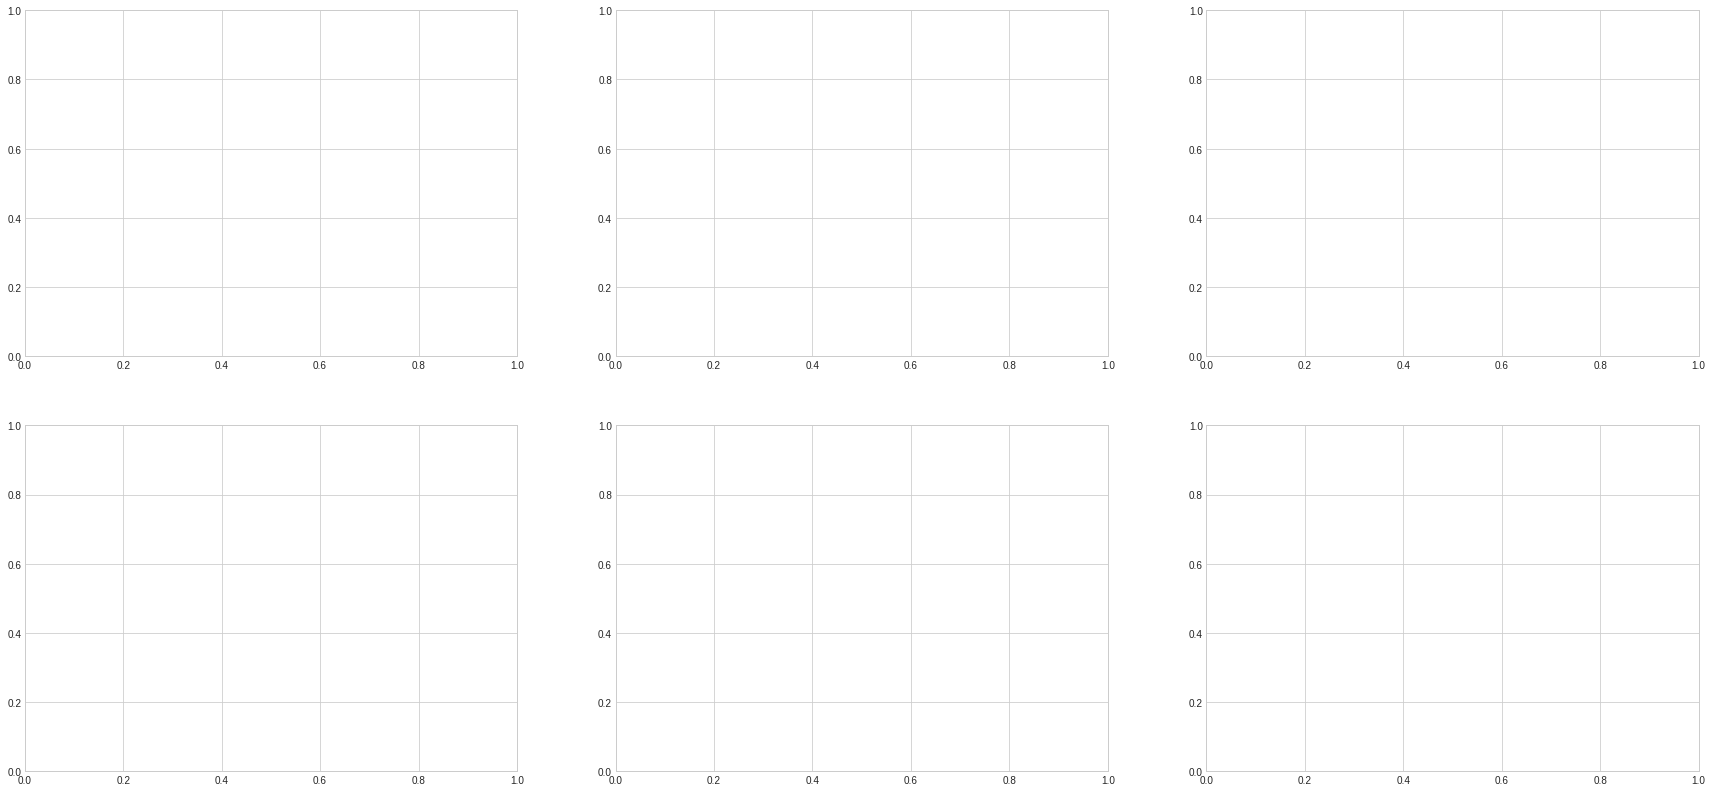

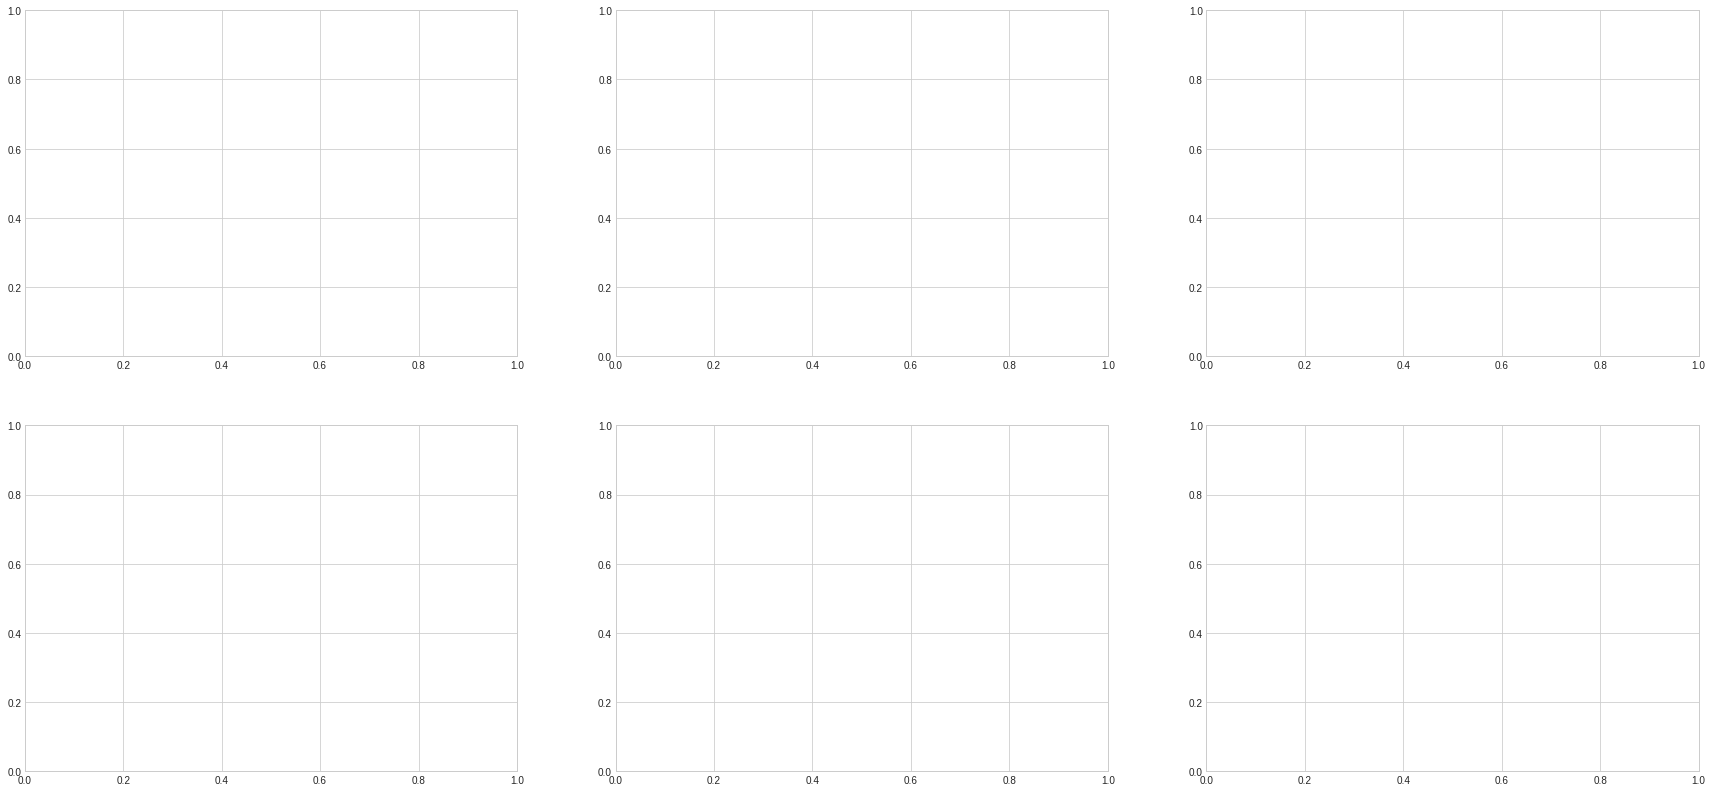

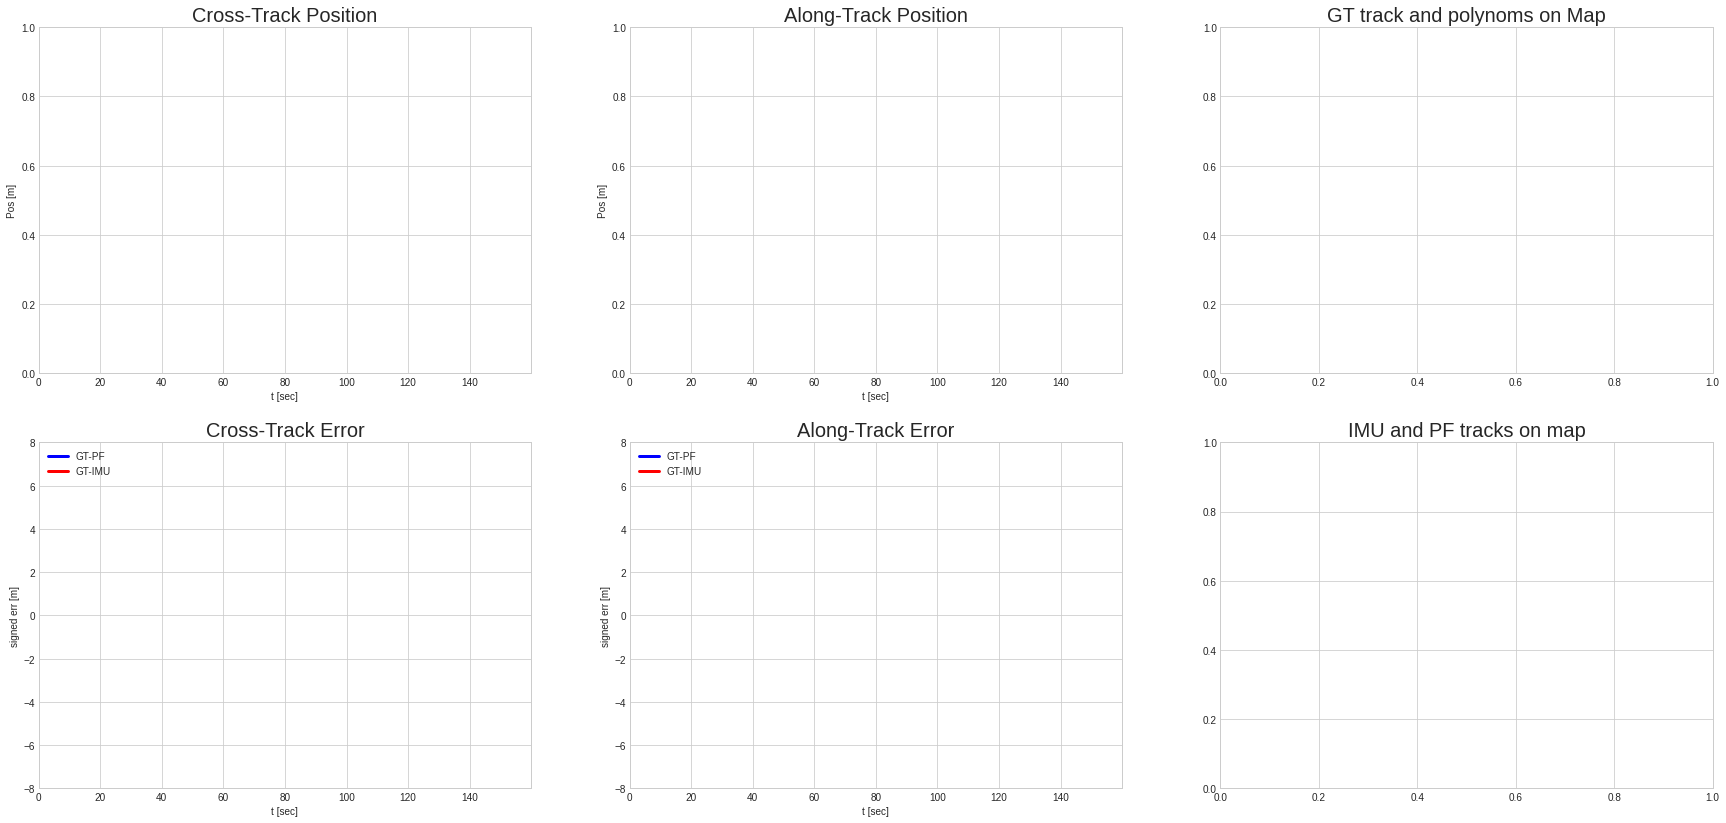

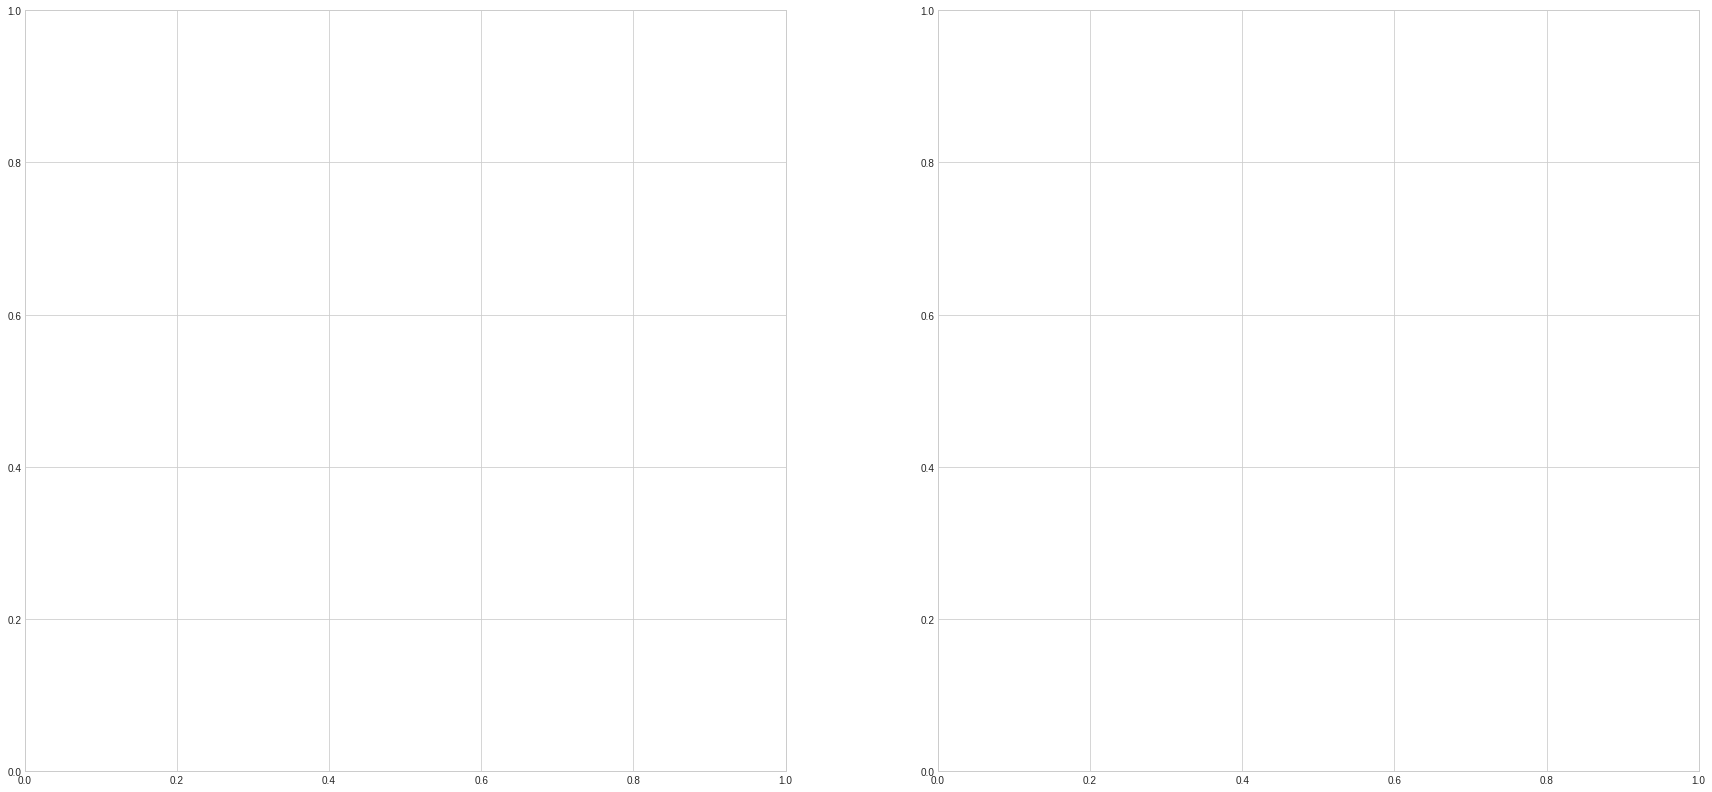

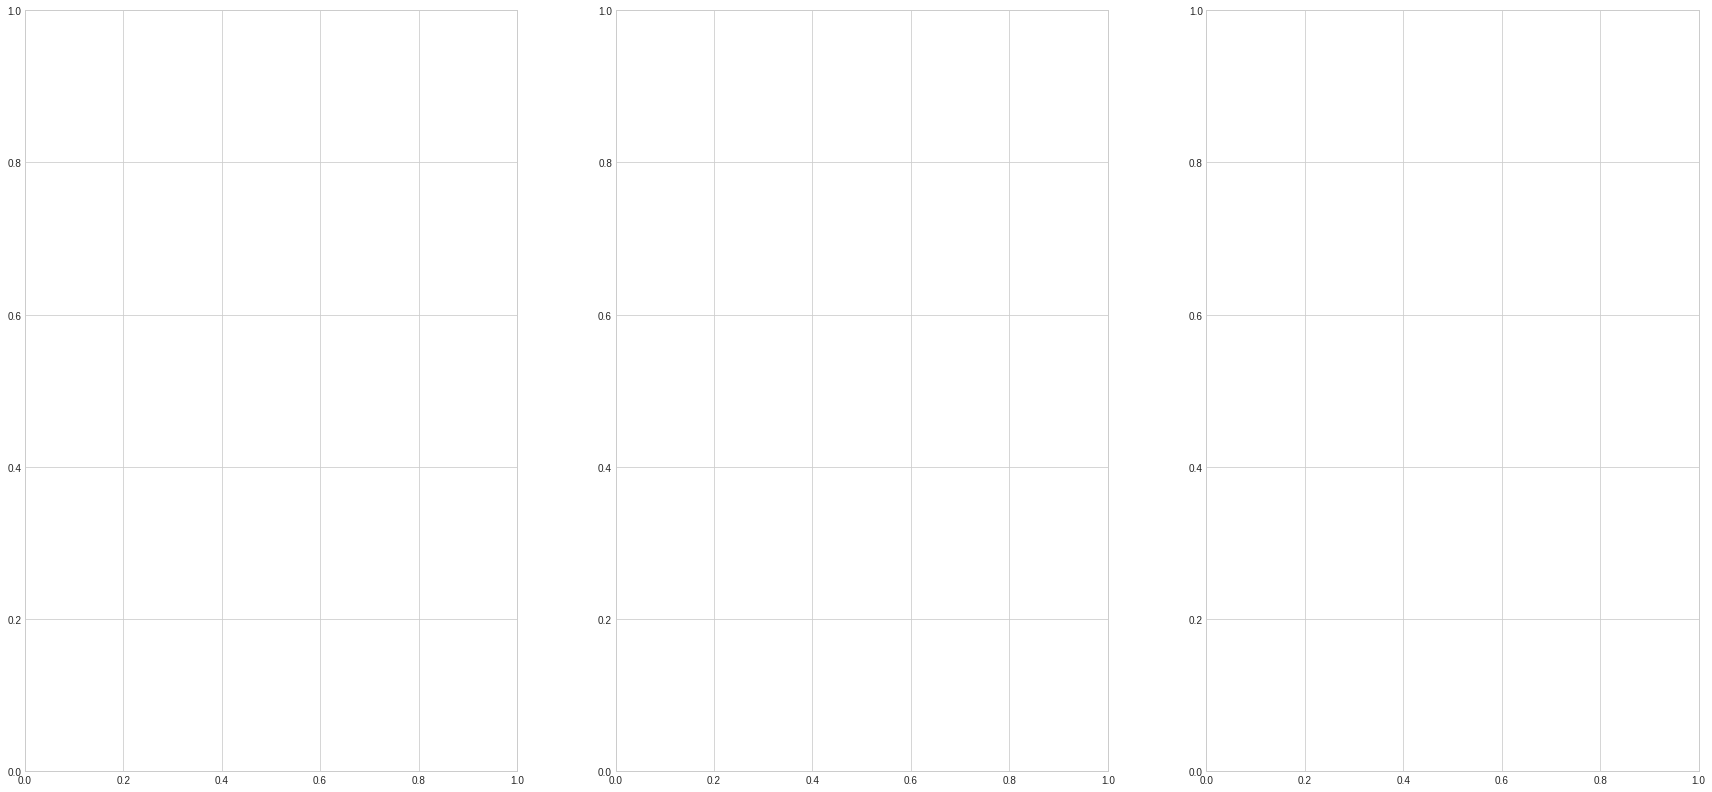

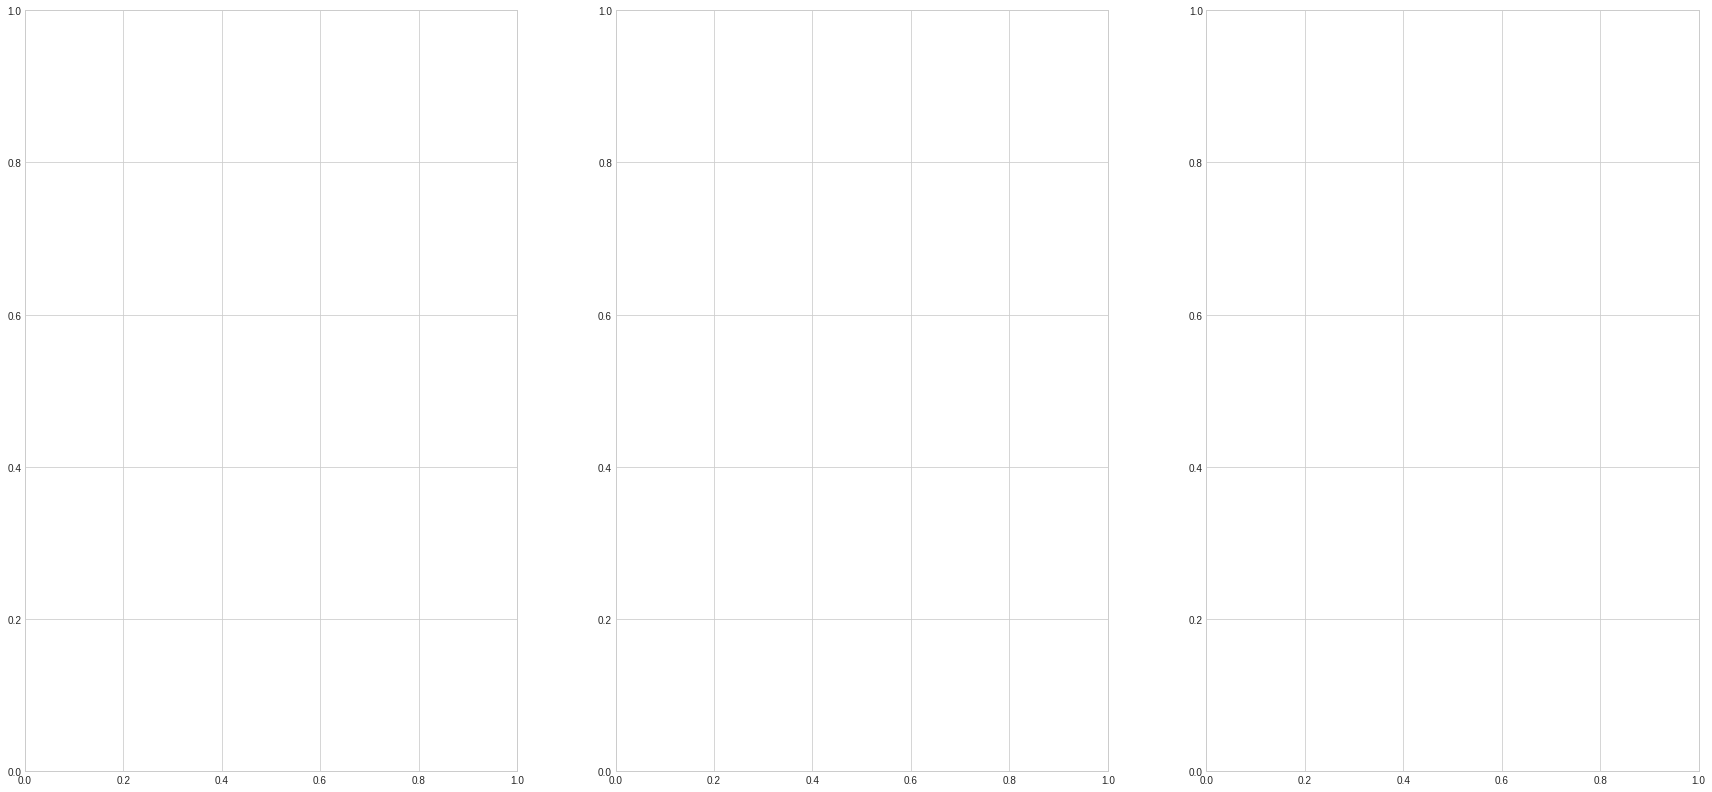

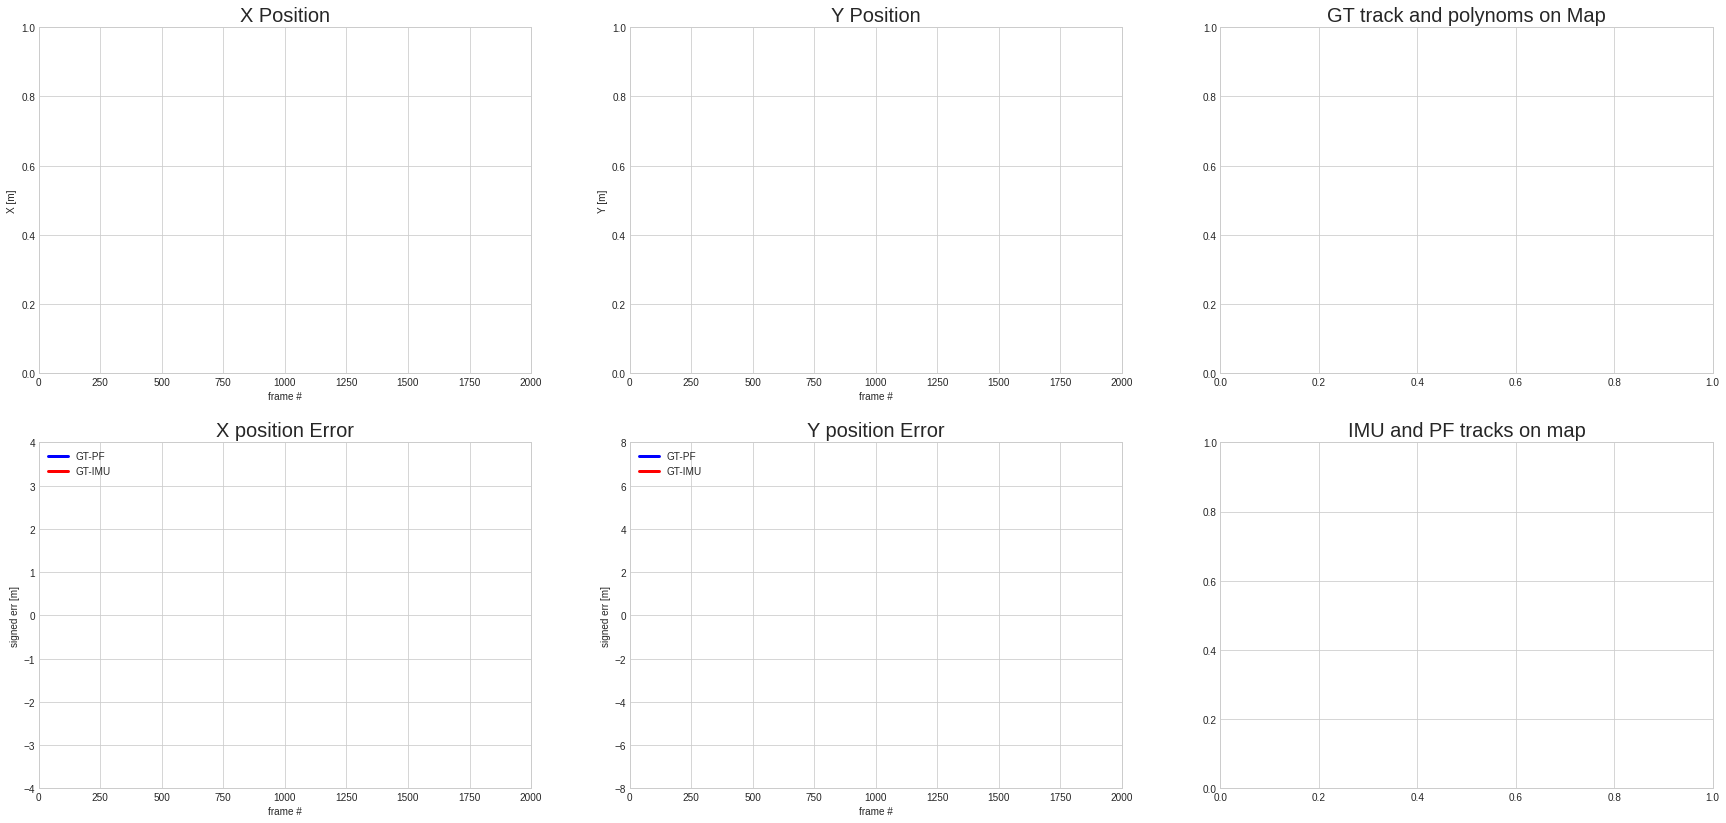

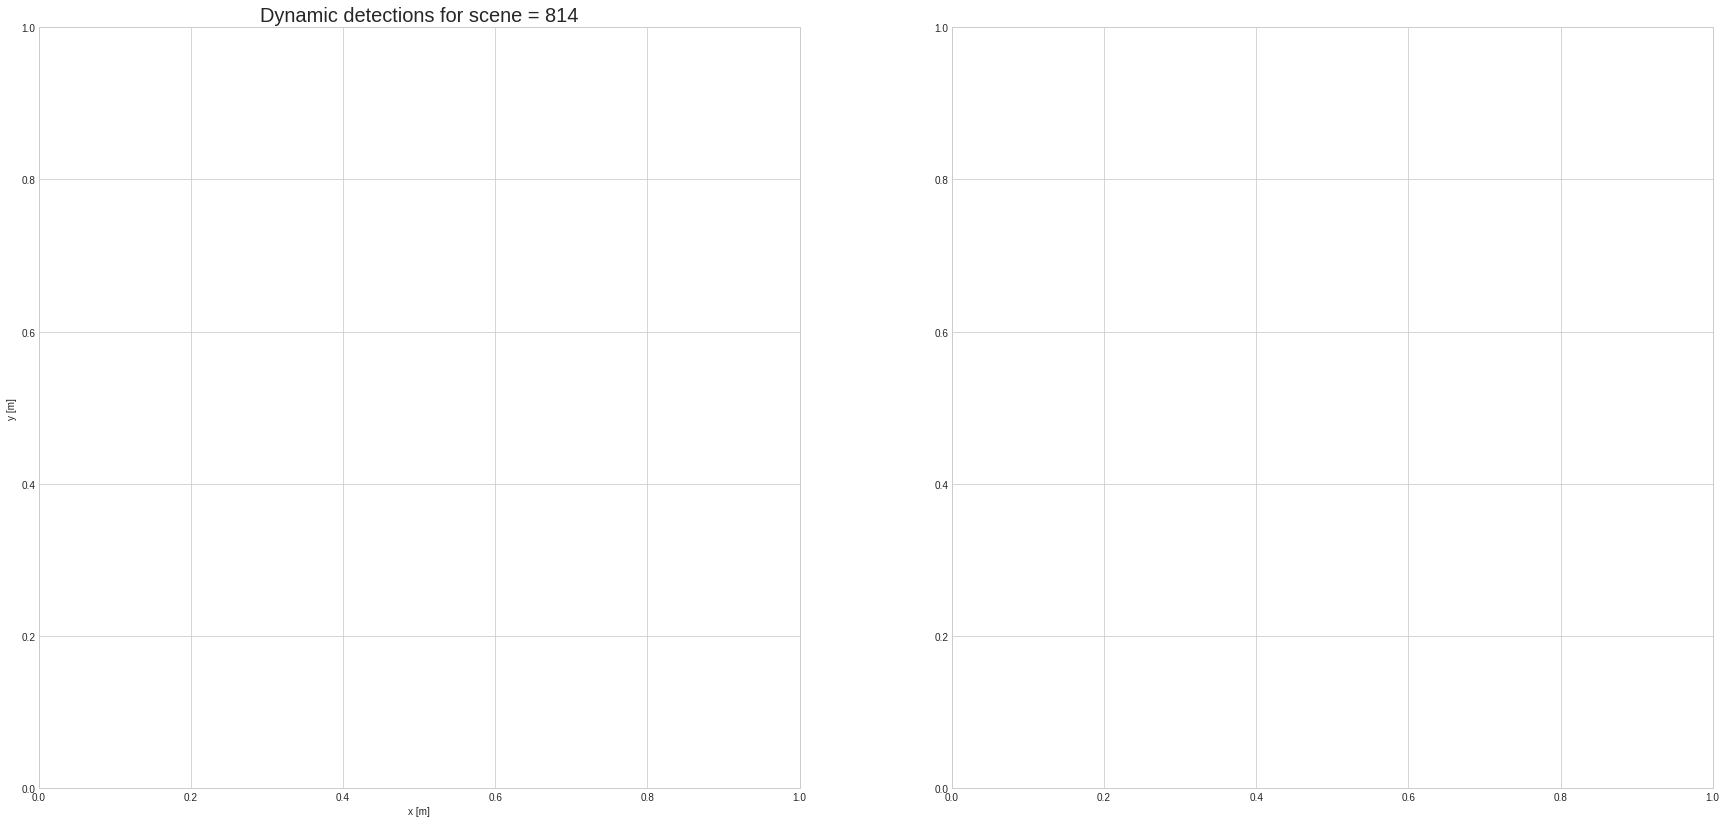

In [4]:
scene = 814 #365
model = RadarLocalizer(scene_id=scene, mm=True)
video_list={'video' : False, 'video_debug': False, 'video_pf': False, 'video_pf_xy': False, 'dynamic_tracker': False}
sim = NuscenesSimulation(nusc=nusc, model=model, scene_id=scene, Nmax=2000, video_list=video_list, save_processed=True)
sim.run(start=0, N=2000, generate_video=False, video_with_priors=True, debug=False)

In [ ]:
sim.video.generate(name=f"video\scene6_wmap.avi", fps=5)

scene_id=365 scene_name=scene-0451 map_name=boston-seaport
odom_speed [[1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.30000000e+01]
 ...
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]]
gt [1872.7430668711531, 1071.9499580039733, 0.0] ins [1872.7430668711531, 1071.9499580039733, 0.0]
gt [1872.9656838675555, 1072.1147770276675, 0.0] ins [1872.98214266 1072.12762265    0.        ]
gt [1873.197021748008, 1072.2744418932002, 0.0] ins [1873.26474338 1072.32249811    0.        ]
gt [1873.441761401517, 1072.4343429220644, 0.0] ins [1873.5228249  1072.48639182    0.        ]
gt [1873.702274610831, 1072.5903339908991, 0.0] ins [1873.82757276 1072.66387166    0.        ]
gt [1874.2541783730942, 1072.8830707104162, 0.0] ins [1874.44362047 1072.96742662    0.        ]
gt [1874.5465496397987, 1073.018591867703, 0.0] ins [1874.73675211 1073.09710368    0.        ]
gt [1874.8365718455975, 1073.1359006706575, 0.0] 

gt [1919.240768721885, 1051.3982299692614, 0.0] ins [1921.05246498 1051.51945754    0.        ]
gt [1920.43550779341, 1050.6401859246007, 0.0] ins [1922.26522586 1050.77306746    0.        ]
gt [1921.0387726742154, 1050.2578009934596, 0.0] ins [1922.83346561 1050.42338073    0.        ]
gt [1921.6525444341269, 1049.868272389079, 0.0] ins [1923.48419476 1050.02292154    0.        ]
gt [1922.263063608517, 1049.4769942121188, 0.0] ins [1924.07083828 1049.6619455     0.        ]
gt [1922.8597750514552, 1049.0991385090683, 0.0] ins [1924.71711875 1049.26454964    0.        ]
gt [1923.462421075392, 1048.7163832005515, 0.0] ins [1925.29258452 1048.9108101     0.        ]
gt [1924.6715978329134, 1047.9457771198702, 0.0] ins [1926.5298465  1048.14940737    0.        ]
gt [1925.2767122516616, 1047.5589263694637, 0.0] ins [1927.18888244 1047.74354935    0.        ]
gt [1925.887104397188, 1047.1713267793093, 0.0] ins [1927.7645791  1047.38867673    0.        ]
gt [1926.4990046782855, 1046.77977023

gt [1984.7812947425846, 1010.1274589418626, 0.0] ins [1987.72468557 1010.64821936    0.        ]
gt [1985.3770450527695, 1009.7492021709702, 0.0] ins [1988.31806852 1010.28647794    0.        ]
gt [1986.0421458036114, 1009.3326497257169, 0.0] ins [1989.00934133 1009.86508002    0.        ]
gt [1986.6813547551, 1008.9350548715986, 0.0] ins [1989.6227099  1009.49110625    0.        ]
gt [1987.3127648803172, 1008.541616152962, 0.0] ins [1990.30012483 1009.0779723     0.        ]
gt [1987.9446914064695, 1008.146465483751, 0.0] ins [1990.89812482 1008.7133        0.        ]
gt [1989.2040412244764, 1007.3608406166421, 0.0] ins [1992.1838297  1007.93023034    0.        ]
gt [1989.8316612958643, 1006.9692993569337, 0.0] ins [1992.86416101 1007.51585843    0.        ]
gt [1990.4722083851916, 1006.556223459935, 0.0] ins [1993.46268419 1007.15128169    0.        ]
gt [1991.0901633709964, 1006.1716881471534, 0.0] ins [1994.13627415 1006.74117868    0.        ]
gt [1991.7116995443985, 1005.7815883

gt [2051.264122060744, 968.9419179144304, 0.0] ins [2055.31700827  969.7852148     0.        ]
gt [2052.5233602892877, 968.1569606670542, 0.0] ins [2056.59147059  969.00798925    0.        ]
gt [2053.1541172474635, 967.761067344367, 0.0] ins [2057.20492284  968.63391473    0.        ]
gt [2053.7915617979447, 967.360229256698, 0.0] ins [2057.89089723  968.21580428    0.        ]
gt [2054.421627001507, 966.9670874219858, 0.0] ins [2058.48758541  967.85238119    0.        ]
gt [2055.052537702662, 966.5716693199514, 0.0] ins [2059.1770485   967.43269552    0.        ]
gt [2055.6975527512996, 966.1672092492495, 0.0] ins [2059.77995386  967.06598601    0.        ]
gt [2056.9670603489512, 965.365119365383, 0.0] ins [2061.0575252   966.28990103    0.        ]
gt [2057.6015382733904, 964.9700612132848, 0.0] ins [2061.74572052  965.87213845    0.        ]
gt [2058.235527483056, 964.5776241176768, 0.0] ins [2062.34482993  965.50865248    0.        ]
gt [2058.8639462265737, 964.1937440580077, 0.0]

gt [2105.8298358037023, 935.0039626178104, 0.0] ins [2110.69584933  936.165935      0.        ]
gt [2106.2526677692085, 934.7381752529197, 0.0] ins [2111.0884378   935.92504859    0.        ]
gt [2106.661951466421, 934.4819058275039, 0.0] ins [2111.54409149  935.64541736    0.        ]
gt [2107.0780072294115, 934.2195096339517, 0.0] ins [2111.99704368  935.3674516     0.        ]
gt [2107.4846907223337, 933.9662088847593, 0.0] ins [2112.39877     935.12059135    0.        ]
gt [2108.2862358975626, 933.4610788508512, 0.0] ins [2113.22791549  934.61036066    0.        ]
gt [2108.6844974690557, 933.2119856157867, 0.0] ins [2113.67174823  934.33725562    0.        ]
gt [2109.076214074382, 932.9649753111619, 0.0] ins [2114.06130789  934.09732619    0.        ]
gt [2109.4719559102787, 932.7149544329429, 0.0] ins [2114.49457975  933.83025175    0.        ]
gt [2109.8636765578935, 932.4669655384389, 0.0] ins [2114.87421304  933.59615706    0.        ]
gt [2110.2919939385392, 932.1963487182021,

gt [2126.296874696447, 921.9607020048984, 0.0] ins [2131.85920767  923.08172509    0.        ]
gt [2126.4755723577937, 921.8446171964106, 0.0] ins [2132.0243902   922.97614611    0.        ]
gt [2126.645987264742, 921.732740607203, 0.0] ins [2132.19343157  922.866455      0.        ]
gt [2126.833096475495, 921.6083654634793, 0.0] ins [2132.39549702  922.73217837    0.        ]
gt [2127.024170412872, 921.4790987537663, 0.0] ins [2132.57990377  922.60724239    0.        ]
gt [2127.2248221234267, 921.3389413385714, 0.0] ins [2132.7939644   922.45864702    0.        ]
gt [2127.6376692430326, 921.0413791000362, 0.0] ins [2133.20669611  922.15427792    0.        ]
gt [2127.843848771591, 920.8857805949233, 0.0] ins [2133.40745034  922.00136616    0.        ]
gt [2128.0704951481925, 920.7104658939124, 0.0] ins [2133.63760859  921.82056053    0.        ]
gt [2128.2758745170786, 920.5465726111729, 0.0] ins [2133.84064461  921.65802065    0.        ]
gt [2128.5116985444024, 920.3514670126651, 0.0

gt [2123.6255902618013, 892.1561171083977, 0.0] ins [2129.21581494  891.61298712    0.        ]
gt [2123.431316516151, 891.8597128545953, 0.0] ins [2129.02528059  891.31011669    0.        ]
gt [2123.326658452318, 891.7000609543284, 0.0] ins [2128.92832381  891.15606424    0.        ]
gt [2123.24382664237, 891.5705615922652, 0.0] ins [2128.84470498  891.02314164    0.        ]
gt [2123.1514426177177, 891.4281705797891, 0.0] ins [2128.76662745  890.89891955    0.        ]
gt [2123.069785005169, 891.3021813827646, 0.0] ins [2128.68077201  890.76226639    0.        ]
gt [2122.9282215282938, 891.0835393409529, 0.0] ins [2128.53198313  890.52530139    0.        ]
gt [2122.8673924994596, 890.9875887594233, 0.0] ins [2128.47106296  890.42823004    0.        ]
gt [2122.8071747214035, 890.8927502325934, 0.0] ins [2128.40561992  890.32387185    0.        ]
gt [2122.746736714577, 890.7987722737714, 0.0] ins [2128.35293216  890.23976492    0.        ]
gt [2122.6890543088, 890.7105579433428, 0.0] i

gt [2122.4304367263526, 890.4008962981343, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.430341124353, 890.4009554766068, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4302414612393, 890.4010168997295, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4301373514595, 890.4010809171303, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4299497409543, 890.4011975093733, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.429865134025, 890.4012511885089, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4297772910377, 890.401307467967, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4296911676056, 890.4013622906396, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.429606093625, 890.4014152684771, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4295202188223, 890.4014681944468, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4293634903197, 890.4015653508387, 0

gt [2119.919350699114, 882.9547738499077, 0.0] ins [2125.68146391  882.40246118    0.        ]
gt [2119.9732872933123, 882.6474983187818, 0.0] ins [2125.7428585   882.11189468    0.        ]
gt [2120.035429170739, 882.361524915598, 0.0] ins [2125.82043608  881.81830184    0.        ]
gt [2120.1957771006923, 881.8114001874578, 0.0] ins [2126.00023817  881.30057097    0.        ]
gt [2120.300702974806, 881.5225225194172, 0.0] ins [2126.11774244  881.00608066    0.        ]
gt [2120.425744726576, 881.219280137853, 0.0] ins [2126.25277452  880.71141657    0.        ]
gt [2120.5565920132453, 880.9401914321568, 0.0] ins [2126.38219697  880.45613059    0.        ]
gt [2120.700948074343, 880.6667430723462, 0.0] ins [2126.54456576  880.16528531    0.        ]
gt [2121.0356541026863, 880.1136138125739, 0.0] ins [2126.90337768  879.64184764    0.        ]
gt [2121.227557516346, 879.8383480392782, 0.0] ins [2127.08225712  879.40108619    0.        ]
gt [2121.4326265129066, 879.5707423720257, 0.0] 

gt [2167.55785051683, 875.1257505826826, 0.0] ins [2173.76378313  875.31013101    0.        ]
gt [2168.1907179037466, 875.1373154055002, 0.0] ins [2174.37279086  875.32742628    0.        ]
gt [2169.460065510634, 875.1598513010081, 0.0] ins [2175.66252425  875.3635217     0.        ]
gt [2170.0823113040474, 875.1687396408981, 0.0] ins [2176.3634515   875.38322992    0.        ]
gt [2170.720662537157, 875.1803628545218, 0.0] ins [2177.04017069  875.40226155    0.        ]
gt [2171.3496988648158, 875.188738671927, 0.0] ins [2177.63941129  875.41915666    0.        ]
gt [2172.0236234931112, 875.2006525031728, 0.0] ins [2178.31940886  875.43854163    0.        ]
gt [2172.6356118454737, 875.210212164053, 0.0] ins [2178.91319768  875.45563441    0.        ]
gt [2173.953523509399, 875.2345465111464, 0.0] ins [2180.25912     875.49408611    0.        ]
gt [2174.5857440788623, 875.2442237117139, 0.0] ins [2180.85244039  875.51107437    0.        ]
gt [2175.168495784878, 875.2579985920689, 0.0] 

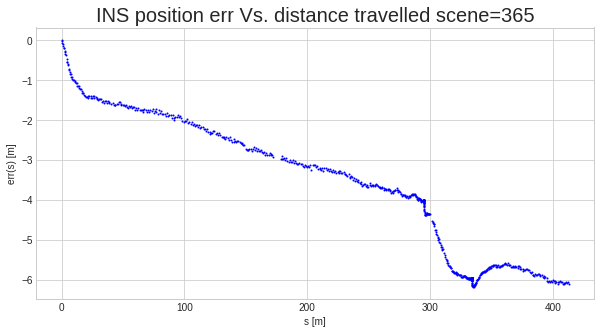

In [131]:
import scipy
scene = 365
dataset = NuscenesDataset(nusc=nusc, directory=directory,scene_id=scene)
N = 800
gt = np.zeros(N)
imu = np.zeros(N)
gt_pos = np.zeros((N,2))
imu_pos = np.zeros((N,2))
timestamp = np.zeros(N)
for t in range(0,N):
    trns, rot = dataset.getEgoInfo(dataset.first_idx + t, GT=True)
    gt[t] = np.linalg.norm(trns[0:2]-gt_pos[t-1, :]) if t > 0 else 0
    gt_pos[t, :] = trns[0:2]
    trns1, rot1 = dataset.getEgoInfo(dataset.first_idx + t, GT=False)
    print("gt", trns, "ins", trns1)
    imu[t] = np.linalg.norm(trns1[0:2]-imu_pos[t-1, :]) if t > 0 else 0
    imu_pos[t, :] = trns1[0:2]
    timestamp[t] = dataset.odometry['timestamp']
    
gt_int = np.cumsum(gt)
imu_int = np.cumsum(imu)
    
fig, ax = plt.subplots(1,figsize=(10,5))
ax.set_title(f"INS position err Vs. distance travelled scene={scene}", fontsize=20)
ax.set(xlabel='s [m]', ylabel='err(s) [m]')
ax.scatter(gt_int,gt_int-imu_int,color='blue',s=1)

scene_id=365 scene_name=scene-0451 map_name=boston-seaport
odom_speed [[1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.30000000e+01]
 ...
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]]


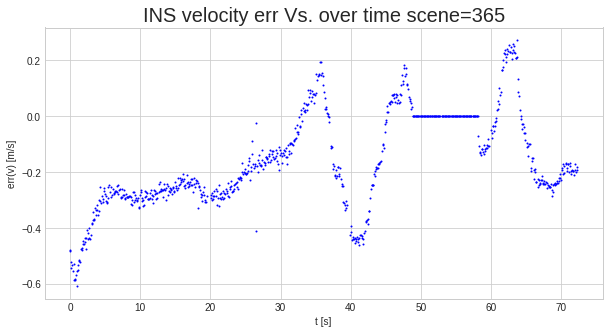

In [134]:
#draw the speed
import scipy
scene = 365
dataset = NuscenesDataset(nusc=nusc, directory=directory,scene_id=scene)
N = 800#800
gt_speed = np.zeros(N)
imu_speed = np.zeros(N)
timestamp = np.zeros(N)
for t in range(0,N):
    trns, rot = dataset.getEgoInfo(dataset.first_idx + t, GT=True)
    gt_speed[t] = np.linalg.norm(dataset.odometry['speed'])
    trns1, rot1 = dataset.getEgoInfo(dataset.first_idx + t, GT=False)
    imu_speed[t] = dataset.odometry['speed']
    timestamp[t] = dataset.odometry['timestamp']
    
fig, ax = plt.subplots(1,figsize=(10,5))
ax.set_title(f"INS velocity err Vs. over time scene={scene}", fontsize=20)
ax.set(xlabel='t [s]', ylabel='err(v) [m/s]')
ax.scatter(timestamp[:]-timestamp[0],gt_speed-imu_speed,color='blue',s=1)

In [ ]:
from pyquaternion import Quaternion

Quaternion.Inverse()

In [ ]:
dataset = NuscenesDataset(nusc=nusc, directory=directory, scene_id=426)
_, _, _, video_data, nusc_map = dataset.getData(700)
map_matching = MapMatching(N=10)

In [ ]:
edges1 = map_matching.getRoadBorders(nuscMap=nusc_map, worldRef=video_data['pos'], layer_names=['walkway'],blur_area=(3,3),threshold1=0.5, threshold2=0.9)
edges2 = map_matching.getRoadBorders(nuscMap=nusc_map, worldRef=video_data['pos'], layer_names=['drivable_area'],blur_area=(3,3),threshold1=0.5, threshold2=0.9)
edges = edges1 & edges2

#road = map_matching.getDrivableArea(nuscMap=nusc_map, worldRef=[400,850],layer_names = ['drivable_area'], patch_size=200)
plt.imshow(edges2, origin='lower')

In [ ]:
a = np.array([[1, 2],[3,4],[5,6],[7,8]])
print(a.shape)
b = np.array([[11, 19],[7,28],[15,16]]).T
print(b.shape)
print(a[:,0].shape)
k = a[:,0].reshape(-1,1)-b[0,:].reshape(1,-1)
t = a[:,1].reshape(-1,1)-b[1,:].reshape(1,-1)
norm = np.sqrt(k**2 + t**2)
it = norm.argmin(axis=1)
print("it", it, "norm",norm)
#print(np.amin(norm, axis=1))
print(k.shape, t.shape)
print(k)
print(np.take_along_axis(k, np.expand_dims(it, axis=-1), axis=1))
print(np.take_along_axis(t, np.expand_dims(it, axis=-1), axis=1))

In [30]:
A = np.zeros((3,3))
pnts = [[0,1],[3,3],[6,1]]
dist = np.array([pnt[0]**2 for pnt in pnts])
candidates = np.where(dist>5)[0]
non_candidates = np.where(dist<=5)[0]

A[candidates,0] = 1
print(A)

[[0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [144]:
mapa = sim.dataset.getMap()


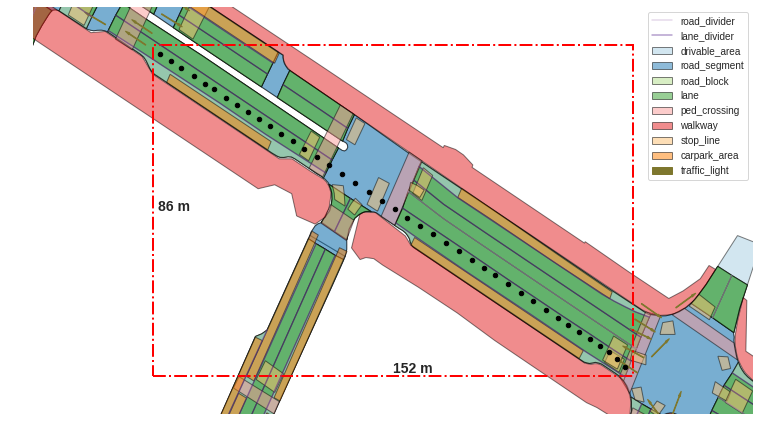

In [148]:
ego_poses = mapa.render_egoposes_on_fancy_map(nusc, scene_tokens=[nusc.scene[692]['token']], verbose=False)

scene_id=690 scene_name=scene-0904 map_name=boston-seaport


/home/kfir/workspace/RadarLocalization/dataset.py:310: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.first_imu_rot = Quaternion(rot_imu[ridx,1])


odom_speed [[1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 ...
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


history []


/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

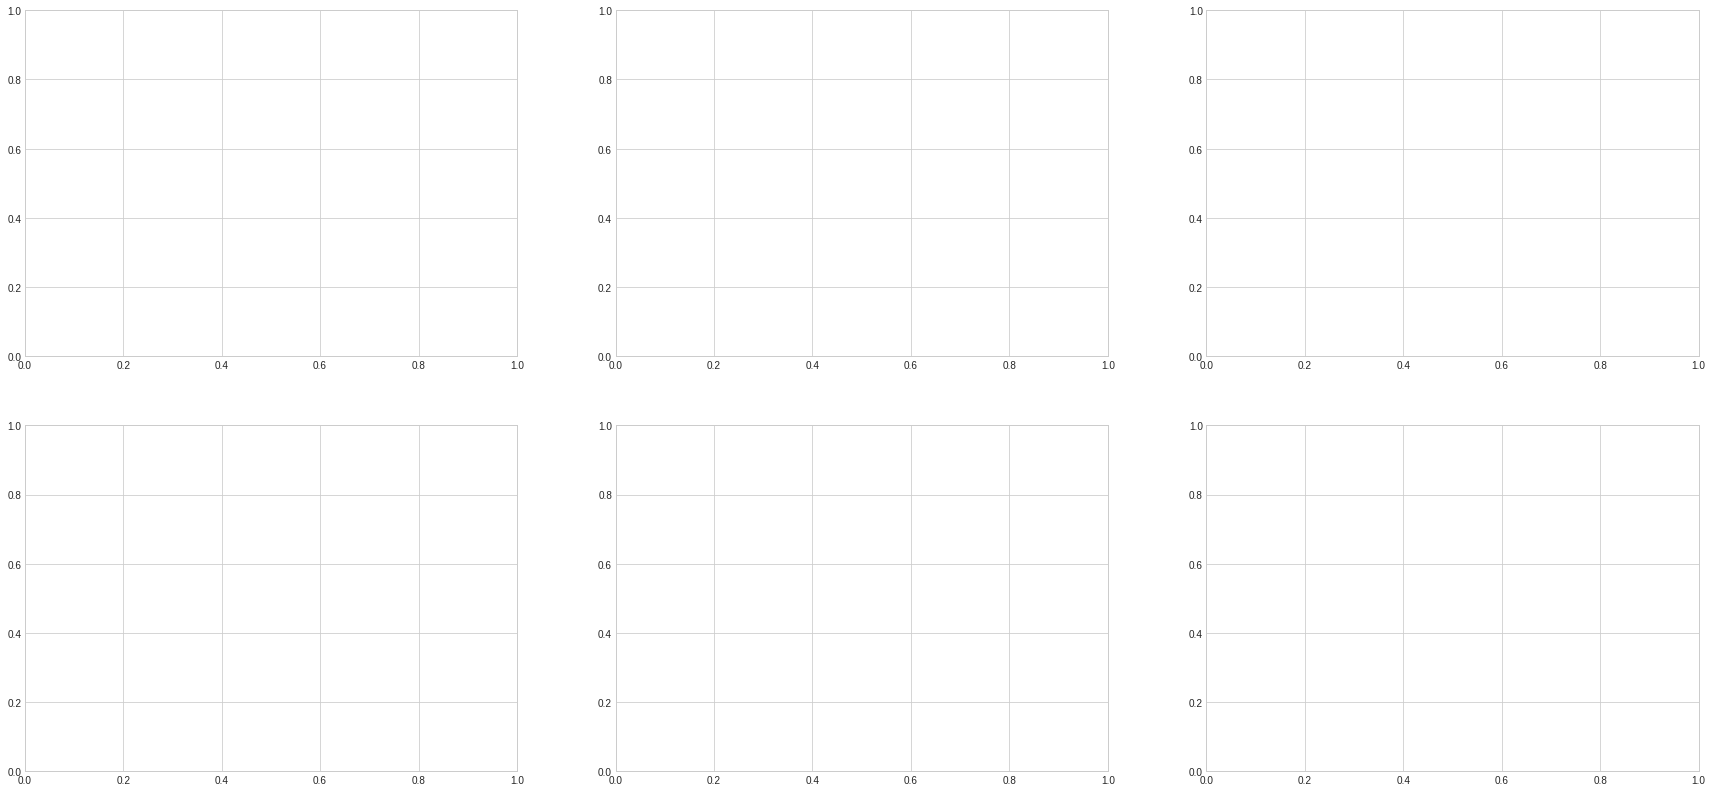

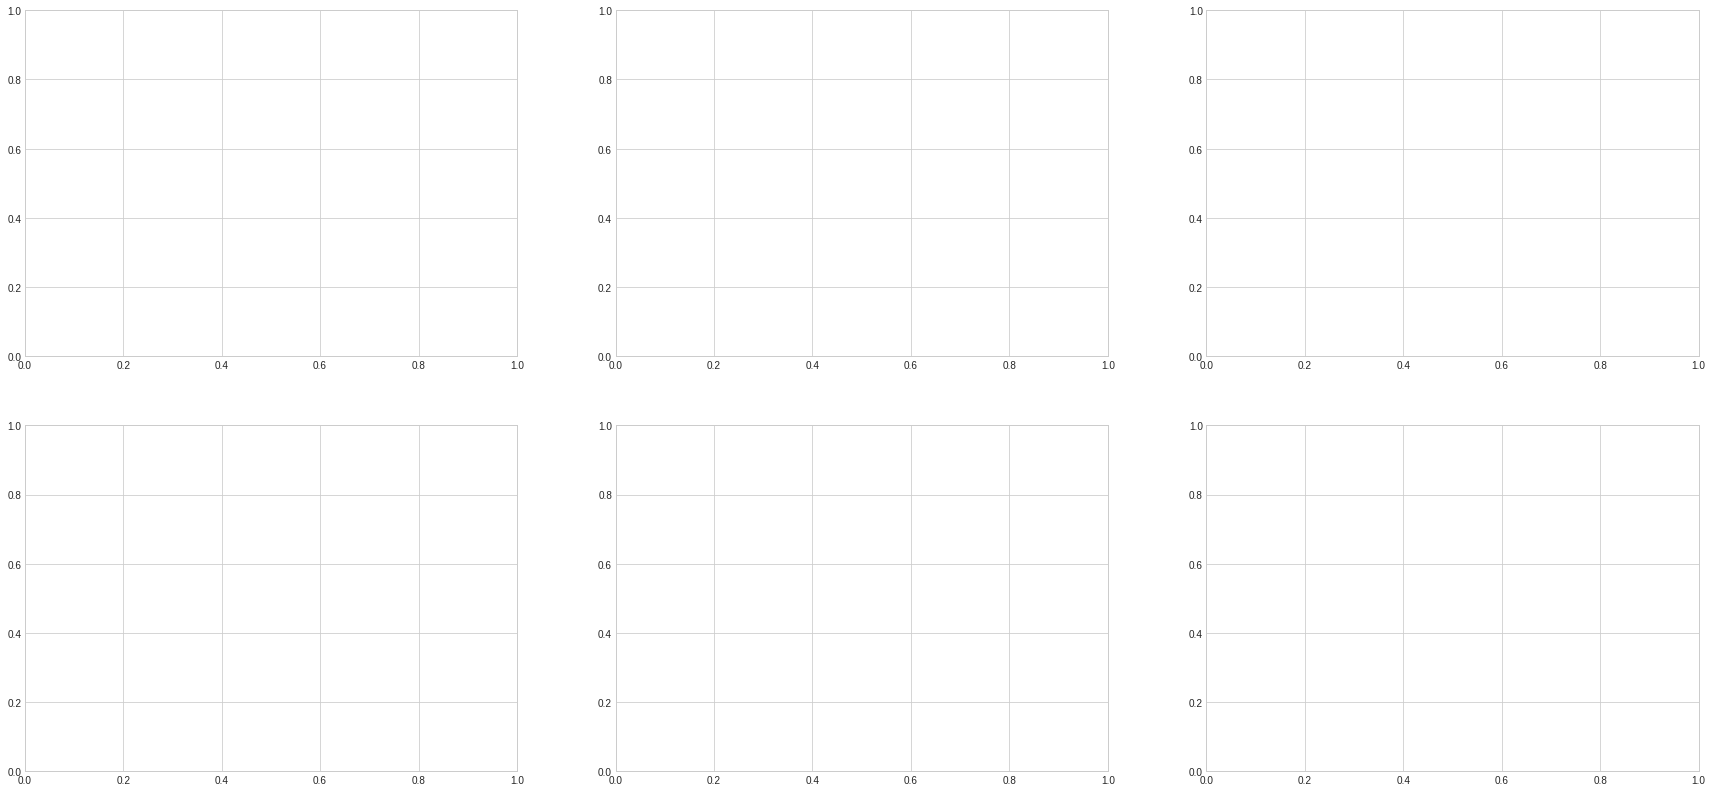

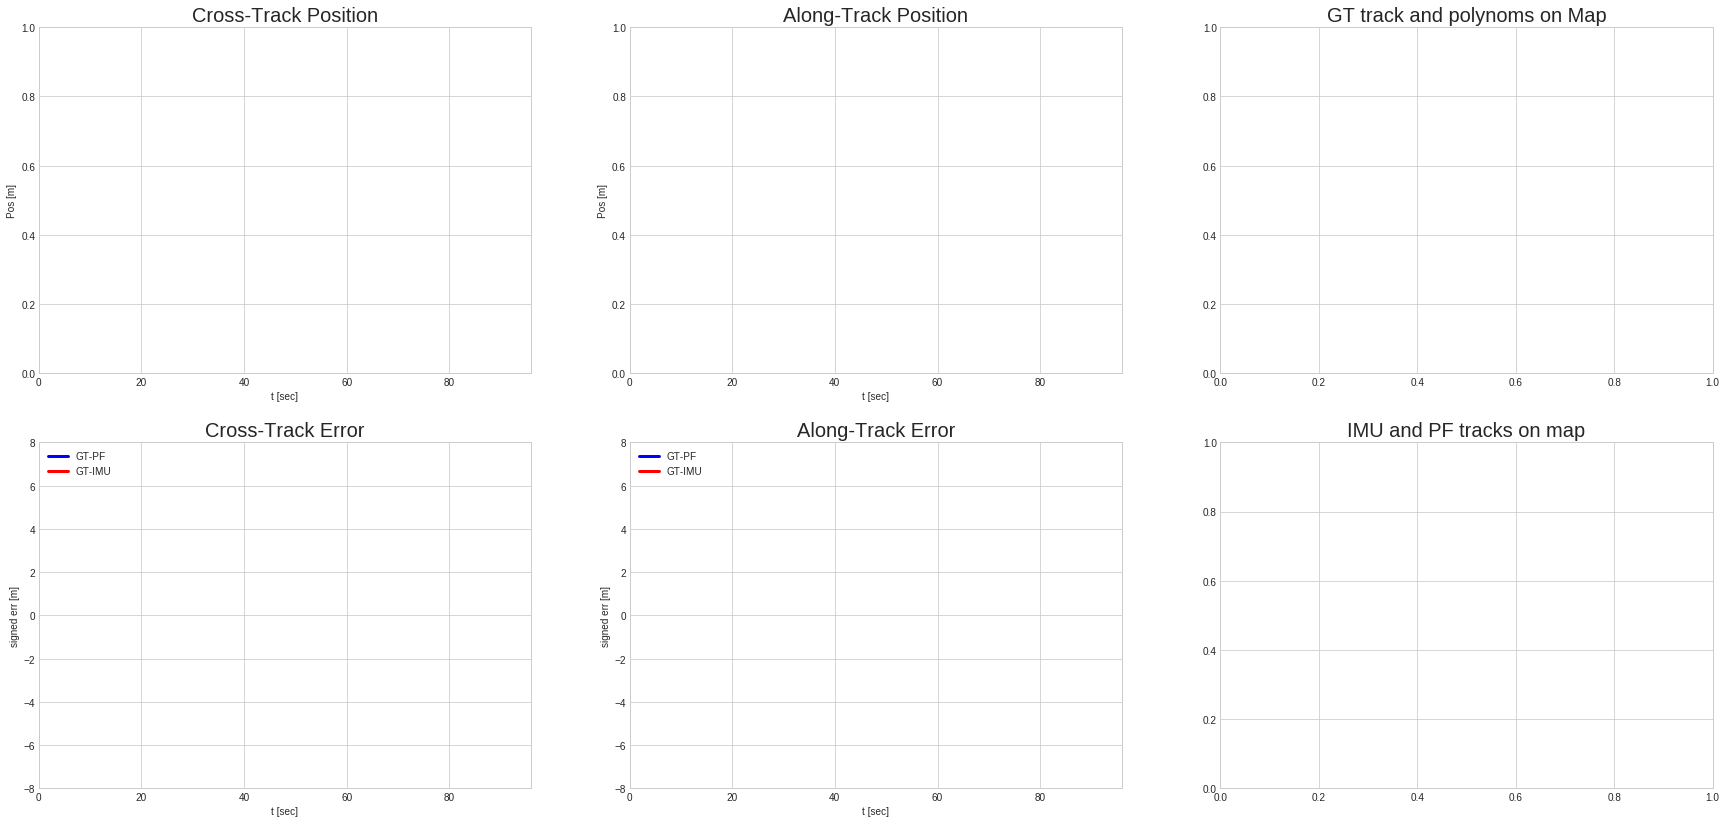

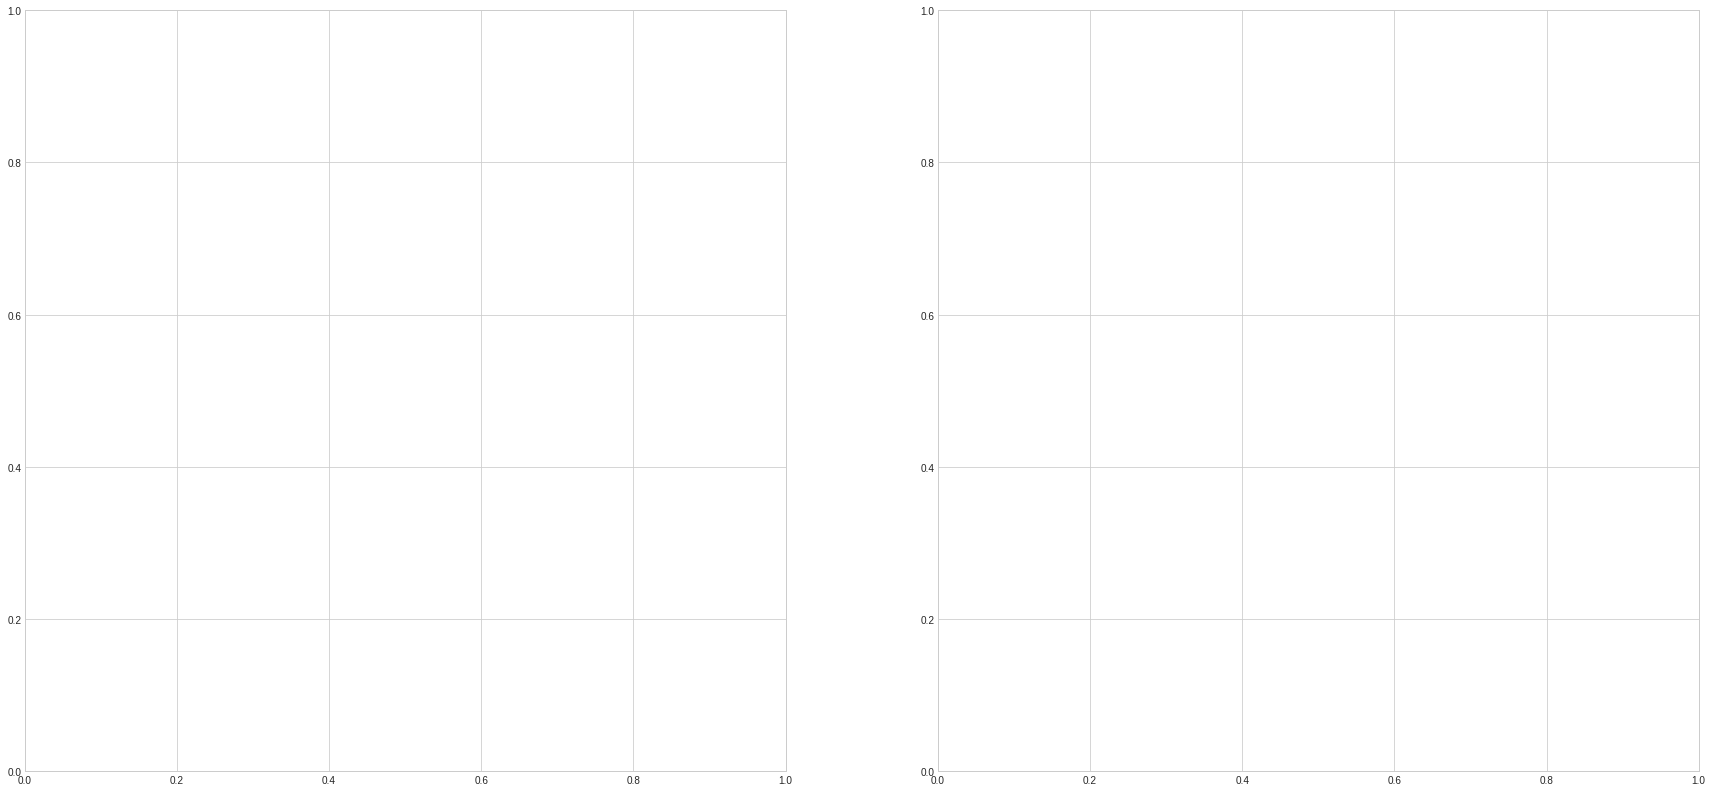

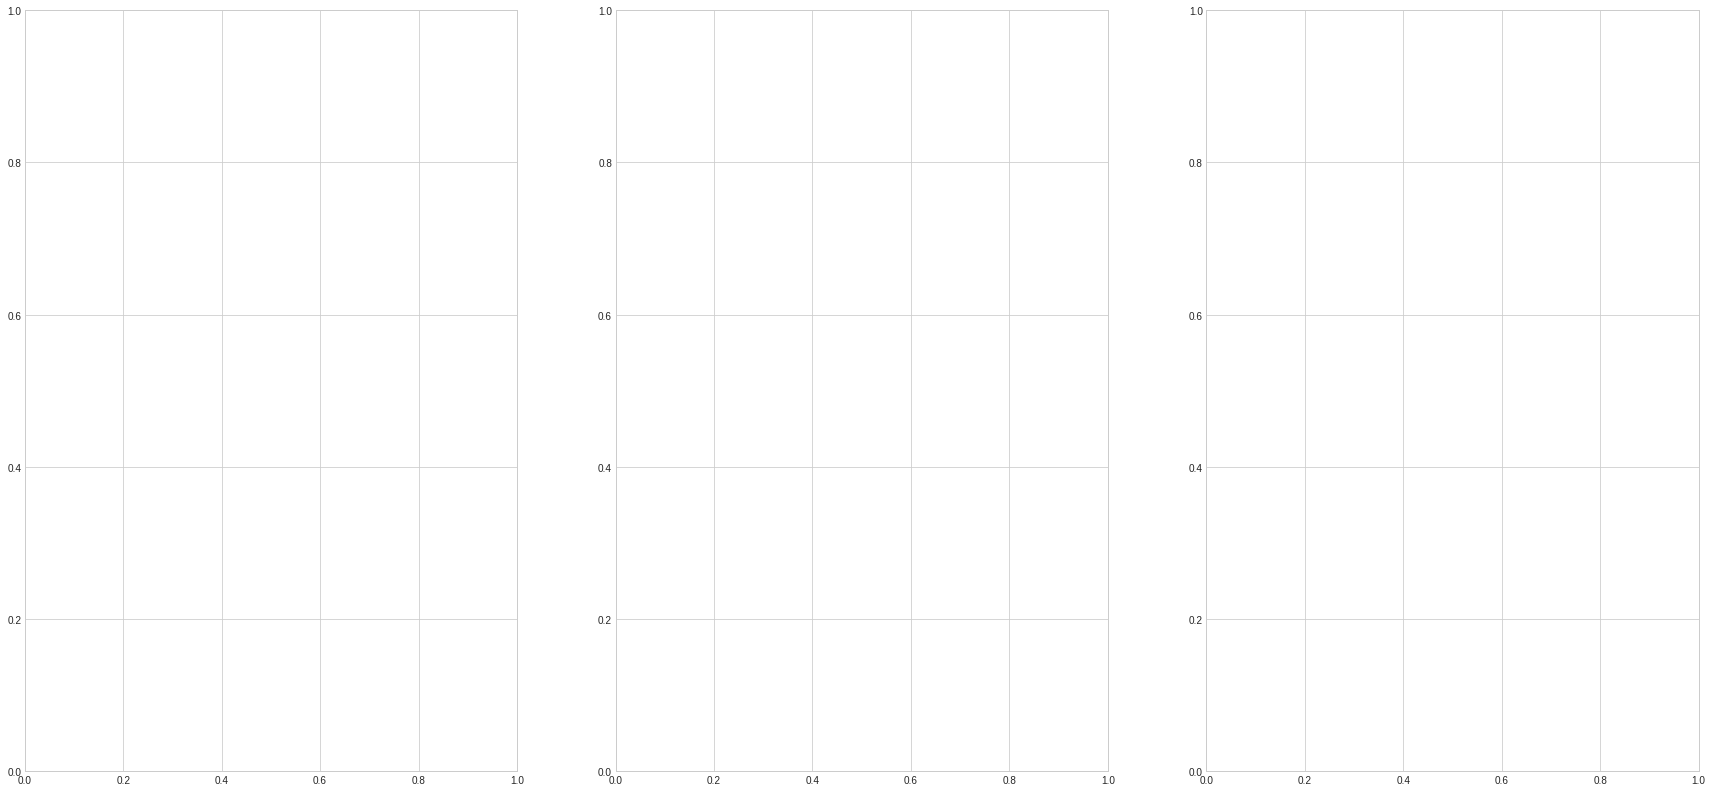

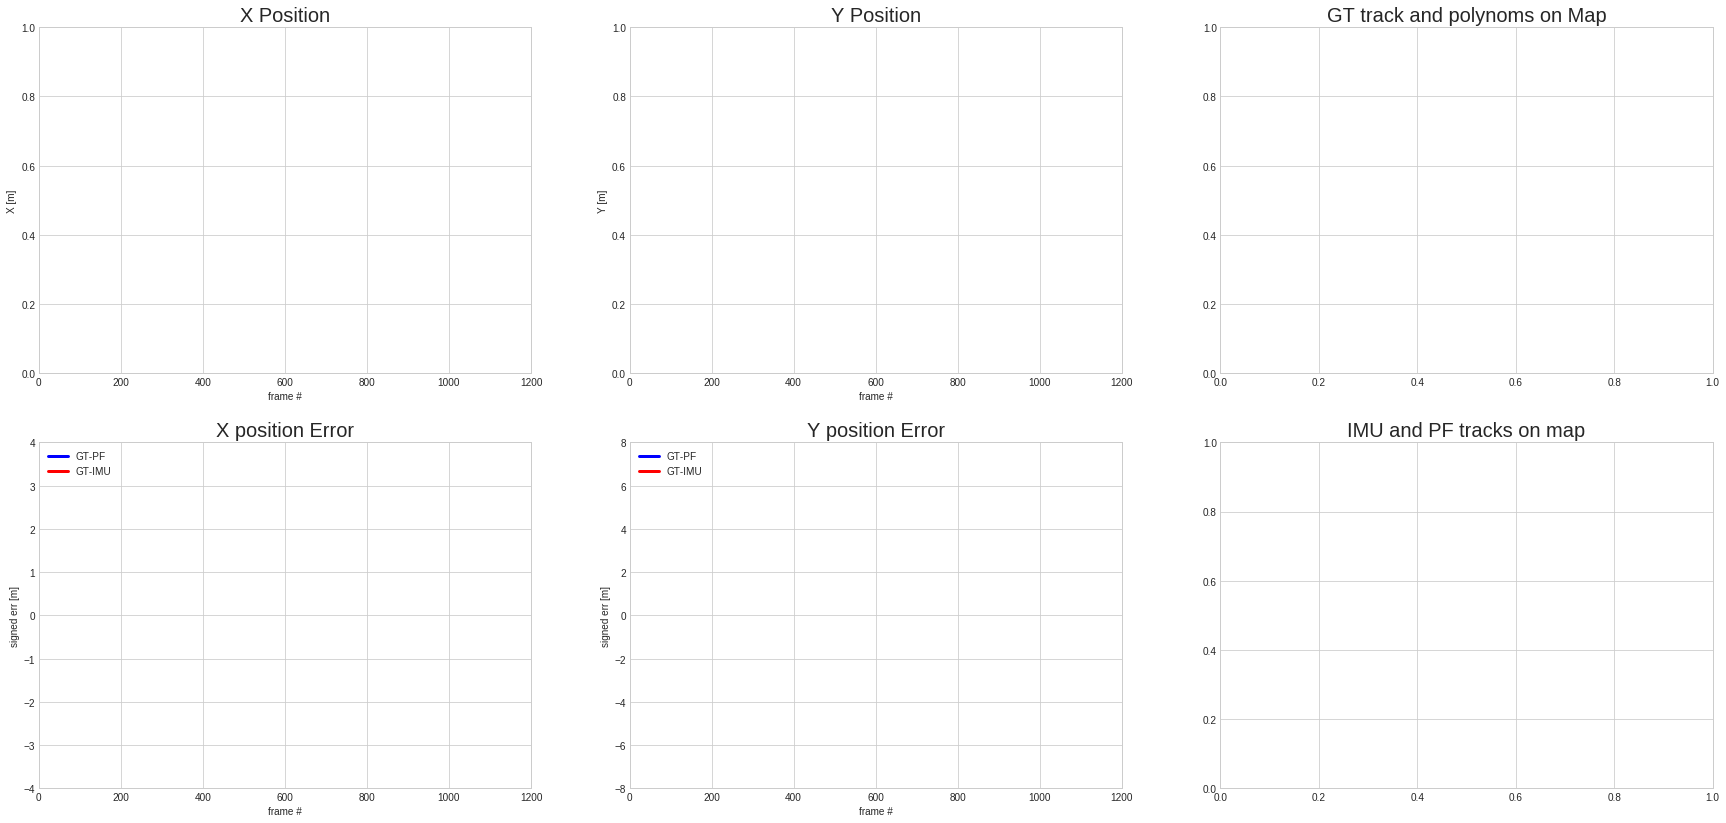

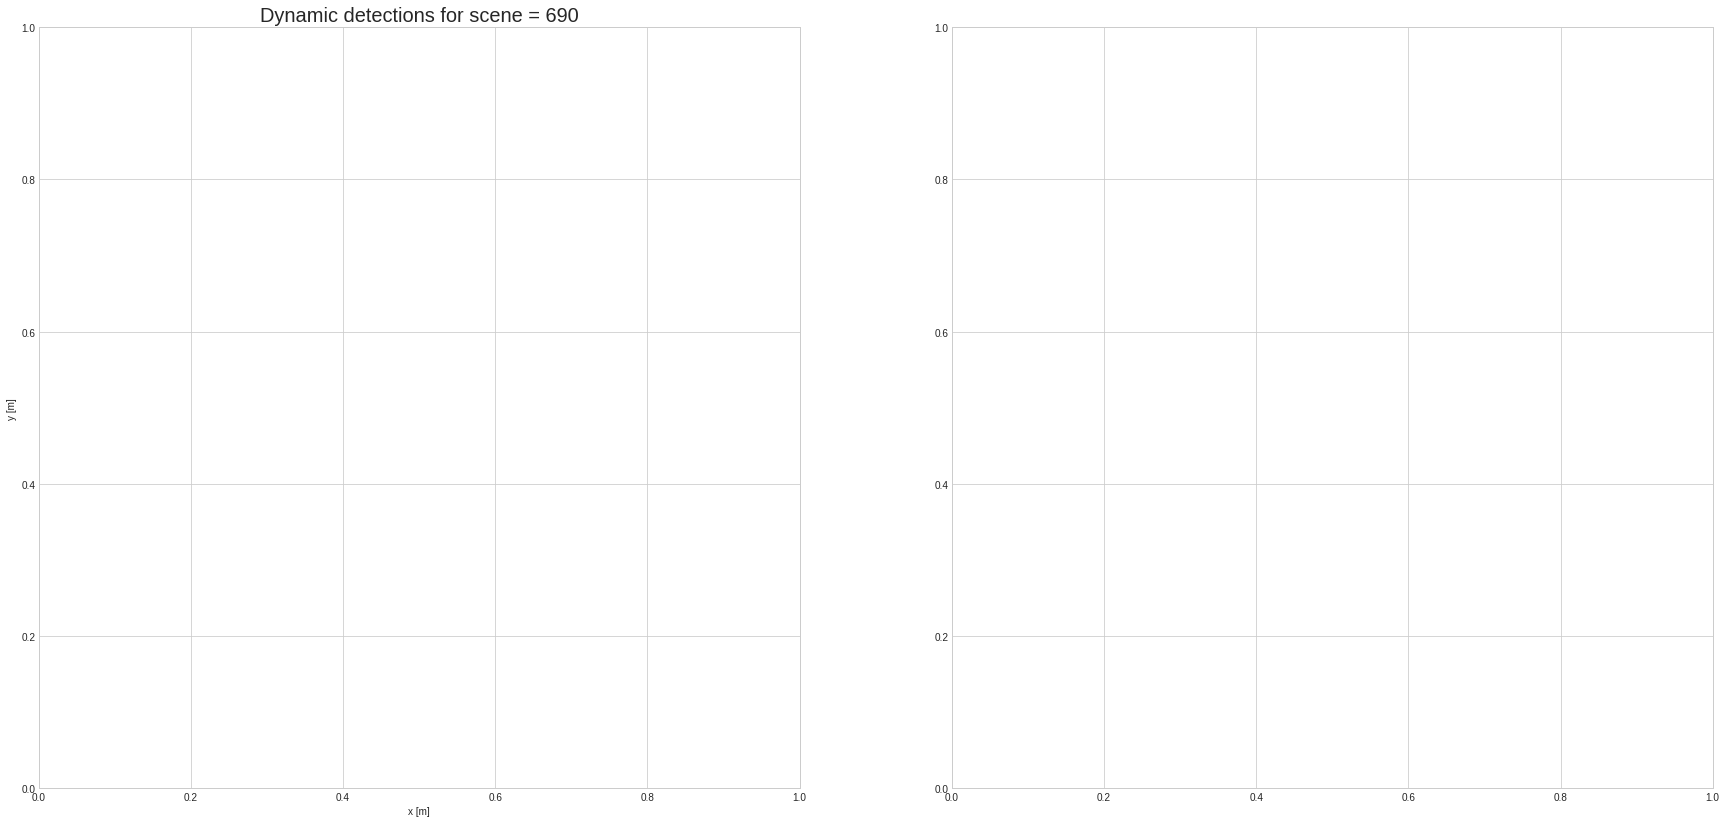

In [274]:
start_frame=0
n_frames = 15
ego_path = sim.dataset.getEgoPath()[:n_frames]
tracker = DynamicTracker()
dbscan_clustering = ClassicDBSCAN()
sim = NuscenesSimulation(nusc=nusc, model=model, scene_id=scene, Nmax=1200, video_list=video_list)

print("history",history)
for t in range(start_frame,n_frames):
    _, _, _, pc, video_data, _ = sim.dataset.getData(t,GT=False)
    ts, heading, ego_speed = video_data["timestamp"], np.deg2rad(video_data["heading"]-90), video_data["veh_speed"]
    print("t", t)
    Z, C = dbscan_clustering.run(pc=pc, ego=ego_path[t], heading=np.deg2rad(heading))
    print("C",C)
    tracker.run(Z, ts, {"heading": np.deg2rad(heading), "T": ego_path[t]}, ego_speed)

In [275]:
def drawTrack(ax, trk, x_offset=0, y_offset=0, velThr=2):
    if 1:#trk.confirmed:
        hstate, hego, hspeed = trk.getHistory()
        history_len = hstate.shape[0]
        if trk.hits > 5:
        #rotate translate each state according to hego
            tstate = np.zeros((hstate.shape[0], 2, 1))
            tspeed = np.zeros((hstate.shape[0], 2, 1))
            for i, (state, ego, speed) in enumerate(zip(hstate, hego, hspeed)):
                R = np.array([[np.cos(ego["heading"]), -np.sin(ego["heading"])], [np.sin(ego["heading"]), np.cos(ego["heading"])]])
                tstate[i, :, :] = np.dot(R, state[0:2]) + ego["T"][0:2].reshape(-1,1)
                tspeed[i, :, :] = np.dot(R, state[2:4]) + np.dot(R, speed[0:2].reshape(-1,1))
            abs_vel = np.mean(np.linalg.norm(tspeed,axis=1), axis=0)
            print(f"abs_vel ={abs_vel}")
            if abs_vel < velThr:
                return
            
            ax.plot(tstate[:,0]+x_offset, tstate[:,1]+y_offset, color='red',label='track')
            dx = tstate[int(history_len / 2) + 1,0]-tstate[int(history_len / 2) - 1,0]
            dy = tstate[int(history_len / 2) + 1,1]-tstate[int(history_len / 2) - 1,1]
            ax.arrow(np.mean(tstate[:,0]+x_offset), np.mean(tstate[:,1]+y_offset), dx[0], dy[0], shape='full', lw=13, length_includes_head=True, head_width=.05)
            
def drawClusters(ax, cluster, x_offset=0, y_offset=0):
        for c in C:
            print(c)
            x_com = c[0]
            y_com = c[1]
            print("scatter x_com", x_com, y_com)
            ax.scatter(x_com, y_com, s=100, color='green')

lane_record [{'start_pose': [1177.7862727154206, 1672.4999821898566, -0.5482126305436211], 'end_pose': [1198.753070199328, 1659.288089910761, -0.5478653376415797], 'shape': 'RSL', 'radius': 434.9672740042469, 'segment_length': [12.303630098631363, 0.024782725978953556, 12.454691145513522]}]
min_dist = 104.47598166395187
abs_vel =[5.90431763]
[1138.92071731 1576.08262102    2.75          0.        ]
scatter x_com 1138.9207173121658 1576.082621016088


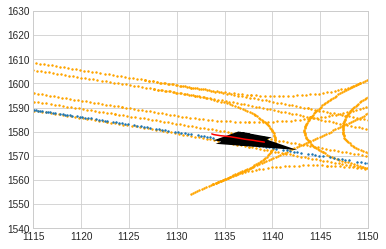

In [276]:
from nuscenes.map_expansion.map_api import NuScenesMap
import nuscenes.map_expansion.arcline_path_utils as path_utils
import numpy as np
import matplotlib.pyplot as plt

ax = plt.gca()
ax.clear()

n = 0
ego_path = sim.dataset.getEgoPath()
lane_ids = mapa.get_records_in_radius(ego_path[n,0], ego_path[n,1], 80, ['lane', 'lane_connector'])
nearby_lanes = lane_ids['lane'] + lane_ids['lane_connector']
for lane_token in nearby_lanes:
    lane_record = mapa.get_arcline_path(lane_token)
    poses = path_utils.discretize_lane(lane_record, resolution_meters=0.5)
    poses = np.array(poses)
    ax.scatter(poses[:,0], poses[:,1],color='orange',s=2)
#lane_token = mapa.get_closest_lane(ego_path[n,0], ego_path[n,1], radius=2)
#fig, ax = mapa.render_layers(['lane'],tokens=lane_token)
    #lane_path = mapa.arcline_path_3.get(lane_token, [])

    #resolution_meters = 0.5
    #discretized = np.array(path_utils.discretize_lane(lane_path, resolution_meters))
#fig, ax = mapa.render_layers(['lane'])


#ax.plot(discretized[:,0], discretized[:,1], 's', color='orange')
ax.scatter(ego_path[:,0], ego_path[:,1],s=2)

ax.set_xlim([1115, 1150])
ax.set_ylim([1540, 1630])

np.min(np.linalg.norm(ego_path[n,:]-poses))
#lane_record = mapa.get_arcline_path(lane_token)
print("lane_record", lane_record)
#poses = path_utils.discretize_lane(lane_record, resolution_meters=0.5)
#poses = np.array(poses)

min_dist = np.min(np.linalg.norm(ego_path[n,:2]-poses[:,0:2],axis=1))
print(f"min_dist = {min_dist}")
#print("poses",poses)
ax.scatter(poses[:,0], poses[:,1],s=2)

tracks = tracker.getHistory()
for idx,trk in enumerate(tracks):
    drawTrack(ax, trk, x_offset=0, y_offset=0, velThr=2)
    
drawClusters(ax, C)
#ax.axis('equal')
#plt.show()

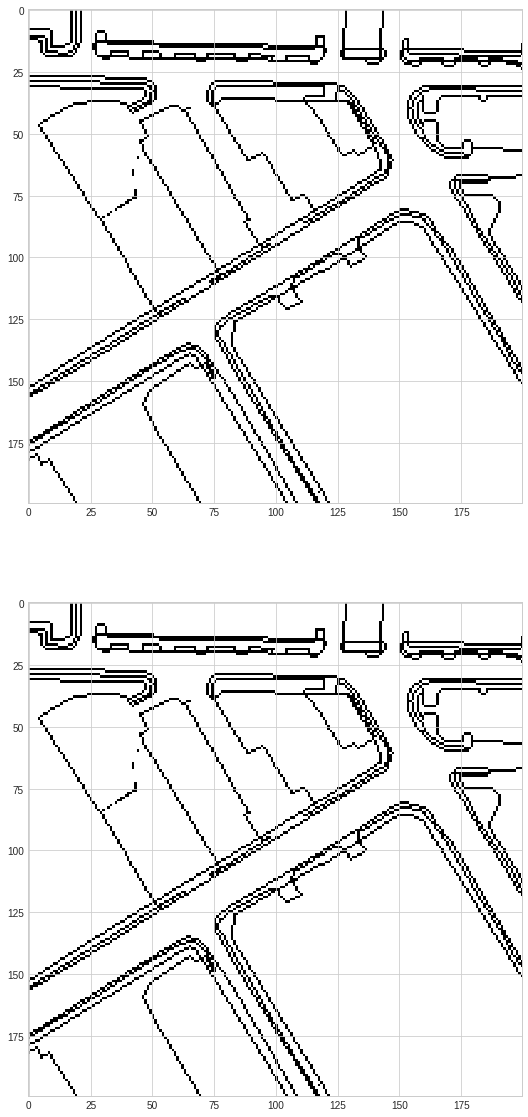

In [71]:
from map_utils import *

#sim = NuscenesSimulation(nusc=nusc, model=model, scene_id=690, Nmax=1200, video_list=video_list)


fig, ax = plt.subplots(2,figsize=(10,20))
mapa = sim.dataset.getMap()
ego_path = sim.dataset.getEgoPath()
orig = getCombinedMap(mapa,ego_path[300,:],smooth=False)#[80:120,100:150]
smoothed = getCombinedMap(mapa,ego_path[300,:],smooth=True)#[80:120,100:150]
ax[0].imshow(orig)
ax[1].imshow(smoothed)
#plt.imsave('690.png', binary_map)

In [705]:
from scipy.interpolate import splrep, splev

def getLineIndication(pos, N=50, thr=0.05):
        x = pos[-N:,0]
        y = pos[-N:,1]

        fit, cov = np.polyfit(x, y, 1, cov=True)
        print("cov",cov,"fit",fit)
        if np.sqrt(cov[0,0]) < thr:
            return True

        return False

def computeIMUAngleBias(imuPos, pfPose, N=50):
    if imuPos.shape[0] >= 5 and getLineIndication(imuPos, N=N):
        ax = imuPos[-N:,0] - imuPos[0,0]
        ay = imuPos[-N:,1] - imuPos[0,1]
        bx = pfPose[-N:,0] - pfPose[0,0]
        by = pfPose[-N:,1] - pfPose[0,1]
        angle_bias = np.arctan2(ax*by - ay*bx, ax*bx + ay*by)
        return angle_bias

    return None

In [709]:
pf_pos = np.array([[0,0],[100,-50],[200,-100],[300,-150],[400,-200]])
imu_pos = np.array([[0,0],[100,-51],[200,-10],[300,-13],[400,-204]])
print(imu_pos.shape)
print(computeIMUAngleBias(imu_pos, pf_pos)[-1])

(5, 2)
[  0 100 200 300 400] [   0  -51  -10  -13 -204]
cov [[ 5.11306667e-02 -1.02261333e+01]
 [-1.02261333e+01  3.06784000e+03]] fit [-0.37 18.4 ]


TypeError: 'NoneType' object is not subscriptable

In [665]:
math.atan2(4,4)

0.7853981633974483

In [ ]:
-0.37 * 400